In [2]:
#Data from https://www.kaggle.com/datasets/kapoorshivam/credit-analysis

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/

/content/drive/MyDrive


In [4]:
import numpy as np
import pandas as pd
import keras
import sys
import tensorflow as tf

In [5]:
df = pd.read_csv('current_app.csv')

In [6]:
df.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

In [7]:
#Inspect columns
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        # Explicitly define columns
        self.categorical_columns = [
            'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
            'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN'
        ]
        self.numerical_columns = [
            'AMT_INCOME_TOTAL', 'AMT_CREDIT',
            'AMT_ANNUITY', 'AMT_GOODS_PRICE'
        ]

        # One LabelEncoder per categorical column
        self.label_encoders = {col: LabelEncoder() for col in self.categorical_columns}
        self.fitted = False

    def fit(self, X, y=None):
        X = X.copy()

        # Impute and scale numerical data
        self.num_imputer.fit(X[self.numerical_columns])
        X_num_imputed = pd.DataFrame(
            self.num_imputer.transform(X[self.numerical_columns]),
            columns=self.numerical_columns,
            index=X.index
        )
        self.scaler.fit(X_num_imputed)

        # Impute and label encode categorical data
        self.cat_imputer.fit(X[self.categorical_columns])
        X_cat_imputed = pd.DataFrame(
            self.cat_imputer.transform(X[self.categorical_columns]),
            columns=self.categorical_columns,
            index=X.index
        )
        for col in self.categorical_columns:
            self.label_encoders[col].fit(X_cat_imputed[col])

        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise RuntimeError("You must fit the preprocessor before calling transform.")

        X = X.copy()

        # Impute and scale numerical data
        X_num_imputed = pd.DataFrame(
            self.num_imputer.transform(X[self.numerical_columns]),
            columns=self.numerical_columns,
            index=X.index
        )
        X_num_scaled = self.scaler.transform(X_num_imputed)

        # Impute and label encode categorical data
        X_cat_imputed = pd.DataFrame(
            self.cat_imputer.transform(X[self.categorical_columns]),
            columns=self.categorical_columns,
            index=X.index
        )
        X_cat_encoded = np.column_stack([
            self.label_encoders[col].transform(X_cat_imputed[col])
            for col in self.categorical_columns
        ])

        # Combine numerical and categorical
        X_processed = np.hstack([X_num_scaled, X_cat_encoded])
        return X_processed

In [9]:
#Preprocess
preprocessor = CustomPreprocessor()
X_transformed = preprocessor.fit_transform(df)

In [10]:
print(X_transformed.shape)

(307511, 10)


In [22]:
num_num = len(preprocessor.numerical_columns)
print("Numerical feature columns:", preprocessor.numerical_columns)

Numerical feature columns: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']


In [23]:
cat_dims = [len(encoder.classes_) for encoder in preprocessor.label_encoders.values()]
print("Categorical features and label-encoded class counts:")
for col, dim in zip(preprocessor.categorical_columns, cat_dims):
    print(f"  {col}: {dim} unique labels")

print("Total features after transform:", len(preprocessor.numerical_columns) + len(cat_dims))

Categorical features and label-encoded class counts:
  TARGET: 2 unique labels
  NAME_CONTRACT_TYPE: 2 unique labels
  CODE_GENDER: 3 unique labels
  FLAG_OWN_CAR: 2 unique labels
  FLAG_OWN_REALTY: 2 unique labels
  CNT_CHILDREN: 15 unique labels
Total features after transform: 10


In [24]:
cat_dims = [len(le.classes_) for le in preprocessor.label_encoders.values()]
num_num = len(preprocessor.numerical_columns)

In [25]:
cat_dims

[2, 2, 3, 2, 2, 15]

In [26]:
#Wasserstein Autoencoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Model, Input
import numpy as np

def build_encoder(input_dim, latent_dim, noise_stddev=0.1, dropout_rate=0.2, l2_reg=1e-4):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.GaussianNoise(noise_stddev)(x) #Noise Injection
    z = layers.Dense(latent_dim)(x)
    return keras.Model(inputs, z, name="encoder")

def build_decoder(latent_dim, num_num, cat_dims, l2_reg=1e-4):
    inputs = keras.Input(shape=(latent_dim,))

    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)

    # Output for numerical features
    num_out = layers.Dense(num_num, name='numerical_output')(x)

    # Outputs for categorical features (each with softmax)
    cat_outs = []
    for i, dim in enumerate(cat_dims):
        cat_out = layers.Dense(dim, activation='softmax', name=f'cat_output_{i}')(x)
        cat_outs.append(cat_out)

    # Return as separate outputs
    return keras.Model(inputs, [num_out] + cat_outs, name="decoder")

def build_critic(latent_dim, l2_reg=1e-4):
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    out = layers.Dense(1)(x)  # Scalar output for Wasserstein score
    return keras.Model(inputs, out, name="critic")

In [28]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

# === Setup data and params ===
X = X_transformed.astype(np.float32)  # Assume X_transformed is defined elsewhere
input_dim = X.shape[1]
latent_dim = 10

# Define models (should be tf.keras.Model instances)
encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, num_num, cat_dims)
critic = build_critic(latent_dim)

# Optimizers
optimizer_gen = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)
optimizer_critic = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)

# Training parameters
batch_size = 256  # increased batch size
epochs = 300
critic_iters = 3  # reduced critic updates per gen update
lambda_gp = 10.0

# Create tf.data.Dataset with caching and prefetching
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Warm-up forward passes (optional, helps trigger model building)
_ = encoder(X[:1])
_ = decoder(tf.random.normal([1, latent_dim]))
_ = critic(tf.random.normal([1, latent_dim]))

@tf.function
def train_critic(batch_x):
    critic_loss = 0.0
    for _ in tf.range(critic_iters):
        with tf.GradientTape() as tape:
            z = encoder(batch_x)
            prior_z = tf.random.normal(shape=tf.shape(z), dtype=tf.float32)

            critic_z = critic(z)
            critic_prior = critic(prior_z)

            alpha = tf.random.uniform(shape=[tf.shape(z)[0], 1], dtype=tf.float32)
            interpolates = alpha * z + (1.0 - alpha) * prior_z

            with tf.GradientTape() as gp_tape:
                gp_tape.watch(interpolates)
                critic_interpolates = critic(interpolates)

            gradients = gp_tape.gradient(critic_interpolates, [interpolates])[0]
            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1) + 1e-12)
            gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))

            loss = tf.reduce_mean(critic_prior) - tf.reduce_mean(critic_z)
            loss += lambda_gp * gradient_penalty

        grads = tape.gradient(loss, critic.trainable_variables)
        optimizer_critic.apply_gradients(zip(grads, critic.trainable_variables))
        critic_loss += loss
    return critic_loss / tf.cast(critic_iters, tf.float32)

@tf.function
def train_generator(batch_x):
    with tf.GradientTape() as tape:
        z = encoder(batch_x)
        outputs = decoder(z)
        critic_z = critic(z)

        # Split input: numerical and categorical
        x_num = batch_x[:, :num_num]
        x_cats = []
        start = num_num
        for _ in cat_dims:
            x_cats.append(tf.cast(batch_x[:, start], tf.int32))  # single column, label-encoded
            start += 1

        # Decoder outputs
        x_recon_num = outputs[0]
        x_recon_cats = outputs[1:]

        # Reconstruction losses
        recon_loss_num = tf.reduce_mean(tf.square(x_num - x_recon_num))
        recon_loss_cat = tf.add_n([
            tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(true, pred))
            for true, pred in zip(x_cats, x_recon_cats)
        ])
        recon_loss = recon_loss_num + recon_loss_cat

        gen_loss = recon_loss + tf.reduce_mean(critic_z)

    grads = tape.gradient(gen_loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer_gen.apply_gradients(zip(grads, encoder.trainable_variables + decoder.trainable_variables))
    return gen_loss

num_batches = tf.data.experimental.cardinality(dataset).numpy()

for epoch in range(epochs):
    epoch_gen_loss = []
    epoch_critic_loss = []

    print(f"\n=== Epoch {epoch+1}/{epochs} ===", flush=True)
    for batch_idx, batch_x in enumerate(tqdm(dataset, total=num_batches, desc=f"Epoch {epoch+1}")):
        batch_x = tf.cast(batch_x, tf.float32)

        critic_loss = train_critic(batch_x)
        gen_loss = train_generator(batch_x)

        epoch_critic_loss.append(critic_loss.numpy())
        epoch_gen_loss.append(gen_loss.numpy())

        # Print every 50 batches to reduce overhead
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == num_batches:
            print(f"Batch {batch_idx + 1}/{num_batches}: Gen Loss = {gen_loss.numpy():.4f}, Critic Loss = {critic_loss.numpy():.4f}", flush=True)

    mean_g_loss = np.mean(epoch_gen_loss)
    mean_c_loss = np.mean(epoch_critic_loss)
    print(f"\n✔ Epoch {epoch+1}/{epochs} Complete | Avg Gen Loss: {mean_g_loss:.6f}, Avg Critic Loss: {mean_c_loss:.6f}", flush=True)


=== Epoch 1/300 ===


Epoch 1:   4%|▍         | 49/1202 [00:05<00:37, 31.16it/s]

Batch 50/1202: Gen Loss = 7.1507, Critic Loss = 1.9435


Epoch 1:   8%|▊         | 92/1202 [00:06<00:21, 52.69it/s]

Batch 100/1202: Gen Loss = 6.9481, Critic Loss = 0.2397


Epoch 1:  12%|█▏        | 148/1202 [00:06<00:14, 72.96it/s]

Batch 150/1202: Gen Loss = 6.3757, Critic Loss = -0.2729


Epoch 1:  16%|█▋        | 196/1202 [00:07<00:13, 74.83it/s]

Batch 200/1202: Gen Loss = 5.3482, Critic Loss = -0.9267


Epoch 1:  20%|██        | 244/1202 [00:08<00:13, 71.12it/s]

Batch 250/1202: Gen Loss = 4.2557, Critic Loss = -1.4077


Epoch 1:  24%|██▍       | 292/1202 [00:08<00:12, 74.22it/s]

Batch 300/1202: Gen Loss = 3.6647, Critic Loss = -1.8859


Epoch 1:  29%|██▉       | 348/1202 [00:09<00:11, 75.96it/s]

Batch 350/1202: Gen Loss = 3.3780, Critic Loss = -2.0675


Epoch 1:  33%|███▎      | 396/1202 [00:10<00:11, 71.62it/s]

Batch 400/1202: Gen Loss = 3.5113, Critic Loss = -2.2666


Epoch 1:  37%|███▋      | 444/1202 [00:10<00:09, 76.54it/s]

Batch 450/1202: Gen Loss = 3.1075, Critic Loss = -2.3371


Epoch 1:  41%|████      | 492/1202 [00:11<00:09, 75.48it/s]

Batch 500/1202: Gen Loss = 2.8454, Critic Loss = -2.3301


Epoch 1:  46%|████▌     | 548/1202 [00:12<00:08, 74.61it/s]

Batch 550/1202: Gen Loss = 2.6868, Critic Loss = -2.3160


Epoch 1:  50%|████▉     | 596/1202 [00:12<00:07, 76.26it/s]

Batch 600/1202: Gen Loss = 2.2548, Critic Loss = -2.3366


Epoch 1:  54%|█████▎    | 644/1202 [00:13<00:07, 75.94it/s]

Batch 650/1202: Gen Loss = 1.9473, Critic Loss = -2.2624


Epoch 1:  58%|█████▊    | 692/1202 [00:14<00:06, 74.62it/s]

Batch 700/1202: Gen Loss = 1.4571, Critic Loss = -2.0995


Epoch 1:  62%|██████▏   | 748/1202 [00:14<00:05, 77.15it/s]

Batch 750/1202: Gen Loss = 1.0035, Critic Loss = -2.1165


Epoch 1:  66%|██████▌   | 796/1202 [00:15<00:05, 76.55it/s]

Batch 800/1202: Gen Loss = 0.8203, Critic Loss = -2.0377


Epoch 1:  70%|███████   | 844/1202 [00:16<00:05, 66.70it/s]

Batch 850/1202: Gen Loss = 0.6260, Critic Loss = -1.9917


Epoch 1:  75%|███████▍  | 898/1202 [00:17<00:09, 32.44it/s]

Batch 900/1202: Gen Loss = 0.4232, Critic Loss = -1.9133


Epoch 1:  79%|███████▉  | 948/1202 [00:19<00:09, 27.00it/s]

Batch 950/1202: Gen Loss = 0.3093, Critic Loss = -1.8200


Epoch 1:  83%|████████▎ | 993/1202 [00:20<00:05, 39.70it/s]

Batch 1000/1202: Gen Loss = 0.1160, Critic Loss = -1.7994


Epoch 1:  87%|████████▋ | 1047/1202 [00:21<00:02, 69.42it/s]

Batch 1050/1202: Gen Loss = 0.0885, Critic Loss = -1.6116


Epoch 1:  91%|█████████ | 1094/1202 [00:22<00:01, 73.45it/s]

Batch 1100/1202: Gen Loss = -0.1444, Critic Loss = -1.5590


Epoch 1:  95%|█████████▌| 1142/1202 [00:22<00:00, 74.33it/s]

Batch 1150/1202: Gen Loss = -0.1222, Critic Loss = -1.5863


Epoch 1: 100%|█████████▉| 1198/1202 [00:23<00:00, 73.36it/s]

Batch 1200/1202: Gen Loss = -0.1470, Critic Loss = -1.5623
Batch 1202/1202: Gen Loss = -0.2158, Critic Loss = -1.5069


Epoch 1: 100%|██████████| 1202/1202 [00:25<00:00, 47.56it/s]


✔ Epoch 1/300 Complete | Avg Gen Loss: 2.736101, Avg Critic Loss: -1.491730

=== Epoch 2/300 ===



Epoch 2:   4%|▍         | 48/1202 [00:00<00:15, 75.86it/s]

Batch 50/1202: Gen Loss = -0.0998, Critic Loss = -1.5864


Epoch 2:   8%|▊         | 97/1202 [00:01<00:14, 78.52it/s]

Batch 100/1202: Gen Loss = -0.1933, Critic Loss = -1.6203


Epoch 2:  12%|█▏        | 145/1202 [00:01<00:13, 75.99it/s]

Batch 150/1202: Gen Loss = -0.3814, Critic Loss = -1.4572


Epoch 2:  16%|█▌        | 193/1202 [00:02<00:13, 75.35it/s]

Batch 200/1202: Gen Loss = -0.6084, Critic Loss = -1.3650


Epoch 2:  21%|██        | 249/1202 [00:03<00:12, 76.90it/s]

Batch 250/1202: Gen Loss = -0.6053, Critic Loss = -1.3349


Epoch 2:  25%|██▍       | 297/1202 [00:03<00:12, 75.30it/s]

Batch 300/1202: Gen Loss = -0.2795, Critic Loss = -1.3351


Epoch 2:  29%|██▊       | 345/1202 [00:04<00:11, 73.86it/s]

Batch 350/1202: Gen Loss = -0.1424, Critic Loss = -1.4097


Epoch 2:  33%|███▎      | 395/1202 [00:05<00:13, 59.42it/s]

Batch 400/1202: Gen Loss = -0.3357, Critic Loss = -1.2361


Epoch 2:  37%|███▋      | 444/1202 [00:06<00:13, 56.13it/s]

Batch 450/1202: Gen Loss = -0.6714, Critic Loss = -1.1661


Epoch 2:  42%|████▏     | 499/1202 [00:07<00:13, 52.38it/s]

Batch 500/1202: Gen Loss = -0.7099, Critic Loss = -1.1615


Epoch 2:  46%|████▌     | 547/1202 [00:08<00:10, 65.44it/s]

Batch 550/1202: Gen Loss = -0.6776, Critic Loss = -1.1045


Epoch 2:  50%|████▉     | 595/1202 [00:08<00:08, 70.14it/s]

Batch 600/1202: Gen Loss = -0.4340, Critic Loss = -1.1531


Epoch 2:  53%|█████▎    | 643/1202 [00:09<00:07, 74.52it/s]

Batch 650/1202: Gen Loss = -0.2073, Critic Loss = -1.1817


Epoch 2:  58%|█████▊    | 699/1202 [00:10<00:06, 73.13it/s]

Batch 700/1202: Gen Loss = -0.1053, Critic Loss = -1.1573


Epoch 2:  62%|██████▏   | 747/1202 [00:10<00:06, 70.83it/s]

Batch 750/1202: Gen Loss = -0.3074, Critic Loss = -0.9715


Epoch 2:  66%|██████▌   | 795/1202 [00:11<00:05, 73.55it/s]

Batch 800/1202: Gen Loss = -0.4506, Critic Loss = -0.9341


Epoch 2:  70%|███████   | 843/1202 [00:12<00:04, 73.23it/s]

Batch 850/1202: Gen Loss = -0.7144, Critic Loss = -0.8731


Epoch 2:  75%|███████▍  | 899/1202 [00:12<00:04, 75.43it/s]

Batch 900/1202: Gen Loss = -0.8472, Critic Loss = -0.8430


Epoch 2:  79%|███████▉  | 947/1202 [00:13<00:03, 76.14it/s]

Batch 950/1202: Gen Loss = -0.3089, Critic Loss = -1.0685


Epoch 2:  83%|████████▎ | 995/1202 [00:14<00:02, 75.78it/s]

Batch 1000/1202: Gen Loss = 0.2986, Critic Loss = -1.2825


Epoch 2:  87%|████████▋ | 1043/1202 [00:14<00:02, 76.91it/s]

Batch 1050/1202: Gen Loss = 0.5102, Critic Loss = -1.2378


Epoch 2:  91%|█████████▏| 1099/1202 [00:15<00:01, 77.39it/s]

Batch 1100/1202: Gen Loss = 0.2370, Critic Loss = -1.1344


Epoch 2:  95%|█████████▌| 1147/1202 [00:16<00:00, 76.41it/s]

Batch 1150/1202: Gen Loss = -0.2862, Critic Loss = -0.9920


Epoch 2:  99%|█████████▉| 1195/1202 [00:16<00:00, 78.10it/s]

Batch 1200/1202: Gen Loss = -0.7525, Critic Loss = -0.8702
Batch 1202/1202: Gen Loss = -0.7331, Critic Loss = -0.8718


Epoch 2: 100%|██████████| 1202/1202 [00:16<00:00, 71.14it/s]


✔ Epoch 2/300 Complete | Avg Gen Loss: -0.172707, Avg Critic Loss: -1.214833



=== Epoch 3/300 ===


Epoch 3:   4%|▍         | 46/1202 [00:00<00:15, 76.08it/s]

Batch 50/1202: Gen Loss = -0.6547, Critic Loss = -0.8158


Epoch 3:   8%|▊         | 99/1202 [00:01<00:18, 59.42it/s]

Batch 100/1202: Gen Loss = -0.1177, Critic Loss = -0.9709


Epoch 3:  12%|█▏        | 149/1202 [00:02<00:18, 56.56it/s]

Batch 150/1202: Gen Loss = 0.3290, Critic Loss = -1.0606


Epoch 3:  16%|█▋        | 198/1202 [00:03<00:17, 56.25it/s]

Batch 200/1202: Gen Loss = 0.5423, Critic Loss = -1.1716


Epoch 3:  21%|██        | 248/1202 [00:04<00:15, 61.30it/s]

Batch 250/1202: Gen Loss = 0.6324, Critic Loss = -1.1066


Epoch 3:  25%|██▍       | 297/1202 [00:04<00:11, 76.16it/s]

Batch 300/1202: Gen Loss = 0.3301, Critic Loss = -0.8726


Epoch 3:  29%|██▉       | 346/1202 [00:05<00:11, 76.70it/s]

Batch 350/1202: Gen Loss = 0.1143, Critic Loss = -0.7174


Epoch 3:  33%|███▎      | 394/1202 [00:05<00:10, 78.06it/s]

Batch 400/1202: Gen Loss = 0.3601, Critic Loss = -0.7263


Epoch 3:  37%|███▋      | 442/1202 [00:06<00:09, 76.46it/s]

Batch 450/1202: Gen Loss = 0.9315, Critic Loss = -1.0042


Epoch 3:  41%|████▏     | 498/1202 [00:07<00:09, 77.94it/s]

Batch 500/1202: Gen Loss = 0.8320, Critic Loss = -0.9087


Epoch 3:  46%|████▌     | 547/1202 [00:07<00:08, 78.16it/s]

Batch 550/1202: Gen Loss = 0.3472, Critic Loss = -0.8329


Epoch 3:  50%|████▉     | 595/1202 [00:08<00:08, 75.87it/s]

Batch 600/1202: Gen Loss = 0.1949, Critic Loss = -0.8212


Epoch 3:  53%|█████▎    | 643/1202 [00:09<00:07, 75.94it/s]

Batch 650/1202: Gen Loss = 0.4764, Critic Loss = -1.0019


Epoch 3:  58%|█████▊    | 699/1202 [00:09<00:06, 76.69it/s]

Batch 700/1202: Gen Loss = 0.8240, Critic Loss = -1.0520


Epoch 3:  62%|██████▏   | 747/1202 [00:10<00:06, 75.73it/s]

Batch 750/1202: Gen Loss = 1.0326, Critic Loss = -1.0789


Epoch 3:  66%|██████▌   | 795/1202 [00:11<00:05, 77.24it/s]

Batch 800/1202: Gen Loss = 1.0306, Critic Loss = -1.0367


Epoch 3:  70%|███████   | 845/1202 [00:11<00:04, 78.26it/s]

Batch 850/1202: Gen Loss = 0.4531, Critic Loss = -0.8730


Epoch 3:  74%|███████▍  | 893/1202 [00:12<00:03, 77.55it/s]

Batch 900/1202: Gen Loss = -0.2292, Critic Loss = -0.5128


Epoch 3:  79%|███████▉  | 949/1202 [00:13<00:03, 76.12it/s]

Batch 950/1202: Gen Loss = -0.2297, Critic Loss = -0.4631


Epoch 3:  83%|████████▎ | 997/1202 [00:13<00:02, 75.73it/s]

Batch 1000/1202: Gen Loss = 0.7023, Critic Loss = -0.9320


Epoch 3:  87%|████████▋ | 1046/1202 [00:14<00:02, 56.21it/s]

Batch 1050/1202: Gen Loss = 1.3608, Critic Loss = -1.1251


Epoch 3:  91%|█████████ | 1094/1202 [00:15<00:01, 57.25it/s]

Batch 1100/1202: Gen Loss = 0.8208, Critic Loss = -0.8802


Epoch 3:  96%|█████████▌| 1149/1202 [00:16<00:00, 55.22it/s]

Batch 1150/1202: Gen Loss = 0.0061, Critic Loss = -0.6795


Epoch 3:  99%|█████████▉| 1195/1202 [00:17<00:00, 65.82it/s]

Batch 1200/1202: Gen Loss = -0.2911, Critic Loss = -0.6386
Batch 1202/1202: Gen Loss = -0.3341, Critic Loss = -0.6431


Epoch 3: 100%|██████████| 1202/1202 [00:17<00:00, 69.01it/s]


✔ Epoch 3/300 Complete | Avg Gen Loss: 0.457302, Avg Critic Loss: -0.903683

=== Epoch 4/300 ===



Epoch 4:   4%|▍         | 48/1202 [00:00<00:15, 75.88it/s]

Batch 50/1202: Gen Loss = -0.3160, Critic Loss = -0.6243


Epoch 4:   8%|▊         | 97/1202 [00:01<00:14, 77.27it/s]

Batch 100/1202: Gen Loss = -0.1717, Critic Loss = -0.7184


Epoch 4:  12%|█▏        | 145/1202 [00:01<00:13, 77.06it/s]

Batch 150/1202: Gen Loss = 0.0337, Critic Loss = -0.6265


Epoch 4:  16%|█▌        | 193/1202 [00:02<00:13, 75.97it/s]

Batch 200/1202: Gen Loss = 0.6318, Critic Loss = -0.7739


Epoch 4:  21%|██        | 249/1202 [00:03<00:12, 77.13it/s]

Batch 250/1202: Gen Loss = 1.0708, Critic Loss = -0.9437


Epoch 4:  25%|██▍       | 297/1202 [00:03<00:11, 76.64it/s]

Batch 300/1202: Gen Loss = 0.7667, Critic Loss = -0.7942


Epoch 4:  29%|██▉       | 346/1202 [00:04<00:10, 78.59it/s]

Batch 350/1202: Gen Loss = 0.3296, Critic Loss = -0.7174


Epoch 4:  33%|███▎      | 394/1202 [00:05<00:10, 76.82it/s]

Batch 400/1202: Gen Loss = 0.3094, Critic Loss = -0.8212


Epoch 4:  37%|███▋      | 442/1202 [00:05<00:10, 74.34it/s]

Batch 450/1202: Gen Loss = 0.4256, Critic Loss = -0.8785


Epoch 4:  41%|████▏     | 498/1202 [00:06<00:09, 77.78it/s]

Batch 500/1202: Gen Loss = 0.6300, Critic Loss = -0.7444


Epoch 4:  45%|████▌     | 546/1202 [00:07<00:08, 74.65it/s]

Batch 550/1202: Gen Loss = 1.3405, Critic Loss = -0.9737


Epoch 4:  49%|████▉     | 594/1202 [00:07<00:08, 73.18it/s]

Batch 600/1202: Gen Loss = 1.7239, Critic Loss = -1.0609


Epoch 4:  53%|█████▎    | 642/1202 [00:08<00:07, 76.92it/s]

Batch 650/1202: Gen Loss = 1.0670, Critic Loss = -0.7813


Epoch 4:  58%|█████▊    | 698/1202 [00:09<00:06, 75.02it/s]

Batch 700/1202: Gen Loss = 0.5205, Critic Loss = -0.5491


Epoch 4:  62%|██████▏   | 746/1202 [00:09<00:06, 65.59it/s]

Batch 750/1202: Gen Loss = 0.2663, Critic Loss = -0.4484


Epoch 4:  66%|██████▋   | 798/1202 [00:10<00:07, 56.54it/s]

Batch 800/1202: Gen Loss = 1.0865, Critic Loss = -0.9394


Epoch 4:  70%|███████   | 847/1202 [00:11<00:06, 57.19it/s]

Batch 850/1202: Gen Loss = 1.4737, Critic Loss = -1.0091


Epoch 4:  74%|███████▍  | 895/1202 [00:12<00:05, 53.88it/s]

Batch 900/1202: Gen Loss = 1.1137, Critic Loss = -0.6757


Epoch 4:  79%|███████▉  | 949/1202 [00:13<00:03, 73.54it/s]

Batch 950/1202: Gen Loss = 0.6905, Critic Loss = -0.4237


Epoch 4:  83%|████████▎ | 998/1202 [00:14<00:04, 47.90it/s]

Batch 1000/1202: Gen Loss = 0.9012, Critic Loss = -0.5200


Epoch 4:  87%|████████▋ | 1046/1202 [00:15<00:02, 72.04it/s]

Batch 1050/1202: Gen Loss = 1.4746, Critic Loss = -0.6532


Epoch 4:  91%|█████████ | 1094/1202 [00:15<00:01, 76.90it/s]

Batch 1100/1202: Gen Loss = 2.1130, Critic Loss = -0.7818


Epoch 4:  95%|█████████▌| 1142/1202 [00:16<00:00, 77.16it/s]

Batch 1150/1202: Gen Loss = 2.8424, Critic Loss = -0.9280


Epoch 4: 100%|█████████▉| 1198/1202 [00:17<00:00, 75.70it/s]

Batch 1200/1202: Gen Loss = 2.8227, Critic Loss = -0.9630
Batch 1202/1202: Gen Loss = 2.9416, Critic Loss = -1.0243


Epoch 4: 100%|██████████| 1202/1202 [00:17<00:00, 69.64it/s]


✔ Epoch 4/300 Complete | Avg Gen Loss: 0.962228, Avg Critic Loss: -0.750637

=== Epoch 5/300 ===



Epoch 5:   4%|▍         | 48/1202 [00:00<00:16, 71.29it/s]

Batch 50/1202: Gen Loss = 1.9250, Critic Loss = -0.7811


Epoch 5:   8%|▊         | 96/1202 [00:01<00:14, 75.53it/s]

Batch 100/1202: Gen Loss = 1.4426, Critic Loss = -0.8880


Epoch 5:  12%|█▏        | 144/1202 [00:01<00:14, 73.94it/s]

Batch 150/1202: Gen Loss = 0.7531, Critic Loss = -0.8589


Epoch 5:  16%|█▌        | 192/1202 [00:02<00:13, 75.99it/s]

Batch 200/1202: Gen Loss = 0.4783, Critic Loss = -0.7667


Epoch 5:  21%|██        | 248/1202 [00:03<00:12, 77.30it/s]

Batch 250/1202: Gen Loss = 0.4548, Critic Loss = -0.7408


Epoch 5:  25%|██▍       | 296/1202 [00:03<00:12, 75.37it/s]

Batch 300/1202: Gen Loss = 0.6047, Critic Loss = -0.6245


Epoch 5:  29%|██▊       | 345/1202 [00:04<00:11, 76.08it/s]

Batch 350/1202: Gen Loss = 1.0151, Critic Loss = -0.6282


Epoch 5:  33%|███▎      | 393/1202 [00:05<00:10, 77.07it/s]

Batch 400/1202: Gen Loss = 1.2168, Critic Loss = -0.6322


Epoch 5:  37%|███▋      | 447/1202 [00:06<00:30, 25.13it/s]

Batch 450/1202: Gen Loss = 0.7577, Critic Loss = -0.5302


Epoch 5:  41%|████      | 495/1202 [00:08<00:15, 47.00it/s]

Batch 500/1202: Gen Loss = 0.4088, Critic Loss = -0.2643


Epoch 5:  46%|████▌     | 547/1202 [00:09<00:10, 64.27it/s]

Batch 550/1202: Gen Loss = 0.8403, Critic Loss = -0.4701


Epoch 5:  49%|████▉     | 594/1202 [00:09<00:08, 75.31it/s]

Batch 600/1202: Gen Loss = 1.6526, Critic Loss = -0.6553


Epoch 5:  53%|█████▎    | 642/1202 [00:10<00:07, 75.19it/s]

Batch 650/1202: Gen Loss = 2.1322, Critic Loss = -0.6795


Epoch 5:  58%|█████▊    | 698/1202 [00:11<00:06, 77.34it/s]

Batch 700/1202: Gen Loss = 2.0930, Critic Loss = -0.5201


Epoch 5:  62%|██████▏   | 746/1202 [00:11<00:06, 75.76it/s]

Batch 750/1202: Gen Loss = 2.1574, Critic Loss = -0.6640


Epoch 5:  66%|██████▌   | 794/1202 [00:12<00:05, 73.65it/s]

Batch 800/1202: Gen Loss = 1.9187, Critic Loss = -0.7038


Epoch 5:  70%|███████   | 842/1202 [00:12<00:04, 76.89it/s]

Batch 850/1202: Gen Loss = 1.3501, Critic Loss = -0.6606


Epoch 5:  75%|███████▍  | 898/1202 [00:13<00:03, 76.17it/s]

Batch 900/1202: Gen Loss = 1.0011, Critic Loss = -0.6291


Epoch 5:  79%|███████▊  | 946/1202 [00:14<00:03, 76.64it/s]

Batch 950/1202: Gen Loss = 0.7384, Critic Loss = -0.3646


Epoch 5:  83%|████████▎ | 994/1202 [00:14<00:02, 74.14it/s]

Batch 1000/1202: Gen Loss = 1.1998, Critic Loss = -0.5242


Epoch 5:  87%|████████▋ | 1042/1202 [00:15<00:02, 75.03it/s]

Batch 1050/1202: Gen Loss = 2.1822, Critic Loss = -0.9738


Epoch 5:  91%|█████████▏| 1098/1202 [00:16<00:01, 77.57it/s]

Batch 1100/1202: Gen Loss = 2.2563, Critic Loss = -0.7399


Epoch 5:  95%|█████████▌| 1146/1202 [00:16<00:00, 76.18it/s]

Batch 1150/1202: Gen Loss = 1.5904, Critic Loss = -0.5387


Epoch 5:  99%|█████████▉| 1194/1202 [00:17<00:00, 76.10it/s]

Batch 1200/1202: Gen Loss = 1.3825, Critic Loss = -0.6196
Batch 1202/1202: Gen Loss = 1.2890, Critic Loss = -0.5062


Epoch 5: 100%|██████████| 1202/1202 [00:17<00:00, 67.83it/s]


✔ Epoch 5/300 Complete | Avg Gen Loss: 1.354165, Avg Critic Loss: -0.648698

=== Epoch 6/300 ===



Epoch 6:   4%|▍         | 48/1202 [00:00<00:15, 76.38it/s]

Batch 50/1202: Gen Loss = 1.9107, Critic Loss = -0.9206


Epoch 6:   8%|▊         | 96/1202 [00:01<00:16, 66.03it/s]

Batch 100/1202: Gen Loss = 2.4326, Critic Loss = -1.1200


Epoch 6:  12%|█▏        | 147/1202 [00:02<00:18, 58.00it/s]

Batch 150/1202: Gen Loss = 1.9727, Critic Loss = -0.7577


Epoch 6:  16%|█▋        | 197/1202 [00:03<00:17, 56.91it/s]

Batch 200/1202: Gen Loss = 1.8160, Critic Loss = -0.6217


Epoch 6:  20%|██        | 246/1202 [00:04<00:18, 51.42it/s]

Batch 250/1202: Gen Loss = 2.1846, Critic Loss = -0.6892


Epoch 6:  25%|██▍       | 297/1202 [00:04<00:12, 71.10it/s]

Batch 300/1202: Gen Loss = 2.0891, Critic Loss = -0.6712


Epoch 6:  29%|██▊       | 345/1202 [00:05<00:11, 76.38it/s]

Batch 350/1202: Gen Loss = 1.9791, Critic Loss = -0.7130


Epoch 6:  33%|███▎      | 393/1202 [00:06<00:10, 77.26it/s]

Batch 400/1202: Gen Loss = 1.9670, Critic Loss = -0.6510


Epoch 6:  37%|███▋      | 449/1202 [00:06<00:09, 77.77it/s]

Batch 450/1202: Gen Loss = 1.7426, Critic Loss = -0.6254


Epoch 6:  41%|████▏     | 497/1202 [00:07<00:09, 76.78it/s]

Batch 500/1202: Gen Loss = 1.9223, Critic Loss = -0.6865


Epoch 6:  45%|████▌     | 545/1202 [00:08<00:08, 76.63it/s]

Batch 550/1202: Gen Loss = 2.8143, Critic Loss = -0.8361


Epoch 6:  49%|████▉     | 593/1202 [00:08<00:07, 76.96it/s]

Batch 600/1202: Gen Loss = 3.5096, Critic Loss = -1.0120


Epoch 6:  54%|█████▍    | 649/1202 [00:09<00:07, 75.34it/s]

Batch 650/1202: Gen Loss = 3.7698, Critic Loss = -1.0188


Epoch 6:  58%|█████▊    | 697/1202 [00:10<00:06, 75.95it/s]

Batch 700/1202: Gen Loss = 3.5620, Critic Loss = -0.8524


Epoch 6:  62%|██████▏   | 745/1202 [00:10<00:06, 75.67it/s]

Batch 750/1202: Gen Loss = 3.0668, Critic Loss = -0.6332


Epoch 6:  66%|██████▌   | 793/1202 [00:11<00:05, 74.16it/s]

Batch 800/1202: Gen Loss = 3.1250, Critic Loss = -0.6456


Epoch 6:  71%|███████   | 849/1202 [00:12<00:04, 77.15it/s]

Batch 850/1202: Gen Loss = 3.6943, Critic Loss = -0.8322


Epoch 6:  75%|███████▍  | 897/1202 [00:12<00:03, 76.67it/s]

Batch 900/1202: Gen Loss = 3.8256, Critic Loss = -0.9110


Epoch 6:  79%|███████▊  | 945/1202 [00:13<00:03, 77.30it/s]

Batch 950/1202: Gen Loss = 3.6335, Critic Loss = -0.6122


Epoch 6:  83%|████████▎ | 993/1202 [00:13<00:02, 76.68it/s]

Batch 1000/1202: Gen Loss = 4.0843, Critic Loss = -0.9197


Epoch 6:  87%|████████▋ | 1047/1202 [00:14<00:02, 59.45it/s]

Batch 1050/1202: Gen Loss = 3.6668, Critic Loss = -0.7459


Epoch 6:  91%|█████████ | 1096/1202 [00:15<00:01, 57.30it/s]

Batch 1100/1202: Gen Loss = 3.0563, Critic Loss = -0.5802


Epoch 6:  95%|█████████▌| 1145/1202 [00:16<00:00, 58.00it/s]

Batch 1150/1202: Gen Loss = 3.2857, Critic Loss = -0.7046


Epoch 6: 100%|█████████▉| 1199/1202 [00:17<00:00, 53.21it/s]

Batch 1200/1202: Gen Loss = 4.2993, Critic Loss = -0.9587
Batch 1202/1202: Gen Loss = 4.3507, Critic Loss = -1.1027


Epoch 6: 100%|██████████| 1202/1202 [00:17<00:00, 68.55it/s]


✔ Epoch 6/300 Complete | Avg Gen Loss: 2.846610, Avg Critic Loss: -0.778049

=== Epoch 7/300 ===



Epoch 7:   4%|▍         | 47/1202 [00:00<00:15, 75.54it/s]

Batch 50/1202: Gen Loss = 4.5460, Critic Loss = -1.0611


Epoch 7:   8%|▊         | 95/1202 [00:01<00:14, 74.77it/s]

Batch 100/1202: Gen Loss = 4.7129, Critic Loss = -1.1746


Epoch 7:  12%|█▏        | 143/1202 [00:01<00:13, 76.27it/s]

Batch 150/1202: Gen Loss = 4.2732, Critic Loss = -1.0077


Epoch 7:  17%|█▋        | 199/1202 [00:02<00:13, 76.90it/s]

Batch 200/1202: Gen Loss = 3.6416, Critic Loss = -0.7868


Epoch 7:  21%|██        | 247/1202 [00:03<00:12, 75.52it/s]

Batch 250/1202: Gen Loss = 3.4099, Critic Loss = -0.7274


Epoch 7:  25%|██▍       | 295/1202 [00:03<00:11, 76.99it/s]

Batch 300/1202: Gen Loss = 3.6222, Critic Loss = -0.8545


Epoch 7:  29%|██▊       | 343/1202 [00:04<00:11, 76.21it/s]

Batch 350/1202: Gen Loss = 4.2814, Critic Loss = -1.0127


Epoch 7:  33%|███▎      | 392/1202 [00:05<00:10, 78.94it/s]

Batch 400/1202: Gen Loss = 4.4458, Critic Loss = -1.0830


Epoch 7:  37%|███▋      | 448/1202 [00:05<00:09, 77.31it/s]

Batch 450/1202: Gen Loss = 3.5526, Critic Loss = -0.8169


Epoch 7:  41%|████▏     | 496/1202 [00:06<00:09, 76.52it/s]

Batch 500/1202: Gen Loss = 3.4179, Critic Loss = -0.7531


Epoch 7:  45%|████▌     | 544/1202 [00:07<00:08, 77.36it/s]

Batch 550/1202: Gen Loss = 4.2189, Critic Loss = -0.9715


Epoch 7:  49%|████▉     | 592/1202 [00:07<00:07, 76.45it/s]

Batch 600/1202: Gen Loss = 4.2528, Critic Loss = -0.8583


Epoch 7:  54%|█████▍    | 648/1202 [00:08<00:07, 75.93it/s]

Batch 650/1202: Gen Loss = 4.6262, Critic Loss = -0.9355


Epoch 7:  58%|█████▊    | 696/1202 [00:09<00:06, 76.06it/s]

Batch 700/1202: Gen Loss = 5.1120, Critic Loss = -1.1159


Epoch 7:  62%|██████▏   | 744/1202 [00:09<00:06, 75.66it/s]

Batch 750/1202: Gen Loss = 4.2942, Critic Loss = -0.9653


Epoch 7:  66%|██████▌   | 794/1202 [00:10<00:07, 57.02it/s]

Batch 800/1202: Gen Loss = 4.4885, Critic Loss = -0.9935


Epoch 7:  71%|███████   | 848/1202 [00:11<00:06, 56.05it/s]

Batch 850/1202: Gen Loss = 4.5038, Critic Loss = -1.0658


Epoch 7:  75%|███████▍  | 897/1202 [00:12<00:05, 52.81it/s]

Batch 900/1202: Gen Loss = 3.8813, Critic Loss = -0.7999


Epoch 7:  78%|███████▊  | 943/1202 [00:13<00:04, 62.66it/s]

Batch 950/1202: Gen Loss = 4.2197, Critic Loss = -0.8989


Epoch 7:  83%|████████▎ | 998/1202 [00:14<00:02, 74.07it/s]

Batch 1000/1202: Gen Loss = 5.0877, Critic Loss = -1.3396


Epoch 7:  87%|████████▋ | 1046/1202 [00:14<00:02, 73.49it/s]

Batch 1050/1202: Gen Loss = 4.7515, Critic Loss = -1.1181


Epoch 7:  91%|█████████ | 1094/1202 [00:15<00:01, 75.19it/s]

Batch 1100/1202: Gen Loss = 4.1727, Critic Loss = -0.8310


Epoch 7:  95%|█████████▌| 1142/1202 [00:15<00:00, 75.14it/s]

Batch 1150/1202: Gen Loss = 4.1369, Critic Loss = -0.7550


Epoch 7: 100%|█████████▉| 1198/1202 [00:16<00:00, 70.60it/s]

Batch 1200/1202: Gen Loss = 4.5208, Critic Loss = -0.8132
Batch 1202/1202: Gen Loss = 4.4673, Critic Loss = -0.6799


Epoch 7: 100%|██████████| 1202/1202 [00:16<00:00, 71.58it/s]


✔ Epoch 7/300 Complete | Avg Gen Loss: 4.273368, Avg Critic Loss: -0.962494

=== Epoch 8/300 ===



Epoch 8:   4%|▍         | 48/1202 [00:00<00:14, 77.20it/s]

Batch 50/1202: Gen Loss = 5.4444, Critic Loss = -0.9357


Epoch 8:   8%|▊         | 96/1202 [00:01<00:14, 75.35it/s]

Batch 100/1202: Gen Loss = 6.1362, Critic Loss = -1.1329


Epoch 8:  12%|█▏        | 144/1202 [00:01<00:13, 76.75it/s]

Batch 150/1202: Gen Loss = 5.6440, Critic Loss = -0.9575


Epoch 8:  16%|█▌        | 192/1202 [00:02<00:13, 77.35it/s]

Batch 200/1202: Gen Loss = 5.1938, Critic Loss = -0.8658


Epoch 8:  21%|██        | 248/1202 [00:03<00:12, 75.09it/s]

Batch 250/1202: Gen Loss = 5.0537, Critic Loss = -0.8218


Epoch 8:  25%|██▍       | 296/1202 [00:03<00:12, 74.77it/s]

Batch 300/1202: Gen Loss = 4.9661, Critic Loss = -0.8565


Epoch 8:  29%|██▊       | 344/1202 [00:04<00:11, 75.85it/s]

Batch 350/1202: Gen Loss = 5.1072, Critic Loss = -1.0869


Epoch 8:  33%|███▎      | 392/1202 [00:05<00:10, 76.13it/s]

Batch 400/1202: Gen Loss = 4.6265, Critic Loss = -0.8998


Epoch 8:  37%|███▋      | 448/1202 [00:05<00:09, 75.99it/s]

Batch 450/1202: Gen Loss = 4.5194, Critic Loss = -0.8547


Epoch 8:  41%|████      | 494/1202 [00:06<00:11, 59.94it/s]

Batch 500/1202: Gen Loss = 4.6062, Critic Loss = -0.7964


Epoch 8:  46%|████▌     | 549/1202 [00:07<00:11, 55.60it/s]

Batch 550/1202: Gen Loss = 5.3802, Critic Loss = -0.9527


Epoch 8:  50%|████▉     | 597/1202 [00:08<00:11, 54.09it/s]

Batch 600/1202: Gen Loss = 5.8505, Critic Loss = -1.1365


Epoch 8:  54%|█████▎    | 645/1202 [00:09<00:10, 50.75it/s]

Batch 650/1202: Gen Loss = 5.3643, Critic Loss = -0.8785


Epoch 8:  58%|█████▊    | 693/1202 [00:10<00:06, 72.73it/s]

Batch 700/1202: Gen Loss = 5.3664, Critic Loss = -0.9113


Epoch 8:  62%|██████▏   | 749/1202 [00:10<00:05, 75.99it/s]

Batch 750/1202: Gen Loss = 5.6341, Critic Loss = -1.0223


Epoch 8:  66%|██████▋   | 797/1202 [00:11<00:05, 75.48it/s]

Batch 800/1202: Gen Loss = 5.8128, Critic Loss = -1.1689


Epoch 8:  70%|███████   | 845/1202 [00:12<00:04, 76.83it/s]

Batch 850/1202: Gen Loss = 5.4760, Critic Loss = -1.0206


Epoch 8:  74%|███████▍  | 893/1202 [00:12<00:04, 76.70it/s]

Batch 900/1202: Gen Loss = 5.1261, Critic Loss = -0.8273


Epoch 8:  79%|███████▉  | 949/1202 [00:13<00:03, 75.38it/s]

Batch 950/1202: Gen Loss = 5.1635, Critic Loss = -0.6742


Epoch 8:  83%|████████▎ | 997/1202 [00:14<00:02, 76.56it/s]

Batch 1000/1202: Gen Loss = 5.7144, Critic Loss = -0.7813


Epoch 8:  87%|████████▋ | 1045/1202 [00:14<00:02, 74.68it/s]

Batch 1050/1202: Gen Loss = 6.7440, Critic Loss = -1.0375


Epoch 8:  91%|█████████ | 1093/1202 [00:15<00:01, 75.90it/s]

Batch 1100/1202: Gen Loss = 6.7339, Critic Loss = -0.9218


Epoch 8:  96%|█████████▌| 1149/1202 [00:16<00:00, 75.15it/s]

Batch 1150/1202: Gen Loss = 6.3585, Critic Loss = -0.7287


Epoch 8: 100%|█████████▉| 1197/1202 [00:16<00:00, 75.36it/s]

Batch 1200/1202: Gen Loss = 6.4132, Critic Loss = -0.8326
Batch 1202/1202: Gen Loss = 6.3509, Critic Loss = -0.6833


Epoch 8: 100%|██████████| 1202/1202 [00:16<00:00, 71.15it/s]


✔ Epoch 8/300 Complete | Avg Gen Loss: 5.512821, Avg Critic Loss: -0.929235

=== Epoch 9/300 ===



Epoch 9:   4%|▍         | 48/1202 [00:00<00:14, 77.65it/s]

Batch 50/1202: Gen Loss = 6.5223, Critic Loss = -0.8872


Epoch 9:   8%|▊         | 96/1202 [00:01<00:14, 77.36it/s]

Batch 100/1202: Gen Loss = 6.8487, Critic Loss = -1.0254


Epoch 9:  12%|█▏        | 144/1202 [00:01<00:14, 74.25it/s]

Batch 150/1202: Gen Loss = 6.6113, Critic Loss = -0.9353


Epoch 9:  16%|█▌        | 192/1202 [00:02<00:13, 76.43it/s]

Batch 200/1202: Gen Loss = 6.5166, Critic Loss = -0.8689


Epoch 9:  21%|██        | 248/1202 [00:03<00:16, 57.36it/s]

Batch 250/1202: Gen Loss = 6.6110, Critic Loss = -0.7917


Epoch 9:  25%|██▍       | 296/1202 [00:04<00:15, 57.45it/s]

Batch 300/1202: Gen Loss = 7.1962, Critic Loss = -0.9545


Epoch 9:  29%|██▊       | 345/1202 [00:05<00:15, 54.07it/s]

Batch 350/1202: Gen Loss = 7.6346, Critic Loss = -1.0235


Epoch 9:  33%|███▎      | 398/1202 [00:06<00:11, 67.27it/s]

Batch 400/1202: Gen Loss = 7.1019, Critic Loss = -0.7810


Epoch 9:  37%|███▋      | 446/1202 [00:06<00:10, 74.92it/s]

Batch 450/1202: Gen Loss = 6.7782, Critic Loss = -0.7115


Epoch 9:  41%|████      | 494/1202 [00:07<00:09, 75.17it/s]

Batch 500/1202: Gen Loss = 6.8112, Critic Loss = -0.8182


Epoch 9:  45%|████▌     | 542/1202 [00:08<00:09, 71.68it/s]

Batch 550/1202: Gen Loss = 7.2851, Critic Loss = -1.0839


Epoch 9:  50%|████▉     | 598/1202 [00:08<00:07, 75.52it/s]

Batch 600/1202: Gen Loss = 7.1670, Critic Loss = -0.8277


Epoch 9:  54%|█████▎    | 646/1202 [00:09<00:07, 74.26it/s]

Batch 650/1202: Gen Loss = 7.1448, Critic Loss = -0.7757


Epoch 9:  58%|█████▊    | 694/1202 [00:10<00:06, 75.56it/s]

Batch 700/1202: Gen Loss = 7.3452, Critic Loss = -0.7832


Epoch 9:  62%|██████▏   | 742/1202 [00:10<00:06, 74.84it/s]

Batch 750/1202: Gen Loss = 7.6830, Critic Loss = -1.0136


Epoch 9:  66%|██████▋   | 798/1202 [00:11<00:05, 74.84it/s]

Batch 800/1202: Gen Loss = 7.6034, Critic Loss = -0.9170


Epoch 9:  70%|███████   | 846/1202 [00:12<00:04, 76.21it/s]

Batch 850/1202: Gen Loss = 7.2267, Critic Loss = -0.8068


Epoch 9:  74%|███████▍  | 894/1202 [00:12<00:04, 76.58it/s]

Batch 900/1202: Gen Loss = 6.8894, Critic Loss = -0.7699


Epoch 9:  78%|███████▊  | 942/1202 [00:13<00:03, 71.18it/s]

Batch 950/1202: Gen Loss = 7.1836, Critic Loss = -1.0587


Epoch 9:  83%|████████▎ | 998/1202 [00:14<00:02, 76.36it/s]

Batch 1000/1202: Gen Loss = 7.3693, Critic Loss = -0.9674


Epoch 9:  87%|████████▋ | 1046/1202 [00:14<00:02, 75.65it/s]

Batch 1050/1202: Gen Loss = 7.3557, Critic Loss = -0.8329


Epoch 9:  91%|█████████ | 1094/1202 [00:15<00:01, 74.21it/s]

Batch 1100/1202: Gen Loss = 7.2556, Critic Loss = -0.7001


Epoch 9:  95%|█████████▌| 1147/1202 [00:16<00:00, 56.73it/s]

Batch 1150/1202: Gen Loss = 7.6317, Critic Loss = -0.7448


Epoch 9:  99%|█████████▉| 1195/1202 [00:17<00:00, 57.10it/s]

Batch 1200/1202: Gen Loss = 8.4148, Critic Loss = -1.0739


Epoch 9: 100%|█████████▉| 1201/1202 [00:17<00:00, 54.46it/s]

Batch 1202/1202: Gen Loss = 8.3936, Critic Loss = -1.0025


Epoch 9: 100%|██████████| 1202/1202 [00:17<00:00, 69.36it/s]


✔ Epoch 9/300 Complete | Avg Gen Loss: 7.169786, Avg Critic Loss: -0.901288

=== Epoch 10/300 ===



Epoch 10:   4%|▍         | 47/1202 [00:00<00:21, 54.24it/s]

Batch 50/1202: Gen Loss = 7.8255, Critic Loss = -0.8412


Epoch 10:   8%|▊         | 97/1202 [00:01<00:18, 59.21it/s]

Batch 100/1202: Gen Loss = 7.6059, Critic Loss = -0.8784


Epoch 10:  12%|█▏        | 145/1202 [00:02<00:14, 73.34it/s]

Batch 150/1202: Gen Loss = 7.5369, Critic Loss = -0.8557


Epoch 10:  16%|█▌        | 193/1202 [00:03<00:13, 74.60it/s]

Batch 200/1202: Gen Loss = 7.5432, Critic Loss = -0.9537


Epoch 10:  21%|██        | 249/1202 [00:03<00:12, 75.33it/s]

Batch 250/1202: Gen Loss = 7.4034, Critic Loss = -0.9468


Epoch 10:  25%|██▍       | 297/1202 [00:04<00:12, 75.28it/s]

Batch 300/1202: Gen Loss = 7.5172, Critic Loss = -0.7582


Epoch 10:  29%|██▊       | 345/1202 [00:05<00:11, 75.74it/s]

Batch 350/1202: Gen Loss = 7.8495, Critic Loss = -0.8584


Epoch 10:  33%|███▎      | 393/1202 [00:05<00:10, 76.87it/s]

Batch 400/1202: Gen Loss = 8.4681, Critic Loss = -1.1213


Epoch 10:  37%|███▋      | 449/1202 [00:06<00:10, 74.44it/s]

Batch 450/1202: Gen Loss = 8.0655, Critic Loss = -0.8970


Epoch 10:  41%|████▏     | 497/1202 [00:07<00:09, 76.79it/s]

Batch 500/1202: Gen Loss = 7.5926, Critic Loss = -0.7920


Epoch 10:  45%|████▌     | 545/1202 [00:07<00:08, 75.06it/s]

Batch 550/1202: Gen Loss = 7.4594, Critic Loss = -0.8418


Epoch 10:  49%|████▉     | 593/1202 [00:08<00:08, 75.97it/s]

Batch 600/1202: Gen Loss = 7.6121, Critic Loss = -0.8554


Epoch 10:  54%|█████▍    | 649/1202 [00:09<00:07, 76.80it/s]

Batch 650/1202: Gen Loss = 7.5998, Critic Loss = -0.7935


Epoch 10:  58%|█████▊    | 697/1202 [00:09<00:06, 76.33it/s]

Batch 700/1202: Gen Loss = 7.8250, Critic Loss = -0.7116


Epoch 10:  62%|██████▏   | 745/1202 [00:10<00:05, 76.96it/s]

Batch 750/1202: Gen Loss = 8.3618, Critic Loss = -0.9631


Epoch 10:  66%|██████▌   | 793/1202 [00:11<00:05, 74.96it/s]

Batch 800/1202: Gen Loss = 8.1898, Critic Loss = -0.8090


Epoch 10:  71%|███████   | 849/1202 [00:11<00:05, 64.21it/s]

Batch 850/1202: Gen Loss = 7.7796, Critic Loss = -0.7935


Epoch 10:  75%|███████▍  | 898/1202 [00:12<00:05, 58.10it/s]

Batch 900/1202: Gen Loss = 7.4805, Critic Loss = -0.8269


Epoch 10:  79%|███████▊  | 946/1202 [00:13<00:04, 56.73it/s]

Batch 950/1202: Gen Loss = 7.5562, Critic Loss = -0.8223


Epoch 10:  83%|████████▎ | 995/1202 [00:14<00:03, 54.42it/s]

Batch 1000/1202: Gen Loss = 7.6668, Critic Loss = -0.7418


Epoch 10:  87%|████████▋ | 1044/1202 [00:15<00:02, 69.64it/s]

Batch 1050/1202: Gen Loss = 8.0686, Critic Loss = -0.7164


Epoch 10:  91%|█████████ | 1092/1202 [00:15<00:01, 74.21it/s]

Batch 1100/1202: Gen Loss = 8.3350, Critic Loss = -0.9170


Epoch 10:  96%|█████████▌| 1148/1202 [00:16<00:00, 77.40it/s]

Batch 1150/1202: Gen Loss = 8.1135, Critic Loss = -0.7384


Epoch 10: 100%|█████████▉| 1196/1202 [00:17<00:00, 75.90it/s]

Batch 1200/1202: Gen Loss = 8.1060, Critic Loss = -0.7312
Batch 1202/1202: Gen Loss = 8.1057, Critic Loss = -0.7315


Epoch 10: 100%|██████████| 1202/1202 [00:17<00:00, 69.55it/s]


✔ Epoch 10/300 Complete | Avg Gen Loss: 7.863925, Avg Critic Loss: -0.870655

=== Epoch 11/300 ===



Epoch 11:   4%|▍         | 48/1202 [00:00<00:16, 69.40it/s]

Batch 50/1202: Gen Loss = 8.1472, Critic Loss = -0.7548


Epoch 11:   8%|▊         | 96/1202 [00:01<00:14, 75.73it/s]

Batch 100/1202: Gen Loss = 8.2900, Critic Loss = -0.8829


Epoch 11:  12%|█▏        | 144/1202 [00:01<00:14, 75.41it/s]

Batch 150/1202: Gen Loss = 8.2611, Critic Loss = -0.7842


Epoch 11:  16%|█▌        | 192/1202 [00:02<00:13, 75.85it/s]

Batch 200/1202: Gen Loss = 8.3900, Critic Loss = -0.7143


Epoch 11:  21%|██        | 248/1202 [00:03<00:12, 75.27it/s]

Batch 250/1202: Gen Loss = 8.9777, Critic Loss = -0.9047


Epoch 11:  25%|██▍       | 296/1202 [00:03<00:11, 75.75it/s]

Batch 300/1202: Gen Loss = 8.5517, Critic Loss = -0.6216


Epoch 11:  29%|██▊       | 344/1202 [00:04<00:11, 76.55it/s]

Batch 350/1202: Gen Loss = 8.3979, Critic Loss = -0.6355


Epoch 11:  33%|███▎      | 392/1202 [00:05<00:10, 73.93it/s]

Batch 400/1202: Gen Loss = 8.3956, Critic Loss = -0.7463


Epoch 11:  37%|███▋      | 448/1202 [00:05<00:09, 75.77it/s]

Batch 450/1202: Gen Loss = 8.3297, Critic Loss = -0.6805


Epoch 11:  41%|████▏     | 496/1202 [00:06<00:09, 76.37it/s]

Batch 500/1202: Gen Loss = 8.4899, Critic Loss = -0.6768


Epoch 11:  45%|████▌     | 544/1202 [00:07<00:08, 76.57it/s]

Batch 550/1202: Gen Loss = 8.7005, Critic Loss = -0.7338


Epoch 11:  50%|████▉     | 597/1202 [00:08<00:10, 59.67it/s]

Batch 600/1202: Gen Loss = 8.6183, Critic Loss = -0.6031


Epoch 11:  54%|█████▍    | 647/1202 [00:09<00:09, 55.97it/s]

Batch 650/1202: Gen Loss = 8.7160, Critic Loss = -0.6582


Epoch 11:  58%|█████▊    | 696/1202 [00:09<00:09, 51.38it/s]

Batch 700/1202: Gen Loss = 8.8743, Critic Loss = -0.6118


Epoch 11:  62%|██████▏   | 745/1202 [00:10<00:08, 54.63it/s]

Batch 750/1202: Gen Loss = 8.8805, Critic Loss = -0.6540


Epoch 11:  66%|██████▌   | 792/1202 [00:11<00:05, 73.61it/s]

Batch 800/1202: Gen Loss = 9.0736, Critic Loss = -0.6778


Epoch 11:  71%|███████   | 848/1202 [00:12<00:04, 75.74it/s]

Batch 850/1202: Gen Loss = 9.1596, Critic Loss = -0.6512


Epoch 11:  75%|███████▍  | 896/1202 [00:12<00:04, 75.71it/s]

Batch 900/1202: Gen Loss = 9.3063, Critic Loss = -0.5749


Epoch 11:  79%|███████▊  | 944/1202 [00:13<00:03, 75.08it/s]

Batch 950/1202: Gen Loss = 9.5707, Critic Loss = -0.5946


Epoch 11:  83%|████████▎ | 992/1202 [00:14<00:02, 73.12it/s]

Batch 1000/1202: Gen Loss = 9.6570, Critic Loss = -0.6643


Epoch 11:  87%|████████▋ | 1048/1202 [00:14<00:02, 76.88it/s]

Batch 1050/1202: Gen Loss = 9.6417, Critic Loss = -0.6386


Epoch 11:  91%|█████████ | 1096/1202 [00:15<00:01, 76.32it/s]

Batch 1100/1202: Gen Loss = 9.6332, Critic Loss = -0.6398


Epoch 11:  95%|█████████▌| 1144/1202 [00:16<00:00, 74.60it/s]

Batch 1150/1202: Gen Loss = 9.6299, Critic Loss = -0.5880


Epoch 11:  99%|█████████▉| 1192/1202 [00:16<00:00, 75.59it/s]

Batch 1200/1202: Gen Loss = 9.7923, Critic Loss = -0.6152


Epoch 11: 100%|█████████▉| 1200/1202 [00:16<00:00, 76.10it/s]

Batch 1202/1202: Gen Loss = 9.7629, Critic Loss = -0.5769


Epoch 11: 100%|██████████| 1202/1202 [00:16<00:00, 70.94it/s]


✔ Epoch 11/300 Complete | Avg Gen Loss: 8.897705, Avg Critic Loss: -0.702693

=== Epoch 12/300 ===



Epoch 12:   4%|▍         | 48/1202 [00:00<00:15, 75.07it/s]

Batch 50/1202: Gen Loss = 9.9883, Critic Loss = -0.5677


Epoch 12:   8%|▊         | 96/1202 [00:01<00:15, 72.95it/s]

Batch 100/1202: Gen Loss = 10.1409, Critic Loss = -0.5941


Epoch 12:  12%|█▏        | 144/1202 [00:01<00:13, 76.33it/s]

Batch 150/1202: Gen Loss = 10.4633, Critic Loss = -0.5976


Epoch 12:  16%|█▌        | 192/1202 [00:02<00:13, 75.34it/s]

Batch 200/1202: Gen Loss = 10.6028, Critic Loss = -0.6737


Epoch 12:  21%|██        | 248/1202 [00:03<00:13, 73.11it/s]

Batch 250/1202: Gen Loss = 10.6028, Critic Loss = -0.6542


Epoch 12:  25%|██▍       | 296/1202 [00:03<00:13, 67.09it/s]

Batch 300/1202: Gen Loss = 10.5738, Critic Loss = -0.6691


Epoch 12:  29%|██▉       | 347/1202 [00:04<00:14, 57.73it/s]

Batch 350/1202: Gen Loss = 10.5465, Critic Loss = -0.6995


Epoch 12:  33%|███▎      | 396/1202 [00:05<00:14, 56.11it/s]

Batch 400/1202: Gen Loss = 10.4266, Critic Loss = -0.5385


Epoch 12:  37%|███▋      | 445/1202 [00:06<00:14, 52.00it/s]

Batch 450/1202: Gen Loss = 10.6591, Critic Loss = -0.5209


Epoch 12:  41%|████      | 495/1202 [00:07<00:10, 70.50it/s]

Batch 500/1202: Gen Loss = 10.7896, Critic Loss = -0.5488


Epoch 12:  45%|████▌     | 543/1202 [00:08<00:08, 76.14it/s]

Batch 550/1202: Gen Loss = 11.0717, Critic Loss = -0.6777


Epoch 12:  50%|████▉     | 599/1202 [00:08<00:08, 75.13it/s]

Batch 600/1202: Gen Loss = 10.9146, Critic Loss = -0.5683


Epoch 12:  54%|█████▍    | 647/1202 [00:09<00:07, 77.38it/s]

Batch 650/1202: Gen Loss = 10.8848, Critic Loss = -0.6201


Epoch 12:  58%|█████▊    | 695/1202 [00:10<00:06, 75.52it/s]

Batch 700/1202: Gen Loss = 11.0815, Critic Loss = -0.6602


Epoch 12:  62%|██████▏   | 743/1202 [00:10<00:06, 73.64it/s]

Batch 750/1202: Gen Loss = 11.1289, Critic Loss = -0.6793


Epoch 12:  66%|██████▋   | 799/1202 [00:11<00:05, 78.06it/s]

Batch 800/1202: Gen Loss = 11.2233, Critic Loss = -0.6020


Epoch 12:  70%|███████   | 847/1202 [00:12<00:04, 77.98it/s]

Batch 850/1202: Gen Loss = 11.0801, Critic Loss = -0.5723


Epoch 12:  74%|███████▍  | 895/1202 [00:12<00:03, 77.38it/s]

Batch 900/1202: Gen Loss = 10.9282, Critic Loss = -0.6589


Epoch 12:  78%|███████▊  | 943/1202 [00:13<00:03, 76.73it/s]

Batch 950/1202: Gen Loss = 10.7838, Critic Loss = -0.6600


Epoch 12:  83%|████████▎ | 999/1202 [00:14<00:02, 75.97it/s]

Batch 1000/1202: Gen Loss = 10.6998, Critic Loss = -0.6571


Epoch 12:  87%|████████▋ | 1047/1202 [00:14<00:02, 76.34it/s]

Batch 1050/1202: Gen Loss = 10.6680, Critic Loss = -0.6454


Epoch 12:  91%|█████████ | 1095/1202 [00:15<00:01, 76.56it/s]

Batch 1100/1202: Gen Loss = 10.6905, Critic Loss = -0.6374


Epoch 12:  95%|█████████▌| 1143/1202 [00:15<00:00, 74.79it/s]

Batch 1150/1202: Gen Loss = 10.8711, Critic Loss = -0.6454


Epoch 12: 100%|█████████▉| 1199/1202 [00:16<00:00, 76.16it/s]

Batch 1200/1202: Gen Loss = 10.6755, Critic Loss = -0.5332
Batch 1202/1202: Gen Loss = 10.7067, Critic Loss = -0.5857


Epoch 12: 100%|██████████| 1202/1202 [00:16<00:00, 71.68it/s]


✔ Epoch 12/300 Complete | Avg Gen Loss: 10.746150, Avg Critic Loss: -0.642213

=== Epoch 13/300 ===



Epoch 13:   4%|▍         | 49/1202 [00:00<00:19, 57.80it/s]

Batch 50/1202: Gen Loss = 10.7213, Critic Loss = -0.6047


Epoch 13:   8%|▊         | 99/1202 [00:01<00:18, 59.05it/s]

Batch 100/1202: Gen Loss = 10.7914, Critic Loss = -0.6331


Epoch 13:  12%|█▏        | 147/1202 [00:02<00:19, 54.51it/s]

Batch 150/1202: Gen Loss = 11.0342, Critic Loss = -0.6611


Epoch 13:  16%|█▌        | 195/1202 [00:03<00:19, 50.42it/s]

Batch 200/1202: Gen Loss = 11.3510, Critic Loss = -0.7168


Epoch 13:  20%|██        | 244/1202 [00:04<00:13, 70.41it/s]

Batch 250/1202: Gen Loss = 11.1505, Critic Loss = -0.6243


Epoch 13:  24%|██▍       | 292/1202 [00:04<00:11, 76.69it/s]

Batch 300/1202: Gen Loss = 11.1625, Critic Loss = -0.6118


Epoch 13:  29%|██▉       | 348/1202 [00:05<00:11, 74.65it/s]

Batch 350/1202: Gen Loss = 11.0743, Critic Loss = -0.6790


Epoch 13:  33%|███▎      | 396/1202 [00:06<00:10, 75.94it/s]

Batch 400/1202: Gen Loss = 11.0850, Critic Loss = -0.5553


Epoch 13:  37%|███▋      | 444/1202 [00:06<00:09, 76.65it/s]

Batch 450/1202: Gen Loss = 11.1799, Critic Loss = -0.6739


Epoch 13:  41%|████      | 492/1202 [00:07<00:09, 73.79it/s]

Batch 500/1202: Gen Loss = 11.1820, Critic Loss = -0.6543


Epoch 13:  46%|████▌     | 548/1202 [00:08<00:08, 77.10it/s]

Batch 550/1202: Gen Loss = 11.4293, Critic Loss = -0.6968


Epoch 13:  50%|████▉     | 596/1202 [00:08<00:07, 77.05it/s]

Batch 600/1202: Gen Loss = 11.3774, Critic Loss = -0.6012


Epoch 13:  54%|█████▎    | 644/1202 [00:09<00:07, 77.02it/s]

Batch 650/1202: Gen Loss = 11.2659, Critic Loss = -0.6530


Epoch 13:  58%|█████▊    | 692/1202 [00:10<00:06, 76.14it/s]

Batch 700/1202: Gen Loss = 11.4309, Critic Loss = -0.6440


Epoch 13:  62%|██████▏   | 748/1202 [00:10<00:05, 76.05it/s]

Batch 750/1202: Gen Loss = 11.2642, Critic Loss = -0.5595


Epoch 13:  66%|██████▌   | 796/1202 [00:11<00:05, 76.04it/s]

Batch 800/1202: Gen Loss = 11.2521, Critic Loss = -0.5849


Epoch 13:  70%|███████   | 844/1202 [00:12<00:04, 75.89it/s]

Batch 850/1202: Gen Loss = 11.4621, Critic Loss = -0.6255


Epoch 13:  74%|███████▍  | 892/1202 [00:12<00:04, 74.22it/s]

Batch 900/1202: Gen Loss = 11.6683, Critic Loss = -0.6255


Epoch 13:  79%|███████▉  | 948/1202 [00:13<00:03, 74.46it/s]

Batch 950/1202: Gen Loss = 11.6848, Critic Loss = -0.6277


Epoch 13:  83%|████████▎ | 994/1202 [00:14<00:03, 55.61it/s]

Batch 1000/1202: Gen Loss = 11.5872, Critic Loss = -0.6453


Epoch 13:  87%|████████▋ | 1043/1202 [00:15<00:02, 57.53it/s]

Batch 1050/1202: Gen Loss = 11.5463, Critic Loss = -0.5694


Epoch 13:  91%|█████████ | 1094/1202 [00:16<00:01, 54.89it/s]

Batch 1100/1202: Gen Loss = 11.3590, Critic Loss = -0.5869


Epoch 13:  95%|█████████▌| 1145/1202 [00:16<00:00, 60.02it/s]

Batch 1150/1202: Gen Loss = 11.3552, Critic Loss = -0.6394


Epoch 13: 100%|█████████▉| 1199/1202 [00:17<00:00, 73.17it/s]

Batch 1200/1202: Gen Loss = 11.4901, Critic Loss = -0.6721
Batch 1202/1202: Gen Loss = 11.4452, Critic Loss = -0.5511


Epoch 13: 100%|██████████| 1202/1202 [00:17<00:00, 67.57it/s]


✔ Epoch 13/300 Complete | Avg Gen Loss: 11.317217, Avg Critic Loss: -0.642570

=== Epoch 14/300 ===



Epoch 14:   4%|▍         | 46/1202 [00:00<00:15, 75.19it/s]

Batch 50/1202: Gen Loss = 11.6675, Critic Loss = -0.5678


Epoch 14:   8%|▊         | 94/1202 [00:01<00:14, 74.22it/s]

Batch 100/1202: Gen Loss = 11.7905, Critic Loss = -0.6913


Epoch 14:  12%|█▏        | 142/1202 [00:01<00:13, 76.22it/s]

Batch 150/1202: Gen Loss = 11.6860, Critic Loss = -0.6521


Epoch 14:  16%|█▋        | 198/1202 [00:02<00:13, 76.40it/s]

Batch 200/1202: Gen Loss = 11.7097, Critic Loss = -0.6546


Epoch 14:  20%|██        | 246/1202 [00:03<00:12, 74.54it/s]

Batch 250/1202: Gen Loss = 11.6019, Critic Loss = -0.5904


Epoch 14:  24%|██▍       | 294/1202 [00:03<00:11, 76.89it/s]

Batch 300/1202: Gen Loss = 11.6129, Critic Loss = -0.5829


Epoch 14:  28%|██▊       | 342/1202 [00:04<00:11, 76.16it/s]

Batch 350/1202: Gen Loss = 11.8129, Critic Loss = -0.6101


Epoch 14:  33%|███▎      | 398/1202 [00:05<00:10, 74.34it/s]

Batch 400/1202: Gen Loss = 11.7874, Critic Loss = -0.4773


Epoch 14:  37%|███▋      | 446/1202 [00:05<00:09, 75.62it/s]

Batch 450/1202: Gen Loss = 11.9303, Critic Loss = -0.5802


Epoch 14:  41%|████      | 494/1202 [00:06<00:09, 74.19it/s]

Batch 500/1202: Gen Loss = 11.8670, Critic Loss = -0.5786


Epoch 14:  45%|████▌     | 542/1202 [00:07<00:08, 75.56it/s]

Batch 550/1202: Gen Loss = 12.0154, Critic Loss = -0.6582


Epoch 14:  50%|████▉     | 598/1202 [00:07<00:07, 76.45it/s]

Batch 600/1202: Gen Loss = 11.7950, Critic Loss = -0.5819


Epoch 14:  54%|█████▎    | 646/1202 [00:08<00:07, 76.15it/s]

Batch 650/1202: Gen Loss = 11.7076, Critic Loss = -0.5883


Epoch 14:  58%|█████▊    | 693/1202 [00:09<00:08, 61.78it/s]

Batch 700/1202: Gen Loss = 11.6429, Critic Loss = -0.6056


Epoch 14:  62%|██████▏   | 748/1202 [00:10<00:07, 57.61it/s]

Batch 750/1202: Gen Loss = 11.7788, Critic Loss = -0.6105


Epoch 14:  66%|██████▋   | 798/1202 [00:11<00:06, 57.74it/s]

Batch 800/1202: Gen Loss = 11.9955, Critic Loss = -0.6573


Epoch 14:  70%|███████   | 846/1202 [00:12<00:06, 53.31it/s]

Batch 850/1202: Gen Loss = 12.0687, Critic Loss = -0.5950


Epoch 14:  74%|███████▍  | 894/1202 [00:12<00:04, 73.06it/s]

Batch 900/1202: Gen Loss = 12.0490, Critic Loss = -0.6017


Epoch 14:  78%|███████▊  | 942/1202 [00:13<00:03, 73.63it/s]

Batch 950/1202: Gen Loss = 11.8705, Critic Loss = -0.4370


Epoch 14:  83%|████████▎ | 998/1202 [00:14<00:02, 76.61it/s]

Batch 1000/1202: Gen Loss = 12.0286, Critic Loss = -0.5968


Epoch 14:  87%|████████▋ | 1046/1202 [00:14<00:02, 74.74it/s]

Batch 1050/1202: Gen Loss = 12.0553, Critic Loss = -0.5570


Epoch 14:  91%|█████████ | 1094/1202 [00:15<00:01, 76.74it/s]

Batch 1100/1202: Gen Loss = 12.0170, Critic Loss = -0.6093


Epoch 14:  95%|█████████▌| 1142/1202 [00:16<00:00, 75.75it/s]

Batch 1150/1202: Gen Loss = 12.1465, Critic Loss = -0.5802


Epoch 14: 100%|█████████▉| 1198/1202 [00:16<00:00, 73.24it/s]

Batch 1200/1202: Gen Loss = 12.0963, Critic Loss = -0.5791
Batch 1202/1202: Gen Loss = 12.0194, Critic Loss = -0.6069


Epoch 14: 100%|██████████| 1202/1202 [00:16<00:00, 71.26it/s]


✔ Epoch 14/300 Complete | Avg Gen Loss: 11.888753, Avg Critic Loss: -0.617171

=== Epoch 15/300 ===



Epoch 15:   4%|▍         | 47/1202 [00:00<00:15, 72.36it/s]

Batch 50/1202: Gen Loss = 12.1254, Critic Loss = -0.5384


Epoch 15:   8%|▊         | 95/1202 [00:01<00:15, 70.25it/s]

Batch 100/1202: Gen Loss = 12.1302, Critic Loss = -0.6112


Epoch 15:  12%|█▏        | 143/1202 [00:01<00:14, 72.92it/s]

Batch 150/1202: Gen Loss = 12.0790, Critic Loss = -0.5697


Epoch 15:  17%|█▋        | 199/1202 [00:02<00:13, 75.41it/s]

Batch 200/1202: Gen Loss = 12.1562, Critic Loss = -0.6075


Epoch 15:  21%|██        | 247/1202 [00:03<00:12, 74.99it/s]

Batch 250/1202: Gen Loss = 12.2012, Critic Loss = -0.5584


Epoch 15:  25%|██▍       | 295/1202 [00:04<00:12, 73.82it/s]

Batch 300/1202: Gen Loss = 12.3165, Critic Loss = -0.6002


Epoch 15:  29%|██▊       | 343/1202 [00:04<00:11, 75.64it/s]

Batch 350/1202: Gen Loss = 12.5805, Critic Loss = -0.6195


Epoch 15:  33%|███▎      | 398/1202 [00:05<00:12, 63.72it/s]

Batch 400/1202: Gen Loss = 12.5740, Critic Loss = -0.4870


Epoch 15:  37%|███▋      | 444/1202 [00:06<00:13, 58.26it/s]

Batch 450/1202: Gen Loss = 12.4710, Critic Loss = -0.5372


Epoch 15:  41%|████      | 494/1202 [00:07<00:12, 56.11it/s]

Batch 500/1202: Gen Loss = 12.3979, Critic Loss = -0.5519


Epoch 15:  46%|████▌     | 549/1202 [00:08<00:11, 55.38it/s]

Batch 550/1202: Gen Loss = 12.6253, Critic Loss = -0.6500


Epoch 15:  50%|████▉     | 599/1202 [00:08<00:08, 70.78it/s]

Batch 600/1202: Gen Loss = 12.7634, Critic Loss = -0.5723


Epoch 15:  54%|█████▍    | 647/1202 [00:09<00:07, 74.09it/s]

Batch 650/1202: Gen Loss = 12.4301, Critic Loss = -0.5803


Epoch 15:  58%|█████▊    | 695/1202 [00:10<00:06, 75.21it/s]

Batch 700/1202: Gen Loss = 12.1041, Critic Loss = -0.5773


Epoch 15:  62%|██████▏   | 743/1202 [00:10<00:06, 75.60it/s]

Batch 750/1202: Gen Loss = 11.8762, Critic Loss = -0.4901


Epoch 15:  66%|██████▋   | 799/1202 [00:11<00:05, 74.44it/s]

Batch 800/1202: Gen Loss = 11.7833, Critic Loss = -0.5369


Epoch 15:  70%|███████   | 847/1202 [00:12<00:04, 76.99it/s]

Batch 850/1202: Gen Loss = 11.8498, Critic Loss = -0.6051


Epoch 15:  74%|███████▍  | 895/1202 [00:12<00:04, 75.95it/s]

Batch 900/1202: Gen Loss = 11.8872, Critic Loss = -0.5413


Epoch 15:  78%|███████▊  | 943/1202 [00:13<00:03, 75.04it/s]

Batch 950/1202: Gen Loss = 11.9868, Critic Loss = -0.5614


Epoch 15:  83%|████████▎ | 999/1202 [00:14<00:02, 77.22it/s]

Batch 1000/1202: Gen Loss = 12.1976, Critic Loss = -0.5980


Epoch 15:  87%|████████▋ | 1047/1202 [00:14<00:02, 75.22it/s]

Batch 1050/1202: Gen Loss = 12.5087, Critic Loss = -0.5973


Epoch 15:  91%|█████████ | 1095/1202 [00:15<00:01, 73.66it/s]

Batch 1100/1202: Gen Loss = 12.3944, Critic Loss = -0.5531


Epoch 15:  95%|█████████▌| 1143/1202 [00:16<00:00, 76.61it/s]

Batch 1150/1202: Gen Loss = 12.3878, Critic Loss = -0.5814


Epoch 15: 100%|█████████▉| 1199/1202 [00:16<00:00, 74.61it/s]

Batch 1200/1202: Gen Loss = 12.3804, Critic Loss = -0.6067
Batch 1202/1202: Gen Loss = 12.3139, Critic Loss = -0.7617


Epoch 15: 100%|██████████| 1202/1202 [00:16<00:00, 70.96it/s]


✔ Epoch 15/300 Complete | Avg Gen Loss: 12.310003, Avg Critic Loss: -0.590375

=== Epoch 16/300 ===



Epoch 16:   4%|▍         | 47/1202 [00:00<00:15, 73.08it/s]

Batch 50/1202: Gen Loss = 12.2932, Critic Loss = -0.5795


Epoch 16:   8%|▊         | 95/1202 [00:01<00:14, 76.69it/s]

Batch 100/1202: Gen Loss = 12.1370, Critic Loss = -0.5653


Epoch 16:  12%|█▏        | 148/1202 [00:02<00:17, 59.92it/s]

Batch 150/1202: Gen Loss = 11.8080, Critic Loss = -0.5869


Epoch 16:  16%|█▋        | 198/1202 [00:02<00:17, 58.48it/s]

Batch 200/1202: Gen Loss = 11.4803, Critic Loss = -0.6042


Epoch 16:  20%|██        | 246/1202 [00:03<00:17, 56.18it/s]

Batch 250/1202: Gen Loss = 11.5620, Critic Loss = -0.5911


Epoch 16:  24%|██▍       | 294/1202 [00:04<00:17, 52.65it/s]

Batch 300/1202: Gen Loss = 11.7935, Critic Loss = -0.5023


Epoch 16:  29%|██▉       | 349/1202 [00:05<00:11, 75.14it/s]

Batch 350/1202: Gen Loss = 12.3137, Critic Loss = -0.6590


Epoch 16:  33%|███▎      | 397/1202 [00:06<00:10, 75.97it/s]

Batch 400/1202: Gen Loss = 12.2076, Critic Loss = -0.4464


Epoch 16:  37%|███▋      | 445/1202 [00:06<00:09, 76.09it/s]

Batch 450/1202: Gen Loss = 12.3589, Critic Loss = -0.4538


Epoch 16:  41%|████      | 493/1202 [00:07<00:09, 75.87it/s]

Batch 500/1202: Gen Loss = 12.7269, Critic Loss = -0.4923


Epoch 16:  46%|████▌     | 549/1202 [00:08<00:08, 75.28it/s]

Batch 550/1202: Gen Loss = 12.7735, Critic Loss = -0.5779


Epoch 16:  50%|████▉     | 597/1202 [00:08<00:07, 75.83it/s]

Batch 600/1202: Gen Loss = 12.5984, Critic Loss = -0.5240


Epoch 16:  54%|█████▎    | 645/1202 [00:09<00:07, 74.02it/s]

Batch 650/1202: Gen Loss = 12.4253, Critic Loss = -0.5916


Epoch 16:  58%|█████▊    | 693/1202 [00:10<00:06, 73.32it/s]

Batch 700/1202: Gen Loss = 12.2479, Critic Loss = -0.5557


Epoch 16:  62%|██████▏   | 749/1202 [00:10<00:05, 76.79it/s]

Batch 750/1202: Gen Loss = 11.9491, Critic Loss = -0.5632


Epoch 16:  66%|██████▋   | 797/1202 [00:11<00:05, 76.29it/s]

Batch 800/1202: Gen Loss = 11.8105, Critic Loss = -0.6235


Epoch 16:  70%|███████   | 845/1202 [00:12<00:04, 73.45it/s]

Batch 850/1202: Gen Loss = 11.6811, Critic Loss = -0.6460


Epoch 16:  74%|███████▍  | 893/1202 [00:12<00:04, 76.44it/s]

Batch 900/1202: Gen Loss = 11.9772, Critic Loss = -0.5349


Epoch 16:  79%|███████▉  | 949/1202 [00:13<00:03, 74.65it/s]

Batch 950/1202: Gen Loss = 12.0581, Critic Loss = -0.4605


Epoch 16:  83%|████████▎ | 997/1202 [00:14<00:02, 71.29it/s]

Batch 1000/1202: Gen Loss = 12.3846, Critic Loss = -0.5307


Epoch 16:  87%|████████▋ | 1045/1202 [00:14<00:02, 72.35it/s]

Batch 1050/1202: Gen Loss = 12.8341, Critic Loss = -0.5300


Epoch 16:  91%|█████████▏| 1097/1202 [00:15<00:01, 56.75it/s]

Batch 1100/1202: Gen Loss = 12.7364, Critic Loss = -0.5413


Epoch 16:  95%|█████████▌| 1147/1202 [00:16<00:00, 56.12it/s]

Batch 1150/1202: Gen Loss = 12.6061, Critic Loss = -0.5328


Epoch 16:  99%|█████████▉| 1195/1202 [00:17<00:00, 54.73it/s]

Batch 1200/1202: Gen Loss = 12.6170, Critic Loss = -0.5431


Epoch 16: 100%|█████████▉| 1201/1202 [00:17<00:00, 53.02it/s]

Batch 1202/1202: Gen Loss = 12.6232, Critic Loss = -0.6374


Epoch 16: 100%|██████████| 1202/1202 [00:17<00:00, 68.03it/s]


✔ Epoch 16/300 Complete | Avg Gen Loss: 12.262624, Avg Critic Loss: -0.559070

=== Epoch 17/300 ===



Epoch 17:   4%|▍         | 49/1202 [00:00<00:16, 71.19it/s]

Batch 50/1202: Gen Loss = 12.4185, Critic Loss = -0.4895


Epoch 17:   8%|▊         | 97/1202 [00:01<00:14, 75.57it/s]

Batch 100/1202: Gen Loss = 12.0811, Critic Loss = -0.5010


Epoch 17:  12%|█▏        | 145/1202 [00:02<00:13, 75.62it/s]

Batch 150/1202: Gen Loss = 11.7589, Critic Loss = -0.5416


Epoch 17:  16%|█▌        | 193/1202 [00:02<00:13, 75.83it/s]

Batch 200/1202: Gen Loss = 11.6411, Critic Loss = -0.5128


Epoch 17:  21%|██        | 249/1202 [00:03<00:12, 77.20it/s]

Batch 250/1202: Gen Loss = 11.6167, Critic Loss = -0.5809


Epoch 17:  25%|██▍       | 297/1202 [00:04<00:12, 75.19it/s]

Batch 300/1202: Gen Loss = 11.5986, Critic Loss = -0.4431


Epoch 17:  29%|██▊       | 345/1202 [00:04<00:11, 76.88it/s]

Batch 350/1202: Gen Loss = 11.7653, Critic Loss = -0.5485


Epoch 17:  33%|███▎      | 393/1202 [00:05<00:10, 76.37it/s]

Batch 400/1202: Gen Loss = 11.8807, Critic Loss = -0.4070


Epoch 17:  37%|███▋      | 449/1202 [00:06<00:10, 74.78it/s]

Batch 450/1202: Gen Loss = 12.1930, Critic Loss = -0.5077


Epoch 17:  41%|████▏     | 497/1202 [00:06<00:09, 76.90it/s]

Batch 500/1202: Gen Loss = 12.0997, Critic Loss = -0.4441


Epoch 17:  45%|████▌     | 545/1202 [00:07<00:08, 75.64it/s]

Batch 550/1202: Gen Loss = 12.2125, Critic Loss = -0.5243


Epoch 17:  49%|████▉     | 593/1202 [00:07<00:08, 75.41it/s]

Batch 600/1202: Gen Loss = 12.2785, Critic Loss = -0.5056


Epoch 17:  54%|█████▍    | 649/1202 [00:08<00:07, 76.55it/s]

Batch 650/1202: Gen Loss = 12.1178, Critic Loss = -0.5714


Epoch 17:  58%|█████▊    | 697/1202 [00:09<00:06, 76.74it/s]

Batch 700/1202: Gen Loss = 11.9089, Critic Loss = -0.5224


Epoch 17:  62%|██████▏   | 745/1202 [00:09<00:06, 74.27it/s]

Batch 750/1202: Gen Loss = 11.6566, Critic Loss = -0.4242


Epoch 17:  66%|██████▌   | 793/1202 [00:10<00:06, 62.11it/s]

Batch 800/1202: Gen Loss = 11.5347, Critic Loss = -0.4841


Epoch 17:  71%|███████   | 849/1202 [00:11<00:06, 58.16it/s]

Batch 850/1202: Gen Loss = 11.3777, Critic Loss = -0.4100


Epoch 17:  75%|███████▍  | 898/1202 [00:12<00:05, 56.27it/s]

Batch 900/1202: Gen Loss = 11.2527, Critic Loss = -0.4216


Epoch 17:  79%|███████▊  | 946/1202 [00:13<00:04, 52.34it/s]

Batch 950/1202: Gen Loss = 11.3329, Critic Loss = -0.5087


Epoch 17:  83%|████████▎ | 993/1202 [00:14<00:02, 74.51it/s]

Batch 1000/1202: Gen Loss = 11.6185, Critic Loss = -0.5483


Epoch 17:  87%|████████▋ | 1049/1202 [00:14<00:02, 75.66it/s]

Batch 1050/1202: Gen Loss = 11.7738, Critic Loss = -0.4145


Epoch 17:  91%|█████████▏| 1097/1202 [00:15<00:01, 75.38it/s]

Batch 1100/1202: Gen Loss = 11.8404, Critic Loss = -0.4269


Epoch 17:  95%|█████████▌| 1145/1202 [00:16<00:00, 75.02it/s]

Batch 1150/1202: Gen Loss = 11.6756, Critic Loss = -0.3704


Epoch 17:  99%|█████████▉| 1193/1202 [00:16<00:00, 73.75it/s]

Batch 1200/1202: Gen Loss = 11.5897, Critic Loss = -0.4244


Epoch 17: 100%|█████████▉| 1201/1202 [00:16<00:00, 73.94it/s]

Batch 1202/1202: Gen Loss = 11.5285, Critic Loss = -0.4546


Epoch 17: 100%|██████████| 1202/1202 [00:16<00:00, 70.98it/s]


✔ Epoch 17/300 Complete | Avg Gen Loss: 11.855636, Avg Critic Loss: -0.479643

=== Epoch 18/300 ===



Epoch 18:   4%|▍         | 47/1202 [00:00<00:15, 74.71it/s]

Batch 50/1202: Gen Loss = 11.5346, Critic Loss = -0.3853


Epoch 18:   8%|▊         | 95/1202 [00:01<00:14, 75.92it/s]

Batch 100/1202: Gen Loss = 11.4881, Critic Loss = -0.4669


Epoch 18:  12%|█▏        | 143/1202 [00:01<00:13, 75.65it/s]

Batch 150/1202: Gen Loss = 11.5311, Critic Loss = -0.4584


Epoch 18:  17%|█▋        | 199/1202 [00:02<00:13, 75.37it/s]

Batch 200/1202: Gen Loss = 11.5783, Critic Loss = -0.4548


Epoch 18:  21%|██        | 247/1202 [00:03<00:12, 75.66it/s]

Batch 250/1202: Gen Loss = 11.2033, Critic Loss = -0.3798


Epoch 18:  25%|██▍       | 295/1202 [00:03<00:11, 75.88it/s]

Batch 300/1202: Gen Loss = 11.1097, Critic Loss = -0.3583


Epoch 18:  29%|██▊       | 343/1202 [00:04<00:11, 74.18it/s]

Batch 350/1202: Gen Loss = 11.4399, Critic Loss = -0.4210


Epoch 18:  33%|███▎      | 399/1202 [00:05<00:10, 75.55it/s]

Batch 400/1202: Gen Loss = 11.5680, Critic Loss = -0.4607


Epoch 18:  37%|███▋      | 447/1202 [00:05<00:10, 74.70it/s]

Batch 450/1202: Gen Loss = 11.6411, Critic Loss = -0.4760


Epoch 18:  41%|████      | 495/1202 [00:06<00:09, 71.15it/s]

Batch 500/1202: Gen Loss = 11.7124, Critic Loss = -0.4456


Epoch 18:  46%|████▌     | 548/1202 [00:07<00:11, 57.18it/s]

Batch 550/1202: Gen Loss = 11.7816, Critic Loss = -0.4474


Epoch 18:  50%|████▉     | 599/1202 [00:08<00:10, 57.92it/s]

Batch 600/1202: Gen Loss = 11.8681, Critic Loss = -0.4115


Epoch 18:  54%|█████▍    | 647/1202 [00:09<00:10, 52.42it/s]

Batch 650/1202: Gen Loss = 11.8720, Critic Loss = -0.4393


Epoch 18:  58%|█████▊    | 699/1202 [00:10<00:07, 64.90it/s]

Batch 700/1202: Gen Loss = 11.9789, Critic Loss = -0.4976


Epoch 18:  62%|██████▏   | 747/1202 [00:10<00:06, 73.82it/s]

Batch 750/1202: Gen Loss = 11.8414, Critic Loss = -0.4377


Epoch 18:  66%|██████▌   | 795/1202 [00:11<00:05, 75.53it/s]

Batch 800/1202: Gen Loss = 11.6904, Critic Loss = -0.4470


Epoch 18:  70%|███████   | 843/1202 [00:12<00:04, 75.59it/s]

Batch 850/1202: Gen Loss = 11.4171, Critic Loss = -0.4775


Epoch 18:  75%|███████▍  | 899/1202 [00:12<00:04, 75.04it/s]

Batch 900/1202: Gen Loss = 11.1857, Critic Loss = -0.4353


Epoch 18:  79%|███████▉  | 947/1202 [00:13<00:03, 75.79it/s]

Batch 950/1202: Gen Loss = 11.0828, Critic Loss = -0.3894


Epoch 18:  83%|████████▎ | 995/1202 [00:14<00:02, 73.80it/s]

Batch 1000/1202: Gen Loss = 11.4167, Critic Loss = -0.4775


Epoch 18:  87%|████████▋ | 1043/1202 [00:14<00:02, 76.11it/s]

Batch 1050/1202: Gen Loss = 11.5992, Critic Loss = -0.3768


Epoch 18:  91%|█████████▏| 1099/1202 [00:15<00:01, 75.24it/s]

Batch 1100/1202: Gen Loss = 11.5888, Critic Loss = -0.4509


Epoch 18:  95%|█████████▌| 1147/1202 [00:16<00:00, 72.71it/s]

Batch 1150/1202: Gen Loss = 11.7823, Critic Loss = -0.4741


Epoch 18: 100%|█████████▉| 1196/1202 [00:16<00:00, 77.40it/s]

Batch 1200/1202: Gen Loss = 12.0159, Critic Loss = -0.4944
Batch 1202/1202: Gen Loss = 11.9555, Critic Loss = -0.4462


Epoch 18: 100%|██████████| 1202/1202 [00:16<00:00, 70.77it/s]


✔ Epoch 18/300 Complete | Avg Gen Loss: 11.628056, Avg Critic Loss: -0.458038

=== Epoch 19/300 ===



Epoch 19:   4%|▍         | 46/1202 [00:00<00:15, 73.03it/s]

Batch 50/1202: Gen Loss = 11.9065, Critic Loss = -0.4757


Epoch 19:   8%|▊         | 94/1202 [00:01<00:15, 72.56it/s]

Batch 100/1202: Gen Loss = 11.6929, Critic Loss = -0.4583


Epoch 19:  12%|█▏        | 142/1202 [00:01<00:14, 75.37it/s]

Batch 150/1202: Gen Loss = 11.4452, Critic Loss = -0.3578


Epoch 19:  16%|█▋        | 198/1202 [00:02<00:13, 76.26it/s]

Batch 200/1202: Gen Loss = 11.3698, Critic Loss = -0.4765


Epoch 19:  20%|██        | 244/1202 [00:03<00:16, 58.69it/s]

Batch 250/1202: Gen Loss = 11.4199, Critic Loss = -0.3955


Epoch 19:  24%|██▍       | 294/1202 [00:04<00:15, 56.89it/s]

Batch 300/1202: Gen Loss = 11.5641, Critic Loss = -0.4316


Epoch 19:  29%|██▉       | 349/1202 [00:05<00:14, 58.52it/s]

Batch 350/1202: Gen Loss = 11.8176, Critic Loss = -0.4965


Epoch 19:  33%|███▎      | 397/1202 [00:06<00:15, 52.63it/s]

Batch 400/1202: Gen Loss = 11.8306, Critic Loss = -0.3520


Epoch 19:  37%|███▋      | 449/1202 [00:06<00:10, 72.40it/s]

Batch 450/1202: Gen Loss = 11.9297, Critic Loss = -0.4392


Epoch 19:  41%|████▏     | 497/1202 [00:07<00:09, 73.53it/s]

Batch 500/1202: Gen Loss = 11.9600, Critic Loss = -0.4497


Epoch 19:  45%|████▌     | 545/1202 [00:08<00:08, 74.37it/s]

Batch 550/1202: Gen Loss = 12.2383, Critic Loss = -0.5632


Epoch 19:  49%|████▉     | 593/1202 [00:08<00:08, 75.89it/s]

Batch 600/1202: Gen Loss = 12.1038, Critic Loss = -0.5173


Epoch 19:  54%|█████▍    | 649/1202 [00:09<00:07, 74.22it/s]

Batch 650/1202: Gen Loss = 11.8318, Critic Loss = -0.4588


Epoch 19:  58%|█████▊    | 697/1202 [00:10<00:06, 75.79it/s]

Batch 700/1202: Gen Loss = 11.6665, Critic Loss = -0.4255


Epoch 19:  62%|██████▏   | 745/1202 [00:10<00:06, 75.09it/s]

Batch 750/1202: Gen Loss = 11.5347, Critic Loss = -0.4508


Epoch 19:  66%|██████▌   | 793/1202 [00:11<00:05, 76.45it/s]

Batch 800/1202: Gen Loss = 11.5942, Critic Loss = -0.4063


Epoch 19:  71%|███████   | 849/1202 [00:12<00:04, 74.99it/s]

Batch 850/1202: Gen Loss = 11.6995, Critic Loss = -0.4539


Epoch 19:  75%|███████▍  | 897/1202 [00:12<00:04, 74.03it/s]

Batch 900/1202: Gen Loss = 11.9275, Critic Loss = -0.4094


Epoch 19:  79%|███████▊  | 945/1202 [00:13<00:03, 75.06it/s]

Batch 950/1202: Gen Loss = 12.0137, Critic Loss = -0.4274


Epoch 19:  83%|████████▎ | 993/1202 [00:14<00:02, 73.66it/s]

Batch 1000/1202: Gen Loss = 12.0293, Critic Loss = -0.4772


Epoch 19:  87%|████████▋ | 1049/1202 [00:14<00:02, 74.04it/s]

Batch 1050/1202: Gen Loss = 12.1338, Critic Loss = -0.4254


Epoch 19:  91%|█████████▏| 1097/1202 [00:15<00:01, 75.74it/s]

Batch 1100/1202: Gen Loss = 11.8944, Critic Loss = -0.3557


Epoch 19:  95%|█████████▌| 1145/1202 [00:16<00:00, 74.53it/s]

Batch 1150/1202: Gen Loss = 11.9118, Critic Loss = -0.3937


Epoch 19:  99%|█████████▉| 1194/1202 [00:17<00:00, 58.60it/s]

Batch 1200/1202: Gen Loss = 12.0147, Critic Loss = -0.3880


Epoch 19: 100%|█████████▉| 1200/1202 [00:17<00:00, 57.62it/s]

Batch 1202/1202: Gen Loss = 11.9734, Critic Loss = -0.3812


Epoch 19: 100%|██████████| 1202/1202 [00:17<00:00, 69.74it/s]


✔ Epoch 19/300 Complete | Avg Gen Loss: 11.862767, Avg Critic Loss: -0.459685

=== Epoch 20/300 ===



Epoch 20:   4%|▎         | 44/1202 [00:00<00:20, 55.87it/s]

Batch 50/1202: Gen Loss = 12.1067, Critic Loss = -0.4402


Epoch 20:   8%|▊         | 94/1202 [00:01<00:19, 56.17it/s]

Batch 100/1202: Gen Loss = 12.0139, Critic Loss = -0.4289


Epoch 20:  12%|█▏        | 144/1202 [00:02<00:17, 59.75it/s]

Batch 150/1202: Gen Loss = 11.8846, Critic Loss = -0.3822


Epoch 20:  16%|█▌        | 192/1202 [00:03<00:13, 73.25it/s]

Batch 200/1202: Gen Loss = 11.9096, Critic Loss = -0.4895


Epoch 20:  21%|██        | 248/1202 [00:03<00:12, 73.78it/s]

Batch 250/1202: Gen Loss = 11.9643, Critic Loss = -0.4209


Epoch 20:  25%|██▍       | 296/1202 [00:04<00:11, 75.95it/s]

Batch 300/1202: Gen Loss = 11.9971, Critic Loss = -0.4117


Epoch 20:  29%|██▊       | 343/1202 [00:05<00:12, 69.89it/s]

Batch 350/1202: Gen Loss = 12.1631, Critic Loss = -0.4777


Epoch 20:  33%|███▎      | 399/1202 [00:06<00:10, 73.45it/s]

Batch 400/1202: Gen Loss = 12.0222, Critic Loss = -0.3347


Epoch 20:  37%|███▋      | 447/1202 [00:06<00:09, 75.76it/s]

Batch 450/1202: Gen Loss = 12.2155, Critic Loss = -0.5313


Epoch 20:  41%|████      | 495/1202 [00:07<00:09, 73.30it/s]

Batch 500/1202: Gen Loss = 12.1103, Critic Loss = -0.4573


Epoch 20:  45%|████▌     | 543/1202 [00:07<00:08, 74.07it/s]

Batch 550/1202: Gen Loss = 12.2889, Critic Loss = -0.5969


Epoch 20:  50%|████▉     | 599/1202 [00:08<00:07, 76.10it/s]

Batch 600/1202: Gen Loss = 12.2342, Critic Loss = -0.4075


Epoch 20:  54%|█████▍    | 647/1202 [00:09<00:07, 74.18it/s]

Batch 650/1202: Gen Loss = 12.1066, Critic Loss = -0.4753


Epoch 20:  58%|█████▊    | 695/1202 [00:10<00:06, 74.30it/s]

Batch 700/1202: Gen Loss = 12.0857, Critic Loss = -0.4158


Epoch 20:  62%|██████▏   | 743/1202 [00:10<00:06, 75.79it/s]

Batch 750/1202: Gen Loss = 11.9332, Critic Loss = -0.4852


Epoch 20:  66%|██████▋   | 799/1202 [00:11<00:05, 75.17it/s]

Batch 800/1202: Gen Loss = 12.0087, Critic Loss = -0.5243


Epoch 20:  70%|███████   | 847/1202 [00:12<00:04, 75.61it/s]

Batch 850/1202: Gen Loss = 11.8129, Critic Loss = -0.4614


Epoch 20:  74%|███████▍  | 894/1202 [00:12<00:04, 61.72it/s]

Batch 900/1202: Gen Loss = 11.6810, Critic Loss = -0.3491


Epoch 20:  79%|███████▊  | 944/1202 [00:13<00:04, 55.70it/s]

Batch 950/1202: Gen Loss = 11.6128, Critic Loss = -0.3664


Epoch 20:  83%|████████▎ | 998/1202 [00:14<00:03, 56.75it/s]

Batch 1000/1202: Gen Loss = 11.7076, Critic Loss = -0.4294


Epoch 20:  87%|████████▋ | 1046/1202 [00:15<00:02, 52.27it/s]

Batch 1050/1202: Gen Loss = 11.6807, Critic Loss = -0.3338


Epoch 20:  91%|█████████ | 1092/1202 [00:16<00:01, 71.45it/s]

Batch 1100/1202: Gen Loss = 11.7207, Critic Loss = -0.3266


Epoch 20:  96%|█████████▌| 1148/1202 [00:16<00:00, 74.78it/s]

Batch 1150/1202: Gen Loss = 11.7471, Critic Loss = -0.3457


Epoch 20: 100%|█████████▉| 1196/1202 [00:17<00:00, 75.25it/s]

Batch 1200/1202: Gen Loss = 11.7652, Critic Loss = -0.3673
Batch 1202/1202: Gen Loss = 11.8097, Critic Loss = -0.3551


Epoch 20: 100%|██████████| 1202/1202 [00:17<00:00, 67.92it/s]


✔ Epoch 20/300 Complete | Avg Gen Loss: 11.991125, Avg Critic Loss: -0.442391

=== Epoch 21/300 ===



Epoch 21:   4%|▍         | 48/1202 [00:00<00:15, 74.51it/s]

Batch 50/1202: Gen Loss = 11.7273, Critic Loss = -0.3006


Epoch 21:   8%|▊         | 96/1202 [00:01<00:14, 74.53it/s]

Batch 100/1202: Gen Loss = 11.8851, Critic Loss = -0.3618


Epoch 21:  12%|█▏        | 144/1202 [00:01<00:14, 74.68it/s]

Batch 150/1202: Gen Loss = 11.9357, Critic Loss = -0.3372


Epoch 21:  16%|█▌        | 192/1202 [00:02<00:13, 76.08it/s]

Batch 200/1202: Gen Loss = 11.9826, Critic Loss = -0.3614


Epoch 21:  21%|██        | 248/1202 [00:03<00:12, 75.54it/s]

Batch 250/1202: Gen Loss = 12.1005, Critic Loss = -0.2623


Epoch 21:  25%|██▍       | 296/1202 [00:03<00:12, 73.93it/s]

Batch 300/1202: Gen Loss = 12.0894, Critic Loss = -0.3036


Epoch 21:  29%|██▊       | 344/1202 [00:04<00:11, 75.77it/s]

Batch 350/1202: Gen Loss = 12.1731, Critic Loss = -0.3488


Epoch 21:  33%|███▎      | 392/1202 [00:05<00:10, 75.23it/s]

Batch 400/1202: Gen Loss = 12.0473, Critic Loss = -0.2611


Epoch 21:  37%|███▋      | 448/1202 [00:05<00:10, 74.03it/s]

Batch 450/1202: Gen Loss = 12.0785, Critic Loss = -0.3106


Epoch 21:  41%|████▏     | 496/1202 [00:06<00:09, 76.38it/s]

Batch 500/1202: Gen Loss = 12.0668, Critic Loss = -0.2619


Epoch 21:  45%|████▌     | 544/1202 [00:07<00:08, 74.35it/s]

Batch 550/1202: Gen Loss = 12.5540, Critic Loss = -0.4079


Epoch 21:  49%|████▉     | 592/1202 [00:07<00:08, 75.54it/s]

Batch 600/1202: Gen Loss = 12.4802, Critic Loss = -0.2561


Epoch 21:  54%|█████▍    | 647/1202 [00:08<00:09, 58.34it/s]

Batch 650/1202: Gen Loss = 12.3920, Critic Loss = -0.3453


Epoch 21:  58%|█████▊    | 696/1202 [00:09<00:08, 57.09it/s]

Batch 700/1202: Gen Loss = 12.3159, Critic Loss = -0.3381


Epoch 21:  62%|██████▏   | 744/1202 [00:10<00:08, 53.05it/s]

Batch 750/1202: Gen Loss = 12.2821, Critic Loss = -0.3704


Epoch 21:  66%|██████▌   | 796/1202 [00:11<00:06, 63.43it/s]

Batch 800/1202: Gen Loss = 12.2809, Critic Loss = -0.3980


Epoch 21:  70%|███████   | 844/1202 [00:12<00:04, 74.77it/s]

Batch 850/1202: Gen Loss = 11.9943, Critic Loss = -0.3256


Epoch 21:  74%|███████▍  | 892/1202 [00:12<00:04, 75.33it/s]

Batch 900/1202: Gen Loss = 11.9463, Critic Loss = -0.3329


Epoch 21:  79%|███████▉  | 948/1202 [00:13<00:03, 73.91it/s]

Batch 950/1202: Gen Loss = 11.9671, Critic Loss = -0.2691


Epoch 21:  83%|████████▎ | 996/1202 [00:14<00:02, 76.00it/s]

Batch 1000/1202: Gen Loss = 11.9911, Critic Loss = -0.4046


Epoch 21:  87%|████████▋ | 1044/1202 [00:14<00:02, 75.59it/s]

Batch 1050/1202: Gen Loss = 12.0297, Critic Loss = -0.3109


Epoch 21:  91%|█████████ | 1092/1202 [00:15<00:01, 72.86it/s]

Batch 1100/1202: Gen Loss = 11.7903, Critic Loss = -0.2886


Epoch 21:  96%|█████████▌| 1148/1202 [00:16<00:00, 76.28it/s]

Batch 1150/1202: Gen Loss = 11.7513, Critic Loss = -0.3130


Epoch 21: 100%|█████████▉| 1196/1202 [00:16<00:00, 75.01it/s]

Batch 1200/1202: Gen Loss = 11.7969, Critic Loss = -0.3056
Batch 1202/1202: Gen Loss = 11.7420, Critic Loss = -0.2355


Epoch 21: 100%|██████████| 1202/1202 [00:16<00:00, 70.95it/s]


✔ Epoch 21/300 Complete | Avg Gen Loss: 12.112633, Avg Critic Loss: -0.341133

=== Epoch 22/300 ===



Epoch 22:   4%|▎         | 45/1202 [00:00<00:16, 68.33it/s]

Batch 50/1202: Gen Loss = 11.9561, Critic Loss = -0.2652


Epoch 22:   8%|▊         | 99/1202 [00:01<00:14, 75.27it/s]

Batch 100/1202: Gen Loss = 11.9694, Critic Loss = -0.3785


Epoch 22:  12%|█▏        | 147/1202 [00:02<00:13, 77.24it/s]

Batch 150/1202: Gen Loss = 11.8491, Critic Loss = -0.3641


Epoch 22:  16%|█▌        | 195/1202 [00:02<00:13, 74.25it/s]

Batch 200/1202: Gen Loss = 11.9164, Critic Loss = -0.4043


Epoch 22:  20%|██        | 243/1202 [00:03<00:12, 74.39it/s]

Batch 250/1202: Gen Loss = 11.7363, Critic Loss = -0.3678


Epoch 22:  25%|██▍       | 299/1202 [00:04<00:11, 76.70it/s]

Batch 300/1202: Gen Loss = 11.6556, Critic Loss = -0.3528


Epoch 22:  29%|██▊       | 345/1202 [00:04<00:14, 59.95it/s]

Batch 350/1202: Gen Loss = 11.7145, Critic Loss = -0.3623


Epoch 22:  33%|███▎      | 395/1202 [00:05<00:14, 55.10it/s]

Batch 400/1202: Gen Loss = 11.6179, Critic Loss = -0.3391


Epoch 22:  37%|███▋      | 443/1202 [00:06<00:13, 57.91it/s]

Batch 450/1202: Gen Loss = 11.6384, Critic Loss = -0.3693


Epoch 22:  41%|████▏     | 498/1202 [00:07<00:14, 49.46it/s]

Batch 500/1202: Gen Loss = 11.4811, Critic Loss = -0.2288


Epoch 22:  45%|████▌     | 544/1202 [00:08<00:09, 72.25it/s]

Batch 550/1202: Gen Loss = 11.8895, Critic Loss = -0.3793


Epoch 22:  49%|████▉     | 592/1202 [00:08<00:08, 75.88it/s]

Batch 600/1202: Gen Loss = 11.9471, Critic Loss = -0.3652


Epoch 22:  54%|█████▍    | 648/1202 [00:09<00:07, 75.60it/s]

Batch 650/1202: Gen Loss = 11.7865, Critic Loss = -0.3503


Epoch 22:  58%|█████▊    | 696/1202 [00:10<00:06, 75.44it/s]

Batch 700/1202: Gen Loss = 11.6305, Critic Loss = -0.2938


Epoch 22:  62%|██████▏   | 744/1202 [00:10<00:06, 75.54it/s]

Batch 750/1202: Gen Loss = 11.5453, Critic Loss = -0.2651


Epoch 22:  66%|██████▌   | 792/1202 [00:11<00:05, 76.09it/s]

Batch 800/1202: Gen Loss = 11.6727, Critic Loss = -0.3203


Epoch 22:  71%|███████   | 848/1202 [00:12<00:04, 74.47it/s]

Batch 850/1202: Gen Loss = 11.7160, Critic Loss = -0.2222


Epoch 22:  75%|███████▍  | 896/1202 [00:12<00:04, 74.45it/s]

Batch 900/1202: Gen Loss = 11.7590, Critic Loss = -0.1631


Epoch 22:  79%|███████▊  | 944/1202 [00:13<00:03, 75.90it/s]

Batch 950/1202: Gen Loss = 12.0031, Critic Loss = -0.2390


Epoch 22:  83%|████████▎ | 992/1202 [00:14<00:02, 74.33it/s]

Batch 1000/1202: Gen Loss = 11.7525, Critic Loss = -0.3305


Epoch 22:  87%|████████▋ | 1048/1202 [00:14<00:02, 76.63it/s]

Batch 1050/1202: Gen Loss = 11.8083, Critic Loss = -0.1937


Epoch 22:  91%|█████████ | 1096/1202 [00:15<00:01, 75.58it/s]

Batch 1100/1202: Gen Loss = 11.6331, Critic Loss = -0.2609


Epoch 22:  95%|█████████▌| 1144/1202 [00:16<00:00, 68.13it/s]

Batch 1150/1202: Gen Loss = 11.5520, Critic Loss = -0.1915


Epoch 22:  99%|█████████▉| 1192/1202 [00:16<00:00, 73.88it/s]

Batch 1200/1202: Gen Loss = 11.6475, Critic Loss = -0.3360


Epoch 22: 100%|█████████▉| 1200/1202 [00:17<00:00, 73.75it/s]

Batch 1202/1202: Gen Loss = 11.6978, Critic Loss = -0.3434


Epoch 22: 100%|██████████| 1202/1202 [00:17<00:00, 70.50it/s]


✔ Epoch 22/300 Complete | Avg Gen Loss: 11.793409, Avg Critic Loss: -0.318265

=== Epoch 23/300 ===



Epoch 23:   4%|▍         | 46/1202 [00:00<00:17, 65.93it/s]

Batch 50/1202: Gen Loss = 11.8539, Critic Loss = -0.3588


Epoch 23:   8%|▊         | 97/1202 [00:01<00:19, 57.29it/s]

Batch 100/1202: Gen Loss = 11.7608, Critic Loss = -0.3391


Epoch 23:  12%|█▏        | 147/1202 [00:02<00:19, 54.03it/s]

Batch 150/1202: Gen Loss = 11.5776, Critic Loss = -0.1972


Epoch 23:  16%|█▋        | 196/1202 [00:03<00:19, 51.92it/s]

Batch 200/1202: Gen Loss = 11.4182, Critic Loss = -0.2332


Epoch 23:  20%|██        | 244/1202 [00:04<00:14, 66.50it/s]

Batch 250/1202: Gen Loss = 11.4105, Critic Loss = -0.2877


Epoch 23:  25%|██▍       | 299/1202 [00:04<00:12, 74.75it/s]

Batch 300/1202: Gen Loss = 11.3288, Critic Loss = -0.1959


Epoch 23:  29%|██▉       | 347/1202 [00:05<00:11, 74.22it/s]

Batch 350/1202: Gen Loss = 11.6605, Critic Loss = -0.2546


Epoch 23:  33%|███▎      | 395/1202 [00:06<00:10, 76.05it/s]

Batch 400/1202: Gen Loss = 11.7407, Critic Loss = -0.2002


Epoch 23:  37%|███▋      | 443/1202 [00:06<00:10, 75.13it/s]

Batch 450/1202: Gen Loss = 11.7934, Critic Loss = -0.3414


Epoch 23:  42%|████▏     | 499/1202 [00:07<00:09, 74.95it/s]

Batch 500/1202: Gen Loss = 11.6824, Critic Loss = -0.2630


Epoch 23:  46%|████▌     | 548/1202 [00:08<00:08, 75.18it/s]

Batch 550/1202: Gen Loss = 11.8848, Critic Loss = -0.4032


Epoch 23:  50%|████▉     | 596/1202 [00:08<00:08, 74.35it/s]

Batch 600/1202: Gen Loss = 11.8002, Critic Loss = -0.2390


Epoch 23:  54%|█████▎    | 644/1202 [00:09<00:07, 73.38it/s]

Batch 650/1202: Gen Loss = 11.7740, Critic Loss = -0.3074


Epoch 23:  58%|█████▊    | 692/1202 [00:10<00:06, 75.77it/s]

Batch 700/1202: Gen Loss = 11.7201, Critic Loss = -0.2438


Epoch 23:  62%|██████▏   | 748/1202 [00:10<00:05, 75.92it/s]

Batch 750/1202: Gen Loss = 11.4876, Critic Loss = -0.2932


Epoch 23:  66%|██████▌   | 796/1202 [00:11<00:05, 75.85it/s]

Batch 800/1202: Gen Loss = 11.4117, Critic Loss = -0.3163


Epoch 23:  70%|███████   | 844/1202 [00:12<00:04, 75.23it/s]

Batch 850/1202: Gen Loss = 11.3035, Critic Loss = -0.2863


Epoch 23:  74%|███████▍  | 892/1202 [00:12<00:04, 73.87it/s]

Batch 900/1202: Gen Loss = 11.4678, Critic Loss = -0.3062


Epoch 23:  79%|███████▉  | 948/1202 [00:13<00:03, 72.32it/s]

Batch 950/1202: Gen Loss = 11.6164, Critic Loss = -0.2508


Epoch 23:  83%|████████▎ | 999/1202 [00:14<00:03, 58.63it/s]

Batch 1000/1202: Gen Loss = 11.7280, Critic Loss = -0.2792


Epoch 23:  87%|████████▋ | 1044/1202 [00:15<00:02, 59.41it/s]

Batch 1050/1202: Gen Loss = 11.9422, Critic Loss = -0.3041


Epoch 23:  91%|█████████▏| 1098/1202 [00:16<00:01, 55.03it/s]

Batch 1100/1202: Gen Loss = 11.8621, Critic Loss = -0.3135


Epoch 23:  95%|█████████▌| 1146/1202 [00:17<00:01, 53.83it/s]

Batch 1150/1202: Gen Loss = 11.6340, Critic Loss = -0.2167


Epoch 23:  99%|█████████▉| 1193/1202 [00:17<00:00, 73.07it/s]

Batch 1200/1202: Gen Loss = 11.8222, Critic Loss = -0.2771


Epoch 23: 100%|█████████▉| 1201/1202 [00:17<00:00, 73.58it/s]

Batch 1202/1202: Gen Loss = 11.8309, Critic Loss = -0.3107


Epoch 23: 100%|██████████| 1202/1202 [00:17<00:00, 66.99it/s]


✔ Epoch 23/300 Complete | Avg Gen Loss: 11.687835, Avg Critic Loss: -0.289728

=== Epoch 24/300 ===



Epoch 24:   4%|▍         | 47/1202 [00:00<00:15, 76.28it/s]

Batch 50/1202: Gen Loss = 11.8040, Critic Loss = -0.2622


Epoch 24:   8%|▊         | 95/1202 [00:01<00:14, 75.27it/s]

Batch 100/1202: Gen Loss = 11.6627, Critic Loss = -0.2824


Epoch 24:  12%|█▏        | 143/1202 [00:01<00:14, 75.37it/s]

Batch 150/1202: Gen Loss = 11.6663, Critic Loss = -0.2833


Epoch 24:  17%|█▋        | 199/1202 [00:02<00:13, 76.50it/s]

Batch 200/1202: Gen Loss = 11.6696, Critic Loss = -0.3934


Epoch 24:  21%|██        | 247/1202 [00:03<00:12, 75.19it/s]

Batch 250/1202: Gen Loss = 11.6251, Critic Loss = -0.2893


Epoch 24:  25%|██▍       | 295/1202 [00:03<00:11, 75.90it/s]

Batch 300/1202: Gen Loss = 11.6617, Critic Loss = -0.3882


Epoch 24:  29%|██▊       | 343/1202 [00:04<00:11, 74.13it/s]

Batch 350/1202: Gen Loss = 11.8224, Critic Loss = -0.3471


Epoch 24:  33%|███▎      | 399/1202 [00:05<00:10, 73.68it/s]

Batch 400/1202: Gen Loss = 11.6790, Critic Loss = -0.3027


Epoch 24:  37%|███▋      | 447/1202 [00:05<00:10, 74.45it/s]

Batch 450/1202: Gen Loss = 11.5059, Critic Loss = -0.2750


Epoch 24:  41%|████      | 495/1202 [00:06<00:09, 75.32it/s]

Batch 500/1202: Gen Loss = 11.4585, Critic Loss = -0.2487


Epoch 24:  45%|████▌     | 543/1202 [00:07<00:09, 72.66it/s]

Batch 550/1202: Gen Loss = 11.3447, Critic Loss = -0.3694


Epoch 24:  50%|████▉     | 599/1202 [00:08<00:07, 75.43it/s]

Batch 600/1202: Gen Loss = 11.2011, Critic Loss = -0.3089


Epoch 24:  54%|█████▍    | 647/1202 [00:08<00:07, 76.09it/s]

Batch 650/1202: Gen Loss = 11.0888, Critic Loss = -0.3350


Epoch 24:  58%|█████▊    | 695/1202 [00:09<00:07, 67.00it/s]

Batch 700/1202: Gen Loss = 11.1234, Critic Loss = -0.3187


Epoch 24:  62%|██████▏   | 744/1202 [00:10<00:07, 59.93it/s]

Batch 750/1202: Gen Loss = 11.1774, Critic Loss = -0.3578


Epoch 24:  66%|██████▋   | 797/1202 [00:11<00:07, 56.57it/s]

Batch 800/1202: Gen Loss = 11.1732, Critic Loss = -0.3434


Epoch 24:  70%|███████   | 846/1202 [00:11<00:06, 53.52it/s]

Batch 850/1202: Gen Loss = 11.2458, Critic Loss = -0.4015


Epoch 24:  75%|███████▍  | 898/1202 [00:12<00:04, 64.62it/s]

Batch 900/1202: Gen Loss = 11.1417, Critic Loss = -0.3465


Epoch 24:  79%|███████▊  | 946/1202 [00:13<00:03, 74.91it/s]

Batch 950/1202: Gen Loss = 10.8202, Critic Loss = -0.2646


Epoch 24:  83%|████████▎ | 994/1202 [00:14<00:02, 76.63it/s]

Batch 1000/1202: Gen Loss = 10.7693, Critic Loss = -0.4318


Epoch 24:  87%|████████▋ | 1042/1202 [00:14<00:02, 74.82it/s]

Batch 1050/1202: Gen Loss = 10.7404, Critic Loss = -0.3542


Epoch 24:  91%|█████████▏| 1098/1202 [00:15<00:01, 75.01it/s]

Batch 1100/1202: Gen Loss = 10.8039, Critic Loss = -0.3818


Epoch 24:  95%|█████████▌| 1146/1202 [00:16<00:00, 75.43it/s]

Batch 1150/1202: Gen Loss = 10.6121, Critic Loss = -0.2886


Epoch 24:  99%|█████████▉| 1194/1202 [00:16<00:00, 73.06it/s]

Batch 1200/1202: Gen Loss = 10.7316, Critic Loss = -0.3015
Batch 1202/1202: Gen Loss = 10.7375, Critic Loss = -0.3281


Epoch 24: 100%|██████████| 1202/1202 [00:16<00:00, 70.93it/s]


✔ Epoch 24/300 Complete | Avg Gen Loss: 11.356390, Avg Critic Loss: -0.339838

=== Epoch 25/300 ===



Epoch 25:   4%|▍         | 47/1202 [00:00<00:15, 75.61it/s]

Batch 50/1202: Gen Loss = 10.9511, Critic Loss = -0.2691


Epoch 25:   8%|▊         | 95/1202 [00:01<00:14, 74.81it/s]

Batch 100/1202: Gen Loss = 10.9368, Critic Loss = -0.2843


Epoch 25:  12%|█▏        | 143/1202 [00:01<00:14, 73.42it/s]

Batch 150/1202: Gen Loss = 10.9066, Critic Loss = -0.3220


Epoch 25:  17%|█▋        | 199/1202 [00:02<00:13, 76.23it/s]

Batch 200/1202: Gen Loss = 10.8126, Critic Loss = -0.3126


Epoch 25:  21%|██        | 247/1202 [00:03<00:12, 74.62it/s]

Batch 250/1202: Gen Loss = 10.7281, Critic Loss = -0.3623


Epoch 25:  25%|██▍       | 295/1202 [00:03<00:12, 71.69it/s]

Batch 300/1202: Gen Loss = 10.7122, Critic Loss = -0.3222


Epoch 25:  29%|██▊       | 343/1202 [00:04<00:11, 74.99it/s]

Batch 350/1202: Gen Loss = 10.9325, Critic Loss = -0.3159


Epoch 25:  33%|███▎      | 399/1202 [00:05<00:10, 75.77it/s]

Batch 400/1202: Gen Loss = 10.8213, Critic Loss = -0.1613


Epoch 25:  37%|███▋      | 445/1202 [00:06<00:12, 60.00it/s]

Batch 450/1202: Gen Loss = 10.8332, Critic Loss = -0.2742


Epoch 25:  41%|████      | 494/1202 [00:06<00:12, 57.48it/s]

Batch 500/1202: Gen Loss = 10.7423, Critic Loss = -0.2255


Epoch 25:  46%|████▌     | 549/1202 [00:07<00:11, 58.73it/s]

Batch 550/1202: Gen Loss = 11.0326, Critic Loss = -0.2999


Epoch 25:  50%|████▉     | 597/1202 [00:08<00:12, 50.12it/s]

Batch 600/1202: Gen Loss = 11.1141, Critic Loss = -0.2420


Epoch 25:  54%|█████▍    | 649/1202 [00:09<00:07, 70.71it/s]

Batch 650/1202: Gen Loss = 11.0797, Critic Loss = -0.2387


Epoch 25:  58%|█████▊    | 697/1202 [00:10<00:07, 71.67it/s]

Batch 700/1202: Gen Loss = 11.1443, Critic Loss = -0.2930


Epoch 25:  62%|██████▏   | 745/1202 [00:10<00:06, 75.13it/s]

Batch 750/1202: Gen Loss = 11.1886, Critic Loss = -0.2992


Epoch 25:  66%|██████▌   | 793/1202 [00:11<00:05, 74.13it/s]

Batch 800/1202: Gen Loss = 11.1546, Critic Loss = -0.3023


Epoch 25:  71%|███████   | 849/1202 [00:12<00:04, 73.57it/s]

Batch 850/1202: Gen Loss = 10.9107, Critic Loss = -0.2750


Epoch 25:  75%|███████▍  | 897/1202 [00:12<00:04, 75.72it/s]

Batch 900/1202: Gen Loss = 10.8482, Critic Loss = -0.2093


Epoch 25:  79%|███████▊  | 945/1202 [00:13<00:03, 73.35it/s]

Batch 950/1202: Gen Loss = 10.8303, Critic Loss = -0.1095


Epoch 25:  83%|████████▎ | 993/1202 [00:14<00:02, 75.13it/s]

Batch 1000/1202: Gen Loss = 11.2128, Critic Loss = -0.1890


Epoch 25:  87%|████████▋ | 1049/1202 [00:15<00:02, 73.83it/s]

Batch 1050/1202: Gen Loss = 11.5521, Critic Loss = -0.2130


Epoch 25:  91%|█████████▏| 1097/1202 [00:15<00:01, 73.60it/s]

Batch 1100/1202: Gen Loss = 11.6345, Critic Loss = -0.2926


Epoch 25:  95%|█████████▌| 1145/1202 [00:16<00:00, 74.62it/s]

Batch 1150/1202: Gen Loss = 11.4688, Critic Loss = -0.2931


Epoch 25:  99%|█████████▉| 1193/1202 [00:16<00:00, 75.43it/s]

Batch 1200/1202: Gen Loss = 11.1205, Critic Loss = -0.2882


Epoch 25: 100%|█████████▉| 1201/1202 [00:17<00:00, 74.66it/s]

Batch 1202/1202: Gen Loss = 11.0890, Critic Loss = -0.2810


Epoch 25: 100%|██████████| 1202/1202 [00:17<00:00, 70.21it/s]


✔ Epoch 25/300 Complete | Avg Gen Loss: 11.087453, Avg Critic Loss: -0.282964

=== Epoch 26/300 ===



Epoch 26:   4%|▍         | 46/1202 [00:00<00:16, 70.94it/s]

Batch 50/1202: Gen Loss = 10.8155, Critic Loss = -0.2241


Epoch 26:   8%|▊         | 94/1202 [00:01<00:15, 73.73it/s]

Batch 100/1202: Gen Loss = 10.8272, Critic Loss = -0.3766


Epoch 26:  12%|█▏        | 142/1202 [00:01<00:14, 74.03it/s]

Batch 150/1202: Gen Loss = 10.8222, Critic Loss = -0.3473


Epoch 26:  16%|█▌        | 195/1202 [00:02<00:17, 57.20it/s]

Batch 200/1202: Gen Loss = 10.5784, Critic Loss = -0.2576


Epoch 26:  20%|██        | 244/1202 [00:03<00:16, 56.85it/s]

Batch 250/1202: Gen Loss = 10.6061, Critic Loss = -0.1777


Epoch 26:  25%|██▍       | 299/1202 [00:04<00:17, 51.89it/s]

Batch 300/1202: Gen Loss = 10.6590, Critic Loss = -0.1848


Epoch 26:  29%|██▉       | 346/1202 [00:05<00:13, 63.08it/s]

Batch 350/1202: Gen Loss = 10.8485, Critic Loss = -0.2616


Epoch 26:  33%|███▎      | 394/1202 [00:06<00:10, 74.62it/s]

Batch 400/1202: Gen Loss = 11.1982, Critic Loss = -0.1870


Epoch 26:  37%|███▋      | 442/1202 [00:06<00:10, 73.74it/s]

Batch 450/1202: Gen Loss = 11.2958, Critic Loss = -0.2064


Epoch 26:  41%|████▏     | 498/1202 [00:07<00:09, 72.54it/s]

Batch 500/1202: Gen Loss = 11.4731, Critic Loss = -0.2063


Epoch 26:  45%|████▌     | 546/1202 [00:08<00:08, 75.34it/s]

Batch 550/1202: Gen Loss = 11.7262, Critic Loss = -0.2224


Epoch 26:  49%|████▉     | 594/1202 [00:08<00:08, 74.17it/s]

Batch 600/1202: Gen Loss = 11.8322, Critic Loss = -0.1267


Epoch 26:  53%|█████▎    | 642/1202 [00:09<00:07, 74.52it/s]

Batch 650/1202: Gen Loss = 11.7940, Critic Loss = -0.2013


Epoch 26:  58%|█████▊    | 698/1202 [00:10<00:06, 74.46it/s]

Batch 700/1202: Gen Loss = 11.4996, Critic Loss = -0.1855


Epoch 26:  62%|██████▏   | 746/1202 [00:11<00:06, 73.73it/s]

Batch 750/1202: Gen Loss = 11.4331, Critic Loss = -0.2949


Epoch 26:  66%|██████▌   | 794/1202 [00:11<00:05, 75.45it/s]

Batch 800/1202: Gen Loss = 11.5151, Critic Loss = -0.2890


Epoch 26:  70%|███████   | 842/1202 [00:12<00:04, 73.51it/s]

Batch 850/1202: Gen Loss = 11.3425, Critic Loss = -0.2793


Epoch 26:  75%|███████▍  | 898/1202 [00:13<00:04, 74.23it/s]

Batch 900/1202: Gen Loss = 11.2748, Critic Loss = -0.2274


Epoch 26:  79%|███████▊  | 946/1202 [00:13<00:03, 75.49it/s]

Batch 950/1202: Gen Loss = 11.1964, Critic Loss = -0.1306


Epoch 26:  83%|████████▎ | 994/1202 [00:14<00:02, 74.57it/s]

Batch 1000/1202: Gen Loss = 11.2386, Critic Loss = -0.1815


Epoch 26:  87%|████████▋ | 1042/1202 [00:15<00:02, 73.46it/s]

Batch 1050/1202: Gen Loss = 11.5482, Critic Loss = -0.1793


Epoch 26:  91%|█████████ | 1095/1202 [00:15<00:01, 59.64it/s]

Batch 1100/1202: Gen Loss = 11.6942, Critic Loss = -0.2065


Epoch 26:  95%|█████████▌| 1145/1202 [00:16<00:00, 57.48it/s]

Batch 1150/1202: Gen Loss = 11.8632, Critic Loss = -0.2133


Epoch 26: 100%|█████████▉| 1199/1202 [00:17<00:00, 53.04it/s]

Batch 1200/1202: Gen Loss = 11.8053, Critic Loss = -0.1961
Batch 1202/1202: Gen Loss = 11.7302, Critic Loss = -0.0516


Epoch 26: 100%|██████████| 1202/1202 [00:17<00:00, 67.30it/s]


✔ Epoch 26/300 Complete | Avg Gen Loss: 11.328082, Avg Critic Loss: -0.242480

=== Epoch 27/300 ===



Epoch 27:   4%|▍         | 49/1202 [00:00<00:19, 59.09it/s]

Batch 50/1202: Gen Loss = 11.8771, Critic Loss = -0.1793


Epoch 27:   8%|▊         | 96/1202 [00:01<00:15, 72.67it/s]

Batch 100/1202: Gen Loss = 12.1617, Critic Loss = -0.2347


Epoch 27:  12%|█▏        | 144/1202 [00:02<00:14, 75.00it/s]

Batch 150/1202: Gen Loss = 12.1433, Critic Loss = -0.2404


Epoch 27:  16%|█▌        | 192/1202 [00:02<00:13, 75.66it/s]

Batch 200/1202: Gen Loss = 12.0256, Critic Loss = -0.1927


Epoch 27:  21%|██        | 248/1202 [00:03<00:12, 74.29it/s]

Batch 250/1202: Gen Loss = 11.9063, Critic Loss = -0.2097


Epoch 27:  25%|██▍       | 296/1202 [00:04<00:12, 73.98it/s]

Batch 300/1202: Gen Loss = 11.7047, Critic Loss = -0.1769


Epoch 27:  29%|██▊       | 344/1202 [00:04<00:11, 75.16it/s]

Batch 350/1202: Gen Loss = 11.6519, Critic Loss = -0.1586


Epoch 27:  33%|███▎      | 392/1202 [00:05<00:11, 73.01it/s]

Batch 400/1202: Gen Loss = 11.5746, Critic Loss = -0.1593


Epoch 27:  37%|███▋      | 448/1202 [00:06<00:10, 75.05it/s]

Batch 450/1202: Gen Loss = 11.6723, Critic Loss = -0.3084


Epoch 27:  41%|████▏     | 496/1202 [00:06<00:09, 76.27it/s]

Batch 500/1202: Gen Loss = 11.7750, Critic Loss = -0.1981


Epoch 27:  45%|████▌     | 544/1202 [00:07<00:09, 72.95it/s]

Batch 550/1202: Gen Loss = 12.0442, Critic Loss = -0.2898


Epoch 27:  49%|████▉     | 592/1202 [00:08<00:07, 76.36it/s]

Batch 600/1202: Gen Loss = 11.8624, Critic Loss = -0.1666


Epoch 27:  54%|█████▍    | 648/1202 [00:08<00:07, 76.03it/s]

Batch 650/1202: Gen Loss = 11.7639, Critic Loss = -0.1646


Epoch 27:  58%|█████▊    | 696/1202 [00:09<00:07, 71.64it/s]

Batch 700/1202: Gen Loss = 11.9203, Critic Loss = -0.2151


Epoch 27:  62%|██████▏   | 744/1202 [00:10<00:06, 74.59it/s]

Batch 750/1202: Gen Loss = 12.3150, Critic Loss = -0.2539


Epoch 27:  66%|██████▋   | 799/1202 [00:11<00:06, 61.37it/s]

Batch 800/1202: Gen Loss = 12.4756, Critic Loss = -0.2675


Epoch 27:  71%|███████   | 849/1202 [00:11<00:06, 56.78it/s]

Batch 850/1202: Gen Loss = 12.0765, Critic Loss = -0.1625


Epoch 27:  75%|███████▍  | 897/1202 [00:12<00:05, 54.63it/s]

Batch 900/1202: Gen Loss = 11.8406, Critic Loss = -0.0554


Epoch 27:  79%|███████▊  | 945/1202 [00:13<00:04, 53.64it/s]

Batch 950/1202: Gen Loss = 11.8725, Critic Loss = -0.0830


Epoch 27:  83%|████████▎ | 993/1202 [00:14<00:03, 68.58it/s]

Batch 1000/1202: Gen Loss = 11.9726, Critic Loss = -0.2464


Epoch 27:  87%|████████▋ | 1049/1202 [00:15<00:02, 74.61it/s]

Batch 1050/1202: Gen Loss = 12.0645, Critic Loss = -0.1342


Epoch 27:  91%|█████████▏| 1097/1202 [00:15<00:01, 75.70it/s]

Batch 1100/1202: Gen Loss = 11.9325, Critic Loss = -0.1985


Epoch 27:  95%|█████████▌| 1145/1202 [00:16<00:00, 75.93it/s]

Batch 1150/1202: Gen Loss = 12.0697, Critic Loss = -0.1466


Epoch 27:  99%|█████████▉| 1193/1202 [00:17<00:00, 74.96it/s]

Batch 1200/1202: Gen Loss = 12.4916, Critic Loss = -0.2362


Epoch 27: 100%|█████████▉| 1201/1202 [00:17<00:00, 73.89it/s]

Batch 1202/1202: Gen Loss = 12.4702, Critic Loss = -0.1461


Epoch 27: 100%|██████████| 1202/1202 [00:17<00:00, 69.38it/s]


✔ Epoch 27/300 Complete | Avg Gen Loss: 11.986773, Avg Critic Loss: -0.207036

=== Epoch 28/300 ===



Epoch 28:   4%|▍         | 47/1202 [00:00<00:15, 76.41it/s]

Batch 50/1202: Gen Loss = 12.5212, Critic Loss = -0.2644


Epoch 28:   8%|▊         | 95/1202 [00:01<00:14, 74.69it/s]

Batch 100/1202: Gen Loss = 12.7402, Critic Loss = -0.3790


Epoch 28:  12%|█▏        | 143/1202 [00:01<00:14, 74.35it/s]

Batch 150/1202: Gen Loss = 12.4140, Critic Loss = -0.2094


Epoch 28:  17%|█▋        | 199/1202 [00:02<00:13, 73.01it/s]

Batch 200/1202: Gen Loss = 12.3231, Critic Loss = -0.2619


Epoch 28:  21%|██        | 247/1202 [00:03<00:12, 74.21it/s]

Batch 250/1202: Gen Loss = 12.0318, Critic Loss = -0.1188


Epoch 28:  25%|██▍       | 295/1202 [00:04<00:12, 72.49it/s]

Batch 300/1202: Gen Loss = 11.9216, Critic Loss = -0.1351


Epoch 28:  29%|██▊       | 343/1202 [00:04<00:11, 73.34it/s]

Batch 350/1202: Gen Loss = 11.9564, Critic Loss = -0.1662


Epoch 28:  33%|███▎      | 399/1202 [00:05<00:10, 74.40it/s]

Batch 400/1202: Gen Loss = 12.2447, Critic Loss = -0.2583


Epoch 28:  37%|███▋      | 447/1202 [00:06<00:10, 72.33it/s]

Batch 450/1202: Gen Loss = 12.5550, Critic Loss = -0.2398


Epoch 28:  41%|████      | 495/1202 [00:06<00:09, 72.61it/s]

Batch 500/1202: Gen Loss = 12.3752, Critic Loss = -0.0652


Epoch 28:  46%|████▌     | 549/1202 [00:07<00:11, 55.18it/s]

Batch 550/1202: Gen Loss = 12.6767, Critic Loss = -0.2407


Epoch 28:  50%|████▉     | 597/1202 [00:08<00:10, 57.68it/s]

Batch 600/1202: Gen Loss = 12.8105, Critic Loss = -0.2163


Epoch 28:  54%|█████▎    | 645/1202 [00:09<00:10, 55.18it/s]

Batch 650/1202: Gen Loss = 12.6637, Critic Loss = -0.2714


Epoch 28:  58%|█████▊    | 695/1202 [00:10<00:08, 58.74it/s]

Batch 700/1202: Gen Loss = 12.2903, Critic Loss = -0.1873


Epoch 28:  62%|██████▏   | 743/1202 [00:10<00:06, 73.79it/s]

Batch 750/1202: Gen Loss = 11.9079, Critic Loss = -0.1233


Epoch 28:  66%|██████▋   | 799/1202 [00:11<00:05, 75.28it/s]

Batch 800/1202: Gen Loss = 11.6873, Critic Loss = -0.1339


Epoch 28:  70%|███████   | 847/1202 [00:12<00:04, 74.26it/s]

Batch 850/1202: Gen Loss = 11.7184, Critic Loss = -0.1899


Epoch 28:  74%|███████▍  | 895/1202 [00:13<00:04, 74.27it/s]

Batch 900/1202: Gen Loss = 11.7486, Critic Loss = -0.1420


Epoch 28:  78%|███████▊  | 943/1202 [00:13<00:03, 75.63it/s]

Batch 950/1202: Gen Loss = 11.9883, Critic Loss = -0.2645


Epoch 28:  83%|████████▎ | 999/1202 [00:14<00:02, 74.15it/s]

Batch 1000/1202: Gen Loss = 12.1828, Critic Loss = -0.2402


Epoch 28:  87%|████████▋ | 1047/1202 [00:15<00:02, 74.88it/s]

Batch 1050/1202: Gen Loss = 12.4332, Critic Loss = -0.1181


Epoch 28:  91%|█████████ | 1095/1202 [00:15<00:01, 74.71it/s]

Batch 1100/1202: Gen Loss = 12.6181, Critic Loss = -0.1685


Epoch 28:  95%|█████████▌| 1143/1202 [00:16<00:00, 72.46it/s]

Batch 1150/1202: Gen Loss = 12.5792, Critic Loss = -0.1773


Epoch 28: 100%|█████████▉| 1198/1202 [00:17<00:00, 70.23it/s]

Batch 1200/1202: Gen Loss = 12.6708, Critic Loss = -0.2286
Batch 1202/1202: Gen Loss = 12.7272, Critic Loss = -0.3509


Epoch 28: 100%|██████████| 1202/1202 [00:17<00:00, 69.67it/s]


✔ Epoch 28/300 Complete | Avg Gen Loss: 12.324960, Avg Critic Loss: -0.221446

=== Epoch 29/300 ===



Epoch 29:   4%|▎         | 45/1202 [00:00<00:15, 73.23it/s]

Batch 50/1202: Gen Loss = 12.4482, Critic Loss = -0.2433


Epoch 29:   8%|▊         | 93/1202 [00:01<00:15, 73.31it/s]

Batch 100/1202: Gen Loss = 12.1783, Critic Loss = -0.2702


Epoch 29:  12%|█▏        | 149/1202 [00:02<00:14, 73.60it/s]

Batch 150/1202: Gen Loss = 11.8599, Critic Loss = -0.2137


Epoch 29:  16%|█▋        | 197/1202 [00:02<00:13, 74.24it/s]

Batch 200/1202: Gen Loss = 11.5990, Critic Loss = -0.2206


Epoch 29:  21%|██        | 248/1202 [00:03<00:16, 57.51it/s]

Batch 250/1202: Gen Loss = 11.2854, Critic Loss = -0.2099


Epoch 29:  25%|██▍       | 297/1202 [00:04<00:15, 56.64it/s]

Batch 300/1202: Gen Loss = 11.3180, Critic Loss = -0.2968


Epoch 29:  29%|██▉       | 346/1202 [00:05<00:14, 58.45it/s]

Batch 350/1202: Gen Loss = 11.6212, Critic Loss = -0.2352


Epoch 29:  33%|███▎      | 394/1202 [00:06<00:15, 52.50it/s]

Batch 400/1202: Gen Loss = 11.7375, Critic Loss = -0.1328


Epoch 29:  37%|███▋      | 446/1202 [00:06<00:10, 71.29it/s]

Batch 450/1202: Gen Loss = 11.9475, Critic Loss = -0.2346


Epoch 29:  41%|████      | 494/1202 [00:07<00:09, 73.33it/s]

Batch 500/1202: Gen Loss = 12.1847, Critic Loss = -0.2406


Epoch 29:  45%|████▌     | 542/1202 [00:08<00:08, 75.35it/s]

Batch 550/1202: Gen Loss = 12.3544, Critic Loss = -0.2733


Epoch 29:  50%|████▉     | 598/1202 [00:09<00:08, 74.39it/s]

Batch 600/1202: Gen Loss = 12.0181, Critic Loss = -0.2227


Epoch 29:  54%|█████▎    | 646/1202 [00:09<00:07, 74.76it/s]

Batch 650/1202: Gen Loss = 11.6825, Critic Loss = -0.2442


Epoch 29:  58%|█████▊    | 694/1202 [00:10<00:06, 75.10it/s]

Batch 700/1202: Gen Loss = 11.3787, Critic Loss = -0.0934


Epoch 29:  62%|██████▏   | 742/1202 [00:10<00:06, 74.89it/s]

Batch 750/1202: Gen Loss = 11.2937, Critic Loss = -0.2610


Epoch 29:  66%|██████▋   | 798/1202 [00:11<00:05, 73.73it/s]

Batch 800/1202: Gen Loss = 11.3936, Critic Loss = -0.2276


Epoch 29:  70%|███████   | 846/1202 [00:12<00:04, 75.51it/s]

Batch 850/1202: Gen Loss = 11.6342, Critic Loss = -0.2137


Epoch 29:  74%|███████▍  | 894/1202 [00:12<00:04, 74.44it/s]

Batch 900/1202: Gen Loss = 11.7986, Critic Loss = -0.1441


Epoch 29:  78%|███████▊  | 942/1202 [00:13<00:03, 76.43it/s]

Batch 950/1202: Gen Loss = 11.7033, Critic Loss = -0.1493


Epoch 29:  83%|████████▎ | 998/1202 [00:14<00:02, 74.48it/s]

Batch 1000/1202: Gen Loss = 11.8801, Critic Loss = -0.2335


Epoch 29:  87%|████████▋ | 1046/1202 [00:15<00:02, 73.12it/s]

Batch 1050/1202: Gen Loss = 11.7927, Critic Loss = -0.1211


Epoch 29:  91%|█████████ | 1094/1202 [00:15<00:01, 75.82it/s]

Batch 1100/1202: Gen Loss = 11.5910, Critic Loss = -0.1975


Epoch 29:  95%|█████████▌| 1142/1202 [00:16<00:00, 75.97it/s]

Batch 1150/1202: Gen Loss = 11.1708, Critic Loss = -0.1627


Epoch 29:  99%|█████████▉| 1195/1202 [00:17<00:00, 57.26it/s]

Batch 1200/1202: Gen Loss = 11.0304, Critic Loss = -0.1650


Epoch 29: 100%|█████████▉| 1201/1202 [00:17<00:00, 56.81it/s]

Batch 1202/1202: Gen Loss = 10.9703, Critic Loss = -0.0505


Epoch 29: 100%|██████████| 1202/1202 [00:17<00:00, 69.04it/s]


✔ Epoch 29/300 Complete | Avg Gen Loss: 11.779053, Avg Critic Loss: -0.225598

=== Epoch 30/300 ===



Epoch 30:   4%|▍         | 48/1202 [00:00<00:20, 55.18it/s]

Batch 50/1202: Gen Loss = 11.2934, Critic Loss = -0.2575


Epoch 30:   8%|▊         | 99/1202 [00:01<00:20, 54.60it/s]

Batch 100/1202: Gen Loss = 11.6622, Critic Loss = -0.2826


Epoch 30:  12%|█▏        | 144/1202 [00:02<00:17, 61.22it/s]

Batch 150/1202: Gen Loss = 11.7590, Critic Loss = -0.1973


Epoch 30:  17%|█▋        | 199/1202 [00:03<00:13, 73.28it/s]

Batch 200/1202: Gen Loss = 11.8863, Critic Loss = -0.1573


Epoch 30:  21%|██        | 247/1202 [00:03<00:12, 73.95it/s]

Batch 250/1202: Gen Loss = 11.9875, Critic Loss = -0.1798


Epoch 30:  25%|██▍       | 295/1202 [00:04<00:11, 75.77it/s]

Batch 300/1202: Gen Loss = 11.8054, Critic Loss = -0.2148


Epoch 30:  29%|██▊       | 343/1202 [00:05<00:11, 75.47it/s]

Batch 350/1202: Gen Loss = 11.8546, Critic Loss = -0.2894


Epoch 30:  33%|███▎      | 399/1202 [00:05<00:10, 73.24it/s]

Batch 400/1202: Gen Loss = 11.5682, Critic Loss = -0.2431


Epoch 30:  37%|███▋      | 447/1202 [00:06<00:10, 74.11it/s]

Batch 450/1202: Gen Loss = 11.3510, Critic Loss = -0.2338


Epoch 30:  41%|████      | 495/1202 [00:07<00:09, 72.94it/s]

Batch 500/1202: Gen Loss = 11.4006, Critic Loss = -0.2250


Epoch 30:  45%|████▌     | 543/1202 [00:07<00:09, 73.14it/s]

Batch 550/1202: Gen Loss = 11.8148, Critic Loss = -0.3109


Epoch 30:  50%|████▉     | 599/1202 [00:08<00:08, 74.55it/s]

Batch 600/1202: Gen Loss = 11.7113, Critic Loss = -0.2835


Epoch 30:  54%|█████▍    | 647/1202 [00:09<00:07, 74.68it/s]

Batch 650/1202: Gen Loss = 11.7782, Critic Loss = -0.1613


Epoch 30:  58%|█████▊    | 695/1202 [00:10<00:06, 73.86it/s]

Batch 700/1202: Gen Loss = 11.8947, Critic Loss = -0.1736


Epoch 30:  62%|██████▏   | 743/1202 [00:10<00:06, 75.44it/s]

Batch 750/1202: Gen Loss = 11.9364, Critic Loss = -0.2331


Epoch 30:  66%|██████▋   | 799/1202 [00:11<00:05, 74.77it/s]

Batch 800/1202: Gen Loss = 11.4947, Critic Loss = -0.2370


Epoch 30:  70%|███████   | 847/1202 [00:12<00:04, 72.90it/s]

Batch 850/1202: Gen Loss = 11.3549, Critic Loss = -0.2461


Epoch 30:  75%|███████▍  | 898/1202 [00:12<00:05, 54.79it/s]

Batch 900/1202: Gen Loss = 11.0973, Critic Loss = -0.1190


Epoch 30:  79%|███████▉  | 947/1202 [00:13<00:04, 57.10it/s]

Batch 950/1202: Gen Loss = 11.0692, Critic Loss = -0.1740


Epoch 30:  83%|████████▎ | 995/1202 [00:14<00:03, 55.95it/s]

Batch 1000/1202: Gen Loss = 11.2432, Critic Loss = -0.2336


Epoch 30:  87%|████████▋ | 1049/1202 [00:15<00:02, 51.70it/s]

Batch 1050/1202: Gen Loss = 11.3231, Critic Loss = -0.1225


Epoch 30:  91%|█████████▏| 1097/1202 [00:16<00:01, 71.19it/s]

Batch 1100/1202: Gen Loss = 11.1988, Critic Loss = -0.1998


Epoch 30:  95%|█████████▌| 1145/1202 [00:17<00:00, 75.33it/s]

Batch 1150/1202: Gen Loss = 11.2234, Critic Loss = -0.1797


Epoch 30:  99%|█████████▉| 1193/1202 [00:17<00:00, 74.02it/s]

Batch 1200/1202: Gen Loss = 11.3204, Critic Loss = -0.1936


Epoch 30: 100%|█████████▉| 1201/1202 [00:17<00:00, 73.78it/s]

Batch 1202/1202: Gen Loss = 11.4339, Critic Loss = -0.2666


Epoch 30: 100%|██████████| 1202/1202 [00:17<00:00, 67.33it/s]


✔ Epoch 30/300 Complete | Avg Gen Loss: 11.597956, Avg Critic Loss: -0.224885

=== Epoch 31/300 ===



Epoch 31:   4%|▎         | 45/1202 [00:00<00:16, 70.53it/s]

Batch 50/1202: Gen Loss = 11.2779, Critic Loss = -0.2320


Epoch 31:   8%|▊         | 93/1202 [00:01<00:14, 74.37it/s]

Batch 100/1202: Gen Loss = 11.1955, Critic Loss = -0.2440


Epoch 31:  12%|█▏        | 149/1202 [00:02<00:14, 74.40it/s]

Batch 150/1202: Gen Loss = 11.0439, Critic Loss = -0.2581


Epoch 31:  16%|█▋        | 197/1202 [00:02<00:13, 73.62it/s]

Batch 200/1202: Gen Loss = 10.6237, Critic Loss = -0.2124


Epoch 31:  20%|██        | 245/1202 [00:03<00:12, 75.71it/s]

Batch 250/1202: Gen Loss = 10.7917, Critic Loss = -0.2377


Epoch 31:  24%|██▍       | 293/1202 [00:04<00:12, 74.46it/s]

Batch 300/1202: Gen Loss = 10.8119, Critic Loss = -0.2538


Epoch 31:  29%|██▉       | 349/1202 [00:04<00:11, 74.04it/s]

Batch 350/1202: Gen Loss = 10.8894, Critic Loss = -0.1450


Epoch 31:  33%|███▎      | 397/1202 [00:05<00:10, 75.05it/s]

Batch 400/1202: Gen Loss = 11.0686, Critic Loss = -0.1215


Epoch 31:  37%|███▋      | 445/1202 [00:06<00:09, 75.73it/s]

Batch 450/1202: Gen Loss = 11.2369, Critic Loss = -0.2339


Epoch 31:  41%|████      | 493/1202 [00:06<00:09, 73.16it/s]

Batch 500/1202: Gen Loss = 11.2495, Critic Loss = -0.2357


Epoch 31:  46%|████▌     | 549/1202 [00:07<00:08, 76.06it/s]

Batch 550/1202: Gen Loss = 11.2959, Critic Loss = -0.3310


Epoch 31:  50%|████▉     | 596/1202 [00:08<00:09, 64.22it/s]

Batch 600/1202: Gen Loss = 10.9007, Critic Loss = -0.1136


Epoch 31:  54%|█████▍    | 648/1202 [00:09<00:09, 58.92it/s]

Batch 650/1202: Gen Loss = 10.9985, Critic Loss = -0.2239


Epoch 31:  58%|█████▊    | 699/1202 [00:09<00:08, 55.98it/s]

Batch 700/1202: Gen Loss = 10.8723, Critic Loss = -0.2559


Epoch 31:  62%|██████▏   | 749/1202 [00:10<00:08, 53.59it/s]

Batch 750/1202: Gen Loss = 10.7545, Critic Loss = -0.1988


Epoch 31:  66%|██████▋   | 797/1202 [00:11<00:06, 66.81it/s]

Batch 800/1202: Gen Loss = 10.7005, Critic Loss = -0.1998


Epoch 31:  70%|███████   | 844/1202 [00:12<00:04, 72.86it/s]

Batch 850/1202: Gen Loss = 10.9129, Critic Loss = -0.2031


Epoch 31:  74%|███████▍  | 892/1202 [00:12<00:04, 75.24it/s]

Batch 900/1202: Gen Loss = 10.7578, Critic Loss = -0.2516


Epoch 31:  79%|███████▉  | 948/1202 [00:13<00:03, 75.97it/s]

Batch 950/1202: Gen Loss = 10.7529, Critic Loss = -0.2709


Epoch 31:  83%|████████▎ | 996/1202 [00:14<00:02, 75.58it/s]

Batch 1000/1202: Gen Loss = 10.6533, Critic Loss = -0.1984


Epoch 31:  87%|████████▋ | 1044/1202 [00:14<00:02, 76.26it/s]

Batch 1050/1202: Gen Loss = 10.7081, Critic Loss = -0.1106


Epoch 31:  91%|█████████ | 1092/1202 [00:15<00:01, 72.57it/s]

Batch 1100/1202: Gen Loss = 10.6871, Critic Loss = -0.2382


Epoch 31:  96%|█████████▌| 1148/1202 [00:16<00:00, 74.57it/s]

Batch 1150/1202: Gen Loss = 10.4475, Critic Loss = -0.1117


Epoch 31: 100%|█████████▉| 1196/1202 [00:17<00:00, 75.30it/s]

Batch 1200/1202: Gen Loss = 10.6983, Critic Loss = -0.2754
Batch 1202/1202: Gen Loss = 10.7591, Critic Loss = -0.1863


Epoch 31: 100%|██████████| 1202/1202 [00:17<00:00, 70.27it/s]


✔ Epoch 31/300 Complete | Avg Gen Loss: 10.932687, Avg Critic Loss: -0.220784

=== Epoch 32/300 ===



Epoch 32:   4%|▍         | 46/1202 [00:00<00:15, 74.52it/s]

Batch 50/1202: Gen Loss = 10.4222, Critic Loss = -0.2257


Epoch 32:   8%|▊         | 94/1202 [00:01<00:15, 73.12it/s]

Batch 100/1202: Gen Loss = 10.2768, Critic Loss = -0.3705


Epoch 32:  12%|█▏        | 142/1202 [00:01<00:14, 75.29it/s]

Batch 150/1202: Gen Loss = 9.9071, Critic Loss = -0.2027


Epoch 32:  16%|█▋        | 198/1202 [00:02<00:13, 75.00it/s]

Batch 200/1202: Gen Loss = 9.9178, Critic Loss = -0.2030


Epoch 32:  20%|██        | 246/1202 [00:03<00:12, 73.87it/s]

Batch 250/1202: Gen Loss = 10.1327, Critic Loss = -0.1671


Epoch 32:  24%|██▍       | 294/1202 [00:03<00:12, 74.74it/s]

Batch 300/1202: Gen Loss = 10.4597, Critic Loss = -0.1892


Epoch 32:  29%|██▊       | 345/1202 [00:04<00:14, 59.03it/s]

Batch 350/1202: Gen Loss = 10.8304, Critic Loss = -0.3221


Epoch 32:  33%|███▎      | 395/1202 [00:05<00:13, 58.90it/s]

Batch 400/1202: Gen Loss = 10.6893, Critic Loss = -0.3299


Epoch 32:  37%|███▋      | 444/1202 [00:06<00:13, 58.04it/s]

Batch 450/1202: Gen Loss = 10.3327, Critic Loss = -0.2345


Epoch 32:  41%|████▏     | 498/1202 [00:07<00:13, 50.95it/s]

Batch 500/1202: Gen Loss = 10.4567, Critic Loss = -0.1632


Epoch 32:  45%|████▌     | 545/1202 [00:08<00:09, 71.90it/s]

Batch 550/1202: Gen Loss = 11.0030, Critic Loss = -0.2832


Epoch 32:  49%|████▉     | 593/1202 [00:08<00:08, 74.38it/s]

Batch 600/1202: Gen Loss = 11.0767, Critic Loss = -0.1531


Epoch 32:  54%|█████▍    | 649/1202 [00:09<00:07, 74.63it/s]

Batch 650/1202: Gen Loss = 10.9807, Critic Loss = -0.1987


Epoch 32:  58%|█████▊    | 697/1202 [00:10<00:06, 74.87it/s]

Batch 700/1202: Gen Loss = 10.7015, Critic Loss = -0.3294


Epoch 32:  62%|██████▏   | 745/1202 [00:10<00:06, 75.43it/s]

Batch 750/1202: Gen Loss = 10.3478, Critic Loss = -0.2860


Epoch 32:  66%|██████▌   | 793/1202 [00:11<00:05, 73.54it/s]

Batch 800/1202: Gen Loss = 10.0967, Critic Loss = -0.1325


Epoch 32:  71%|███████   | 849/1202 [00:12<00:04, 76.10it/s]

Batch 850/1202: Gen Loss = 9.9221, Critic Loss = -0.1888


Epoch 32:  75%|███████▍  | 897/1202 [00:13<00:04, 74.79it/s]

Batch 900/1202: Gen Loss = 10.0100, Critic Loss = -0.2022


Epoch 32:  79%|███████▊  | 945/1202 [00:13<00:03, 72.24it/s]

Batch 950/1202: Gen Loss = 10.6278, Critic Loss = -0.2507


Epoch 32:  83%|████████▎ | 993/1202 [00:14<00:02, 75.99it/s]

Batch 1000/1202: Gen Loss = 10.7611, Critic Loss = -0.2274


Epoch 32:  87%|████████▋ | 1049/1202 [00:15<00:02, 73.99it/s]

Batch 1050/1202: Gen Loss = 10.5728, Critic Loss = -0.0791


Epoch 32:  91%|█████████▏| 1097/1202 [00:15<00:01, 73.38it/s]

Batch 1100/1202: Gen Loss = 10.1351, Critic Loss = -0.1696


Epoch 32:  95%|█████████▌| 1145/1202 [00:16<00:00, 75.32it/s]

Batch 1150/1202: Gen Loss = 10.0338, Critic Loss = -0.2152


Epoch 32:  99%|█████████▉| 1193/1202 [00:16<00:00, 74.46it/s]

Batch 1200/1202: Gen Loss = 9.8347, Critic Loss = -0.1704


Epoch 32: 100%|█████████▉| 1201/1202 [00:17<00:00, 74.26it/s]

Batch 1202/1202: Gen Loss = 9.7881, Critic Loss = -0.1164


Epoch 32: 100%|██████████| 1202/1202 [00:20<00:00, 58.74it/s]


✔ Epoch 32/300 Complete | Avg Gen Loss: 10.439097, Avg Critic Loss: -0.226916

=== Epoch 33/300 ===



Epoch 33:   4%|▍         | 47/1202 [00:00<00:15, 73.38it/s]

Batch 50/1202: Gen Loss = 10.1071, Critic Loss = -0.2333


Epoch 33:   8%|▊         | 95/1202 [00:01<00:14, 75.76it/s]

Batch 100/1202: Gen Loss = 9.8151, Critic Loss = -0.1507


Epoch 33:  12%|█▏        | 143/1202 [00:01<00:14, 74.62it/s]

Batch 150/1202: Gen Loss = 9.6355, Critic Loss = -0.1587


Epoch 33:  17%|█▋        | 199/1202 [00:02<00:13, 73.55it/s]

Batch 200/1202: Gen Loss = 9.4390, Critic Loss = -0.2016


Epoch 33:  21%|██        | 247/1202 [00:03<00:12, 75.09it/s]

Batch 250/1202: Gen Loss = 9.9100, Critic Loss = -0.2141


Epoch 33:  25%|██▍       | 295/1202 [00:04<00:12, 74.05it/s]

Batch 300/1202: Gen Loss = 9.8269, Critic Loss = -0.2255


Epoch 33:  29%|██▊       | 343/1202 [00:04<00:11, 73.29it/s]

Batch 350/1202: Gen Loss = 9.9953, Critic Loss = -0.2618


Epoch 33:  33%|███▎      | 399/1202 [00:05<00:10, 74.72it/s]

Batch 400/1202: Gen Loss = 10.0390, Critic Loss = -0.1603


Epoch 33:  37%|███▋      | 447/1202 [00:06<00:10, 74.55it/s]

Batch 450/1202: Gen Loss = 10.5382, Critic Loss = -0.1807


Epoch 33:  41%|████      | 495/1202 [00:06<00:09, 74.17it/s]

Batch 500/1202: Gen Loss = 10.8751, Critic Loss = -0.2292


Epoch 33:  45%|████▌     | 543/1202 [00:07<00:08, 75.29it/s]

Batch 550/1202: Gen Loss = 10.9435, Critic Loss = -0.2449


Epoch 33:  50%|████▉     | 599/1202 [00:08<00:08, 74.70it/s]

Batch 600/1202: Gen Loss = 10.4105, Critic Loss = -0.1343


Epoch 33:  54%|█████▍    | 647/1202 [00:08<00:07, 73.31it/s]

Batch 650/1202: Gen Loss = 10.2377, Critic Loss = -0.1590


Epoch 33:  58%|█████▊    | 693/1202 [00:09<00:08, 59.40it/s]

Batch 700/1202: Gen Loss = 9.9016, Critic Loss = -0.0883


Epoch 33:  62%|██████▏   | 749/1202 [00:10<00:07, 57.88it/s]

Batch 750/1202: Gen Loss = 10.2954, Critic Loss = -0.2114


Epoch 33:  66%|██████▋   | 798/1202 [00:11<00:07, 56.91it/s]

Batch 800/1202: Gen Loss = 10.1059, Critic Loss = -0.2130


Epoch 33:  70%|███████   | 846/1202 [00:12<00:06, 51.49it/s]

Batch 850/1202: Gen Loss = 10.1390, Critic Loss = -0.2309


Epoch 33:  75%|███████▍  | 897/1202 [00:13<00:04, 68.50it/s]

Batch 900/1202: Gen Loss = 9.7632, Critic Loss = -0.1299


Epoch 33:  79%|███████▊  | 944/1202 [00:13<00:03, 73.40it/s]

Batch 950/1202: Gen Loss = 10.1985, Critic Loss = -0.1310


Epoch 33:  83%|████████▎ | 992/1202 [00:14<00:02, 74.36it/s]

Batch 1000/1202: Gen Loss = 10.1217, Critic Loss = -0.2276


Epoch 33:  87%|████████▋ | 1048/1202 [00:15<00:02, 74.17it/s]

Batch 1050/1202: Gen Loss = 10.5139, Critic Loss = -0.1964


Epoch 33:  91%|█████████ | 1096/1202 [00:15<00:01, 75.13it/s]

Batch 1100/1202: Gen Loss = 10.1572, Critic Loss = -0.1282


Epoch 33:  95%|█████████▌| 1144/1202 [00:16<00:00, 72.59it/s]

Batch 1150/1202: Gen Loss = 10.0501, Critic Loss = -0.0951


Epoch 33:  99%|█████████▉| 1192/1202 [00:17<00:00, 70.63it/s]

Batch 1200/1202: Gen Loss = 9.8706, Critic Loss = -0.1232


Epoch 33: 100%|█████████▉| 1200/1202 [00:17<00:00, 71.19it/s]

Batch 1202/1202: Gen Loss = 9.8758, Critic Loss = -0.0810


Epoch 33: 100%|██████████| 1202/1202 [00:17<00:00, 69.57it/s]


✔ Epoch 33/300 Complete | Avg Gen Loss: 10.140915, Avg Critic Loss: -0.194677

=== Epoch 34/300 ===



Epoch 34:   4%|▍         | 46/1202 [00:00<00:16, 71.41it/s]

Batch 50/1202: Gen Loss = 9.6103, Critic Loss = -0.1312


Epoch 34:   8%|▊         | 94/1202 [00:01<00:14, 74.08it/s]

Batch 100/1202: Gen Loss = 9.8664, Critic Loss = -0.1367


Epoch 34:  12%|█▏        | 142/1202 [00:01<00:14, 73.87it/s]

Batch 150/1202: Gen Loss = 9.9024, Critic Loss = -0.1831


Epoch 34:  16%|█▋        | 198/1202 [00:02<00:13, 74.17it/s]

Batch 200/1202: Gen Loss = 9.8759, Critic Loss = -0.1703


Epoch 34:  20%|██        | 246/1202 [00:03<00:12, 74.26it/s]

Batch 250/1202: Gen Loss = 9.8872, Critic Loss = -0.0390


Epoch 34:  24%|██▍       | 294/1202 [00:04<00:12, 74.01it/s]

Batch 300/1202: Gen Loss = 9.9400, Critic Loss = -0.0611


Epoch 34:  28%|██▊       | 342/1202 [00:04<00:11, 74.96it/s]

Batch 350/1202: Gen Loss = 10.5743, Critic Loss = -0.0816


Epoch 34:  33%|███▎      | 398/1202 [00:05<00:12, 65.53it/s]

Batch 400/1202: Gen Loss = 10.5762, Critic Loss = -0.1316


Epoch 34:  37%|███▋      | 444/1202 [00:06<00:13, 57.30it/s]

Batch 450/1202: Gen Loss = 10.7815, Critic Loss = -0.1024


Epoch 34:  41%|████      | 494/1202 [00:07<00:13, 54.07it/s]

Batch 500/1202: Gen Loss = 10.5762, Critic Loss = -0.0453


Epoch 34:  46%|████▌     | 548/1202 [00:08<00:12, 50.87it/s]

Batch 550/1202: Gen Loss = 10.4780, Critic Loss = 0.0588


Epoch 34:  50%|████▉     | 596/1202 [00:08<00:09, 67.14it/s]

Batch 600/1202: Gen Loss = 10.4985, Critic Loss = -0.0608


Epoch 34:  54%|█████▎    | 644/1202 [00:09<00:07, 73.26it/s]

Batch 650/1202: Gen Loss = 10.5865, Critic Loss = -0.1766


Epoch 34:  58%|█████▊    | 692/1202 [00:10<00:07, 72.81it/s]

Batch 700/1202: Gen Loss = 10.3874, Critic Loss = -0.1808


Epoch 34:  62%|██████▏   | 748/1202 [00:11<00:06, 75.43it/s]

Batch 750/1202: Gen Loss = 10.0401, Critic Loss = -0.1263


Epoch 34:  66%|██████▌   | 796/1202 [00:11<00:05, 74.84it/s]

Batch 800/1202: Gen Loss = 10.3107, Critic Loss = -0.0862


Epoch 34:  70%|███████   | 844/1202 [00:12<00:04, 73.61it/s]

Batch 850/1202: Gen Loss = 10.6261, Critic Loss = -0.1090


Epoch 34:  74%|███████▍  | 892/1202 [00:12<00:04, 74.45it/s]

Batch 900/1202: Gen Loss = 10.7907, Critic Loss = -0.1820


Epoch 34:  79%|███████▉  | 948/1202 [00:13<00:03, 73.92it/s]

Batch 950/1202: Gen Loss = 11.0638, Critic Loss = -0.1600


Epoch 34:  83%|████████▎ | 996/1202 [00:14<00:02, 74.33it/s]

Batch 1000/1202: Gen Loss = 10.8807, Critic Loss = -0.1415


Epoch 34:  87%|████████▋ | 1044/1202 [00:15<00:02, 75.64it/s]

Batch 1050/1202: Gen Loss = 10.6344, Critic Loss = -0.0647


Epoch 34:  91%|█████████ | 1092/1202 [00:15<00:01, 73.33it/s]

Batch 1100/1202: Gen Loss = 10.3981, Critic Loss = -0.1028


Epoch 34:  96%|█████████▌| 1148/1202 [00:16<00:00, 75.16it/s]

Batch 1150/1202: Gen Loss = 10.0353, Critic Loss = -0.0957


Epoch 34: 100%|█████████▉| 1196/1202 [00:17<00:00, 74.86it/s]

Batch 1200/1202: Gen Loss = 9.9697, Critic Loss = -0.0447
Batch 1202/1202: Gen Loss = 9.9687, Critic Loss = -0.0790


Epoch 34: 100%|██████████| 1202/1202 [00:17<00:00, 69.98it/s]


✔ Epoch 34/300 Complete | Avg Gen Loss: 10.351857, Avg Critic Loss: -0.098552



=== Epoch 35/300 ===


Epoch 35:   4%|▎         | 45/1202 [00:00<00:16, 70.10it/s]

Batch 50/1202: Gen Loss = 10.1116, Critic Loss = -0.0921


Epoch 35:   8%|▊         | 93/1202 [00:01<00:15, 73.90it/s]

Batch 100/1202: Gen Loss = 10.2872, Critic Loss = -0.0857


Epoch 35:  12%|█▏        | 149/1202 [00:02<00:18, 57.02it/s]

Batch 150/1202: Gen Loss = 10.1502, Critic Loss = -0.0106


Epoch 35:  16%|█▋        | 198/1202 [00:03<00:17, 56.24it/s]

Batch 200/1202: Gen Loss = 10.5169, Critic Loss = 0.1313


Epoch 35:  20%|██        | 246/1202 [00:04<00:17, 55.78it/s]

Batch 250/1202: Gen Loss = 11.0708, Critic Loss = -0.0299


Epoch 35:  25%|██▍       | 296/1202 [00:04<00:15, 58.89it/s]

Batch 300/1202: Gen Loss = 11.4416, Critic Loss = -0.1478


Epoch 35:  29%|██▊       | 343/1202 [00:05<00:12, 70.77it/s]

Batch 350/1202: Gen Loss = 11.1868, Critic Loss = -0.1051


Epoch 35:  33%|███▎      | 399/1202 [00:06<00:10, 74.67it/s]

Batch 400/1202: Gen Loss = 10.9570, Critic Loss = -0.1285


Epoch 35:  37%|███▋      | 447/1202 [00:07<00:10, 74.78it/s]

Batch 450/1202: Gen Loss = 10.3972, Critic Loss = -0.0409


Epoch 35:  41%|████      | 495/1202 [00:07<00:09, 73.84it/s]

Batch 500/1202: Gen Loss = 10.3184, Critic Loss = -0.0560


Epoch 35:  45%|████▌     | 543/1202 [00:08<00:08, 74.16it/s]

Batch 550/1202: Gen Loss = 10.2774, Critic Loss = -0.1048


Epoch 35:  50%|████▉     | 599/1202 [00:09<00:08, 73.31it/s]

Batch 600/1202: Gen Loss = 10.8406, Critic Loss = -0.1217


Epoch 35:  54%|█████▍    | 647/1202 [00:09<00:07, 73.39it/s]

Batch 650/1202: Gen Loss = 11.1083, Critic Loss = -0.1509


Epoch 35:  58%|█████▊    | 695/1202 [00:10<00:06, 75.06it/s]

Batch 700/1202: Gen Loss = 10.7481, Critic Loss = -0.0452


Epoch 35:  62%|██████▏   | 743/1202 [00:11<00:06, 74.11it/s]

Batch 750/1202: Gen Loss = 11.5746, Critic Loss = -0.0879


Epoch 35:  66%|██████▋   | 799/1202 [00:11<00:05, 75.42it/s]

Batch 800/1202: Gen Loss = 11.6248, Critic Loss = -0.1407


Epoch 35:  70%|███████   | 847/1202 [00:12<00:04, 75.73it/s]

Batch 850/1202: Gen Loss = 11.8321, Critic Loss = -0.1733


Epoch 35:  74%|███████▍  | 895/1202 [00:13<00:04, 73.05it/s]

Batch 900/1202: Gen Loss = 11.3543, Critic Loss = -0.1434


Epoch 35:  78%|███████▊  | 943/1202 [00:13<00:03, 75.20it/s]

Batch 950/1202: Gen Loss = 11.1121, Critic Loss = -0.0929


Epoch 35:  83%|████████▎ | 999/1202 [00:14<00:02, 74.68it/s]

Batch 1000/1202: Gen Loss = 10.7552, Critic Loss = -0.1947


Epoch 35:  87%|████████▋ | 1044/1202 [00:15<00:02, 58.05it/s]

Batch 1050/1202: Gen Loss = 10.8685, Critic Loss = -0.1935


Epoch 35:  91%|█████████▏| 1099/1202 [00:16<00:01, 54.83it/s]

Batch 1100/1202: Gen Loss = 10.7701, Critic Loss = -0.3655


Epoch 35:  96%|█████████▌| 1148/1202 [00:17<00:01, 53.93it/s]

Batch 1150/1202: Gen Loss = 10.9083, Critic Loss = -0.2417


Epoch 35: 100%|█████████▉| 1196/1202 [00:18<00:00, 51.62it/s]

Batch 1200/1202: Gen Loss = 10.9795, Critic Loss = -0.1677
Batch 1202/1202: Gen Loss = 11.0117, Critic Loss = -0.2730


Epoch 35: 100%|██████████| 1202/1202 [00:18<00:00, 65.93it/s]


✔ Epoch 35/300 Complete | Avg Gen Loss: 10.871278, Avg Critic Loss: -0.104784

=== Epoch 36/300 ===



Epoch 36:   4%|▍         | 46/1202 [00:00<00:15, 74.87it/s]

Batch 50/1202: Gen Loss = 11.4568, Critic Loss = -0.0443


Epoch 36:   8%|▊         | 94/1202 [00:01<00:15, 73.79it/s]

Batch 100/1202: Gen Loss = 11.8654, Critic Loss = -0.0843


Epoch 36:  12%|█▏        | 142/1202 [00:01<00:14, 75.36it/s]

Batch 150/1202: Gen Loss = 12.0961, Critic Loss = -0.2747


Epoch 36:  16%|█▋        | 198/1202 [00:02<00:13, 75.70it/s]

Batch 200/1202: Gen Loss = 11.8774, Critic Loss = -0.2548


Epoch 36:  20%|██        | 246/1202 [00:03<00:12, 74.53it/s]

Batch 250/1202: Gen Loss = 11.2991, Critic Loss = -0.3302


Epoch 36:  24%|██▍       | 294/1202 [00:03<00:11, 76.26it/s]

Batch 300/1202: Gen Loss = 11.2150, Critic Loss = -0.2803


Epoch 36:  28%|██▊       | 342/1202 [00:04<00:11, 75.56it/s]

Batch 350/1202: Gen Loss = 10.7242, Critic Loss = -0.2303


Epoch 36:  33%|███▎      | 398/1202 [00:05<00:10, 74.02it/s]

Batch 400/1202: Gen Loss = 10.5811, Critic Loss = -0.1723


Epoch 36:  37%|███▋      | 446/1202 [00:06<00:10, 73.53it/s]

Batch 450/1202: Gen Loss = 10.5899, Critic Loss = -0.2260


Epoch 36:  41%|████      | 494/1202 [00:06<00:09, 75.34it/s]

Batch 500/1202: Gen Loss = 11.1105, Critic Loss = -0.2469


Epoch 36:  45%|████▌     | 542/1202 [00:07<00:08, 74.01it/s]

Batch 550/1202: Gen Loss = 11.8274, Critic Loss = -0.3070


Epoch 36:  50%|████▉     | 598/1202 [00:08<00:07, 75.54it/s]

Batch 600/1202: Gen Loss = 11.8506, Critic Loss = -0.0707


Epoch 36:  54%|█████▎    | 646/1202 [00:08<00:07, 74.33it/s]

Batch 650/1202: Gen Loss = 11.9045, Critic Loss = -0.1378


Epoch 36:  58%|█████▊    | 694/1202 [00:09<00:06, 72.78it/s]

Batch 700/1202: Gen Loss = 11.7792, Critic Loss = -0.2518


Epoch 36:  62%|██████▏   | 742/1202 [00:10<00:06, 69.82it/s]

Batch 750/1202: Gen Loss = 11.6399, Critic Loss = -0.2269


Epoch 36:  66%|██████▋   | 799/1202 [00:11<00:06, 57.76it/s]

Batch 800/1202: Gen Loss = 11.5640, Critic Loss = -0.1839


Epoch 36:  71%|███████   | 849/1202 [00:11<00:06, 56.86it/s]

Batch 850/1202: Gen Loss = 11.2566, Critic Loss = -0.1756


Epoch 36:  75%|███████▍  | 897/1202 [00:12<00:05, 54.33it/s]

Batch 900/1202: Gen Loss = 10.9327, Critic Loss = -0.0938


Epoch 36:  78%|███████▊  | 942/1202 [00:13<00:04, 61.90it/s]

Batch 950/1202: Gen Loss = 10.9866, Critic Loss = -0.1529


Epoch 36:  83%|████████▎ | 998/1202 [00:14<00:02, 73.43it/s]

Batch 1000/1202: Gen Loss = 11.2597, Critic Loss = -0.2660


Epoch 36:  87%|████████▋ | 1046/1202 [00:15<00:02, 74.47it/s]

Batch 1050/1202: Gen Loss = 11.7114, Critic Loss = -0.2553


Epoch 36:  91%|█████████ | 1094/1202 [00:15<00:01, 72.92it/s]

Batch 1100/1202: Gen Loss = 11.3930, Critic Loss = -0.1205


Epoch 36:  95%|█████████▌| 1142/1202 [00:16<00:00, 75.45it/s]

Batch 1150/1202: Gen Loss = 11.5051, Critic Loss = -0.0624


Epoch 36: 100%|█████████▉| 1198/1202 [00:17<00:00, 74.79it/s]

Batch 1200/1202: Gen Loss = 11.8961, Critic Loss = -0.1016
Batch 1202/1202: Gen Loss = 11.9093, Critic Loss = -0.1978


Epoch 36: 100%|██████████| 1202/1202 [00:17<00:00, 69.93it/s]


✔ Epoch 36/300 Complete | Avg Gen Loss: 11.407141, Avg Critic Loss: -0.185265

=== Epoch 37/300 ===



Epoch 37:   4%|▍         | 46/1202 [00:00<00:15, 72.67it/s]

Batch 50/1202: Gen Loss = 12.5344, Critic Loss = -0.3282


Epoch 37:   8%|▊         | 94/1202 [00:01<00:14, 75.23it/s]

Batch 100/1202: Gen Loss = 12.3839, Critic Loss = -0.2363


Epoch 37:  12%|█▏        | 142/1202 [00:01<00:14, 73.28it/s]

Batch 150/1202: Gen Loss = 11.9832, Critic Loss = -0.1916


Epoch 37:  16%|█▋        | 198/1202 [00:02<00:13, 73.12it/s]

Batch 200/1202: Gen Loss = 11.7202, Critic Loss = -0.0598


Epoch 37:  20%|██        | 246/1202 [00:03<00:12, 74.05it/s]

Batch 250/1202: Gen Loss = 11.8123, Critic Loss = -0.0516


Epoch 37:  24%|██▍       | 294/1202 [00:04<00:12, 73.45it/s]

Batch 300/1202: Gen Loss = 11.7549, Critic Loss = -0.2318


Epoch 37:  28%|██▊       | 342/1202 [00:04<00:11, 73.11it/s]

Batch 350/1202: Gen Loss = 12.2835, Critic Loss = -0.3582


Epoch 37:  33%|███▎      | 398/1202 [00:05<00:10, 74.80it/s]

Batch 400/1202: Gen Loss = 12.2404, Critic Loss = -0.2398


Epoch 37:  37%|███▋      | 446/1202 [00:06<00:10, 75.08it/s]

Batch 450/1202: Gen Loss = 12.1272, Critic Loss = -0.1420


Epoch 37:  41%|████      | 495/1202 [00:06<00:12, 56.23it/s]

Batch 500/1202: Gen Loss = 12.0395, Critic Loss = -0.1201


Epoch 37:  45%|████▌     | 544/1202 [00:07<00:12, 54.28it/s]

Batch 550/1202: Gen Loss = 12.4900, Critic Loss = -0.1361


Epoch 37:  49%|████▉     | 594/1202 [00:08<00:10, 57.97it/s]

Batch 600/1202: Gen Loss = 12.4346, Critic Loss = -0.0989


Epoch 37:  54%|█████▍    | 649/1202 [00:09<00:10, 53.80it/s]

Batch 650/1202: Gen Loss = 12.6072, Critic Loss = -0.2028


Epoch 37:  58%|█████▊    | 694/1202 [00:10<00:07, 71.22it/s]

Batch 700/1202: Gen Loss = 12.2650, Critic Loss = -0.3016


Epoch 37:  62%|██████▏   | 742/1202 [00:11<00:06, 71.79it/s]

Batch 750/1202: Gen Loss = 11.8979, Critic Loss = -0.2192


Epoch 37:  66%|██████▋   | 798/1202 [00:11<00:05, 74.06it/s]

Batch 800/1202: Gen Loss = 11.8072, Critic Loss = -0.2824


Epoch 37:  70%|███████   | 846/1202 [00:12<00:04, 72.89it/s]

Batch 850/1202: Gen Loss = 11.6393, Critic Loss = -0.1700


Epoch 37:  74%|███████▍  | 894/1202 [00:13<00:04, 71.98it/s]

Batch 900/1202: Gen Loss = 11.6026, Critic Loss = -0.2644


Epoch 37:  78%|███████▊  | 942/1202 [00:13<00:03, 73.49it/s]

Batch 950/1202: Gen Loss = 11.5805, Critic Loss = -0.1574


Epoch 37:  83%|████████▎ | 998/1202 [00:14<00:02, 74.28it/s]

Batch 1000/1202: Gen Loss = 11.7045, Critic Loss = -0.2285


Epoch 37:  87%|████████▋ | 1046/1202 [00:15<00:02, 71.19it/s]

Batch 1050/1202: Gen Loss = 11.7186, Critic Loss = -0.0807


Epoch 37:  91%|█████████ | 1094/1202 [00:15<00:01, 73.93it/s]

Batch 1100/1202: Gen Loss = 11.6693, Critic Loss = -0.1112


Epoch 37:  95%|█████████▌| 1142/1202 [00:16<00:00, 69.22it/s]

Batch 1150/1202: Gen Loss = 12.1368, Critic Loss = -0.0958


Epoch 37: 100%|█████████▉| 1198/1202 [00:17<00:00, 71.20it/s]

Batch 1200/1202: Gen Loss = 12.0128, Critic Loss = -0.2355
Batch 1202/1202: Gen Loss = 11.8782, Critic Loss = -0.0840


Epoch 37: 100%|██████████| 1202/1202 [00:17<00:00, 68.88it/s]


✔ Epoch 37/300 Complete | Avg Gen Loss: 12.031693, Avg Critic Loss: -0.195258

=== Epoch 38/300 ===



Epoch 38:   4%|▎         | 45/1202 [00:00<00:16, 71.08it/s]

Batch 50/1202: Gen Loss = 12.1696, Critic Loss = -0.1952


Epoch 38:   8%|▊         | 93/1202 [00:01<00:14, 74.30it/s]

Batch 100/1202: Gen Loss = 11.9127, Critic Loss = -0.1465


Epoch 38:  12%|█▏        | 149/1202 [00:02<00:14, 74.55it/s]

Batch 150/1202: Gen Loss = 11.7225, Critic Loss = -0.1575


Epoch 38:  16%|█▌        | 194/1202 [00:02<00:16, 60.56it/s]

Batch 200/1202: Gen Loss = 11.7452, Critic Loss = -0.1857


Epoch 38:  20%|██        | 245/1202 [00:03<00:16, 59.43it/s]

Batch 250/1202: Gen Loss = 12.0175, Critic Loss = -0.1147


Epoch 38:  24%|██▍       | 294/1202 [00:04<00:15, 57.24it/s]

Batch 300/1202: Gen Loss = 11.9401, Critic Loss = -0.2301


Epoch 38:  29%|██▉       | 348/1202 [00:05<00:16, 52.97it/s]

Batch 350/1202: Gen Loss = 12.2484, Critic Loss = -0.2303


Epoch 38:  33%|███▎      | 399/1202 [00:06<00:11, 69.61it/s]

Batch 400/1202: Gen Loss = 12.0883, Critic Loss = -0.0411


Epoch 38:  37%|███▋      | 447/1202 [00:06<00:10, 75.01it/s]

Batch 450/1202: Gen Loss = 12.1295, Critic Loss = -0.0554


Epoch 38:  41%|████      | 495/1202 [00:07<00:09, 75.04it/s]

Batch 500/1202: Gen Loss = 12.4884, Critic Loss = -0.0226


Epoch 38:  45%|████▌     | 543/1202 [00:08<00:08, 73.44it/s]

Batch 550/1202: Gen Loss = 12.9330, Critic Loss = -0.1859


Epoch 38:  50%|████▉     | 599/1202 [00:09<00:08, 75.25it/s]

Batch 600/1202: Gen Loss = 12.8619, Critic Loss = -0.0956


Epoch 38:  54%|█████▍    | 647/1202 [00:09<00:07, 73.32it/s]

Batch 650/1202: Gen Loss = 12.5930, Critic Loss = -0.0644


Epoch 38:  58%|█████▊    | 695/1202 [00:10<00:06, 73.64it/s]

Batch 700/1202: Gen Loss = 12.5323, Critic Loss = -0.0699


Epoch 38:  62%|██████▏   | 743/1202 [00:10<00:06, 75.15it/s]

Batch 750/1202: Gen Loss = 12.5182, Critic Loss = -0.2005


Epoch 38:  66%|██████▋   | 799/1202 [00:11<00:05, 74.82it/s]

Batch 800/1202: Gen Loss = 12.3536, Critic Loss = -0.1427


Epoch 38:  70%|███████   | 847/1202 [00:12<00:04, 73.37it/s]

Batch 850/1202: Gen Loss = 12.0146, Critic Loss = -0.0744


Epoch 38:  74%|███████▍  | 895/1202 [00:13<00:04, 74.93it/s]

Batch 900/1202: Gen Loss = 11.9206, Critic Loss = -0.0716


Epoch 38:  78%|███████▊  | 943/1202 [00:13<00:03, 73.80it/s]

Batch 950/1202: Gen Loss = 12.3086, Critic Loss = 0.0542


Epoch 38:  83%|████████▎ | 999/1202 [00:14<00:02, 72.77it/s]

Batch 1000/1202: Gen Loss = 12.5194, Critic Loss = -0.1545


Epoch 38:  87%|████████▋ | 1047/1202 [00:15<00:02, 74.20it/s]

Batch 1050/1202: Gen Loss = 12.4625, Critic Loss = -0.0498


Epoch 38:  91%|█████████ | 1095/1202 [00:15<00:01, 73.82it/s]

Batch 1100/1202: Gen Loss = 12.1748, Critic Loss = -0.0202


Epoch 38:  96%|█████████▌| 1148/1202 [00:16<00:01, 53.62it/s]

Batch 1150/1202: Gen Loss = 11.9283, Critic Loss = -0.0999


Epoch 38: 100%|█████████▉| 1198/1202 [00:17<00:00, 54.69it/s]

Batch 1200/1202: Gen Loss = 11.8532, Critic Loss = -0.1742
Batch 1202/1202: Gen Loss = 11.7781, Critic Loss = -0.0881


Epoch 38: 100%|██████████| 1202/1202 [00:17<00:00, 67.68it/s]


✔ Epoch 38/300 Complete | Avg Gen Loss: 12.232576, Avg Critic Loss: -0.118676

=== Epoch 39/300 ===



Epoch 39:   4%|▍         | 48/1202 [00:00<00:22, 50.65it/s]

Batch 50/1202: Gen Loss = 11.6139, Critic Loss = -0.1254


Epoch 39:   8%|▊         | 94/1202 [00:01<00:17, 63.38it/s]

Batch 100/1202: Gen Loss = 11.8763, Critic Loss = -0.1590


Epoch 39:  12%|█▏        | 148/1202 [00:02<00:14, 70.56it/s]

Batch 150/1202: Gen Loss = 11.6300, Critic Loss = -0.1339


Epoch 39:  16%|█▋        | 196/1202 [00:03<00:13, 72.47it/s]

Batch 200/1202: Gen Loss = 11.7351, Critic Loss = 0.0012


Epoch 39:  20%|██        | 244/1202 [00:03<00:12, 73.93it/s]

Batch 250/1202: Gen Loss = 12.1132, Critic Loss = -0.0185


Epoch 39:  24%|██▍       | 292/1202 [00:04<00:12, 74.72it/s]

Batch 300/1202: Gen Loss = 12.3538, Critic Loss = -0.0665


Epoch 39:  29%|██▉       | 348/1202 [00:05<00:11, 72.69it/s]

Batch 350/1202: Gen Loss = 12.8427, Critic Loss = -0.2228


Epoch 39:  33%|███▎      | 396/1202 [00:05<00:10, 74.42it/s]

Batch 400/1202: Gen Loss = 12.7599, Critic Loss = -0.0958


Epoch 39:  37%|███▋      | 444/1202 [00:06<00:10, 74.78it/s]

Batch 450/1202: Gen Loss = 12.2558, Critic Loss = -0.0567


Epoch 39:  41%|████      | 492/1202 [00:07<00:09, 72.21it/s]

Batch 500/1202: Gen Loss = 12.5162, Critic Loss = -0.0588


Epoch 39:  46%|████▌     | 548/1202 [00:07<00:08, 73.67it/s]

Batch 550/1202: Gen Loss = 12.9647, Critic Loss = -0.3071


Epoch 39:  50%|████▉     | 596/1202 [00:08<00:08, 74.35it/s]

Batch 600/1202: Gen Loss = 12.7357, Critic Loss = -0.2140


Epoch 39:  54%|█████▎    | 644/1202 [00:09<00:07, 73.77it/s]

Batch 650/1202: Gen Loss = 12.1921, Critic Loss = -0.1058


Epoch 39:  58%|█████▊    | 692/1202 [00:09<00:06, 75.99it/s]

Batch 700/1202: Gen Loss = 12.0607, Critic Loss = -0.1225


Epoch 39:  62%|██████▏   | 748/1202 [00:10<00:06, 72.92it/s]

Batch 750/1202: Gen Loss = 12.0576, Critic Loss = -0.1449


Epoch 39:  66%|██████▌   | 796/1202 [00:11<00:05, 71.89it/s]

Batch 800/1202: Gen Loss = 12.0301, Critic Loss = -0.1787


Epoch 39:  70%|███████   | 847/1202 [00:12<00:06, 58.46it/s]

Batch 850/1202: Gen Loss = 12.2598, Critic Loss = -0.2278


Epoch 39:  75%|███████▍  | 896/1202 [00:13<00:05, 54.08it/s]

Batch 900/1202: Gen Loss = 12.1459, Critic Loss = -0.1401


Epoch 39:  79%|███████▊  | 944/1202 [00:13<00:04, 53.77it/s]

Batch 950/1202: Gen Loss = 11.8906, Critic Loss = -0.0099


Epoch 39:  83%|████████▎ | 998/1202 [00:14<00:03, 52.57it/s]

Batch 1000/1202: Gen Loss = 12.2547, Critic Loss = -0.1628


Epoch 39:  87%|████████▋ | 1044/1202 [00:15<00:02, 69.78it/s]

Batch 1050/1202: Gen Loss = 12.3679, Critic Loss = -0.0953


Epoch 39:  91%|█████████ | 1092/1202 [00:16<00:01, 72.28it/s]

Batch 1100/1202: Gen Loss = 12.2158, Critic Loss = -0.1504


Epoch 39:  96%|█████████▌| 1148/1202 [00:17<00:00, 73.87it/s]

Batch 1150/1202: Gen Loss = 12.2999, Critic Loss = -0.1132


Epoch 39: 100%|█████████▉| 1196/1202 [00:17<00:00, 72.91it/s]

Batch 1200/1202: Gen Loss = 12.2060, Critic Loss = -0.1844
Batch 1202/1202: Gen Loss = 12.1327, Critic Loss = -0.2079


Epoch 39: 100%|██████████| 1202/1202 [00:17<00:00, 67.55it/s]


✔ Epoch 39/300 Complete | Avg Gen Loss: 12.240181, Avg Critic Loss: -0.137847

=== Epoch 40/300 ===



Epoch 40:   4%|▍         | 47/1202 [00:00<00:15, 74.62it/s]

Batch 50/1202: Gen Loss = 11.7297, Critic Loss = -0.1317


Epoch 40:   8%|▊         | 95/1202 [00:01<00:14, 74.22it/s]

Batch 100/1202: Gen Loss = 11.5793, Critic Loss = -0.0658


Epoch 40:  12%|█▏        | 143/1202 [00:01<00:14, 73.09it/s]

Batch 150/1202: Gen Loss = 11.6114, Critic Loss = -0.1055


Epoch 40:  17%|█▋        | 199/1202 [00:02<00:13, 74.68it/s]

Batch 200/1202: Gen Loss = 11.7352, Critic Loss = -0.2353


Epoch 40:  21%|██        | 247/1202 [00:03<00:12, 74.87it/s]

Batch 250/1202: Gen Loss = 11.7193, Critic Loss = -0.0854


Epoch 40:  25%|██▍       | 295/1202 [00:04<00:12, 73.19it/s]

Batch 300/1202: Gen Loss = 11.8860, Critic Loss = -0.0305


Epoch 40:  29%|██▊       | 343/1202 [00:04<00:11, 75.22it/s]

Batch 350/1202: Gen Loss = 12.2790, Critic Loss = -0.2148


Epoch 40:  33%|███▎      | 399/1202 [00:05<00:10, 74.51it/s]

Batch 400/1202: Gen Loss = 12.4146, Critic Loss = -0.1627


Epoch 40:  37%|███▋      | 447/1202 [00:06<00:10, 73.22it/s]

Batch 450/1202: Gen Loss = 11.8998, Critic Loss = -0.0742


Epoch 40:  41%|████      | 495/1202 [00:06<00:09, 74.76it/s]

Batch 500/1202: Gen Loss = 11.9214, Critic Loss = 0.0063


Epoch 40:  46%|████▌     | 548/1202 [00:07<00:10, 59.67it/s]

Batch 550/1202: Gen Loss = 11.9128, Critic Loss = -0.1496


Epoch 40:  50%|████▉     | 597/1202 [00:08<00:10, 57.18it/s]

Batch 600/1202: Gen Loss = 11.8528, Critic Loss = -0.1547


Epoch 40:  54%|█████▎    | 646/1202 [00:09<00:10, 55.51it/s]

Batch 650/1202: Gen Loss = 11.8822, Critic Loss = -0.1646


Epoch 40:  58%|█████▊    | 695/1202 [00:10<00:09, 53.28it/s]

Batch 700/1202: Gen Loss = 12.1635, Critic Loss = -0.1018


Epoch 40:  62%|██████▏   | 743/1202 [00:11<00:06, 67.03it/s]

Batch 750/1202: Gen Loss = 12.2566, Critic Loss = -0.0375


Epoch 40:  66%|██████▋   | 798/1202 [00:11<00:05, 73.57it/s]

Batch 800/1202: Gen Loss = 12.6513, Critic Loss = -0.1190


Epoch 40:  70%|███████   | 846/1202 [00:12<00:04, 72.78it/s]

Batch 850/1202: Gen Loss = 12.5814, Critic Loss = -0.0918


Epoch 40:  74%|███████▍  | 894/1202 [00:13<00:04, 74.73it/s]

Batch 900/1202: Gen Loss = 12.3945, Critic Loss = -0.0929


Epoch 40:  78%|███████▊  | 942/1202 [00:13<00:03, 75.70it/s]

Batch 950/1202: Gen Loss = 12.3447, Critic Loss = -0.0624


Epoch 40:  83%|████████▎ | 998/1202 [00:14<00:02, 73.82it/s]

Batch 1000/1202: Gen Loss = 12.1641, Critic Loss = -0.1943


Epoch 40:  87%|████████▋ | 1046/1202 [00:15<00:02, 74.51it/s]

Batch 1050/1202: Gen Loss = 12.1875, Critic Loss = -0.0664


Epoch 40:  91%|█████████ | 1094/1202 [00:15<00:01, 75.20it/s]

Batch 1100/1202: Gen Loss = 11.7906, Critic Loss = -0.1071


Epoch 40:  95%|█████████▌| 1142/1202 [00:16<00:00, 71.22it/s]

Batch 1150/1202: Gen Loss = 11.9084, Critic Loss = -0.1390


Epoch 40: 100%|█████████▉| 1198/1202 [00:17<00:00, 74.22it/s]

Batch 1200/1202: Gen Loss = 12.1937, Critic Loss = -0.2810
Batch 1202/1202: Gen Loss = 12.1154, Critic Loss = -0.1612


Epoch 40: 100%|██████████| 1202/1202 [00:17<00:00, 69.57it/s]


✔ Epoch 40/300 Complete | Avg Gen Loss: 12.068830, Avg Critic Loss: -0.120986

=== Epoch 41/300 ===



Epoch 41:   4%|▎         | 45/1202 [00:00<00:16, 71.89it/s]

Batch 50/1202: Gen Loss = 12.4894, Critic Loss = -0.1771


Epoch 41:   8%|▊         | 93/1202 [00:01<00:15, 72.02it/s]

Batch 100/1202: Gen Loss = 12.3758, Critic Loss = -0.1313


Epoch 41:  12%|█▏        | 149/1202 [00:02<00:14, 74.54it/s]

Batch 150/1202: Gen Loss = 12.3937, Critic Loss = 0.0032


Epoch 41:  16%|█▋        | 197/1202 [00:02<00:13, 73.28it/s]

Batch 200/1202: Gen Loss = 12.2651, Critic Loss = 0.0071


Epoch 41:  20%|██        | 245/1202 [00:03<00:13, 72.28it/s]

Batch 250/1202: Gen Loss = 12.2484, Critic Loss = -0.0027


Epoch 41:  25%|██▍       | 298/1202 [00:04<00:16, 56.14it/s]

Batch 300/1202: Gen Loss = 12.3769, Critic Loss = -0.1789


Epoch 41:  29%|██▉       | 348/1202 [00:05<00:14, 57.25it/s]

Batch 350/1202: Gen Loss = 12.3161, Critic Loss = -0.1525


Epoch 41:  33%|███▎      | 396/1202 [00:06<00:15, 52.03it/s]

Batch 400/1202: Gen Loss = 12.0468, Critic Loss = -0.0721


Epoch 41:  37%|███▋      | 448/1202 [00:07<00:11, 63.11it/s]

Batch 450/1202: Gen Loss = 11.7753, Critic Loss = -0.1420


Epoch 41:  41%|████      | 495/1202 [00:07<00:09, 70.76it/s]

Batch 500/1202: Gen Loss = 12.1202, Critic Loss = -0.0736


Epoch 41:  45%|████▌     | 543/1202 [00:08<00:08, 74.54it/s]

Batch 550/1202: Gen Loss = 12.5288, Critic Loss = -0.1271


Epoch 41:  50%|████▉     | 599/1202 [00:09<00:08, 74.99it/s]

Batch 600/1202: Gen Loss = 12.6152, Critic Loss = -0.1177


Epoch 41:  54%|█████▍    | 647/1202 [00:09<00:07, 73.50it/s]

Batch 650/1202: Gen Loss = 12.5720, Critic Loss = -0.0065


Epoch 41:  58%|█████▊    | 695/1202 [00:10<00:06, 75.32it/s]

Batch 700/1202: Gen Loss = 12.1684, Critic Loss = -0.1041


Epoch 41:  62%|██████▏   | 743/1202 [00:11<00:06, 74.83it/s]

Batch 750/1202: Gen Loss = 11.9668, Critic Loss = -0.0464


Epoch 41:  66%|██████▋   | 799/1202 [00:11<00:05, 72.38it/s]

Batch 800/1202: Gen Loss = 12.0672, Critic Loss = -0.1035


Epoch 41:  70%|███████   | 847/1202 [00:12<00:04, 75.25it/s]

Batch 850/1202: Gen Loss = 12.0071, Critic Loss = -0.1162


Epoch 41:  74%|███████▍  | 895/1202 [00:13<00:04, 74.63it/s]

Batch 900/1202: Gen Loss = 11.8114, Critic Loss = -0.0639


Epoch 41:  78%|███████▊  | 943/1202 [00:13<00:03, 75.14it/s]

Batch 950/1202: Gen Loss = 12.0673, Critic Loss = -0.0753


Epoch 41:  83%|████████▎ | 999/1202 [00:14<00:02, 74.88it/s]

Batch 1000/1202: Gen Loss = 12.3749, Critic Loss = -0.1325


Epoch 41:  87%|████████▋ | 1047/1202 [00:15<00:02, 73.13it/s]

Batch 1050/1202: Gen Loss = 12.8382, Critic Loss = -0.0769


Epoch 41:  91%|█████████ | 1095/1202 [00:15<00:01, 74.32it/s]

Batch 1100/1202: Gen Loss = 13.0667, Critic Loss = 0.0015


Epoch 41:  95%|█████████▌| 1143/1202 [00:16<00:00, 74.54it/s]

Batch 1150/1202: Gen Loss = 12.8539, Critic Loss = -0.0396


Epoch 41: 100%|█████████▉| 1196/1202 [00:17<00:00, 59.14it/s]

Batch 1200/1202: Gen Loss = 12.5297, Critic Loss = -0.0378
Batch 1202/1202: Gen Loss = 12.4845, Critic Loss = -0.0725


Epoch 41: 100%|██████████| 1202/1202 [00:17<00:00, 68.94it/s]


✔ Epoch 41/300 Complete | Avg Gen Loss: 12.331987, Avg Critic Loss: -0.092110

=== Epoch 42/300 ===



Epoch 42:   4%|▍         | 48/1202 [00:00<00:20, 56.49it/s]

Batch 50/1202: Gen Loss = 12.3990, Critic Loss = -0.1311


Epoch 42:   8%|▊         | 98/1202 [00:01<00:19, 56.33it/s]

Batch 100/1202: Gen Loss = 12.0216, Critic Loss = -0.0600


Epoch 42:  12%|█▏        | 146/1202 [00:02<00:20, 52.41it/s]

Batch 150/1202: Gen Loss = 11.8924, Critic Loss = -0.1377


Epoch 42:  16%|█▋        | 196/1202 [00:03<00:14, 68.79it/s]

Batch 200/1202: Gen Loss = 11.6811, Critic Loss = -0.0709


Epoch 42:  20%|██        | 244/1202 [00:04<00:12, 74.17it/s]

Batch 250/1202: Gen Loss = 12.0052, Critic Loss = -0.0178


Epoch 42:  24%|██▍       | 292/1202 [00:04<00:12, 75.05it/s]

Batch 300/1202: Gen Loss = 12.3730, Critic Loss = -0.0806


Epoch 42:  29%|██▉       | 348/1202 [00:05<00:11, 75.06it/s]

Batch 350/1202: Gen Loss = 12.9689, Critic Loss = 0.0067


Epoch 42:  33%|███▎      | 396/1202 [00:06<00:10, 73.90it/s]

Batch 400/1202: Gen Loss = 13.5814, Critic Loss = -0.1147


Epoch 42:  37%|███▋      | 444/1202 [00:06<00:10, 75.17it/s]

Batch 450/1202: Gen Loss = 13.0013, Critic Loss = -0.1254


Epoch 42:  41%|████      | 492/1202 [00:07<00:09, 75.81it/s]

Batch 500/1202: Gen Loss = 12.5690, Critic Loss = 0.0158


Epoch 42:  46%|████▌     | 548/1202 [00:08<00:08, 73.56it/s]

Batch 550/1202: Gen Loss = 12.4901, Critic Loss = -0.1016


Epoch 42:  50%|████▉     | 596/1202 [00:08<00:08, 71.74it/s]

Batch 600/1202: Gen Loss = 12.1912, Critic Loss = -0.1090


Epoch 42:  53%|█████▎    | 643/1202 [00:09<00:07, 73.63it/s]

Batch 650/1202: Gen Loss = 11.8779, Critic Loss = -0.1265


Epoch 42:  58%|█████▊    | 699/1202 [00:10<00:07, 70.53it/s]

Batch 700/1202: Gen Loss = 11.6974, Critic Loss = -0.1398


Epoch 42:  62%|██████▏   | 747/1202 [00:10<00:06, 75.43it/s]

Batch 750/1202: Gen Loss = 11.8069, Critic Loss = -0.0370


Epoch 42:  66%|██████▌   | 795/1202 [00:11<00:05, 75.14it/s]

Batch 800/1202: Gen Loss = 12.5981, Critic Loss = -0.0376


Epoch 42:  70%|███████   | 843/1202 [00:12<00:04, 73.53it/s]

Batch 850/1202: Gen Loss = 12.9995, Critic Loss = -0.0313


Epoch 42:  75%|███████▍  | 899/1202 [00:13<00:04, 69.82it/s]

Batch 900/1202: Gen Loss = 12.9513, Critic Loss = -0.0897


Epoch 42:  79%|███████▊  | 945/1202 [00:13<00:04, 54.63it/s]

Batch 950/1202: Gen Loss = 12.4433, Critic Loss = -0.0068


Epoch 42:  83%|████████▎ | 994/1202 [00:14<00:03, 56.59it/s]

Batch 1000/1202: Gen Loss = 12.2447, Critic Loss = -0.1075


Epoch 42:  87%|████████▋ | 1049/1202 [00:15<00:02, 54.62it/s]

Batch 1050/1202: Gen Loss = 12.2207, Critic Loss = -0.1511


Epoch 42:  91%|█████████ | 1093/1202 [00:16<00:01, 57.98it/s]

Batch 1100/1202: Gen Loss = 11.8771, Critic Loss = -0.1307


Epoch 42:  96%|█████████▌| 1149/1202 [00:17<00:00, 73.68it/s]

Batch 1150/1202: Gen Loss = 11.6572, Critic Loss = -0.1960


Epoch 42: 100%|█████████▉| 1197/1202 [00:17<00:00, 73.49it/s]

Batch 1200/1202: Gen Loss = 11.8341, Critic Loss = -0.0701
Batch 1202/1202: Gen Loss = 11.7484, Critic Loss = 0.0882


Epoch 42: 100%|██████████| 1202/1202 [00:18<00:00, 66.64it/s]


✔ Epoch 42/300 Complete | Avg Gen Loss: 12.335957, Avg Critic Loss: -0.079869

=== Epoch 43/300 ===



Epoch 43:   4%|▎         | 44/1202 [00:00<00:16, 71.10it/s]

Batch 50/1202: Gen Loss = 12.5504, Critic Loss = -0.0020


Epoch 43:   8%|▊         | 92/1202 [00:01<00:14, 74.12it/s]

Batch 100/1202: Gen Loss = 12.9744, Critic Loss = 0.0085


Epoch 43:  12%|█▏        | 148/1202 [00:02<00:14, 71.93it/s]

Batch 150/1202: Gen Loss = 12.6980, Critic Loss = -0.0111


Epoch 43:  16%|█▋        | 196/1202 [00:02<00:13, 72.82it/s]

Batch 200/1202: Gen Loss = 12.2228, Critic Loss = -0.0820


Epoch 43:  20%|██        | 244/1202 [00:03<00:12, 74.34it/s]

Batch 250/1202: Gen Loss = 12.1766, Critic Loss = -0.0764


Epoch 43:  24%|██▍       | 292/1202 [00:04<00:12, 74.70it/s]

Batch 300/1202: Gen Loss = 12.2064, Critic Loss = -0.1066


Epoch 43:  29%|██▉       | 348/1202 [00:04<00:11, 74.21it/s]

Batch 350/1202: Gen Loss = 12.2630, Critic Loss = -0.1730


Epoch 43:  33%|███▎      | 396/1202 [00:05<00:10, 74.06it/s]

Batch 400/1202: Gen Loss = 12.0134, Critic Loss = -0.0206


Epoch 43:  37%|███▋      | 444/1202 [00:06<00:10, 73.76it/s]

Batch 450/1202: Gen Loss = 12.2564, Critic Loss = -0.0234


Epoch 43:  41%|████      | 492/1202 [00:06<00:10, 70.93it/s]

Batch 500/1202: Gen Loss = 12.9261, Critic Loss = -0.0323


Epoch 43:  46%|████▌     | 548/1202 [00:07<00:08, 75.47it/s]

Batch 550/1202: Gen Loss = 13.1354, Critic Loss = -0.0823


Epoch 43:  50%|████▉     | 596/1202 [00:08<00:08, 74.48it/s]

Batch 600/1202: Gen Loss = 12.6512, Critic Loss = 0.0252


Epoch 43:  54%|█████▎    | 646/1202 [00:09<00:09, 56.69it/s]

Batch 650/1202: Gen Loss = 12.1686, Critic Loss = -0.0395


Epoch 43:  58%|█████▊    | 695/1202 [00:09<00:09, 55.47it/s]

Batch 700/1202: Gen Loss = 12.1718, Critic Loss = -0.1667


Epoch 43:  62%|██████▏   | 745/1202 [00:10<00:07, 59.43it/s]

Batch 750/1202: Gen Loss = 12.0404, Critic Loss = -0.0954


Epoch 43:  66%|██████▋   | 799/1202 [00:11<00:07, 51.90it/s]

Batch 800/1202: Gen Loss = 12.0226, Critic Loss = -0.1036


Epoch 43:  70%|███████   | 845/1202 [00:12<00:05, 70.72it/s]

Batch 850/1202: Gen Loss = 11.9576, Critic Loss = -0.1004


Epoch 43:  74%|███████▍  | 893/1202 [00:13<00:04, 70.38it/s]

Batch 900/1202: Gen Loss = 12.1297, Critic Loss = -0.0834


Epoch 43:  79%|███████▉  | 949/1202 [00:13<00:03, 75.29it/s]

Batch 950/1202: Gen Loss = 12.2738, Critic Loss = 0.1192


Epoch 43:  83%|████████▎ | 997/1202 [00:14<00:02, 75.06it/s]

Batch 1000/1202: Gen Loss = 12.8192, Critic Loss = 0.0084


Epoch 43:  87%|████████▋ | 1045/1202 [00:15<00:02, 72.96it/s]

Batch 1050/1202: Gen Loss = 12.7758, Critic Loss = -0.0430


Epoch 43:  91%|█████████ | 1093/1202 [00:15<00:01, 73.27it/s]

Batch 1100/1202: Gen Loss = 12.1331, Critic Loss = -0.0353


Epoch 43:  96%|█████████▌| 1149/1202 [00:16<00:00, 73.71it/s]

Batch 1150/1202: Gen Loss = 11.9119, Critic Loss = -0.0684


Epoch 43: 100%|█████████▉| 1197/1202 [00:17<00:00, 73.49it/s]

Batch 1200/1202: Gen Loss = 12.0368, Critic Loss = -0.0875
Batch 1202/1202: Gen Loss = 12.0113, Critic Loss = -0.0636


Epoch 43: 100%|██████████| 1202/1202 [00:17<00:00, 69.37it/s]


✔ Epoch 43/300 Complete | Avg Gen Loss: 12.364913, Avg Critic Loss: -0.074663

=== Epoch 44/300 ===



Epoch 44:   4%|▍         | 47/1202 [00:00<00:15, 73.92it/s]

Batch 50/1202: Gen Loss = 12.0939, Critic Loss = -0.0971


Epoch 44:   8%|▊         | 95/1202 [00:01<00:14, 74.18it/s]

Batch 100/1202: Gen Loss = 11.8644, Critic Loss = -0.0671


Epoch 44:  12%|█▏        | 143/1202 [00:01<00:14, 71.87it/s]

Batch 150/1202: Gen Loss = 11.9466, Critic Loss = -0.1451


Epoch 44:  17%|█▋        | 199/1202 [00:02<00:13, 74.91it/s]

Batch 200/1202: Gen Loss = 12.1491, Critic Loss = -0.0455


Epoch 44:  21%|██        | 247/1202 [00:03<00:12, 74.77it/s]

Batch 250/1202: Gen Loss = 12.7159, Critic Loss = -0.0167


Epoch 44:  25%|██▍       | 295/1202 [00:04<00:12, 73.03it/s]

Batch 300/1202: Gen Loss = 12.4261, Critic Loss = -0.0715


Epoch 44:  29%|██▉       | 349/1202 [00:04<00:14, 59.50it/s]

Batch 350/1202: Gen Loss = 12.1200, Critic Loss = -0.0580


Epoch 44:  33%|███▎      | 398/1202 [00:05<00:13, 58.75it/s]

Batch 400/1202: Gen Loss = 11.8285, Critic Loss = -0.0858


Epoch 44:  37%|███▋      | 447/1202 [00:06<00:13, 54.56it/s]

Batch 450/1202: Gen Loss = 11.7456, Critic Loss = -0.0901


Epoch 44:  41%|████      | 495/1202 [00:07<00:13, 51.49it/s]

Batch 500/1202: Gen Loss = 11.9623, Critic Loss = -0.0268


Epoch 44:  45%|████▌     | 542/1202 [00:08<00:10, 63.97it/s]

Batch 550/1202: Gen Loss = 12.3640, Critic Loss = -0.1304


Epoch 44:  50%|████▉     | 598/1202 [00:09<00:08, 74.07it/s]

Batch 600/1202: Gen Loss = 12.4340, Critic Loss = -0.0712


Epoch 44:  54%|█████▎    | 646/1202 [00:09<00:07, 74.11it/s]

Batch 650/1202: Gen Loss = 12.1127, Critic Loss = -0.0953


Epoch 44:  58%|█████▊    | 694/1202 [00:10<00:06, 72.72it/s]

Batch 700/1202: Gen Loss = 12.0665, Critic Loss = -0.0081


Epoch 44:  62%|██████▏   | 742/1202 [00:11<00:06, 73.74it/s]

Batch 750/1202: Gen Loss = 12.4235, Critic Loss = -0.0148


Epoch 44:  66%|██████▋   | 798/1202 [00:11<00:05, 74.63it/s]

Batch 800/1202: Gen Loss = 12.5243, Critic Loss = -0.0228


Epoch 44:  70%|███████   | 846/1202 [00:12<00:04, 72.51it/s]

Batch 850/1202: Gen Loss = 12.1599, Critic Loss = -0.0238


Epoch 44:  74%|███████▍  | 894/1202 [00:13<00:04, 74.87it/s]

Batch 900/1202: Gen Loss = 11.9745, Critic Loss = 0.0908


Epoch 44:  78%|███████▊  | 942/1202 [00:13<00:03, 73.38it/s]

Batch 950/1202: Gen Loss = 12.3750, Critic Loss = 0.0118


Epoch 44:  83%|████████▎ | 998/1202 [00:14<00:02, 72.87it/s]

Batch 1000/1202: Gen Loss = 12.5792, Critic Loss = -0.1462


Epoch 44:  87%|████████▋ | 1046/1202 [00:15<00:02, 74.69it/s]

Batch 1050/1202: Gen Loss = 12.1621, Critic Loss = -0.0255


Epoch 44:  91%|█████████ | 1094/1202 [00:15<00:01, 74.33it/s]

Batch 1100/1202: Gen Loss = 11.9727, Critic Loss = 0.0116


Epoch 44:  95%|█████████▌| 1142/1202 [00:16<00:00, 72.44it/s]

Batch 1150/1202: Gen Loss = 12.5261, Critic Loss = 0.0019


Epoch 44: 100%|█████████▉| 1198/1202 [00:17<00:00, 74.46it/s]

Batch 1200/1202: Gen Loss = 12.7882, Critic Loss = -0.0607
Batch 1202/1202: Gen Loss = 12.7388, Critic Loss = -0.1204


Epoch 44: 100%|██████████| 1202/1202 [00:17<00:00, 69.55it/s]


✔ Epoch 44/300 Complete | Avg Gen Loss: 12.232331, Avg Critic Loss: -0.073792

=== Epoch 45/300 ===



Epoch 45:   4%|▎         | 45/1202 [00:00<00:15, 72.58it/s]

Batch 50/1202: Gen Loss = 12.5110, Critic Loss = -0.0493


Epoch 45:   8%|▊         | 98/1202 [00:01<00:20, 54.55it/s]

Batch 100/1202: Gen Loss = 12.2077, Critic Loss = -0.0940


Epoch 45:  12%|█▏        | 147/1202 [00:02<00:18, 56.24it/s]

Batch 150/1202: Gen Loss = 12.0923, Critic Loss = -0.0626


Epoch 45:  16%|█▌        | 195/1202 [00:03<00:18, 54.87it/s]

Batch 200/1202: Gen Loss = 12.0907, Critic Loss = -0.0920


Epoch 45:  20%|██        | 245/1202 [00:04<00:16, 58.72it/s]

Batch 250/1202: Gen Loss = 12.3938, Critic Loss = -0.1771


Epoch 45:  24%|██▍       | 292/1202 [00:04<00:12, 72.40it/s]

Batch 300/1202: Gen Loss = 12.1960, Critic Loss = -0.1226


Epoch 45:  29%|██▉       | 348/1202 [00:05<00:11, 72.51it/s]

Batch 350/1202: Gen Loss = 11.9919, Critic Loss = -0.0281


Epoch 45:  33%|███▎      | 396/1202 [00:06<00:10, 75.55it/s]

Batch 400/1202: Gen Loss = 12.0638, Critic Loss = -0.0135


Epoch 45:  37%|███▋      | 444/1202 [00:06<00:10, 74.45it/s]

Batch 450/1202: Gen Loss = 12.5294, Critic Loss = -0.0391


Epoch 45:  41%|████      | 492/1202 [00:07<00:09, 74.13it/s]

Batch 500/1202: Gen Loss = 12.6223, Critic Loss = -0.1055


Epoch 45:  46%|████▌     | 548/1202 [00:08<00:08, 75.47it/s]

Batch 550/1202: Gen Loss = 12.4254, Critic Loss = -0.0407


Epoch 45:  50%|████▉     | 596/1202 [00:09<00:08, 74.18it/s]

Batch 600/1202: Gen Loss = 12.1270, Critic Loss = -0.0613


Epoch 45:  54%|█████▎    | 644/1202 [00:09<00:07, 73.94it/s]

Batch 650/1202: Gen Loss = 12.1448, Critic Loss = -0.1186


Epoch 45:  58%|█████▊    | 692/1202 [00:10<00:06, 73.55it/s]

Batch 700/1202: Gen Loss = 12.3907, Critic Loss = -0.1401


Epoch 45:  62%|██████▏   | 748/1202 [00:11<00:06, 73.21it/s]

Batch 750/1202: Gen Loss = 12.6901, Critic Loss = -0.2344


Epoch 45:  66%|██████▌   | 796/1202 [00:11<00:05, 73.65it/s]

Batch 800/1202: Gen Loss = 12.6658, Critic Loss = -0.1155


Epoch 45:  70%|███████   | 844/1202 [00:12<00:04, 73.56it/s]

Batch 850/1202: Gen Loss = 12.5103, Critic Loss = -0.0375


Epoch 45:  74%|███████▍  | 892/1202 [00:13<00:04, 72.61it/s]

Batch 900/1202: Gen Loss = 12.6866, Critic Loss = -0.0182


Epoch 45:  79%|███████▉  | 948/1202 [00:13<00:03, 74.49it/s]

Batch 950/1202: Gen Loss = 12.8754, Critic Loss = -0.0401


Epoch 45:  83%|████████▎ | 994/1202 [00:14<00:03, 58.56it/s]

Batch 1000/1202: Gen Loss = 12.5555, Critic Loss = -0.0582


Epoch 45:  87%|████████▋ | 1044/1202 [00:15<00:02, 57.77it/s]

Batch 1050/1202: Gen Loss = 12.3514, Critic Loss = -0.0418


Epoch 45:  91%|█████████ | 1093/1202 [00:16<00:01, 58.86it/s]

Batch 1100/1202: Gen Loss = 12.3542, Critic Loss = -0.1009


Epoch 45:  96%|█████████▌| 1148/1202 [00:17<00:01, 51.83it/s]

Batch 1150/1202: Gen Loss = 12.2763, Critic Loss = -0.0690


Epoch 45: 100%|█████████▉| 1196/1202 [00:18<00:00, 65.38it/s]

Batch 1200/1202: Gen Loss = 12.5117, Critic Loss = -0.0771
Batch 1202/1202: Gen Loss = 12.5019, Critic Loss = -0.0839


Epoch 45: 100%|██████████| 1202/1202 [00:18<00:00, 65.91it/s]


✔ Epoch 45/300 Complete | Avg Gen Loss: 12.414498, Avg Critic Loss: -0.084947

=== Epoch 46/300 ===



Epoch 46:   4%|▍         | 47/1202 [00:00<00:15, 74.58it/s]

Batch 50/1202: Gen Loss = 12.4904, Critic Loss = -0.0883


Epoch 46:   8%|▊         | 95/1202 [00:01<00:14, 73.99it/s]

Batch 100/1202: Gen Loss = 12.1935, Critic Loss = -0.0951


Epoch 46:  12%|█▏        | 143/1202 [00:01<00:14, 71.27it/s]

Batch 150/1202: Gen Loss = 12.2643, Critic Loss = 0.0035


Epoch 46:  17%|█▋        | 199/1202 [00:02<00:13, 74.26it/s]

Batch 200/1202: Gen Loss = 12.6378, Critic Loss = -0.0860


Epoch 46:  21%|██        | 247/1202 [00:03<00:12, 74.49it/s]

Batch 250/1202: Gen Loss = 12.6723, Critic Loss = -0.0701


Epoch 46:  25%|██▍       | 295/1202 [00:04<00:12, 71.67it/s]

Batch 300/1202: Gen Loss = 12.1778, Critic Loss = -0.0124


Epoch 46:  29%|██▊       | 343/1202 [00:04<00:11, 74.03it/s]

Batch 350/1202: Gen Loss = 12.2224, Critic Loss = -0.0710


Epoch 46:  33%|███▎      | 399/1202 [00:05<00:10, 73.14it/s]

Batch 400/1202: Gen Loss = 12.4291, Critic Loss = -0.0642


Epoch 46:  37%|███▋      | 447/1202 [00:06<00:10, 72.38it/s]

Batch 450/1202: Gen Loss = 12.3714, Critic Loss = -0.0546


Epoch 46:  41%|████      | 495/1202 [00:06<00:09, 75.22it/s]

Batch 500/1202: Gen Loss = 12.3214, Critic Loss = 0.0161


Epoch 46:  45%|████▌     | 543/1202 [00:07<00:09, 72.17it/s]

Batch 550/1202: Gen Loss = 12.6842, Critic Loss = -0.0311


Epoch 46:  50%|████▉     | 599/1202 [00:08<00:08, 73.07it/s]

Batch 600/1202: Gen Loss = 12.8531, Critic Loss = -0.0302


Epoch 46:  54%|█████▍    | 647/1202 [00:08<00:07, 75.97it/s]

Batch 650/1202: Gen Loss = 12.5520, Critic Loss = -0.1055


Epoch 46:  58%|█████▊    | 695/1202 [00:09<00:07, 69.59it/s]

Batch 700/1202: Gen Loss = 12.0681, Critic Loss = -0.0624


Epoch 46:  62%|██████▏   | 747/1202 [00:10<00:08, 55.57it/s]

Batch 750/1202: Gen Loss = 11.7891, Critic Loss = -0.0580


Epoch 46:  66%|██████▋   | 797/1202 [00:11<00:07, 56.89it/s]

Batch 800/1202: Gen Loss = 11.9019, Critic Loss = -0.0903


Epoch 46:  71%|███████   | 848/1202 [00:12<00:06, 55.51it/s]

Batch 850/1202: Gen Loss = 12.1212, Critic Loss = -0.1063


Epoch 46:  75%|███████▍  | 897/1202 [00:13<00:05, 57.90it/s]

Batch 900/1202: Gen Loss = 12.3389, Critic Loss = -0.1048


Epoch 46:  78%|███████▊  | 943/1202 [00:13<00:03, 71.07it/s]

Batch 950/1202: Gen Loss = 12.4003, Critic Loss = -0.0037


Epoch 46:  83%|████████▎ | 999/1202 [00:14<00:02, 71.16it/s]

Batch 1000/1202: Gen Loss = 12.5167, Critic Loss = -0.0225


Epoch 46:  87%|████████▋ | 1047/1202 [00:15<00:02, 73.97it/s]

Batch 1050/1202: Gen Loss = 12.6110, Critic Loss = -0.0278


Epoch 46:  91%|█████████ | 1095/1202 [00:15<00:01, 72.87it/s]

Batch 1100/1202: Gen Loss = 12.4576, Critic Loss = -0.0168


Epoch 46:  95%|█████████▌| 1143/1202 [00:16<00:00, 72.98it/s]

Batch 1150/1202: Gen Loss = 12.4549, Critic Loss = 0.0153


Epoch 46: 100%|█████████▉| 1199/1202 [00:17<00:00, 74.89it/s]

Batch 1200/1202: Gen Loss = 12.4068, Critic Loss = -0.0537
Batch 1202/1202: Gen Loss = 12.3507, Critic Loss = -0.0311


Epoch 46: 100%|██████████| 1202/1202 [00:17<00:00, 69.55it/s]


✔ Epoch 46/300 Complete | Avg Gen Loss: 12.399339, Avg Critic Loss: -0.066290

=== Epoch 47/300 ===



Epoch 47:   4%|▎         | 45/1202 [00:00<00:15, 73.24it/s]

Batch 50/1202: Gen Loss = 12.2334, Critic Loss = -0.0586


Epoch 47:   8%|▊         | 93/1202 [00:01<00:15, 72.86it/s]

Batch 100/1202: Gen Loss = 12.1384, Critic Loss = 0.0035


Epoch 47:  12%|█▏        | 149/1202 [00:02<00:14, 73.68it/s]

Batch 150/1202: Gen Loss = 11.9447, Critic Loss = -0.0509


Epoch 47:  16%|█▋        | 197/1202 [00:02<00:13, 74.30it/s]

Batch 200/1202: Gen Loss = 11.9891, Critic Loss = -0.0894


Epoch 47:  20%|██        | 245/1202 [00:03<00:12, 74.81it/s]

Batch 250/1202: Gen Loss = 11.9436, Critic Loss = -0.0930


Epoch 47:  24%|██▍       | 293/1202 [00:04<00:12, 74.68it/s]

Batch 300/1202: Gen Loss = 12.0048, Critic Loss = 0.0062


Epoch 47:  29%|██▉       | 349/1202 [00:04<00:11, 74.14it/s]

Batch 350/1202: Gen Loss = 12.1831, Critic Loss = -0.0844


Epoch 47:  33%|███▎      | 397/1202 [00:05<00:10, 74.00it/s]

Batch 400/1202: Gen Loss = 12.0869, Critic Loss = -0.1388


Epoch 47:  37%|███▋      | 448/1202 [00:06<00:12, 58.07it/s]

Batch 450/1202: Gen Loss = 11.8056, Critic Loss = -0.0664


Epoch 47:  41%|████▏     | 498/1202 [00:07<00:11, 59.65it/s]

Batch 500/1202: Gen Loss = 11.8741, Critic Loss = -0.1376


Epoch 47:  45%|████▌     | 546/1202 [00:08<00:12, 54.42it/s]

Batch 550/1202: Gen Loss = 12.0839, Critic Loss = -0.0223


Epoch 47:  49%|████▉     | 594/1202 [00:08<00:11, 52.24it/s]

Batch 600/1202: Gen Loss = 12.1523, Critic Loss = -0.0735


Epoch 47:  54%|█████▎    | 645/1202 [00:09<00:08, 68.04it/s]

Batch 650/1202: Gen Loss = 12.2662, Critic Loss = -0.0761


Epoch 47:  58%|█████▊    | 692/1202 [00:10<00:06, 73.82it/s]

Batch 700/1202: Gen Loss = 12.4190, Critic Loss = -0.0554


Epoch 47:  62%|██████▏   | 748/1202 [00:11<00:06, 73.73it/s]

Batch 750/1202: Gen Loss = 12.4447, Critic Loss = -0.0047


Epoch 47:  66%|██████▌   | 796/1202 [00:11<00:05, 72.12it/s]

Batch 800/1202: Gen Loss = 12.5528, Critic Loss = -0.0096


Epoch 47:  70%|███████   | 844/1202 [00:12<00:05, 70.00it/s]

Batch 850/1202: Gen Loss = 12.3749, Critic Loss = -0.0168


Epoch 47:  74%|███████▍  | 892/1202 [00:13<00:04, 73.53it/s]

Batch 900/1202: Gen Loss = 12.1277, Critic Loss = 0.0316


Epoch 47:  79%|███████▉  | 948/1202 [00:13<00:03, 72.98it/s]

Batch 950/1202: Gen Loss = 11.9629, Critic Loss = 0.0134


Epoch 47:  83%|████████▎ | 996/1202 [00:14<00:02, 74.56it/s]

Batch 1000/1202: Gen Loss = 12.1123, Critic Loss = -0.0630


Epoch 47:  87%|████████▋ | 1044/1202 [00:15<00:02, 74.59it/s]

Batch 1050/1202: Gen Loss = 12.3729, Critic Loss = -0.0826


Epoch 47:  91%|█████████ | 1092/1202 [00:15<00:01, 73.70it/s]

Batch 1100/1202: Gen Loss = 12.4477, Critic Loss = -0.0952


Epoch 47:  96%|█████████▌| 1148/1202 [00:16<00:00, 74.62it/s]

Batch 1150/1202: Gen Loss = 12.6559, Critic Loss = -0.0871


Epoch 47: 100%|█████████▉| 1196/1202 [00:17<00:00, 73.43it/s]

Batch 1200/1202: Gen Loss = 12.6275, Critic Loss = -0.0338
Batch 1202/1202: Gen Loss = 12.6183, Critic Loss = -0.0475


Epoch 47: 100%|██████████| 1202/1202 [00:17<00:00, 69.21it/s]


✔ Epoch 47/300 Complete | Avg Gen Loss: 12.210640, Avg Critic Loss: -0.061896

=== Epoch 48/300 ===



Epoch 48:   4%|▍         | 47/1202 [00:00<00:16, 72.18it/s]

Batch 50/1202: Gen Loss = 12.8041, Critic Loss = -0.0697


Epoch 48:   8%|▊         | 95/1202 [00:01<00:14, 73.98it/s]

Batch 100/1202: Gen Loss = 12.7555, Critic Loss = -0.0872


Epoch 48:  12%|█▏        | 149/1202 [00:02<00:17, 59.45it/s]

Batch 150/1202: Gen Loss = 12.4871, Critic Loss = -0.1122


Epoch 48:  16%|█▋        | 198/1202 [00:03<00:18, 55.63it/s]

Batch 200/1202: Gen Loss = 12.1064, Critic Loss = -0.0926


Epoch 48:  20%|██        | 246/1202 [00:03<00:17, 54.40it/s]

Batch 250/1202: Gen Loss = 11.8686, Critic Loss = -0.0658


Epoch 48:  25%|██▍       | 295/1202 [00:04<00:16, 53.51it/s]

Batch 300/1202: Gen Loss = 11.9424, Critic Loss = -0.0718


Epoch 48:  29%|██▉       | 349/1202 [00:05<00:12, 67.18it/s]

Batch 350/1202: Gen Loss = 11.9321, Critic Loss = -0.1080


Epoch 48:  33%|███▎      | 396/1202 [00:06<00:10, 73.61it/s]

Batch 400/1202: Gen Loss = 11.9507, Critic Loss = -0.1097


Epoch 48:  37%|███▋      | 444/1202 [00:07<00:10, 71.40it/s]

Batch 450/1202: Gen Loss = 11.9872, Critic Loss = -0.1486


Epoch 48:  41%|████      | 492/1202 [00:07<00:09, 73.61it/s]

Batch 500/1202: Gen Loss = 11.8668, Critic Loss = -0.0522


Epoch 48:  46%|████▌     | 548/1202 [00:08<00:08, 74.04it/s]

Batch 550/1202: Gen Loss = 11.9004, Critic Loss = -0.0124


Epoch 48:  50%|████▉     | 596/1202 [00:09<00:08, 71.58it/s]

Batch 600/1202: Gen Loss = 12.3380, Critic Loss = -0.0173


Epoch 48:  54%|█████▎    | 644/1202 [00:09<00:07, 75.30it/s]

Batch 650/1202: Gen Loss = 12.5658, Critic Loss = -0.0734


Epoch 48:  58%|█████▊    | 692/1202 [00:10<00:06, 73.92it/s]

Batch 700/1202: Gen Loss = 12.4386, Critic Loss = -0.0669


Epoch 48:  62%|██████▏   | 748/1202 [00:11<00:06, 72.31it/s]

Batch 750/1202: Gen Loss = 12.1879, Critic Loss = 0.0480


Epoch 48:  66%|██████▌   | 796/1202 [00:11<00:05, 74.52it/s]

Batch 800/1202: Gen Loss = 12.1745, Critic Loss = 0.0215


Epoch 48:  70%|███████   | 844/1202 [00:12<00:04, 73.43it/s]

Batch 850/1202: Gen Loss = 12.5914, Critic Loss = -0.1146


Epoch 48:  74%|███████▍  | 892/1202 [00:13<00:04, 73.93it/s]

Batch 900/1202: Gen Loss = 12.7418, Critic Loss = -0.0859


Epoch 48:  79%|███████▉  | 948/1202 [00:13<00:03, 74.32it/s]

Batch 950/1202: Gen Loss = 12.5878, Critic Loss = 0.0605


Epoch 48:  83%|████████▎ | 996/1202 [00:14<00:02, 73.69it/s]

Batch 1000/1202: Gen Loss = 12.6995, Critic Loss = -0.0620


Epoch 48:  87%|████████▋ | 1044/1202 [00:15<00:02, 74.95it/s]

Batch 1050/1202: Gen Loss = 12.7390, Critic Loss = -0.0553


Epoch 48:  91%|█████████▏| 1099/1202 [00:16<00:01, 58.57it/s]

Batch 1100/1202: Gen Loss = 12.4794, Critic Loss = -0.0400


Epoch 48:  95%|█████████▌| 1147/1202 [00:16<00:00, 56.65it/s]

Batch 1150/1202: Gen Loss = 12.2065, Critic Loss = -0.1101


Epoch 48: 100%|█████████▉| 1196/1202 [00:17<00:00, 57.95it/s]

Batch 1200/1202: Gen Loss = 11.9525, Critic Loss = -0.1146
Batch 1202/1202: Gen Loss = 11.8377, Critic Loss = -0.0208


Epoch 48: 100%|██████████| 1202/1202 [00:17<00:00, 66.85it/s]


✔ Epoch 48/300 Complete | Avg Gen Loss: 12.332317, Avg Critic Loss: -0.072978

=== Epoch 49/300 ===



Epoch 49:   4%|▍         | 48/1202 [00:00<00:23, 50.09it/s]

Batch 50/1202: Gen Loss = 11.7045, Critic Loss = -0.0594


Epoch 49:   8%|▊         | 94/1202 [00:01<00:15, 69.86it/s]

Batch 100/1202: Gen Loss = 11.7410, Critic Loss = -0.0632


Epoch 49:  12%|█▏        | 142/1202 [00:02<00:14, 73.79it/s]

Batch 150/1202: Gen Loss = 11.9679, Critic Loss = -0.1637


Epoch 49:  16%|█▋        | 198/1202 [00:03<00:13, 73.49it/s]

Batch 200/1202: Gen Loss = 11.9959, Critic Loss = -0.0974


Epoch 49:  20%|██        | 246/1202 [00:03<00:13, 73.10it/s]

Batch 250/1202: Gen Loss = 11.9827, Critic Loss = -0.0548


Epoch 49:  24%|██▍       | 294/1202 [00:04<00:12, 73.30it/s]

Batch 300/1202: Gen Loss = 12.1204, Critic Loss = -0.0618


Epoch 49:  28%|██▊       | 342/1202 [00:04<00:11, 72.35it/s]

Batch 350/1202: Gen Loss = 12.4080, Critic Loss = -0.1887


Epoch 49:  33%|███▎      | 398/1202 [00:05<00:11, 71.23it/s]

Batch 400/1202: Gen Loss = 12.2165, Critic Loss = -0.0883


Epoch 49:  37%|███▋      | 446/1202 [00:06<00:10, 73.19it/s]

Batch 450/1202: Gen Loss = 12.0942, Critic Loss = -0.0827


Epoch 49:  41%|████      | 494/1202 [00:07<00:10, 69.62it/s]

Batch 500/1202: Gen Loss = 11.8481, Critic Loss = -0.0194


Epoch 49:  46%|████▌     | 549/1202 [00:07<00:09, 71.04it/s]

Batch 550/1202: Gen Loss = 11.9622, Critic Loss = -0.1255


Epoch 49:  50%|████▉     | 597/1202 [00:08<00:08, 73.66it/s]

Batch 600/1202: Gen Loss = 11.9433, Critic Loss = -0.0941


Epoch 49:  54%|█████▎    | 645/1202 [00:09<00:07, 73.14it/s]

Batch 650/1202: Gen Loss = 11.5497, Critic Loss = -0.1298


Epoch 49:  58%|█████▊    | 693/1202 [00:09<00:07, 71.03it/s]

Batch 700/1202: Gen Loss = 11.4076, Critic Loss = -0.0011


Epoch 49:  62%|██████▏   | 749/1202 [00:10<00:06, 73.87it/s]

Batch 750/1202: Gen Loss = 11.5845, Critic Loss = 0.0323


Epoch 49:  66%|██████▋   | 799/1202 [00:11<00:07, 57.24it/s]

Batch 800/1202: Gen Loss = 12.0842, Critic Loss = -0.0112


Epoch 49:  71%|███████   | 848/1202 [00:12<00:06, 57.46it/s]

Batch 850/1202: Gen Loss = 12.2636, Critic Loss = -0.0964


Epoch 49:  75%|███████▍  | 897/1202 [00:13<00:05, 56.54it/s]

Batch 900/1202: Gen Loss = 12.1740, Critic Loss = -0.0558


Epoch 49:  79%|███████▊  | 945/1202 [00:14<00:04, 52.59it/s]

Batch 950/1202: Gen Loss = 12.3144, Critic Loss = -0.0544


Epoch 49:  83%|████████▎ | 997/1202 [00:14<00:02, 71.23it/s]

Batch 1000/1202: Gen Loss = 12.5734, Critic Loss = -0.1211


Epoch 49:  87%|████████▋ | 1045/1202 [00:15<00:02, 74.25it/s]

Batch 1050/1202: Gen Loss = 12.8279, Critic Loss = -0.1062


Epoch 49:  91%|█████████ | 1093/1202 [00:16<00:01, 73.00it/s]

Batch 1100/1202: Gen Loss = 12.5997, Critic Loss = -0.0321


Epoch 49:  96%|█████████▌| 1149/1202 [00:17<00:00, 74.80it/s]

Batch 1150/1202: Gen Loss = 12.3296, Critic Loss = -0.0251


Epoch 49: 100%|█████████▉| 1197/1202 [00:17<00:00, 73.77it/s]

Batch 1200/1202: Gen Loss = 12.4362, Critic Loss = -0.0812
Batch 1202/1202: Gen Loss = 12.4137, Critic Loss = -0.0075


Epoch 49: 100%|██████████| 1202/1202 [00:17<00:00, 67.65it/s]


✔ Epoch 49/300 Complete | Avg Gen Loss: 12.086324, Avg Critic Loss: -0.071686

=== Epoch 50/300 ===



Epoch 50:   4%|▍         | 47/1202 [00:00<00:15, 73.65it/s]

Batch 50/1202: Gen Loss = 12.8185, Critic Loss = -0.0937


Epoch 50:   8%|▊         | 95/1202 [00:01<00:14, 74.95it/s]

Batch 100/1202: Gen Loss = 12.8553, Critic Loss = -0.1001


Epoch 50:  12%|█▏        | 143/1202 [00:01<00:14, 72.51it/s]

Batch 150/1202: Gen Loss = 12.6373, Critic Loss = -0.0225


Epoch 50:  17%|█▋        | 199/1202 [00:02<00:13, 72.73it/s]

Batch 200/1202: Gen Loss = 12.5036, Critic Loss = -0.0704


Epoch 50:  21%|██        | 247/1202 [00:03<00:12, 74.18it/s]

Batch 250/1202: Gen Loss = 12.5353, Critic Loss = -0.1086


Epoch 50:  25%|██▍       | 295/1202 [00:04<00:12, 72.66it/s]

Batch 300/1202: Gen Loss = 12.4601, Critic Loss = -0.1652


Epoch 50:  29%|██▊       | 343/1202 [00:04<00:11, 72.76it/s]

Batch 350/1202: Gen Loss = 12.3323, Critic Loss = -0.1165


Epoch 50:  33%|███▎      | 399/1202 [00:05<00:10, 74.84it/s]

Batch 400/1202: Gen Loss = 12.2418, Critic Loss = 0.0007


Epoch 50:  37%|███▋      | 447/1202 [00:06<00:10, 74.06it/s]

Batch 450/1202: Gen Loss = 12.3206, Critic Loss = -0.0324


Epoch 50:  41%|████      | 495/1202 [00:06<00:10, 64.47it/s]

Batch 500/1202: Gen Loss = 12.1893, Critic Loss = 0.0135


Epoch 50:  45%|████▌     | 545/1202 [00:07<00:11, 55.06it/s]

Batch 550/1202: Gen Loss = 12.0227, Critic Loss = 0.0017


Epoch 50:  49%|████▉     | 594/1202 [00:08<00:10, 57.09it/s]

Batch 600/1202: Gen Loss = 12.0227, Critic Loss = 0.0067


Epoch 50:  54%|█████▍    | 648/1202 [00:09<00:10, 52.34it/s]

Batch 650/1202: Gen Loss = 12.1767, Critic Loss = -0.0886


Epoch 50:  58%|█████▊    | 696/1202 [00:10<00:07, 65.50it/s]

Batch 700/1202: Gen Loss = 12.3272, Critic Loss = -0.1597


Epoch 50:  62%|██████▏   | 743/1202 [00:11<00:06, 71.00it/s]

Batch 750/1202: Gen Loss = 11.9856, Critic Loss = -0.0574


Epoch 50:  66%|██████▋   | 799/1202 [00:11<00:05, 75.06it/s]

Batch 800/1202: Gen Loss = 12.0247, Critic Loss = -0.0147


Epoch 50:  70%|███████   | 847/1202 [00:12<00:04, 73.91it/s]

Batch 850/1202: Gen Loss = 12.1755, Critic Loss = 0.0433


Epoch 50:  74%|███████▍  | 895/1202 [00:13<00:04, 71.19it/s]

Batch 900/1202: Gen Loss = 12.5369, Critic Loss = -0.0597


Epoch 50:  78%|███████▊  | 943/1202 [00:13<00:03, 74.49it/s]

Batch 950/1202: Gen Loss = 12.3504, Critic Loss = 0.0264


Epoch 50:  83%|████████▎ | 999/1202 [00:14<00:02, 73.34it/s]

Batch 1000/1202: Gen Loss = 12.3795, Critic Loss = -0.0195


Epoch 50:  87%|████████▋ | 1047/1202 [00:15<00:02, 71.97it/s]

Batch 1050/1202: Gen Loss = 12.5752, Critic Loss = -0.0554


Epoch 50:  91%|█████████ | 1095/1202 [00:15<00:01, 74.71it/s]

Batch 1100/1202: Gen Loss = 12.3642, Critic Loss = -0.0470


Epoch 50:  95%|█████████▌| 1143/1202 [00:16<00:00, 73.10it/s]

Batch 1150/1202: Gen Loss = 12.0958, Critic Loss = -0.0904


Epoch 50: 100%|█████████▉| 1199/1202 [00:17<00:00, 71.58it/s]

Batch 1200/1202: Gen Loss = 11.9994, Critic Loss = -0.0255
Batch 1202/1202: Gen Loss = 11.9604, Critic Loss = -0.0611


Epoch 50: 100%|██████████| 1202/1202 [00:17<00:00, 69.12it/s]


✔ Epoch 50/300 Complete | Avg Gen Loss: 12.351611, Avg Critic Loss: -0.045294

=== Epoch 51/300 ===



Epoch 51:   4%|▍         | 46/1202 [00:00<00:16, 72.11it/s]

Batch 50/1202: Gen Loss = 12.1912, Critic Loss = -0.0318


Epoch 51:   8%|▊         | 94/1202 [00:01<00:15, 73.61it/s]

Batch 100/1202: Gen Loss = 12.4543, Critic Loss = -0.0740


Epoch 51:  12%|█▏        | 142/1202 [00:01<00:15, 69.62it/s]

Batch 150/1202: Gen Loss = 12.5913, Critic Loss = -0.1175


Epoch 51:  16%|█▋        | 198/1202 [00:02<00:13, 73.13it/s]

Batch 200/1202: Gen Loss = 12.5420, Critic Loss = -0.1121


Epoch 51:  20%|██        | 244/1202 [00:03<00:16, 57.99it/s]

Batch 250/1202: Gen Loss = 12.4344, Critic Loss = -0.0336


Epoch 51:  25%|██▍       | 299/1202 [00:04<00:16, 56.05it/s]

Batch 300/1202: Gen Loss = 12.2253, Critic Loss = -0.0846


Epoch 51:  29%|██▉       | 347/1202 [00:05<00:15, 53.65it/s]

Batch 350/1202: Gen Loss = 12.1672, Critic Loss = -0.0795


Epoch 51:  33%|███▎      | 397/1202 [00:06<00:13, 58.22it/s]

Batch 400/1202: Gen Loss = 12.1220, Critic Loss = -0.0581


Epoch 51:  37%|███▋      | 445/1202 [00:07<00:10, 71.80it/s]

Batch 450/1202: Gen Loss = 12.2412, Critic Loss = -0.0309


Epoch 51:  41%|████      | 493/1202 [00:07<00:09, 74.11it/s]

Batch 500/1202: Gen Loss = 12.3902, Critic Loss = -0.0804


Epoch 51:  46%|████▌     | 549/1202 [00:08<00:09, 72.34it/s]

Batch 550/1202: Gen Loss = 12.5655, Critic Loss = -0.2007


Epoch 51:  50%|████▉     | 597/1202 [00:09<00:08, 74.32it/s]

Batch 600/1202: Gen Loss = 12.7300, Critic Loss = -0.1067


Epoch 51:  54%|█████▎    | 645/1202 [00:09<00:07, 73.23it/s]

Batch 650/1202: Gen Loss = 12.5550, Critic Loss = -0.0746


Epoch 51:  58%|█████▊    | 693/1202 [00:10<00:07, 71.44it/s]

Batch 700/1202: Gen Loss = 12.5764, Critic Loss = -0.0728


Epoch 51:  62%|██████▏   | 749/1202 [00:11<00:06, 74.73it/s]

Batch 750/1202: Gen Loss = 12.4323, Critic Loss = -0.0400


Epoch 51:  66%|██████▋   | 797/1202 [00:11<00:05, 74.17it/s]

Batch 800/1202: Gen Loss = 12.4093, Critic Loss = 0.0116


Epoch 51:  70%|███████   | 845/1202 [00:12<00:04, 72.17it/s]

Batch 850/1202: Gen Loss = 12.4023, Critic Loss = -0.0196


Epoch 51:  74%|███████▍  | 893/1202 [00:13<00:04, 74.64it/s]

Batch 900/1202: Gen Loss = 12.6042, Critic Loss = -0.1052


Epoch 51:  79%|███████▉  | 949/1202 [00:13<00:03, 73.27it/s]

Batch 950/1202: Gen Loss = 12.5849, Critic Loss = -0.1246


Epoch 51:  83%|████████▎ | 997/1202 [00:14<00:02, 72.03it/s]

Batch 1000/1202: Gen Loss = 12.4650, Critic Loss = -0.0437


Epoch 51:  87%|████████▋ | 1045/1202 [00:15<00:02, 73.64it/s]

Batch 1050/1202: Gen Loss = 12.5001, Critic Loss = -0.0785


Epoch 51:  91%|█████████ | 1093/1202 [00:15<00:01, 73.21it/s]

Batch 1100/1202: Gen Loss = 12.4519, Critic Loss = -0.1244


Epoch 51:  95%|█████████▌| 1146/1202 [00:16<00:00, 59.55it/s]

Batch 1150/1202: Gen Loss = 12.2721, Critic Loss = -0.0889


Epoch 51: 100%|█████████▉| 1196/1202 [00:17<00:00, 58.35it/s]

Batch 1200/1202: Gen Loss = 12.2123, Critic Loss = -0.1248
Batch 1202/1202: Gen Loss = 12.1242, Critic Loss = -0.2022


Epoch 51: 100%|██████████| 1202/1202 [00:17<00:00, 67.63it/s]


✔ Epoch 51/300 Complete | Avg Gen Loss: 12.456478, Avg Critic Loss: -0.081282

=== Epoch 52/300 ===



Epoch 52:   4%|▍         | 47/1202 [00:00<00:20, 56.28it/s]

Batch 50/1202: Gen Loss = 12.2005, Critic Loss = -0.1494


Epoch 52:   8%|▊         | 95/1202 [00:01<00:22, 49.15it/s]

Batch 100/1202: Gen Loss = 12.2336, Critic Loss = -0.0767


Epoch 52:  12%|█▏        | 144/1202 [00:02<00:15, 69.17it/s]

Batch 150/1202: Gen Loss = 12.4312, Critic Loss = -0.1891


Epoch 52:  17%|█▋        | 199/1202 [00:03<00:13, 72.31it/s]

Batch 200/1202: Gen Loss = 12.4957, Critic Loss = -0.1427


Epoch 52:  21%|██        | 247/1202 [00:04<00:12, 74.12it/s]

Batch 250/1202: Gen Loss = 12.3459, Critic Loss = -0.1112


Epoch 52:  25%|██▍       | 295/1202 [00:04<00:12, 74.62it/s]

Batch 300/1202: Gen Loss = 12.4510, Critic Loss = -0.0468


Epoch 52:  29%|██▊       | 343/1202 [00:05<00:11, 72.88it/s]

Batch 350/1202: Gen Loss = 12.7974, Critic Loss = -0.0981


Epoch 52:  33%|███▎      | 399/1202 [00:06<00:10, 73.96it/s]

Batch 400/1202: Gen Loss = 12.7030, Critic Loss = -0.0712


Epoch 52:  37%|███▋      | 447/1202 [00:06<00:10, 73.01it/s]

Batch 450/1202: Gen Loss = 12.4346, Critic Loss = -0.0510


Epoch 52:  41%|████      | 495/1202 [00:07<00:09, 72.58it/s]

Batch 500/1202: Gen Loss = 12.4819, Critic Loss = -0.0457


Epoch 52:  45%|████▌     | 543/1202 [00:08<00:08, 74.08it/s]

Batch 550/1202: Gen Loss = 12.7219, Critic Loss = -0.1963


Epoch 52:  50%|████▉     | 599/1202 [00:08<00:08, 74.04it/s]

Batch 600/1202: Gen Loss = 12.9170, Critic Loss = -0.0991


Epoch 52:  54%|█████▍    | 647/1202 [00:09<00:07, 72.15it/s]

Batch 650/1202: Gen Loss = 12.8627, Critic Loss = -0.1292


Epoch 52:  58%|█████▊    | 695/1202 [00:10<00:06, 74.11it/s]

Batch 700/1202: Gen Loss = 12.7953, Critic Loss = -0.1669


Epoch 52:  62%|██████▏   | 743/1202 [00:10<00:06, 72.97it/s]

Batch 750/1202: Gen Loss = 12.4101, Critic Loss = -0.0959


Epoch 52:  66%|██████▋   | 799/1202 [00:11<00:05, 72.81it/s]

Batch 800/1202: Gen Loss = 12.0117, Critic Loss = -0.1008


Epoch 52:  70%|███████   | 847/1202 [00:12<00:05, 61.82it/s]

Batch 850/1202: Gen Loss = 11.9410, Critic Loss = -0.1889


Epoch 52:  75%|███████▍  | 896/1202 [00:13<00:05, 57.51it/s]

Batch 900/1202: Gen Loss = 11.9052, Critic Loss = -0.0512


Epoch 52:  79%|███████▊  | 945/1202 [00:14<00:04, 58.11it/s]

Batch 950/1202: Gen Loss = 12.1275, Critic Loss = -0.0668


Epoch 52:  83%|████████▎ | 999/1202 [00:15<00:03, 53.74it/s]

Batch 1000/1202: Gen Loss = 12.3159, Critic Loss = -0.0750


Epoch 52:  87%|████████▋ | 1042/1202 [00:15<00:02, 55.00it/s]

Batch 1050/1202: Gen Loss = 12.4601, Critic Loss = 0.0145


Epoch 52:  91%|█████████▏| 1098/1202 [00:16<00:01, 72.65it/s]

Batch 1100/1202: Gen Loss = 12.4947, Critic Loss = -0.0375


Epoch 52:  95%|█████████▌| 1146/1202 [00:17<00:00, 73.69it/s]

Batch 1150/1202: Gen Loss = 12.5683, Critic Loss = -0.0636


Epoch 52:  99%|█████████▉| 1194/1202 [00:17<00:00, 72.96it/s]

Batch 1200/1202: Gen Loss = 12.4425, Critic Loss = -0.1011
Batch 1202/1202: Gen Loss = 12.4676, Critic Loss = -0.0454


Epoch 52: 100%|██████████| 1202/1202 [00:18<00:00, 66.43it/s]


✔ Epoch 52/300 Complete | Avg Gen Loss: 12.435226, Avg Critic Loss: -0.096151

=== Epoch 53/300 ===



Epoch 53:   4%|▎         | 45/1202 [00:00<00:16, 71.58it/s]

Batch 50/1202: Gen Loss = 12.3681, Critic Loss = -0.0805


Epoch 53:   8%|▊         | 93/1202 [00:01<00:15, 73.34it/s]

Batch 100/1202: Gen Loss = 12.4309, Critic Loss = -0.0492


Epoch 53:  12%|█▏        | 149/1202 [00:02<00:14, 73.10it/s]

Batch 150/1202: Gen Loss = 12.6678, Critic Loss = -0.1286


Epoch 53:  16%|█▋        | 197/1202 [00:02<00:13, 73.10it/s]

Batch 200/1202: Gen Loss = 12.7576, Critic Loss = -0.0395


Epoch 53:  20%|██        | 245/1202 [00:03<00:12, 74.13it/s]

Batch 250/1202: Gen Loss = 12.9418, Critic Loss = -0.1343


Epoch 53:  24%|██▍       | 293/1202 [00:04<00:12, 73.91it/s]

Batch 300/1202: Gen Loss = 12.8309, Critic Loss = -0.0855


Epoch 53:  29%|██▉       | 349/1202 [00:04<00:11, 73.03it/s]

Batch 350/1202: Gen Loss = 12.7408, Critic Loss = -0.0776


Epoch 53:  33%|███▎      | 397/1202 [00:05<00:10, 74.43it/s]

Batch 400/1202: Gen Loss = 12.5639, Critic Loss = -0.0383


Epoch 53:  37%|███▋      | 445/1202 [00:06<00:10, 72.21it/s]

Batch 450/1202: Gen Loss = 12.5209, Critic Loss = -0.0701


Epoch 53:  41%|████      | 493/1202 [00:06<00:09, 72.96it/s]

Batch 500/1202: Gen Loss = 12.5389, Critic Loss = -0.0238


Epoch 53:  46%|████▌     | 549/1202 [00:07<00:08, 74.54it/s]

Batch 550/1202: Gen Loss = 12.6748, Critic Loss = -0.0791


Epoch 53:  50%|████▉     | 597/1202 [00:08<00:10, 58.83it/s]

Batch 600/1202: Gen Loss = 12.8092, Critic Loss = -0.0142


Epoch 53:  54%|█████▎    | 646/1202 [00:09<00:10, 54.82it/s]

Batch 650/1202: Gen Loss = 12.6640, Critic Loss = -0.0587


Epoch 53:  58%|█████▊    | 694/1202 [00:10<00:09, 55.60it/s]

Batch 700/1202: Gen Loss = 12.5886, Critic Loss = -0.0116


Epoch 53:  62%|██████▏   | 748/1202 [00:11<00:08, 51.07it/s]

Batch 750/1202: Gen Loss = 12.7874, Critic Loss = -0.0909


Epoch 53:  66%|██████▌   | 793/1202 [00:11<00:05, 68.92it/s]

Batch 800/1202: Gen Loss = 12.9384, Critic Loss = -0.1477


Epoch 53:  71%|███████   | 849/1202 [00:12<00:04, 73.00it/s]

Batch 850/1202: Gen Loss = 12.7049, Critic Loss = -0.1076


Epoch 53:  75%|███████▍  | 897/1202 [00:13<00:04, 71.29it/s]

Batch 900/1202: Gen Loss = 12.6792, Critic Loss = -0.0796


Epoch 53:  79%|███████▊  | 945/1202 [00:13<00:03, 73.19it/s]

Batch 950/1202: Gen Loss = 12.7872, Critic Loss = -0.0883


Epoch 53:  83%|████████▎ | 993/1202 [00:14<00:02, 74.26it/s]

Batch 1000/1202: Gen Loss = 12.8037, Critic Loss = -0.1646


Epoch 53:  87%|████████▋ | 1049/1202 [00:15<00:02, 72.23it/s]

Batch 1050/1202: Gen Loss = 12.5499, Critic Loss = -0.1092


Epoch 53:  91%|█████████▏| 1097/1202 [00:16<00:01, 74.51it/s]

Batch 1100/1202: Gen Loss = 12.2967, Critic Loss = -0.1278


Epoch 53:  95%|█████████▌| 1145/1202 [00:16<00:00, 74.08it/s]

Batch 1150/1202: Gen Loss = 12.3671, Critic Loss = -0.0329


Epoch 53:  99%|█████████▉| 1193/1202 [00:17<00:00, 75.08it/s]

Batch 1200/1202: Gen Loss = 12.4355, Critic Loss = -0.0536


Epoch 53: 100%|█████████▉| 1201/1202 [00:17<00:00, 71.07it/s]

Batch 1202/1202: Gen Loss = 12.3527, Critic Loss = 0.0947


Epoch 53: 100%|██████████| 1202/1202 [00:17<00:00, 68.81it/s]


✔ Epoch 53/300 Complete | Avg Gen Loss: 12.663610, Avg Critic Loss: -0.086837

=== Epoch 54/300 ===



Epoch 54:   4%|▍         | 46/1202 [00:00<00:15, 73.66it/s]

Batch 50/1202: Gen Loss = 12.2376, Critic Loss = -0.0652


Epoch 54:   8%|▊         | 94/1202 [00:01<00:15, 73.03it/s]

Batch 100/1202: Gen Loss = 12.1345, Critic Loss = -0.0353


Epoch 54:  12%|█▏        | 142/1202 [00:01<00:14, 72.96it/s]

Batch 150/1202: Gen Loss = 12.1404, Critic Loss = -0.0731


Epoch 54:  16%|█▋        | 197/1202 [00:02<00:13, 73.90it/s]

Batch 200/1202: Gen Loss = 12.0793, Critic Loss = -0.0024


Epoch 54:  20%|██        | 245/1202 [00:03<00:13, 72.91it/s]

Batch 250/1202: Gen Loss = 12.0039, Critic Loss = -0.0629


Epoch 54:  25%|██▍       | 299/1202 [00:04<00:15, 59.80it/s]

Batch 300/1202: Gen Loss = 11.9861, Critic Loss = -0.0518


Epoch 54:  29%|██▉       | 348/1202 [00:05<00:14, 57.54it/s]

Batch 350/1202: Gen Loss = 12.1217, Critic Loss = -0.0626


Epoch 54:  33%|███▎      | 397/1202 [00:05<00:14, 56.14it/s]

Batch 400/1202: Gen Loss = 12.2352, Critic Loss = -0.0247


Epoch 54:  37%|███▋      | 446/1202 [00:06<00:13, 54.32it/s]

Batch 450/1202: Gen Loss = 12.3148, Critic Loss = -0.0909


Epoch 54:  41%|████      | 492/1202 [00:07<00:11, 61.28it/s]

Batch 500/1202: Gen Loss = 12.1932, Critic Loss = -0.1059


Epoch 54:  46%|████▌     | 548/1202 [00:08<00:09, 71.36it/s]

Batch 550/1202: Gen Loss = 12.2549, Critic Loss = -0.1340


Epoch 54:  50%|████▉     | 596/1202 [00:09<00:08, 71.58it/s]

Batch 600/1202: Gen Loss = 11.9431, Critic Loss = -0.0433


Epoch 54:  54%|█████▎    | 644/1202 [00:09<00:07, 73.29it/s]

Batch 650/1202: Gen Loss = 11.7429, Critic Loss = -0.1219


Epoch 54:  58%|█████▊    | 692/1202 [00:10<00:07, 72.26it/s]

Batch 700/1202: Gen Loss = 11.8172, Critic Loss = -0.1049


Epoch 54:  62%|██████▏   | 748/1202 [00:11<00:06, 74.24it/s]

Batch 750/1202: Gen Loss = 12.0846, Critic Loss = -0.0388


Epoch 54:  66%|██████▌   | 796/1202 [00:11<00:05, 73.58it/s]

Batch 800/1202: Gen Loss = 12.4669, Critic Loss = -0.0866


Epoch 54:  70%|███████   | 844/1202 [00:12<00:05, 70.98it/s]

Batch 850/1202: Gen Loss = 12.4657, Critic Loss = -0.1189


Epoch 54:  74%|███████▍  | 892/1202 [00:13<00:04, 73.06it/s]

Batch 900/1202: Gen Loss = 12.3063, Critic Loss = -0.0866


Epoch 54:  79%|███████▉  | 948/1202 [00:13<00:03, 73.17it/s]

Batch 950/1202: Gen Loss = 12.1355, Critic Loss = -0.0371


Epoch 54:  83%|████████▎ | 996/1202 [00:14<00:02, 70.92it/s]

Batch 1000/1202: Gen Loss = 12.1502, Critic Loss = -0.0338


Epoch 54:  87%|████████▋ | 1044/1202 [00:15<00:02, 73.14it/s]

Batch 1050/1202: Gen Loss = 12.2702, Critic Loss = -0.1102


Epoch 54:  91%|█████████ | 1092/1202 [00:15<00:01, 73.16it/s]

Batch 1100/1202: Gen Loss = 12.3314, Critic Loss = -0.1035


Epoch 54:  96%|█████████▌| 1148/1202 [00:16<00:00, 71.59it/s]

Batch 1150/1202: Gen Loss = 12.4499, Critic Loss = -0.1415


Epoch 54: 100%|█████████▉| 1196/1202 [00:17<00:00, 71.73it/s]

Batch 1200/1202: Gen Loss = 12.4014, Critic Loss = -0.1477
Batch 1202/1202: Gen Loss = 12.2914, Critic Loss = -0.0427


Epoch 54: 100%|██████████| 1202/1202 [00:17<00:00, 68.52it/s]


✔ Epoch 54/300 Complete | Avg Gen Loss: 12.216450, Avg Critic Loss: -0.080583

=== Epoch 55/300 ===



Epoch 55:   4%|▎         | 45/1202 [00:00<00:20, 55.10it/s]

Batch 50/1202: Gen Loss = 12.2821, Critic Loss = -0.0877


Epoch 55:   8%|▊         | 97/1202 [00:01<00:19, 57.91it/s]

Batch 100/1202: Gen Loss = 12.1753, Critic Loss = -0.0297


Epoch 55:  12%|█▏        | 145/1202 [00:02<00:18, 55.65it/s]

Batch 150/1202: Gen Loss = 12.1731, Critic Loss = -0.1278


Epoch 55:  17%|█▋        | 199/1202 [00:03<00:19, 52.71it/s]

Batch 200/1202: Gen Loss = 12.1736, Critic Loss = -0.1440


Epoch 55:  20%|██        | 245/1202 [00:04<00:13, 69.51it/s]

Batch 250/1202: Gen Loss = 12.1266, Critic Loss = -0.1295


Epoch 55:  25%|██▍       | 299/1202 [00:05<00:12, 72.57it/s]

Batch 300/1202: Gen Loss = 12.1385, Critic Loss = -0.1477


Epoch 55:  29%|██▉       | 347/1202 [00:05<00:11, 71.75it/s]

Batch 350/1202: Gen Loss = 12.2434, Critic Loss = -0.1693


Epoch 55:  33%|███▎      | 395/1202 [00:06<00:10, 73.88it/s]

Batch 400/1202: Gen Loss = 12.1737, Critic Loss = -0.0378


Epoch 55:  37%|███▋      | 443/1202 [00:07<00:10, 73.60it/s]

Batch 450/1202: Gen Loss = 12.0003, Critic Loss = -0.1018


Epoch 55:  42%|████▏     | 499/1202 [00:07<00:09, 72.02it/s]

Batch 500/1202: Gen Loss = 11.8651, Critic Loss = -0.0964


Epoch 55:  46%|████▌     | 547/1202 [00:08<00:08, 73.03it/s]

Batch 550/1202: Gen Loss = 11.9566, Critic Loss = -0.1124


Epoch 55:  50%|████▉     | 595/1202 [00:09<00:08, 72.62it/s]

Batch 600/1202: Gen Loss = 12.0049, Critic Loss = -0.0874


Epoch 55:  53%|█████▎    | 642/1202 [00:09<00:08, 67.94it/s]

Batch 650/1202: Gen Loss = 11.9364, Critic Loss = -0.1155


Epoch 55:  58%|█████▊    | 697/1202 [00:10<00:06, 72.82it/s]

Batch 700/1202: Gen Loss = 11.9744, Critic Loss = -0.1222


Epoch 55:  62%|██████▏   | 745/1202 [00:11<00:06, 73.28it/s]

Batch 750/1202: Gen Loss = 11.9106, Critic Loss = -0.0701


Epoch 55:  66%|██████▌   | 793/1202 [00:11<00:05, 71.44it/s]

Batch 800/1202: Gen Loss = 12.2411, Critic Loss = -0.0844


Epoch 55:  71%|███████   | 849/1202 [00:12<00:04, 73.51it/s]

Batch 850/1202: Gen Loss = 12.3507, Critic Loss = -0.1029


Epoch 55:  75%|███████▍  | 897/1202 [00:13<00:04, 73.87it/s]

Batch 900/1202: Gen Loss = 12.3366, Critic Loss = -0.1100


Epoch 55:  79%|███████▉  | 949/1202 [00:14<00:04, 57.20it/s]

Batch 950/1202: Gen Loss = 12.3091, Critic Loss = -0.0667


Epoch 55:  83%|████████▎ | 997/1202 [00:15<00:03, 54.55it/s]

Batch 1000/1202: Gen Loss = 12.3083, Critic Loss = -0.0627


Epoch 55:  87%|████████▋ | 1045/1202 [00:16<00:02, 53.93it/s]

Batch 1050/1202: Gen Loss = 12.2204, Critic Loss = 0.0053


Epoch 55:  91%|█████████▏| 1099/1202 [00:17<00:02, 48.09it/s]

Batch 1100/1202: Gen Loss = 12.1131, Critic Loss = -0.1046


Epoch 55:  95%|█████████▌| 1143/1202 [00:17<00:00, 68.69it/s]

Batch 1150/1202: Gen Loss = 12.1749, Critic Loss = -0.1131


Epoch 55: 100%|█████████▉| 1199/1202 [00:18<00:00, 73.19it/s]

Batch 1200/1202: Gen Loss = 12.1520, Critic Loss = -0.0969
Batch 1202/1202: Gen Loss = 12.2104, Critic Loss = -0.1851


Epoch 55: 100%|██████████| 1202/1202 [00:18<00:00, 64.72it/s]


✔ Epoch 55/300 Complete | Avg Gen Loss: 12.153087, Avg Critic Loss: -0.099877

=== Epoch 56/300 ===



Epoch 56:   4%|▎         | 45/1202 [00:00<00:16, 68.80it/s]

Batch 50/1202: Gen Loss = 12.3211, Critic Loss = -0.1494


Epoch 56:   8%|▊         | 92/1202 [00:01<00:15, 73.15it/s]

Batch 100/1202: Gen Loss = 12.2055, Critic Loss = -0.1091


Epoch 56:  12%|█▏        | 148/1202 [00:02<00:14, 73.07it/s]

Batch 150/1202: Gen Loss = 11.9966, Critic Loss = -0.1227


Epoch 56:  16%|█▋        | 196/1202 [00:02<00:14, 70.16it/s]

Batch 200/1202: Gen Loss = 11.8784, Critic Loss = -0.0103


Epoch 56:  20%|██        | 243/1202 [00:03<00:13, 71.36it/s]

Batch 250/1202: Gen Loss = 11.9249, Critic Loss = -0.1042


Epoch 56:  25%|██▍       | 299/1202 [00:04<00:12, 73.53it/s]

Batch 300/1202: Gen Loss = 11.8740, Critic Loss = -0.0587


Epoch 56:  29%|██▉       | 347/1202 [00:04<00:12, 71.24it/s]

Batch 350/1202: Gen Loss = 12.0125, Critic Loss = -0.1722


Epoch 56:  33%|███▎      | 395/1202 [00:05<00:11, 72.10it/s]

Batch 400/1202: Gen Loss = 11.7993, Critic Loss = -0.0788


Epoch 56:  37%|███▋      | 443/1202 [00:06<00:10, 71.82it/s]

Batch 450/1202: Gen Loss = 11.6891, Critic Loss = 0.0515


Epoch 56:  42%|████▏     | 499/1202 [00:06<00:09, 71.42it/s]

Batch 500/1202: Gen Loss = 11.6578, Critic Loss = 0.0934


Epoch 56:  46%|████▌     | 547/1202 [00:07<00:08, 73.32it/s]

Batch 550/1202: Gen Loss = 12.1066, Critic Loss = -0.0870


Epoch 56:  50%|████▉     | 595/1202 [00:08<00:08, 74.34it/s]

Batch 600/1202: Gen Loss = 12.3948, Critic Loss = -0.0053


Epoch 56:  54%|█████▍    | 647/1202 [00:09<00:09, 55.83it/s]

Batch 650/1202: Gen Loss = 12.3846, Critic Loss = -0.0578


Epoch 56:  58%|█████▊    | 695/1202 [00:10<00:08, 56.78it/s]

Batch 700/1202: Gen Loss = 12.2535, Critic Loss = -0.0891


Epoch 56:  62%|██████▏   | 749/1202 [00:11<00:08, 54.85it/s]

Batch 750/1202: Gen Loss = 11.9302, Critic Loss = 0.0072


Epoch 56:  66%|██████▋   | 797/1202 [00:11<00:07, 53.83it/s]

Batch 800/1202: Gen Loss = 11.8971, Critic Loss = -0.0655


Epoch 56:  71%|███████   | 848/1202 [00:12<00:05, 67.54it/s]

Batch 850/1202: Gen Loss = 11.7216, Critic Loss = -0.0800


Epoch 56:  74%|███████▍  | 895/1202 [00:13<00:04, 72.64it/s]

Batch 900/1202: Gen Loss = 11.7840, Critic Loss = -0.0729


Epoch 56:  78%|███████▊  | 943/1202 [00:14<00:03, 74.84it/s]

Batch 950/1202: Gen Loss = 11.7386, Critic Loss = 0.0145


Epoch 56:  83%|████████▎ | 999/1202 [00:14<00:02, 73.11it/s]

Batch 1000/1202: Gen Loss = 11.9834, Critic Loss = -0.0508


Epoch 56:  87%|████████▋ | 1047/1202 [00:15<00:02, 73.06it/s]

Batch 1050/1202: Gen Loss = 12.2013, Critic Loss = -0.0851


Epoch 56:  91%|█████████ | 1095/1202 [00:16<00:01, 73.40it/s]

Batch 1100/1202: Gen Loss = 12.0818, Critic Loss = -0.1145


Epoch 56:  95%|█████████▌| 1143/1202 [00:16<00:00, 72.68it/s]

Batch 1150/1202: Gen Loss = 11.9920, Critic Loss = -0.0600


Epoch 56: 100%|█████████▉| 1199/1202 [00:17<00:00, 71.86it/s]

Batch 1200/1202: Gen Loss = 12.0288, Critic Loss = -0.1003
Batch 1202/1202: Gen Loss = 12.0024, Critic Loss = -0.0731


Epoch 56: 100%|██████████| 1202/1202 [00:17<00:00, 68.13it/s]


✔ Epoch 56/300 Complete | Avg Gen Loss: 12.026364, Avg Critic Loss: -0.082500

=== Epoch 57/300 ===



Epoch 57:   4%|▎         | 44/1202 [00:00<00:16, 71.16it/s]

Batch 50/1202: Gen Loss = 12.3423, Critic Loss = -0.1299


Epoch 57:   8%|▊         | 92/1202 [00:01<00:15, 73.11it/s]

Batch 100/1202: Gen Loss = 12.3526, Critic Loss = -0.0537


Epoch 57:  12%|█▏        | 148/1202 [00:02<00:14, 72.27it/s]

Batch 150/1202: Gen Loss = 12.2362, Critic Loss = -0.0971


Epoch 57:  16%|█▋        | 196/1202 [00:02<00:13, 72.72it/s]

Batch 200/1202: Gen Loss = 12.0675, Critic Loss = -0.0129


Epoch 57:  20%|██        | 244/1202 [00:03<00:13, 73.43it/s]

Batch 250/1202: Gen Loss = 11.9870, Critic Loss = -0.0361


Epoch 57:  24%|██▍       | 292/1202 [00:04<00:12, 72.94it/s]

Batch 300/1202: Gen Loss = 11.8220, Critic Loss = -0.0814


Epoch 57:  29%|██▉       | 346/1202 [00:04<00:14, 58.46it/s]

Batch 350/1202: Gen Loss = 12.0003, Critic Loss = -0.0965


Epoch 57:  33%|███▎      | 394/1202 [00:05<00:14, 57.14it/s]

Batch 400/1202: Gen Loss = 12.0541, Critic Loss = -0.1424


Epoch 57:  37%|███▋      | 448/1202 [00:06<00:13, 57.23it/s]

Batch 450/1202: Gen Loss = 12.0265, Critic Loss = -0.1143


Epoch 57:  41%|████▏     | 496/1202 [00:07<00:13, 53.27it/s]

Batch 500/1202: Gen Loss = 12.0278, Critic Loss = -0.1197


Epoch 57:  45%|████▌     | 542/1202 [00:08<00:10, 61.92it/s]

Batch 550/1202: Gen Loss = 12.1387, Critic Loss = -0.1584


Epoch 57:  50%|████▉     | 598/1202 [00:09<00:08, 71.59it/s]

Batch 600/1202: Gen Loss = 12.0684, Critic Loss = -0.0826


Epoch 57:  54%|█████▎    | 646/1202 [00:09<00:07, 73.78it/s]

Batch 650/1202: Gen Loss = 11.9672, Critic Loss = -0.1289


Epoch 57:  58%|█████▊    | 694/1202 [00:10<00:06, 72.83it/s]

Batch 700/1202: Gen Loss = 11.9559, Critic Loss = -0.1331


Epoch 57:  62%|██████▏   | 742/1202 [00:11<00:06, 71.72it/s]

Batch 750/1202: Gen Loss = 11.9486, Critic Loss = -0.1333


Epoch 57:  66%|██████▋   | 798/1202 [00:11<00:05, 73.56it/s]

Batch 800/1202: Gen Loss = 11.9017, Critic Loss = -0.1572


Epoch 57:  70%|███████   | 846/1202 [00:12<00:04, 72.59it/s]

Batch 850/1202: Gen Loss = 11.6669, Critic Loss = -0.1165


Epoch 57:  74%|███████▍  | 894/1202 [00:13<00:04, 71.52it/s]

Batch 900/1202: Gen Loss = 11.6857, Critic Loss = -0.0644


Epoch 57:  78%|███████▊  | 942/1202 [00:13<00:03, 73.99it/s]

Batch 950/1202: Gen Loss = 11.8998, Critic Loss = -0.0282


Epoch 57:  83%|████████▎ | 998/1202 [00:14<00:02, 73.34it/s]

Batch 1000/1202: Gen Loss = 12.2642, Critic Loss = -0.1142


Epoch 57:  87%|████████▋ | 1046/1202 [00:15<00:02, 71.98it/s]

Batch 1050/1202: Gen Loss = 12.3385, Critic Loss = -0.1473


Epoch 57:  91%|█████████ | 1094/1202 [00:16<00:01, 69.71it/s]

Batch 1100/1202: Gen Loss = 12.0436, Critic Loss = -0.1003


Epoch 57:  95%|█████████▌| 1142/1202 [00:16<00:00, 72.13it/s]

Batch 1150/1202: Gen Loss = 11.9662, Critic Loss = -0.1544


Epoch 57: 100%|█████████▉| 1198/1202 [00:17<00:00, 70.80it/s]

Batch 1200/1202: Gen Loss = 11.7561, Critic Loss = -0.1501
Batch 1202/1202: Gen Loss = 11.8291, Critic Loss = -0.2240


Epoch 57: 100%|██████████| 1202/1202 [00:17<00:00, 68.23it/s]


✔ Epoch 57/300 Complete | Avg Gen Loss: 12.023017, Avg Critic Loss: -0.100919

=== Epoch 58/300 ===



Epoch 58:   4%|▍         | 49/1202 [00:00<00:18, 62.58it/s]

Batch 50/1202: Gen Loss = 11.7354, Critic Loss = -0.0693


Epoch 58:   8%|▊         | 98/1202 [00:01<00:20, 54.35it/s]

Batch 100/1202: Gen Loss = 11.9591, Critic Loss = -0.0326


Epoch 58:  12%|█▏        | 147/1202 [00:02<00:18, 55.54it/s]

Batch 150/1202: Gen Loss = 11.9201, Critic Loss = -0.1588


Epoch 58:  16%|█▌        | 195/1202 [00:03<00:18, 54.74it/s]

Batch 200/1202: Gen Loss = 11.7035, Critic Loss = -0.0955


Epoch 58:  20%|██        | 245/1202 [00:04<00:16, 57.75it/s]

Batch 250/1202: Gen Loss = 11.5727, Critic Loss = -0.0841


Epoch 58:  24%|██▍       | 292/1202 [00:05<00:12, 72.11it/s]

Batch 300/1202: Gen Loss = 11.5421, Critic Loss = -0.0871


Epoch 58:  29%|██▉       | 348/1202 [00:05<00:11, 74.02it/s]

Batch 350/1202: Gen Loss = 11.5839, Critic Loss = -0.0974


Epoch 58:  33%|███▎      | 396/1202 [00:06<00:11, 72.12it/s]

Batch 400/1202: Gen Loss = 11.5451, Critic Loss = -0.0262


Epoch 58:  37%|███▋      | 444/1202 [00:07<00:10, 72.98it/s]

Batch 450/1202: Gen Loss = 11.4836, Critic Loss = -0.1100


Epoch 58:  41%|████      | 492/1202 [00:07<00:09, 73.07it/s]

Batch 500/1202: Gen Loss = 11.3886, Critic Loss = -0.1064


Epoch 58:  46%|████▌     | 548/1202 [00:08<00:09, 71.69it/s]

Batch 550/1202: Gen Loss = 11.4631, Critic Loss = -0.1033


Epoch 58:  50%|████▉     | 596/1202 [00:09<00:08, 70.77it/s]

Batch 600/1202: Gen Loss = 11.6194, Critic Loss = -0.0571


Epoch 58:  54%|█████▎    | 644/1202 [00:09<00:07, 72.92it/s]

Batch 650/1202: Gen Loss = 11.6914, Critic Loss = -0.1370


Epoch 58:  58%|█████▊    | 692/1202 [00:10<00:07, 71.71it/s]

Batch 700/1202: Gen Loss = 11.6459, Critic Loss = -0.1400


Epoch 58:  62%|██████▏   | 748/1202 [00:11<00:06, 70.67it/s]

Batch 750/1202: Gen Loss = 11.6366, Critic Loss = -0.1418


Epoch 58:  66%|██████▌   | 796/1202 [00:12<00:05, 72.85it/s]

Batch 800/1202: Gen Loss = 11.5777, Critic Loss = -0.0408


Epoch 58:  70%|███████   | 844/1202 [00:12<00:04, 73.25it/s]

Batch 850/1202: Gen Loss = 11.3622, Critic Loss = -0.0511


Epoch 58:  74%|███████▍  | 892/1202 [00:13<00:04, 73.54it/s]

Batch 900/1202: Gen Loss = 11.4089, Critic Loss = -0.1436


Epoch 58:  79%|███████▉  | 948/1202 [00:14<00:03, 73.98it/s]

Batch 950/1202: Gen Loss = 11.5299, Critic Loss = -0.0944


Epoch 58:  83%|████████▎ | 997/1202 [00:14<00:03, 57.51it/s]

Batch 1000/1202: Gen Loss = 11.6590, Critic Loss = -0.1247


Epoch 58:  87%|████████▋ | 1046/1202 [00:15<00:02, 59.08it/s]

Batch 1050/1202: Gen Loss = 11.5293, Critic Loss = -0.1708


Epoch 58:  91%|█████████ | 1094/1202 [00:16<00:01, 54.81it/s]

Batch 1100/1202: Gen Loss = 11.3932, Critic Loss = -0.0590


Epoch 58:  96%|█████████▌| 1148/1202 [00:17<00:01, 49.33it/s]

Batch 1150/1202: Gen Loss = 11.4720, Critic Loss = -0.0977


Epoch 58: 100%|█████████▉| 1199/1202 [00:18<00:00, 70.20it/s]

Batch 1200/1202: Gen Loss = 11.5519, Critic Loss = -0.1210
Batch 1202/1202: Gen Loss = 11.5146, Critic Loss = -0.0966


Epoch 58: 100%|██████████| 1202/1202 [00:18<00:00, 64.78it/s]


✔ Epoch 58/300 Complete | Avg Gen Loss: 11.588025, Avg Critic Loss: -0.104990

=== Epoch 59/300 ===



Epoch 59:   4%|▍         | 46/1202 [00:00<00:15, 72.87it/s]

Batch 50/1202: Gen Loss = 11.6440, Critic Loss = -0.0707


Epoch 59:   8%|▊         | 94/1202 [00:01<00:15, 70.09it/s]

Batch 100/1202: Gen Loss = 11.6979, Critic Loss = -0.0715


Epoch 59:  12%|█▏        | 142/1202 [00:01<00:14, 73.27it/s]

Batch 150/1202: Gen Loss = 11.6169, Critic Loss = -0.1195


Epoch 59:  16%|█▋        | 198/1202 [00:02<00:13, 72.11it/s]

Batch 200/1202: Gen Loss = 11.4596, Critic Loss = -0.0875


Epoch 59:  20%|██        | 246/1202 [00:03<00:13, 70.86it/s]

Batch 250/1202: Gen Loss = 11.3059, Critic Loss = -0.0739


Epoch 59:  24%|██▍       | 294/1202 [00:04<00:12, 73.46it/s]

Batch 300/1202: Gen Loss = 11.3645, Critic Loss = -0.0184


Epoch 59:  28%|██▊       | 342/1202 [00:04<00:11, 72.47it/s]

Batch 350/1202: Gen Loss = 11.5900, Critic Loss = -0.1460


Epoch 59:  33%|███▎      | 398/1202 [00:05<00:11, 72.14it/s]

Batch 400/1202: Gen Loss = 11.3336, Critic Loss = -0.0818


Epoch 59:  37%|███▋      | 446/1202 [00:06<00:10, 74.01it/s]

Batch 450/1202: Gen Loss = 11.2698, Critic Loss = -0.1041


Epoch 59:  41%|████      | 494/1202 [00:06<00:09, 73.46it/s]

Batch 500/1202: Gen Loss = 11.0925, Critic Loss = -0.0600


Epoch 59:  45%|████▌     | 542/1202 [00:07<00:09, 72.13it/s]

Batch 550/1202: Gen Loss = 11.1286, Critic Loss = -0.1239


Epoch 59:  50%|████▉     | 598/1202 [00:08<00:08, 73.93it/s]

Batch 600/1202: Gen Loss = 10.9876, Critic Loss = -0.1057


Epoch 59:  54%|█████▎    | 646/1202 [00:08<00:07, 74.08it/s]

Batch 650/1202: Gen Loss = 10.9889, Critic Loss = -0.1041


Epoch 59:  58%|█████▊    | 693/1202 [00:09<00:08, 60.07it/s]

Batch 700/1202: Gen Loss = 11.0139, Critic Loss = -0.1034


Epoch 59:  62%|██████▏   | 748/1202 [00:10<00:08, 53.92it/s]

Batch 750/1202: Gen Loss = 10.9228, Critic Loss = -0.0697


Epoch 59:  66%|██████▋   | 798/1202 [00:11<00:06, 57.89it/s]

Batch 800/1202: Gen Loss = 10.9641, Critic Loss = -0.0804


Epoch 59:  70%|███████   | 847/1202 [00:12<00:06, 52.48it/s]

Batch 850/1202: Gen Loss = 10.9075, Critic Loss = -0.0859


Epoch 59:  74%|███████▍  | 892/1202 [00:13<00:05, 60.74it/s]

Batch 900/1202: Gen Loss = 10.8504, Critic Loss = -0.0537


Epoch 59:  79%|███████▉  | 947/1202 [00:14<00:03, 72.34it/s]

Batch 950/1202: Gen Loss = 10.9325, Critic Loss = -0.0513


Epoch 59:  83%|████████▎ | 995/1202 [00:14<00:02, 74.71it/s]

Batch 1000/1202: Gen Loss = 11.2105, Critic Loss = -0.1322


Epoch 59:  87%|████████▋ | 1043/1202 [00:15<00:02, 73.33it/s]

Batch 1050/1202: Gen Loss = 11.3469, Critic Loss = -0.0474


Epoch 59:  91%|█████████▏| 1099/1202 [00:16<00:01, 72.37it/s]

Batch 1100/1202: Gen Loss = 11.3173, Critic Loss = -0.1324


Epoch 59:  95%|█████████▌| 1147/1202 [00:16<00:00, 73.76it/s]

Batch 1150/1202: Gen Loss = 11.3649, Critic Loss = -0.1076


Epoch 59:  99%|█████████▉| 1195/1202 [00:17<00:00, 71.97it/s]

Batch 1200/1202: Gen Loss = 11.2187, Critic Loss = -0.1245
Batch 1202/1202: Gen Loss = 11.1396, Critic Loss = -0.0825


Epoch 59: 100%|██████████| 1202/1202 [00:17<00:00, 68.54it/s]


✔ Epoch 59/300 Complete | Avg Gen Loss: 11.262169, Avg Critic Loss: -0.098626

=== Epoch 60/300 ===



Epoch 60:   4%|▍         | 47/1202 [00:00<00:16, 71.27it/s]

Batch 50/1202: Gen Loss = 11.0823, Critic Loss = -0.0614


Epoch 60:   8%|▊         | 95/1202 [00:01<00:14, 73.95it/s]

Batch 100/1202: Gen Loss = 11.0913, Critic Loss = 0.0309


Epoch 60:  12%|█▏        | 143/1202 [00:01<00:14, 73.25it/s]

Batch 150/1202: Gen Loss = 11.2561, Critic Loss = -0.0977


Epoch 60:  17%|█▋        | 199/1202 [00:02<00:13, 72.39it/s]

Batch 200/1202: Gen Loss = 11.2301, Critic Loss = -0.0467


Epoch 60:  21%|██        | 247/1202 [00:03<00:12, 73.55it/s]

Batch 250/1202: Gen Loss = 11.0588, Critic Loss = -0.0492


Epoch 60:  25%|██▍       | 295/1202 [00:04<00:12, 72.81it/s]

Batch 300/1202: Gen Loss = 11.0809, Critic Loss = -0.0368


Epoch 60:  29%|██▊       | 343/1202 [00:04<00:11, 72.16it/s]

Batch 350/1202: Gen Loss = 11.2879, Critic Loss = -0.0491


Epoch 60:  33%|███▎      | 399/1202 [00:05<00:10, 73.49it/s]

Batch 400/1202: Gen Loss = 11.4390, Critic Loss = -0.0981


Epoch 60:  37%|███▋      | 446/1202 [00:06<00:13, 58.08it/s]

Batch 450/1202: Gen Loss = 11.3558, Critic Loss = -0.1164


Epoch 60:  41%|████      | 494/1202 [00:07<00:12, 57.66it/s]

Batch 500/1202: Gen Loss = 11.1519, Critic Loss = -0.0590


Epoch 60:  46%|████▌     | 548/1202 [00:08<00:11, 56.08it/s]

Batch 550/1202: Gen Loss = 11.4441, Critic Loss = -0.0271


Epoch 60:  50%|████▉     | 596/1202 [00:09<00:11, 51.74it/s]

Batch 600/1202: Gen Loss = 11.4644, Critic Loss = -0.0696


Epoch 60:  54%|█████▍    | 648/1202 [00:09<00:08, 67.07it/s]

Batch 650/1202: Gen Loss = 11.1998, Critic Loss = -0.0272


Epoch 60:  58%|█████▊    | 695/1202 [00:10<00:06, 73.91it/s]

Batch 700/1202: Gen Loss = 11.3968, Critic Loss = -0.0937


Epoch 60:  62%|██████▏   | 743/1202 [00:11<00:06, 72.22it/s]

Batch 750/1202: Gen Loss = 11.3951, Critic Loss = -0.1167


Epoch 60:  66%|██████▋   | 799/1202 [00:12<00:05, 71.04it/s]

Batch 800/1202: Gen Loss = 11.3575, Critic Loss = -0.0762


Epoch 60:  70%|███████   | 847/1202 [00:12<00:04, 73.66it/s]

Batch 850/1202: Gen Loss = 11.2243, Critic Loss = -0.1151


Epoch 60:  74%|███████▍  | 895/1202 [00:13<00:04, 71.84it/s]

Batch 900/1202: Gen Loss = 11.2236, Critic Loss = -0.0258


Epoch 60:  78%|███████▊  | 943/1202 [00:13<00:03, 72.83it/s]

Batch 950/1202: Gen Loss = 11.3247, Critic Loss = -0.0304


Epoch 60:  83%|████████▎ | 999/1202 [00:14<00:02, 71.81it/s]

Batch 1000/1202: Gen Loss = 11.5343, Critic Loss = -0.0628


Epoch 60:  87%|████████▋ | 1047/1202 [00:15<00:02, 72.46it/s]

Batch 1050/1202: Gen Loss = 11.6806, Critic Loss = -0.0691


Epoch 60:  91%|█████████ | 1095/1202 [00:16<00:01, 70.96it/s]

Batch 1100/1202: Gen Loss = 11.4015, Critic Loss = -0.0552


Epoch 60:  95%|█████████▌| 1143/1202 [00:16<00:00, 72.64it/s]

Batch 1150/1202: Gen Loss = 11.2012, Critic Loss = -0.0512


Epoch 60: 100%|█████████▉| 1199/1202 [00:17<00:00, 72.61it/s]

Batch 1200/1202: Gen Loss = 11.2250, Critic Loss = -0.1577
Batch 1202/1202: Gen Loss = 11.1992, Critic Loss = -0.0257


Epoch 60: 100%|██████████| 1202/1202 [00:17<00:00, 68.25it/s]


✔ Epoch 60/300 Complete | Avg Gen Loss: 11.325611, Avg Critic Loss: -0.076442

=== Epoch 61/300 ===



Epoch 61:   4%|▎         | 44/1202 [00:00<00:16, 69.02it/s]

Batch 50/1202: Gen Loss = 11.2244, Critic Loss = -0.1612


Epoch 61:   8%|▊         | 99/1202 [00:01<00:14, 73.84it/s]

Batch 100/1202: Gen Loss = 11.0261, Critic Loss = -0.0953


Epoch 61:  12%|█▏        | 144/1202 [00:02<00:17, 58.80it/s]

Batch 150/1202: Gen Loss = 10.8957, Critic Loss = -0.0099


Epoch 61:  16%|█▋        | 198/1202 [00:03<00:17, 56.91it/s]

Batch 200/1202: Gen Loss = 11.0822, Critic Loss = -0.0992


Epoch 61:  20%|██        | 246/1202 [00:03<00:17, 54.98it/s]

Batch 250/1202: Gen Loss = 11.2197, Critic Loss = -0.1158


Epoch 61:  25%|██▍       | 295/1202 [00:04<00:17, 52.87it/s]

Batch 300/1202: Gen Loss = 10.9932, Critic Loss = -0.0289


Epoch 61:  29%|██▊       | 343/1202 [00:05<00:13, 65.58it/s]

Batch 350/1202: Gen Loss = 11.0389, Critic Loss = -0.0925


Epoch 61:  33%|███▎      | 398/1202 [00:06<00:10, 73.22it/s]

Batch 400/1202: Gen Loss = 11.0615, Critic Loss = -0.0872


Epoch 61:  37%|███▋      | 446/1202 [00:07<00:10, 72.72it/s]

Batch 450/1202: Gen Loss = 11.0053, Critic Loss = -0.1089


Epoch 61:  41%|████      | 494/1202 [00:07<00:09, 74.56it/s]

Batch 500/1202: Gen Loss = 10.9575, Critic Loss = -0.0606


Epoch 61:  45%|████▌     | 542/1202 [00:08<00:08, 73.39it/s]

Batch 550/1202: Gen Loss = 11.1511, Critic Loss = -0.1116


Epoch 61:  50%|████▉     | 598/1202 [00:09<00:08, 72.97it/s]

Batch 600/1202: Gen Loss = 10.9850, Critic Loss = -0.0493


Epoch 61:  54%|█████▎    | 646/1202 [00:09<00:07, 73.07it/s]

Batch 650/1202: Gen Loss = 10.7659, Critic Loss = 0.0152


Epoch 61:  58%|█████▊    | 694/1202 [00:10<00:07, 72.25it/s]

Batch 700/1202: Gen Loss = 10.9802, Critic Loss = -0.1227


Epoch 61:  62%|██████▏   | 742/1202 [00:11<00:06, 71.74it/s]

Batch 750/1202: Gen Loss = 10.9110, Critic Loss = -0.1382


Epoch 61:  66%|██████▋   | 798/1202 [00:11<00:05, 74.29it/s]

Batch 800/1202: Gen Loss = 10.7997, Critic Loss = -0.1115


Epoch 61:  70%|███████   | 846/1202 [00:12<00:04, 73.06it/s]

Batch 850/1202: Gen Loss = 10.7379, Critic Loss = -0.1034


Epoch 61:  74%|███████▍  | 894/1202 [00:13<00:04, 71.18it/s]

Batch 900/1202: Gen Loss = 10.8442, Critic Loss = -0.1253


Epoch 61:  78%|███████▊  | 942/1202 [00:13<00:03, 74.48it/s]

Batch 950/1202: Gen Loss = 11.0657, Critic Loss = -0.1045


Epoch 61:  83%|████████▎ | 998/1202 [00:14<00:02, 74.09it/s]

Batch 1000/1202: Gen Loss = 10.9405, Critic Loss = -0.1403


Epoch 61:  87%|████████▋ | 1046/1202 [00:15<00:02, 69.91it/s]

Batch 1050/1202: Gen Loss = 10.7563, Critic Loss = -0.0139


Epoch 61:  91%|█████████▏| 1097/1202 [00:16<00:01, 55.09it/s]

Batch 1100/1202: Gen Loss = 10.6790, Critic Loss = -0.1008


Epoch 61:  96%|█████████▌| 1148/1202 [00:17<00:00, 54.39it/s]

Batch 1150/1202: Gen Loss = 10.7726, Critic Loss = -0.0464


Epoch 61: 100%|█████████▉| 1196/1202 [00:18<00:00, 50.54it/s]

Batch 1200/1202: Gen Loss = 10.8617, Critic Loss = -0.1632
Batch 1202/1202: Gen Loss = 10.7544, Critic Loss = -0.0302


Epoch 61: 100%|██████████| 1202/1202 [00:18<00:00, 65.56it/s]


✔ Epoch 61/300 Complete | Avg Gen Loss: 10.973770, Avg Critic Loss: -0.098175

=== Epoch 62/300 ===



Epoch 62:   4%|▎         | 44/1202 [00:00<00:19, 59.82it/s]

Batch 50/1202: Gen Loss = 10.9002, Critic Loss = -0.1975


Epoch 62:   8%|▊         | 98/1202 [00:01<00:15, 72.35it/s]

Batch 100/1202: Gen Loss = 10.6221, Critic Loss = -0.0989


Epoch 62:  12%|█▏        | 146/1202 [00:02<00:14, 73.91it/s]

Batch 150/1202: Gen Loss = 10.4060, Critic Loss = -0.1355


Epoch 62:  16%|█▌        | 194/1202 [00:02<00:13, 72.36it/s]

Batch 200/1202: Gen Loss = 10.2991, Critic Loss = -0.0209


Epoch 62:  20%|██        | 242/1202 [00:03<00:13, 72.47it/s]

Batch 250/1202: Gen Loss = 10.5421, Critic Loss = -0.1485


Epoch 62:  25%|██▍       | 298/1202 [00:04<00:12, 70.72it/s]

Batch 300/1202: Gen Loss = 10.3977, Critic Loss = -0.1581


Epoch 62:  29%|██▉       | 346/1202 [00:04<00:11, 73.24it/s]

Batch 350/1202: Gen Loss = 10.2259, Critic Loss = -0.0559


Epoch 62:  33%|███▎      | 394/1202 [00:05<00:11, 72.85it/s]

Batch 400/1202: Gen Loss = 10.2017, Critic Loss = -0.0006


Epoch 62:  37%|███▋      | 442/1202 [00:06<00:10, 73.66it/s]

Batch 450/1202: Gen Loss = 10.5594, Critic Loss = -0.1601


Epoch 62:  41%|████▏     | 498/1202 [00:07<00:09, 74.17it/s]

Batch 500/1202: Gen Loss = 10.4531, Critic Loss = -0.1477


Epoch 62:  45%|████▌     | 546/1202 [00:07<00:09, 71.29it/s]

Batch 550/1202: Gen Loss = 10.6950, Critic Loss = -0.0931


Epoch 62:  49%|████▉     | 594/1202 [00:08<00:08, 73.63it/s]

Batch 600/1202: Gen Loss = 10.7364, Critic Loss = -0.1471


Epoch 62:  53%|█████▎    | 642/1202 [00:09<00:07, 73.95it/s]

Batch 650/1202: Gen Loss = 10.4264, Critic Loss = -0.0937


Epoch 62:  58%|█████▊    | 698/1202 [00:09<00:06, 72.42it/s]

Batch 700/1202: Gen Loss = 10.4119, Critic Loss = -0.1189


Epoch 62:  62%|██████▏   | 746/1202 [00:10<00:06, 73.74it/s]

Batch 750/1202: Gen Loss = 10.3923, Critic Loss = -0.1176


Epoch 62:  66%|██████▌   | 794/1202 [00:11<00:07, 56.19it/s]

Batch 800/1202: Gen Loss = 10.5228, Critic Loss = -0.0690


Epoch 62:  70%|███████   | 844/1202 [00:12<00:06, 58.49it/s]

Batch 850/1202: Gen Loss = 10.6549, Critic Loss = -0.1708


Epoch 62:  75%|███████▍  | 898/1202 [00:13<00:05, 53.17it/s]

Batch 900/1202: Gen Loss = 10.3753, Critic Loss = -0.0942


Epoch 62:  79%|███████▊  | 946/1202 [00:14<00:05, 49.98it/s]

Batch 950/1202: Gen Loss = 10.3113, Critic Loss = -0.0389


Epoch 62:  83%|████████▎ | 999/1202 [00:14<00:02, 68.63it/s]

Batch 1000/1202: Gen Loss = 10.5363, Critic Loss = -0.1637


Epoch 62:  87%|████████▋ | 1046/1202 [00:15<00:02, 74.41it/s]

Batch 1050/1202: Gen Loss = 10.3317, Critic Loss = -0.0626


Epoch 62:  91%|█████████ | 1094/1202 [00:16<00:01, 69.74it/s]

Batch 1100/1202: Gen Loss = 10.0998, Critic Loss = -0.0937


Epoch 62:  95%|█████████▌| 1142/1202 [00:16<00:00, 70.45it/s]

Batch 1150/1202: Gen Loss = 10.0222, Critic Loss = -0.0759


Epoch 62: 100%|█████████▉| 1198/1202 [00:17<00:00, 71.71it/s]

Batch 1200/1202: Gen Loss = 10.0845, Critic Loss = -0.1472
Batch 1202/1202: Gen Loss = 10.0856, Critic Loss = -0.1951


Epoch 62: 100%|██████████| 1202/1202 [00:17<00:00, 67.50it/s]


✔ Epoch 62/300 Complete | Avg Gen Loss: 10.458439, Avg Critic Loss: -0.110075

=== Epoch 63/300 ===



Epoch 63:   4%|▎         | 44/1202 [00:00<00:16, 71.89it/s]

Batch 50/1202: Gen Loss = 10.0398, Critic Loss = -0.1349


Epoch 63:   8%|▊         | 92/1202 [00:01<00:15, 71.58it/s]

Batch 100/1202: Gen Loss = 9.7996, Critic Loss = -0.1407


Epoch 63:  12%|█▏        | 148/1202 [00:02<00:14, 73.77it/s]

Batch 150/1202: Gen Loss = 9.6571, Critic Loss = -0.0544


Epoch 63:  16%|█▋        | 196/1202 [00:02<00:13, 73.20it/s]

Batch 200/1202: Gen Loss = 9.8328, Critic Loss = -0.0398


Epoch 63:  20%|██        | 244/1202 [00:03<00:13, 72.48it/s]

Batch 250/1202: Gen Loss = 10.0262, Critic Loss = -0.1190


Epoch 63:  24%|██▍       | 292/1202 [00:04<00:12, 74.58it/s]

Batch 300/1202: Gen Loss = 9.9046, Critic Loss = -0.0924


Epoch 63:  29%|██▉       | 348/1202 [00:04<00:11, 74.42it/s]

Batch 350/1202: Gen Loss = 9.7616, Critic Loss = -0.1339


Epoch 63:  33%|███▎      | 396/1202 [00:05<00:11, 71.66it/s]

Batch 400/1202: Gen Loss = 9.7389, Critic Loss = -0.0409


Epoch 63:  37%|███▋      | 444/1202 [00:06<00:10, 72.76it/s]

Batch 450/1202: Gen Loss = 9.8801, Critic Loss = -0.2183


Epoch 63:  41%|████      | 494/1202 [00:07<00:12, 57.47it/s]

Batch 500/1202: Gen Loss = 9.6685, Critic Loss = -0.1385


Epoch 63:  46%|████▌     | 549/1202 [00:07<00:11, 58.29it/s]

Batch 550/1202: Gen Loss = 10.0198, Critic Loss = -0.1742


Epoch 63:  50%|████▉     | 598/1202 [00:08<00:10, 57.96it/s]

Batch 600/1202: Gen Loss = 10.2852, Critic Loss = -0.1206


Epoch 63:  54%|█████▎    | 646/1202 [00:09<00:10, 51.91it/s]

Batch 650/1202: Gen Loss = 10.3399, Critic Loss = -0.1185


Epoch 63:  58%|█████▊    | 694/1202 [00:10<00:07, 65.95it/s]

Batch 700/1202: Gen Loss = 10.2693, Critic Loss = -0.1216


Epoch 63:  62%|██████▏   | 748/1202 [00:11<00:06, 73.05it/s]

Batch 750/1202: Gen Loss = 10.1820, Critic Loss = -0.1126


Epoch 63:  66%|██████▌   | 796/1202 [00:11<00:05, 73.18it/s]

Batch 800/1202: Gen Loss = 10.1949, Critic Loss = -0.0822


Epoch 63:  70%|███████   | 844/1202 [00:12<00:04, 72.00it/s]

Batch 850/1202: Gen Loss = 10.2626, Critic Loss = -0.1545


Epoch 63:  74%|███████▍  | 892/1202 [00:13<00:04, 72.54it/s]

Batch 900/1202: Gen Loss = 9.9810, Critic Loss = -0.1623


Epoch 63:  79%|███████▉  | 948/1202 [00:14<00:03, 73.16it/s]

Batch 950/1202: Gen Loss = 9.7521, Critic Loss = -0.1053


Epoch 63:  83%|████████▎ | 996/1202 [00:14<00:02, 73.10it/s]

Batch 1000/1202: Gen Loss = 9.8107, Critic Loss = -0.1207


Epoch 63:  87%|████████▋ | 1044/1202 [00:15<00:02, 73.17it/s]

Batch 1050/1202: Gen Loss = 10.1604, Critic Loss = -0.1413


Epoch 63:  91%|█████████ | 1092/1202 [00:16<00:01, 69.96it/s]

Batch 1100/1202: Gen Loss = 10.1618, Critic Loss = -0.1321


Epoch 63:  96%|█████████▌| 1148/1202 [00:16<00:00, 73.81it/s]

Batch 1150/1202: Gen Loss = 9.9142, Critic Loss = -0.0721


Epoch 63: 100%|█████████▉| 1196/1202 [00:17<00:00, 72.43it/s]

Batch 1200/1202: Gen Loss = 9.7849, Critic Loss = -0.0887
Batch 1202/1202: Gen Loss = 9.7334, Critic Loss = -0.0267


Epoch 63: 100%|██████████| 1202/1202 [00:17<00:00, 68.33it/s]


✔ Epoch 63/300 Complete | Avg Gen Loss: 9.987960, Avg Critic Loss: -0.127610

=== Epoch 64/300 ===



Epoch 64:   4%|▍         | 46/1202 [00:00<00:15, 72.36it/s]

Batch 50/1202: Gen Loss = 9.9299, Critic Loss = -0.1342


Epoch 64:   8%|▊         | 94/1202 [00:01<00:15, 72.70it/s]

Batch 100/1202: Gen Loss = 9.8878, Critic Loss = -0.1503


Epoch 64:  12%|█▏        | 142/1202 [00:01<00:14, 73.29it/s]

Batch 150/1202: Gen Loss = 9.7751, Critic Loss = -0.1028


Epoch 64:  16%|█▋        | 197/1202 [00:02<00:16, 62.49it/s]

Batch 200/1202: Gen Loss = 9.6371, Critic Loss = -0.1043


Epoch 64:  20%|██        | 246/1202 [00:03<00:17, 54.60it/s]

Batch 250/1202: Gen Loss = 9.5364, Critic Loss = -0.1041


Epoch 64:  25%|██▍       | 297/1202 [00:04<00:16, 54.88it/s]

Batch 300/1202: Gen Loss = 9.8101, Critic Loss = -0.1794


Epoch 64:  29%|██▉       | 346/1202 [00:05<00:15, 54.47it/s]

Batch 350/1202: Gen Loss = 9.7159, Critic Loss = -0.1078


Epoch 64:  33%|███▎      | 396/1202 [00:06<00:14, 57.54it/s]

Batch 400/1202: Gen Loss = 9.4784, Critic Loss = -0.0339


Epoch 64:  37%|███▋      | 449/1202 [00:07<00:10, 70.83it/s]

Batch 450/1202: Gen Loss = 9.6284, Critic Loss = -0.1422


Epoch 64:  41%|████▏     | 497/1202 [00:07<00:09, 72.06it/s]

Batch 500/1202: Gen Loss = 9.7662, Critic Loss = -0.1606


Epoch 64:  45%|████▌     | 545/1202 [00:08<00:09, 72.99it/s]

Batch 550/1202: Gen Loss = 9.6787, Critic Loss = -0.1302


Epoch 64:  49%|████▉     | 593/1202 [00:09<00:08, 72.04it/s]

Batch 600/1202: Gen Loss = 9.3740, Critic Loss = -0.1097


Epoch 64:  54%|█████▍    | 649/1202 [00:09<00:07, 72.32it/s]

Batch 650/1202: Gen Loss = 9.2375, Critic Loss = -0.0387


Epoch 64:  58%|█████▊    | 697/1202 [00:10<00:06, 73.25it/s]

Batch 700/1202: Gen Loss = 9.3648, Critic Loss = -0.0980


Epoch 64:  62%|██████▏   | 745/1202 [00:11<00:06, 69.90it/s]

Batch 750/1202: Gen Loss = 9.4112, Critic Loss = -0.1116


Epoch 64:  66%|██████▌   | 793/1202 [00:11<00:05, 72.55it/s]

Batch 800/1202: Gen Loss = 9.7773, Critic Loss = -0.0658


Epoch 64:  71%|███████   | 849/1202 [00:12<00:04, 73.16it/s]

Batch 850/1202: Gen Loss = 9.9360, Critic Loss = -0.1222


Epoch 64:  75%|███████▍  | 897/1202 [00:13<00:04, 73.13it/s]

Batch 900/1202: Gen Loss = 10.0809, Critic Loss = -0.1666


Epoch 64:  79%|███████▊  | 945/1202 [00:14<00:03, 70.84it/s]

Batch 950/1202: Gen Loss = 9.7987, Critic Loss = -0.0502


Epoch 64:  83%|████████▎ | 993/1202 [00:14<00:02, 73.11it/s]

Batch 1000/1202: Gen Loss = 9.5937, Critic Loss = -0.0846


Epoch 64:  87%|████████▋ | 1049/1202 [00:15<00:02, 73.40it/s]

Batch 1050/1202: Gen Loss = 9.5629, Critic Loss = -0.0626


Epoch 64:  91%|█████████▏| 1097/1202 [00:16<00:01, 73.01it/s]

Batch 1100/1202: Gen Loss = 9.2647, Critic Loss = -0.0525


Epoch 64:  95%|█████████▌| 1146/1202 [00:17<00:00, 56.46it/s]

Batch 1150/1202: Gen Loss = 9.4127, Critic Loss = -0.0441


Epoch 64:  99%|█████████▉| 1195/1202 [00:17<00:00, 57.27it/s]

Batch 1200/1202: Gen Loss = 9.5180, Critic Loss = -0.1365


Epoch 64: 100%|█████████▉| 1201/1202 [00:18<00:00, 56.42it/s]

Batch 1202/1202: Gen Loss = 9.5253, Critic Loss = -0.1354


Epoch 64: 100%|██████████| 1202/1202 [00:18<00:00, 66.50it/s]


✔ Epoch 64/300 Complete | Avg Gen Loss: 9.675370, Avg Critic Loss: -0.129058

=== Epoch 65/300 ===



Epoch 65:   4%|▎         | 45/1202 [00:00<00:21, 52.92it/s]

Batch 50/1202: Gen Loss = 9.4680, Critic Loss = -0.0442


Epoch 65:   8%|▊         | 99/1202 [00:01<00:21, 51.38it/s]

Batch 100/1202: Gen Loss = 9.3642, Critic Loss = -0.0543


Epoch 65:  12%|█▏        | 143/1202 [00:02<00:15, 67.94it/s]

Batch 150/1202: Gen Loss = 9.2326, Critic Loss = -0.0744


Epoch 65:  17%|█▋        | 199/1202 [00:03<00:14, 71.60it/s]

Batch 200/1202: Gen Loss = 9.2536, Critic Loss = -0.0711


Epoch 65:  21%|██        | 247/1202 [00:04<00:12, 74.05it/s]

Batch 250/1202: Gen Loss = 9.0976, Critic Loss = -0.0299


Epoch 65:  25%|██▍       | 295/1202 [00:04<00:12, 72.66it/s]

Batch 300/1202: Gen Loss = 9.1849, Critic Loss = -0.0611


Epoch 65:  29%|██▊       | 343/1202 [00:05<00:12, 70.60it/s]

Batch 350/1202: Gen Loss = 9.2680, Critic Loss = -0.1331


Epoch 65:  33%|███▎      | 399/1202 [00:06<00:10, 73.77it/s]

Batch 400/1202: Gen Loss = 9.2076, Critic Loss = -0.0963


Epoch 65:  37%|███▋      | 447/1202 [00:06<00:10, 72.84it/s]

Batch 450/1202: Gen Loss = 9.1533, Critic Loss = -0.0842


Epoch 65:  41%|████      | 495/1202 [00:07<00:10, 67.36it/s]

Batch 500/1202: Gen Loss = 9.0020, Critic Loss = -0.1140


Epoch 65:  45%|████▌     | 542/1202 [00:08<00:09, 72.92it/s]

Batch 550/1202: Gen Loss = 8.9360, Critic Loss = -0.1308


Epoch 65:  50%|████▉     | 598/1202 [00:08<00:08, 72.77it/s]

Batch 600/1202: Gen Loss = 8.9013, Critic Loss = -0.1097


Epoch 65:  54%|█████▎    | 646/1202 [00:09<00:07, 71.50it/s]

Batch 650/1202: Gen Loss = 8.7898, Critic Loss = -0.0972


Epoch 65:  58%|█████▊    | 694/1202 [00:10<00:06, 73.62it/s]

Batch 700/1202: Gen Loss = 8.8568, Critic Loss = -0.1215


Epoch 65:  62%|██████▏   | 742/1202 [00:10<00:06, 72.01it/s]

Batch 750/1202: Gen Loss = 8.7614, Critic Loss = -0.1357


Epoch 65:  66%|██████▋   | 798/1202 [00:11<00:05, 69.75it/s]

Batch 800/1202: Gen Loss = 8.6245, Critic Loss = 0.0454


Epoch 65:  70%|███████   | 843/1202 [00:12<00:05, 60.08it/s]

Batch 850/1202: Gen Loss = 8.7516, Critic Loss = -0.0746


Epoch 65:  74%|███████▍  | 894/1202 [00:13<00:05, 57.87it/s]

Batch 900/1202: Gen Loss = 8.7986, Critic Loss = -0.1043


Epoch 65:  79%|███████▉  | 948/1202 [00:14<00:04, 56.60it/s]

Batch 950/1202: Gen Loss = 8.5832, Critic Loss = -0.0143


Epoch 65:  83%|████████▎ | 997/1202 [00:15<00:03, 53.61it/s]

Batch 1000/1202: Gen Loss = 8.7459, Critic Loss = -0.0877


Epoch 65:  87%|████████▋ | 1042/1202 [00:15<00:02, 61.04it/s]

Batch 1050/1202: Gen Loss = 8.9004, Critic Loss = -0.0341


Epoch 65:  91%|█████████▏| 1098/1202 [00:16<00:01, 72.35it/s]

Batch 1100/1202: Gen Loss = 8.8587, Critic Loss = -0.0695


Epoch 65:  95%|█████████▌| 1146/1202 [00:17<00:00, 72.44it/s]

Batch 1150/1202: Gen Loss = 8.9256, Critic Loss = -0.0726


Epoch 65:  99%|█████████▉| 1194/1202 [00:18<00:00, 71.91it/s]

Batch 1200/1202: Gen Loss = 8.8513, Critic Loss = -0.0524
Batch 1202/1202: Gen Loss = 8.8834, Critic Loss = -0.1386


Epoch 65: 100%|██████████| 1202/1202 [00:18<00:00, 66.08it/s]


✔ Epoch 65/300 Complete | Avg Gen Loss: 9.017313, Avg Critic Loss: -0.086919

=== Epoch 66/300 ===



Epoch 66:   4%|▎         | 44/1202 [00:00<00:16, 71.20it/s]

Batch 50/1202: Gen Loss = 8.8004, Critic Loss = -0.0565


Epoch 66:   8%|▊         | 92/1202 [00:01<00:15, 72.34it/s]

Batch 100/1202: Gen Loss = 9.0143, Critic Loss = -0.1184


Epoch 66:  12%|█▏        | 148/1202 [00:02<00:14, 72.87it/s]

Batch 150/1202: Gen Loss = 8.8491, Critic Loss = -0.0123


Epoch 66:  16%|█▋        | 196/1202 [00:02<00:13, 73.68it/s]

Batch 200/1202: Gen Loss = 8.7579, Critic Loss = -0.0592


Epoch 66:  20%|██        | 244/1202 [00:03<00:13, 72.66it/s]

Batch 250/1202: Gen Loss = 8.9240, Critic Loss = -0.1193


Epoch 66:  24%|██▍       | 292/1202 [00:04<00:12, 72.15it/s]

Batch 300/1202: Gen Loss = 9.1870, Critic Loss = -0.1143


Epoch 66:  29%|██▉       | 348/1202 [00:04<00:12, 69.31it/s]

Batch 350/1202: Gen Loss = 9.2013, Critic Loss = -0.1441


Epoch 66:  33%|███▎      | 394/1202 [00:05<00:11, 71.62it/s]

Batch 400/1202: Gen Loss = 8.9743, Critic Loss = -0.0666


Epoch 66:  37%|███▋      | 442/1202 [00:06<00:10, 72.20it/s]

Batch 450/1202: Gen Loss = 9.0770, Critic Loss = -0.0619


Epoch 66:  41%|████▏     | 498/1202 [00:06<00:09, 71.45it/s]

Batch 500/1202: Gen Loss = 9.0203, Critic Loss = -0.1270


Epoch 66:  45%|████▌     | 546/1202 [00:07<00:10, 65.43it/s]

Batch 550/1202: Gen Loss = 8.9099, Critic Loss = -0.1123


Epoch 66:  50%|████▉     | 596/1202 [00:08<00:11, 54.32it/s]

Batch 600/1202: Gen Loss = 8.8330, Critic Loss = -0.1282


Epoch 66:  54%|█████▎    | 645/1202 [00:09<00:09, 57.06it/s]

Batch 650/1202: Gen Loss = 8.6864, Critic Loss = -0.0046


Epoch 66:  58%|█████▊    | 695/1202 [00:10<00:09, 53.26it/s]

Batch 700/1202: Gen Loss = 8.8025, Critic Loss = -0.0762


Epoch 66:  62%|██████▏   | 744/1202 [00:11<00:08, 54.87it/s]

Batch 750/1202: Gen Loss = 8.6076, Critic Loss = -0.0344


Epoch 66:  66%|██████▋   | 799/1202 [00:12<00:05, 72.15it/s]

Batch 800/1202: Gen Loss = 8.6885, Critic Loss = 0.0102


Epoch 66:  70%|███████   | 847/1202 [00:12<00:04, 73.09it/s]

Batch 850/1202: Gen Loss = 8.9400, Critic Loss = -0.1612


Epoch 66:  74%|███████▍  | 895/1202 [00:13<00:04, 71.05it/s]

Batch 900/1202: Gen Loss = 8.7066, Critic Loss = -0.0455


Epoch 66:  78%|███████▊  | 943/1202 [00:14<00:03, 73.55it/s]

Batch 950/1202: Gen Loss = 8.6097, Critic Loss = -0.0411


Epoch 66:  83%|████████▎ | 999/1202 [00:14<00:02, 73.41it/s]

Batch 1000/1202: Gen Loss = 8.6196, Critic Loss = -0.1031


Epoch 66:  87%|████████▋ | 1047/1202 [00:15<00:02, 70.19it/s]

Batch 1050/1202: Gen Loss = 8.8401, Critic Loss = -0.1059


Epoch 66:  91%|█████████ | 1095/1202 [00:16<00:01, 72.81it/s]

Batch 1100/1202: Gen Loss = 8.7918, Critic Loss = -0.1567


Epoch 66:  95%|█████████▌| 1143/1202 [00:16<00:00, 71.83it/s]

Batch 1150/1202: Gen Loss = 8.6940, Critic Loss = -0.0930


Epoch 66: 100%|█████████▉| 1199/1202 [00:17<00:00, 71.89it/s]

Batch 1200/1202: Gen Loss = 8.7004, Critic Loss = -0.0525
Batch 1202/1202: Gen Loss = 8.7586, Critic Loss = -0.1432


Epoch 66: 100%|██████████| 1202/1202 [00:17<00:00, 67.90it/s]


✔ Epoch 66/300 Complete | Avg Gen Loss: 8.875431, Avg Critic Loss: -0.093265

=== Epoch 67/300 ===



Epoch 67:   4%|▎         | 45/1202 [00:00<00:17, 66.83it/s]

Batch 50/1202: Gen Loss = 8.9873, Critic Loss = -0.1216


Epoch 67:   8%|▊         | 96/1202 [00:01<00:16, 67.81it/s]

Batch 100/1202: Gen Loss = 8.9245, Critic Loss = -0.1276


Epoch 67:  12%|█▏        | 143/1202 [00:02<00:14, 71.77it/s]

Batch 150/1202: Gen Loss = 8.7931, Critic Loss = -0.0570


Epoch 67:  17%|█▋        | 199/1202 [00:02<00:13, 73.46it/s]

Batch 200/1202: Gen Loss = 8.7232, Critic Loss = -0.0035


Epoch 67:  21%|██        | 247/1202 [00:03<00:14, 65.17it/s]

Batch 250/1202: Gen Loss = 8.8190, Critic Loss = -0.1086


Epoch 67:  25%|██▍       | 297/1202 [00:04<00:16, 55.15it/s]

Batch 300/1202: Gen Loss = 8.8628, Critic Loss = -0.1351


Epoch 67:  29%|██▊       | 345/1202 [00:05<00:15, 54.27it/s]

Batch 350/1202: Gen Loss = 8.6194, Critic Loss = -0.0556


Epoch 67:  33%|███▎      | 399/1202 [00:06<00:14, 55.17it/s]

Batch 400/1202: Gen Loss = 8.7254, Critic Loss = -0.0572


Epoch 67:  37%|███▋      | 448/1202 [00:07<00:13, 56.17it/s]

Batch 450/1202: Gen Loss = 8.8794, Critic Loss = -0.0925


Epoch 67:  41%|████      | 495/1202 [00:07<00:09, 70.76it/s]

Batch 500/1202: Gen Loss = 8.7167, Critic Loss = -0.1190


Epoch 67:  45%|████▌     | 543/1202 [00:08<00:09, 71.13it/s]

Batch 550/1202: Gen Loss = 8.7106, Critic Loss = -0.1029


Epoch 67:  50%|████▉     | 599/1202 [00:09<00:08, 70.45it/s]

Batch 600/1202: Gen Loss = 8.8713, Critic Loss = -0.1060


Epoch 67:  54%|█████▍    | 647/1202 [00:10<00:07, 73.55it/s]

Batch 650/1202: Gen Loss = 8.9433, Critic Loss = -0.0890


Epoch 67:  58%|█████▊    | 695/1202 [00:10<00:06, 72.92it/s]

Batch 700/1202: Gen Loss = 8.9098, Critic Loss = -0.1024


Epoch 67:  62%|██████▏   | 743/1202 [00:11<00:06, 70.51it/s]

Batch 750/1202: Gen Loss = 8.8130, Critic Loss = -0.0134


Epoch 67:  66%|██████▋   | 799/1202 [00:12<00:05, 73.63it/s]

Batch 800/1202: Gen Loss = 9.0205, Critic Loss = -0.0052


Epoch 67:  70%|███████   | 847/1202 [00:12<00:04, 73.23it/s]

Batch 850/1202: Gen Loss = 9.1199, Critic Loss = -0.1722


Epoch 67:  74%|███████▍  | 895/1202 [00:13<00:04, 72.16it/s]

Batch 900/1202: Gen Loss = 8.9449, Critic Loss = -0.0329


Epoch 67:  78%|███████▊  | 943/1202 [00:14<00:03, 75.27it/s]

Batch 950/1202: Gen Loss = 8.9762, Critic Loss = -0.0879


Epoch 67:  83%|████████▎ | 999/1202 [00:14<00:02, 74.12it/s]

Batch 1000/1202: Gen Loss = 9.0652, Critic Loss = -0.0670


Epoch 67:  87%|████████▋ | 1047/1202 [00:15<00:02, 70.98it/s]

Batch 1050/1202: Gen Loss = 8.8277, Critic Loss = -0.0497


Epoch 67:  91%|█████████ | 1095/1202 [00:16<00:01, 72.27it/s]

Batch 1100/1202: Gen Loss = 8.6602, Critic Loss = -0.1024


Epoch 67:  95%|█████████▌| 1143/1202 [00:16<00:00, 72.79it/s]

Batch 1150/1202: Gen Loss = 8.8641, Critic Loss = -0.0580


Epoch 67: 100%|█████████▉| 1199/1202 [00:17<00:00, 56.63it/s]

Batch 1200/1202: Gen Loss = 8.9798, Critic Loss = -0.0636
Batch 1202/1202: Gen Loss = 8.9926, Critic Loss = -0.0741


Epoch 67: 100%|██████████| 1202/1202 [00:17<00:00, 66.78it/s]


✔ Epoch 67/300 Complete | Avg Gen Loss: 8.873212, Avg Critic Loss: -0.096700

=== Epoch 68/300 ===



Epoch 68:   4%|▍         | 49/1202 [00:00<00:21, 54.86it/s]

Batch 50/1202: Gen Loss = 8.7478, Critic Loss = -0.0208


Epoch 68:   8%|▊         | 97/1202 [00:01<00:19, 55.41it/s]

Batch 100/1202: Gen Loss = 8.7242, Critic Loss = -0.0333


Epoch 68:  12%|█▏        | 149/1202 [00:02<00:21, 48.80it/s]

Batch 150/1202: Gen Loss = 8.6814, Critic Loss = -0.0697


Epoch 68:  16%|█▌        | 192/1202 [00:03<00:14, 68.11it/s]

Batch 200/1202: Gen Loss = 8.7957, Critic Loss = -0.1245


Epoch 68:  21%|██        | 247/1202 [00:04<00:13, 72.38it/s]

Batch 250/1202: Gen Loss = 8.7371, Critic Loss = -0.1465


Epoch 68:  25%|██▍       | 295/1202 [00:04<00:12, 73.80it/s]

Batch 300/1202: Gen Loss = 8.7985, Critic Loss = -0.0502


Epoch 68:  29%|██▊       | 343/1202 [00:05<00:11, 72.66it/s]

Batch 350/1202: Gen Loss = 9.0766, Critic Loss = -0.1334


Epoch 68:  33%|███▎      | 399/1202 [00:06<00:11, 72.30it/s]

Batch 400/1202: Gen Loss = 9.0159, Critic Loss = -0.1095


Epoch 68:  37%|███▋      | 447/1202 [00:07<00:10, 74.03it/s]

Batch 450/1202: Gen Loss = 8.8830, Critic Loss = -0.0868


Epoch 68:  41%|████      | 495/1202 [00:07<00:09, 73.27it/s]

Batch 500/1202: Gen Loss = 8.9054, Critic Loss = -0.1059


Epoch 68:  45%|████▌     | 543/1202 [00:08<00:09, 72.12it/s]

Batch 550/1202: Gen Loss = 9.0540, Critic Loss = -0.1493


Epoch 68:  50%|████▉     | 599/1202 [00:09<00:08, 71.65it/s]

Batch 600/1202: Gen Loss = 8.9478, Critic Loss = -0.1440


Epoch 68:  54%|█████▍    | 647/1202 [00:09<00:07, 73.47it/s]

Batch 650/1202: Gen Loss = 8.7132, Critic Loss = -0.0639


Epoch 68:  58%|█████▊    | 695/1202 [00:10<00:07, 72.36it/s]

Batch 700/1202: Gen Loss = 8.7663, Critic Loss = -0.0692


Epoch 68:  62%|██████▏   | 743/1202 [00:11<00:06, 73.92it/s]

Batch 750/1202: Gen Loss = 8.9389, Critic Loss = -0.1440


Epoch 68:  66%|██████▋   | 799/1202 [00:11<00:05, 73.96it/s]

Batch 800/1202: Gen Loss = 8.8275, Critic Loss = -0.0677


Epoch 68:  70%|███████   | 847/1202 [00:12<00:04, 72.82it/s]

Batch 850/1202: Gen Loss = 8.9107, Critic Loss = -0.1676


Epoch 68:  74%|███████▍  | 894/1202 [00:13<00:05, 59.44it/s]

Batch 900/1202: Gen Loss = 8.8759, Critic Loss = -0.1672


Epoch 68:  79%|███████▉  | 949/1202 [00:14<00:04, 56.74it/s]

Batch 950/1202: Gen Loss = 8.7260, Critic Loss = -0.1040


Epoch 68:  83%|████████▎ | 997/1202 [00:15<00:03, 57.23it/s]

Batch 1000/1202: Gen Loss = 8.6592, Critic Loss = -0.0488


Epoch 68:  87%|████████▋ | 1045/1202 [00:16<00:03, 52.16it/s]

Batch 1050/1202: Gen Loss = 9.0873, Critic Loss = -0.1306


Epoch 68:  91%|█████████▏| 1098/1202 [00:17<00:01, 64.76it/s]

Batch 1100/1202: Gen Loss = 8.8960, Critic Loss = -0.1852


Epoch 68:  95%|█████████▌| 1145/1202 [00:17<00:00, 70.54it/s]

Batch 1150/1202: Gen Loss = 8.6920, Critic Loss = -0.0802


Epoch 68:  99%|█████████▉| 1193/1202 [00:18<00:00, 74.30it/s]

Batch 1200/1202: Gen Loss = 8.7266, Critic Loss = -0.0528


Epoch 68: 100%|█████████▉| 1201/1202 [00:18<00:00, 72.73it/s]

Batch 1202/1202: Gen Loss = 8.8063, Critic Loss = -0.1706


Epoch 68: 100%|██████████| 1202/1202 [00:18<00:00, 65.17it/s]


✔ Epoch 68/300 Complete | Avg Gen Loss: 8.859583, Avg Critic Loss: -0.114640

=== Epoch 69/300 ===



Epoch 69:   4%|▎         | 45/1202 [00:00<00:16, 71.53it/s]

Batch 50/1202: Gen Loss = 9.0434, Critic Loss = -0.1697


Epoch 69:   8%|▊         | 93/1202 [00:01<00:15, 69.58it/s]

Batch 100/1202: Gen Loss = 8.7772, Critic Loss = -0.1381


Epoch 69:  12%|█▏        | 148/1202 [00:02<00:14, 73.03it/s]

Batch 150/1202: Gen Loss = 8.5954, Critic Loss = -0.0543


Epoch 69:  16%|█▌        | 195/1202 [00:02<00:13, 72.47it/s]

Batch 200/1202: Gen Loss = 8.9739, Critic Loss = -0.1882


Epoch 69:  20%|██        | 243/1202 [00:03<00:13, 69.91it/s]

Batch 250/1202: Gen Loss = 9.0205, Critic Loss = -0.0515


Epoch 69:  25%|██▍       | 299/1202 [00:04<00:12, 73.32it/s]

Batch 300/1202: Gen Loss = 8.8808, Critic Loss = -0.0947


Epoch 69:  29%|██▉       | 347/1202 [00:04<00:11, 73.58it/s]

Batch 350/1202: Gen Loss = 8.9438, Critic Loss = -0.1575


Epoch 69:  33%|███▎      | 395/1202 [00:05<00:11, 71.88it/s]

Batch 400/1202: Gen Loss = 9.1820, Critic Loss = -0.1519


Epoch 69:  37%|███▋      | 443/1202 [00:06<00:10, 73.28it/s]

Batch 450/1202: Gen Loss = 9.0681, Critic Loss = -0.1141


Epoch 69:  42%|████▏     | 499/1202 [00:06<00:09, 73.08it/s]

Batch 500/1202: Gen Loss = 9.1027, Critic Loss = -0.1421


Epoch 69:  46%|████▌     | 547/1202 [00:07<00:09, 71.73it/s]

Batch 550/1202: Gen Loss = 9.3041, Critic Loss = -0.2098


Epoch 69:  50%|████▉     | 595/1202 [00:08<00:08, 69.61it/s]

Batch 600/1202: Gen Loss = 9.0313, Critic Loss = -0.1423


Epoch 69:  54%|█████▍    | 647/1202 [00:09<00:09, 58.24it/s]

Batch 650/1202: Gen Loss = 8.8315, Critic Loss = -0.1303


Epoch 69:  58%|█████▊    | 697/1202 [00:10<00:08, 56.32it/s]

Batch 700/1202: Gen Loss = 8.9960, Critic Loss = -0.1515


Epoch 69:  62%|██████▏   | 745/1202 [00:11<00:08, 52.17it/s]

Batch 750/1202: Gen Loss = 9.0898, Critic Loss = -0.1096


Epoch 69:  66%|██████▋   | 799/1202 [00:12<00:07, 53.54it/s]

Batch 800/1202: Gen Loss = 9.1282, Critic Loss = -0.1663


Epoch 69:  70%|███████   | 846/1202 [00:12<00:04, 72.01it/s]

Batch 850/1202: Gen Loss = 9.0114, Critic Loss = -0.0946


Epoch 69:  74%|███████▍  | 893/1202 [00:13<00:04, 72.66it/s]

Batch 900/1202: Gen Loss = 8.8189, Critic Loss = -0.0720


Epoch 69:  79%|███████▉  | 949/1202 [00:14<00:03, 70.07it/s]

Batch 950/1202: Gen Loss = 8.8703, Critic Loss = -0.1045


Epoch 69:  83%|████████▎ | 997/1202 [00:14<00:02, 72.68it/s]

Batch 1000/1202: Gen Loss = 8.7450, Critic Loss = -0.0595


Epoch 69:  87%|████████▋ | 1045/1202 [00:15<00:02, 71.67it/s]

Batch 1050/1202: Gen Loss = 8.8182, Critic Loss = -0.0308


Epoch 69:  91%|█████████ | 1093/1202 [00:16<00:01, 71.30it/s]

Batch 1100/1202: Gen Loss = 8.9766, Critic Loss = -0.1915


Epoch 69:  96%|█████████▌| 1149/1202 [00:17<00:00, 71.79it/s]

Batch 1150/1202: Gen Loss = 8.8182, Critic Loss = -0.0999


Epoch 69: 100%|█████████▉| 1197/1202 [00:17<00:00, 72.61it/s]

Batch 1200/1202: Gen Loss = 8.7913, Critic Loss = -0.0988
Batch 1202/1202: Gen Loss = 8.8382, Critic Loss = -0.0855


Epoch 69: 100%|██████████| 1202/1202 [00:17<00:00, 67.64it/s]


✔ Epoch 69/300 Complete | Avg Gen Loss: 8.968393, Avg Critic Loss: -0.130101

=== Epoch 70/300 ===



Epoch 70:   3%|▎         | 42/1202 [00:00<00:16, 69.66it/s]

Batch 50/1202: Gen Loss = 8.8868, Critic Loss = -0.1681


Epoch 70:   8%|▊         | 98/1202 [00:01<00:15, 70.86it/s]

Batch 100/1202: Gen Loss = 8.7694, Critic Loss = -0.1691


Epoch 70:  12%|█▏        | 146/1202 [00:02<00:14, 71.52it/s]

Batch 150/1202: Gen Loss = 8.4780, Critic Loss = -0.0773


Epoch 70:  16%|█▌        | 193/1202 [00:02<00:14, 71.26it/s]

Batch 200/1202: Gen Loss = 8.6594, Critic Loss = -0.1558


Epoch 70:  21%|██        | 249/1202 [00:03<00:13, 70.68it/s]

Batch 250/1202: Gen Loss = 8.9339, Critic Loss = -0.1397


Epoch 70:  25%|██▍       | 297/1202 [00:04<00:12, 72.94it/s]

Batch 300/1202: Gen Loss = 8.7380, Critic Loss = -0.0776


Epoch 70:  29%|██▊       | 345/1202 [00:05<00:14, 58.10it/s]

Batch 350/1202: Gen Loss = 8.8298, Critic Loss = -0.1059


Epoch 70:  33%|███▎      | 399/1202 [00:05<00:13, 58.13it/s]

Batch 400/1202: Gen Loss = 8.9342, Critic Loss = -0.1573


Epoch 70:  37%|███▋      | 448/1202 [00:06<00:13, 54.52it/s]

Batch 450/1202: Gen Loss = 8.8243, Critic Loss = -0.1492


Epoch 70:  41%|████      | 495/1202 [00:07<00:14, 50.24it/s]

Batch 500/1202: Gen Loss = 8.5361, Critic Loss = -0.0899


Epoch 70:  46%|████▌     | 547/1202 [00:08<00:09, 69.95it/s]

Batch 550/1202: Gen Loss = 8.7926, Critic Loss = -0.1186


Epoch 70:  50%|████▉     | 595/1202 [00:09<00:08, 71.94it/s]

Batch 600/1202: Gen Loss = 8.8777, Critic Loss = -0.1498


Epoch 70:  53%|█████▎    | 643/1202 [00:09<00:07, 72.16it/s]

Batch 650/1202: Gen Loss = 8.7013, Critic Loss = -0.0653


Epoch 70:  58%|█████▊    | 699/1202 [00:10<00:06, 73.54it/s]

Batch 700/1202: Gen Loss = 8.7169, Critic Loss = -0.1191


Epoch 70:  62%|██████▏   | 747/1202 [00:11<00:06, 72.95it/s]

Batch 750/1202: Gen Loss = 8.6951, Critic Loss = -0.0665


Epoch 70:  66%|██████▌   | 795/1202 [00:12<00:05, 72.40it/s]

Batch 800/1202: Gen Loss = 8.8984, Critic Loss = -0.1752


Epoch 70:  70%|███████   | 843/1202 [00:12<00:04, 73.57it/s]

Batch 850/1202: Gen Loss = 8.7499, Critic Loss = -0.1867


Epoch 70:  75%|███████▍  | 899/1202 [00:13<00:04, 72.24it/s]

Batch 900/1202: Gen Loss = 8.6121, Critic Loss = -0.0459


Epoch 70:  79%|███████▉  | 947/1202 [00:14<00:03, 72.44it/s]

Batch 950/1202: Gen Loss = 8.7475, Critic Loss = -0.1180


Epoch 70:  83%|████████▎ | 995/1202 [00:14<00:02, 72.87it/s]

Batch 1000/1202: Gen Loss = 8.7463, Critic Loss = -0.1588


Epoch 70:  87%|████████▋ | 1043/1202 [00:15<00:02, 72.47it/s]

Batch 1050/1202: Gen Loss = 8.5761, Critic Loss = -0.0437


Epoch 70:  91%|█████████▏| 1099/1202 [00:16<00:01, 71.86it/s]

Batch 1100/1202: Gen Loss = 8.4537, Critic Loss = -0.0705


Epoch 70:  95%|█████████▌| 1147/1202 [00:16<00:00, 73.66it/s]

Batch 1150/1202: Gen Loss = 8.5087, Critic Loss = -0.0782


Epoch 70:  99%|█████████▉| 1195/1202 [00:17<00:00, 72.79it/s]

Batch 1200/1202: Gen Loss = 8.2584, Critic Loss = -0.0277
Batch 1202/1202: Gen Loss = 8.3338, Critic Loss = -0.1737


Epoch 70: 100%|██████████| 1202/1202 [00:17<00:00, 67.63it/s]


✔ Epoch 70/300 Complete | Avg Gen Loss: 8.725634, Avg Critic Loss: -0.117249

=== Epoch 71/300 ===



Epoch 71:   4%|▎         | 44/1202 [00:00<00:20, 55.84it/s]

Batch 50/1202: Gen Loss = 8.1626, Critic Loss = -0.1058


Epoch 71:   8%|▊         | 98/1202 [00:01<00:20, 54.50it/s]

Batch 100/1202: Gen Loss = 8.3080, Critic Loss = -0.1123


Epoch 71:  12%|█▏        | 146/1202 [00:02<00:18, 55.95it/s]

Batch 150/1202: Gen Loss = 8.2702, Critic Loss = -0.1440


Epoch 71:  16%|█▌        | 194/1202 [00:03<00:18, 53.78it/s]

Batch 200/1202: Gen Loss = 8.4369, Critic Loss = -0.1458


Epoch 71:  21%|██        | 248/1202 [00:04<00:14, 66.10it/s]

Batch 250/1202: Gen Loss = 8.5246, Critic Loss = -0.0912


Epoch 71:  24%|██▍       | 294/1202 [00:05<00:12, 71.73it/s]

Batch 300/1202: Gen Loss = 8.6014, Critic Loss = -0.0830


Epoch 71:  29%|██▉       | 349/1202 [00:05<00:12, 68.37it/s]

Batch 350/1202: Gen Loss = 8.3938, Critic Loss = -0.0538


Epoch 71:  33%|███▎      | 396/1202 [00:06<00:10, 73.50it/s]

Batch 400/1202: Gen Loss = 8.2414, Critic Loss = -0.0839


Epoch 71:  37%|███▋      | 444/1202 [00:07<00:10, 72.92it/s]

Batch 450/1202: Gen Loss = 8.0878, Critic Loss = -0.0980


Epoch 71:  41%|████      | 492/1202 [00:07<00:10, 70.07it/s]

Batch 500/1202: Gen Loss = 8.1106, Critic Loss = -0.1005


Epoch 71:  46%|████▌     | 548/1202 [00:08<00:08, 73.56it/s]

Batch 550/1202: Gen Loss = 8.3093, Critic Loss = -0.1314


Epoch 71:  50%|████▉     | 596/1202 [00:09<00:08, 72.28it/s]

Batch 600/1202: Gen Loss = 8.4711, Critic Loss = -0.0929


Epoch 71:  54%|█████▎    | 644/1202 [00:09<00:07, 71.60it/s]

Batch 650/1202: Gen Loss = 8.3893, Critic Loss = -0.0081


Epoch 71:  58%|█████▊    | 692/1202 [00:10<00:07, 72.85it/s]

Batch 700/1202: Gen Loss = 8.4217, Critic Loss = -0.0715


Epoch 71:  62%|██████▏   | 748/1202 [00:11<00:06, 72.91it/s]

Batch 750/1202: Gen Loss = 8.2171, Critic Loss = -0.1060


Epoch 71:  66%|██████▌   | 796/1202 [00:12<00:05, 71.72it/s]

Batch 800/1202: Gen Loss = 8.2339, Critic Loss = -0.0753


Epoch 71:  70%|███████   | 844/1202 [00:12<00:04, 72.92it/s]

Batch 850/1202: Gen Loss = 8.3506, Critic Loss = -0.1370


Epoch 71:  75%|███████▍  | 899/1202 [00:13<00:04, 72.49it/s]

Batch 900/1202: Gen Loss = 8.3639, Critic Loss = -0.2000


Epoch 71:  79%|███████▊  | 946/1202 [00:14<00:04, 63.30it/s]

Batch 950/1202: Gen Loss = 8.3319, Critic Loss = -0.1288


Epoch 71:  83%|████████▎ | 996/1202 [00:15<00:03, 53.38it/s]

Batch 1000/1202: Gen Loss = 8.2294, Critic Loss = -0.0805


Epoch 71:  87%|████████▋ | 1045/1202 [00:16<00:02, 56.86it/s]

Batch 1050/1202: Gen Loss = 8.7254, Critic Loss = -0.1603


Epoch 71:  91%|█████████▏| 1099/1202 [00:17<00:02, 50.68it/s]

Batch 1100/1202: Gen Loss = 8.4608, Critic Loss = -0.1274


Epoch 71:  95%|█████████▌| 1144/1202 [00:17<00:00, 59.10it/s]

Batch 1150/1202: Gen Loss = 8.2330, Critic Loss = -0.0913


Epoch 71: 100%|█████████▉| 1197/1202 [00:18<00:00, 70.56it/s]

Batch 1200/1202: Gen Loss = 8.1724, Critic Loss = -0.0765
Batch 1202/1202: Gen Loss = 8.2352, Critic Loss = -0.1862


Epoch 71: 100%|██████████| 1202/1202 [00:18<00:00, 64.17it/s]


✔ Epoch 71/300 Complete | Avg Gen Loss: 8.355966, Avg Critic Loss: -0.105972

=== Epoch 72/300 ===



Epoch 72:   4%|▎         | 44/1202 [00:00<00:16, 69.04it/s]

Batch 50/1202: Gen Loss = 8.4985, Critic Loss = -0.2784


Epoch 72:   8%|▊         | 92/1202 [00:01<00:15, 72.46it/s]

Batch 100/1202: Gen Loss = 8.2624, Critic Loss = -0.1492


Epoch 72:  12%|█▏        | 148/1202 [00:02<00:14, 73.43it/s]

Batch 150/1202: Gen Loss = 7.9404, Critic Loss = -0.0399


Epoch 72:  16%|█▋        | 196/1202 [00:02<00:14, 71.57it/s]

Batch 200/1202: Gen Loss = 8.1440, Critic Loss = -0.0708


Epoch 72:  20%|██        | 244/1202 [00:03<00:13, 73.56it/s]

Batch 250/1202: Gen Loss = 8.5161, Critic Loss = -0.1974


Epoch 72:  24%|██▍       | 292/1202 [00:04<00:12, 72.20it/s]

Batch 300/1202: Gen Loss = 8.1510, Critic Loss = -0.1377


Epoch 72:  29%|██▉       | 347/1202 [00:04<00:12, 69.59it/s]

Batch 350/1202: Gen Loss = 8.1064, Critic Loss = -0.1228


Epoch 72:  33%|███▎      | 394/1202 [00:05<00:11, 71.16it/s]

Batch 400/1202: Gen Loss = 8.1733, Critic Loss = -0.2127


Epoch 72:  37%|███▋      | 449/1202 [00:06<00:10, 71.68it/s]

Batch 450/1202: Gen Loss = 8.0374, Critic Loss = -0.0975


Epoch 72:  41%|████▏     | 497/1202 [00:07<00:09, 71.26it/s]

Batch 500/1202: Gen Loss = 8.0737, Critic Loss = -0.0910


Epoch 72:  45%|████▌     | 545/1202 [00:07<00:09, 71.97it/s]

Batch 550/1202: Gen Loss = 8.2969, Critic Loss = -0.1400


Epoch 72:  49%|████▉     | 593/1202 [00:08<00:08, 71.18it/s]

Batch 600/1202: Gen Loss = 8.1341, Critic Loss = -0.1214


Epoch 72:  54%|█████▎    | 645/1202 [00:09<00:08, 62.16it/s]

Batch 650/1202: Gen Loss = 7.8672, Critic Loss = -0.1097


Epoch 72:  58%|█████▊    | 694/1202 [00:10<00:09, 54.92it/s]

Batch 700/1202: Gen Loss = 7.7953, Critic Loss = -0.1157


Epoch 72:  62%|██████▏   | 749/1202 [00:11<00:08, 53.28it/s]

Batch 750/1202: Gen Loss = 7.8529, Critic Loss = -0.1451


Epoch 72:  66%|██████▋   | 797/1202 [00:11<00:07, 55.45it/s]

Batch 800/1202: Gen Loss = 7.9609, Critic Loss = -0.1453


Epoch 72:  70%|███████   | 845/1202 [00:12<00:06, 52.40it/s]

Batch 850/1202: Gen Loss = 7.8314, Critic Loss = -0.1103


Epoch 72:  75%|███████▍  | 897/1202 [00:13<00:04, 70.14it/s]

Batch 900/1202: Gen Loss = 7.9963, Critic Loss = -0.1270


Epoch 72:  79%|███████▊  | 945/1202 [00:14<00:03, 68.61it/s]

Batch 950/1202: Gen Loss = 8.1688, Critic Loss = -0.1272


Epoch 72:  83%|████████▎ | 998/1202 [00:15<00:02, 71.76it/s]

Batch 1000/1202: Gen Loss = 7.7384, Critic Loss = -0.0264


Epoch 72:  87%|████████▋ | 1046/1202 [00:15<00:02, 71.55it/s]

Batch 1050/1202: Gen Loss = 7.8123, Critic Loss = -0.1321


Epoch 72:  91%|█████████ | 1094/1202 [00:16<00:01, 71.57it/s]

Batch 1100/1202: Gen Loss = 7.7017, Critic Loss = -0.1489


Epoch 72:  95%|█████████▌| 1142/1202 [00:17<00:00, 71.11it/s]

Batch 1150/1202: Gen Loss = 7.7276, Critic Loss = -0.0426


Epoch 72: 100%|█████████▉| 1197/1202 [00:17<00:00, 72.23it/s]

Batch 1200/1202: Gen Loss = 7.6006, Critic Loss = -0.0939
Batch 1202/1202: Gen Loss = 7.6506, Critic Loss = -0.1549


Epoch 72: 100%|██████████| 1202/1202 [00:17<00:00, 67.11it/s]


✔ Epoch 72/300 Complete | Avg Gen Loss: 8.054132, Avg Critic Loss: -0.136770

=== Epoch 73/300 ===



Epoch 73:   4%|▎         | 44/1202 [00:00<00:16, 70.19it/s]

Batch 50/1202: Gen Loss = 7.8249, Critic Loss = -0.1561


Epoch 73:   8%|▊         | 92/1202 [00:01<00:15, 72.36it/s]

Batch 100/1202: Gen Loss = 7.7675, Critic Loss = -0.1421


Epoch 73:  12%|█▏        | 148/1202 [00:02<00:14, 72.69it/s]

Batch 150/1202: Gen Loss = 7.3569, Critic Loss = -0.0479


Epoch 73:  16%|█▋        | 196/1202 [00:02<00:13, 73.06it/s]

Batch 200/1202: Gen Loss = 7.5460, Critic Loss = -0.1927


Epoch 73:  20%|██        | 244/1202 [00:03<00:12, 73.93it/s]

Batch 250/1202: Gen Loss = 7.4272, Critic Loss = -0.1601


Epoch 73:  24%|██▍       | 292/1202 [00:04<00:12, 73.01it/s]

Batch 300/1202: Gen Loss = 7.3851, Critic Loss = -0.0995


Epoch 73:  29%|██▉       | 348/1202 [00:04<00:11, 71.41it/s]

Batch 350/1202: Gen Loss = 7.5423, Critic Loss = -0.1351


Epoch 73:  33%|███▎      | 395/1202 [00:05<00:14, 56.54it/s]

Batch 400/1202: Gen Loss = 7.5901, Critic Loss = -0.1226


Epoch 73:  37%|███▋      | 444/1202 [00:06<00:13, 57.42it/s]

Batch 450/1202: Gen Loss = 7.2380, Critic Loss = -0.0681


Epoch 73:  42%|████▏     | 499/1202 [00:07<00:12, 56.98it/s]

Batch 500/1202: Gen Loss = 7.2482, Critic Loss = -0.1387


Epoch 73:  46%|████▌     | 547/1202 [00:08<00:13, 50.17it/s]

Batch 550/1202: Gen Loss = 7.1317, Critic Loss = -0.1547


Epoch 73:  50%|████▉     | 599/1202 [00:09<00:08, 70.71it/s]

Batch 600/1202: Gen Loss = 7.1835, Critic Loss = -0.0627


Epoch 73:  54%|█████▍    | 647/1202 [00:09<00:07, 70.86it/s]

Batch 650/1202: Gen Loss = 7.3017, Critic Loss = -0.0786


Epoch 73:  58%|█████▊    | 695/1202 [00:10<00:06, 72.61it/s]

Batch 700/1202: Gen Loss = 7.0421, Critic Loss = -0.0435


Epoch 73:  62%|██████▏   | 743/1202 [00:11<00:06, 72.09it/s]

Batch 750/1202: Gen Loss = 6.8164, Critic Loss = -0.0457


Epoch 73:  66%|██████▋   | 799/1202 [00:12<00:05, 70.29it/s]

Batch 800/1202: Gen Loss = 6.8186, Critic Loss = -0.1287


Epoch 73:  70%|███████   | 846/1202 [00:12<00:04, 72.55it/s]

Batch 850/1202: Gen Loss = 6.9600, Critic Loss = -0.1289


Epoch 73:  74%|███████▍  | 894/1202 [00:13<00:04, 72.29it/s]

Batch 900/1202: Gen Loss = 6.7366, Critic Loss = -0.0318


Epoch 73:  78%|███████▊  | 942/1202 [00:14<00:03, 71.62it/s]

Batch 950/1202: Gen Loss = 6.9441, Critic Loss = -0.0929


Epoch 73:  83%|████████▎ | 998/1202 [00:14<00:02, 72.67it/s]

Batch 1000/1202: Gen Loss = 7.0873, Critic Loss = -0.1474


Epoch 73:  87%|████████▋ | 1046/1202 [00:15<00:02, 73.21it/s]

Batch 1050/1202: Gen Loss = 6.9868, Critic Loss = -0.0241


Epoch 73:  91%|█████████ | 1094/1202 [00:16<00:01, 70.56it/s]

Batch 1100/1202: Gen Loss = 6.8192, Critic Loss = -0.0585


Epoch 73:  95%|█████████▌| 1142/1202 [00:16<00:00, 73.04it/s]

Batch 1150/1202: Gen Loss = 6.8730, Critic Loss = -0.1039


Epoch 73: 100%|█████████▉| 1198/1202 [00:17<00:00, 73.06it/s]

Batch 1200/1202: Gen Loss = 6.9923, Critic Loss = -0.1149
Batch 1202/1202: Gen Loss = 7.0279, Critic Loss = -0.1908


Epoch 73: 100%|██████████| 1202/1202 [00:17<00:00, 67.94it/s]


✔ Epoch 73/300 Complete | Avg Gen Loss: 7.231843, Avg Critic Loss: -0.121484

=== Epoch 74/300 ===



Epoch 74:   4%|▎         | 44/1202 [00:00<00:16, 70.06it/s]

Batch 50/1202: Gen Loss = 6.9925, Critic Loss = -0.0470


Epoch 74:   8%|▊         | 94/1202 [00:01<00:19, 57.80it/s]

Batch 100/1202: Gen Loss = 7.2518, Critic Loss = -0.1363


Epoch 74:  12%|█▏        | 148/1202 [00:02<00:18, 55.78it/s]

Batch 150/1202: Gen Loss = 7.2423, Critic Loss = -0.1169


Epoch 74:  16%|█▋        | 196/1202 [00:03<00:17, 57.37it/s]

Batch 200/1202: Gen Loss = 6.9708, Critic Loss = -0.0935


Epoch 74:  20%|██        | 244/1202 [00:04<00:17, 53.62it/s]

Batch 250/1202: Gen Loss = 7.0485, Critic Loss = -0.1323


Epoch 74:  25%|██▍       | 298/1202 [00:05<00:13, 66.19it/s]

Batch 300/1202: Gen Loss = 7.0502, Critic Loss = -0.1410


Epoch 74:  29%|██▊       | 345/1202 [00:05<00:11, 71.79it/s]

Batch 350/1202: Gen Loss = 7.0258, Critic Loss = -0.1234


Epoch 74:  33%|███▎      | 393/1202 [00:06<00:11, 73.41it/s]

Batch 400/1202: Gen Loss = 7.2255, Critic Loss = -0.1286


Epoch 74:  37%|███▋      | 449/1202 [00:07<00:10, 72.19it/s]

Batch 450/1202: Gen Loss = 7.1690, Critic Loss = -0.0980


Epoch 74:  41%|████▏     | 497/1202 [00:07<00:09, 70.59it/s]

Batch 500/1202: Gen Loss = 7.2594, Critic Loss = -0.0983


Epoch 74:  45%|████▌     | 545/1202 [00:08<00:09, 71.71it/s]

Batch 550/1202: Gen Loss = 7.2005, Critic Loss = -0.1706


Epoch 74:  49%|████▉     | 593/1202 [00:09<00:08, 72.25it/s]

Batch 600/1202: Gen Loss = 7.2059, Critic Loss = -0.0974


Epoch 74:  54%|█████▍    | 649/1202 [00:10<00:07, 70.92it/s]

Batch 650/1202: Gen Loss = 7.2814, Critic Loss = -0.0993


Epoch 74:  58%|█████▊    | 696/1202 [00:10<00:06, 72.76it/s]

Batch 700/1202: Gen Loss = 7.2568, Critic Loss = -0.0938


Epoch 74:  62%|██████▏   | 744/1202 [00:11<00:06, 72.63it/s]

Batch 750/1202: Gen Loss = 7.2028, Critic Loss = -0.0807


Epoch 74:  66%|██████▌   | 792/1202 [00:12<00:05, 69.75it/s]

Batch 800/1202: Gen Loss = 7.2374, Critic Loss = -0.1015


Epoch 74:  71%|███████   | 848/1202 [00:12<00:04, 73.66it/s]

Batch 850/1202: Gen Loss = 7.0783, Critic Loss = -0.1400


Epoch 74:  75%|███████▍  | 896/1202 [00:13<00:04, 71.33it/s]

Batch 900/1202: Gen Loss = 7.1819, Critic Loss = -0.0969


Epoch 74:  79%|███████▊  | 944/1202 [00:14<00:03, 71.05it/s]

Batch 950/1202: Gen Loss = 7.3489, Critic Loss = -0.1430


Epoch 74:  83%|████████▎ | 998/1202 [00:15<00:03, 59.36it/s]

Batch 1000/1202: Gen Loss = 7.2968, Critic Loss = -0.0380


Epoch 74:  87%|████████▋ | 1047/1202 [00:15<00:02, 57.05it/s]

Batch 1050/1202: Gen Loss = 7.3197, Critic Loss = -0.0810


Epoch 74:  91%|█████████ | 1095/1202 [00:16<00:02, 52.08it/s]

Batch 1100/1202: Gen Loss = 7.0448, Critic Loss = -0.1064


Epoch 74:  95%|█████████▌| 1147/1202 [00:17<00:01, 48.95it/s]

Batch 1150/1202: Gen Loss = 7.1144, Critic Loss = -0.0945


Epoch 74: 100%|█████████▉| 1196/1202 [00:18<00:00, 62.06it/s]

Batch 1200/1202: Gen Loss = 7.3036, Critic Loss = -0.0856
Batch 1202/1202: Gen Loss = 7.3862, Critic Loss = -0.2176


Epoch 74: 100%|██████████| 1202/1202 [00:18<00:00, 63.70it/s]


✔ Epoch 74/300 Complete | Avg Gen Loss: 7.195772, Avg Critic Loss: -0.112696

=== Epoch 75/300 ===



Epoch 75:   4%|▍         | 49/1202 [00:00<00:17, 65.87it/s]

Batch 50/1202: Gen Loss = 7.3930, Critic Loss = -0.1459


Epoch 75:   8%|▊         | 99/1202 [00:01<00:16, 66.82it/s]

Batch 100/1202: Gen Loss = 7.3362, Critic Loss = -0.1026


Epoch 75:  12%|█▏        | 149/1202 [00:02<00:15, 68.15it/s]

Batch 150/1202: Gen Loss = 7.2634, Critic Loss = -0.1020


Epoch 75:  17%|█▋        | 199/1202 [00:03<00:14, 67.37it/s]

Batch 200/1202: Gen Loss = 7.2769, Critic Loss = -0.0942


Epoch 75:  21%|██        | 248/1202 [00:03<00:14, 65.79it/s]

Batch 250/1202: Gen Loss = 7.3104, Critic Loss = -0.1200


Epoch 75:  25%|██▍       | 295/1202 [00:04<00:12, 71.98it/s]

Batch 300/1202: Gen Loss = 7.3341, Critic Loss = -0.1310


Epoch 75:  29%|██▊       | 343/1202 [00:05<00:11, 71.74it/s]

Batch 350/1202: Gen Loss = 7.3473, Critic Loss = -0.1041


Epoch 75:  33%|███▎      | 399/1202 [00:05<00:11, 71.20it/s]

Batch 400/1202: Gen Loss = 7.3014, Critic Loss = -0.1149


Epoch 75:  37%|███▋      | 447/1202 [00:06<00:10, 73.53it/s]

Batch 450/1202: Gen Loss = 7.1906, Critic Loss = -0.0836


Epoch 75:  41%|████      | 495/1202 [00:07<00:09, 71.83it/s]

Batch 500/1202: Gen Loss = 7.1714, Critic Loss = -0.1150


Epoch 75:  45%|████▌     | 543/1202 [00:07<00:09, 68.92it/s]

Batch 550/1202: Gen Loss = 7.2601, Critic Loss = -0.1387


Epoch 75:  50%|████▉     | 599/1202 [00:08<00:08, 72.16it/s]

Batch 600/1202: Gen Loss = 7.5038, Critic Loss = -0.0632


Epoch 75:  54%|█████▍    | 647/1202 [00:09<00:07, 72.18it/s]

Batch 650/1202: Gen Loss = 7.3277, Critic Loss = -0.0687


Epoch 75:  58%|█████▊    | 696/1202 [00:10<00:08, 56.82it/s]

Batch 700/1202: Gen Loss = 7.3458, Critic Loss = -0.0890


Epoch 75:  62%|██████▏   | 744/1202 [00:11<00:08, 51.65it/s]

Batch 750/1202: Gen Loss = 7.3592, Critic Loss = -0.1111


Epoch 75:  66%|██████▋   | 798/1202 [00:12<00:07, 53.77it/s]

Batch 800/1202: Gen Loss = 7.4522, Critic Loss = -0.1011


Epoch 75:  70%|███████   | 846/1202 [00:13<00:06, 51.98it/s]

Batch 850/1202: Gen Loss = 7.7283, Critic Loss = -0.1029


Epoch 75:  74%|███████▍  | 895/1202 [00:13<00:04, 66.13it/s]

Batch 900/1202: Gen Loss = 7.5973, Critic Loss = -0.0711


Epoch 75:  78%|███████▊  | 942/1202 [00:14<00:03, 70.37it/s]

Batch 950/1202: Gen Loss = 7.4126, Critic Loss = -0.0890


Epoch 75:  83%|████████▎ | 998/1202 [00:15<00:02, 70.13it/s]

Batch 1000/1202: Gen Loss = 7.4301, Critic Loss = -0.0476


Epoch 75:  87%|████████▋ | 1046/1202 [00:15<00:02, 72.30it/s]

Batch 1050/1202: Gen Loss = 7.5468, Critic Loss = -0.0377


Epoch 75:  91%|█████████ | 1094/1202 [00:16<00:01, 70.35it/s]

Batch 1100/1202: Gen Loss = 7.3962, Critic Loss = -0.0484


Epoch 75:  95%|█████████▌| 1142/1202 [00:17<00:00, 72.10it/s]

Batch 1150/1202: Gen Loss = 7.5160, Critic Loss = -0.0844


Epoch 75: 100%|█████████▉| 1198/1202 [00:18<00:00, 71.38it/s]

Batch 1200/1202: Gen Loss = 7.5420, Critic Loss = -0.0741
Batch 1202/1202: Gen Loss = 7.6170, Critic Loss = -0.1073


Epoch 75: 100%|██████████| 1202/1202 [00:18<00:00, 66.07it/s]


✔ Epoch 75/300 Complete | Avg Gen Loss: 7.403544, Avg Critic Loss: -0.109333

=== Epoch 76/300 ===



Epoch 76:   4%|▍         | 49/1202 [00:00<00:16, 69.59it/s]

Batch 50/1202: Gen Loss = 7.4581, Critic Loss = -0.0451


Epoch 76:   8%|▊         | 96/1202 [00:01<00:15, 71.24it/s]

Batch 100/1202: Gen Loss = 7.2820, Critic Loss = -0.1326


Epoch 76:  12%|█▏        | 144/1202 [00:02<00:14, 73.56it/s]

Batch 150/1202: Gen Loss = 7.2538, Critic Loss = -0.0805


Epoch 76:  16%|█▌        | 192/1202 [00:02<00:13, 72.86it/s]

Batch 200/1202: Gen Loss = 7.4189, Critic Loss = -0.1375


Epoch 76:  21%|██        | 248/1202 [00:03<00:13, 71.14it/s]

Batch 250/1202: Gen Loss = 7.5883, Critic Loss = -0.1556


Epoch 76:  25%|██▍       | 296/1202 [00:04<00:12, 72.98it/s]

Batch 300/1202: Gen Loss = 7.5802, Critic Loss = -0.0882


Epoch 76:  29%|██▊       | 344/1202 [00:04<00:12, 69.89it/s]

Batch 350/1202: Gen Loss = 7.4815, Critic Loss = -0.0823


Epoch 76:  33%|███▎      | 394/1202 [00:05<00:14, 55.39it/s]

Batch 400/1202: Gen Loss = 7.4376, Critic Loss = -0.0842


Epoch 76:  37%|███▋      | 449/1202 [00:06<00:13, 56.40it/s]

Batch 450/1202: Gen Loss = 7.3117, Critic Loss = -0.1202


Epoch 76:  41%|████▏     | 497/1202 [00:07<00:13, 52.45it/s]

Batch 500/1202: Gen Loss = 7.2086, Critic Loss = -0.0790


Epoch 76:  45%|████▌     | 545/1202 [00:08<00:12, 52.31it/s]

Batch 550/1202: Gen Loss = 7.4420, Critic Loss = -0.1853


Epoch 76:  49%|████▉     | 593/1202 [00:09<00:09, 66.45it/s]

Batch 600/1202: Gen Loss = 7.4504, Critic Loss = -0.1494


Epoch 76:  54%|█████▍    | 647/1202 [00:10<00:07, 71.30it/s]

Batch 650/1202: Gen Loss = 7.3402, Critic Loss = -0.0380


Epoch 76:  58%|█████▊    | 695/1202 [00:10<00:07, 70.91it/s]

Batch 700/1202: Gen Loss = 7.3972, Critic Loss = -0.0855


Epoch 76:  62%|██████▏   | 743/1202 [00:11<00:06, 73.76it/s]

Batch 750/1202: Gen Loss = 7.4475, Critic Loss = -0.0570


Epoch 76:  66%|██████▋   | 799/1202 [00:12<00:05, 74.15it/s]

Batch 800/1202: Gen Loss = 7.5081, Critic Loss = -0.0734


Epoch 76:  70%|███████   | 847/1202 [00:12<00:04, 71.08it/s]

Batch 850/1202: Gen Loss = 7.3519, Critic Loss = -0.0737


Epoch 76:  74%|███████▍  | 895/1202 [00:13<00:04, 70.37it/s]

Batch 900/1202: Gen Loss = 7.1054, Critic Loss = -0.0509


Epoch 76:  78%|███████▊  | 943/1202 [00:14<00:03, 72.57it/s]

Batch 950/1202: Gen Loss = 7.1972, Critic Loss = -0.1319


Epoch 76:  83%|████████▎ | 999/1202 [00:15<00:02, 71.34it/s]

Batch 1000/1202: Gen Loss = 7.5314, Critic Loss = -0.0784


Epoch 76:  87%|████████▋ | 1047/1202 [00:15<00:02, 73.32it/s]

Batch 1050/1202: Gen Loss = 7.9101, Critic Loss = -0.0632


Epoch 76:  91%|█████████ | 1095/1202 [00:16<00:01, 73.26it/s]

Batch 1100/1202: Gen Loss = 7.7041, Critic Loss = -0.0856


Epoch 76:  95%|█████████▌| 1143/1202 [00:17<00:00, 72.58it/s]

Batch 1150/1202: Gen Loss = 7.4622, Critic Loss = -0.0692


Epoch 76: 100%|█████████▉| 1199/1202 [00:17<00:00, 71.20it/s]

Batch 1200/1202: Gen Loss = 7.4438, Critic Loss = -0.1125
Batch 1202/1202: Gen Loss = 7.4846, Critic Loss = -0.2416


Epoch 76: 100%|██████████| 1202/1202 [00:17<00:00, 67.31it/s]


✔ Epoch 76/300 Complete | Avg Gen Loss: 7.445025, Avg Critic Loss: -0.096081

=== Epoch 77/300 ===



Epoch 77:   4%|▎         | 44/1202 [00:00<00:16, 70.24it/s]

Batch 50/1202: Gen Loss = 7.3974, Critic Loss = -0.0859


Epoch 77:   8%|▊         | 99/1202 [00:01<00:18, 60.77it/s]

Batch 100/1202: Gen Loss = 7.5980, Critic Loss = -0.0958


Epoch 77:  12%|█▏        | 148/1202 [00:02<00:19, 53.74it/s]

Batch 150/1202: Gen Loss = 7.8455, Critic Loss = -0.1025


Epoch 77:  16%|█▋        | 198/1202 [00:03<00:18, 53.73it/s]

Batch 200/1202: Gen Loss = 8.0083, Critic Loss = -0.1203


Epoch 77:  20%|██        | 246/1202 [00:04<00:18, 52.72it/s]

Batch 250/1202: Gen Loss = 7.8981, Critic Loss = -0.1742


Epoch 77:  25%|██▍       | 298/1202 [00:05<00:14, 62.57it/s]

Batch 300/1202: Gen Loss = 7.5801, Critic Loss = -0.0636


Epoch 77:  29%|██▊       | 344/1202 [00:05<00:12, 70.44it/s]

Batch 350/1202: Gen Loss = 7.5690, Critic Loss = -0.1394


Epoch 77:  33%|███▎      | 392/1202 [00:06<00:11, 73.12it/s]

Batch 400/1202: Gen Loss = 7.7212, Critic Loss = -0.0909


Epoch 77:  37%|███▋      | 448/1202 [00:07<00:10, 72.31it/s]

Batch 450/1202: Gen Loss = 7.9273, Critic Loss = -0.0682


Epoch 77:  41%|████▏     | 496/1202 [00:07<00:09, 70.85it/s]

Batch 500/1202: Gen Loss = 7.9939, Critic Loss = -0.0428


Epoch 77:  45%|████▌     | 544/1202 [00:08<00:09, 70.71it/s]

Batch 550/1202: Gen Loss = 7.9901, Critic Loss = -0.1770


Epoch 77:  49%|████▉     | 592/1202 [00:09<00:08, 72.43it/s]

Batch 600/1202: Gen Loss = 7.7415, Critic Loss = -0.1110


Epoch 77:  54%|█████▍    | 648/1202 [00:10<00:07, 72.32it/s]

Batch 650/1202: Gen Loss = 7.5979, Critic Loss = -0.0901


Epoch 77:  58%|█████▊    | 696/1202 [00:10<00:07, 70.15it/s]

Batch 700/1202: Gen Loss = 7.6338, Critic Loss = -0.0677


Epoch 77:  62%|██████▏   | 744/1202 [00:11<00:06, 73.50it/s]

Batch 750/1202: Gen Loss = 7.7887, Critic Loss = -0.0657


Epoch 77:  66%|██████▌   | 792/1202 [00:12<00:05, 71.88it/s]

Batch 800/1202: Gen Loss = 7.9497, Critic Loss = -0.0458


Epoch 77:  71%|███████   | 848/1202 [00:12<00:04, 71.18it/s]

Batch 850/1202: Gen Loss = 7.8622, Critic Loss = -0.1044


Epoch 77:  75%|███████▍  | 896/1202 [00:13<00:04, 72.08it/s]

Batch 900/1202: Gen Loss = 7.5661, Critic Loss = -0.0298


Epoch 77:  79%|███████▊  | 944/1202 [00:14<00:03, 71.38it/s]

Batch 950/1202: Gen Loss = 7.6167, Critic Loss = -0.1077


Epoch 77:  83%|████████▎ | 999/1202 [00:15<00:03, 63.27it/s]

Batch 1000/1202: Gen Loss = 7.8141, Critic Loss = -0.1603


Epoch 77:  87%|████████▋ | 1048/1202 [00:15<00:02, 55.53it/s]

Batch 1050/1202: Gen Loss = 7.9963, Critic Loss = -0.0983


Epoch 77:  91%|█████████ | 1094/1202 [00:16<00:01, 56.64it/s]

Batch 1100/1202: Gen Loss = 7.9650, Critic Loss = -0.1235


Epoch 77:  96%|█████████▌| 1148/1202 [00:17<00:01, 53.88it/s]

Batch 1150/1202: Gen Loss = 7.9105, Critic Loss = -0.0908


Epoch 77: 100%|█████████▉| 1196/1202 [00:18<00:00, 50.92it/s]

Batch 1200/1202: Gen Loss = 7.6940, Critic Loss = -0.1274
Batch 1202/1202: Gen Loss = 7.7093, Critic Loss = -0.1849


Epoch 77: 100%|██████████| 1202/1202 [00:18<00:00, 63.56it/s]


✔ Epoch 77/300 Complete | Avg Gen Loss: 7.797843, Avg Critic Loss: -0.097435

=== Epoch 78/300 ===



Epoch 78:   4%|▎         | 44/1202 [00:00<00:16, 68.81it/s]

Batch 50/1202: Gen Loss = 7.5479, Critic Loss = -0.0833


Epoch 78:   8%|▊         | 99/1202 [00:01<00:15, 70.98it/s]

Batch 100/1202: Gen Loss = 7.6828, Critic Loss = -0.1171


Epoch 78:  12%|█▏        | 147/1202 [00:02<00:14, 72.62it/s]

Batch 150/1202: Gen Loss = 7.7638, Critic Loss = -0.1114


Epoch 78:  16%|█▌        | 195/1202 [00:02<00:14, 71.24it/s]

Batch 200/1202: Gen Loss = 7.9132, Critic Loss = -0.2208


Epoch 78:  20%|██        | 243/1202 [00:03<00:13, 70.75it/s]

Batch 250/1202: Gen Loss = 7.6307, Critic Loss = -0.1143


Epoch 78:  25%|██▍       | 299/1202 [00:04<00:12, 71.95it/s]

Batch 300/1202: Gen Loss = 7.4809, Critic Loss = -0.1259


Epoch 78:  29%|██▉       | 347/1202 [00:04<00:11, 72.09it/s]

Batch 350/1202: Gen Loss = 7.4269, Critic Loss = -0.1843


Epoch 78:  33%|███▎      | 395/1202 [00:05<00:11, 71.86it/s]

Batch 400/1202: Gen Loss = 7.5653, Critic Loss = -0.1140


Epoch 78:  37%|███▋      | 443/1202 [00:06<00:10, 72.77it/s]

Batch 450/1202: Gen Loss = 7.7360, Critic Loss = -0.1359


Epoch 78:  42%|████▏     | 499/1202 [00:07<00:09, 72.40it/s]

Batch 500/1202: Gen Loss = 7.7211, Critic Loss = -0.1349


Epoch 78:  46%|████▌     | 547/1202 [00:07<00:09, 70.97it/s]

Batch 550/1202: Gen Loss = 7.6756, Critic Loss = -0.1549


Epoch 78:  50%|████▉     | 595/1202 [00:08<00:08, 71.81it/s]

Batch 600/1202: Gen Loss = 7.6179, Critic Loss = -0.1927


Epoch 78:  53%|█████▎    | 643/1202 [00:09<00:07, 72.09it/s]

Batch 650/1202: Gen Loss = 7.4368, Critic Loss = -0.1686


Epoch 78:  58%|█████▊    | 699/1202 [00:09<00:07, 67.74it/s]

Batch 700/1202: Gen Loss = 7.3475, Critic Loss = -0.0881


Epoch 78:  62%|██████▏   | 744/1202 [00:10<00:07, 57.63it/s]

Batch 750/1202: Gen Loss = 7.5891, Critic Loss = -0.0752


Epoch 78:  66%|██████▋   | 799/1202 [00:11<00:07, 53.73it/s]

Batch 800/1202: Gen Loss = 7.8081, Critic Loss = -0.0843


Epoch 78:  71%|███████   | 849/1202 [00:12<00:06, 58.82it/s]

Batch 850/1202: Gen Loss = 7.7742, Critic Loss = -0.0166


Epoch 78:  75%|███████▍  | 897/1202 [00:13<00:05, 51.27it/s]

Batch 900/1202: Gen Loss = 7.5986, Critic Loss = -0.0516


Epoch 78:  79%|███████▊  | 946/1202 [00:14<00:03, 66.20it/s]

Batch 950/1202: Gen Loss = 7.5023, Critic Loss = -0.0721


Epoch 78:  83%|████████▎ | 998/1202 [00:15<00:02, 68.84it/s]

Batch 1000/1202: Gen Loss = 7.4899, Critic Loss = -0.1340


Epoch 78:  87%|████████▋ | 1045/1202 [00:15<00:02, 71.79it/s]

Batch 1050/1202: Gen Loss = 7.7708, Critic Loss = -0.0821


Epoch 78:  91%|█████████ | 1093/1202 [00:16<00:01, 70.30it/s]

Batch 1100/1202: Gen Loss = 7.6800, Critic Loss = -0.1505


Epoch 78:  96%|█████████▌| 1148/1202 [00:17<00:00, 70.33it/s]

Batch 1150/1202: Gen Loss = 7.7913, Critic Loss = -0.0938


Epoch 78:  99%|█████████▉| 1195/1202 [00:17<00:00, 72.13it/s]

Batch 1200/1202: Gen Loss = 7.7390, Critic Loss = -0.1199
Batch 1202/1202: Gen Loss = 7.7378, Critic Loss = -0.1397


Epoch 78: 100%|██████████| 1202/1202 [00:17<00:00, 66.90it/s]


✔ Epoch 78/300 Complete | Avg Gen Loss: 7.653104, Avg Critic Loss: -0.121876

=== Epoch 79/300 ===



Epoch 79:   3%|▎         | 42/1202 [00:00<00:16, 69.18it/s]

Batch 50/1202: Gen Loss = 7.6421, Critic Loss = -0.1042


Epoch 79:   8%|▊         | 96/1202 [00:01<00:15, 70.96it/s]

Batch 100/1202: Gen Loss = 7.5855, Critic Loss = -0.1472


Epoch 79:  12%|█▏        | 144/1202 [00:02<00:15, 69.86it/s]

Batch 150/1202: Gen Loss = 7.5215, Critic Loss = -0.0636


Epoch 79:  16%|█▋        | 198/1202 [00:02<00:14, 71.60it/s]

Batch 200/1202: Gen Loss = 7.7088, Critic Loss = -0.1407


Epoch 79:  20%|██        | 246/1202 [00:03<00:13, 72.66it/s]

Batch 250/1202: Gen Loss = 7.8094, Critic Loss = -0.1159


Epoch 79:  24%|██▍       | 294/1202 [00:04<00:12, 70.13it/s]

Batch 300/1202: Gen Loss = 7.6880, Critic Loss = -0.1188


Epoch 79:  28%|██▊       | 342/1202 [00:04<00:11, 72.35it/s]

Batch 350/1202: Gen Loss = 7.6524, Critic Loss = -0.1303


Epoch 79:  33%|███▎      | 398/1202 [00:05<00:11, 72.29it/s]

Batch 400/1202: Gen Loss = 7.6656, Critic Loss = -0.0865


Epoch 79:  37%|███▋      | 446/1202 [00:06<00:13, 56.63it/s]

Batch 450/1202: Gen Loss = 7.6052, Critic Loss = -0.1319


Epoch 79:  41%|████      | 494/1202 [00:07<00:13, 53.33it/s]

Batch 500/1202: Gen Loss = 7.4197, Critic Loss = -0.1285


Epoch 79:  46%|████▌     | 549/1202 [00:08<00:12, 54.01it/s]

Batch 550/1202: Gen Loss = 7.4486, Critic Loss = -0.1607


Epoch 79:  50%|████▉     | 598/1202 [00:09<00:11, 51.90it/s]

Batch 600/1202: Gen Loss = 7.5458, Critic Loss = -0.1124


Epoch 79:  54%|█████▎    | 644/1202 [00:10<00:08, 62.18it/s]

Batch 650/1202: Gen Loss = 7.5125, Critic Loss = -0.1037


Epoch 79:  58%|█████▊    | 697/1202 [00:10<00:07, 70.63it/s]

Batch 700/1202: Gen Loss = 7.4962, Critic Loss = -0.1068


Epoch 79:  62%|██████▏   | 744/1202 [00:11<00:06, 67.23it/s]

Batch 750/1202: Gen Loss = 7.3720, Critic Loss = -0.2674


Epoch 79:  66%|██████▌   | 796/1202 [00:12<00:05, 70.33it/s]

Batch 800/1202: Gen Loss = 7.3635, Critic Loss = -0.1133


Epoch 79:  70%|███████   | 842/1202 [00:13<00:05, 70.53it/s]

Batch 850/1202: Gen Loss = 7.2012, Critic Loss = -0.1122


Epoch 79:  75%|███████▍  | 898/1202 [00:13<00:04, 70.79it/s]

Batch 900/1202: Gen Loss = 7.2023, Critic Loss = -0.0868


Epoch 79:  79%|███████▊  | 946/1202 [00:14<00:03, 72.48it/s]

Batch 950/1202: Gen Loss = 7.3221, Critic Loss = -0.1105


Epoch 79:  83%|████████▎ | 994/1202 [00:15<00:02, 72.05it/s]

Batch 1000/1202: Gen Loss = 7.2477, Critic Loss = -0.1882


Epoch 79:  87%|████████▋ | 1042/1202 [00:15<00:02, 69.33it/s]

Batch 1050/1202: Gen Loss = 7.3324, Critic Loss = -0.1464


Epoch 79:  91%|█████████▏| 1098/1202 [00:16<00:01, 71.95it/s]

Batch 1100/1202: Gen Loss = 7.3637, Critic Loss = -0.2516


Epoch 79:  95%|█████████▌| 1145/1202 [00:17<00:00, 71.99it/s]

Batch 1150/1202: Gen Loss = 7.1716, Critic Loss = -0.0873


Epoch 79:  99%|█████████▉| 1193/1202 [00:17<00:00, 70.89it/s]

Batch 1200/1202: Gen Loss = 7.0406, Critic Loss = -0.0530


Epoch 79: 100%|█████████▉| 1201/1202 [00:18<00:00, 70.23it/s]

Batch 1202/1202: Gen Loss = 7.0008, Critic Loss = -0.0372


Epoch 79: 100%|██████████| 1202/1202 [00:18<00:00, 66.42it/s]


✔ Epoch 79/300 Complete | Avg Gen Loss: 7.473357, Avg Critic Loss: -0.123924

=== Epoch 80/300 ===



Epoch 80:   4%|▎         | 45/1202 [00:00<00:16, 70.60it/s]

Batch 50/1202: Gen Loss = 7.2505, Critic Loss = -0.1611


Epoch 80:   8%|▊         | 97/1202 [00:01<00:15, 69.63it/s]

Batch 100/1202: Gen Loss = 7.3144, Critic Loss = -0.1894


Epoch 80:  12%|█▏        | 145/1202 [00:02<00:19, 54.88it/s]

Batch 150/1202: Gen Loss = 7.1330, Critic Loss = -0.1260


Epoch 80:  17%|█▋        | 199/1202 [00:03<00:17, 56.92it/s]

Batch 200/1202: Gen Loss = 7.0959, Critic Loss = -0.1186


Epoch 80:  21%|██        | 247/1202 [00:04<00:18, 52.12it/s]

Batch 250/1202: Gen Loss = 6.9491, Critic Loss = -0.1216


Epoch 80:  25%|██▍       | 297/1202 [00:05<00:17, 51.80it/s]

Batch 300/1202: Gen Loss = 6.7738, Critic Loss = -0.0896


Epoch 80:  29%|██▉       | 348/1202 [00:05<00:13, 62.85it/s]

Batch 350/1202: Gen Loss = 7.0322, Critic Loss = -0.1768


Epoch 80:  33%|███▎      | 394/1202 [00:06<00:11, 70.16it/s]

Batch 400/1202: Gen Loss = 7.3004, Critic Loss = -0.1163


Epoch 80:  37%|███▋      | 442/1202 [00:07<00:10, 70.73it/s]

Batch 450/1202: Gen Loss = 7.1057, Critic Loss = -0.0534


Epoch 80:  41%|████▏     | 496/1202 [00:08<00:09, 70.95it/s]

Batch 500/1202: Gen Loss = 7.1140, Critic Loss = -0.0966


Epoch 80:  45%|████▌     | 543/1202 [00:08<00:09, 71.22it/s]

Batch 550/1202: Gen Loss = 7.3118, Critic Loss = -0.1254


Epoch 80:  50%|████▉     | 599/1202 [00:09<00:08, 71.30it/s]

Batch 600/1202: Gen Loss = 7.2389, Critic Loss = -0.0351


Epoch 80:  54%|█████▍    | 647/1202 [00:10<00:07, 71.52it/s]

Batch 650/1202: Gen Loss = 7.2277, Critic Loss = -0.1407


Epoch 80:  58%|█████▊    | 695/1202 [00:10<00:06, 72.71it/s]

Batch 700/1202: Gen Loss = 7.1007, Critic Loss = -0.0709


Epoch 80:  62%|██████▏   | 743/1202 [00:11<00:06, 70.56it/s]

Batch 750/1202: Gen Loss = 7.0742, Critic Loss = -0.0707


Epoch 80:  66%|██████▋   | 799/1202 [00:12<00:05, 71.07it/s]

Batch 800/1202: Gen Loss = 7.1380, Critic Loss = -0.0279


Epoch 80:  70%|███████   | 844/1202 [00:12<00:05, 69.70it/s]

Batch 850/1202: Gen Loss = 7.2616, Critic Loss = -0.0817


Epoch 80:  75%|███████▍  | 897/1202 [00:13<00:04, 69.39it/s]

Batch 900/1202: Gen Loss = 7.2061, Critic Loss = -0.1140


Epoch 80:  79%|███████▊  | 944/1202 [00:14<00:03, 71.77it/s]

Batch 950/1202: Gen Loss = 7.3465, Critic Loss = -0.1544


Epoch 80:  83%|████████▎ | 999/1202 [00:15<00:02, 70.36it/s]

Batch 1000/1202: Gen Loss = 7.1723, Critic Loss = 0.0139


Epoch 80:  87%|████████▋ | 1045/1202 [00:15<00:02, 61.32it/s]

Batch 1050/1202: Gen Loss = 7.5186, Critic Loss = 0.0295


Epoch 80:  91%|█████████ | 1094/1202 [00:16<00:01, 56.27it/s]

Batch 1100/1202: Gen Loss = 7.7642, Critic Loss = -0.0863


Epoch 80:  95%|█████████▌| 1147/1202 [00:17<00:01, 49.25it/s]

Batch 1150/1202: Gen Loss = 7.5707, Critic Loss = 0.0234


Epoch 80:  99%|█████████▉| 1195/1202 [00:18<00:00, 49.48it/s]

Batch 1200/1202: Gen Loss = 7.6429, Critic Loss = -0.0390


Epoch 80: 100%|█████████▉| 1200/1202 [00:18<00:00, 49.50it/s]

Batch 1202/1202: Gen Loss = 7.6160, Critic Loss = -0.0013


Epoch 80: 100%|██████████| 1202/1202 [00:18<00:00, 63.40it/s]


✔ Epoch 80/300 Complete | Avg Gen Loss: 7.229079, Avg Critic Loss: -0.094150

=== Epoch 81/300 ===



Epoch 81:   4%|▎         | 45/1202 [00:00<00:19, 58.73it/s]

Batch 50/1202: Gen Loss = 7.8077, Critic Loss = -0.0477


Epoch 81:   8%|▊         | 98/1202 [00:01<00:15, 70.50it/s]

Batch 100/1202: Gen Loss = 7.7330, Critic Loss = -0.0070


Epoch 81:  12%|█▏        | 146/1202 [00:02<00:14, 71.83it/s]

Batch 150/1202: Gen Loss = 7.5591, Critic Loss = 0.0100


Epoch 81:  16%|█▌        | 194/1202 [00:02<00:14, 70.63it/s]

Batch 200/1202: Gen Loss = 7.6861, Critic Loss = -0.1177


Epoch 81:  21%|██        | 248/1202 [00:03<00:13, 71.69it/s]

Batch 250/1202: Gen Loss = 7.5858, Critic Loss = -0.0410


Epoch 81:  24%|██▍       | 294/1202 [00:04<00:12, 71.42it/s]

Batch 300/1202: Gen Loss = 7.5292, Critic Loss = -0.0853


Epoch 81:  28%|██▊       | 342/1202 [00:05<00:12, 70.42it/s]

Batch 350/1202: Gen Loss = 7.6751, Critic Loss = -0.1314


Epoch 81:  33%|███▎      | 398/1202 [00:05<00:11, 72.47it/s]

Batch 400/1202: Gen Loss = 7.6085, Critic Loss = -0.0658


Epoch 81:  37%|███▋      | 445/1202 [00:06<00:10, 72.90it/s]

Batch 450/1202: Gen Loss = 7.3800, Critic Loss = -0.0120


Epoch 81:  41%|████      | 493/1202 [00:07<00:10, 70.81it/s]

Batch 500/1202: Gen Loss = 7.4736, Critic Loss = -0.1112


Epoch 81:  46%|████▌     | 549/1202 [00:07<00:08, 73.14it/s]

Batch 550/1202: Gen Loss = 7.4827, Critic Loss = -0.1467


Epoch 81:  50%|████▉     | 597/1202 [00:08<00:08, 71.07it/s]

Batch 600/1202: Gen Loss = 7.6711, Critic Loss = -0.1800


Epoch 81:  54%|█████▎    | 645/1202 [00:09<00:07, 70.98it/s]

Batch 650/1202: Gen Loss = 7.5886, Critic Loss = -0.1278


Epoch 81:  58%|█████▊    | 693/1202 [00:09<00:06, 72.78it/s]

Batch 700/1202: Gen Loss = 7.4950, Critic Loss = -0.0633


Epoch 81:  62%|██████▏   | 747/1202 [00:10<00:07, 61.21it/s]

Batch 750/1202: Gen Loss = 7.7477, Critic Loss = -0.1513


Epoch 81:  66%|██████▌   | 796/1202 [00:11<00:07, 56.08it/s]

Batch 800/1202: Gen Loss = 7.7312, Critic Loss = -0.1237


Epoch 81:  70%|███████   | 845/1202 [00:12<00:06, 53.82it/s]

Batch 850/1202: Gen Loss = 7.4021, Critic Loss = -0.0934


Epoch 81:  74%|███████▍  | 894/1202 [00:13<00:05, 51.96it/s]

Batch 900/1202: Gen Loss = 7.4813, Critic Loss = -0.0869


Epoch 81:  79%|███████▊  | 946/1202 [00:14<00:05, 49.67it/s]

Batch 950/1202: Gen Loss = 7.5652, Critic Loss = -0.1106


Epoch 81:  83%|████████▎ | 998/1202 [00:15<00:02, 68.99it/s]

Batch 1000/1202: Gen Loss = 7.4874, Critic Loss = -0.1453


Epoch 81:  87%|████████▋ | 1049/1202 [00:16<00:02, 69.10it/s]

Batch 1050/1202: Gen Loss = 7.3048, Critic Loss = -0.0520


Epoch 81:  91%|█████████ | 1096/1202 [00:16<00:01, 68.91it/s]

Batch 1100/1202: Gen Loss = 7.4486, Critic Loss = -0.0989


Epoch 81:  95%|█████████▌| 1143/1202 [00:17<00:00, 71.88it/s]

Batch 1150/1202: Gen Loss = 7.3357, Critic Loss = -0.0516


Epoch 81: 100%|█████████▉| 1198/1202 [00:18<00:00, 70.74it/s]

Batch 1200/1202: Gen Loss = 7.2009, Critic Loss = -0.0356
Batch 1202/1202: Gen Loss = 7.1374, Critic Loss = -0.0047


Epoch 81: 100%|██████████| 1202/1202 [00:18<00:00, 65.91it/s]


✔ Epoch 81/300 Complete | Avg Gen Loss: 7.561790, Avg Critic Loss: -0.093337

=== Epoch 82/300 ===



Epoch 82:   4%|▎         | 43/1202 [00:00<00:16, 68.82it/s]

Batch 50/1202: Gen Loss = 7.3872, Critic Loss = -0.1364


Epoch 82:   8%|▊         | 99/1202 [00:01<00:15, 71.88it/s]

Batch 100/1202: Gen Loss = 7.3003, Critic Loss = -0.1070


Epoch 82:  12%|█▏        | 147/1202 [00:02<00:14, 72.38it/s]

Batch 150/1202: Gen Loss = 7.1370, Critic Loss = -0.0900


Epoch 82:  16%|█▌        | 195/1202 [00:02<00:14, 71.02it/s]

Batch 200/1202: Gen Loss = 7.1660, Critic Loss = -0.0689


Epoch 82:  20%|██        | 243/1202 [00:03<00:13, 72.76it/s]

Batch 250/1202: Gen Loss = 7.4896, Critic Loss = -0.1430


Epoch 82:  25%|██▍       | 298/1202 [00:04<00:12, 72.62it/s]

Batch 300/1202: Gen Loss = 7.3971, Critic Loss = -0.0958


Epoch 82:  29%|██▉       | 346/1202 [00:04<00:12, 71.04it/s]

Batch 350/1202: Gen Loss = 7.1441, Critic Loss = -0.0699


Epoch 82:  33%|███▎      | 394/1202 [00:05<00:11, 72.70it/s]

Batch 400/1202: Gen Loss = 7.1827, Critic Loss = -0.0576


Epoch 82:  37%|███▋      | 449/1202 [00:06<00:11, 66.63it/s]

Batch 450/1202: Gen Loss = 7.1257, Critic Loss = -0.0204


Epoch 82:  42%|████▏     | 499/1202 [00:07<00:13, 52.23it/s]

Batch 500/1202: Gen Loss = 7.2228, Critic Loss = -0.0055


Epoch 82:  46%|████▌     | 548/1202 [00:08<00:12, 51.54it/s]

Batch 550/1202: Gen Loss = 7.4385, Critic Loss = -0.1582


Epoch 82:  50%|████▉     | 596/1202 [00:09<00:11, 52.34it/s]

Batch 600/1202: Gen Loss = 7.3915, Critic Loss = -0.0561


Epoch 82:  54%|█████▎    | 644/1202 [00:10<00:10, 51.25it/s]

Batch 650/1202: Gen Loss = 7.3169, Critic Loss = -0.0591


Epoch 82:  58%|█████▊    | 698/1202 [00:10<00:07, 70.19it/s]

Batch 700/1202: Gen Loss = 7.2586, Critic Loss = -0.0422


Epoch 82:  62%|██████▏   | 745/1202 [00:11<00:06, 72.42it/s]

Batch 750/1202: Gen Loss = 7.3639, Critic Loss = -0.1635


Epoch 82:  66%|██████▌   | 793/1202 [00:12<00:05, 71.55it/s]

Batch 800/1202: Gen Loss = 7.3178, Critic Loss = -0.1763


Epoch 82:  71%|███████   | 849/1202 [00:13<00:04, 72.75it/s]

Batch 850/1202: Gen Loss = 7.2504, Critic Loss = -0.1019


Epoch 82:  75%|███████▍  | 897/1202 [00:13<00:04, 72.76it/s]

Batch 900/1202: Gen Loss = 7.0355, Critic Loss = -0.1390


Epoch 82:  79%|███████▊  | 945/1202 [00:14<00:03, 70.83it/s]

Batch 950/1202: Gen Loss = 7.1347, Critic Loss = -0.1100


Epoch 82:  83%|████████▎ | 993/1202 [00:15<00:02, 72.98it/s]

Batch 1000/1202: Gen Loss = 7.3652, Critic Loss = -0.1540


Epoch 82:  87%|████████▋ | 1048/1202 [00:15<00:02, 70.30it/s]

Batch 1050/1202: Gen Loss = 6.9930, Critic Loss = -0.0638


Epoch 82:  91%|█████████ | 1096/1202 [00:16<00:01, 71.47it/s]

Batch 1100/1202: Gen Loss = 6.7150, Critic Loss = -0.0105


Epoch 82:  95%|█████████▌| 1144/1202 [00:17<00:00, 71.76it/s]

Batch 1150/1202: Gen Loss = 6.6644, Critic Loss = -0.0240


Epoch 82:  99%|█████████▉| 1192/1202 [00:17<00:00, 71.32it/s]

Batch 1200/1202: Gen Loss = 6.7601, Critic Loss = -0.1014


Epoch 82: 100%|█████████▉| 1200/1202 [00:17<00:00, 71.57it/s]

Batch 1202/1202: Gen Loss = 6.7729, Critic Loss = -0.1692


Epoch 82: 100%|██████████| 1202/1202 [00:18<00:00, 66.64it/s]


✔ Epoch 82/300 Complete | Avg Gen Loss: 7.207278, Avg Critic Loss: -0.088722

=== Epoch 83/300 ===



Epoch 83:   4%|▎         | 44/1202 [00:00<00:16, 70.51it/s]

Batch 50/1202: Gen Loss = 6.8230, Critic Loss = -0.0359


Epoch 83:   8%|▊         | 92/1202 [00:01<00:15, 70.00it/s]

Batch 100/1202: Gen Loss = 6.8028, Critic Loss = -0.0732


Epoch 83:  12%|█▏        | 145/1202 [00:02<00:14, 70.57it/s]

Batch 150/1202: Gen Loss = 6.7882, Critic Loss = -0.0910


Epoch 83:  16%|█▋        | 197/1202 [00:03<00:17, 57.76it/s]

Batch 200/1202: Gen Loss = 6.7815, Critic Loss = -0.0814


Epoch 83:  20%|██        | 245/1202 [00:03<00:18, 52.92it/s]

Batch 250/1202: Gen Loss = 6.7859, Critic Loss = -0.0916


Epoch 83:  24%|██▍       | 294/1202 [00:04<00:16, 56.23it/s]

Batch 300/1202: Gen Loss = 6.9084, Critic Loss = -0.1100


Epoch 83:  29%|██▊       | 344/1202 [00:05<00:16, 52.37it/s]

Batch 350/1202: Gen Loss = 6.8179, Critic Loss = -0.0967


Epoch 83:  33%|███▎      | 392/1202 [00:06<00:12, 65.83it/s]

Batch 400/1202: Gen Loss = 6.6455, Critic Loss = -0.0458


Epoch 83:  37%|███▋      | 446/1202 [00:07<00:10, 71.84it/s]

Batch 450/1202: Gen Loss = 6.5948, Critic Loss = -0.0086


Epoch 83:  41%|████      | 492/1202 [00:07<00:10, 69.83it/s]

Batch 500/1202: Gen Loss = 6.8028, Critic Loss = -0.0658


Epoch 83:  46%|████▌     | 548/1202 [00:08<00:09, 72.07it/s]

Batch 550/1202: Gen Loss = 6.8906, Critic Loss = -0.0971


Epoch 83:  50%|████▉     | 596/1202 [00:09<00:08, 72.65it/s]

Batch 600/1202: Gen Loss = 6.7827, Critic Loss = -0.0147


Epoch 83:  54%|█████▎    | 644/1202 [00:10<00:07, 70.02it/s]

Batch 650/1202: Gen Loss = 6.7361, Critic Loss = -0.1064


Epoch 83:  58%|█████▊    | 698/1202 [00:10<00:07, 69.16it/s]

Batch 700/1202: Gen Loss = 6.4918, Critic Loss = 0.0107


Epoch 83:  62%|██████▏   | 745/1202 [00:11<00:06, 71.37it/s]

Batch 750/1202: Gen Loss = 6.5180, Critic Loss = -0.0153


Epoch 83:  66%|██████▌   | 792/1202 [00:12<00:05, 70.67it/s]

Batch 800/1202: Gen Loss = 6.7494, Critic Loss = -0.0421


Epoch 83:  70%|███████   | 846/1202 [00:13<00:05, 69.13it/s]

Batch 850/1202: Gen Loss = 6.7827, Critic Loss = -0.0151


Epoch 83:  74%|███████▍  | 893/1202 [00:13<00:04, 71.46it/s]

Batch 900/1202: Gen Loss = 6.6517, Critic Loss = 0.1343


Epoch 83:  79%|███████▉  | 949/1202 [00:14<00:03, 71.90it/s]

Batch 950/1202: Gen Loss = 7.0049, Critic Loss = -0.0472


Epoch 83:  83%|████████▎ | 997/1202 [00:15<00:02, 70.66it/s]

Batch 1000/1202: Gen Loss = 7.0485, Critic Loss = -0.0684


Epoch 83:  87%|████████▋ | 1045/1202 [00:15<00:02, 71.18it/s]

Batch 1050/1202: Gen Loss = 7.0153, Critic Loss = 0.0817


Epoch 83:  91%|█████████▏| 1099/1202 [00:16<00:01, 52.95it/s]

Batch 1100/1202: Gen Loss = 6.9166, Critic Loss = 0.0870


Epoch 83:  95%|█████████▌| 1147/1202 [00:17<00:00, 56.94it/s]

Batch 1150/1202: Gen Loss = 7.0536, Critic Loss = 0.0228


Epoch 83:  99%|█████████▉| 1195/1202 [00:18<00:00, 56.63it/s]

Batch 1200/1202: Gen Loss = 6.7889, Critic Loss = 0.0282


Epoch 83: 100%|█████████▉| 1201/1202 [00:18<00:00, 53.06it/s]

Batch 1202/1202: Gen Loss = 6.8071, Critic Loss = 0.0052


Epoch 83: 100%|██████████| 1202/1202 [00:18<00:00, 64.30it/s]


✔ Epoch 83/300 Complete | Avg Gen Loss: 6.821054, Avg Critic Loss: -0.040098

=== Epoch 84/300 ===



Epoch 84:   4%|▍         | 46/1202 [00:00<00:22, 50.43it/s]

Batch 50/1202: Gen Loss = 6.6519, Critic Loss = 0.0270


Epoch 84:   8%|▊         | 92/1202 [00:01<00:17, 61.70it/s]

Batch 100/1202: Gen Loss = 6.8076, Critic Loss = -0.0490


Epoch 84:  12%|█▏        | 145/1202 [00:02<00:15, 70.31it/s]

Batch 150/1202: Gen Loss = 6.6850, Critic Loss = 0.0386


Epoch 84:  16%|█▌        | 193/1202 [00:03<00:14, 71.10it/s]

Batch 200/1202: Gen Loss = 6.9658, Critic Loss = -0.0247


Epoch 84:  21%|██        | 249/1202 [00:04<00:13, 70.59it/s]

Batch 250/1202: Gen Loss = 6.7565, Critic Loss = 0.0423


Epoch 84:  25%|██▍       | 296/1202 [00:04<00:12, 71.10it/s]

Batch 300/1202: Gen Loss = 6.7376, Critic Loss = 0.0448


Epoch 84:  29%|██▊       | 344/1202 [00:05<00:12, 71.39it/s]

Batch 350/1202: Gen Loss = 6.8636, Critic Loss = -0.0681


Epoch 84:  33%|███▎      | 392/1202 [00:06<00:11, 71.32it/s]

Batch 400/1202: Gen Loss = 6.7849, Critic Loss = 0.0360


Epoch 84:  37%|███▋      | 448/1202 [00:06<00:10, 68.83it/s]

Batch 450/1202: Gen Loss = 6.8925, Critic Loss = 0.0447


Epoch 84:  41%|████      | 494/1202 [00:07<00:09, 71.74it/s]

Batch 500/1202: Gen Loss = 7.0390, Critic Loss = -0.0276


Epoch 84:  45%|████▌     | 542/1202 [00:08<00:09, 70.56it/s]

Batch 550/1202: Gen Loss = 6.9966, Critic Loss = -0.0206


Epoch 84:  49%|████▉     | 594/1202 [00:08<00:09, 67.44it/s]

Batch 600/1202: Gen Loss = 6.9624, Critic Loss = -0.0630


Epoch 84:  54%|█████▍    | 648/1202 [00:09<00:07, 70.98it/s]

Batch 650/1202: Gen Loss = 6.9478, Critic Loss = -0.0995


Epoch 84:  58%|█████▊    | 693/1202 [00:10<00:07, 70.33it/s]

Batch 700/1202: Gen Loss = 6.7613, Critic Loss = -0.0260


Epoch 84:  62%|██████▏   | 749/1202 [00:11<00:06, 70.75it/s]

Batch 750/1202: Gen Loss = 7.0141, Critic Loss = -0.0162


Epoch 84:  66%|██████▌   | 794/1202 [00:11<00:06, 58.81it/s]

Batch 800/1202: Gen Loss = 7.0603, Critic Loss = -0.0904


Epoch 84:  71%|███████   | 849/1202 [00:12<00:06, 57.33it/s]

Batch 850/1202: Gen Loss = 6.8675, Critic Loss = -0.0475


Epoch 84:  75%|███████▍  | 897/1202 [00:13<00:05, 53.01it/s]

Batch 900/1202: Gen Loss = 6.8616, Critic Loss = -0.0287


Epoch 84:  79%|███████▊  | 945/1202 [00:14<00:04, 52.61it/s]

Batch 950/1202: Gen Loss = 6.6975, Critic Loss = -0.0143


Epoch 84:  83%|████████▎ | 994/1202 [00:15<00:03, 55.34it/s]

Batch 1000/1202: Gen Loss = 6.6919, Critic Loss = -0.0077


Epoch 84:  87%|████████▋ | 1046/1202 [00:16<00:02, 66.62it/s]

Batch 1050/1202: Gen Loss = 7.0360, Critic Loss = -0.1112


Epoch 84:  91%|█████████ | 1096/1202 [00:17<00:01, 68.38it/s]

Batch 1100/1202: Gen Loss = 6.9679, Critic Loss = -0.1402


Epoch 84:  95%|█████████▌| 1142/1202 [00:17<00:00, 70.54it/s]

Batch 1150/1202: Gen Loss = 6.8168, Critic Loss = -0.0513


Epoch 84: 100%|█████████▉| 1198/1202 [00:18<00:00, 70.28it/s]

Batch 1200/1202: Gen Loss = 6.8942, Critic Loss = -0.1031
Batch 1202/1202: Gen Loss = 6.8154, Critic Loss = -0.0129


Epoch 84: 100%|██████████| 1202/1202 [00:18<00:00, 64.40it/s]


✔ Epoch 84/300 Complete | Avg Gen Loss: 6.861849, Avg Critic Loss: -0.028256

=== Epoch 85/300 ===



Epoch 85:   4%|▎         | 43/1202 [00:00<00:16, 69.81it/s]

Batch 50/1202: Gen Loss = 6.7236, Critic Loss = -0.0714


Epoch 85:   8%|▊         | 98/1202 [00:01<00:15, 72.41it/s]

Batch 100/1202: Gen Loss = 6.5169, Critic Loss = -0.1470


Epoch 85:  12%|█▏        | 145/1202 [00:02<00:15, 70.46it/s]

Batch 150/1202: Gen Loss = 6.4547, Critic Loss = -0.0237


Epoch 85:  16%|█▌        | 193/1202 [00:02<00:13, 72.15it/s]

Batch 200/1202: Gen Loss = 6.8108, Critic Loss = -0.1508


Epoch 85:  21%|██        | 249/1202 [00:03<00:13, 72.12it/s]

Batch 250/1202: Gen Loss = 6.9282, Critic Loss = -0.0897


Epoch 85:  25%|██▍       | 297/1202 [00:04<00:12, 71.36it/s]

Batch 300/1202: Gen Loss = 6.9288, Critic Loss = -0.0335


Epoch 85:  29%|██▊       | 345/1202 [00:04<00:12, 70.95it/s]

Batch 350/1202: Gen Loss = 6.8288, Critic Loss = -0.1368


Epoch 85:  33%|███▎      | 393/1202 [00:05<00:11, 71.46it/s]

Batch 400/1202: Gen Loss = 6.4497, Critic Loss = -0.0075


Epoch 85:  37%|███▋      | 449/1202 [00:06<00:10, 70.11it/s]

Batch 450/1202: Gen Loss = 6.5127, Critic Loss = 0.0062


Epoch 85:  41%|████      | 495/1202 [00:07<00:11, 59.42it/s]

Batch 500/1202: Gen Loss = 6.8183, Critic Loss = -0.0655


Epoch 85:  45%|████▌     | 544/1202 [00:08<00:12, 54.56it/s]

Batch 550/1202: Gen Loss = 6.9480, Critic Loss = -0.0978


Epoch 85:  50%|████▉     | 599/1202 [00:09<00:10, 56.32it/s]

Batch 600/1202: Gen Loss = 6.8409, Critic Loss = -0.0032


Epoch 85:  54%|█████▍    | 647/1202 [00:09<00:09, 56.66it/s]

Batch 650/1202: Gen Loss = 6.9399, Critic Loss = -0.0557


Epoch 85:  58%|█████▊    | 695/1202 [00:10<00:10, 49.99it/s]

Batch 700/1202: Gen Loss = 6.9098, Critic Loss = -0.1016


Epoch 85:  62%|██████▏   | 746/1202 [00:11<00:06, 65.92it/s]

Batch 750/1202: Gen Loss = 6.6726, Critic Loss = -0.0630


Epoch 85:  66%|██████▌   | 793/1202 [00:12<00:05, 71.09it/s]

Batch 800/1202: Gen Loss = 6.8153, Critic Loss = -0.0965


Epoch 85:  70%|███████   | 847/1202 [00:13<00:04, 71.70it/s]

Batch 850/1202: Gen Loss = 6.9935, Critic Loss = -0.1388


Epoch 85:  74%|███████▍  | 895/1202 [00:13<00:04, 70.79it/s]

Batch 900/1202: Gen Loss = 6.8405, Critic Loss = 0.0078


Epoch 85:  78%|███████▊  | 943/1202 [00:14<00:03, 71.33it/s]

Batch 950/1202: Gen Loss = 7.0432, Critic Loss = -0.0484


Epoch 85:  83%|████████▎ | 999/1202 [00:15<00:02, 71.65it/s]

Batch 1000/1202: Gen Loss = 7.2952, Critic Loss = -0.1031


Epoch 85:  87%|████████▋ | 1047/1202 [00:15<00:02, 71.35it/s]

Batch 1050/1202: Gen Loss = 7.2909, Critic Loss = -0.1104


Epoch 85:  91%|█████████ | 1095/1202 [00:16<00:01, 70.54it/s]

Batch 1100/1202: Gen Loss = 6.9689, Critic Loss = -0.0967


Epoch 85:  96%|█████████▌| 1149/1202 [00:17<00:00, 70.19it/s]

Batch 1150/1202: Gen Loss = 7.0144, Critic Loss = -0.0267


Epoch 85: 100%|█████████▉| 1196/1202 [00:18<00:00, 70.65it/s]

Batch 1200/1202: Gen Loss = 7.1801, Critic Loss = -0.0837
Batch 1202/1202: Gen Loss = 7.1542, Critic Loss = -0.0124


Epoch 85: 100%|██████████| 1202/1202 [00:18<00:00, 66.20it/s]


✔ Epoch 85/300 Complete | Avg Gen Loss: 6.885897, Avg Critic Loss: -0.072080

=== Epoch 86/300 ===



Epoch 86:   4%|▎         | 43/1202 [00:00<00:17, 68.03it/s]

Batch 50/1202: Gen Loss = 7.1971, Critic Loss = -0.0298


Epoch 86:   8%|▊         | 99/1202 [00:01<00:15, 72.08it/s]

Batch 100/1202: Gen Loss = 7.1193, Critic Loss = -0.0700


Epoch 86:  12%|█▏        | 145/1202 [00:02<00:15, 70.20it/s]

Batch 150/1202: Gen Loss = 6.9277, Critic Loss = 0.0129


Epoch 86:  16%|█▌        | 193/1202 [00:02<00:14, 70.60it/s]

Batch 200/1202: Gen Loss = 6.8562, Critic Loss = -0.0233


Epoch 86:  20%|██        | 245/1202 [00:03<00:18, 51.54it/s]

Batch 250/1202: Gen Loss = 6.8882, Critic Loss = -0.0219


Epoch 86:  25%|██▍       | 299/1202 [00:04<00:16, 55.54it/s]

Batch 300/1202: Gen Loss = 6.9925, Critic Loss = -0.0949


Epoch 86:  29%|██▉       | 347/1202 [00:05<00:15, 56.39it/s]

Batch 350/1202: Gen Loss = 6.8999, Critic Loss = -0.0621


Epoch 86:  33%|███▎      | 395/1202 [00:06<00:15, 51.18it/s]

Batch 400/1202: Gen Loss = 6.6954, Critic Loss = -0.0372


Epoch 86:  37%|███▋      | 447/1202 [00:07<00:10, 69.80it/s]

Batch 450/1202: Gen Loss = 6.5591, Critic Loss = 0.0009


Epoch 86:  41%|████      | 493/1202 [00:08<00:10, 69.35it/s]

Batch 500/1202: Gen Loss = 6.7626, Critic Loss = -0.0774


Epoch 86:  46%|████▌     | 547/1202 [00:08<00:09, 72.04it/s]

Batch 550/1202: Gen Loss = 6.9404, Critic Loss = -0.0771


Epoch 86:  50%|████▉     | 595/1202 [00:09<00:08, 71.01it/s]

Batch 600/1202: Gen Loss = 6.8537, Critic Loss = -0.0329


Epoch 86:  53%|█████▎    | 643/1202 [00:10<00:07, 70.81it/s]

Batch 650/1202: Gen Loss = 6.8248, Critic Loss = -0.1044


Epoch 86:  58%|█████▊    | 699/1202 [00:10<00:06, 72.66it/s]

Batch 700/1202: Gen Loss = 6.6487, Critic Loss = -0.0198


Epoch 86:  62%|██████▏   | 747/1202 [00:11<00:06, 72.42it/s]

Batch 750/1202: Gen Loss = 6.5436, Critic Loss = -0.0053


Epoch 86:  66%|██████▌   | 795/1202 [00:12<00:05, 71.71it/s]

Batch 800/1202: Gen Loss = 6.6429, Critic Loss = -0.0830


Epoch 86:  70%|███████   | 843/1202 [00:12<00:04, 72.14it/s]

Batch 850/1202: Gen Loss = 6.6657, Critic Loss = -0.0114


Epoch 86:  75%|███████▍  | 899/1202 [00:13<00:04, 71.41it/s]

Batch 900/1202: Gen Loss = 6.6552, Critic Loss = -0.0067


Epoch 86:  79%|███████▊  | 946/1202 [00:14<00:03, 69.52it/s]

Batch 950/1202: Gen Loss = 6.8912, Critic Loss = -0.0501


Epoch 86:  83%|████████▎ | 993/1202 [00:15<00:02, 71.98it/s]

Batch 1000/1202: Gen Loss = 6.8768, Critic Loss = -0.0396


Epoch 86:  87%|████████▋ | 1049/1202 [00:15<00:02, 72.42it/s]

Batch 1050/1202: Gen Loss = 6.8840, Critic Loss = -0.0503


Epoch 86:  91%|█████████▏| 1097/1202 [00:16<00:01, 71.25it/s]

Batch 1100/1202: Gen Loss = 6.8015, Critic Loss = -0.1536


Epoch 86:  95%|█████████▌| 1145/1202 [00:17<00:01, 51.96it/s]

Batch 1150/1202: Gen Loss = 6.7711, Critic Loss = -0.1215


Epoch 86: 100%|█████████▉| 1199/1202 [00:18<00:00, 55.16it/s]

Batch 1200/1202: Gen Loss = 6.6513, Critic Loss = -0.0383
Batch 1202/1202: Gen Loss = 6.6345, Critic Loss = -0.0068


Epoch 86: 100%|██████████| 1202/1202 [00:18<00:00, 64.99it/s]


✔ Epoch 86/300 Complete | Avg Gen Loss: 6.843512, Avg Critic Loss: -0.056689

=== Epoch 87/300 ===



Epoch 87:   4%|▍         | 46/1202 [00:00<00:20, 55.58it/s]

Batch 50/1202: Gen Loss = 6.6608, Critic Loss = -0.0561


Epoch 87:   8%|▊         | 94/1202 [00:01<00:21, 52.15it/s]

Batch 100/1202: Gen Loss = 6.6008, Critic Loss = -0.0145


Epoch 87:  12%|█▏        | 144/1202 [00:02<00:17, 61.88it/s]

Batch 150/1202: Gen Loss = 6.4437, Critic Loss = 0.0403


Epoch 87:  16%|█▋        | 196/1202 [00:03<00:14, 68.14it/s]

Batch 200/1202: Gen Loss = 6.4953, Critic Loss = -0.0549


Epoch 87:  21%|██        | 249/1202 [00:04<00:13, 69.47it/s]

Batch 250/1202: Gen Loss = 6.6569, Critic Loss = 0.0205


Epoch 87:  25%|██▍       | 296/1202 [00:04<00:12, 71.26it/s]

Batch 300/1202: Gen Loss = 6.8005, Critic Loss = 0.0131


Epoch 87:  29%|██▊       | 344/1202 [00:05<00:11, 72.15it/s]

Batch 350/1202: Gen Loss = 7.1011, Critic Loss = -0.1346


Epoch 87:  33%|███▎      | 392/1202 [00:06<00:11, 72.90it/s]

Batch 400/1202: Gen Loss = 6.8197, Critic Loss = -0.0304


Epoch 87:  37%|███▋      | 448/1202 [00:06<00:10, 72.21it/s]

Batch 450/1202: Gen Loss = 6.6360, Critic Loss = -0.1501


Epoch 87:  41%|████▏     | 496/1202 [00:07<00:09, 70.62it/s]

Batch 500/1202: Gen Loss = 6.4281, Critic Loss = -0.0681


Epoch 87:  45%|████▌     | 544/1202 [00:08<00:09, 69.14it/s]

Batch 550/1202: Gen Loss = 6.5949, Critic Loss = -0.1867


Epoch 87:  50%|████▉     | 599/1202 [00:09<00:08, 71.47it/s]

Batch 600/1202: Gen Loss = 6.6893, Critic Loss = -0.1425


Epoch 87:  54%|█████▍    | 647/1202 [00:09<00:07, 71.85it/s]

Batch 650/1202: Gen Loss = 6.3565, Critic Loss = -0.1293


Epoch 87:  58%|█████▊    | 695/1202 [00:10<00:07, 69.25it/s]

Batch 700/1202: Gen Loss = 6.7107, Critic Loss = -0.1670


Epoch 87:  62%|██████▏   | 748/1202 [00:11<00:06, 71.87it/s]

Batch 750/1202: Gen Loss = 6.6069, Critic Loss = -0.1113


Epoch 87:  66%|██████▌   | 796/1202 [00:11<00:05, 71.50it/s]

Batch 800/1202: Gen Loss = 6.3624, Critic Loss = -0.1153


Epoch 87:  70%|███████   | 843/1202 [00:12<00:06, 58.64it/s]

Batch 850/1202: Gen Loss = 6.5755, Critic Loss = -0.0251


Epoch 87:  75%|███████▍  | 898/1202 [00:13<00:06, 50.21it/s]

Batch 900/1202: Gen Loss = 6.6726, Critic Loss = -0.0031


Epoch 87:  79%|███████▊  | 946/1202 [00:14<00:04, 54.74it/s]

Batch 950/1202: Gen Loss = 6.5838, Critic Loss = -0.1631


Epoch 87:  83%|████████▎ | 994/1202 [00:15<00:03, 52.50it/s]

Batch 1000/1202: Gen Loss = 6.4501, Critic Loss = -0.1015


Epoch 87:  87%|████████▋ | 1046/1202 [00:16<00:02, 61.81it/s]

Batch 1050/1202: Gen Loss = 6.5127, Critic Loss = -0.0547


Epoch 87:  91%|█████████ | 1092/1202 [00:17<00:01, 70.49it/s]

Batch 1100/1202: Gen Loss = 6.3530, Critic Loss = -0.0872


Epoch 87:  96%|█████████▌| 1148/1202 [00:17<00:00, 70.28it/s]

Batch 1150/1202: Gen Loss = 6.2759, Critic Loss = 0.0330


Epoch 87: 100%|█████████▉| 1196/1202 [00:18<00:00, 72.52it/s]

Batch 1200/1202: Gen Loss = 6.9612, Critic Loss = -0.1489
Batch 1202/1202: Gen Loss = 6.9822, Critic Loss = -0.2407


Epoch 87: 100%|██████████| 1202/1202 [00:18<00:00, 64.13it/s]


✔ Epoch 87/300 Complete | Avg Gen Loss: 6.627027, Avg Critic Loss: -0.082664

=== Epoch 88/300 ===



Epoch 88:   4%|▍         | 47/1202 [00:00<00:17, 65.75it/s]

Batch 50/1202: Gen Loss = 6.7546, Critic Loss = -0.0474


Epoch 88:   8%|▊         | 99/1202 [00:01<00:15, 69.83it/s]

Batch 100/1202: Gen Loss = 6.5950, Critic Loss = -0.0972


Epoch 88:  12%|█▏        | 146/1202 [00:02<00:14, 71.11it/s]

Batch 150/1202: Gen Loss = 6.6086, Critic Loss = 0.0276


Epoch 88:  16%|█▌        | 194/1202 [00:02<00:14, 71.67it/s]

Batch 200/1202: Gen Loss = 7.0429, Critic Loss = -0.1078


Epoch 88:  21%|██        | 249/1202 [00:03<00:13, 71.48it/s]

Batch 250/1202: Gen Loss = 7.1532, Critic Loss = -0.1853


Epoch 88:  25%|██▍       | 297/1202 [00:04<00:13, 69.43it/s]

Batch 300/1202: Gen Loss = 6.8258, Critic Loss = -0.2246


Epoch 88:  29%|██▊       | 343/1202 [00:04<00:12, 71.51it/s]

Batch 350/1202: Gen Loss = 6.9150, Critic Loss = -0.1952


Epoch 88:  33%|███▎      | 398/1202 [00:05<00:11, 71.52it/s]

Batch 400/1202: Gen Loss = 6.7299, Critic Loss = 0.0570


Epoch 88:  37%|███▋      | 446/1202 [00:06<00:10, 70.02it/s]

Batch 450/1202: Gen Loss = 6.8324, Critic Loss = -0.1059


Epoch 88:  41%|████      | 494/1202 [00:07<00:09, 72.07it/s]

Batch 500/1202: Gen Loss = 7.2319, Critic Loss = -0.0563


Epoch 88:  45%|████▌     | 545/1202 [00:07<00:11, 56.36it/s]

Batch 550/1202: Gen Loss = 7.8987, Critic Loss = -0.2201


Epoch 88:  49%|████▉     | 594/1202 [00:08<00:10, 56.06it/s]

Batch 600/1202: Gen Loss = 7.3958, Critic Loss = 0.0209


Epoch 88:  54%|█████▍    | 648/1202 [00:09<00:10, 53.77it/s]

Batch 650/1202: Gen Loss = 7.0246, Critic Loss = -0.1983


Epoch 88:  58%|█████▊    | 697/1202 [00:10<00:09, 51.24it/s]

Batch 700/1202: Gen Loss = 6.6359, Critic Loss = 0.0323


Epoch 88:  62%|██████▏   | 748/1202 [00:11<00:07, 59.29it/s]

Batch 750/1202: Gen Loss = 7.1121, Critic Loss = -0.1861


Epoch 88:  66%|██████▌   | 793/1202 [00:12<00:05, 68.92it/s]

Batch 800/1202: Gen Loss = 7.0604, Critic Loss = 0.0489


Epoch 88:  71%|███████   | 849/1202 [00:13<00:04, 70.66it/s]

Batch 850/1202: Gen Loss = 7.0797, Critic Loss = -0.1244


Epoch 88:  75%|███████▍  | 896/1202 [00:13<00:04, 71.97it/s]

Batch 900/1202: Gen Loss = 6.5933, Critic Loss = 0.0746


Epoch 88:  79%|███████▊  | 944/1202 [00:14<00:03, 71.97it/s]

Batch 950/1202: Gen Loss = 6.9711, Critic Loss = -0.0248


Epoch 88:  83%|████████▎ | 992/1202 [00:15<00:02, 70.12it/s]

Batch 1000/1202: Gen Loss = 7.1103, Critic Loss = -0.0775


Epoch 88:  87%|████████▋ | 1048/1202 [00:15<00:02, 69.95it/s]

Batch 1050/1202: Gen Loss = 7.0757, Critic Loss = -0.0279


Epoch 88:  91%|█████████ | 1096/1202 [00:16<00:01, 71.43it/s]

Batch 1100/1202: Gen Loss = 6.8845, Critic Loss = -0.0740


Epoch 88:  95%|█████████▌| 1143/1202 [00:17<00:00, 69.98it/s]

Batch 1150/1202: Gen Loss = 6.9424, Critic Loss = -0.0831


Epoch 88: 100%|█████████▉| 1198/1202 [00:18<00:00, 69.70it/s]

Batch 1200/1202: Gen Loss = 6.9227, Critic Loss = -0.0128
Batch 1202/1202: Gen Loss = 6.9991, Critic Loss = -0.0745


Epoch 88: 100%|██████████| 1202/1202 [00:18<00:00, 66.15it/s]


✔ Epoch 88/300 Complete | Avg Gen Loss: 6.994224, Avg Critic Loss: -0.073950

=== Epoch 89/300 ===



Epoch 89:   4%|▎         | 44/1202 [00:00<00:16, 70.16it/s]

Batch 50/1202: Gen Loss = 6.8207, Critic Loss = 0.0701


Epoch 89:   8%|▊         | 98/1202 [00:01<00:15, 70.77it/s]

Batch 100/1202: Gen Loss = 6.9818, Critic Loss = -0.0553


Epoch 89:  12%|█▏        | 146/1202 [00:02<00:14, 70.62it/s]

Batch 150/1202: Gen Loss = 7.0931, Critic Loss = -0.0173


Epoch 89:  16%|█▌        | 194/1202 [00:02<00:14, 70.93it/s]

Batch 200/1202: Gen Loss = 7.0256, Critic Loss = 0.0313


Epoch 89:  20%|██        | 244/1202 [00:03<00:15, 60.04it/s]

Batch 250/1202: Gen Loss = 6.8307, Critic Loss = -0.0476


Epoch 89:  25%|██▍       | 299/1202 [00:04<00:17, 52.96it/s]

Batch 300/1202: Gen Loss = 6.7042, Critic Loss = -0.0142


Epoch 89:  29%|██▉       | 348/1202 [00:05<00:15, 56.31it/s]

Batch 350/1202: Gen Loss = 6.5167, Critic Loss = -0.0068


Epoch 89:  33%|███▎      | 397/1202 [00:06<00:15, 51.97it/s]

Batch 400/1202: Gen Loss = 6.6624, Critic Loss = 0.0702


Epoch 89:  37%|███▋      | 449/1202 [00:07<00:13, 56.01it/s]

Batch 450/1202: Gen Loss = 6.7657, Critic Loss = 0.0076


Epoch 89:  41%|████      | 494/1202 [00:08<00:10, 68.39it/s]

Batch 500/1202: Gen Loss = 6.8342, Critic Loss = 0.0204


Epoch 89:  46%|████▌     | 548/1202 [00:08<00:09, 70.86it/s]

Batch 550/1202: Gen Loss = 7.0585, Critic Loss = -0.0463


Epoch 89:  50%|████▉     | 596/1202 [00:09<00:08, 70.52it/s]

Batch 600/1202: Gen Loss = 6.9535, Critic Loss = -0.0370


Epoch 89:  54%|█████▎    | 644/1202 [00:10<00:07, 71.62it/s]

Batch 650/1202: Gen Loss = 6.8257, Critic Loss = -0.0525


Epoch 89:  58%|█████▊    | 692/1202 [00:10<00:07, 71.08it/s]

Batch 700/1202: Gen Loss = 6.8139, Critic Loss = -0.0123


Epoch 89:  62%|██████▏   | 748/1202 [00:11<00:06, 70.88it/s]

Batch 750/1202: Gen Loss = 6.8970, Critic Loss = -0.0175


Epoch 89:  66%|██████▌   | 796/1202 [00:12<00:05, 69.66it/s]

Batch 800/1202: Gen Loss = 7.1389, Critic Loss = -0.0505


Epoch 89:  70%|███████   | 846/1202 [00:13<00:05, 67.96it/s]

Batch 850/1202: Gen Loss = 7.1578, Critic Loss = 0.0311


Epoch 89:  75%|███████▍  | 897/1202 [00:13<00:04, 68.34it/s]

Batch 900/1202: Gen Loss = 6.9785, Critic Loss = 0.0794


Epoch 89:  78%|███████▊  | 943/1202 [00:14<00:03, 70.00it/s]

Batch 950/1202: Gen Loss = 6.8202, Critic Loss = -0.0286


Epoch 89:  83%|████████▎ | 995/1202 [00:15<00:02, 70.08it/s]

Batch 1000/1202: Gen Loss = 6.7833, Critic Loss = -0.1504


Epoch 89:  87%|████████▋ | 1049/1202 [00:16<00:02, 70.71it/s]

Batch 1050/1202: Gen Loss = 6.6630, Critic Loss = -0.0897


Epoch 89:  91%|█████████ | 1094/1202 [00:16<00:01, 68.39it/s]

Batch 1100/1202: Gen Loss = 6.4981, Critic Loss = -0.0476


Epoch 89:  95%|█████████▌| 1145/1202 [00:17<00:00, 60.28it/s]

Batch 1150/1202: Gen Loss = 6.7165, Critic Loss = 0.0262


Epoch 89:  99%|█████████▉| 1194/1202 [00:18<00:00, 52.75it/s]

Batch 1200/1202: Gen Loss = 6.9093, Critic Loss = -0.0685


Epoch 89: 100%|█████████▉| 1200/1202 [00:18<00:00, 54.42it/s]

Batch 1202/1202: Gen Loss = 7.0035, Critic Loss = -0.2070


Epoch 89: 100%|██████████| 1202/1202 [00:18<00:00, 64.29it/s]


✔ Epoch 89/300 Complete | Avg Gen Loss: 6.871745, Avg Critic Loss: -0.021752

=== Epoch 90/300 ===



Epoch 90:   4%|▍         | 49/1202 [00:00<00:21, 53.08it/s]

Batch 50/1202: Gen Loss = 7.0294, Critic Loss = -0.0312


Epoch 90:   8%|▊         | 98/1202 [00:01<00:20, 54.82it/s]

Batch 100/1202: Gen Loss = 7.1305, Critic Loss = -0.0810


Epoch 90:  12%|█▏        | 147/1202 [00:02<00:19, 52.98it/s]

Batch 150/1202: Gen Loss = 6.9219, Critic Loss = -0.0375


Epoch 90:  16%|█▌        | 192/1202 [00:03<00:14, 68.53it/s]

Batch 200/1202: Gen Loss = 6.9373, Critic Loss = -0.1288


Epoch 90:  21%|██        | 247/1202 [00:04<00:13, 70.60it/s]

Batch 250/1202: Gen Loss = 6.6742, Critic Loss = -0.0211


Epoch 90:  25%|██▍       | 295/1202 [00:04<00:12, 71.96it/s]

Batch 300/1202: Gen Loss = 6.7142, Critic Loss = 0.0150


Epoch 90:  29%|██▊       | 343/1202 [00:05<00:12, 70.60it/s]

Batch 350/1202: Gen Loss = 7.0288, Critic Loss = -0.1130


Epoch 90:  33%|███▎      | 398/1202 [00:06<00:11, 69.85it/s]

Batch 400/1202: Gen Loss = 6.8661, Critic Loss = -0.0349


Epoch 90:  37%|███▋      | 444/1202 [00:07<00:10, 71.22it/s]

Batch 450/1202: Gen Loss = 6.8382, Critic Loss = -0.0195


Epoch 90:  41%|████      | 492/1202 [00:07<00:10, 70.07it/s]

Batch 500/1202: Gen Loss = 6.8182, Critic Loss = 0.0025


Epoch 90:  46%|████▌     | 548/1202 [00:08<00:09, 70.36it/s]

Batch 550/1202: Gen Loss = 6.9768, Critic Loss = -0.1114


Epoch 90:  50%|████▉     | 596/1202 [00:09<00:08, 71.60it/s]

Batch 600/1202: Gen Loss = 6.6342, Critic Loss = 0.0040


Epoch 90:  54%|█████▎    | 644/1202 [00:09<00:07, 70.78it/s]

Batch 650/1202: Gen Loss = 6.5290, Critic Loss = -0.0866


Epoch 90:  58%|█████▊    | 692/1202 [00:10<00:07, 69.34it/s]

Batch 700/1202: Gen Loss = 6.4847, Critic Loss = -0.0856


Epoch 90:  62%|██████▏   | 748/1202 [00:11<00:06, 71.67it/s]

Batch 750/1202: Gen Loss = 6.4110, Critic Loss = -0.0379


Epoch 90:  66%|██████▌   | 795/1202 [00:12<00:05, 71.72it/s]

Batch 800/1202: Gen Loss = 6.6457, Critic Loss = -0.1536


Epoch 90:  70%|███████   | 843/1202 [00:12<00:05, 69.19it/s]

Batch 850/1202: Gen Loss = 6.5528, Critic Loss = 0.0273


Epoch 90:  74%|███████▍  | 894/1202 [00:13<00:05, 53.08it/s]

Batch 900/1202: Gen Loss = 6.6612, Critic Loss = -0.1103


Epoch 90:  79%|███████▉  | 948/1202 [00:14<00:04, 54.18it/s]

Batch 950/1202: Gen Loss = 6.6537, Critic Loss = -0.1099


Epoch 90:  83%|████████▎ | 997/1202 [00:15<00:03, 54.98it/s]

Batch 1000/1202: Gen Loss = 6.6564, Critic Loss = -0.0777


Epoch 90:  87%|████████▋ | 1045/1202 [00:16<00:02, 52.52it/s]

Batch 1050/1202: Gen Loss = 6.5976, Critic Loss = 0.0194


Epoch 90:  91%|█████████ | 1095/1202 [00:17<00:01, 66.86it/s]

Batch 1100/1202: Gen Loss = 6.6951, Critic Loss = -0.0242


Epoch 90:  96%|█████████▌| 1148/1202 [00:18<00:00, 69.92it/s]

Batch 1150/1202: Gen Loss = 6.9018, Critic Loss = -0.0061


Epoch 90:  99%|█████████▉| 1194/1202 [00:18<00:00, 71.46it/s]

Batch 1200/1202: Gen Loss = 6.7290, Critic Loss = -0.0693
Batch 1202/1202: Gen Loss = 6.6925, Critic Loss = -0.1246


Epoch 90: 100%|██████████| 1202/1202 [00:18<00:00, 63.83it/s]


✔ Epoch 90/300 Complete | Avg Gen Loss: 6.779398, Avg Critic Loss: -0.060935

=== Epoch 91/300 ===



Epoch 91:   4%|▎         | 43/1202 [00:00<00:16, 69.43it/s]

Batch 50/1202: Gen Loss = 6.6812, Critic Loss = -0.0429


Epoch 91:   8%|▊         | 98/1202 [00:01<00:15, 70.32it/s]

Batch 100/1202: Gen Loss = 6.8537, Critic Loss = -0.0292


Epoch 91:  12%|█▏        | 146/1202 [00:02<00:15, 69.82it/s]

Batch 150/1202: Gen Loss = 7.1802, Critic Loss = 0.0082


Epoch 91:  16%|█▌        | 192/1202 [00:02<00:14, 71.50it/s]

Batch 200/1202: Gen Loss = 7.2287, Critic Loss = -0.0723


Epoch 91:  21%|██        | 248/1202 [00:03<00:13, 69.68it/s]

Batch 250/1202: Gen Loss = 6.9889, Critic Loss = -0.0174


Epoch 91:  25%|██▍       | 295/1202 [00:04<00:12, 72.24it/s]

Batch 300/1202: Gen Loss = 6.9209, Critic Loss = 0.1028


Epoch 91:  28%|██▊       | 342/1202 [00:04<00:12, 71.55it/s]

Batch 350/1202: Gen Loss = 7.1258, Critic Loss = 0.0202


Epoch 91:  33%|███▎      | 398/1202 [00:05<00:11, 70.81it/s]

Batch 400/1202: Gen Loss = 7.3029, Critic Loss = -0.0179


Epoch 91:  37%|███▋      | 446/1202 [00:06<00:10, 72.58it/s]

Batch 450/1202: Gen Loss = 7.3506, Critic Loss = -0.0140


Epoch 91:  41%|████      | 494/1202 [00:07<00:09, 71.76it/s]

Batch 500/1202: Gen Loss = 7.6434, Critic Loss = -0.1564


Epoch 91:  45%|████▌     | 542/1202 [00:07<00:09, 71.28it/s]

Batch 550/1202: Gen Loss = 7.7632, Critic Loss = -0.0906


Epoch 91:  50%|████▉     | 596/1202 [00:08<00:10, 56.13it/s]

Batch 600/1202: Gen Loss = 7.9585, Critic Loss = -0.0149


Epoch 91:  54%|█████▎    | 644/1202 [00:09<00:09, 58.48it/s]

Batch 650/1202: Gen Loss = 7.7901, Critic Loss = -0.0434


Epoch 91:  58%|█████▊    | 699/1202 [00:10<00:08, 56.49it/s]

Batch 700/1202: Gen Loss = 7.5922, Critic Loss = -0.0663


Epoch 91:  62%|██████▏   | 746/1202 [00:11<00:09, 50.24it/s]

Batch 750/1202: Gen Loss = 7.2616, Critic Loss = -0.0563


Epoch 91:  66%|██████▌   | 795/1202 [00:12<00:06, 65.83it/s]

Batch 800/1202: Gen Loss = 7.3131, Critic Loss = -0.0211


Epoch 91:  71%|███████   | 848/1202 [00:13<00:05, 69.91it/s]

Batch 850/1202: Gen Loss = 7.5848, Critic Loss = 0.0540


Epoch 91:  74%|███████▍  | 895/1202 [00:13<00:04, 71.67it/s]

Batch 900/1202: Gen Loss = 7.6046, Critic Loss = 0.0099


Epoch 91:  78%|███████▊  | 943/1202 [00:14<00:03, 70.78it/s]

Batch 950/1202: Gen Loss = 7.6148, Critic Loss = 0.0484


Epoch 91:  83%|████████▎ | 999/1202 [00:15<00:02, 70.30it/s]

Batch 1000/1202: Gen Loss = 7.6246, Critic Loss = 0.0224


Epoch 91:  87%|████████▋ | 1047/1202 [00:15<00:02, 71.69it/s]

Batch 1050/1202: Gen Loss = 7.7853, Critic Loss = -0.0262


Epoch 91:  91%|█████████ | 1095/1202 [00:16<00:01, 71.84it/s]

Batch 1100/1202: Gen Loss = 7.7183, Critic Loss = -0.0907


Epoch 91:  95%|█████████▌| 1143/1202 [00:17<00:00, 70.84it/s]

Batch 1150/1202: Gen Loss = 7.7262, Critic Loss = 0.0049


Epoch 91: 100%|█████████▉| 1199/1202 [00:18<00:00, 71.49it/s]

Batch 1200/1202: Gen Loss = 7.7448, Critic Loss = 0.0847
Batch 1202/1202: Gen Loss = 7.7878, Critic Loss = 0.1201


Epoch 91: 100%|██████████| 1202/1202 [00:18<00:00, 66.43it/s]


✔ Epoch 91/300 Complete | Avg Gen Loss: 7.449606, Avg Critic Loss: -0.036332

=== Epoch 92/300 ===



Epoch 92:   4%|▍         | 48/1202 [00:00<00:17, 67.12it/s]

Batch 50/1202: Gen Loss = 7.5942, Critic Loss = 0.0301


Epoch 92:   8%|▊         | 99/1202 [00:01<00:15, 69.75it/s]

Batch 100/1202: Gen Loss = 7.1703, Critic Loss = 0.0016


Epoch 92:  12%|█▏        | 144/1202 [00:02<00:15, 69.34it/s]

Batch 150/1202: Gen Loss = 6.9919, Critic Loss = 0.0327


Epoch 92:  17%|█▋        | 199/1202 [00:02<00:13, 71.69it/s]

Batch 200/1202: Gen Loss = 6.8936, Critic Loss = 0.0511


Epoch 92:  21%|██        | 247/1202 [00:03<00:13, 72.01it/s]

Batch 250/1202: Gen Loss = 7.1504, Critic Loss = 0.0280


Epoch 92:  24%|██▍       | 294/1202 [00:04<00:16, 55.36it/s]

Batch 300/1202: Gen Loss = 7.3625, Critic Loss = 0.0318


Epoch 92:  29%|██▉       | 348/1202 [00:05<00:16, 52.57it/s]

Batch 350/1202: Gen Loss = 7.2592, Critic Loss = -0.0632


Epoch 92:  33%|███▎      | 396/1202 [00:06<00:14, 56.40it/s]

Batch 400/1202: Gen Loss = 6.9473, Critic Loss = 0.0315


Epoch 92:  37%|███▋      | 444/1202 [00:07<00:15, 49.23it/s]

Batch 450/1202: Gen Loss = 6.7511, Critic Loss = 0.0069


Epoch 92:  41%|████▏     | 497/1202 [00:08<00:10, 65.07it/s]

Batch 500/1202: Gen Loss = 6.8800, Critic Loss = -0.0326


Epoch 92:  45%|████▌     | 542/1202 [00:08<00:09, 68.85it/s]

Batch 550/1202: Gen Loss = 7.3810, Critic Loss = -0.0216


Epoch 92:  50%|████▉     | 597/1202 [00:09<00:08, 69.79it/s]

Batch 600/1202: Gen Loss = 7.5932, Critic Loss = -0.0717


Epoch 92:  54%|█████▎    | 644/1202 [00:10<00:07, 71.90it/s]

Batch 650/1202: Gen Loss = 7.5337, Critic Loss = -0.0626


Epoch 92:  58%|█████▊    | 692/1202 [00:10<00:07, 71.49it/s]

Batch 700/1202: Gen Loss = 7.5597, Critic Loss = -0.0748


Epoch 92:  62%|██████▏   | 745/1202 [00:11<00:06, 66.26it/s]

Batch 750/1202: Gen Loss = 7.3669, Critic Loss = -0.1106


Epoch 92:  66%|██████▋   | 799/1202 [00:12<00:05, 71.71it/s]

Batch 800/1202: Gen Loss = 7.3243, Critic Loss = -0.0918


Epoch 92:  70%|███████   | 845/1202 [00:13<00:05, 70.57it/s]

Batch 850/1202: Gen Loss = 7.0848, Critic Loss = 0.0364


Epoch 92:  74%|███████▍  | 893/1202 [00:13<00:04, 69.88it/s]

Batch 900/1202: Gen Loss = 6.9137, Critic Loss = -0.0176


Epoch 92:  79%|███████▉  | 949/1202 [00:14<00:03, 72.16it/s]

Batch 950/1202: Gen Loss = 7.0348, Critic Loss = -0.0304


Epoch 92:  83%|████████▎ | 996/1202 [00:15<00:02, 71.30it/s]

Batch 1000/1202: Gen Loss = 7.4025, Critic Loss = -0.0382


Epoch 92:  87%|████████▋ | 1049/1202 [00:16<00:02, 68.87it/s]

Batch 1050/1202: Gen Loss = 7.6329, Critic Loss = -0.0607


Epoch 92:  91%|█████████ | 1096/1202 [00:16<00:01, 71.62it/s]

Batch 1100/1202: Gen Loss = 7.7749, Critic Loss = -0.1076


Epoch 92:  95%|█████████▌| 1144/1202 [00:17<00:00, 71.36it/s]

Batch 1150/1202: Gen Loss = 7.7182, Critic Loss = -0.0939


Epoch 92:  99%|█████████▉| 1194/1202 [00:18<00:00, 56.31it/s]

Batch 1200/1202: Gen Loss = 7.4166, Critic Loss = -0.0200


Epoch 92: 100%|█████████▉| 1200/1202 [00:18<00:00, 55.01it/s]

Batch 1202/1202: Gen Loss = 7.5026, Critic Loss = -0.0860


Epoch 92: 100%|██████████| 1202/1202 [00:18<00:00, 65.23it/s]


✔ Epoch 92/300 Complete | Avg Gen Loss: 7.309723, Avg Critic Loss: -0.023319

=== Epoch 93/300 ===



Epoch 93:   4%|▍         | 48/1202 [00:00<00:20, 56.69it/s]

Batch 50/1202: Gen Loss = 7.4799, Critic Loss = -0.0385


Epoch 93:   8%|▊         | 97/1202 [00:01<00:20, 54.49it/s]

Batch 100/1202: Gen Loss = 7.6450, Critic Loss = -0.0564


Epoch 93:  12%|█▏        | 145/1202 [00:02<00:20, 52.27it/s]

Batch 150/1202: Gen Loss = 7.4308, Critic Loss = 0.0151


Epoch 93:  16%|█▌        | 193/1202 [00:03<00:18, 55.25it/s]

Batch 200/1202: Gen Loss = 7.3708, Critic Loss = -0.0921


Epoch 93:  20%|██        | 245/1202 [00:04<00:13, 70.19it/s]

Batch 250/1202: Gen Loss = 7.4389, Critic Loss = -0.0509


Epoch 93:  25%|██▍       | 296/1202 [00:05<00:13, 65.43it/s]

Batch 300/1202: Gen Loss = 7.6517, Critic Loss = -0.0484


Epoch 93:  29%|██▊       | 343/1202 [00:05<00:12, 70.74it/s]

Batch 350/1202: Gen Loss = 7.4992, Critic Loss = -0.0131


Epoch 93:  33%|███▎      | 398/1202 [00:06<00:11, 71.27it/s]

Batch 400/1202: Gen Loss = 7.3693, Critic Loss = -0.0062


Epoch 93:  37%|███▋      | 445/1202 [00:07<00:10, 71.35it/s]

Batch 450/1202: Gen Loss = 7.5321, Critic Loss = -0.0160


Epoch 93:  41%|████      | 493/1202 [00:07<00:09, 71.67it/s]

Batch 500/1202: Gen Loss = 7.3259, Critic Loss = -0.0471


Epoch 93:  46%|████▌     | 549/1202 [00:08<00:09, 71.63it/s]

Batch 550/1202: Gen Loss = 7.4293, Critic Loss = -0.0744


Epoch 93:  49%|████▉     | 594/1202 [00:09<00:08, 68.08it/s]

Batch 600/1202: Gen Loss = 7.2606, Critic Loss = -0.0211


Epoch 93:  54%|█████▎    | 645/1202 [00:10<00:08, 67.06it/s]

Batch 650/1202: Gen Loss = 7.3375, Critic Loss = 0.0016


Epoch 93:  58%|█████▊    | 692/1202 [00:10<00:07, 71.69it/s]

Batch 700/1202: Gen Loss = 7.1254, Critic Loss = -0.0314


Epoch 93:  62%|██████▏   | 747/1202 [00:11<00:06, 70.86it/s]

Batch 750/1202: Gen Loss = 7.1250, Critic Loss = -0.0923


Epoch 93:  66%|██████▌   | 795/1202 [00:12<00:05, 70.43it/s]

Batch 800/1202: Gen Loss = 7.2405, Critic Loss = -0.0943


Epoch 93:  71%|███████   | 848/1202 [00:12<00:05, 70.69it/s]

Batch 850/1202: Gen Loss = 7.3681, Critic Loss = -0.0944


Epoch 93:  75%|███████▍  | 899/1202 [00:13<00:05, 58.58it/s]

Batch 900/1202: Gen Loss = 7.2316, Critic Loss = -0.1407


Epoch 93:  79%|███████▉  | 947/1202 [00:14<00:04, 53.91it/s]

Batch 950/1202: Gen Loss = 7.2855, Critic Loss = -0.0212


Epoch 93:  83%|████████▎ | 995/1202 [00:15<00:03, 54.96it/s]

Batch 1000/1202: Gen Loss = 7.0646, Critic Loss = -0.0459


Epoch 93:  87%|████████▋ | 1044/1202 [00:16<00:02, 54.20it/s]

Batch 1050/1202: Gen Loss = 7.0766, Critic Loss = 0.0199


Epoch 93:  91%|█████████ | 1096/1202 [00:17<00:01, 53.27it/s]

Batch 1100/1202: Gen Loss = 6.9310, Critic Loss = -0.0183


Epoch 93:  96%|█████████▌| 1149/1202 [00:18<00:00, 69.91it/s]

Batch 1150/1202: Gen Loss = 7.1096, Critic Loss = -0.0655


Epoch 93:  99%|█████████▉| 1192/1202 [00:18<00:00, 68.91it/s]

Batch 1200/1202: Gen Loss = 7.0784, Critic Loss = -0.1161


Epoch 93: 100%|█████████▉| 1200/1202 [00:19<00:00, 69.68it/s]

Batch 1202/1202: Gen Loss = 6.9960, Critic Loss = -0.0652


Epoch 93: 100%|██████████| 1202/1202 [00:19<00:00, 62.95it/s]


✔ Epoch 93/300 Complete | Avg Gen Loss: 7.333138, Avg Critic Loss: -0.055973

=== Epoch 94/300 ===



Epoch 94:   3%|▎         | 42/1202 [00:00<00:16, 68.45it/s]

Batch 50/1202: Gen Loss = 6.9787, Critic Loss = -0.0101


Epoch 94:   8%|▊         | 97/1202 [00:01<00:16, 68.32it/s]

Batch 100/1202: Gen Loss = 6.9476, Critic Loss = -0.0716


Epoch 94:  12%|█▏        | 144/1202 [00:02<00:14, 70.70it/s]

Batch 150/1202: Gen Loss = 7.0347, Critic Loss = 0.0745


Epoch 94:  16%|█▋        | 198/1202 [00:02<00:14, 71.14it/s]

Batch 200/1202: Gen Loss = 7.3916, Critic Loss = -0.1085


Epoch 94:  20%|██        | 246/1202 [00:03<00:13, 70.27it/s]

Batch 250/1202: Gen Loss = 7.2866, Critic Loss = -0.0022


Epoch 94:  24%|██▍       | 293/1202 [00:04<00:13, 68.70it/s]

Batch 300/1202: Gen Loss = 7.4647, Critic Loss = -0.0887


Epoch 94:  29%|██▊       | 345/1202 [00:04<00:12, 70.91it/s]

Batch 350/1202: Gen Loss = 7.5237, Critic Loss = -0.1092


Epoch 94:  33%|███▎      | 393/1202 [00:05<00:11, 69.59it/s]

Batch 400/1202: Gen Loss = 7.3078, Critic Loss = 0.0811


Epoch 94:  37%|███▋      | 449/1202 [00:06<00:10, 72.41it/s]

Batch 450/1202: Gen Loss = 7.5354, Critic Loss = -0.0810


Epoch 94:  41%|████▏     | 497/1202 [00:07<00:09, 72.07it/s]

Batch 500/1202: Gen Loss = 7.4981, Critic Loss = -0.0988


Epoch 94:  45%|████▌     | 545/1202 [00:07<00:09, 70.63it/s]

Batch 550/1202: Gen Loss = 7.4325, Critic Loss = -0.1851


Epoch 94:  50%|████▉     | 599/1202 [00:08<00:10, 59.29it/s]

Batch 600/1202: Gen Loss = 7.0147, Critic Loss = -0.0634


Epoch 94:  54%|█████▍    | 648/1202 [00:09<00:09, 57.13it/s]

Batch 650/1202: Gen Loss = 6.7268, Critic Loss = -0.0912


Epoch 94:  58%|█████▊    | 697/1202 [00:10<00:09, 54.61it/s]

Batch 700/1202: Gen Loss = 6.7293, Critic Loss = -0.0667


Epoch 94:  62%|██████▏   | 746/1202 [00:11<00:08, 54.25it/s]

Batch 750/1202: Gen Loss = 6.8804, Critic Loss = -0.0431


Epoch 94:  66%|██████▋   | 797/1202 [00:12<00:07, 53.31it/s]

Batch 800/1202: Gen Loss = 6.9771, Critic Loss = -0.0785


Epoch 94:  70%|███████   | 843/1202 [00:13<00:05, 66.15it/s]

Batch 850/1202: Gen Loss = 7.0113, Critic Loss = -0.0757


Epoch 94:  74%|███████▍  | 895/1202 [00:13<00:04, 69.70it/s]

Batch 900/1202: Gen Loss = 6.8863, Critic Loss = -0.0319


Epoch 94:  79%|███████▉  | 948/1202 [00:14<00:03, 71.35it/s]

Batch 950/1202: Gen Loss = 6.7253, Critic Loss = 0.0455


Epoch 94:  83%|████████▎ | 996/1202 [00:15<00:02, 70.27it/s]

Batch 1000/1202: Gen Loss = 7.0054, Critic Loss = -0.0023


Epoch 94:  87%|████████▋ | 1044/1202 [00:15<00:02, 72.73it/s]

Batch 1050/1202: Gen Loss = 7.1533, Critic Loss = 0.0218


Epoch 94:  91%|█████████ | 1092/1202 [00:16<00:01, 72.13it/s]

Batch 1100/1202: Gen Loss = 7.0451, Critic Loss = -0.0302


Epoch 94:  95%|█████████▌| 1147/1202 [00:17<00:00, 70.23it/s]

Batch 1150/1202: Gen Loss = 7.2632, Critic Loss = -0.0520


Epoch 94:  99%|█████████▉| 1195/1202 [00:18<00:00, 71.43it/s]

Batch 1200/1202: Gen Loss = 7.3997, Critic Loss = -0.1444
Batch 1202/1202: Gen Loss = 7.3729, Critic Loss = -0.1015


Epoch 94: 100%|██████████| 1202/1202 [00:18<00:00, 66.08it/s]


✔ Epoch 94/300 Complete | Avg Gen Loss: 7.124654, Avg Critic Loss: -0.044266

=== Epoch 95/300 ===



Epoch 95:   4%|▎         | 43/1202 [00:00<00:16, 69.59it/s]

Batch 50/1202: Gen Loss = 7.2591, Critic Loss = -0.1085


Epoch 95:   8%|▊         | 96/1202 [00:01<00:15, 71.45it/s]

Batch 100/1202: Gen Loss = 7.2737, Critic Loss = -0.1212


Epoch 95:  12%|█▏        | 144/1202 [00:02<00:15, 69.74it/s]

Batch 150/1202: Gen Loss = 7.1174, Critic Loss = -0.0255


Epoch 95:  16%|█▋        | 197/1202 [00:02<00:14, 71.40it/s]

Batch 200/1202: Gen Loss = 7.1030, Critic Loss = -0.0335


Epoch 95:  20%|██        | 245/1202 [00:03<00:13, 71.91it/s]

Batch 250/1202: Gen Loss = 7.0757, Critic Loss = -0.0504


Epoch 95:  24%|██▍       | 293/1202 [00:04<00:14, 64.12it/s]

Batch 300/1202: Gen Loss = 7.0026, Critic Loss = 0.0068


Epoch 95:  29%|██▉       | 349/1202 [00:05<00:16, 52.63it/s]

Batch 350/1202: Gen Loss = 7.0095, Critic Loss = -0.0381


Epoch 95:  33%|███▎      | 397/1202 [00:06<00:15, 53.19it/s]

Batch 400/1202: Gen Loss = 7.2422, Critic Loss = -0.0637


Epoch 95:  37%|███▋      | 445/1202 [00:07<00:13, 56.01it/s]

Batch 450/1202: Gen Loss = 7.0928, Critic Loss = -0.0359


Epoch 95:  41%|████▏     | 497/1202 [00:08<00:14, 48.26it/s]

Batch 500/1202: Gen Loss = 6.9989, Critic Loss = 0.0630


Epoch 95:  46%|████▌     | 549/1202 [00:08<00:09, 67.94it/s]

Batch 550/1202: Gen Loss = 7.1283, Critic Loss = -0.0365


Epoch 95:  50%|████▉     | 596/1202 [00:09<00:08, 68.87it/s]

Batch 600/1202: Gen Loss = 7.3870, Critic Loss = -0.0864


Epoch 95:  54%|█████▍    | 649/1202 [00:10<00:07, 71.78it/s]

Batch 650/1202: Gen Loss = 7.5100, Critic Loss = -0.1064


Epoch 95:  58%|█████▊    | 695/1202 [00:10<00:07, 70.93it/s]

Batch 700/1202: Gen Loss = 7.4978, Critic Loss = -0.0341


Epoch 95:  62%|██████▏   | 743/1202 [00:11<00:06, 71.10it/s]

Batch 750/1202: Gen Loss = 7.2927, Critic Loss = 0.0655


Epoch 95:  66%|██████▋   | 799/1202 [00:12<00:05, 72.97it/s]

Batch 800/1202: Gen Loss = 7.3078, Critic Loss = -0.0612


Epoch 95:  70%|███████   | 847/1202 [00:13<00:05, 70.85it/s]

Batch 850/1202: Gen Loss = 7.2727, Critic Loss = -0.0694


Epoch 95:  74%|███████▍  | 895/1202 [00:13<00:04, 69.60it/s]

Batch 900/1202: Gen Loss = 7.3085, Critic Loss = -0.0065


Epoch 95:  79%|███████▉  | 949/1202 [00:14<00:03, 72.15it/s]

Batch 950/1202: Gen Loss = 7.2961, Critic Loss = -0.0023


Epoch 95:  83%|████████▎ | 996/1202 [00:15<00:02, 70.27it/s]

Batch 1000/1202: Gen Loss = 7.2667, Critic Loss = -0.0484


Epoch 95:  87%|████████▋ | 1044/1202 [00:15<00:02, 65.83it/s]

Batch 1050/1202: Gen Loss = 7.2185, Critic Loss = 0.0353


Epoch 95:  91%|█████████▏| 1098/1202 [00:16<00:01, 68.46it/s]

Batch 1100/1202: Gen Loss = 7.1907, Critic Loss = 0.0052


Epoch 95:  95%|█████████▌| 1144/1202 [00:17<00:00, 70.97it/s]

Batch 1150/1202: Gen Loss = 7.5134, Critic Loss = -0.0368


Epoch 95: 100%|█████████▉| 1197/1202 [00:18<00:00, 66.23it/s]

Batch 1200/1202: Gen Loss = 7.6027, Critic Loss = -0.0992
Batch 1202/1202: Gen Loss = 7.5962, Critic Loss = -0.1288


Epoch 95: 100%|██████████| 1202/1202 [00:18<00:00, 65.64it/s]


✔ Epoch 95/300 Complete | Avg Gen Loss: 7.270849, Avg Critic Loss: -0.059689

=== Epoch 96/300 ===



Epoch 96:   4%|▍         | 46/1202 [00:00<00:22, 51.79it/s]

Batch 50/1202: Gen Loss = 7.6624, Critic Loss = -0.0520


Epoch 96:   8%|▊         | 95/1202 [00:01<00:20, 53.63it/s]

Batch 100/1202: Gen Loss = 7.8195, Critic Loss = -0.0772


Epoch 96:  12%|█▏        | 149/1202 [00:02<00:19, 53.28it/s]

Batch 150/1202: Gen Loss = 7.8257, Critic Loss = -0.0580


Epoch 96:  16%|█▋        | 196/1202 [00:03<00:21, 47.56it/s]

Batch 200/1202: Gen Loss = 7.8426, Critic Loss = -0.1067


Epoch 96:  20%|██        | 243/1202 [00:04<00:14, 65.55it/s]

Batch 250/1202: Gen Loss = 7.7323, Critic Loss = -0.1037


Epoch 96:  25%|██▍       | 296/1202 [00:05<00:12, 71.21it/s]

Batch 300/1202: Gen Loss = 7.4993, Critic Loss = -0.0557


Epoch 96:  29%|██▊       | 343/1202 [00:05<00:12, 70.21it/s]

Batch 350/1202: Gen Loss = 7.3784, Critic Loss = -0.0652


Epoch 96:  33%|███▎      | 399/1202 [00:06<00:11, 71.79it/s]

Batch 400/1202: Gen Loss = 7.5741, Critic Loss = -0.0238


Epoch 96:  37%|███▋      | 446/1202 [00:07<00:10, 71.34it/s]

Batch 450/1202: Gen Loss = 7.5742, Critic Loss = -0.0394


Epoch 96:  41%|████      | 494/1202 [00:08<00:10, 69.95it/s]

Batch 500/1202: Gen Loss = 7.4405, Critic Loss = -0.0207


Epoch 96:  46%|████▌     | 547/1202 [00:08<00:09, 71.43it/s]

Batch 550/1202: Gen Loss = 7.6840, Critic Loss = -0.1387


Epoch 96:  50%|████▉     | 595/1202 [00:09<00:08, 68.73it/s]

Batch 600/1202: Gen Loss = 7.7643, Critic Loss = -0.0725


Epoch 96:  54%|█████▎    | 646/1202 [00:10<00:07, 70.33it/s]

Batch 650/1202: Gen Loss = 7.7587, Critic Loss = -0.0967


Epoch 96:  58%|█████▊    | 694/1202 [00:10<00:07, 71.88it/s]

Batch 700/1202: Gen Loss = 7.7138, Critic Loss = -0.0374


Epoch 96:  62%|██████▏   | 746/1202 [00:11<00:06, 69.11it/s]

Batch 750/1202: Gen Loss = 7.6124, Critic Loss = -0.0885


Epoch 96:  66%|██████▋   | 799/1202 [00:12<00:05, 71.26it/s]

Batch 800/1202: Gen Loss = 7.4392, Critic Loss = -0.0634


Epoch 96:  70%|███████   | 847/1202 [00:13<00:05, 69.24it/s]

Batch 850/1202: Gen Loss = 7.3030, Critic Loss = -0.0337


Epoch 96:  75%|███████▍  | 898/1202 [00:13<00:04, 70.07it/s]

Batch 900/1202: Gen Loss = 7.4300, Critic Loss = -0.0900


Epoch 96:  79%|███████▊  | 945/1202 [00:14<00:04, 54.40it/s]

Batch 950/1202: Gen Loss = 7.4647, Critic Loss = -0.0451


Epoch 96:  83%|████████▎ | 993/1202 [00:15<00:03, 56.03it/s]

Batch 1000/1202: Gen Loss = 7.4826, Critic Loss = -0.0581


Epoch 96:  87%|████████▋ | 1048/1202 [00:16<00:02, 52.73it/s]

Batch 1050/1202: Gen Loss = 7.7103, Critic Loss = -0.0564


Epoch 96:  91%|█████████ | 1096/1202 [00:17<00:02, 50.66it/s]

Batch 1100/1202: Gen Loss = 7.7693, Critic Loss = -0.0792


Epoch 96:  96%|█████████▌| 1149/1202 [00:18<00:00, 64.04it/s]

Batch 1150/1202: Gen Loss = 7.9587, Critic Loss = -0.1532


Epoch 96:  99%|█████████▉| 1195/1202 [00:19<00:00, 70.72it/s]

Batch 1200/1202: Gen Loss = 7.7503, Critic Loss = -0.0471
Batch 1202/1202: Gen Loss = 7.7424, Critic Loss = -0.1052


Epoch 96: 100%|██████████| 1202/1202 [00:19<00:00, 62.31it/s]


✔ Epoch 96/300 Complete | Avg Gen Loss: 7.647169, Avg Critic Loss: -0.069143

=== Epoch 97/300 ===



Epoch 97:   3%|▎         | 42/1202 [00:00<00:17, 68.08it/s]

Batch 50/1202: Gen Loss = 7.4023, Critic Loss = 0.0412


Epoch 97:   8%|▊         | 97/1202 [00:01<00:15, 70.16it/s]

Batch 100/1202: Gen Loss = 7.4828, Critic Loss = -0.0499


Epoch 97:  12%|█▏        | 145/1202 [00:02<00:14, 71.63it/s]

Batch 150/1202: Gen Loss = 7.4919, Critic Loss = -0.0802


Epoch 97:  16%|█▋        | 198/1202 [00:02<00:14, 68.60it/s]

Batch 200/1202: Gen Loss = 7.4532, Critic Loss = 0.0082


Epoch 97:  20%|██        | 243/1202 [00:03<00:13, 69.68it/s]

Batch 250/1202: Gen Loss = 7.4319, Critic Loss = -0.0430


Epoch 97:  25%|██▍       | 297/1202 [00:04<00:12, 71.24it/s]

Batch 300/1202: Gen Loss = 7.4345, Critic Loss = -0.0493


Epoch 97:  29%|██▊       | 345/1202 [00:04<00:11, 71.81it/s]

Batch 350/1202: Gen Loss = 7.3286, Critic Loss = -0.0983


Epoch 97:  33%|███▎      | 393/1202 [00:05<00:11, 70.28it/s]

Batch 400/1202: Gen Loss = 7.2989, Critic Loss = -0.0769


Epoch 97:  37%|███▋      | 449/1202 [00:06<00:10, 69.37it/s]

Batch 450/1202: Gen Loss = 7.1173, Critic Loss = -0.0430


Epoch 97:  41%|████      | 495/1202 [00:07<00:09, 71.13it/s]

Batch 500/1202: Gen Loss = 7.2474, Critic Loss = -0.0521


Epoch 97:  45%|████▌     | 542/1202 [00:07<00:09, 70.45it/s]

Batch 550/1202: Gen Loss = 7.2017, Critic Loss = -0.0202


Epoch 97:  50%|████▉     | 597/1202 [00:08<00:09, 65.95it/s]

Batch 600/1202: Gen Loss = 7.4590, Critic Loss = -0.0710


Epoch 97:  54%|█████▍    | 648/1202 [00:09<00:10, 51.68it/s]

Batch 650/1202: Gen Loss = 7.5685, Critic Loss = -0.0466


Epoch 97:  58%|█████▊    | 698/1202 [00:10<00:08, 57.90it/s]

Batch 700/1202: Gen Loss = 7.6252, Critic Loss = -0.1036


Epoch 97:  62%|██████▏   | 746/1202 [00:11<00:07, 57.19it/s]

Batch 750/1202: Gen Loss = 7.4393, Critic Loss = -0.0852


Epoch 97:  66%|██████▌   | 794/1202 [00:12<00:07, 54.31it/s]

Batch 800/1202: Gen Loss = 7.3163, Critic Loss = -0.0497


Epoch 97:  70%|███████   | 846/1202 [00:13<00:05, 64.00it/s]

Batch 850/1202: Gen Loss = 7.1457, Critic Loss = -0.0545


Epoch 97:  75%|███████▍  | 899/1202 [00:13<00:04, 67.58it/s]

Batch 900/1202: Gen Loss = 7.3137, Critic Loss = 0.0037


Epoch 97:  79%|███████▊  | 946/1202 [00:14<00:03, 71.46it/s]

Batch 950/1202: Gen Loss = 7.5942, Critic Loss = -0.0562


Epoch 97:  83%|████████▎ | 994/1202 [00:15<00:02, 70.48it/s]

Batch 1000/1202: Gen Loss = 7.5064, Critic Loss = -0.0104


Epoch 97:  87%|████████▋ | 1046/1202 [00:16<00:02, 69.39it/s]

Batch 1050/1202: Gen Loss = 7.5439, Critic Loss = -0.0070


Epoch 97:  91%|█████████ | 1092/1202 [00:16<00:01, 71.61it/s]

Batch 1100/1202: Gen Loss = 7.2820, Critic Loss = -0.0493


Epoch 97:  95%|█████████▌| 1146/1202 [00:17<00:00, 71.55it/s]

Batch 1150/1202: Gen Loss = 7.4103, Critic Loss = -0.0505


Epoch 97:  99%|█████████▉| 1194/1202 [00:18<00:00, 70.34it/s]

Batch 1200/1202: Gen Loss = 7.4477, Critic Loss = -0.0810
Batch 1202/1202: Gen Loss = 7.4909, Critic Loss = -0.1913


Epoch 97: 100%|██████████| 1202/1202 [00:18<00:00, 65.77it/s]


✔ Epoch 97/300 Complete | Avg Gen Loss: 7.407871, Avg Critic Loss: -0.057259

=== Epoch 98/300 ===



Epoch 98:   4%|▍         | 48/1202 [00:00<00:17, 65.67it/s]

Batch 50/1202: Gen Loss = 7.3661, Critic Loss = -0.0575


Epoch 98:   8%|▊         | 94/1202 [00:01<00:15, 69.74it/s]

Batch 100/1202: Gen Loss = 7.3442, Critic Loss = -0.1627


Epoch 98:  12%|█▏        | 145/1202 [00:02<00:15, 69.90it/s]

Batch 150/1202: Gen Loss = 7.3808, Critic Loss = -0.0843


Epoch 98:  17%|█▋        | 199/1202 [00:02<00:14, 68.61it/s]

Batch 200/1202: Gen Loss = 7.1906, Critic Loss = -0.0213


Epoch 98:  20%|██        | 244/1202 [00:03<00:13, 70.49it/s]

Batch 250/1202: Gen Loss = 7.3823, Critic Loss = -0.0883


Epoch 98:  25%|██▍       | 298/1202 [00:04<00:12, 70.92it/s]

Batch 300/1202: Gen Loss = 7.3319, Critic Loss = -0.0858


Epoch 98:  29%|██▉       | 346/1202 [00:05<00:15, 54.97it/s]

Batch 350/1202: Gen Loss = 7.1721, Critic Loss = -0.1038


Epoch 98:  33%|███▎      | 394/1202 [00:06<00:14, 55.43it/s]

Batch 400/1202: Gen Loss = 7.1681, Critic Loss = 0.0002


Epoch 98:  37%|███▋      | 449/1202 [00:07<00:14, 52.07it/s]

Batch 450/1202: Gen Loss = 7.3652, Critic Loss = -0.0529


Epoch 98:  41%|████▏     | 496/1202 [00:08<00:14, 50.27it/s]

Batch 500/1202: Gen Loss = 7.3628, Critic Loss = -0.1670


Epoch 98:  46%|████▌     | 548/1202 [00:08<00:09, 65.49it/s]

Batch 550/1202: Gen Loss = 7.3497, Critic Loss = -0.0991


Epoch 98:  49%|████▉     | 592/1202 [00:09<00:08, 68.92it/s]

Batch 600/1202: Gen Loss = 7.3047, Critic Loss = -0.0384


Epoch 98:  54%|█████▍    | 647/1202 [00:10<00:07, 70.06it/s]

Batch 650/1202: Gen Loss = 7.4330, Critic Loss = -0.0172


Epoch 98:  58%|█████▊    | 695/1202 [00:11<00:07, 71.74it/s]

Batch 700/1202: Gen Loss = 7.6503, Critic Loss = -0.0411


Epoch 98:  62%|██████▏   | 743/1202 [00:11<00:06, 70.41it/s]

Batch 750/1202: Gen Loss = 7.7274, Critic Loss = -0.0593


Epoch 98:  66%|██████▋   | 799/1202 [00:12<00:05, 70.51it/s]

Batch 800/1202: Gen Loss = 7.8545, Critic Loss = -0.1576


Epoch 98:  70%|███████   | 847/1202 [00:13<00:04, 71.56it/s]

Batch 850/1202: Gen Loss = 7.6123, Critic Loss = -0.0821


Epoch 98:  74%|███████▍  | 893/1202 [00:13<00:04, 71.37it/s]

Batch 900/1202: Gen Loss = 7.3557, Critic Loss = -0.0064


Epoch 98:  79%|███████▉  | 948/1202 [00:14<00:03, 69.09it/s]

Batch 950/1202: Gen Loss = 7.4099, Critic Loss = -0.0687


Epoch 98:  83%|████████▎ | 995/1202 [00:15<00:02, 71.28it/s]

Batch 1000/1202: Gen Loss = 7.3334, Critic Loss = -0.0366


Epoch 98:  87%|████████▋ | 1049/1202 [00:16<00:02, 72.01it/s]

Batch 1050/1202: Gen Loss = 7.4008, Critic Loss = 0.0395


Epoch 98:  91%|█████████ | 1096/1202 [00:16<00:01, 70.10it/s]

Batch 1100/1202: Gen Loss = 7.6246, Critic Loss = -0.1181


Epoch 98:  95%|█████████▌| 1143/1202 [00:17<00:00, 70.27it/s]

Batch 1150/1202: Gen Loss = 7.6521, Critic Loss = -0.0927


Epoch 98: 100%|█████████▉| 1198/1202 [00:18<00:00, 70.94it/s]

Batch 1200/1202: Gen Loss = 7.6840, Critic Loss = -0.0873
Batch 1202/1202: Gen Loss = 7.6573, Critic Loss = -0.0504


Epoch 98: 100%|██████████| 1202/1202 [00:18<00:00, 65.69it/s]


✔ Epoch 98/300 Complete | Avg Gen Loss: 7.433461, Avg Critic Loss: -0.064325

=== Epoch 99/300 ===



Epoch 99:   4%|▍         | 48/1202 [00:00<00:22, 52.33it/s]

Batch 50/1202: Gen Loss = 7.8622, Critic Loss = -0.0422


Epoch 99:   8%|▊         | 96/1202 [00:01<00:20, 54.19it/s]

Batch 100/1202: Gen Loss = 7.8766, Critic Loss = -0.0960


Epoch 99:  12%|█▏        | 144/1202 [00:02<00:19, 53.83it/s]

Batch 150/1202: Gen Loss = 7.8896, Critic Loss = -0.0205


Epoch 99:  17%|█▋        | 199/1202 [00:03<00:19, 51.58it/s]

Batch 200/1202: Gen Loss = 7.8687, Critic Loss = -0.0528


Epoch 99:  20%|██        | 246/1202 [00:04<00:17, 54.45it/s]

Batch 250/1202: Gen Loss = 7.9149, Critic Loss = -0.0716


Epoch 99:  25%|██▍       | 297/1202 [00:05<00:13, 67.65it/s]

Batch 300/1202: Gen Loss = 7.9064, Critic Loss = -0.0846


Epoch 99:  29%|██▊       | 343/1202 [00:06<00:12, 70.30it/s]

Batch 350/1202: Gen Loss = 7.8737, Critic Loss = -0.0685


Epoch 99:  33%|███▎      | 395/1202 [00:06<00:11, 68.96it/s]

Batch 400/1202: Gen Loss = 7.7058, Critic Loss = -0.0248


Epoch 99:  37%|███▋      | 442/1202 [00:07<00:10, 71.51it/s]

Batch 450/1202: Gen Loss = 7.8331, Critic Loss = 0.0060


Epoch 99:  41%|████▏     | 498/1202 [00:08<00:09, 70.97it/s]

Batch 500/1202: Gen Loss = 8.2010, Critic Loss = -0.0220


Epoch 99:  45%|████▌     | 546/1202 [00:08<00:09, 69.61it/s]

Batch 550/1202: Gen Loss = 8.4155, Critic Loss = -0.0786


Epoch 99:  49%|████▉     | 593/1202 [00:09<00:08, 72.08it/s]

Batch 600/1202: Gen Loss = 8.3694, Critic Loss = 0.0552


Epoch 99:  54%|█████▍    | 649/1202 [00:10<00:07, 70.94it/s]

Batch 650/1202: Gen Loss = 8.1788, Critic Loss = 0.0103


Epoch 99:  58%|█████▊    | 697/1202 [00:11<00:07, 70.84it/s]

Batch 700/1202: Gen Loss = 8.1502, Critic Loss = -0.0076


Epoch 99:  62%|██████▏   | 744/1202 [00:11<00:06, 71.12it/s]

Batch 750/1202: Gen Loss = 7.9715, Critic Loss = 0.0101


Epoch 99:  66%|██████▌   | 792/1202 [00:12<00:05, 71.43it/s]

Batch 800/1202: Gen Loss = 8.1386, Critic Loss = -0.0670


Epoch 99:  70%|███████   | 845/1202 [00:13<00:05, 69.65it/s]

Batch 850/1202: Gen Loss = 8.1283, Critic Loss = -0.0385


Epoch 99:  74%|███████▍  | 892/1202 [00:13<00:04, 70.30it/s]

Batch 900/1202: Gen Loss = 8.0062, Critic Loss = -0.0226


Epoch 99:  79%|███████▊  | 945/1202 [00:14<00:04, 60.45it/s]

Batch 950/1202: Gen Loss = 8.1052, Critic Loss = -0.0408


Epoch 99:  83%|████████▎ | 994/1202 [00:15<00:03, 56.54it/s]

Batch 1000/1202: Gen Loss = 8.1201, Critic Loss = -0.0573


Epoch 99:  87%|████████▋ | 1049/1202 [00:16<00:02, 55.39it/s]

Batch 1050/1202: Gen Loss = 8.0275, Critic Loss = -0.0579


Epoch 99:  91%|█████████▏| 1097/1202 [00:17<00:01, 54.52it/s]

Batch 1100/1202: Gen Loss = 7.8190, Critic Loss = 0.0374


Epoch 99:  95%|█████████▌| 1145/1202 [00:18<00:01, 48.00it/s]

Batch 1150/1202: Gen Loss = 7.9041, Critic Loss = 0.0904


Epoch 99: 100%|█████████▉| 1196/1202 [00:19<00:00, 68.27it/s]

Batch 1200/1202: Gen Loss = 8.2176, Critic Loss = 0.0092
Batch 1202/1202: Gen Loss = 8.3847, Critic Loss = -0.1448


Epoch 99: 100%|██████████| 1202/1202 [00:19<00:00, 62.29it/s]


✔ Epoch 99/300 Complete | Avg Gen Loss: 8.026166, Avg Critic Loss: -0.039139

=== Epoch 100/300 ===



Epoch 100:   3%|▎         | 42/1202 [00:00<00:16, 68.95it/s]

Batch 50/1202: Gen Loss = 8.1711, Critic Loss = -0.0153


Epoch 100:   8%|▊         | 95/1202 [00:01<00:15, 69.99it/s]

Batch 100/1202: Gen Loss = 8.2013, Critic Loss = -0.0796


Epoch 100:  12%|█▏        | 149/1202 [00:02<00:15, 67.59it/s]

Batch 150/1202: Gen Loss = 8.4917, Critic Loss = -0.0852


Epoch 100:  16%|█▋        | 196/1202 [00:02<00:13, 71.87it/s]

Batch 200/1202: Gen Loss = 8.3740, Critic Loss = -0.0576


Epoch 100:  20%|██        | 244/1202 [00:03<00:13, 71.06it/s]

Batch 250/1202: Gen Loss = 8.3400, Critic Loss = -0.1013


Epoch 100:  25%|██▍       | 299/1202 [00:04<00:13, 68.87it/s]

Batch 300/1202: Gen Loss = 8.1687, Critic Loss = -0.0886


Epoch 100:  29%|██▊       | 345/1202 [00:04<00:11, 71.78it/s]

Batch 350/1202: Gen Loss = 7.9954, Critic Loss = -0.0721


Epoch 100:  33%|███▎      | 399/1202 [00:05<00:11, 71.35it/s]

Batch 400/1202: Gen Loss = 7.9185, Critic Loss = -0.0212


Epoch 100:  37%|███▋      | 446/1202 [00:06<00:10, 69.03it/s]

Batch 450/1202: Gen Loss = 7.7630, Critic Loss = -0.0229


Epoch 100:  42%|████▏     | 499/1202 [00:07<00:09, 71.37it/s]

Batch 500/1202: Gen Loss = 7.6772, Critic Loss = -0.0579


Epoch 100:  45%|████▌     | 545/1202 [00:07<00:09, 71.43it/s]

Batch 550/1202: Gen Loss = 7.9198, Critic Loss = -0.1179


Epoch 100:  49%|████▉     | 593/1202 [00:08<00:08, 70.84it/s]

Batch 600/1202: Gen Loss = 8.0692, Critic Loss = 0.0186


Epoch 100:  54%|█████▍    | 649/1202 [00:09<00:08, 66.14it/s]

Batch 650/1202: Gen Loss = 8.2742, Critic Loss = -0.0036


Epoch 100:  58%|█████▊    | 699/1202 [00:10<00:08, 56.51it/s]

Batch 700/1202: Gen Loss = 8.5073, Critic Loss = -0.0469


Epoch 100:  62%|██████▏   | 744/1202 [00:11<00:07, 58.94it/s]

Batch 750/1202: Gen Loss = 8.3881, Critic Loss = -0.0305


Epoch 100:  66%|██████▋   | 798/1202 [00:12<00:07, 53.07it/s]

Batch 800/1202: Gen Loss = 8.2656, Critic Loss = -0.0581


Epoch 100:  70%|███████   | 847/1202 [00:13<00:07, 47.82it/s]

Batch 850/1202: Gen Loss = 8.1343, Critic Loss = -0.0683


Epoch 100:  75%|███████▍  | 899/1202 [00:14<00:04, 60.62it/s]

Batch 900/1202: Gen Loss = 7.9973, Critic Loss = 0.0211


Epoch 100:  79%|███████▉  | 949/1202 [00:14<00:03, 67.22it/s]

Batch 950/1202: Gen Loss = 8.1228, Critic Loss = -0.0391


Epoch 100:  83%|████████▎ | 998/1202 [00:15<00:03, 66.56it/s]

Batch 1000/1202: Gen Loss = 8.2566, Critic Loss = -0.0666


Epoch 100:  87%|████████▋ | 1047/1202 [00:16<00:02, 67.99it/s]

Batch 1050/1202: Gen Loss = 8.3196, Critic Loss = -0.0483


Epoch 100:  91%|█████████▏| 1098/1202 [00:17<00:01, 67.87it/s]

Batch 1100/1202: Gen Loss = 8.2644, Critic Loss = -0.0487


Epoch 100:  95%|█████████▌| 1147/1202 [00:17<00:00, 67.80it/s]

Batch 1150/1202: Gen Loss = 8.2719, Critic Loss = -0.0244


Epoch 100: 100%|█████████▉| 1197/1202 [00:18<00:00, 68.58it/s]

Batch 1200/1202: Gen Loss = 8.2380, Critic Loss = -0.0658
Batch 1202/1202: Gen Loss = 8.2925, Critic Loss = -0.0659


Epoch 100: 100%|██████████| 1202/1202 [00:18<00:00, 64.32it/s]


✔ Epoch 100/300 Complete | Avg Gen Loss: 8.179145, Avg Critic Loss: -0.054060

=== Epoch 101/300 ===



Epoch 101:   4%|▎         | 45/1202 [00:00<00:18, 62.21it/s]

Batch 50/1202: Gen Loss = 8.3355, Critic Loss = -0.0609


Epoch 101:   8%|▊         | 98/1202 [00:01<00:15, 69.12it/s]

Batch 100/1202: Gen Loss = 8.0659, Critic Loss = -0.0336


Epoch 101:  12%|█▏        | 143/1202 [00:02<00:14, 72.12it/s]

Batch 150/1202: Gen Loss = 8.0431, Critic Loss = -0.1527


Epoch 101:  16%|█▋        | 198/1202 [00:02<00:13, 71.86it/s]

Batch 200/1202: Gen Loss = 8.1052, Critic Loss = -0.1001


Epoch 101:  20%|██        | 245/1202 [00:03<00:13, 69.33it/s]

Batch 250/1202: Gen Loss = 8.0899, Critic Loss = -0.0937


Epoch 101:  24%|██▍       | 292/1202 [00:04<00:12, 71.20it/s]

Batch 300/1202: Gen Loss = 8.0402, Critic Loss = -0.0805


Epoch 101:  29%|██▉       | 347/1202 [00:05<00:13, 64.62it/s]

Batch 350/1202: Gen Loss = 8.0506, Critic Loss = -0.0832


Epoch 101:  33%|███▎      | 398/1202 [00:06<00:14, 56.21it/s]

Batch 400/1202: Gen Loss = 7.9548, Critic Loss = 0.0580


Epoch 101:  37%|███▋      | 447/1202 [00:06<00:13, 56.52it/s]

Batch 450/1202: Gen Loss = 8.1429, Critic Loss = -0.0888


Epoch 101:  41%|████      | 495/1202 [00:07<00:13, 51.54it/s]

Batch 500/1202: Gen Loss = 8.1831, Critic Loss = -0.0837


Epoch 101:  46%|████▌     | 549/1202 [00:08<00:13, 49.11it/s]

Batch 550/1202: Gen Loss = 8.2823, Critic Loss = -0.1192


Epoch 101:  50%|████▉     | 595/1202 [00:09<00:09, 62.42it/s]

Batch 600/1202: Gen Loss = 8.2891, Critic Loss = -0.1012


Epoch 101:  54%|█████▎    | 646/1202 [00:10<00:08, 68.05it/s]

Batch 650/1202: Gen Loss = 8.3776, Critic Loss = -0.1331


Epoch 101:  58%|█████▊    | 699/1202 [00:11<00:07, 70.34it/s]

Batch 700/1202: Gen Loss = 8.1354, Critic Loss = -0.0568


Epoch 101:  62%|██████▏   | 747/1202 [00:11<00:06, 71.14it/s]

Batch 750/1202: Gen Loss = 7.9435, Critic Loss = -0.0549


Epoch 101:  66%|██████▋   | 799/1202 [00:12<00:05, 69.75it/s]

Batch 800/1202: Gen Loss = 8.0209, Critic Loss = -0.0354


Epoch 101:  70%|███████   | 843/1202 [00:13<00:05, 69.58it/s]

Batch 850/1202: Gen Loss = 8.3040, Critic Loss = -0.1403


Epoch 101:  74%|███████▍  | 893/1202 [00:14<00:04, 69.12it/s]

Batch 900/1202: Gen Loss = 8.1594, Critic Loss = -0.0356


Epoch 101:  79%|███████▊  | 945/1202 [00:14<00:03, 70.23it/s]

Batch 950/1202: Gen Loss = 8.1431, Critic Loss = -0.0869


Epoch 101:  83%|████████▎ | 997/1202 [00:15<00:02, 69.73it/s]

Batch 1000/1202: Gen Loss = 8.1154, Critic Loss = -0.0835


Epoch 101:  87%|████████▋ | 1043/1202 [00:16<00:02, 68.12it/s]

Batch 1050/1202: Gen Loss = 8.3020, Critic Loss = -0.1475


Epoch 101:  91%|█████████ | 1096/1202 [00:16<00:01, 70.80it/s]

Batch 1100/1202: Gen Loss = 8.1235, Critic Loss = -0.1278


Epoch 101:  96%|█████████▌| 1148/1202 [00:17<00:00, 69.90it/s]

Batch 1150/1202: Gen Loss = 8.1425, Critic Loss = -0.1297


Epoch 101: 100%|█████████▉| 1199/1202 [00:18<00:00, 68.90it/s]

Batch 1200/1202: Gen Loss = 8.1211, Critic Loss = -0.1011
Batch 1202/1202: Gen Loss = 8.1305, Critic Loss = -0.0439


Epoch 101: 100%|██████████| 1202/1202 [00:18<00:00, 64.85it/s]


✔ Epoch 101/300 Complete | Avg Gen Loss: 8.159936, Avg Critic Loss: -0.078173

=== Epoch 102/300 ===



Epoch 102:   4%|▍         | 49/1202 [00:00<00:18, 61.51it/s]

Batch 50/1202: Gen Loss = 8.0915, Critic Loss = -0.0304


Epoch 102:   8%|▊         | 99/1202 [00:01<00:19, 57.07it/s]

Batch 100/1202: Gen Loss = 8.1553, Critic Loss = -0.0779


Epoch 102:  12%|█▏        | 147/1202 [00:02<00:19, 55.35it/s]

Batch 150/1202: Gen Loss = 8.0312, Critic Loss = -0.0113


Epoch 102:  16%|█▌        | 195/1202 [00:03<00:18, 54.31it/s]

Batch 200/1202: Gen Loss = 8.1426, Critic Loss = -0.1133


Epoch 102:  21%|██        | 249/1202 [00:04<00:19, 49.67it/s]

Batch 250/1202: Gen Loss = 8.1019, Critic Loss = -0.0279


Epoch 102:  25%|██▍       | 298/1202 [00:05<00:13, 65.61it/s]

Batch 300/1202: Gen Loss = 8.1087, Critic Loss = -0.1430


Epoch 102:  29%|██▉       | 349/1202 [00:06<00:12, 68.10it/s]

Batch 350/1202: Gen Loss = 7.9412, Critic Loss = -0.1087


Epoch 102:  33%|███▎      | 393/1202 [00:06<00:11, 69.60it/s]

Batch 400/1202: Gen Loss = 8.0044, Critic Loss = -0.0376


Epoch 102:  37%|███▋      | 447/1202 [00:07<00:10, 71.33it/s]

Batch 450/1202: Gen Loss = 8.0399, Critic Loss = -0.0666


Epoch 102:  41%|████      | 495/1202 [00:08<00:09, 72.26it/s]

Batch 500/1202: Gen Loss = 8.0491, Critic Loss = -0.0006


Epoch 102:  45%|████▌     | 543/1202 [00:08<00:09, 70.23it/s]

Batch 550/1202: Gen Loss = 8.2792, Critic Loss = -0.1704


Epoch 102:  50%|████▉     | 599/1202 [00:09<00:08, 70.52it/s]

Batch 600/1202: Gen Loss = 8.2446, Critic Loss = -0.0818


Epoch 102:  54%|█████▍    | 647/1202 [00:10<00:08, 69.17it/s]

Batch 650/1202: Gen Loss = 8.2651, Critic Loss = -0.0802


Epoch 102:  58%|█████▊    | 699/1202 [00:11<00:07, 70.06it/s]

Batch 700/1202: Gen Loss = 8.4714, Critic Loss = -0.1114


Epoch 102:  62%|██████▏   | 749/1202 [00:11<00:06, 65.26it/s]

Batch 750/1202: Gen Loss = 8.5662, Critic Loss = -0.1951


Epoch 102:  66%|██████▋   | 799/1202 [00:12<00:05, 67.36it/s]

Batch 800/1202: Gen Loss = 8.2633, Critic Loss = -0.0538


Epoch 102:  71%|███████   | 849/1202 [00:13<00:05, 68.73it/s]

Batch 850/1202: Gen Loss = 8.0993, Critic Loss = -0.0671


Epoch 102:  74%|███████▍  | 893/1202 [00:14<00:04, 68.75it/s]

Batch 900/1202: Gen Loss = 8.1991, Critic Loss = -0.0494


Epoch 102:  79%|███████▊  | 944/1202 [00:14<00:04, 63.59it/s]

Batch 950/1202: Gen Loss = 8.2543, Critic Loss = -0.0046


Epoch 102:  83%|████████▎ | 999/1202 [00:15<00:03, 55.56it/s]

Batch 1000/1202: Gen Loss = 8.3062, Critic Loss = -0.1703


Epoch 102:  87%|████████▋ | 1047/1202 [00:16<00:02, 51.86it/s]

Batch 1050/1202: Gen Loss = 8.4623, Critic Loss = -0.0655


Epoch 102:  91%|█████████ | 1096/1202 [00:17<00:02, 46.92it/s]

Batch 1100/1202: Gen Loss = 8.0813, Critic Loss = -0.0914


Epoch 102:  95%|█████████▌| 1146/1202 [00:18<00:01, 48.54it/s]

Batch 1150/1202: Gen Loss = 7.9958, Critic Loss = -0.0791


Epoch 102: 100%|█████████▉| 1197/1202 [00:19<00:00, 69.66it/s]

Batch 1200/1202: Gen Loss = 7.9998, Critic Loss = -0.0995
Batch 1202/1202: Gen Loss = 8.0238, Critic Loss = -0.0394


Epoch 102: 100%|██████████| 1202/1202 [00:19<00:00, 61.20it/s]



✔ Epoch 102/300 Complete | Avg Gen Loss: 8.174486, Avg Critic Loss: -0.072906

=== Epoch 103/300 ===


Epoch 103:   4%|▍         | 47/1202 [00:00<00:17, 65.14it/s]

Batch 50/1202: Gen Loss = 8.0703, Critic Loss = -0.0475


Epoch 103:   8%|▊         | 97/1202 [00:01<00:16, 67.94it/s]

Batch 100/1202: Gen Loss = 7.9839, Critic Loss = -0.0888


Epoch 103:  12%|█▏        | 143/1202 [00:02<00:15, 70.14it/s]

Batch 150/1202: Gen Loss = 7.8383, Critic Loss = -0.0695


Epoch 103:  16%|█▋        | 198/1202 [00:02<00:13, 71.91it/s]

Batch 200/1202: Gen Loss = 7.9787, Critic Loss = -0.1898


Epoch 103:  20%|██        | 242/1202 [00:03<00:14, 68.05it/s]

Batch 250/1202: Gen Loss = 8.0052, Critic Loss = -0.1053


Epoch 103:  25%|██▍       | 295/1202 [00:04<00:13, 66.77it/s]

Batch 300/1202: Gen Loss = 8.0105, Critic Loss = -0.1421


Epoch 103:  29%|██▉       | 346/1202 [00:05<00:12, 68.59it/s]

Batch 350/1202: Gen Loss = 8.1334, Critic Loss = -0.1466


Epoch 103:  33%|███▎      | 399/1202 [00:05<00:11, 70.55it/s]

Batch 400/1202: Gen Loss = 8.1945, Critic Loss = -0.0716


Epoch 103:  37%|███▋      | 444/1202 [00:06<00:11, 68.51it/s]

Batch 450/1202: Gen Loss = 8.0955, Critic Loss = -0.0241


Epoch 103:  41%|████▏     | 497/1202 [00:07<00:10, 70.17it/s]

Batch 500/1202: Gen Loss = 7.9224, Critic Loss = 0.0244


Epoch 103:  45%|████▌     | 542/1202 [00:07<00:09, 70.21it/s]

Batch 550/1202: Gen Loss = 8.0370, Critic Loss = -0.1169


Epoch 103:  50%|████▉     | 596/1202 [00:08<00:08, 69.86it/s]

Batch 600/1202: Gen Loss = 8.0056, Critic Loss = -0.1285


Epoch 103:  54%|█████▎    | 645/1202 [00:09<00:09, 56.18it/s]

Batch 650/1202: Gen Loss = 7.9050, Critic Loss = -0.1058


Epoch 103:  58%|█████▊    | 694/1202 [00:10<00:09, 56.03it/s]

Batch 700/1202: Gen Loss = 7.9095, Critic Loss = -0.0136


Epoch 103:  62%|██████▏   | 744/1202 [00:11<00:08, 55.18it/s]

Batch 750/1202: Gen Loss = 8.0318, Critic Loss = -0.1318


Epoch 103:  66%|██████▋   | 799/1202 [00:12<00:07, 52.79it/s]

Batch 800/1202: Gen Loss = 8.0622, Critic Loss = -0.0219


Epoch 103:  70%|███████   | 847/1202 [00:13<00:06, 50.77it/s]

Batch 850/1202: Gen Loss = 8.1090, Critic Loss = -0.1145


Epoch 103:  75%|███████▍  | 899/1202 [00:14<00:04, 67.09it/s]

Batch 900/1202: Gen Loss = 8.0535, Critic Loss = -0.0153


Epoch 103:  78%|███████▊  | 943/1202 [00:14<00:03, 69.26it/s]

Batch 950/1202: Gen Loss = 8.0709, Critic Loss = -0.0742


Epoch 103:  83%|████████▎ | 994/1202 [00:15<00:03, 68.84it/s]

Batch 1000/1202: Gen Loss = 7.9058, Critic Loss = -0.0268


Epoch 103:  87%|████████▋ | 1045/1202 [00:16<00:02, 67.69it/s]

Batch 1050/1202: Gen Loss = 7.9095, Critic Loss = 0.0095


Epoch 103:  91%|█████████▏| 1098/1202 [00:17<00:01, 71.07it/s]

Batch 1100/1202: Gen Loss = 7.7414, Critic Loss = -0.0175


Epoch 103:  95%|█████████▌| 1145/1202 [00:17<00:00, 70.05it/s]

Batch 1150/1202: Gen Loss = 8.0781, Critic Loss = -0.0052


Epoch 103: 100%|█████████▉| 1199/1202 [00:18<00:00, 69.57it/s]

Batch 1200/1202: Gen Loss = 8.4453, Critic Loss = -0.0403
Batch 1202/1202: Gen Loss = 8.4678, Critic Loss = 0.0245


Epoch 103: 100%|██████████| 1202/1202 [00:18<00:00, 64.82it/s]


✔ Epoch 103/300 Complete | Avg Gen Loss: 8.024474, Avg Critic Loss: -0.081849

=== Epoch 104/300 ===



Epoch 104:   4%|▍         | 47/1202 [00:00<00:17, 65.81it/s]

Batch 50/1202: Gen Loss = 8.3456, Critic Loss = -0.0260


Epoch 104:   8%|▊         | 92/1202 [00:01<00:15, 69.86it/s]

Batch 100/1202: Gen Loss = 8.0718, Critic Loss = 0.0126


Epoch 104:  12%|█▏        | 144/1202 [00:02<00:15, 68.48it/s]

Batch 150/1202: Gen Loss = 7.7728, Critic Loss = -0.0513


Epoch 104:  16%|█▌        | 195/1202 [00:02<00:14, 69.21it/s]

Batch 200/1202: Gen Loss = 7.8153, Critic Loss = 0.0234


Epoch 104:  21%|██        | 249/1202 [00:03<00:13, 72.27it/s]

Batch 250/1202: Gen Loss = 7.9427, Critic Loss = 0.0047


Epoch 104:  25%|██▍       | 296/1202 [00:04<00:12, 71.56it/s]

Batch 300/1202: Gen Loss = 8.0702, Critic Loss = -0.0448


Epoch 104:  29%|██▊       | 343/1202 [00:05<00:13, 63.38it/s]

Batch 350/1202: Gen Loss = 8.2077, Critic Loss = -0.0706


Epoch 104:  33%|███▎      | 399/1202 [00:06<00:14, 54.42it/s]

Batch 400/1202: Gen Loss = 8.3700, Critic Loss = -0.0790


Epoch 104:  37%|███▋      | 449/1202 [00:07<00:14, 51.83it/s]

Batch 450/1202: Gen Loss = 8.2095, Critic Loss = -0.0242


Epoch 104:  41%|████▏     | 498/1202 [00:07<00:13, 52.35it/s]

Batch 500/1202: Gen Loss = 8.1256, Critic Loss = -0.0692


Epoch 104:  45%|████▌     | 544/1202 [00:08<00:13, 48.41it/s]

Batch 550/1202: Gen Loss = 8.1311, Critic Loss = -0.0699


Epoch 104:  50%|████▉     | 595/1202 [00:09<00:09, 67.42it/s]

Batch 600/1202: Gen Loss = 8.2147, Critic Loss = -0.0450


Epoch 104:  54%|█████▎    | 646/1202 [00:10<00:08, 68.70it/s]

Batch 650/1202: Gen Loss = 8.2600, Critic Loss = -0.0299


Epoch 104:  58%|█████▊    | 697/1202 [00:11<00:07, 69.58it/s]

Batch 700/1202: Gen Loss = 8.2226, Critic Loss = -0.0817


Epoch 104:  62%|██████▏   | 742/1202 [00:11<00:06, 69.94it/s]

Batch 750/1202: Gen Loss = 8.1690, Critic Loss = -0.0691


Epoch 104:  66%|██████▌   | 794/1202 [00:12<00:05, 68.42it/s]

Batch 800/1202: Gen Loss = 8.2448, Critic Loss = -0.0541


Epoch 104:  70%|███████   | 845/1202 [00:13<00:05, 68.44it/s]

Batch 850/1202: Gen Loss = 8.2805, Critic Loss = -0.0786


Epoch 104:  75%|███████▍  | 898/1202 [00:14<00:04, 70.14it/s]

Batch 900/1202: Gen Loss = 8.2431, Critic Loss = -0.0035


Epoch 104:  78%|███████▊  | 943/1202 [00:14<00:03, 67.90it/s]

Batch 950/1202: Gen Loss = 8.2575, Critic Loss = 0.0126


Epoch 104:  83%|████████▎ | 993/1202 [00:15<00:03, 65.28it/s]

Batch 1000/1202: Gen Loss = 8.4622, Critic Loss = -0.1108


Epoch 104:  87%|████████▋ | 1043/1202 [00:16<00:02, 68.81it/s]

Batch 1050/1202: Gen Loss = 8.5243, Critic Loss = -0.0820


Epoch 104:  91%|█████████ | 1095/1202 [00:17<00:01, 69.78it/s]

Batch 1100/1202: Gen Loss = 8.4332, Critic Loss = -0.0164


Epoch 104:  96%|█████████▌| 1149/1202 [00:17<00:00, 70.47it/s]

Batch 1150/1202: Gen Loss = 8.5294, Critic Loss = -0.1252


Epoch 104: 100%|█████████▉| 1197/1202 [00:18<00:00, 71.27it/s]

Batch 1200/1202: Gen Loss = 8.3894, Critic Loss = -0.0281
Batch 1202/1202: Gen Loss = 8.4640, Critic Loss = -0.0978


Epoch 104: 100%|██████████| 1202/1202 [00:18<00:00, 64.75it/s]


✔ Epoch 104/300 Complete | Avg Gen Loss: 8.244035, Avg Critic Loss: -0.049817

=== Epoch 105/300 ===



Epoch 105:   4%|▎         | 44/1202 [00:00<00:21, 54.01it/s]

Batch 50/1202: Gen Loss = 8.4287, Critic Loss = -0.0726


Epoch 105:   8%|▊         | 97/1202 [00:01<00:19, 55.46it/s]

Batch 100/1202: Gen Loss = 8.2529, Critic Loss = -0.0868


Epoch 105:  12%|█▏        | 145/1202 [00:02<00:20, 52.48it/s]

Batch 150/1202: Gen Loss = 8.1312, Critic Loss = -0.0209


Epoch 105:  16%|█▋        | 198/1202 [00:03<00:20, 49.29it/s]

Batch 200/1202: Gen Loss = 8.1475, Critic Loss = -0.0270


Epoch 105:  21%|██        | 248/1202 [00:04<00:16, 57.01it/s]

Batch 250/1202: Gen Loss = 8.2894, Critic Loss = -0.0426


Epoch 105:  25%|██▍       | 296/1202 [00:05<00:14, 64.29it/s]

Batch 300/1202: Gen Loss = 8.1435, Critic Loss = -0.0466


Epoch 105:  29%|██▉       | 346/1202 [00:06<00:12, 67.76it/s]

Batch 350/1202: Gen Loss = 8.1912, Critic Loss = -0.0078


Epoch 105:  33%|███▎      | 396/1202 [00:07<00:11, 67.38it/s]

Batch 400/1202: Gen Loss = 8.3257, Critic Loss = -0.0000


Epoch 105:  37%|███▋      | 445/1202 [00:07<00:11, 64.75it/s]

Batch 450/1202: Gen Loss = 8.3071, Critic Loss = 0.0243


Epoch 105:  41%|████      | 495/1202 [00:08<00:10, 65.82it/s]

Batch 500/1202: Gen Loss = 8.5351, Critic Loss = 0.0391


Epoch 105:  46%|████▌     | 547/1202 [00:09<00:09, 65.52it/s]

Batch 550/1202: Gen Loss = 8.7888, Critic Loss = -0.0960


Epoch 105:  50%|████▉     | 599/1202 [00:10<00:08, 70.31it/s]

Batch 600/1202: Gen Loss = 8.5607, Critic Loss = -0.0106


Epoch 105:  54%|█████▎    | 646/1202 [00:10<00:08, 69.01it/s]

Batch 650/1202: Gen Loss = 8.4079, Critic Loss = -0.0554


Epoch 105:  58%|█████▊    | 692/1202 [00:11<00:07, 70.19it/s]

Batch 700/1202: Gen Loss = 8.4044, Critic Loss = -0.1007


Epoch 105:  62%|██████▏   | 745/1202 [00:12<00:06, 68.16it/s]

Batch 750/1202: Gen Loss = 8.2821, Critic Loss = 0.0020


Epoch 105:  66%|██████▌   | 796/1202 [00:12<00:05, 68.79it/s]

Batch 800/1202: Gen Loss = 8.2286, Critic Loss = -0.0506


Epoch 105:  70%|███████   | 846/1202 [00:13<00:05, 69.39it/s]

Batch 850/1202: Gen Loss = 8.2435, Critic Loss = -0.0546


Epoch 105:  74%|███████▍  | 892/1202 [00:14<00:04, 70.65it/s]

Batch 900/1202: Gen Loss = 8.0994, Critic Loss = -0.0657


Epoch 105:  79%|███████▊  | 946/1202 [00:15<00:04, 51.68it/s]

Batch 950/1202: Gen Loss = 8.0112, Critic Loss = 0.0128


Epoch 105:  83%|████████▎ | 994/1202 [00:16<00:03, 56.05it/s]

Batch 1000/1202: Gen Loss = 7.9731, Critic Loss = -0.0290


Epoch 105:  87%|████████▋ | 1048/1202 [00:17<00:02, 53.28it/s]

Batch 1050/1202: Gen Loss = 8.1041, Critic Loss = -0.0031


Epoch 105:  91%|█████████ | 1095/1202 [00:18<00:02, 47.89it/s]

Batch 1100/1202: Gen Loss = 8.1274, Critic Loss = 0.0793


Epoch 105:  96%|█████████▌| 1148/1202 [00:19<00:00, 65.69it/s]

Batch 1150/1202: Gen Loss = 8.5275, Critic Loss = -0.0315


Epoch 105:  99%|█████████▉| 1193/1202 [00:19<00:00, 70.13it/s]

Batch 1200/1202: Gen Loss = 8.3400, Critic Loss = -0.0724


Epoch 105: 100%|█████████▉| 1201/1202 [00:19<00:00, 68.82it/s]

Batch 1202/1202: Gen Loss = 8.3344, Critic Loss = -0.0060


Epoch 105: 100%|██████████| 1202/1202 [00:19<00:00, 60.42it/s]


✔ Epoch 105/300 Complete | Avg Gen Loss: 8.303917, Avg Critic Loss: -0.032561

=== Epoch 106/300 ===



Epoch 106:   4%|▍         | 48/1202 [00:00<00:17, 67.87it/s]

Batch 50/1202: Gen Loss = 8.2842, Critic Loss = 0.0024


Epoch 106:   8%|▊         | 92/1202 [00:01<00:16, 67.06it/s]

Batch 100/1202: Gen Loss = 8.4904, Critic Loss = -0.0452


Epoch 106:  12%|█▏        | 144/1202 [00:02<00:15, 69.52it/s]

Batch 150/1202: Gen Loss = 8.3764, Critic Loss = -0.0145


Epoch 106:  16%|█▌        | 195/1202 [00:02<00:14, 69.51it/s]

Batch 200/1202: Gen Loss = 8.3341, Critic Loss = 0.0358


Epoch 106:  20%|██        | 246/1202 [00:03<00:14, 67.81it/s]

Batch 250/1202: Gen Loss = 8.4305, Critic Loss = -0.0253


Epoch 106:  25%|██▍       | 299/1202 [00:04<00:13, 69.34it/s]

Batch 300/1202: Gen Loss = 8.3805, Critic Loss = -0.0754


Epoch 106:  29%|██▉       | 349/1202 [00:05<00:12, 66.77it/s]

Batch 350/1202: Gen Loss = 8.2802, Critic Loss = -0.0969


Epoch 106:  33%|███▎      | 394/1202 [00:05<00:11, 69.47it/s]

Batch 400/1202: Gen Loss = 8.2130, Critic Loss = -0.0490


Epoch 106:  37%|███▋      | 447/1202 [00:06<00:10, 69.20it/s]

Batch 450/1202: Gen Loss = 7.9767, Critic Loss = -0.0769


Epoch 106:  41%|████      | 492/1202 [00:07<00:10, 70.31it/s]

Batch 500/1202: Gen Loss = 7.8705, Critic Loss = 0.0084


Epoch 106:  45%|████▌     | 542/1202 [00:08<00:09, 68.16it/s]

Batch 550/1202: Gen Loss = 8.2956, Critic Loss = -0.1188


Epoch 106:  50%|████▉     | 599/1202 [00:08<00:09, 61.80it/s]

Batch 600/1202: Gen Loss = 8.5688, Critic Loss = -0.0470


Epoch 106:  54%|█████▍    | 648/1202 [00:09<00:10, 53.96it/s]

Batch 650/1202: Gen Loss = 8.5289, Critic Loss = -0.0454


Epoch 106:  58%|█████▊    | 696/1202 [00:10<00:09, 53.30it/s]

Batch 700/1202: Gen Loss = 8.4247, Critic Loss = -0.0997


Epoch 106:  62%|██████▏   | 749/1202 [00:11<00:08, 54.35it/s]

Batch 750/1202: Gen Loss = 8.3094, Critic Loss = -0.0538


Epoch 106:  66%|██████▋   | 797/1202 [00:12<00:07, 51.81it/s]

Batch 800/1202: Gen Loss = 8.4360, Critic Loss = -0.0689


Epoch 106:  70%|███████   | 845/1202 [00:13<00:05, 65.43it/s]

Batch 850/1202: Gen Loss = 8.4477, Critic Loss = -0.0004


Epoch 106:  75%|███████▍  | 896/1202 [00:14<00:04, 67.74it/s]

Batch 900/1202: Gen Loss = 8.4068, Critic Loss = -0.0799


Epoch 106:  79%|███████▉  | 947/1202 [00:15<00:03, 70.05it/s]

Batch 950/1202: Gen Loss = 8.2068, Critic Loss = -0.0368


Epoch 106:  83%|████████▎ | 999/1202 [00:15<00:02, 68.99it/s]

Batch 1000/1202: Gen Loss = 8.1704, Critic Loss = 0.0174


Epoch 106:  87%|████████▋ | 1043/1202 [00:16<00:02, 69.66it/s]

Batch 1050/1202: Gen Loss = 8.5955, Critic Loss = -0.0660


Epoch 106:  91%|█████████▏| 1098/1202 [00:17<00:01, 67.72it/s]

Batch 1100/1202: Gen Loss = 8.5822, Critic Loss = -0.0476


Epoch 106:  95%|█████████▌| 1145/1202 [00:17<00:00, 72.29it/s]

Batch 1150/1202: Gen Loss = 8.5027, Critic Loss = -0.0572


Epoch 106:  99%|█████████▉| 1193/1202 [00:18<00:00, 71.10it/s]

Batch 1200/1202: Gen Loss = 8.2822, Critic Loss = 0.0360


Epoch 106: 100%|█████████▉| 1201/1202 [00:18<00:00, 69.74it/s]

Batch 1202/1202: Gen Loss = 8.2389, Critic Loss = 0.0878


Epoch 106: 100%|██████████| 1202/1202 [00:18<00:00, 64.24it/s]


✔ Epoch 106/300 Complete | Avg Gen Loss: 8.363712, Avg Critic Loss: -0.043329

=== Epoch 107/300 ===



Epoch 107:   4%|▍         | 49/1202 [00:00<00:16, 68.51it/s]

Batch 50/1202: Gen Loss = 8.3118, Critic Loss = -0.0733


Epoch 107:   8%|▊         | 95/1202 [00:01<00:15, 70.14it/s]

Batch 100/1202: Gen Loss = 8.2664, Critic Loss = -0.0704


Epoch 107:  12%|█▏        | 142/1202 [00:02<00:14, 71.81it/s]

Batch 150/1202: Gen Loss = 8.1719, Critic Loss = -0.0037


Epoch 107:  16%|█▋        | 196/1202 [00:02<00:14, 69.48it/s]

Batch 200/1202: Gen Loss = 8.3379, Critic Loss = -0.0114


Epoch 107:  21%|██        | 248/1202 [00:03<00:13, 70.35it/s]

Batch 250/1202: Gen Loss = 8.5654, Critic Loss = -0.0825


Epoch 107:  25%|██▍       | 296/1202 [00:04<00:14, 64.52it/s]

Batch 300/1202: Gen Loss = 8.4926, Critic Loss = -0.0587


Epoch 107:  29%|██▉       | 346/1202 [00:05<00:17, 49.49it/s]

Batch 350/1202: Gen Loss = 8.2792, Critic Loss = -0.1026


Epoch 107:  33%|███▎      | 394/1202 [00:06<00:16, 50.16it/s]

Batch 400/1202: Gen Loss = 8.2269, Critic Loss = -0.0972


Epoch 107:  37%|███▋      | 448/1202 [00:07<00:14, 51.71it/s]

Batch 450/1202: Gen Loss = 8.1354, Critic Loss = -0.0937


Epoch 107:  41%|████▏     | 497/1202 [00:08<00:14, 48.32it/s]

Batch 500/1202: Gen Loss = 8.2003, Critic Loss = -0.0977


Epoch 107:  45%|████▌     | 546/1202 [00:09<00:10, 65.39it/s]

Batch 550/1202: Gen Loss = 8.2346, Critic Loss = -0.1178


Epoch 107:  50%|████▉     | 597/1202 [00:09<00:08, 68.46it/s]

Batch 600/1202: Gen Loss = 8.1213, Critic Loss = -0.0948


Epoch 107:  53%|█████▎    | 642/1202 [00:10<00:08, 68.65it/s]

Batch 650/1202: Gen Loss = 7.8840, Critic Loss = -0.0452


Epoch 107:  58%|█████▊    | 696/1202 [00:11<00:07, 69.21it/s]

Batch 700/1202: Gen Loss = 8.0351, Critic Loss = -0.0749


Epoch 107:  62%|██████▏   | 742/1202 [00:11<00:06, 70.21it/s]

Batch 750/1202: Gen Loss = 8.0240, Critic Loss = -0.1258


Epoch 107:  66%|██████▋   | 797/1202 [00:12<00:05, 70.27it/s]

Batch 800/1202: Gen Loss = 8.1287, Critic Loss = -0.0375


Epoch 107:  71%|███████   | 848/1202 [00:13<00:05, 68.08it/s]

Batch 850/1202: Gen Loss = 8.1161, Critic Loss = -0.0676


Epoch 107:  74%|███████▍  | 892/1202 [00:14<00:04, 70.37it/s]

Batch 900/1202: Gen Loss = 8.2797, Critic Loss = -0.0051


Epoch 107:  79%|███████▊  | 946/1202 [00:14<00:03, 70.57it/s]

Batch 950/1202: Gen Loss = 8.2188, Critic Loss = 0.0020


Epoch 107:  83%|████████▎ | 999/1202 [00:15<00:02, 68.64it/s]

Batch 1000/1202: Gen Loss = 8.1913, Critic Loss = 0.0082


Epoch 107:  87%|████████▋ | 1045/1202 [00:16<00:02, 70.08it/s]

Batch 1050/1202: Gen Loss = 8.3390, Critic Loss = -0.0591


Epoch 107:  91%|█████████▏| 1099/1202 [00:17<00:01, 70.32it/s]

Batch 1100/1202: Gen Loss = 8.3696, Critic Loss = 0.0772


Epoch 107:  95%|█████████▌| 1145/1202 [00:17<00:00, 69.85it/s]

Batch 1150/1202: Gen Loss = 8.7026, Critic Loss = -0.0391


Epoch 107: 100%|█████████▉| 1196/1202 [00:18<00:00, 58.46it/s]

Batch 1200/1202: Gen Loss = 8.7151, Critic Loss = -0.0614
Batch 1202/1202: Gen Loss = 8.6614, Critic Loss = -0.0268


Epoch 107: 100%|██████████| 1202/1202 [00:18<00:00, 64.10it/s]


✔ Epoch 107/300 Complete | Avg Gen Loss: 8.265656, Avg Critic Loss: -0.059166

=== Epoch 108/300 ===



Epoch 108:   4%|▍         | 47/1202 [00:00<00:21, 53.57it/s]

Batch 50/1202: Gen Loss = 8.7075, Critic Loss = -0.1196


Epoch 108:   8%|▊         | 96/1202 [00:01<00:19, 57.21it/s]

Batch 100/1202: Gen Loss = 8.5962, Critic Loss = -0.0802


Epoch 108:  12%|█▏        | 144/1202 [00:02<00:18, 56.01it/s]

Batch 150/1202: Gen Loss = 8.2456, Critic Loss = -0.0397


Epoch 108:  16%|█▋        | 198/1202 [00:03<00:20, 50.16it/s]

Batch 200/1202: Gen Loss = 8.1946, Critic Loss = -0.0711


Epoch 108:  20%|██        | 242/1202 [00:04<00:15, 60.10it/s]

Batch 250/1202: Gen Loss = 8.3137, Critic Loss = -0.0634


Epoch 108:  25%|██▍       | 295/1202 [00:05<00:13, 67.56it/s]

Batch 300/1202: Gen Loss = 8.4793, Critic Loss = -0.0680


Epoch 108:  29%|██▉       | 347/1202 [00:06<00:13, 64.96it/s]

Batch 350/1202: Gen Loss = 8.6272, Critic Loss = -0.1038


Epoch 108:  33%|███▎      | 398/1202 [00:06<00:11, 69.10it/s]

Batch 400/1202: Gen Loss = 8.7513, Critic Loss = -0.1359


Epoch 108:  37%|███▋      | 443/1202 [00:07<00:11, 68.29it/s]

Batch 450/1202: Gen Loss = 8.7245, Critic Loss = -0.1206


Epoch 108:  41%|████▏     | 498/1202 [00:08<00:10, 69.70it/s]

Batch 500/1202: Gen Loss = 8.3917, Critic Loss = -0.0889


Epoch 108:  45%|████▌     | 543/1202 [00:08<00:09, 70.25it/s]

Batch 550/1202: Gen Loss = 8.1034, Critic Loss = -0.0467


Epoch 108:  50%|████▉     | 595/1202 [00:09<00:08, 70.28it/s]

Batch 600/1202: Gen Loss = 8.2833, Critic Loss = -0.0603


Epoch 108:  53%|█████▎    | 643/1202 [00:10<00:08, 69.56it/s]

Batch 650/1202: Gen Loss = 8.3350, Critic Loss = -0.0651


Epoch 108:  58%|█████▊    | 697/1202 [00:11<00:07, 71.00it/s]

Batch 700/1202: Gen Loss = 8.4369, Critic Loss = -0.0314


Epoch 108:  62%|██████▏   | 748/1202 [00:11<00:06, 68.86it/s]

Batch 750/1202: Gen Loss = 8.5280, Critic Loss = -0.0943


Epoch 108:  66%|██████▋   | 799/1202 [00:12<00:05, 67.25it/s]

Batch 800/1202: Gen Loss = 8.7102, Critic Loss = -0.0613


Epoch 108:  70%|███████   | 843/1202 [00:13<00:05, 68.61it/s]

Batch 850/1202: Gen Loss = 8.7769, Critic Loss = -0.0400


Epoch 108:  74%|███████▍  | 895/1202 [00:14<00:04, 70.21it/s]

Batch 900/1202: Gen Loss = 8.6655, Critic Loss = -0.0114


Epoch 108:  79%|███████▊  | 944/1202 [00:14<00:04, 56.74it/s]

Batch 950/1202: Gen Loss = 8.6431, Critic Loss = -0.0624


Epoch 108:  83%|████████▎ | 999/1202 [00:15<00:03, 57.92it/s]

Batch 1000/1202: Gen Loss = 8.5006, Critic Loss = -0.0357


Epoch 108:  87%|████████▋ | 1048/1202 [00:16<00:02, 54.61it/s]

Batch 1050/1202: Gen Loss = 8.7568, Critic Loss = -0.0537


Epoch 108:  91%|█████████▏| 1097/1202 [00:17<00:01, 53.49it/s]

Batch 1100/1202: Gen Loss = 8.6240, Critic Loss = -0.0185


Epoch 108:  95%|█████████▌| 1145/1202 [00:18<00:01, 52.70it/s]

Batch 1150/1202: Gen Loss = 8.7035, Critic Loss = -0.0348


Epoch 108:  99%|█████████▉| 1194/1202 [00:19<00:00, 66.49it/s]

Batch 1200/1202: Gen Loss = 8.6612, Critic Loss = -0.0478


Epoch 108: 100%|█████████▉| 1201/1202 [00:19<00:00, 66.69it/s]

Batch 1202/1202: Gen Loss = 8.6235, Critic Loss = 0.0977


Epoch 108: 100%|██████████| 1202/1202 [00:19<00:00, 61.81it/s]


✔ Epoch 108/300 Complete | Avg Gen Loss: 8.548589, Avg Critic Loss: -0.067534

=== Epoch 109/300 ===



Epoch 109:   4%|▍         | 49/1202 [00:00<00:17, 67.75it/s]

Batch 50/1202: Gen Loss = 9.0148, Critic Loss = -0.0040


Epoch 109:   8%|▊         | 95/1202 [00:01<00:15, 71.38it/s]

Batch 100/1202: Gen Loss = 9.2264, Critic Loss = -0.2294


Epoch 109:  12%|█▏        | 147/1202 [00:02<00:15, 69.40it/s]

Batch 150/1202: Gen Loss = 8.7366, Critic Loss = -0.1091


Epoch 109:  16%|█▋        | 198/1202 [00:02<00:14, 69.30it/s]

Batch 200/1202: Gen Loss = 8.2512, Critic Loss = 0.0003


Epoch 109:  20%|██        | 244/1202 [00:03<00:13, 69.45it/s]

Batch 250/1202: Gen Loss = 8.2630, Critic Loss = -0.0570


Epoch 109:  25%|██▍       | 296/1202 [00:04<00:13, 68.70it/s]

Batch 300/1202: Gen Loss = 8.5320, Critic Loss = -0.0113


Epoch 109:  29%|██▉       | 346/1202 [00:05<00:12, 68.83it/s]

Batch 350/1202: Gen Loss = 8.6915, Critic Loss = -0.0668


Epoch 109:  33%|███▎      | 398/1202 [00:05<00:11, 67.81it/s]

Batch 400/1202: Gen Loss = 8.7790, Critic Loss = -0.0599


Epoch 109:  37%|███▋      | 448/1202 [00:06<00:10, 69.00it/s]

Batch 450/1202: Gen Loss = 8.9270, Critic Loss = -0.0837


Epoch 109:  41%|████      | 493/1202 [00:07<00:10, 70.28it/s]

Batch 500/1202: Gen Loss = 8.9321, Critic Loss = -0.0995


Epoch 109:  46%|████▌     | 547/1202 [00:08<00:09, 71.00it/s]

Batch 550/1202: Gen Loss = 8.8428, Critic Loss = -0.0944


Epoch 109:  49%|████▉     | 594/1202 [00:08<00:08, 71.69it/s]

Batch 600/1202: Gen Loss = 8.7903, Critic Loss = -0.0622


Epoch 109:  54%|█████▎    | 645/1202 [00:09<00:09, 59.19it/s]

Batch 650/1202: Gen Loss = 8.6346, Critic Loss = -0.0456


Epoch 109:  58%|█████▊    | 699/1202 [00:10<00:08, 57.04it/s]

Batch 700/1202: Gen Loss = 8.7548, Critic Loss = -0.0318


Epoch 109:  62%|██████▏   | 747/1202 [00:11<00:09, 49.48it/s]

Batch 750/1202: Gen Loss = 8.7282, Critic Loss = -0.0949


Epoch 109:  66%|██████▌   | 794/1202 [00:12<00:07, 51.84it/s]

Batch 800/1202: Gen Loss = 8.6757, Critic Loss = -0.0585


Epoch 109:  70%|███████   | 842/1202 [00:13<00:07, 50.26it/s]

Batch 850/1202: Gen Loss = 8.8671, Critic Loss = -0.0881


Epoch 109:  75%|███████▍  | 896/1202 [00:14<00:04, 70.35it/s]

Batch 900/1202: Gen Loss = 8.9052, Critic Loss = -0.0524


Epoch 109:  78%|███████▊  | 942/1202 [00:14<00:03, 69.97it/s]

Batch 950/1202: Gen Loss = 8.8043, Critic Loss = -0.1185


Epoch 109:  83%|████████▎ | 997/1202 [00:15<00:02, 70.89it/s]

Batch 1000/1202: Gen Loss = 8.7044, Critic Loss = -0.0919


Epoch 109:  87%|████████▋ | 1044/1202 [00:16<00:02, 67.39it/s]

Batch 1050/1202: Gen Loss = 8.8443, Critic Loss = -0.1199


Epoch 109:  91%|█████████▏| 1097/1202 [00:16<00:01, 70.60it/s]

Batch 1100/1202: Gen Loss = 8.6522, Critic Loss = -0.0355


Epoch 109:  96%|█████████▌| 1148/1202 [00:17<00:00, 68.42it/s]

Batch 1150/1202: Gen Loss = 8.7148, Critic Loss = -0.0652


Epoch 109: 100%|█████████▉| 1198/1202 [00:18<00:00, 66.97it/s]

Batch 1200/1202: Gen Loss = 8.6981, Critic Loss = -0.0741
Batch 1202/1202: Gen Loss = 8.6987, Critic Loss = -0.0672


Epoch 109: 100%|██████████| 1202/1202 [00:18<00:00, 64.70it/s]


✔ Epoch 109/300 Complete | Avg Gen Loss: 8.760483, Avg Critic Loss: -0.064132

=== Epoch 110/300 ===



Epoch 110:   4%|▍         | 49/1202 [00:00<00:17, 66.62it/s]

Batch 50/1202: Gen Loss = 8.7128, Critic Loss = -0.0739


Epoch 110:   8%|▊         | 95/1202 [00:01<00:15, 70.17it/s]

Batch 100/1202: Gen Loss = 8.6499, Critic Loss = -0.1506


Epoch 110:  12%|█▏        | 147/1202 [00:02<00:15, 66.40it/s]

Batch 150/1202: Gen Loss = 8.8836, Critic Loss = 0.0125


Epoch 110:  16%|█▌        | 194/1202 [00:02<00:14, 68.70it/s]

Batch 200/1202: Gen Loss = 9.1219, Critic Loss = -0.0571


Epoch 110:  20%|██        | 243/1202 [00:03<00:14, 68.23it/s]

Batch 250/1202: Gen Loss = 8.9299, Critic Loss = -0.0443


Epoch 110:  25%|██▍       | 299/1202 [00:04<00:13, 64.73it/s]

Batch 300/1202: Gen Loss = 8.6888, Critic Loss = -0.0909


Epoch 110:  29%|██▉       | 346/1202 [00:05<00:15, 55.31it/s]

Batch 350/1202: Gen Loss = 8.6534, Critic Loss = -0.0780


Epoch 110:  33%|███▎      | 394/1202 [00:06<00:15, 53.74it/s]

Batch 400/1202: Gen Loss = 8.7909, Critic Loss = -0.0680


Epoch 110:  37%|███▋      | 448/1202 [00:07<00:14, 51.37it/s]

Batch 450/1202: Gen Loss = 8.8964, Critic Loss = -0.0578


Epoch 110:  41%|████▏     | 496/1202 [00:08<00:13, 50.47it/s]

Batch 500/1202: Gen Loss = 8.9640, Critic Loss = -0.0766


Epoch 110:  45%|████▌     | 546/1202 [00:09<00:11, 59.10it/s]

Batch 550/1202: Gen Loss = 8.9684, Critic Loss = -0.1196


Epoch 110:  50%|████▉     | 598/1202 [00:09<00:08, 69.53it/s]

Batch 600/1202: Gen Loss = 8.9746, Critic Loss = -0.0464


Epoch 110:  53%|█████▎    | 642/1202 [00:10<00:08, 68.76it/s]

Batch 650/1202: Gen Loss = 8.8420, Critic Loss = -0.0696


Epoch 110:  58%|█████▊    | 697/1202 [00:11<00:07, 71.53it/s]

Batch 700/1202: Gen Loss = 8.8204, Critic Loss = -0.0494


Epoch 110:  62%|██████▏   | 744/1202 [00:11<00:06, 70.05it/s]

Batch 750/1202: Gen Loss = 8.8582, Critic Loss = -0.1119


Epoch 110:  66%|██████▌   | 795/1202 [00:12<00:05, 68.85it/s]

Batch 800/1202: Gen Loss = 8.8513, Critic Loss = -0.0779


Epoch 110:  70%|███████   | 842/1202 [00:13<00:05, 70.65it/s]

Batch 850/1202: Gen Loss = 8.7835, Critic Loss = -0.0624


Epoch 110:  75%|███████▍  | 897/1202 [00:14<00:04, 71.36it/s]

Batch 900/1202: Gen Loss = 8.6971, Critic Loss = -0.0969


Epoch 110:  78%|███████▊  | 942/1202 [00:14<00:03, 69.80it/s]

Batch 950/1202: Gen Loss = 8.8786, Critic Loss = -0.0744


Epoch 110:  83%|████████▎ | 997/1202 [00:15<00:02, 68.83it/s]

Batch 1000/1202: Gen Loss = 8.9917, Critic Loss = -0.0558


Epoch 110:  87%|████████▋ | 1044/1202 [00:16<00:02, 71.21it/s]

Batch 1050/1202: Gen Loss = 8.8894, Critic Loss = -0.0252


Epoch 110:  91%|█████████▏| 1098/1202 [00:17<00:01, 70.52it/s]

Batch 1100/1202: Gen Loss = 8.8418, Critic Loss = -0.0754


Epoch 110:  95%|█████████▌| 1145/1202 [00:17<00:00, 69.35it/s]

Batch 1150/1202: Gen Loss = 8.7916, Critic Loss = -0.0793


Epoch 110:  99%|█████████▉| 1195/1202 [00:18<00:00, 68.75it/s]

Batch 1200/1202: Gen Loss = 8.6862, Critic Loss = -0.0351
Batch 1202/1202: Gen Loss = 8.7615, Critic Loss = -0.0733


Epoch 110: 100%|██████████| 1202/1202 [00:18<00:00, 64.82it/s]


✔ Epoch 110/300 Complete | Avg Gen Loss: 8.861958, Avg Critic Loss: -0.065036

=== Epoch 111/300 ===



Epoch 111:   4%|▍         | 47/1202 [00:00<00:21, 53.97it/s]

Batch 50/1202: Gen Loss = 8.4756, Critic Loss = -0.0490


Epoch 111:   8%|▊         | 95/1202 [00:01<00:20, 54.13it/s]

Batch 100/1202: Gen Loss = 8.2719, Critic Loss = -0.0965


Epoch 111:  12%|█▏        | 149/1202 [00:02<00:19, 55.42it/s]

Batch 150/1202: Gen Loss = 8.2929, Critic Loss = -0.0781


Epoch 111:  16%|█▋        | 198/1202 [00:03<00:19, 52.73it/s]

Batch 200/1202: Gen Loss = 8.5287, Critic Loss = -0.0442


Epoch 111:  20%|██        | 245/1202 [00:04<00:19, 49.83it/s]

Batch 250/1202: Gen Loss = 8.4601, Critic Loss = 0.0171


Epoch 111:  25%|██▍       | 297/1202 [00:05<00:13, 67.88it/s]

Batch 300/1202: Gen Loss = 8.4301, Critic Loss = -0.0604


Epoch 111:  29%|██▉       | 346/1202 [00:06<00:12, 67.25it/s]

Batch 350/1202: Gen Loss = 8.2817, Critic Loss = -0.1532


Epoch 111:  33%|███▎      | 397/1202 [00:06<00:11, 68.19it/s]

Batch 400/1202: Gen Loss = 8.2166, Critic Loss = -0.0596


Epoch 111:  37%|███▋      | 447/1202 [00:07<00:11, 66.22it/s]

Batch 450/1202: Gen Loss = 8.3094, Critic Loss = -0.0664


Epoch 111:  42%|████▏     | 499/1202 [00:08<00:10, 69.80it/s]

Batch 500/1202: Gen Loss = 8.5381, Critic Loss = -0.0831


Epoch 111:  45%|████▌     | 542/1202 [00:09<00:09, 67.65it/s]

Batch 550/1202: Gen Loss = 8.7131, Critic Loss = -0.0827


Epoch 111:  50%|████▉     | 597/1202 [00:09<00:08, 69.46it/s]

Batch 600/1202: Gen Loss = 8.6940, Critic Loss = -0.0871


Epoch 111:  54%|█████▍    | 647/1202 [00:10<00:08, 68.53it/s]

Batch 650/1202: Gen Loss = 8.4081, Critic Loss = -0.0756


Epoch 111:  58%|█████▊    | 692/1202 [00:11<00:07, 69.70it/s]

Batch 700/1202: Gen Loss = 8.1481, Critic Loss = -0.0233


Epoch 111:  62%|██████▏   | 747/1202 [00:11<00:06, 70.15it/s]

Batch 750/1202: Gen Loss = 8.2653, Critic Loss = -0.0685


Epoch 111:  66%|██████▌   | 793/1202 [00:12<00:05, 70.13it/s]

Batch 800/1202: Gen Loss = 8.5630, Critic Loss = -0.0383


Epoch 111:  70%|███████   | 844/1202 [00:13<00:05, 69.19it/s]

Batch 850/1202: Gen Loss = 8.5254, Critic Loss = -0.1029


Epoch 111:  74%|███████▍  | 893/1202 [00:14<00:04, 65.88it/s]

Batch 900/1202: Gen Loss = 8.3328, Critic Loss = -0.1055


Epoch 111:  78%|███████▊  | 943/1202 [00:14<00:04, 59.56it/s]

Batch 950/1202: Gen Loss = 8.2518, Critic Loss = -0.1058


Epoch 111:  83%|████████▎ | 998/1202 [00:16<00:03, 52.09it/s]

Batch 1000/1202: Gen Loss = 7.9218, Critic Loss = -0.0238


Epoch 111:  87%|████████▋ | 1047/1202 [00:16<00:02, 56.17it/s]

Batch 1050/1202: Gen Loss = 7.9187, Critic Loss = -0.0202


Epoch 111:  91%|█████████ | 1095/1202 [00:17<00:02, 52.02it/s]

Batch 1100/1202: Gen Loss = 8.0580, Critic Loss = -0.0823


Epoch 111:  95%|█████████▌| 1144/1202 [00:18<00:01, 49.12it/s]

Batch 1150/1202: Gen Loss = 8.2313, Critic Loss = -0.0901


Epoch 111: 100%|█████████▉| 1199/1202 [00:19<00:00, 65.71it/s]

Batch 1200/1202: Gen Loss = 8.1938, Critic Loss = -0.0280
Batch 1202/1202: Gen Loss = 8.3050, Critic Loss = -0.1424


Epoch 111: 100%|██████████| 1202/1202 [00:19<00:00, 60.84it/s]


✔ Epoch 111/300 Complete | Avg Gen Loss: 8.358512, Avg Critic Loss: -0.056045

=== Epoch 112/300 ===



Epoch 112:   4%|▍         | 46/1202 [00:00<00:17, 64.65it/s]

Batch 50/1202: Gen Loss = 8.3848, Critic Loss = -0.0345


Epoch 112:   8%|▊         | 97/1202 [00:01<00:16, 68.63it/s]

Batch 100/1202: Gen Loss = 8.3472, Critic Loss = -0.0312


Epoch 112:  12%|█▏        | 142/1202 [00:02<00:15, 68.36it/s]

Batch 150/1202: Gen Loss = 8.2078, Critic Loss = -0.0197


Epoch 112:  16%|█▌        | 195/1202 [00:02<00:14, 70.54it/s]

Batch 200/1202: Gen Loss = 8.2945, Critic Loss = -0.0382


Epoch 112:  20%|██        | 243/1202 [00:03<00:14, 67.48it/s]

Batch 250/1202: Gen Loss = 8.0408, Critic Loss = -0.0198


Epoch 112:  24%|██▍       | 293/1202 [00:04<00:13, 68.11it/s]

Batch 300/1202: Gen Loss = 7.9062, Critic Loss = -0.0252


Epoch 112:  29%|██▊       | 343/1202 [00:05<00:12, 68.26it/s]

Batch 350/1202: Gen Loss = 7.9953, Critic Loss = -0.1144


Epoch 112:  33%|███▎      | 393/1202 [00:05<00:12, 66.16it/s]

Batch 400/1202: Gen Loss = 8.1744, Critic Loss = -0.1199


Epoch 112:  37%|███▋      | 443/1202 [00:06<00:11, 68.26it/s]

Batch 450/1202: Gen Loss = 8.1332, Critic Loss = -0.0047


Epoch 112:  41%|████      | 494/1202 [00:07<00:10, 68.37it/s]

Batch 500/1202: Gen Loss = 8.1168, Critic Loss = -0.0759


Epoch 112:  45%|████▌     | 545/1202 [00:08<00:09, 69.72it/s]

Batch 550/1202: Gen Loss = 8.1082, Critic Loss = -0.1115


Epoch 112:  50%|████▉     | 597/1202 [00:08<00:09, 67.11it/s]

Batch 600/1202: Gen Loss = 7.9888, Critic Loss = -0.1090


Epoch 112:  54%|█████▍    | 649/1202 [00:09<00:10, 55.22it/s]

Batch 650/1202: Gen Loss = 7.8889, Critic Loss = -0.1024


Epoch 112:  58%|█████▊    | 696/1202 [00:10<00:09, 52.01it/s]

Batch 700/1202: Gen Loss = 7.9304, Critic Loss = -0.0589


Epoch 112:  62%|██████▏   | 744/1202 [00:11<00:08, 54.37it/s]

Batch 750/1202: Gen Loss = 8.1441, Critic Loss = -0.1185


Epoch 112:  66%|██████▋   | 798/1202 [00:12<00:07, 51.13it/s]

Batch 800/1202: Gen Loss = 8.1557, Critic Loss = -0.0294


Epoch 112:  71%|███████   | 848/1202 [00:13<00:05, 59.19it/s]

Batch 850/1202: Gen Loss = 8.0539, Critic Loss = -0.1261


Epoch 112:  75%|███████▍  | 897/1202 [00:14<00:04, 64.44it/s]

Batch 900/1202: Gen Loss = 7.9256, Critic Loss = -0.0370


Epoch 112:  79%|███████▉  | 947/1202 [00:15<00:03, 67.78it/s]

Batch 950/1202: Gen Loss = 7.9767, Critic Loss = -0.0958


Epoch 112:  83%|████████▎ | 998/1202 [00:15<00:03, 67.43it/s]

Batch 1000/1202: Gen Loss = 8.1964, Critic Loss = -0.1189


Epoch 112:  87%|████████▋ | 1048/1202 [00:16<00:02, 68.15it/s]

Batch 1050/1202: Gen Loss = 8.4255, Critic Loss = -0.1244


Epoch 112:  91%|█████████▏| 1098/1202 [00:17<00:01, 66.47it/s]

Batch 1100/1202: Gen Loss = 8.4453, Critic Loss = -0.0738


Epoch 112:  95%|█████████▌| 1147/1202 [00:18<00:00, 67.49it/s]

Batch 1150/1202: Gen Loss = 8.5618, Critic Loss = -0.1290


Epoch 112: 100%|█████████▉| 1197/1202 [00:18<00:00, 68.33it/s]

Batch 1200/1202: Gen Loss = 8.5398, Critic Loss = -0.0710
Batch 1202/1202: Gen Loss = 8.5386, Critic Loss = -0.0349


Epoch 112: 100%|██████████| 1202/1202 [00:18<00:00, 63.39it/s]



✔ Epoch 112/300 Complete | Avg Gen Loss: 8.199144, Avg Critic Loss: -0.074127

=== Epoch 113/300 ===


Epoch 113:   4%|▍         | 47/1202 [00:00<00:17, 65.38it/s]

Batch 50/1202: Gen Loss = 8.5636, Critic Loss = -0.0678


Epoch 113:   8%|▊         | 98/1202 [00:01<00:16, 65.85it/s]

Batch 100/1202: Gen Loss = 8.3907, Critic Loss = -0.0960


Epoch 113:  12%|█▏        | 148/1202 [00:02<00:15, 66.86it/s]

Batch 150/1202: Gen Loss = 8.3782, Critic Loss = -0.0636


Epoch 113:  16%|█▋        | 198/1202 [00:03<00:14, 67.71it/s]

Batch 200/1202: Gen Loss = 8.5983, Critic Loss = -0.0936


Epoch 113:  20%|██        | 242/1202 [00:03<00:14, 66.67it/s]

Batch 250/1202: Gen Loss = 8.3545, Critic Loss = -0.1105


Epoch 113:  24%|██▍       | 293/1202 [00:04<00:14, 63.93it/s]

Batch 300/1202: Gen Loss = 8.1555, Critic Loss = -0.0510


Epoch 113:  29%|██▉       | 349/1202 [00:05<00:15, 54.89it/s]

Batch 350/1202: Gen Loss = 8.3782, Critic Loss = -0.1537


Epoch 113:  33%|███▎      | 397/1202 [00:06<00:13, 57.94it/s]

Batch 400/1202: Gen Loss = 8.6054, Critic Loss = -0.0813


Epoch 113:  37%|███▋      | 446/1202 [00:07<00:13, 57.01it/s]

Batch 450/1202: Gen Loss = 8.7842, Critic Loss = -0.1124


Epoch 113:  41%|████      | 494/1202 [00:08<00:13, 52.61it/s]

Batch 500/1202: Gen Loss = 8.7150, Critic Loss = -0.1169


Epoch 113:  46%|████▌     | 547/1202 [00:09<00:11, 58.92it/s]

Batch 550/1202: Gen Loss = 8.6090, Critic Loss = -0.1040


Epoch 113:  50%|████▉     | 596/1202 [00:09<00:09, 67.03it/s]

Batch 600/1202: Gen Loss = 8.5978, Critic Loss = -0.0248


Epoch 113:  54%|█████▎    | 646/1202 [00:10<00:08, 67.96it/s]

Batch 650/1202: Gen Loss = 8.5714, Critic Loss = -0.1412


Epoch 113:  58%|█████▊    | 699/1202 [00:11<00:07, 70.56it/s]

Batch 700/1202: Gen Loss = 8.3481, Critic Loss = -0.0994


Epoch 113:  62%|██████▏   | 743/1202 [00:12<00:06, 67.03it/s]

Batch 750/1202: Gen Loss = 8.3180, Critic Loss = -0.0175


Epoch 113:  66%|██████▌   | 795/1202 [00:12<00:05, 68.10it/s]

Batch 800/1202: Gen Loss = 8.4844, Critic Loss = -0.0863


Epoch 113:  70%|███████   | 847/1202 [00:13<00:05, 70.39it/s]

Batch 850/1202: Gen Loss = 8.3930, Critic Loss = -0.1221


Epoch 113:  74%|███████▍  | 894/1202 [00:14<00:04, 68.26it/s]

Batch 900/1202: Gen Loss = 8.2248, Critic Loss = -0.0726


Epoch 113:  79%|███████▊  | 946/1202 [00:15<00:03, 70.49it/s]

Batch 950/1202: Gen Loss = 8.1275, Critic Loss = -0.0925


Epoch 113:  83%|████████▎ | 994/1202 [00:15<00:02, 70.84it/s]

Batch 1000/1202: Gen Loss = 8.2627, Critic Loss = -0.1055


Epoch 113:  87%|████████▋ | 1048/1202 [00:16<00:02, 69.96it/s]

Batch 1050/1202: Gen Loss = 8.7074, Critic Loss = -0.0263


Epoch 113:  91%|█████████ | 1093/1202 [00:17<00:01, 69.72it/s]

Batch 1100/1202: Gen Loss = 8.6535, Critic Loss = -0.0767


Epoch 113:  95%|█████████▌| 1143/1202 [00:17<00:00, 68.85it/s]

Batch 1150/1202: Gen Loss = 8.7331, Critic Loss = -0.1614


Epoch 113: 100%|█████████▉| 1199/1202 [00:18<00:00, 70.09it/s]

Batch 1200/1202: Gen Loss = 8.5535, Critic Loss = -0.0954
Batch 1202/1202: Gen Loss = 8.5593, Critic Loss = -0.1423


Epoch 113: 100%|██████████| 1202/1202 [00:18<00:00, 63.92it/s]


✔ Epoch 113/300 Complete | Avg Gen Loss: 8.509996, Avg Critic Loss: -0.095440

=== Epoch 114/300 ===



Epoch 114:   4%|▍         | 48/1202 [00:00<00:22, 51.76it/s]

Batch 50/1202: Gen Loss = 8.3826, Critic Loss = -0.0692


Epoch 114:   8%|▊         | 97/1202 [00:01<00:20, 54.63it/s]

Batch 100/1202: Gen Loss = 8.4495, Critic Loss = -0.0961


Epoch 114:  12%|█▏        | 145/1202 [00:02<00:19, 55.09it/s]

Batch 150/1202: Gen Loss = 8.6834, Critic Loss = -0.0325


Epoch 114:  17%|█▋        | 199/1202 [00:03<00:19, 51.44it/s]

Batch 200/1202: Gen Loss = 8.9103, Critic Loss = -0.1266


Epoch 114:  20%|██        | 244/1202 [00:04<00:17, 55.30it/s]

Batch 250/1202: Gen Loss = 8.6525, Critic Loss = -0.0705


Epoch 114:  24%|██▍       | 294/1202 [00:05<00:13, 66.59it/s]

Batch 300/1202: Gen Loss = 8.4824, Critic Loss = -0.0688


Epoch 114:  29%|██▊       | 343/1202 [00:06<00:13, 65.89it/s]

Batch 350/1202: Gen Loss = 8.6667, Critic Loss = -0.1270


Epoch 114:  33%|███▎      | 397/1202 [00:06<00:11, 71.18it/s]

Batch 400/1202: Gen Loss = 8.5951, Critic Loss = -0.1035


Epoch 114:  37%|███▋      | 449/1202 [00:07<00:10, 69.29it/s]

Batch 450/1202: Gen Loss = 8.5359, Critic Loss = -0.0527


Epoch 114:  42%|████▏     | 499/1202 [00:08<00:10, 67.79it/s]

Batch 500/1202: Gen Loss = 8.4335, Critic Loss = -0.0265


Epoch 114:  45%|████▌     | 543/1202 [00:09<00:09, 69.63it/s]

Batch 550/1202: Gen Loss = 8.6088, Critic Loss = -0.0823


Epoch 114:  50%|████▉     | 595/1202 [00:09<00:08, 68.61it/s]

Batch 600/1202: Gen Loss = 8.7050, Critic Loss = -0.0835


Epoch 114:  54%|█████▎    | 646/1202 [00:10<00:08, 69.11it/s]

Batch 650/1202: Gen Loss = 8.5212, Critic Loss = -0.0455


Epoch 114:  58%|█████▊    | 699/1202 [00:11<00:07, 67.26it/s]

Batch 700/1202: Gen Loss = 8.2278, Critic Loss = -0.0387


Epoch 114:  62%|██████▏   | 744/1202 [00:12<00:06, 68.73it/s]

Batch 750/1202: Gen Loss = 8.1332, Critic Loss = -0.0522


Epoch 114:  66%|██████▌   | 795/1202 [00:12<00:05, 68.93it/s]

Batch 800/1202: Gen Loss = 8.3483, Critic Loss = -0.0201


Epoch 114:  70%|███████   | 845/1202 [00:13<00:05, 68.25it/s]

Batch 850/1202: Gen Loss = 8.3078, Critic Loss = -0.0487


Epoch 114:  74%|███████▍  | 892/1202 [00:14<00:04, 70.38it/s]

Batch 900/1202: Gen Loss = 8.4337, Critic Loss = -0.0249


Epoch 114:  79%|███████▊  | 946/1202 [00:15<00:04, 53.06it/s]

Batch 950/1202: Gen Loss = 8.4482, Critic Loss = -0.0366


Epoch 114:  83%|████████▎ | 998/1202 [00:16<00:03, 55.68it/s]

Batch 1000/1202: Gen Loss = 8.3583, Critic Loss = -0.0382


Epoch 114:  87%|████████▋ | 1046/1202 [00:17<00:02, 57.31it/s]

Batch 1050/1202: Gen Loss = 8.4362, Critic Loss = -0.0786


Epoch 114:  91%|█████████ | 1094/1202 [00:17<00:02, 49.18it/s]

Batch 1100/1202: Gen Loss = 8.2236, Critic Loss = -0.0584


Epoch 114:  95%|█████████▌| 1145/1202 [00:18<00:01, 53.96it/s]

Batch 1150/1202: Gen Loss = 8.1519, Critic Loss = -0.0310


Epoch 114: 100%|█████████▉| 1196/1202 [00:19<00:00, 67.46it/s]

Batch 1200/1202: Gen Loss = 8.1987, Critic Loss = -0.0994
Batch 1202/1202: Gen Loss = 8.2412, Critic Loss = -0.1395


Epoch 114: 100%|██████████| 1202/1202 [00:19<00:00, 60.62it/s]


✔ Epoch 114/300 Complete | Avg Gen Loss: 8.500621, Avg Critic Loss: -0.065302

=== Epoch 115/300 ===



Epoch 115:   4%|▍         | 47/1202 [00:00<00:17, 65.89it/s]

Batch 50/1202: Gen Loss = 8.2424, Critic Loss = -0.0817


Epoch 115:   8%|▊         | 98/1202 [00:01<00:16, 68.47it/s]

Batch 100/1202: Gen Loss = 8.5073, Critic Loss = -0.1581


Epoch 115:  12%|█▏        | 149/1202 [00:02<00:15, 68.94it/s]

Batch 150/1202: Gen Loss = 8.3787, Critic Loss = -0.0991


Epoch 115:  16%|█▋        | 198/1202 [00:02<00:15, 66.49it/s]

Batch 200/1202: Gen Loss = 8.3062, Critic Loss = -0.0663


Epoch 115:  20%|██        | 243/1202 [00:03<00:13, 68.86it/s]

Batch 250/1202: Gen Loss = 8.2781, Critic Loss = -0.0274


Epoch 115:  24%|██▍       | 294/1202 [00:04<00:13, 68.19it/s]

Batch 300/1202: Gen Loss = 8.3110, Critic Loss = 0.0074


Epoch 115:  29%|██▊       | 344/1202 [00:05<00:12, 68.23it/s]

Batch 350/1202: Gen Loss = 8.5180, Critic Loss = -0.0984


Epoch 115:  33%|███▎      | 395/1202 [00:05<00:11, 69.75it/s]

Batch 400/1202: Gen Loss = 8.4117, Critic Loss = -0.0764


Epoch 115:  37%|███▋      | 444/1202 [00:06<00:11, 68.47it/s]

Batch 450/1202: Gen Loss = 8.2626, Critic Loss = -0.0401


Epoch 115:  41%|████      | 493/1202 [00:07<00:10, 66.06it/s]

Batch 500/1202: Gen Loss = 8.2944, Critic Loss = -0.0344


Epoch 115:  46%|████▌     | 547/1202 [00:08<00:09, 68.58it/s]

Batch 550/1202: Gen Loss = 8.3977, Critic Loss = -0.0594


Epoch 115:  49%|████▉     | 592/1202 [00:08<00:08, 70.06it/s]

Batch 600/1202: Gen Loss = 8.3509, Critic Loss = -0.0421


Epoch 115:  54%|█████▎    | 644/1202 [00:09<00:10, 51.53it/s]

Batch 650/1202: Gen Loss = 8.1975, Critic Loss = -0.0730


Epoch 115:  58%|█████▊    | 698/1202 [00:10<00:09, 54.60it/s]

Batch 700/1202: Gen Loss = 8.1853, Critic Loss = -0.0580


Epoch 115:  62%|██████▏   | 746/1202 [00:11<00:08, 54.84it/s]

Batch 750/1202: Gen Loss = 8.3559, Critic Loss = -0.0872


Epoch 115:  66%|██████▌   | 794/1202 [00:12<00:08, 50.64it/s]

Batch 800/1202: Gen Loss = 8.4096, Critic Loss = -0.0915


Epoch 115:  70%|███████   | 846/1202 [00:13<00:05, 60.30it/s]

Batch 850/1202: Gen Loss = 8.5554, Critic Loss = -0.0798


Epoch 115:  75%|███████▍  | 898/1202 [00:14<00:04, 69.15it/s]

Batch 900/1202: Gen Loss = 8.6967, Critic Loss = -0.1452


Epoch 115:  78%|███████▊  | 943/1202 [00:15<00:03, 69.57it/s]

Batch 950/1202: Gen Loss = 8.6924, Critic Loss = -0.0399


Epoch 115:  83%|████████▎ | 995/1202 [00:15<00:03, 68.64it/s]

Batch 1000/1202: Gen Loss = 8.4930, Critic Loss = -0.0412


Epoch 115:  87%|████████▋ | 1046/1202 [00:16<00:02, 68.34it/s]

Batch 1050/1202: Gen Loss = 8.5786, Critic Loss = -0.0630


Epoch 115:  91%|█████████▏| 1098/1202 [00:17<00:01, 67.81it/s]

Batch 1100/1202: Gen Loss = 8.4036, Critic Loss = -0.0340


Epoch 115:  96%|█████████▌| 1148/1202 [00:18<00:00, 67.06it/s]

Batch 1150/1202: Gen Loss = 8.5016, Critic Loss = -0.0679


Epoch 115: 100%|█████████▉| 1198/1202 [00:18<00:00, 65.94it/s]

Batch 1200/1202: Gen Loss = 8.4492, Critic Loss = -0.1242
Batch 1202/1202: Gen Loss = 8.4395, Critic Loss = -0.0609


Epoch 115: 100%|██████████| 1202/1202 [00:18<00:00, 63.63it/s]


✔ Epoch 115/300 Complete | Avg Gen Loss: 8.429279, Avg Critic Loss: -0.075061

=== Epoch 116/300 ===



Epoch 116:   4%|▍         | 49/1202 [00:00<00:17, 67.77it/s]

Batch 50/1202: Gen Loss = 8.4590, Critic Loss = -0.1094


Epoch 116:   8%|▊         | 99/1202 [00:01<00:16, 68.27it/s]

Batch 100/1202: Gen Loss = 8.5067, Critic Loss = -0.1092


Epoch 116:  12%|█▏        | 143/1202 [00:02<00:15, 68.50it/s]

Batch 150/1202: Gen Loss = 8.4121, Critic Loss = -0.1088


Epoch 116:  16%|█▌        | 194/1202 [00:02<00:14, 68.66it/s]

Batch 200/1202: Gen Loss = 8.2055, Critic Loss = -0.0736


Epoch 116:  20%|██        | 246/1202 [00:03<00:13, 69.46it/s]

Batch 250/1202: Gen Loss = 8.1576, Critic Loss = -0.0330


Epoch 116:  25%|██▍       | 295/1202 [00:04<00:14, 62.70it/s]

Batch 300/1202: Gen Loss = 8.2883, Critic Loss = -0.0491


Epoch 116:  29%|██▊       | 344/1202 [00:05<00:15, 54.22it/s]

Batch 350/1202: Gen Loss = 8.8089, Critic Loss = -0.0757


Epoch 116:  33%|███▎      | 398/1202 [00:06<00:14, 55.12it/s]

Batch 400/1202: Gen Loss = 8.8961, Critic Loss = -0.1153


Epoch 116:  37%|███▋      | 446/1202 [00:07<00:14, 52.36it/s]

Batch 450/1202: Gen Loss = 8.7039, Critic Loss = -0.1199


Epoch 116:  41%|████      | 494/1202 [00:08<00:13, 53.52it/s]

Batch 500/1202: Gen Loss = 8.5696, Critic Loss = -0.0565


Epoch 116:  45%|████▌     | 543/1202 [00:09<00:10, 61.75it/s]

Batch 550/1202: Gen Loss = 8.7265, Critic Loss = -0.0851


Epoch 116:  49%|████▉     | 593/1202 [00:09<00:09, 65.36it/s]

Batch 600/1202: Gen Loss = 8.8119, Critic Loss = -0.0404


Epoch 116:  54%|█████▎    | 644/1202 [00:10<00:08, 64.40it/s]

Batch 650/1202: Gen Loss = 8.9466, Critic Loss = -0.0751


Epoch 116:  58%|█████▊    | 694/1202 [00:11<00:07, 68.60it/s]

Batch 700/1202: Gen Loss = 8.7976, Critic Loss = -0.0561


Epoch 116:  62%|██████▏   | 744/1202 [00:12<00:06, 68.39it/s]

Batch 750/1202: Gen Loss = 8.5460, Critic Loss = -0.0497


Epoch 116:  66%|██████▌   | 795/1202 [00:12<00:06, 67.71it/s]

Batch 800/1202: Gen Loss = 8.6125, Critic Loss = -0.1135


Epoch 116:  70%|███████   | 845/1202 [00:13<00:05, 67.23it/s]

Batch 850/1202: Gen Loss = 8.6143, Critic Loss = -0.1161


Epoch 116:  75%|███████▍  | 898/1202 [00:14<00:04, 70.09it/s]

Batch 900/1202: Gen Loss = 8.5100, Critic Loss = -0.0272


Epoch 116:  79%|███████▉  | 949/1202 [00:15<00:03, 68.11it/s]

Batch 950/1202: Gen Loss = 8.3899, Critic Loss = -0.1254


Epoch 116:  83%|████████▎ | 995/1202 [00:15<00:03, 67.56it/s]

Batch 1000/1202: Gen Loss = 8.3697, Critic Loss = -0.1082


Epoch 116:  87%|████████▋ | 1045/1202 [00:16<00:02, 68.78it/s]

Batch 1050/1202: Gen Loss = 8.4235, Critic Loss = -0.1516


Epoch 116:  91%|█████████ | 1095/1202 [00:17<00:01, 68.46it/s]

Batch 1100/1202: Gen Loss = 8.2658, Critic Loss = -0.0591


Epoch 116:  95%|█████████▌| 1146/1202 [00:18<00:00, 67.06it/s]

Batch 1150/1202: Gen Loss = 8.6576, Critic Loss = -0.1348


Epoch 116: 100%|█████████▉| 1197/1202 [00:18<00:00, 61.94it/s]

Batch 1200/1202: Gen Loss = 8.9820, Critic Loss = -0.1309
Batch 1202/1202: Gen Loss = 9.0297, Critic Loss = -0.1381


Epoch 116: 100%|██████████| 1202/1202 [00:18<00:00, 63.54it/s]


✔ Epoch 116/300 Complete | Avg Gen Loss: 8.567878, Avg Critic Loss: -0.084086

=== Epoch 117/300 ===



Epoch 117:   4%|▍         | 48/1202 [00:01<00:22, 51.47it/s]

Batch 50/1202: Gen Loss = 9.0753, Critic Loss = -0.1454


Epoch 117:   8%|▊         | 96/1202 [00:01<00:20, 55.19it/s]

Batch 100/1202: Gen Loss = 8.8950, Critic Loss = -0.1660


Epoch 117:  12%|█▏        | 144/1202 [00:02<00:19, 54.73it/s]

Batch 150/1202: Gen Loss = 8.6732, Critic Loss = -0.1131


Epoch 117:  16%|█▋        | 196/1202 [00:03<00:20, 49.04it/s]

Batch 200/1202: Gen Loss = 8.4680, Critic Loss = -0.0992


Epoch 117:  21%|██        | 248/1202 [00:04<00:15, 60.47it/s]

Batch 250/1202: Gen Loss = 8.5682, Critic Loss = -0.0540


Epoch 117:  25%|██▍       | 298/1202 [00:05<00:13, 66.80it/s]

Batch 300/1202: Gen Loss = 8.6577, Critic Loss = -0.0975


Epoch 117:  29%|██▉       | 348/1202 [00:06<00:12, 68.44it/s]

Batch 350/1202: Gen Loss = 8.6215, Critic Loss = -0.0944


Epoch 117:  33%|███▎      | 393/1202 [00:06<00:11, 68.97it/s]

Batch 400/1202: Gen Loss = 8.7452, Critic Loss = -0.0753


Epoch 117:  37%|███▋      | 444/1202 [00:07<00:11, 68.33it/s]

Batch 450/1202: Gen Loss = 9.0280, Critic Loss = -0.0736


Epoch 117:  41%|████      | 495/1202 [00:08<00:10, 64.90it/s]

Batch 500/1202: Gen Loss = 9.3519, Critic Loss = -0.1593


Epoch 117:  45%|████▌     | 545/1202 [00:09<00:09, 69.41it/s]

Batch 550/1202: Gen Loss = 9.3221, Critic Loss = -0.0543


Epoch 117:  50%|████▉     | 597/1202 [00:10<00:08, 68.79it/s]

Batch 600/1202: Gen Loss = 9.0561, Critic Loss = -0.0357


Epoch 117:  54%|█████▍    | 647/1202 [00:10<00:08, 68.48it/s]

Batch 650/1202: Gen Loss = 8.7335, Critic Loss = -0.0952


Epoch 117:  58%|█████▊    | 698/1202 [00:11<00:07, 69.06it/s]

Batch 700/1202: Gen Loss = 8.6030, Critic Loss = -0.1470


Epoch 117:  62%|██████▏   | 743/1202 [00:12<00:06, 68.92it/s]

Batch 750/1202: Gen Loss = 8.5075, Critic Loss = -0.1286


Epoch 117:  66%|██████▌   | 793/1202 [00:12<00:06, 67.94it/s]

Batch 800/1202: Gen Loss = 8.7398, Critic Loss = -0.1078


Epoch 117:  70%|███████   | 847/1202 [00:13<00:05, 69.19it/s]

Batch 850/1202: Gen Loss = 8.8532, Critic Loss = -0.0876


Epoch 117:  75%|███████▍  | 897/1202 [00:14<00:04, 69.61it/s]

Batch 900/1202: Gen Loss = 8.7106, Critic Loss = 0.0350


Epoch 117:  79%|███████▉  | 948/1202 [00:15<00:04, 53.91it/s]

Batch 950/1202: Gen Loss = 8.9719, Critic Loss = -0.0994


Epoch 117:  83%|████████▎ | 996/1202 [00:16<00:03, 57.67it/s]

Batch 1000/1202: Gen Loss = 8.8875, Critic Loss = -0.1071


Epoch 117:  87%|████████▋ | 1044/1202 [00:17<00:03, 50.45it/s]

Batch 1050/1202: Gen Loss = 8.7243, Critic Loss = -0.0660


Epoch 117:  91%|█████████▏| 1098/1202 [00:18<00:01, 52.96it/s]

Batch 1100/1202: Gen Loss = 8.4259, Critic Loss = -0.0363


Epoch 117:  96%|█████████▌| 1149/1202 [00:19<00:00, 59.80it/s]

Batch 1150/1202: Gen Loss = 8.9138, Critic Loss = -0.0954


Epoch 117:  99%|█████████▉| 1193/1202 [00:19<00:00, 68.40it/s]

Batch 1200/1202: Gen Loss = 9.4106, Critic Loss = -0.1933


Epoch 117: 100%|█████████▉| 1200/1202 [00:19<00:00, 68.75it/s]

Batch 1202/1202: Gen Loss = 9.5111, Critic Loss = -0.2400


Epoch 117: 100%|██████████| 1202/1202 [00:19<00:00, 60.48it/s]


✔ Epoch 117/300 Complete | Avg Gen Loss: 8.820064, Avg Critic Loss: -0.083782

=== Epoch 118/300 ===



Epoch 118:   4%|▍         | 48/1202 [00:00<00:17, 67.79it/s]

Batch 50/1202: Gen Loss = 9.2208, Critic Loss = -0.1691


Epoch 118:   8%|▊         | 94/1202 [00:01<00:15, 70.24it/s]

Batch 100/1202: Gen Loss = 9.0975, Critic Loss = -0.0862


Epoch 118:  12%|█▏        | 148/1202 [00:02<00:15, 68.50it/s]

Batch 150/1202: Gen Loss = 9.1461, Critic Loss = -0.1094


Epoch 118:  16%|█▌        | 194/1202 [00:02<00:14, 70.45it/s]

Batch 200/1202: Gen Loss = 9.0565, Critic Loss = -0.0759


Epoch 118:  21%|██        | 247/1202 [00:03<00:13, 68.53it/s]

Batch 250/1202: Gen Loss = 8.9579, Critic Loss = -0.0659


Epoch 118:  25%|██▍       | 298/1202 [00:04<00:13, 67.73it/s]

Batch 300/1202: Gen Loss = 9.0229, Critic Loss = -0.1448


Epoch 118:  29%|██▉       | 349/1202 [00:05<00:12, 69.70it/s]

Batch 350/1202: Gen Loss = 9.1570, Critic Loss = -0.1732


Epoch 118:  33%|███▎      | 394/1202 [00:05<00:11, 69.67it/s]

Batch 400/1202: Gen Loss = 9.1927, Critic Loss = -0.1046


Epoch 118:  37%|███▋      | 444/1202 [00:06<00:11, 67.93it/s]

Batch 450/1202: Gen Loss = 9.1331, Critic Loss = -0.1172


Epoch 118:  41%|████      | 494/1202 [00:07<00:10, 69.31it/s]

Batch 500/1202: Gen Loss = 9.1938, Critic Loss = -0.0779


Epoch 118:  46%|████▌     | 548/1202 [00:08<00:09, 70.73it/s]

Batch 550/1202: Gen Loss = 9.3566, Critic Loss = -0.1601


Epoch 118:  50%|████▉     | 595/1202 [00:08<00:08, 70.24it/s]

Batch 600/1202: Gen Loss = 9.5698, Critic Loss = -0.1706


Epoch 118:  54%|█████▍    | 648/1202 [00:09<00:10, 51.76it/s]

Batch 650/1202: Gen Loss = 9.2944, Critic Loss = -0.1860


Epoch 118:  58%|█████▊    | 697/1202 [00:10<00:09, 55.54it/s]

Batch 700/1202: Gen Loss = 8.7400, Critic Loss = -0.1131


Epoch 118:  62%|██████▏   | 745/1202 [00:11<00:07, 57.17it/s]

Batch 750/1202: Gen Loss = 8.6431, Critic Loss = -0.0963


Epoch 118:  66%|██████▌   | 794/1202 [00:12<00:07, 52.22it/s]

Batch 800/1202: Gen Loss = 8.6131, Critic Loss = -0.0770


Epoch 118:  70%|███████   | 843/1202 [00:13<00:06, 55.47it/s]

Batch 850/1202: Gen Loss = 8.7048, Critic Loss = -0.0707


Epoch 118:  74%|███████▍  | 894/1202 [00:14<00:04, 66.36it/s]

Batch 900/1202: Gen Loss = 8.8863, Critic Loss = -0.0689


Epoch 118:  79%|███████▉  | 948/1202 [00:14<00:03, 68.06it/s]

Batch 950/1202: Gen Loss = 9.0207, Critic Loss = -0.0586


Epoch 118:  83%|████████▎ | 995/1202 [00:15<00:02, 71.63it/s]

Batch 1000/1202: Gen Loss = 8.9578, Critic Loss = -0.1369


Epoch 118:  87%|████████▋ | 1047/1202 [00:16<00:02, 68.74it/s]

Batch 1050/1202: Gen Loss = 8.7775, Critic Loss = -0.1159


Epoch 118:  91%|█████████▏| 1097/1202 [00:17<00:01, 67.53it/s]

Batch 1100/1202: Gen Loss = 8.4862, Critic Loss = -0.0629


Epoch 118:  95%|█████████▌| 1147/1202 [00:17<00:00, 67.49it/s]

Batch 1150/1202: Gen Loss = 8.6623, Critic Loss = -0.1274


Epoch 118: 100%|█████████▉| 1198/1202 [00:18<00:00, 67.33it/s]

Batch 1200/1202: Gen Loss = 8.7933, Critic Loss = -0.0865
Batch 1202/1202: Gen Loss = 8.8521, Critic Loss = -0.1009


Epoch 118: 100%|██████████| 1202/1202 [00:18<00:00, 64.30it/s]


✔ Epoch 118/300 Complete | Avg Gen Loss: 9.018970, Avg Critic Loss: -0.114658

=== Epoch 119/300 ===



Epoch 119:   4%|▍         | 48/1202 [00:00<00:17, 67.01it/s]

Batch 50/1202: Gen Loss = 8.8229, Critic Loss = -0.0798


Epoch 119:   8%|▊         | 92/1202 [00:01<00:16, 66.57it/s]

Batch 100/1202: Gen Loss = 8.7330, Critic Loss = -0.0091


Epoch 119:  12%|█▏        | 144/1202 [00:02<00:15, 69.18it/s]

Batch 150/1202: Gen Loss = 8.9891, Critic Loss = -0.0535


Epoch 119:  16%|█▌        | 195/1202 [00:02<00:14, 69.96it/s]

Batch 200/1202: Gen Loss = 9.0905, Critic Loss = -0.0816


Epoch 119:  20%|██        | 246/1202 [00:03<00:13, 68.98it/s]

Batch 250/1202: Gen Loss = 8.9215, Critic Loss = 0.0397


Epoch 119:  25%|██▍       | 297/1202 [00:04<00:12, 69.86it/s]

Batch 300/1202: Gen Loss = 8.6852, Critic Loss = -0.0402


Epoch 119:  29%|██▉       | 349/1202 [00:05<00:15, 54.40it/s]

Batch 350/1202: Gen Loss = 8.6188, Critic Loss = -0.0354


Epoch 119:  33%|███▎      | 397/1202 [00:06<00:14, 56.61it/s]

Batch 400/1202: Gen Loss = 8.6060, Critic Loss = -0.0314


Epoch 119:  37%|███▋      | 445/1202 [00:07<00:13, 56.29it/s]

Batch 450/1202: Gen Loss = 8.6738, Critic Loss = -0.0320


Epoch 119:  42%|████▏     | 499/1202 [00:08<00:13, 51.90it/s]

Batch 500/1202: Gen Loss = 8.5963, Critic Loss = -0.0783


Epoch 119:  45%|████▌     | 544/1202 [00:09<00:11, 59.47it/s]

Batch 550/1202: Gen Loss = 8.6775, Critic Loss = -0.1198


Epoch 119:  49%|████▉     | 594/1202 [00:09<00:08, 68.29it/s]

Batch 600/1202: Gen Loss = 8.8390, Critic Loss = -0.1048


Epoch 119:  54%|█████▎    | 645/1202 [00:10<00:08, 68.41it/s]

Batch 650/1202: Gen Loss = 8.7452, Critic Loss = -0.0688


Epoch 119:  58%|█████▊    | 695/1202 [00:11<00:07, 66.96it/s]

Batch 700/1202: Gen Loss = 8.6616, Critic Loss = -0.1010


Epoch 119:  62%|██████▏   | 746/1202 [00:12<00:06, 68.36it/s]

Batch 750/1202: Gen Loss = 8.5916, Critic Loss = -0.0555


Epoch 119:  66%|██████▋   | 797/1202 [00:12<00:05, 69.52it/s]

Batch 800/1202: Gen Loss = 8.4621, Critic Loss = -0.0489


Epoch 119:  70%|███████   | 842/1202 [00:13<00:05, 68.78it/s]

Batch 850/1202: Gen Loss = 8.4175, Critic Loss = 0.0263


Epoch 119:  74%|███████▍  | 895/1202 [00:14<00:04, 68.71it/s]

Batch 900/1202: Gen Loss = 8.7266, Critic Loss = -0.0262


Epoch 119:  78%|███████▊  | 942/1202 [00:14<00:03, 70.78it/s]

Batch 950/1202: Gen Loss = 9.0788, Critic Loss = -0.0759


Epoch 119:  83%|████████▎ | 997/1202 [00:15<00:02, 70.81it/s]

Batch 1000/1202: Gen Loss = 9.1166, Critic Loss = -0.1025


Epoch 119:  87%|████████▋ | 1043/1202 [00:16<00:02, 69.60it/s]

Batch 1050/1202: Gen Loss = 9.3111, Critic Loss = -0.1177


Epoch 119:  91%|█████████▏| 1098/1202 [00:17<00:01, 72.87it/s]

Batch 1100/1202: Gen Loss = 8.9673, Critic Loss = -0.0699


Epoch 119:  95%|█████████▌| 1145/1202 [00:17<00:00, 70.81it/s]

Batch 1150/1202: Gen Loss = 8.9337, Critic Loss = -0.0940


Epoch 119: 100%|█████████▉| 1199/1202 [00:18<00:00, 69.11it/s]

Batch 1200/1202: Gen Loss = 8.8987, Critic Loss = -0.1052
Batch 1202/1202: Gen Loss = 8.9065, Critic Loss = -0.2099


Epoch 119: 100%|██████████| 1202/1202 [00:18<00:00, 64.45it/s]


✔ Epoch 119/300 Complete | Avg Gen Loss: 8.812146, Avg Critic Loss: -0.071995

=== Epoch 120/300 ===



Epoch 120:   4%|▍         | 48/1202 [00:00<00:22, 50.59it/s]

Batch 50/1202: Gen Loss = 9.0311, Critic Loss = -0.1087


Epoch 120:   8%|▊         | 96/1202 [00:01<00:20, 53.14it/s]

Batch 100/1202: Gen Loss = 8.9307, Critic Loss = -0.0948


Epoch 120:  12%|█▏        | 144/1202 [00:02<00:19, 54.90it/s]

Batch 150/1202: Gen Loss = 8.7479, Critic Loss = -0.0684


Epoch 120:  16%|█▋        | 198/1202 [00:03<00:19, 51.15it/s]

Batch 200/1202: Gen Loss = 8.6245, Critic Loss = -0.0920


Epoch 120:  21%|██        | 247/1202 [00:04<00:17, 55.09it/s]

Batch 250/1202: Gen Loss = 8.5494, Critic Loss = -0.0954


Epoch 120:  25%|██▍       | 299/1202 [00:05<00:13, 67.88it/s]

Batch 300/1202: Gen Loss = 8.7263, Critic Loss = -0.1528


Epoch 120:  29%|██▊       | 345/1202 [00:06<00:12, 68.63it/s]

Batch 350/1202: Gen Loss = 8.7573, Critic Loss = -0.1281


Epoch 120:  33%|███▎      | 399/1202 [00:06<00:11, 70.82it/s]

Batch 400/1202: Gen Loss = 8.7999, Critic Loss = -0.0148


Epoch 120:  37%|███▋      | 446/1202 [00:07<00:10, 70.19it/s]

Batch 450/1202: Gen Loss = 8.9272, Critic Loss = -0.0032


Epoch 120:  41%|████▏     | 497/1202 [00:08<00:10, 67.20it/s]

Batch 500/1202: Gen Loss = 9.2708, Critic Loss = -0.1011


Epoch 120:  46%|████▌     | 548/1202 [00:09<00:09, 69.80it/s]

Batch 550/1202: Gen Loss = 9.3259, Critic Loss = -0.1156


Epoch 120:  50%|████▉     | 599/1202 [00:09<00:08, 69.78it/s]

Batch 600/1202: Gen Loss = 9.2569, Critic Loss = -0.0605


Epoch 120:  53%|█████▎    | 643/1202 [00:10<00:08, 68.48it/s]

Batch 650/1202: Gen Loss = 9.2072, Critic Loss = -0.1149


Epoch 120:  58%|█████▊    | 694/1202 [00:11<00:07, 69.45it/s]

Batch 700/1202: Gen Loss = 9.1740, Critic Loss = -0.1485


Epoch 120:  62%|██████▏   | 745/1202 [00:11<00:06, 68.38it/s]

Batch 750/1202: Gen Loss = 9.1205, Critic Loss = -0.0978


Epoch 120:  66%|██████▌   | 796/1202 [00:12<00:05, 67.93it/s]

Batch 800/1202: Gen Loss = 8.8715, Critic Loss = -0.0159


Epoch 120:  70%|███████   | 847/1202 [00:13<00:05, 67.83it/s]

Batch 850/1202: Gen Loss = 8.7264, Critic Loss = -0.0229


Epoch 120:  74%|███████▍  | 892/1202 [00:14<00:04, 69.01it/s]

Batch 900/1202: Gen Loss = 8.8029, Critic Loss = -0.0744


Epoch 120:  79%|███████▉  | 947/1202 [00:15<00:04, 54.49it/s]

Batch 950/1202: Gen Loss = 8.7163, Critic Loss = -0.0652


Epoch 120:  83%|████████▎ | 996/1202 [00:15<00:03, 54.96it/s]

Batch 1000/1202: Gen Loss = 8.6565, Critic Loss = -0.0824


Epoch 120:  87%|████████▋ | 1045/1202 [00:16<00:02, 53.98it/s]

Batch 1050/1202: Gen Loss = 8.5633, Critic Loss = -0.0661


Epoch 120:  91%|█████████ | 1094/1202 [00:17<00:02, 53.20it/s]

Batch 1100/1202: Gen Loss = 8.4873, Critic Loss = -0.0842


Epoch 120:  96%|█████████▌| 1148/1202 [00:18<00:01, 47.84it/s]

Batch 1150/1202: Gen Loss = 8.4892, Critic Loss = -0.0290


Epoch 120:  99%|█████████▉| 1193/1202 [00:19<00:00, 67.10it/s]

Batch 1200/1202: Gen Loss = 8.6939, Critic Loss = -0.1183


Epoch 120: 100%|█████████▉| 1201/1202 [00:19<00:00, 67.02it/s]

Batch 1202/1202: Gen Loss = 8.6184, Critic Loss = -0.0581


Epoch 120: 100%|██████████| 1202/1202 [00:19<00:00, 61.24it/s]


✔ Epoch 120/300 Complete | Avg Gen Loss: 8.861598, Avg Critic Loss: -0.081767

=== Epoch 121/300 ===



Epoch 121:   4%|▍         | 49/1202 [00:00<00:16, 69.09it/s]

Batch 50/1202: Gen Loss = 8.7311, Critic Loss = -0.0586


Epoch 121:   8%|▊         | 93/1202 [00:01<00:16, 67.58it/s]

Batch 100/1202: Gen Loss = 8.6962, Critic Loss = -0.1688


Epoch 121:  12%|█▏        | 148/1202 [00:02<00:14, 71.25it/s]

Batch 150/1202: Gen Loss = 8.6470, Critic Loss = -0.0807


Epoch 121:  16%|█▋        | 196/1202 [00:02<00:14, 71.27it/s]

Batch 200/1202: Gen Loss = 8.8048, Critic Loss = -0.1548


Epoch 121:  21%|██        | 249/1202 [00:03<00:13, 69.36it/s]

Batch 250/1202: Gen Loss = 8.8367, Critic Loss = -0.0844


Epoch 121:  24%|██▍       | 293/1202 [00:04<00:13, 67.03it/s]

Batch 300/1202: Gen Loss = 8.9478, Critic Loss = -0.0991


Epoch 121:  29%|██▊       | 344/1202 [00:05<00:13, 65.73it/s]

Batch 350/1202: Gen Loss = 8.8640, Critic Loss = -0.0811


Epoch 121:  33%|███▎      | 395/1202 [00:05<00:11, 69.66it/s]

Batch 400/1202: Gen Loss = 8.7200, Critic Loss = -0.1035


Epoch 121:  37%|███▋      | 447/1202 [00:06<00:11, 68.47it/s]

Batch 450/1202: Gen Loss = 8.7149, Critic Loss = -0.0580


Epoch 121:  41%|████      | 492/1202 [00:07<00:10, 69.94it/s]

Batch 500/1202: Gen Loss = 8.9946, Critic Loss = -0.0904


Epoch 121:  46%|████▌     | 547/1202 [00:08<00:09, 71.32it/s]

Batch 550/1202: Gen Loss = 9.1622, Critic Loss = -0.1622


Epoch 121:  49%|████▉     | 594/1202 [00:08<00:08, 69.50it/s]

Batch 600/1202: Gen Loss = 9.0284, Critic Loss = -0.0983


Epoch 121:  54%|█████▎    | 644/1202 [00:09<00:09, 59.32it/s]

Batch 650/1202: Gen Loss = 8.9527, Critic Loss = -0.1375


Epoch 121:  58%|█████▊    | 699/1202 [00:10<00:09, 54.58it/s]

Batch 700/1202: Gen Loss = 9.0640, Critic Loss = -0.1514


Epoch 121:  62%|██████▏   | 747/1202 [00:11<00:08, 55.91it/s]

Batch 750/1202: Gen Loss = 9.0644, Critic Loss = -0.1224


Epoch 121:  66%|██████▌   | 795/1202 [00:12<00:07, 56.63it/s]

Batch 800/1202: Gen Loss = 9.0824, Critic Loss = -0.1927


Epoch 121:  71%|███████   | 849/1202 [00:13<00:07, 48.29it/s]

Batch 850/1202: Gen Loss = 8.9987, Critic Loss = -0.1069


Epoch 121:  74%|███████▍  | 895/1202 [00:14<00:04, 63.75it/s]

Batch 900/1202: Gen Loss = 8.8965, Critic Loss = -0.1578


Epoch 121:  79%|███████▊  | 944/1202 [00:14<00:03, 67.29it/s]

Batch 950/1202: Gen Loss = 8.7430, Critic Loss = -0.1611


Epoch 121:  83%|████████▎ | 993/1202 [00:15<00:03, 67.04it/s]

Batch 1000/1202: Gen Loss = 8.7395, Critic Loss = -0.1561


Epoch 121:  87%|████████▋ | 1047/1202 [00:16<00:02, 70.11it/s]

Batch 1050/1202: Gen Loss = 8.8689, Critic Loss = -0.0978


Epoch 121:  91%|█████████ | 1094/1202 [00:17<00:01, 68.08it/s]

Batch 1100/1202: Gen Loss = 9.0035, Critic Loss = -0.2089


Epoch 121:  95%|█████████▌| 1145/1202 [00:17<00:00, 69.30it/s]

Batch 1150/1202: Gen Loss = 9.0678, Critic Loss = -0.1099


Epoch 121:  99%|█████████▉| 1195/1202 [00:18<00:00, 67.97it/s]

Batch 1200/1202: Gen Loss = 9.2504, Critic Loss = -0.0740
Batch 1202/1202: Gen Loss = 9.3284, Critic Loss = -0.1547


Epoch 121: 100%|██████████| 1202/1202 [00:18<00:00, 64.31it/s]


✔ Epoch 121/300 Complete | Avg Gen Loss: 8.940264, Avg Critic Loss: -0.133960

=== Epoch 122/300 ===



Epoch 122:   4%|▍         | 48/1202 [00:00<00:17, 67.65it/s]

Batch 50/1202: Gen Loss = 9.6114, Critic Loss = -0.0910


Epoch 122:   8%|▊         | 98/1202 [00:01<00:16, 66.87it/s]

Batch 100/1202: Gen Loss = 9.8225, Critic Loss = -0.1733


Epoch 122:  12%|█▏        | 143/1202 [00:02<00:15, 70.06it/s]

Batch 150/1202: Gen Loss = 9.6973, Critic Loss = -0.0893


Epoch 122:  16%|█▌        | 194/1202 [00:02<00:14, 67.43it/s]

Batch 200/1202: Gen Loss = 9.5677, Critic Loss = -0.0620


Epoch 122:  20%|██        | 245/1202 [00:03<00:14, 68.02it/s]

Batch 250/1202: Gen Loss = 9.5097, Critic Loss = -0.0523


Epoch 122:  25%|██▍       | 295/1202 [00:04<00:13, 67.27it/s]

Batch 300/1202: Gen Loss = 9.4621, Critic Loss = -0.1785


Epoch 122:  29%|██▊       | 345/1202 [00:05<00:14, 59.59it/s]

Batch 350/1202: Gen Loss = 9.1360, Critic Loss = -0.1199


Epoch 122:  33%|███▎      | 394/1202 [00:06<00:14, 56.49it/s]

Batch 400/1202: Gen Loss = 9.0273, Critic Loss = -0.0699


Epoch 122:  37%|███▋      | 448/1202 [00:07<00:13, 54.13it/s]

Batch 450/1202: Gen Loss = 8.9369, Critic Loss = -0.0778


Epoch 122:  41%|████▏     | 496/1202 [00:08<00:13, 52.79it/s]

Batch 500/1202: Gen Loss = 8.6709, Critic Loss = -0.0896


Epoch 122:  45%|████▌     | 544/1202 [00:09<00:13, 50.59it/s]

Batch 550/1202: Gen Loss = 8.6240, Critic Loss = -0.1943


Epoch 122:  50%|████▉     | 599/1202 [00:09<00:09, 66.31it/s]

Batch 600/1202: Gen Loss = 8.4056, Critic Loss = -0.1517


Epoch 122:  54%|█████▍    | 649/1202 [00:10<00:08, 68.46it/s]

Batch 650/1202: Gen Loss = 8.2310, Critic Loss = -0.1050


Epoch 122:  58%|█████▊    | 699/1202 [00:11<00:07, 67.65it/s]

Batch 700/1202: Gen Loss = 8.4757, Critic Loss = -0.0886


Epoch 122:  62%|██████▏   | 745/1202 [00:12<00:06, 71.15it/s]

Batch 750/1202: Gen Loss = 8.6129, Critic Loss = -0.0802


Epoch 122:  66%|██████▌   | 792/1202 [00:12<00:05, 70.13it/s]

Batch 800/1202: Gen Loss = 8.6162, Critic Loss = -0.1450


Epoch 122:  70%|███████   | 847/1202 [00:13<00:05, 69.71it/s]

Batch 850/1202: Gen Loss = 8.4775, Critic Loss = -0.1232


Epoch 122:  74%|███████▍  | 894/1202 [00:14<00:04, 68.58it/s]

Batch 900/1202: Gen Loss = 8.2923, Critic Loss = -0.0218


Epoch 122:  79%|███████▉  | 948/1202 [00:15<00:03, 71.05it/s]

Batch 950/1202: Gen Loss = 8.2000, Critic Loss = -0.0823


Epoch 122:  83%|████████▎ | 999/1202 [00:15<00:02, 69.35it/s]

Batch 1000/1202: Gen Loss = 8.4490, Critic Loss = -0.1241


Epoch 122:  87%|████████▋ | 1044/1202 [00:16<00:02, 63.71it/s]

Batch 1050/1202: Gen Loss = 8.4993, Critic Loss = -0.1356


Epoch 122:  91%|█████████▏| 1097/1202 [00:17<00:01, 70.00it/s]

Batch 1100/1202: Gen Loss = 8.3020, Critic Loss = -0.1295


Epoch 122:  95%|█████████▌| 1142/1202 [00:17<00:00, 69.58it/s]

Batch 1150/1202: Gen Loss = 8.4317, Critic Loss = -0.0162


Epoch 122:  99%|█████████▉| 1194/1202 [00:18<00:00, 66.67it/s]

Batch 1200/1202: Gen Loss = 8.4252, Critic Loss = -0.1307


Epoch 122: 100%|█████████▉| 1201/1202 [00:18<00:00, 65.45it/s]

Batch 1202/1202: Gen Loss = 8.4425, Critic Loss = -0.1406


Epoch 122: 100%|██████████| 1202/1202 [00:18<00:00, 64.01it/s]


✔ Epoch 122/300 Complete | Avg Gen Loss: 8.867984, Avg Critic Loss: -0.114679

=== Epoch 123/300 ===



Epoch 123:   4%|▍         | 47/1202 [00:00<00:19, 60.78it/s]

Batch 50/1202: Gen Loss = 8.4711, Critic Loss = -0.0972


Epoch 123:   8%|▊         | 96/1202 [00:01<00:22, 49.88it/s]

Batch 100/1202: Gen Loss = 8.5141, Critic Loss = -0.1519


Epoch 123:  12%|█▏        | 149/1202 [00:02<00:22, 47.75it/s]

Batch 150/1202: Gen Loss = 8.6810, Critic Loss = -0.1386


Epoch 123:  16%|█▋        | 196/1202 [00:03<00:19, 50.98it/s]

Batch 200/1202: Gen Loss = 8.6384, Critic Loss = -0.1178


Epoch 123:  20%|██        | 244/1202 [00:04<00:19, 50.28it/s]

Batch 250/1202: Gen Loss = 8.5774, Critic Loss = -0.0907


Epoch 123:  24%|██▍       | 294/1202 [00:05<00:13, 68.33it/s]

Batch 300/1202: Gen Loss = 8.2612, Critic Loss = -0.0745


Epoch 123:  29%|██▉       | 347/1202 [00:06<00:12, 69.07it/s]

Batch 350/1202: Gen Loss = 8.0374, Critic Loss = -0.0797


Epoch 123:  33%|███▎      | 397/1202 [00:06<00:11, 69.78it/s]

Batch 400/1202: Gen Loss = 8.0372, Critic Loss = -0.0815


Epoch 123:  37%|███▋      | 444/1202 [00:07<00:10, 70.05it/s]

Batch 450/1202: Gen Loss = 8.1385, Critic Loss = -0.0742


Epoch 123:  41%|████▏     | 497/1202 [00:08<00:10, 69.21it/s]

Batch 500/1202: Gen Loss = 8.2174, Critic Loss = -0.1257


Epoch 123:  46%|████▌     | 548/1202 [00:09<00:09, 67.19it/s]

Batch 550/1202: Gen Loss = 8.7249, Critic Loss = -0.2206


Epoch 123:  49%|████▉     | 593/1202 [00:09<00:08, 68.93it/s]

Batch 600/1202: Gen Loss = 8.6787, Critic Loss = -0.1472


Epoch 123:  53%|█████▎    | 643/1202 [00:10<00:08, 67.97it/s]

Batch 650/1202: Gen Loss = 8.5571, Critic Loss = -0.0546


Epoch 123:  58%|█████▊    | 695/1202 [00:11<00:07, 68.56it/s]

Batch 700/1202: Gen Loss = 8.6027, Critic Loss = -0.0431


Epoch 123:  62%|██████▏   | 746/1202 [00:12<00:06, 70.15it/s]

Batch 750/1202: Gen Loss = 8.3144, Critic Loss = -0.1083


Epoch 123:  66%|██████▌   | 792/1202 [00:12<00:05, 68.80it/s]

Batch 800/1202: Gen Loss = 8.2109, Critic Loss = -0.1251


Epoch 123:  70%|███████   | 844/1202 [00:13<00:05, 69.20it/s]

Batch 850/1202: Gen Loss = 8.1652, Critic Loss = -0.0838


Epoch 123:  74%|███████▍  | 895/1202 [00:14<00:04, 68.10it/s]

Batch 900/1202: Gen Loss = 8.3181, Critic Loss = -0.0162


Epoch 123:  79%|███████▊  | 945/1202 [00:15<00:04, 59.31it/s]

Batch 950/1202: Gen Loss = 8.4445, Critic Loss = -0.0617


Epoch 123:  83%|████████▎ | 999/1202 [00:16<00:03, 57.05it/s]

Batch 1000/1202: Gen Loss = 8.7516, Critic Loss = -0.1693


Epoch 123:  87%|████████▋ | 1048/1202 [00:16<00:02, 53.79it/s]

Batch 1050/1202: Gen Loss = 8.8943, Critic Loss = -0.1769


Epoch 123:  91%|█████████ | 1096/1202 [00:17<00:01, 55.73it/s]

Batch 1100/1202: Gen Loss = 8.8468, Critic Loss = -0.1718


Epoch 123:  95%|█████████▌| 1146/1202 [00:18<00:01, 48.58it/s]

Batch 1150/1202: Gen Loss = 8.8250, Critic Loss = -0.0236


Epoch 123:  99%|█████████▉| 1195/1202 [00:19<00:00, 65.60it/s]

Batch 1200/1202: Gen Loss = 8.7518, Critic Loss = 0.0212
Batch 1202/1202: Gen Loss = 8.7412, Critic Loss = 0.0568


Epoch 123: 100%|██████████| 1202/1202 [00:19<00:00, 60.87it/s]


✔ Epoch 123/300 Complete | Avg Gen Loss: 8.518616, Avg Critic Loss: -0.102527

=== Epoch 124/300 ===



Epoch 124:   4%|▍         | 49/1202 [00:00<00:16, 69.43it/s]

Batch 50/1202: Gen Loss = 8.7809, Critic Loss = -0.1511


Epoch 124:   8%|▊         | 92/1202 [00:01<00:16, 68.69it/s]

Batch 100/1202: Gen Loss = 8.5332, Critic Loss = -0.1456


Epoch 124:  12%|█▏        | 147/1202 [00:02<00:15, 68.64it/s]

Batch 150/1202: Gen Loss = 8.3116, Critic Loss = -0.0498


Epoch 124:  16%|█▌        | 192/1202 [00:02<00:14, 69.66it/s]

Batch 200/1202: Gen Loss = 8.4139, Critic Loss = -0.0347


Epoch 124:  21%|██        | 248/1202 [00:03<00:13, 69.84it/s]

Batch 250/1202: Gen Loss = 8.5726, Critic Loss = -0.0362


Epoch 124:  25%|██▍       | 299/1202 [00:04<00:13, 69.05it/s]

Batch 300/1202: Gen Loss = 8.9118, Critic Loss = -0.0664


Epoch 124:  29%|██▊       | 343/1202 [00:05<00:12, 69.51it/s]

Batch 350/1202: Gen Loss = 9.1007, Critic Loss = -0.0509


Epoch 124:  33%|███▎      | 397/1202 [00:05<00:11, 70.58it/s]

Batch 400/1202: Gen Loss = 9.1803, Critic Loss = 0.0019


Epoch 124:  37%|███▋      | 442/1202 [00:06<00:10, 69.80it/s]

Batch 450/1202: Gen Loss = 8.9180, Critic Loss = -0.0895


Epoch 124:  41%|████      | 494/1202 [00:07<00:10, 66.77it/s]

Batch 500/1202: Gen Loss = 8.7934, Critic Loss = -0.0378


Epoch 124:  45%|████▌     | 545/1202 [00:08<00:09, 67.11it/s]

Batch 550/1202: Gen Loss = 8.9265, Critic Loss = -0.0997


Epoch 124:  50%|████▉     | 598/1202 [00:08<00:08, 70.30it/s]

Batch 600/1202: Gen Loss = 8.7485, Critic Loss = 0.0359


Epoch 124:  53%|█████▎    | 643/1202 [00:09<00:08, 66.48it/s]

Batch 650/1202: Gen Loss = 8.6243, Critic Loss = -0.0338


Epoch 124:  58%|█████▊    | 699/1202 [00:10<00:09, 53.68it/s]

Batch 700/1202: Gen Loss = 8.7734, Critic Loss = -0.0385


Epoch 124:  62%|██████▏   | 748/1202 [00:11<00:07, 57.00it/s]

Batch 750/1202: Gen Loss = 8.7987, Critic Loss = -0.1123


Epoch 124:  66%|██████▌   | 796/1202 [00:12<00:07, 57.05it/s]

Batch 800/1202: Gen Loss = 9.1174, Critic Loss = -0.0502


Epoch 124:  70%|███████   | 844/1202 [00:13<00:06, 51.70it/s]

Batch 850/1202: Gen Loss = 9.1842, Critic Loss = -0.0912


Epoch 124:  74%|███████▍  | 895/1202 [00:14<00:04, 62.24it/s]

Batch 900/1202: Gen Loss = 9.0944, Critic Loss = -0.0402


Epoch 124:  79%|███████▉  | 947/1202 [00:14<00:03, 68.07it/s]

Batch 950/1202: Gen Loss = 8.8223, Critic Loss = -0.0141


Epoch 124:  83%|████████▎ | 999/1202 [00:15<00:02, 68.90it/s]

Batch 1000/1202: Gen Loss = 8.4556, Critic Loss = -0.0178


Epoch 124:  87%|████████▋ | 1044/1202 [00:16<00:02, 69.36it/s]

Batch 1050/1202: Gen Loss = 8.4031, Critic Loss = 0.0012


Epoch 124:  91%|█████████ | 1093/1202 [00:17<00:01, 67.91it/s]

Batch 1100/1202: Gen Loss = 8.3468, Critic Loss = -0.0255


Epoch 124:  95%|█████████▌| 1145/1202 [00:17<00:00, 66.64it/s]

Batch 1150/1202: Gen Loss = 8.6609, Critic Loss = -0.1647


Epoch 124:  99%|█████████▉| 1195/1202 [00:18<00:00, 68.28it/s]

Batch 1200/1202: Gen Loss = 8.6687, Critic Loss = -0.0383
Batch 1202/1202: Gen Loss = 8.6170, Critic Loss = -0.0419


Epoch 124: 100%|██████████| 1202/1202 [00:18<00:00, 64.32it/s]


✔ Epoch 124/300 Complete | Avg Gen Loss: 8.786292, Avg Critic Loss: -0.061996

=== Epoch 125/300 ===



Epoch 125:   4%|▍         | 47/1202 [00:00<00:17, 67.34it/s]

Batch 50/1202: Gen Loss = 8.7188, Critic Loss = -0.0170


Epoch 125:   8%|▊         | 92/1202 [00:01<00:16, 68.47it/s]

Batch 100/1202: Gen Loss = 8.9383, Critic Loss = -0.0617


Epoch 125:  12%|█▏        | 145/1202 [00:02<00:15, 70.38it/s]

Batch 150/1202: Gen Loss = 8.9155, Critic Loss = -0.0876


Epoch 125:  16%|█▌        | 192/1202 [00:02<00:14, 69.89it/s]

Batch 200/1202: Gen Loss = 8.7918, Critic Loss = 0.0236


Epoch 125:  20%|██        | 244/1202 [00:03<00:13, 68.72it/s]

Batch 250/1202: Gen Loss = 8.5904, Critic Loss = -0.0207


Epoch 125:  25%|██▍       | 296/1202 [00:04<00:13, 67.40it/s]

Batch 300/1202: Gen Loss = 8.4022, Critic Loss = -0.0149


Epoch 125:  29%|██▊       | 343/1202 [00:05<00:12, 71.29it/s]

Batch 350/1202: Gen Loss = 8.5066, Critic Loss = -0.0775


Epoch 125:  33%|███▎      | 394/1202 [00:05<00:14, 56.57it/s]

Batch 400/1202: Gen Loss = 8.7466, Critic Loss = 0.0301


Epoch 125:  37%|███▋      | 444/1202 [00:06<00:13, 57.53it/s]

Batch 450/1202: Gen Loss = 9.2011, Critic Loss = -0.0018


Epoch 125:  42%|████▏     | 499/1202 [00:07<00:12, 55.53it/s]

Batch 500/1202: Gen Loss = 9.2953, Critic Loss = -0.0477


Epoch 125:  46%|████▌     | 548/1202 [00:08<00:12, 52.56it/s]

Batch 550/1202: Gen Loss = 9.1270, Critic Loss = -0.0014


Epoch 125:  50%|████▉     | 596/1202 [00:09<00:12, 49.96it/s]

Batch 600/1202: Gen Loss = 8.9555, Critic Loss = -0.0212


Epoch 125:  54%|█████▍    | 647/1202 [00:10<00:08, 68.49it/s]

Batch 650/1202: Gen Loss = 8.7263, Critic Loss = -0.0396


Epoch 125:  58%|█████▊    | 699/1202 [00:11<00:07, 69.77it/s]

Batch 700/1202: Gen Loss = 8.6103, Critic Loss = -0.0361


Epoch 125:  62%|██████▏   | 742/1202 [00:11<00:06, 66.85it/s]

Batch 750/1202: Gen Loss = 8.6526, Critic Loss = -0.0877


Epoch 125:  66%|██████▌   | 795/1202 [00:12<00:05, 70.33it/s]

Batch 800/1202: Gen Loss = 8.7655, Critic Loss = -0.0609


Epoch 125:  71%|███████   | 849/1202 [00:13<00:05, 70.44it/s]

Batch 850/1202: Gen Loss = 8.8667, Critic Loss = -0.0508


Epoch 125:  74%|███████▍  | 893/1202 [00:14<00:04, 68.55it/s]

Batch 900/1202: Gen Loss = 8.8787, Critic Loss = -0.0579


Epoch 125:  79%|███████▉  | 948/1202 [00:14<00:03, 71.07it/s]

Batch 950/1202: Gen Loss = 9.0986, Critic Loss = -0.0383


Epoch 125:  83%|████████▎ | 996/1202 [00:15<00:02, 71.22it/s]

Batch 1000/1202: Gen Loss = 9.0550, Critic Loss = -0.1747


Epoch 125:  87%|████████▋ | 1044/1202 [00:16<00:02, 70.94it/s]

Batch 1050/1202: Gen Loss = 8.6865, Critic Loss = -0.0739


Epoch 125:  91%|█████████ | 1092/1202 [00:16<00:01, 71.59it/s]

Batch 1100/1202: Gen Loss = 8.3675, Critic Loss = -0.1058


Epoch 125:  95%|█████████▌| 1146/1202 [00:17<00:00, 69.91it/s]

Batch 1150/1202: Gen Loss = 8.3099, Critic Loss = -0.0236


Epoch 125: 100%|█████████▉| 1197/1202 [00:18<00:00, 68.45it/s]

Batch 1200/1202: Gen Loss = 8.4845, Critic Loss = -0.0392
Batch 1202/1202: Gen Loss = 8.4220, Critic Loss = 0.0776


Epoch 125: 100%|██████████| 1202/1202 [00:18<00:00, 64.76it/s]


✔ Epoch 125/300 Complete | Avg Gen Loss: 8.784279, Avg Critic Loss: -0.043754

=== Epoch 126/300 ===



Epoch 126:   4%|▍         | 48/1202 [00:00<00:17, 66.95it/s]

Batch 50/1202: Gen Loss = 8.6967, Critic Loss = -0.0856


Epoch 126:   8%|▊         | 95/1202 [00:01<00:21, 51.63it/s]

Batch 100/1202: Gen Loss = 8.7802, Critic Loss = -0.1375


Epoch 126:  12%|█▏        | 147/1202 [00:02<00:20, 51.88it/s]

Batch 150/1202: Gen Loss = 8.6880, Critic Loss = -0.1306


Epoch 126:  16%|█▌        | 195/1202 [00:03<00:17, 56.01it/s]

Batch 200/1202: Gen Loss = 8.3882, Critic Loss = -0.0449


Epoch 126:  21%|██        | 249/1202 [00:04<00:18, 51.15it/s]

Batch 250/1202: Gen Loss = 8.3233, Critic Loss = -0.0062


Epoch 126:  25%|██▍       | 297/1202 [00:05<00:17, 53.14it/s]

Batch 300/1202: Gen Loss = 8.3457, Critic Loss = -0.0899


Epoch 126:  29%|██▉       | 347/1202 [00:06<00:12, 66.92it/s]

Batch 350/1202: Gen Loss = 8.3953, Critic Loss = -0.0680


Epoch 126:  33%|███▎      | 398/1202 [00:06<00:11, 67.51it/s]

Batch 400/1202: Gen Loss = 8.3711, Critic Loss = -0.1623


Epoch 126:  37%|███▋      | 449/1202 [00:07<00:10, 69.79it/s]

Batch 450/1202: Gen Loss = 8.3994, Critic Loss = -0.0198


Epoch 126:  41%|████      | 494/1202 [00:08<00:10, 70.13it/s]

Batch 500/1202: Gen Loss = 8.4935, Critic Loss = -0.1579


Epoch 126:  46%|████▌     | 548/1202 [00:09<00:09, 68.58it/s]

Batch 550/1202: Gen Loss = 8.4821, Critic Loss = -0.0204


Epoch 126:  50%|████▉     | 598/1202 [00:09<00:08, 69.37it/s]

Batch 600/1202: Gen Loss = 8.6181, Critic Loss = -0.0270


Epoch 126:  54%|█████▍    | 648/1202 [00:10<00:08, 67.18it/s]

Batch 650/1202: Gen Loss = 8.6618, Critic Loss = -0.0784


Epoch 126:  58%|█████▊    | 698/1202 [00:11<00:07, 66.98it/s]

Batch 700/1202: Gen Loss = 8.5294, Critic Loss = -0.0512


Epoch 126:  62%|██████▏   | 743/1202 [00:12<00:06, 69.64it/s]

Batch 750/1202: Gen Loss = 8.5567, Critic Loss = -0.1145


Epoch 126:  66%|██████▌   | 794/1202 [00:12<00:05, 68.69it/s]

Batch 800/1202: Gen Loss = 8.6848, Critic Loss = -0.0996


Epoch 126:  70%|███████   | 845/1202 [00:13<00:05, 68.32it/s]

Batch 850/1202: Gen Loss = 8.6972, Critic Loss = 0.0286


Epoch 126:  75%|███████▍  | 897/1202 [00:14<00:04, 67.56it/s]

Batch 900/1202: Gen Loss = 8.7869, Critic Loss = -0.1702


Epoch 126:  79%|███████▉  | 949/1202 [00:15<00:03, 70.46it/s]

Batch 950/1202: Gen Loss = 8.3240, Critic Loss = -0.0151


Epoch 126:  83%|████████▎ | 999/1202 [00:15<00:03, 58.51it/s]

Batch 1000/1202: Gen Loss = 8.1774, Critic Loss = -0.0268


Epoch 126:  87%|████████▋ | 1047/1202 [00:16<00:02, 56.78it/s]

Batch 1050/1202: Gen Loss = 8.3465, Critic Loss = -0.0308


Epoch 126:  91%|█████████▏| 1097/1202 [00:17<00:01, 54.89it/s]

Batch 1100/1202: Gen Loss = 8.2468, Critic Loss = -0.0119


Epoch 126:  95%|█████████▌| 1145/1202 [00:18<00:01, 54.94it/s]

Batch 1150/1202: Gen Loss = 8.3706, Critic Loss = -0.0683


Epoch 126: 100%|█████████▉| 1199/1202 [00:19<00:00, 51.45it/s]

Batch 1200/1202: Gen Loss = 8.3825, Critic Loss = -0.0370
Batch 1202/1202: Gen Loss = 8.4125, Critic Loss = -0.0773


Epoch 126: 100%|██████████| 1202/1202 [00:19<00:00, 61.16it/s]


✔ Epoch 126/300 Complete | Avg Gen Loss: 8.525443, Avg Critic Loss: -0.070102

=== Epoch 127/300 ===



Epoch 127:   4%|▎         | 45/1202 [00:00<00:19, 59.26it/s]

Batch 50/1202: Gen Loss = 8.5114, Critic Loss = -0.0418


Epoch 127:   8%|▊         | 96/1202 [00:01<00:15, 69.24it/s]

Batch 100/1202: Gen Loss = 8.5858, Critic Loss = -0.1092


Epoch 127:  12%|█▏        | 146/1202 [00:02<00:15, 67.45it/s]

Batch 150/1202: Gen Loss = 8.3835, Critic Loss = -0.0886


Epoch 127:  16%|█▋        | 197/1202 [00:03<00:15, 66.22it/s]

Batch 200/1202: Gen Loss = 8.1497, Critic Loss = -0.1340


Epoch 127:  21%|██        | 248/1202 [00:03<00:13, 68.68it/s]

Batch 250/1202: Gen Loss = 8.0823, Critic Loss = -0.0178


Epoch 127:  25%|██▍       | 298/1202 [00:04<00:13, 68.74it/s]

Batch 300/1202: Gen Loss = 8.2591, Critic Loss = -0.1566


Epoch 127:  29%|██▉       | 348/1202 [00:05<00:12, 68.66it/s]

Batch 350/1202: Gen Loss = 8.5292, Critic Loss = -0.0944


Epoch 127:  33%|███▎      | 395/1202 [00:06<00:11, 70.90it/s]

Batch 400/1202: Gen Loss = 8.5887, Critic Loss = 0.0248


Epoch 127:  37%|███▋      | 446/1202 [00:06<00:10, 69.02it/s]

Batch 450/1202: Gen Loss = 8.5578, Critic Loss = 0.0274


Epoch 127:  41%|████▏     | 498/1202 [00:07<00:10, 69.68it/s]

Batch 500/1202: Gen Loss = 8.7679, Critic Loss = 0.0124


Epoch 127:  45%|████▌     | 544/1202 [00:08<00:09, 70.28it/s]

Batch 550/1202: Gen Loss = 8.9975, Critic Loss = 0.0363


Epoch 127:  50%|████▉     | 599/1202 [00:09<00:08, 70.96it/s]

Batch 600/1202: Gen Loss = 9.2613, Critic Loss = 0.0584


Epoch 127:  54%|█████▎    | 644/1202 [00:09<00:08, 68.67it/s]

Batch 650/1202: Gen Loss = 9.0905, Critic Loss = 0.0506


Epoch 127:  58%|█████▊    | 695/1202 [00:10<00:07, 68.36it/s]

Batch 700/1202: Gen Loss = 8.8428, Critic Loss = 0.0414


Epoch 127:  62%|██████▏   | 747/1202 [00:11<00:08, 53.50it/s]

Batch 750/1202: Gen Loss = 8.7876, Critic Loss = -0.0590


Epoch 127:  66%|██████▌   | 795/1202 [00:12<00:07, 53.38it/s]

Batch 800/1202: Gen Loss = 8.6424, Critic Loss = 0.0113


Epoch 127:  70%|███████   | 846/1202 [00:13<00:06, 53.86it/s]

Batch 850/1202: Gen Loss = 8.5648, Critic Loss = -0.0092


Epoch 127:  74%|███████▍  | 894/1202 [00:14<00:05, 54.02it/s]

Batch 900/1202: Gen Loss = 8.8547, Critic Loss = -0.0960


Epoch 127:  79%|███████▊  | 944/1202 [00:15<00:05, 48.73it/s]

Batch 950/1202: Gen Loss = 8.9988, Critic Loss = -0.1095


Epoch 127:  83%|████████▎ | 995/1202 [00:15<00:03, 64.90it/s]

Batch 1000/1202: Gen Loss = 8.9999, Critic Loss = -0.0573


Epoch 127:  87%|████████▋ | 1045/1202 [00:16<00:02, 68.14it/s]

Batch 1050/1202: Gen Loss = 9.2217, Critic Loss = -0.0700


Epoch 127:  91%|█████████ | 1096/1202 [00:17<00:01, 69.72it/s]

Batch 1100/1202: Gen Loss = 9.2469, Critic Loss = -0.0326


Epoch 127:  95%|█████████▌| 1145/1202 [00:18<00:00, 68.02it/s]

Batch 1150/1202: Gen Loss = 9.4689, Critic Loss = -0.0729


Epoch 127: 100%|█████████▉| 1196/1202 [00:18<00:00, 69.90it/s]

Batch 1200/1202: Gen Loss = 9.7995, Critic Loss = -0.1556
Batch 1202/1202: Gen Loss = 9.8143, Critic Loss = -0.1541


Epoch 127: 100%|██████████| 1202/1202 [00:20<00:00, 58.74it/s]


✔ Epoch 127/300 Complete | Avg Gen Loss: 8.807281, Avg Critic Loss: -0.048401

=== Epoch 128/300 ===



Epoch 128:   4%|▍         | 47/1202 [00:00<00:17, 65.34it/s]

Batch 50/1202: Gen Loss = 9.5335, Critic Loss = -0.0434


Epoch 128:   8%|▊         | 98/1202 [00:01<00:16, 68.59it/s]

Batch 100/1202: Gen Loss = 9.2523, Critic Loss = -0.0338


Epoch 128:  12%|█▏        | 143/1202 [00:02<00:15, 69.73it/s]

Batch 150/1202: Gen Loss = 8.9925, Critic Loss = -0.1311


Epoch 128:  16%|█▌        | 195/1202 [00:02<00:14, 68.94it/s]

Batch 200/1202: Gen Loss = 8.7135, Critic Loss = -0.0560


Epoch 128:  21%|██        | 247/1202 [00:03<00:13, 68.92it/s]

Batch 250/1202: Gen Loss = 8.4843, Critic Loss = -0.0085


Epoch 128:  25%|██▍       | 299/1202 [00:04<00:12, 70.54it/s]

Batch 300/1202: Gen Loss = 8.8018, Critic Loss = -0.0417


Epoch 128:  29%|██▉       | 348/1202 [00:05<00:15, 55.13it/s]

Batch 350/1202: Gen Loss = 9.1136, Critic Loss = -0.1446


Epoch 128:  33%|███▎      | 396/1202 [00:06<00:14, 56.85it/s]

Batch 400/1202: Gen Loss = 9.3039, Critic Loss = -0.0592


Epoch 128:  37%|███▋      | 444/1202 [00:07<00:14, 53.00it/s]

Batch 450/1202: Gen Loss = 9.2656, Critic Loss = -0.1286


Epoch 128:  42%|████▏     | 499/1202 [00:08<00:12, 55.65it/s]

Batch 500/1202: Gen Loss = 9.0013, Critic Loss = -0.0924


Epoch 128:  46%|████▌     | 547/1202 [00:08<00:12, 52.73it/s]

Batch 550/1202: Gen Loss = 8.7547, Critic Loss = -0.0994


Epoch 128:  49%|████▉     | 593/1202 [00:09<00:09, 62.26it/s]

Batch 600/1202: Gen Loss = 8.7105, Critic Loss = -0.0506


Epoch 128:  54%|█████▎    | 644/1202 [00:10<00:08, 67.28it/s]

Batch 650/1202: Gen Loss = 8.6275, Critic Loss = -0.0922


Epoch 128:  58%|█████▊    | 694/1202 [00:11<00:07, 66.04it/s]

Batch 700/1202: Gen Loss = 8.5191, Critic Loss = -0.0319


Epoch 128:  62%|██████▏   | 746/1202 [00:12<00:06, 70.03it/s]

Batch 750/1202: Gen Loss = 8.7204, Critic Loss = -0.0344


Epoch 128:  66%|██████▌   | 796/1202 [00:12<00:05, 69.00it/s]

Batch 800/1202: Gen Loss = 9.0208, Critic Loss = -0.1145


Epoch 128:  70%|███████   | 847/1202 [00:13<00:05, 68.80it/s]

Batch 850/1202: Gen Loss = 8.8209, Critic Loss = -0.1199


Epoch 128:  74%|███████▍  | 892/1202 [00:14<00:04, 69.76it/s]

Batch 900/1202: Gen Loss = 8.4343, Critic Loss = -0.0761


Epoch 128:  79%|███████▊  | 944/1202 [00:14<00:03, 67.21it/s]

Batch 950/1202: Gen Loss = 8.2210, Critic Loss = 0.0195


Epoch 128:  83%|████████▎ | 995/1202 [00:15<00:03, 68.32it/s]

Batch 1000/1202: Gen Loss = 8.4764, Critic Loss = -0.1263


Epoch 128:  87%|████████▋ | 1048/1202 [00:16<00:02, 67.65it/s]

Batch 1050/1202: Gen Loss = 8.6748, Critic Loss = -0.1194


Epoch 128:  91%|█████████ | 1092/1202 [00:17<00:01, 69.15it/s]

Batch 1100/1202: Gen Loss = 8.6944, Critic Loss = -0.0867


Epoch 128:  96%|█████████▌| 1149/1202 [00:17<00:00, 67.88it/s]

Batch 1150/1202: Gen Loss = 8.7828, Critic Loss = -0.0836


Epoch 128: 100%|█████████▉| 1199/1202 [00:18<00:00, 67.46it/s]

Batch 1200/1202: Gen Loss = 8.5358, Critic Loss = -0.0766
Batch 1202/1202: Gen Loss = 8.6562, Critic Loss = -0.1827


Epoch 128: 100%|██████████| 1202/1202 [00:18<00:00, 64.08it/s]


✔ Epoch 128/300 Complete | Avg Gen Loss: 8.842519, Avg Critic Loss: -0.081261

=== Epoch 129/300 ===



Epoch 129:   4%|▍         | 47/1202 [00:00<00:19, 58.98it/s]

Batch 50/1202: Gen Loss = 8.4306, Critic Loss = -0.1206


Epoch 129:   8%|▊         | 96/1202 [00:01<00:19, 57.01it/s]

Batch 100/1202: Gen Loss = 8.1405, Critic Loss = -0.0471


Epoch 129:  12%|█▏        | 145/1202 [00:02<00:18, 56.95it/s]

Batch 150/1202: Gen Loss = 8.0761, Critic Loss = -0.0438


Epoch 129:  17%|█▋        | 199/1202 [00:03<00:19, 50.93it/s]

Batch 200/1202: Gen Loss = 8.5982, Critic Loss = -0.2042


Epoch 129:  20%|██        | 246/1202 [00:04<00:18, 52.97it/s]

Batch 250/1202: Gen Loss = 8.3476, Critic Loss = -0.0151


Epoch 129:  25%|██▍       | 298/1202 [00:05<00:14, 61.48it/s]

Batch 300/1202: Gen Loss = 8.3584, Critic Loss = -0.0277


Epoch 129:  29%|██▊       | 343/1202 [00:06<00:12, 68.58it/s]

Batch 350/1202: Gen Loss = 8.4519, Critic Loss = -0.1638


Epoch 129:  33%|███▎      | 395/1202 [00:06<00:11, 69.46it/s]

Batch 400/1202: Gen Loss = 8.5119, Critic Loss = -0.1441


Epoch 129:  37%|███▋      | 445/1202 [00:07<00:10, 68.98it/s]

Batch 450/1202: Gen Loss = 8.3933, Critic Loss = -0.0439


Epoch 129:  41%|████▏     | 496/1202 [00:08<00:10, 67.06it/s]

Batch 500/1202: Gen Loss = 8.6982, Critic Loss = -0.0207


Epoch 129:  45%|████▌     | 545/1202 [00:09<00:09, 68.60it/s]

Batch 550/1202: Gen Loss = 9.1467, Critic Loss = -0.0806


Epoch 129:  50%|████▉     | 598/1202 [00:09<00:08, 70.37it/s]

Batch 600/1202: Gen Loss = 9.1011, Critic Loss = -0.0056


Epoch 129:  54%|█████▍    | 649/1202 [00:10<00:08, 67.38it/s]

Batch 650/1202: Gen Loss = 8.9329, Critic Loss = -0.0711


Epoch 129:  58%|█████▊    | 698/1202 [00:11<00:07, 65.41it/s]

Batch 700/1202: Gen Loss = 8.8689, Critic Loss = -0.1314


Epoch 129:  62%|██████▏   | 747/1202 [00:12<00:06, 66.59it/s]

Batch 750/1202: Gen Loss = 8.6084, Critic Loss = -0.0509


Epoch 129:  66%|██████▋   | 797/1202 [00:12<00:05, 67.74it/s]

Batch 800/1202: Gen Loss = 8.5980, Critic Loss = -0.0078


Epoch 129:  70%|███████   | 846/1202 [00:13<00:05, 66.61it/s]

Batch 850/1202: Gen Loss = 8.5189, Critic Loss = -0.0086


Epoch 129:  75%|███████▍  | 896/1202 [00:14<00:04, 67.71it/s]

Batch 900/1202: Gen Loss = 8.4770, Critic Loss = -0.0622


Epoch 129:  79%|███████▊  | 946/1202 [00:15<00:03, 67.46it/s]

Batch 950/1202: Gen Loss = 8.4778, Critic Loss = -0.0142


Epoch 129:  83%|████████▎ | 996/1202 [00:16<00:03, 53.06it/s]

Batch 1000/1202: Gen Loss = 8.5568, Critic Loss = -0.0456


Epoch 129:  87%|████████▋ | 1044/1202 [00:16<00:02, 57.33it/s]

Batch 1050/1202: Gen Loss = 8.5300, Critic Loss = -0.0021


Epoch 129:  91%|█████████▏| 1098/1202 [00:18<00:02, 50.91it/s]

Batch 1100/1202: Gen Loss = 8.4615, Critic Loss = 0.0249


Epoch 129:  95%|█████████▌| 1147/1202 [00:19<00:01, 48.09it/s]

Batch 1150/1202: Gen Loss = 8.7190, Critic Loss = -0.0644


Epoch 129:  99%|█████████▉| 1193/1202 [00:19<00:00, 52.59it/s]

Batch 1200/1202: Gen Loss = 8.6897, Critic Loss = -0.0510


Epoch 129: 100%|█████████▉| 1200/1202 [00:20<00:00, 57.03it/s]

Batch 1202/1202: Gen Loss = 8.8392, Critic Loss = -0.2003


Epoch 129: 100%|██████████| 1202/1202 [00:20<00:00, 59.86it/s]


✔ Epoch 129/300 Complete | Avg Gen Loss: 8.591419, Avg Critic Loss: -0.074184

=== Epoch 130/300 ===



Epoch 130:   4%|▍         | 46/1202 [00:00<00:17, 65.28it/s]

Batch 50/1202: Gen Loss = 8.8381, Critic Loss = -0.0211


Epoch 130:   8%|▊         | 97/1202 [00:01<00:16, 67.08it/s]

Batch 100/1202: Gen Loss = 8.7192, Critic Loss = -0.0590


Epoch 130:  12%|█▏        | 147/1202 [00:02<00:15, 69.24it/s]

Batch 150/1202: Gen Loss = 8.7509, Critic Loss = -0.0776


Epoch 130:  16%|█▋        | 196/1202 [00:02<00:15, 65.83it/s]

Batch 200/1202: Gen Loss = 8.6122, Critic Loss = -0.0274


Epoch 130:  21%|██        | 248/1202 [00:03<00:13, 69.16it/s]

Batch 250/1202: Gen Loss = 8.5719, Critic Loss = -0.0312


Epoch 130:  25%|██▍       | 297/1202 [00:04<00:13, 68.57it/s]

Batch 300/1202: Gen Loss = 8.5963, Critic Loss = -0.0590


Epoch 130:  29%|██▉       | 347/1202 [00:05<00:12, 66.63it/s]

Batch 350/1202: Gen Loss = 8.4651, Critic Loss = -0.0530


Epoch 130:  33%|███▎      | 392/1202 [00:05<00:11, 70.05it/s]

Batch 400/1202: Gen Loss = 8.5562, Critic Loss = 0.0187


Epoch 130:  37%|███▋      | 445/1202 [00:06<00:10, 69.67it/s]

Batch 450/1202: Gen Loss = 8.5852, Critic Loss = -0.0615


Epoch 130:  41%|████▏     | 496/1202 [00:07<00:10, 68.40it/s]

Batch 500/1202: Gen Loss = 8.5646, Critic Loss = -0.1318


Epoch 130:  45%|████▌     | 543/1202 [00:08<00:09, 70.33it/s]

Batch 550/1202: Gen Loss = 8.3815, Critic Loss = -0.0202


Epoch 130:  50%|████▉     | 597/1202 [00:08<00:08, 71.05it/s]

Batch 600/1202: Gen Loss = 8.3110, Critic Loss = 0.0066


Epoch 130:  54%|█████▍    | 647/1202 [00:09<00:08, 68.23it/s]

Batch 650/1202: Gen Loss = 8.1437, Critic Loss = 0.0194


Epoch 130:  58%|█████▊    | 698/1202 [00:10<00:09, 54.12it/s]

Batch 700/1202: Gen Loss = 8.2312, Critic Loss = -0.0990


Epoch 130:  62%|██████▏   | 747/1202 [00:11<00:08, 55.21it/s]

Batch 750/1202: Gen Loss = 8.2188, Critic Loss = -0.0485


Epoch 130:  66%|██████▌   | 795/1202 [00:12<00:07, 57.34it/s]

Batch 800/1202: Gen Loss = 8.4907, Critic Loss = -0.0440


Epoch 130:  71%|███████   | 849/1202 [00:13<00:07, 49.67it/s]

Batch 850/1202: Gen Loss = 8.7236, Critic Loss = -0.0003


Epoch 130:  75%|███████▍  | 896/1202 [00:14<00:07, 43.61it/s]

Batch 900/1202: Gen Loss = 9.0985, Critic Loss = -0.0334


Epoch 130:  79%|███████▉  | 949/1202 [00:15<00:03, 65.14it/s]

Batch 950/1202: Gen Loss = 9.2648, Critic Loss = -0.1976


Epoch 130:  83%|████████▎ | 998/1202 [00:15<00:03, 65.86it/s]

Batch 1000/1202: Gen Loss = 9.3348, Critic Loss = -0.0827


Epoch 130:  87%|████████▋ | 1047/1202 [00:16<00:02, 64.88it/s]

Batch 1050/1202: Gen Loss = 8.9162, Critic Loss = -0.0103


Epoch 130:  91%|█████████ | 1096/1202 [00:17<00:01, 64.50it/s]

Batch 1100/1202: Gen Loss = 8.9660, Critic Loss = 0.0035


Epoch 130:  95%|█████████▌| 1145/1202 [00:18<00:00, 63.60it/s]

Batch 1150/1202: Gen Loss = 9.3429, Critic Loss = -0.0753


Epoch 130:  99%|█████████▉| 1194/1202 [00:19<00:00, 63.90it/s]

Batch 1200/1202: Gen Loss = 9.4044, Critic Loss = -0.0193


Epoch 130: 100%|█████████▉| 1201/1202 [00:19<00:00, 63.53it/s]

Batch 1202/1202: Gen Loss = 9.5311, Critic Loss = -0.1955


Epoch 130: 100%|██████████| 1202/1202 [00:19<00:00, 62.49it/s]


✔ Epoch 130/300 Complete | Avg Gen Loss: 8.717425, Avg Critic Loss: -0.050845

=== Epoch 131/300 ===



Epoch 131:   4%|▍         | 46/1202 [00:00<00:18, 61.64it/s]

Batch 50/1202: Gen Loss = 9.5026, Critic Loss = 0.0262


Epoch 131:   8%|▊         | 95/1202 [00:01<00:16, 65.68it/s]

Batch 100/1202: Gen Loss = 9.5089, Critic Loss = -0.0680


Epoch 131:  12%|█▏        | 146/1202 [00:02<00:15, 69.46it/s]

Batch 150/1202: Gen Loss = 9.1655, Critic Loss = -0.0922


Epoch 131:  16%|█▌        | 195/1202 [00:03<00:15, 65.38it/s]

Batch 200/1202: Gen Loss = 8.8911, Critic Loss = -0.0356


Epoch 131:  20%|██        | 244/1202 [00:03<00:14, 67.69it/s]

Batch 250/1202: Gen Loss = 8.8516, Critic Loss = -0.0695


Epoch 131:  25%|██▍       | 295/1202 [00:04<00:13, 68.13it/s]

Batch 300/1202: Gen Loss = 8.6178, Critic Loss = -0.0663


Epoch 131:  29%|██▊       | 345/1202 [00:05<00:13, 62.75it/s]

Batch 350/1202: Gen Loss = 8.4131, Critic Loss = -0.1032


Epoch 131:  33%|███▎      | 394/1202 [00:06<00:14, 55.11it/s]

Batch 400/1202: Gen Loss = 8.3949, Critic Loss = -0.0567


Epoch 131:  37%|███▋      | 447/1202 [00:07<00:14, 51.98it/s]

Batch 450/1202: Gen Loss = 8.3513, Critic Loss = -0.1376


Epoch 131:  41%|████▏     | 496/1202 [00:08<00:12, 55.49it/s]

Batch 500/1202: Gen Loss = 8.0660, Critic Loss = -0.0211


Epoch 131:  46%|████▌     | 549/1202 [00:09<00:13, 49.03it/s]

Batch 550/1202: Gen Loss = 8.1990, Critic Loss = -0.0969


Epoch 131:  49%|████▉     | 594/1202 [00:10<00:10, 60.22it/s]

Batch 600/1202: Gen Loss = 8.3894, Critic Loss = -0.0143


Epoch 131:  53%|█████▎    | 643/1202 [00:10<00:08, 67.04it/s]

Batch 650/1202: Gen Loss = 8.7659, Critic Loss = -0.0998


Epoch 131:  58%|█████▊    | 699/1202 [00:11<00:07, 67.47it/s]

Batch 700/1202: Gen Loss = 8.8481, Critic Loss = -0.0848


Epoch 131:  62%|██████▏   | 744/1202 [00:12<00:06, 70.26it/s]

Batch 750/1202: Gen Loss = 8.5296, Critic Loss = -0.0928


Epoch 131:  66%|██████▌   | 794/1202 [00:13<00:06, 67.43it/s]

Batch 800/1202: Gen Loss = 8.5914, Critic Loss = -0.0887


Epoch 131:  70%|███████   | 844/1202 [00:13<00:05, 68.50it/s]

Batch 850/1202: Gen Loss = 8.8157, Critic Loss = -0.0606


Epoch 131:  74%|███████▍  | 894/1202 [00:14<00:04, 67.03it/s]

Batch 900/1202: Gen Loss = 9.1089, Critic Loss = -0.0323


Epoch 131:  78%|███████▊  | 943/1202 [00:15<00:03, 68.67it/s]

Batch 950/1202: Gen Loss = 9.4321, Critic Loss = -0.0900


Epoch 131:  83%|████████▎ | 993/1202 [00:16<00:03, 68.55it/s]

Batch 1000/1202: Gen Loss = 9.6994, Critic Loss = -0.0807


Epoch 131:  87%|████████▋ | 1043/1202 [00:16<00:02, 66.46it/s]

Batch 1050/1202: Gen Loss = 9.5713, Critic Loss = -0.0697


Epoch 131:  91%|█████████▏| 1099/1202 [00:17<00:01, 66.07it/s]

Batch 1100/1202: Gen Loss = 9.2683, Critic Loss = -0.0339


Epoch 131:  95%|█████████▌| 1142/1202 [00:18<00:00, 67.59it/s]

Batch 1150/1202: Gen Loss = 8.7872, Critic Loss = -0.0549


Epoch 131:  99%|█████████▉| 1194/1202 [00:19<00:00, 69.29it/s]

Batch 1200/1202: Gen Loss = 8.3969, Critic Loss = -0.1140


Epoch 131: 100%|█████████▉| 1201/1202 [00:19<00:00, 68.12it/s]

Batch 1202/1202: Gen Loss = 8.3690, Critic Loss = -0.1157


Epoch 131: 100%|██████████| 1202/1202 [00:19<00:00, 62.76it/s]


✔ Epoch 131/300 Complete | Avg Gen Loss: 8.907449, Avg Critic Loss: -0.077391

=== Epoch 132/300 ===



Epoch 132:   4%|▍         | 46/1202 [00:00<00:19, 59.32it/s]

Batch 50/1202: Gen Loss = 8.0889, Critic Loss = -0.0510


Epoch 132:   8%|▊         | 94/1202 [00:01<00:21, 52.28it/s]

Batch 100/1202: Gen Loss = 8.0886, Critic Loss = -0.1138


Epoch 132:  12%|█▏        | 148/1202 [00:02<00:18, 55.98it/s]

Batch 150/1202: Gen Loss = 8.2143, Critic Loss = -0.0099


Epoch 132:  16%|█▋        | 196/1202 [00:03<00:18, 55.00it/s]

Batch 200/1202: Gen Loss = 8.3723, Critic Loss = -0.1720


Epoch 132:  21%|██        | 248/1202 [00:04<00:19, 48.48it/s]

Batch 250/1202: Gen Loss = 8.3398, Critic Loss = -0.0885


Epoch 132:  25%|██▍       | 299/1202 [00:05<00:15, 57.99it/s]

Batch 300/1202: Gen Loss = 8.3110, Critic Loss = -0.1499


Epoch 132:  29%|██▊       | 343/1202 [00:06<00:12, 67.27it/s]

Batch 350/1202: Gen Loss = 8.1709, Critic Loss = -0.0450


Epoch 132:  33%|███▎      | 395/1202 [00:07<00:12, 66.12it/s]

Batch 400/1202: Gen Loss = 8.3192, Critic Loss = -0.0882


Epoch 132:  37%|███▋      | 446/1202 [00:07<00:11, 68.40it/s]

Batch 450/1202: Gen Loss = 8.4129, Critic Loss = -0.0715


Epoch 132:  41%|████▏     | 497/1202 [00:08<00:10, 68.94it/s]

Batch 500/1202: Gen Loss = 8.3692, Critic Loss = -0.0343


Epoch 132:  45%|████▌     | 546/1202 [00:09<00:09, 66.44it/s]

Batch 550/1202: Gen Loss = 8.6087, Critic Loss = -0.1506


Epoch 132:  50%|████▉     | 597/1202 [00:10<00:09, 67.04it/s]

Batch 600/1202: Gen Loss = 8.3242, Critic Loss = -0.0666


Epoch 132:  54%|█████▍    | 648/1202 [00:10<00:08, 69.04it/s]

Batch 650/1202: Gen Loss = 8.1430, Critic Loss = -0.0260


Epoch 132:  58%|█████▊    | 693/1202 [00:11<00:07, 69.26it/s]

Batch 700/1202: Gen Loss = 7.9093, Critic Loss = -0.0985


Epoch 132:  62%|██████▏   | 743/1202 [00:12<00:06, 66.32it/s]

Batch 750/1202: Gen Loss = 7.8451, Critic Loss = -0.0756


Epoch 132:  66%|██████▌   | 793/1202 [00:12<00:05, 68.28it/s]

Batch 800/1202: Gen Loss = 7.8919, Critic Loss = -0.1600


Epoch 132:  70%|███████   | 843/1202 [00:13<00:05, 68.23it/s]

Batch 850/1202: Gen Loss = 7.8561, Critic Loss = -0.1001


Epoch 132:  75%|███████▍  | 899/1202 [00:14<00:04, 66.97it/s]

Batch 900/1202: Gen Loss = 8.0488, Critic Loss = 0.0430


Epoch 132:  79%|███████▉  | 948/1202 [00:15<00:03, 64.63it/s]

Batch 950/1202: Gen Loss = 8.6484, Critic Loss = -0.0655


Epoch 132:  83%|████████▎ | 998/1202 [00:16<00:04, 47.74it/s]

Batch 1000/1202: Gen Loss = 8.6065, Critic Loss = -0.1113


Epoch 132:  87%|████████▋ | 1045/1202 [00:17<00:02, 57.45it/s]

Batch 1050/1202: Gen Loss = 8.4102, Critic Loss = -0.0358


Epoch 132:  91%|█████████▏| 1098/1202 [00:18<00:02, 50.91it/s]

Batch 1100/1202: Gen Loss = 8.1037, Critic Loss = -0.0688


Epoch 132:  95%|█████████▌| 1146/1202 [00:19<00:01, 49.24it/s]

Batch 1150/1202: Gen Loss = 7.8932, Critic Loss = -0.0543


Epoch 132: 100%|█████████▉| 1198/1202 [00:20<00:00, 54.34it/s]

Batch 1200/1202: Gen Loss = 7.8449, Critic Loss = -0.0887
Batch 1202/1202: Gen Loss = 7.8150, Critic Loss = -0.1337


Epoch 132: 100%|██████████| 1202/1202 [00:20<00:00, 59.43it/s]


✔ Epoch 132/300 Complete | Avg Gen Loss: 8.241762, Avg Critic Loss: -0.081019

=== Epoch 133/300 ===



Epoch 133:   4%|▎         | 45/1202 [00:00<00:17, 64.46it/s]

Batch 50/1202: Gen Loss = 8.0948, Critic Loss = -0.0464


Epoch 133:   8%|▊         | 94/1202 [00:01<00:17, 64.60it/s]

Batch 100/1202: Gen Loss = 8.4651, Critic Loss = -0.0750


Epoch 133:  12%|█▏        | 143/1202 [00:02<00:15, 66.78it/s]

Batch 150/1202: Gen Loss = 8.6789, Critic Loss = -0.0028


Epoch 133:  17%|█▋        | 199/1202 [00:03<00:15, 66.64it/s]

Batch 200/1202: Gen Loss = 8.8906, Critic Loss = 0.0044


Epoch 133:  21%|██        | 248/1202 [00:03<00:14, 65.98it/s]

Batch 250/1202: Gen Loss = 8.8923, Critic Loss = 0.0440


Epoch 133:  25%|██▍       | 297/1202 [00:04<00:13, 65.16it/s]

Batch 300/1202: Gen Loss = 8.8087, Critic Loss = -0.1031


Epoch 133:  29%|██▉       | 346/1202 [00:05<00:13, 64.98it/s]

Batch 350/1202: Gen Loss = 8.8389, Critic Loss = -0.1290


Epoch 133:  33%|███▎      | 395/1202 [00:06<00:11, 67.68it/s]

Batch 400/1202: Gen Loss = 9.0073, Critic Loss = -0.1076


Epoch 133:  37%|███▋      | 447/1202 [00:06<00:11, 67.09it/s]

Batch 450/1202: Gen Loss = 8.8823, Critic Loss = -0.0434


Epoch 133:  41%|████▏     | 497/1202 [00:07<00:10, 67.87it/s]

Batch 500/1202: Gen Loss = 8.7078, Critic Loss = 0.0009


Epoch 133:  45%|████▌     | 546/1202 [00:08<00:09, 67.14it/s]

Batch 550/1202: Gen Loss = 8.5678, Critic Loss = -0.0932


Epoch 133:  50%|████▉     | 596/1202 [00:09<00:08, 68.37it/s]

Batch 600/1202: Gen Loss = 8.6029, Critic Loss = -0.0038


Epoch 133:  54%|█████▎    | 645/1202 [00:09<00:09, 61.22it/s]

Batch 650/1202: Gen Loss = 8.5798, Critic Loss = -0.0225


Epoch 133:  58%|█████▊    | 694/1202 [00:10<00:09, 54.72it/s]

Batch 700/1202: Gen Loss = 8.5896, Critic Loss = -0.0010


Epoch 133:  62%|██████▏   | 744/1202 [00:11<00:07, 58.39it/s]

Batch 750/1202: Gen Loss = 8.7486, Critic Loss = 0.0313


Epoch 133:  66%|██████▋   | 798/1202 [00:12<00:07, 55.58it/s]

Batch 800/1202: Gen Loss = 9.0975, Critic Loss = -0.0549


Epoch 133:  70%|███████   | 846/1202 [00:13<00:06, 51.71it/s]

Batch 850/1202: Gen Loss = 8.9935, Critic Loss = -0.0020


Epoch 133:  75%|███████▍  | 899/1202 [00:14<00:05, 54.30it/s]

Batch 900/1202: Gen Loss = 8.7846, Critic Loss = 0.0673


Epoch 133:  79%|███████▉  | 947/1202 [00:15<00:03, 64.70it/s]

Batch 950/1202: Gen Loss = 8.5413, Critic Loss = -0.0210


Epoch 133:  83%|████████▎ | 996/1202 [00:16<00:03, 67.88it/s]

Batch 1000/1202: Gen Loss = 8.3055, Critic Loss = 0.0849


Epoch 133:  87%|████████▋ | 1045/1202 [00:16<00:02, 67.15it/s]

Batch 1050/1202: Gen Loss = 8.5937, Critic Loss = -0.0170


Epoch 133:  91%|█████████ | 1094/1202 [00:17<00:01, 65.95it/s]

Batch 1100/1202: Gen Loss = 8.8626, Critic Loss = -0.0346


Epoch 133:  95%|█████████▌| 1145/1202 [00:18<00:00, 66.11it/s]

Batch 1150/1202: Gen Loss = 9.2222, Critic Loss = -0.0831


Epoch 133:  99%|█████████▉| 1194/1202 [00:19<00:00, 68.12it/s]

Batch 1200/1202: Gen Loss = 9.2382, Critic Loss = -0.0350


Epoch 133: 100%|█████████▉| 1201/1202 [00:19<00:00, 66.49it/s]

Batch 1202/1202: Gen Loss = 9.2052, Critic Loss = 0.0736


Epoch 133: 100%|██████████| 1202/1202 [00:19<00:00, 62.34it/s]


✔ Epoch 133/300 Complete | Avg Gen Loss: 8.744948, Avg Critic Loss: -0.024739

=== Epoch 134/300 ===



Epoch 134:   4%|▎         | 45/1202 [00:00<00:18, 63.19it/s]

Batch 50/1202: Gen Loss = 9.0476, Critic Loss = -0.0302


Epoch 134:   8%|▊         | 95/1202 [00:01<00:16, 65.83it/s]

Batch 100/1202: Gen Loss = 8.9325, Critic Loss = -0.1012


Epoch 134:  12%|█▏        | 144/1202 [00:02<00:16, 63.92it/s]

Batch 150/1202: Gen Loss = 8.7665, Critic Loss = -0.0893


Epoch 134:  16%|█▌        | 194/1202 [00:03<00:14, 68.00it/s]

Batch 200/1202: Gen Loss = 8.9097, Critic Loss = -0.0962


Epoch 134:  20%|██        | 244/1202 [00:03<00:14, 68.11it/s]

Batch 250/1202: Gen Loss = 9.0088, Critic Loss = 0.0428


Epoch 134:  24%|██▍       | 294/1202 [00:04<00:14, 63.44it/s]

Batch 300/1202: Gen Loss = 9.1796, Critic Loss = -0.0566


Epoch 134:  29%|██▊       | 343/1202 [00:05<00:14, 61.32it/s]

Batch 350/1202: Gen Loss = 9.0979, Critic Loss = -0.0955


Epoch 134:  33%|███▎      | 398/1202 [00:06<00:15, 52.53it/s]

Batch 400/1202: Gen Loss = 8.9558, Critic Loss = -0.0668


Epoch 134:  37%|███▋      | 447/1202 [00:07<00:13, 55.51it/s]

Batch 450/1202: Gen Loss = 8.7167, Critic Loss = -0.0122


Epoch 134:  41%|████▏     | 497/1202 [00:08<00:12, 57.24it/s]

Batch 500/1202: Gen Loss = 8.8746, Critic Loss = -0.1134


Epoch 134:  45%|████▌     | 545/1202 [00:09<00:13, 50.25it/s]

Batch 550/1202: Gen Loss = 9.0554, Critic Loss = -0.1115


Epoch 134:  49%|████▉     | 594/1202 [00:10<00:10, 59.35it/s]

Batch 600/1202: Gen Loss = 9.0059, Critic Loss = -0.0571


Epoch 134:  53%|█████▎    | 643/1202 [00:10<00:08, 65.35it/s]

Batch 650/1202: Gen Loss = 8.9932, Critic Loss = -0.1279


Epoch 134:  58%|█████▊    | 694/1202 [00:11<00:07, 68.52it/s]

Batch 700/1202: Gen Loss = 8.9739, Critic Loss = -0.0843


Epoch 134:  62%|██████▏   | 744/1202 [00:12<00:06, 68.49it/s]

Batch 750/1202: Gen Loss = 9.0377, Critic Loss = -0.0856


Epoch 134:  66%|██████▌   | 794/1202 [00:13<00:06, 67.25it/s]

Batch 800/1202: Gen Loss = 8.9871, Critic Loss = -0.0127


Epoch 134:  70%|███████   | 845/1202 [00:13<00:05, 67.71it/s]

Batch 850/1202: Gen Loss = 8.8804, Critic Loss = -0.0879


Epoch 134:  74%|███████▍  | 894/1202 [00:14<00:04, 67.35it/s]

Batch 900/1202: Gen Loss = 9.0505, Critic Loss = 0.0050


Epoch 134:  79%|███████▊  | 944/1202 [00:15<00:03, 68.69it/s]

Batch 950/1202: Gen Loss = 9.2124, Critic Loss = -0.1437


Epoch 134:  83%|████████▎ | 993/1202 [00:16<00:03, 66.80it/s]

Batch 1000/1202: Gen Loss = 8.8714, Critic Loss = -0.0571


Epoch 134:  87%|████████▋ | 1044/1202 [00:16<00:02, 68.67it/s]

Batch 1050/1202: Gen Loss = 8.8279, Critic Loss = -0.0611


Epoch 134:  91%|█████████ | 1095/1202 [00:17<00:01, 68.55it/s]

Batch 1100/1202: Gen Loss = 8.8195, Critic Loss = -0.1422


Epoch 134:  95%|█████████▌| 1145/1202 [00:18<00:00, 67.23it/s]

Batch 1150/1202: Gen Loss = 9.0107, Critic Loss = -0.1395


Epoch 134: 100%|█████████▉| 1197/1202 [00:19<00:00, 68.84it/s]

Batch 1200/1202: Gen Loss = 8.9691, Critic Loss = -0.0510
Batch 1202/1202: Gen Loss = 9.0088, Critic Loss = -0.0213


Epoch 134: 100%|██████████| 1202/1202 [00:19<00:00, 62.73it/s]


✔ Epoch 134/300 Complete | Avg Gen Loss: 8.981295, Avg Critic Loss: -0.068480

=== Epoch 135/300 ===



Epoch 135:   4%|▍         | 46/1202 [00:00<00:20, 57.74it/s]

Batch 50/1202: Gen Loss = 9.0361, Critic Loss = -0.0605


Epoch 135:   8%|▊         | 95/1202 [00:01<00:19, 57.23it/s]

Batch 100/1202: Gen Loss = 9.0457, Critic Loss = -0.0683


Epoch 135:  12%|█▏        | 145/1202 [00:02<00:19, 55.57it/s]

Batch 150/1202: Gen Loss = 8.9138, Critic Loss = -0.0826


Epoch 135:  17%|█▋        | 199/1202 [00:03<00:19, 52.56it/s]

Batch 200/1202: Gen Loss = 8.8480, Critic Loss = -0.0287


Epoch 135:  20%|██        | 245/1202 [00:04<00:19, 48.51it/s]

Batch 250/1202: Gen Loss = 8.9195, Critic Loss = -0.0698


Epoch 135:  25%|██▍       | 295/1202 [00:05<00:15, 56.84it/s]

Batch 300/1202: Gen Loss = 8.8659, Critic Loss = -0.1241


Epoch 135:  29%|██▊       | 345/1202 [00:06<00:13, 63.00it/s]

Batch 350/1202: Gen Loss = 8.9654, Critic Loss = -0.1438


Epoch 135:  33%|███▎      | 395/1202 [00:06<00:12, 66.94it/s]

Batch 400/1202: Gen Loss = 8.8555, Critic Loss = -0.0991


Epoch 135:  37%|███▋      | 444/1202 [00:07<00:11, 67.75it/s]

Batch 450/1202: Gen Loss = 8.7851, Critic Loss = -0.0801


Epoch 135:  41%|████      | 493/1202 [00:08<00:10, 66.05it/s]

Batch 500/1202: Gen Loss = 8.6107, Critic Loss = -0.0235


Epoch 135:  45%|████▌     | 542/1202 [00:09<00:09, 68.45it/s]

Batch 550/1202: Gen Loss = 8.7514, Critic Loss = -0.1561


Epoch 135:  49%|████▉     | 594/1202 [00:09<00:08, 69.00it/s]

Batch 600/1202: Gen Loss = 8.8331, Critic Loss = -0.0632


Epoch 135:  54%|█████▎    | 644/1202 [00:10<00:08, 66.91it/s]

Batch 650/1202: Gen Loss = 9.0821, Critic Loss = -0.1189


Epoch 135:  58%|█████▊    | 693/1202 [00:11<00:07, 67.88it/s]

Batch 700/1202: Gen Loss = 9.0068, Critic Loss = -0.1172


Epoch 135:  62%|██████▏   | 743/1202 [00:12<00:06, 68.10it/s]

Batch 750/1202: Gen Loss = 8.8632, Critic Loss = -0.0293


Epoch 135:  66%|██████▌   | 793/1202 [00:12<00:06, 68.05it/s]

Batch 800/1202: Gen Loss = 8.8639, Critic Loss = -0.0213


Epoch 135:  71%|███████   | 849/1202 [00:13<00:05, 66.70it/s]

Batch 850/1202: Gen Loss = 9.0404, Critic Loss = -0.1139


Epoch 135:  75%|███████▍  | 899/1202 [00:14<00:04, 68.09it/s]

Batch 900/1202: Gen Loss = 9.0839, Critic Loss = -0.0566


Epoch 135:  79%|███████▉  | 949/1202 [00:15<00:03, 65.29it/s]

Batch 950/1202: Gen Loss = 9.0681, Critic Loss = -0.0059


Epoch 135:  83%|████████▎ | 999/1202 [00:16<00:03, 53.48it/s]

Batch 1000/1202: Gen Loss = 8.9805, Critic Loss = 0.0394


Epoch 135:  87%|████████▋ | 1047/1202 [00:17<00:02, 54.89it/s]

Batch 1050/1202: Gen Loss = 9.4173, Critic Loss = -0.0685


Epoch 135:  91%|█████████ | 1094/1202 [00:18<00:02, 50.52it/s]

Batch 1100/1202: Gen Loss = 8.9063, Critic Loss = 0.0362


Epoch 135:  96%|█████████▌| 1148/1202 [00:19<00:01, 50.42it/s]

Batch 1150/1202: Gen Loss = 8.7052, Critic Loss = 0.0204


Epoch 135:  99%|█████████▉| 1194/1202 [00:19<00:00, 58.45it/s]

Batch 1200/1202: Gen Loss = 8.5027, Critic Loss = 0.0631


Epoch 135: 100%|█████████▉| 1201/1202 [00:20<00:00, 58.77it/s]

Batch 1202/1202: Gen Loss = 8.5319, Critic Loss = -0.0645


Epoch 135: 100%|██████████| 1202/1202 [00:20<00:00, 59.70it/s]


✔ Epoch 135/300 Complete | Avg Gen Loss: 8.928390, Avg Critic Loss: -0.059902

=== Epoch 136/300 ===



Epoch 136:   4%|▍         | 47/1202 [00:00<00:17, 66.65it/s]

Batch 50/1202: Gen Loss = 8.5846, Critic Loss = 0.0273


Epoch 136:   8%|▊         | 99/1202 [00:01<00:15, 70.09it/s]

Batch 100/1202: Gen Loss = 8.5262, Critic Loss = 0.0082


Epoch 136:  12%|█▏        | 149/1202 [00:02<00:15, 66.72it/s]

Batch 150/1202: Gen Loss = 8.4065, Critic Loss = 0.0346


Epoch 136:  17%|█▋        | 199/1202 [00:02<00:14, 69.70it/s]

Batch 200/1202: Gen Loss = 8.3707, Critic Loss = 0.0592


Epoch 136:  20%|██        | 243/1202 [00:03<00:13, 69.03it/s]

Batch 250/1202: Gen Loss = 8.0870, Critic Loss = 0.0554


Epoch 136:  25%|██▍       | 295/1202 [00:04<00:13, 69.27it/s]

Batch 300/1202: Gen Loss = 7.6364, Critic Loss = 0.0603


Epoch 136:  29%|██▊       | 345/1202 [00:05<00:12, 69.04it/s]

Batch 350/1202: Gen Loss = 7.5849, Critic Loss = 0.0503


Epoch 136:  33%|███▎      | 397/1202 [00:05<00:11, 69.49it/s]

Batch 400/1202: Gen Loss = 7.5269, Critic Loss = 0.0445


Epoch 136:  37%|███▋      | 449/1202 [00:06<00:10, 68.88it/s]

Batch 450/1202: Gen Loss = 7.5820, Critic Loss = 0.0418


Epoch 136:  41%|████      | 493/1202 [00:07<00:10, 66.57it/s]

Batch 500/1202: Gen Loss = 8.0572, Critic Loss = 0.0360


Epoch 136:  46%|████▌     | 548/1202 [00:08<00:09, 70.53it/s]

Batch 550/1202: Gen Loss = 8.4881, Critic Loss = -0.0826


Epoch 136:  49%|████▉     | 594/1202 [00:08<00:08, 69.66it/s]

Batch 600/1202: Gen Loss = 8.2220, Critic Loss = -0.0303


Epoch 136:  54%|█████▎    | 644/1202 [00:09<00:08, 67.67it/s]

Batch 650/1202: Gen Loss = 8.2750, Critic Loss = -0.0912


Epoch 136:  58%|█████▊    | 694/1202 [00:10<00:09, 55.16it/s]

Batch 700/1202: Gen Loss = 8.1307, Critic Loss = -0.0934


Epoch 136:  62%|██████▏   | 748/1202 [00:11<00:07, 56.76it/s]

Batch 750/1202: Gen Loss = 7.9751, Critic Loss = -0.0510


Epoch 136:  66%|██████▌   | 796/1202 [00:12<00:07, 52.90it/s]

Batch 800/1202: Gen Loss = 8.1804, Critic Loss = -0.0913


Epoch 136:  70%|███████   | 845/1202 [00:13<00:06, 53.12it/s]

Batch 850/1202: Gen Loss = 8.5816, Critic Loss = -0.1396


Epoch 136:  75%|███████▍  | 899/1202 [00:14<00:05, 51.14it/s]

Batch 900/1202: Gen Loss = 8.5682, Critic Loss = -0.0928


Epoch 136:  79%|███████▉  | 948/1202 [00:15<00:03, 65.90it/s]

Batch 950/1202: Gen Loss = 8.6221, Critic Loss = -0.0485


Epoch 136:  83%|████████▎ | 997/1202 [00:15<00:03, 66.20it/s]

Batch 1000/1202: Gen Loss = 8.7947, Critic Loss = -0.0943


Epoch 136:  87%|████████▋ | 1047/1202 [00:16<00:02, 66.50it/s]

Batch 1050/1202: Gen Loss = 8.8202, Critic Loss = -0.0732


Epoch 136:  91%|█████████ | 1096/1202 [00:17<00:01, 66.33it/s]

Batch 1100/1202: Gen Loss = 8.5008, Critic Loss = -0.0474


Epoch 136:  95%|█████████▌| 1145/1202 [00:18<00:00, 66.57it/s]

Batch 1150/1202: Gen Loss = 8.5042, Critic Loss = -0.1087


Epoch 136:  99%|█████████▉| 1195/1202 [00:18<00:00, 68.12it/s]

Batch 1200/1202: Gen Loss = 8.6006, Critic Loss = -0.1274
Batch 1202/1202: Gen Loss = 8.5105, Critic Loss = -0.0428


Epoch 136: 100%|██████████| 1202/1202 [00:19<00:00, 63.26it/s]


✔ Epoch 136/300 Complete | Avg Gen Loss: 8.313724, Avg Critic Loss: -0.037433

=== Epoch 137/300 ===



Epoch 137:   4%|▍         | 47/1202 [00:00<00:17, 66.63it/s]

Batch 50/1202: Gen Loss = 8.8258, Critic Loss = -0.0769


Epoch 137:   8%|▊         | 96/1202 [00:01<00:16, 66.97it/s]

Batch 100/1202: Gen Loss = 8.9484, Critic Loss = -0.1794


Epoch 137:  12%|█▏        | 145/1202 [00:02<00:16, 65.71it/s]

Batch 150/1202: Gen Loss = 8.8908, Critic Loss = -0.0319


Epoch 137:  16%|█▌        | 195/1202 [00:02<00:14, 69.34it/s]

Batch 200/1202: Gen Loss = 8.9049, Critic Loss = -0.0637


Epoch 137:  20%|██        | 244/1202 [00:03<00:14, 67.36it/s]

Batch 250/1202: Gen Loss = 9.1277, Critic Loss = 0.0193


Epoch 137:  24%|██▍       | 294/1202 [00:04<00:13, 67.65it/s]

Batch 300/1202: Gen Loss = 9.2814, Critic Loss = -0.0842


Epoch 137:  29%|██▊       | 344/1202 [00:05<00:13, 65.76it/s]

Batch 350/1202: Gen Loss = 8.8645, Critic Loss = -0.0062


Epoch 137:  33%|███▎      | 394/1202 [00:06<00:16, 49.94it/s]

Batch 400/1202: Gen Loss = 8.5199, Critic Loss = -0.1102


Epoch 137:  37%|███▋      | 448/1202 [00:07<00:14, 51.24it/s]

Batch 450/1202: Gen Loss = 8.0050, Critic Loss = -0.1107


Epoch 137:  41%|████      | 495/1202 [00:08<00:12, 54.99it/s]

Batch 500/1202: Gen Loss = 7.8229, Critic Loss = -0.1585


Epoch 137:  46%|████▌     | 549/1202 [00:09<00:12, 51.24it/s]

Batch 550/1202: Gen Loss = 7.9109, Critic Loss = -0.1538


Epoch 137:  49%|████▉     | 593/1202 [00:10<00:10, 58.05it/s]

Batch 600/1202: Gen Loss = 8.1099, Critic Loss = -0.0971


Epoch 137:  54%|█████▎    | 644/1202 [00:10<00:08, 66.49it/s]

Batch 650/1202: Gen Loss = 8.1794, Critic Loss = -0.1061


Epoch 137:  58%|█████▊    | 693/1202 [00:11<00:07, 67.17it/s]

Batch 700/1202: Gen Loss = 8.3287, Critic Loss = -0.1540


Epoch 137:  62%|██████▏   | 749/1202 [00:12<00:06, 66.89it/s]

Batch 750/1202: Gen Loss = 8.5895, Critic Loss = -0.1063


Epoch 137:  66%|██████▋   | 799/1202 [00:13<00:05, 67.86it/s]

Batch 800/1202: Gen Loss = 8.5787, Critic Loss = -0.1450


Epoch 137:  71%|███████   | 848/1202 [00:13<00:05, 65.24it/s]

Batch 850/1202: Gen Loss = 8.3210, Critic Loss = -0.0790


Epoch 137:  75%|███████▍  | 899/1202 [00:14<00:04, 68.11it/s]

Batch 900/1202: Gen Loss = 8.2315, Critic Loss = -0.0548


Epoch 137:  79%|███████▉  | 948/1202 [00:15<00:03, 67.19it/s]

Batch 950/1202: Gen Loss = 8.3171, Critic Loss = -0.0396


Epoch 137:  83%|████████▎ | 998/1202 [00:16<00:03, 67.53it/s]

Batch 1000/1202: Gen Loss = 8.3077, Critic Loss = -0.0490


Epoch 137:  87%|████████▋ | 1047/1202 [00:16<00:02, 67.82it/s]

Batch 1050/1202: Gen Loss = 8.7422, Critic Loss = -0.0264


Epoch 137:  91%|█████████ | 1096/1202 [00:17<00:01, 67.97it/s]

Batch 1100/1202: Gen Loss = 8.8574, Critic Loss = -0.0464


Epoch 137:  95%|█████████▌| 1147/1202 [00:18<00:00, 67.72it/s]

Batch 1150/1202: Gen Loss = 8.7676, Critic Loss = -0.0232


Epoch 137: 100%|█████████▉| 1196/1202 [00:19<00:00, 65.94it/s]

Batch 1200/1202: Gen Loss = 8.8338, Critic Loss = -0.0786
Batch 1202/1202: Gen Loss = 8.8122, Critic Loss = -0.0036


Epoch 137: 100%|██████████| 1202/1202 [00:19<00:00, 62.57it/s]


✔ Epoch 137/300 Complete | Avg Gen Loss: 8.589558, Avg Critic Loss: -0.093826

=== Epoch 138/300 ===



Epoch 138:   4%|▍         | 47/1202 [00:00<00:19, 59.61it/s]

Batch 50/1202: Gen Loss = 8.9477, Critic Loss = -0.0780


Epoch 138:   8%|▊         | 96/1202 [00:01<00:20, 53.78it/s]

Batch 100/1202: Gen Loss = 8.8817, Critic Loss = -0.1067


Epoch 138:  12%|█▏        | 144/1202 [00:02<00:18, 56.57it/s]

Batch 150/1202: Gen Loss = 8.7654, Critic Loss = -0.0356


Epoch 138:  16%|█▋        | 198/1202 [00:03<00:18, 53.62it/s]

Batch 200/1202: Gen Loss = 8.8993, Critic Loss = -0.0595


Epoch 138:  21%|██        | 247/1202 [00:04<00:18, 51.81it/s]

Batch 250/1202: Gen Loss = 9.1484, Critic Loss = -0.0121


Epoch 138:  25%|██▍       | 295/1202 [00:05<00:17, 52.45it/s]

Batch 300/1202: Gen Loss = 9.3106, Critic Loss = -0.0714


Epoch 138:  29%|██▊       | 345/1202 [00:06<00:12, 66.90it/s]

Batch 350/1202: Gen Loss = 9.1935, Critic Loss = -0.0539


Epoch 138:  33%|███▎      | 395/1202 [00:06<00:11, 68.50it/s]

Batch 400/1202: Gen Loss = 9.1833, Critic Loss = -0.1058


Epoch 138:  37%|███▋      | 447/1202 [00:07<00:11, 67.92it/s]

Batch 450/1202: Gen Loss = 8.9254, Critic Loss = -0.0680


Epoch 138:  41%|████▏     | 497/1202 [00:08<00:10, 65.60it/s]

Batch 500/1202: Gen Loss = 8.7720, Critic Loss = -0.0868


Epoch 138:  46%|████▌     | 547/1202 [00:09<00:09, 67.59it/s]

Batch 550/1202: Gen Loss = 8.9135, Critic Loss = -0.1090


Epoch 138:  50%|████▉     | 596/1202 [00:10<00:08, 67.73it/s]

Batch 600/1202: Gen Loss = 8.8765, Critic Loss = -0.0389


Epoch 138:  54%|█████▎    | 646/1202 [00:10<00:08, 66.58it/s]

Batch 650/1202: Gen Loss = 8.9829, Critic Loss = -0.0431


Epoch 138:  58%|█████▊    | 695/1202 [00:11<00:08, 63.27it/s]

Batch 700/1202: Gen Loss = 8.8466, Critic Loss = -0.0709


Epoch 138:  62%|██████▏   | 746/1202 [00:12<00:06, 69.30it/s]

Batch 750/1202: Gen Loss = 8.8390, Critic Loss = -0.0693


Epoch 138:  66%|██████▌   | 796/1202 [00:13<00:06, 67.31it/s]

Batch 800/1202: Gen Loss = 9.0766, Critic Loss = -0.1503


Epoch 138:  70%|███████   | 846/1202 [00:13<00:05, 66.99it/s]

Batch 850/1202: Gen Loss = 8.8485, Critic Loss = -0.1399


Epoch 138:  75%|███████▍  | 896/1202 [00:14<00:04, 68.31it/s]

Batch 900/1202: Gen Loss = 8.6309, Critic Loss = -0.0259


Epoch 138:  79%|███████▊  | 946/1202 [00:15<00:03, 68.38it/s]

Batch 950/1202: Gen Loss = 8.7031, Critic Loss = -0.0317


Epoch 138:  83%|████████▎ | 997/1202 [00:16<00:03, 51.74it/s]

Batch 1000/1202: Gen Loss = 8.7495, Critic Loss = -0.0257


Epoch 138:  87%|████████▋ | 1045/1202 [00:17<00:03, 49.62it/s]

Batch 1050/1202: Gen Loss = 8.8462, Critic Loss = -0.0558


Epoch 138:  91%|█████████▏| 1099/1202 [00:18<00:01, 55.04it/s]

Batch 1100/1202: Gen Loss = 8.9823, Critic Loss = -0.0650


Epoch 138:  96%|█████████▌| 1149/1202 [00:19<00:01, 51.77it/s]

Batch 1150/1202: Gen Loss = 9.2028, Critic Loss = -0.0610


Epoch 138: 100%|█████████▉| 1197/1202 [00:20<00:00, 51.33it/s]

Batch 1200/1202: Gen Loss = 9.5343, Critic Loss = -0.0946
Batch 1202/1202: Gen Loss = 9.5237, Critic Loss = -0.0513


Epoch 138: 100%|██████████| 1202/1202 [00:20<00:00, 59.66it/s]


✔ Epoch 138/300 Complete | Avg Gen Loss: 8.964005, Avg Critic Loss: -0.070248

=== Epoch 139/300 ===



Epoch 139:   4%|▍         | 46/1202 [00:00<00:17, 66.20it/s]

Batch 50/1202: Gen Loss = 9.7600, Critic Loss = -0.0611


Epoch 139:   8%|▊         | 99/1202 [00:01<00:15, 70.10it/s]

Batch 100/1202: Gen Loss = 9.8024, Critic Loss = -0.1210


Epoch 139:  12%|█▏        | 144/1202 [00:02<00:15, 67.51it/s]

Batch 150/1202: Gen Loss = 9.6286, Critic Loss = -0.0778


Epoch 139:  16%|█▌        | 195/1202 [00:02<00:14, 69.54it/s]

Batch 200/1202: Gen Loss = 9.5421, Critic Loss = -0.0090


Epoch 139:  20%|██        | 246/1202 [00:03<00:13, 69.53it/s]

Batch 250/1202: Gen Loss = 9.3920, Critic Loss = 0.0038


Epoch 139:  25%|██▍       | 296/1202 [00:04<00:13, 67.78it/s]

Batch 300/1202: Gen Loss = 9.1679, Critic Loss = -0.0906


Epoch 139:  29%|██▊       | 345/1202 [00:05<00:13, 64.36it/s]

Batch 350/1202: Gen Loss = 8.9129, Critic Loss = -0.0689


Epoch 139:  33%|███▎      | 395/1202 [00:05<00:11, 68.40it/s]

Batch 400/1202: Gen Loss = 8.7616, Critic Loss = 0.0071


Epoch 139:  37%|███▋      | 447/1202 [00:06<00:10, 69.14it/s]

Batch 450/1202: Gen Loss = 8.9372, Critic Loss = -0.0810


Epoch 139:  41%|████▏     | 497/1202 [00:07<00:10, 68.25it/s]

Batch 500/1202: Gen Loss = 8.9085, Critic Loss = -0.1211


Epoch 139:  46%|████▌     | 547/1202 [00:08<00:09, 66.58it/s]

Batch 550/1202: Gen Loss = 8.9999, Critic Loss = -0.0732


Epoch 139:  50%|████▉     | 597/1202 [00:08<00:08, 68.07it/s]

Batch 600/1202: Gen Loss = 9.0814, Critic Loss = -0.0578


Epoch 139:  54%|█████▍    | 648/1202 [00:09<00:08, 68.41it/s]

Batch 650/1202: Gen Loss = 9.0307, Critic Loss = -0.0581


Epoch 139:  58%|█████▊    | 694/1202 [00:10<00:09, 56.21it/s]

Batch 700/1202: Gen Loss = 8.9028, Critic Loss = -0.0624


Epoch 139:  62%|██████▏   | 748/1202 [00:11<00:08, 52.92it/s]

Batch 750/1202: Gen Loss = 8.7286, Critic Loss = -0.0422


Epoch 139:  66%|██████▌   | 796/1202 [00:12<00:07, 54.98it/s]

Batch 800/1202: Gen Loss = 8.7874, Critic Loss = -0.0161


Epoch 139:  70%|███████   | 845/1202 [00:13<00:06, 56.70it/s]

Batch 850/1202: Gen Loss = 8.8228, Critic Loss = -0.1507


Epoch 139:  75%|███████▍  | 899/1202 [00:14<00:05, 53.88it/s]

Batch 900/1202: Gen Loss = 8.7385, Critic Loss = -0.1107


Epoch 139:  79%|███████▊  | 946/1202 [00:15<00:03, 64.29it/s]

Batch 950/1202: Gen Loss = 8.4861, Critic Loss = 0.0348


Epoch 139:  83%|████████▎ | 995/1202 [00:15<00:03, 66.32it/s]

Batch 1000/1202: Gen Loss = 8.6230, Critic Loss = 0.0566


Epoch 139:  87%|████████▋ | 1046/1202 [00:16<00:02, 69.13it/s]

Batch 1050/1202: Gen Loss = 9.1073, Critic Loss = -0.0862


Epoch 139:  91%|█████████▏| 1097/1202 [00:17<00:01, 70.04it/s]

Batch 1100/1202: Gen Loss = 9.3090, Critic Loss = -0.1437


Epoch 139:  96%|█████████▌| 1148/1202 [00:18<00:00, 64.15it/s]

Batch 1150/1202: Gen Loss = 9.3355, Critic Loss = -0.0287


Epoch 139:  99%|█████████▉| 1194/1202 [00:18<00:00, 67.04it/s]

Batch 1200/1202: Gen Loss = 9.1694, Critic Loss = -0.0352


Epoch 139: 100%|█████████▉| 1201/1202 [00:18<00:00, 65.45it/s]

Batch 1202/1202: Gen Loss = 9.1699, Critic Loss = -0.0827


Epoch 139: 100%|██████████| 1202/1202 [00:19<00:00, 63.22it/s]


✔ Epoch 139/300 Complete | Avg Gen Loss: 9.117799, Avg Critic Loss: -0.059207

=== Epoch 140/300 ===



Epoch 140:   4%|▍         | 47/1202 [00:00<00:17, 66.59it/s]

Batch 50/1202: Gen Loss = 9.0777, Critic Loss = -0.0035


Epoch 140:   8%|▊         | 97/1202 [00:01<00:16, 66.85it/s]

Batch 100/1202: Gen Loss = 8.9742, Critic Loss = -0.0501


Epoch 140:  12%|█▏        | 147/1202 [00:02<00:15, 66.95it/s]

Batch 150/1202: Gen Loss = 8.7731, Critic Loss = 0.0220


Epoch 140:  16%|█▋        | 198/1202 [00:03<00:15, 65.57it/s]

Batch 200/1202: Gen Loss = 8.9800, Critic Loss = -0.0053


Epoch 140:  20%|██        | 242/1202 [00:03<00:13, 69.13it/s]

Batch 250/1202: Gen Loss = 9.2138, Critic Loss = -0.0510


Epoch 140:  24%|██▍       | 293/1202 [00:04<00:13, 69.00it/s]

Batch 300/1202: Gen Loss = 9.3230, Critic Loss = 0.0527


Epoch 140:  29%|██▊       | 343/1202 [00:05<00:12, 66.88it/s]

Batch 350/1202: Gen Loss = 9.5316, Critic Loss = 0.0159


Epoch 140:  33%|███▎      | 393/1202 [00:05<00:13, 59.93it/s]

Batch 400/1202: Gen Loss = 9.3998, Critic Loss = -0.0610


Epoch 140:  37%|███▋      | 448/1202 [00:07<00:13, 56.32it/s]

Batch 450/1202: Gen Loss = 9.0133, Critic Loss = -0.1209


Epoch 140:  41%|████▏     | 496/1202 [00:07<00:12, 57.45it/s]

Batch 500/1202: Gen Loss = 8.6806, Critic Loss = -0.0325


Epoch 140:  45%|████▌     | 544/1202 [00:08<00:11, 54.85it/s]

Batch 550/1202: Gen Loss = 8.7515, Critic Loss = 0.0305


Epoch 140:  50%|████▉     | 598/1202 [00:09<00:11, 50.97it/s]

Batch 600/1202: Gen Loss = 9.2781, Critic Loss = -0.0612


Epoch 140:  54%|█████▍    | 648/1202 [00:10<00:09, 57.82it/s]

Batch 650/1202: Gen Loss = 9.4387, Critic Loss = -0.1232


Epoch 140:  58%|█████▊    | 696/1202 [00:11<00:07, 64.89it/s]

Batch 700/1202: Gen Loss = 9.4574, Critic Loss = -0.0222


Epoch 140:  62%|██████▏   | 747/1202 [00:12<00:06, 68.04it/s]

Batch 750/1202: Gen Loss = 9.3969, Critic Loss = 0.0168


Epoch 140:  66%|██████▋   | 799/1202 [00:13<00:05, 68.74it/s]

Batch 800/1202: Gen Loss = 9.1470, Critic Loss = -0.0191


Epoch 140:  71%|███████   | 848/1202 [00:13<00:05, 66.85it/s]

Batch 850/1202: Gen Loss = 8.9813, Critic Loss = -0.1484


Epoch 140:  75%|███████▍  | 898/1202 [00:14<00:04, 67.26it/s]

Batch 900/1202: Gen Loss = 8.7830, Critic Loss = -0.0711


Epoch 140:  79%|███████▉  | 948/1202 [00:15<00:03, 68.22it/s]

Batch 950/1202: Gen Loss = 8.7247, Critic Loss = 0.0515


Epoch 140:  83%|████████▎ | 999/1202 [00:16<00:02, 68.69it/s]

Batch 1000/1202: Gen Loss = 8.7877, Critic Loss = 0.0200


Epoch 140:  87%|████████▋ | 1044/1202 [00:16<00:02, 67.98it/s]

Batch 1050/1202: Gen Loss = 9.0051, Critic Loss = -0.0248


Epoch 140:  91%|█████████ | 1093/1202 [00:17<00:01, 67.56it/s]

Batch 1100/1202: Gen Loss = 9.1393, Critic Loss = -0.0269


Epoch 140:  96%|█████████▌| 1149/1202 [00:18<00:00, 67.74it/s]

Batch 1150/1202: Gen Loss = 9.2440, Critic Loss = -0.0745


Epoch 140: 100%|█████████▉| 1199/1202 [00:19<00:00, 65.96it/s]

Batch 1200/1202: Gen Loss = 9.1897, Critic Loss = 0.0219
Batch 1202/1202: Gen Loss = 9.1853, Critic Loss = 0.0479


Epoch 140: 100%|██████████| 1202/1202 [00:19<00:00, 63.02it/s]


✔ Epoch 140/300 Complete | Avg Gen Loss: 9.129064, Avg Critic Loss: -0.032940

=== Epoch 141/300 ===



Epoch 141:   4%|▎         | 45/1202 [00:00<00:18, 62.05it/s]

Batch 50/1202: Gen Loss = 9.0926, Critic Loss = 0.0337


Epoch 141:   8%|▊         | 94/1202 [00:01<00:16, 67.31it/s]

Batch 100/1202: Gen Loss = 8.7242, Critic Loss = -0.0460


Epoch 141:  12%|█▏        | 144/1202 [00:02<00:19, 55.29it/s]

Batch 150/1202: Gen Loss = 8.1927, Critic Loss = 0.1091


Epoch 141:  16%|█▋        | 198/1202 [00:03<00:17, 57.77it/s]

Batch 200/1202: Gen Loss = 8.3447, Critic Loss = 0.0041


Epoch 141:  21%|██        | 247/1202 [00:04<00:17, 55.98it/s]

Batch 250/1202: Gen Loss = 8.2079, Critic Loss = 0.0711


Epoch 141:  25%|██▍       | 295/1202 [00:05<00:16, 54.25it/s]

Batch 300/1202: Gen Loss = 8.4291, Critic Loss = 0.0270


Epoch 141:  29%|██▉       | 349/1202 [00:06<00:16, 53.15it/s]

Batch 350/1202: Gen Loss = 8.7634, Critic Loss = -0.0052


Epoch 141:  33%|███▎      | 395/1202 [00:06<00:12, 64.37it/s]

Batch 400/1202: Gen Loss = 9.0471, Critic Loss = -0.0493


Epoch 141:  37%|███▋      | 445/1202 [00:07<00:11, 68.58it/s]

Batch 450/1202: Gen Loss = 9.0802, Critic Loss = -0.0354


Epoch 141:  41%|████      | 495/1202 [00:08<00:10, 66.11it/s]

Batch 500/1202: Gen Loss = 9.0744, Critic Loss = -0.0049


Epoch 141:  45%|████▌     | 546/1202 [00:09<00:09, 68.83it/s]

Batch 550/1202: Gen Loss = 9.1369, Critic Loss = -0.0141


Epoch 141:  50%|████▉     | 596/1202 [00:09<00:08, 67.95it/s]

Batch 600/1202: Gen Loss = 8.7358, Critic Loss = -0.0137


Epoch 141:  54%|█████▎    | 645/1202 [00:10<00:08, 67.17it/s]

Batch 650/1202: Gen Loss = 8.2807, Critic Loss = -0.0101


Epoch 141:  58%|█████▊    | 694/1202 [00:11<00:07, 64.36it/s]

Batch 700/1202: Gen Loss = 7.8760, Critic Loss = 0.0366


Epoch 141:  62%|██████▏   | 744/1202 [00:12<00:06, 68.08it/s]

Batch 750/1202: Gen Loss = 7.9847, Critic Loss = -0.0077


Epoch 141:  66%|██████▌   | 796/1202 [00:12<00:05, 69.79it/s]

Batch 800/1202: Gen Loss = 8.0326, Critic Loss = 0.1215


Epoch 141:  70%|███████   | 847/1202 [00:13<00:05, 68.38it/s]

Batch 850/1202: Gen Loss = 8.1844, Critic Loss = -0.0289


Epoch 141:  75%|███████▍  | 897/1202 [00:14<00:04, 69.08it/s]

Batch 900/1202: Gen Loss = 8.2004, Critic Loss = -0.0081


Epoch 141:  79%|███████▉  | 948/1202 [00:15<00:03, 68.09it/s]

Batch 950/1202: Gen Loss = 8.1642, Critic Loss = 0.0288


Epoch 141:  83%|████████▎ | 997/1202 [00:15<00:03, 67.65it/s]

Batch 1000/1202: Gen Loss = 8.4492, Critic Loss = -0.0745


Epoch 141:  87%|████████▋ | 1046/1202 [00:16<00:02, 59.11it/s]

Batch 1050/1202: Gen Loss = 8.7276, Critic Loss = -0.0617


Epoch 141:  91%|█████████ | 1095/1202 [00:17<00:01, 54.47it/s]

Batch 1100/1202: Gen Loss = 8.6068, Critic Loss = 0.0230


Epoch 141:  96%|█████████▌| 1149/1202 [00:18<00:00, 56.34it/s]

Batch 1150/1202: Gen Loss = 8.5828, Critic Loss = 0.0087


Epoch 141: 100%|█████████▉| 1197/1202 [00:19<00:00, 57.20it/s]

Batch 1200/1202: Gen Loss = 8.4108, Critic Loss = 0.0125
Batch 1202/1202: Gen Loss = 8.3290, Critic Loss = 0.0621


Epoch 141: 100%|██████████| 1202/1202 [00:20<00:00, 58.74it/s]


✔ Epoch 141/300 Complete | Avg Gen Loss: 8.541415, Avg Critic Loss: 0.005194

=== Epoch 142/300 ===



Epoch 142:   4%|▍         | 48/1202 [00:00<00:17, 67.64it/s]

Batch 50/1202: Gen Loss = 8.3933, Critic Loss = 0.0708


Epoch 142:   8%|▊         | 98/1202 [00:01<00:16, 65.99it/s]

Batch 100/1202: Gen Loss = 8.5774, Critic Loss = -0.0718


Epoch 142:  12%|█▏        | 147/1202 [00:02<00:15, 68.10it/s]

Batch 150/1202: Gen Loss = 8.4061, Critic Loss = -0.0093


Epoch 142:  16%|█▋        | 198/1202 [00:02<00:14, 67.19it/s]

Batch 200/1202: Gen Loss = 8.4286, Critic Loss = -0.0102


Epoch 142:  21%|██        | 249/1202 [00:03<00:14, 67.98it/s]

Batch 250/1202: Gen Loss = 8.3313, Critic Loss = 0.0208


Epoch 142:  24%|██▍       | 293/1202 [00:04<00:13, 69.03it/s]

Batch 300/1202: Gen Loss = 8.2406, Critic Loss = -0.0161


Epoch 142:  29%|██▊       | 343/1202 [00:05<00:12, 67.33it/s]

Batch 350/1202: Gen Loss = 8.3397, Critic Loss = -0.0581


Epoch 142:  33%|███▎      | 393/1202 [00:05<00:11, 68.03it/s]

Batch 400/1202: Gen Loss = 8.2717, Critic Loss = -0.0125


Epoch 142:  37%|███▋      | 444/1202 [00:06<00:11, 68.35it/s]

Batch 450/1202: Gen Loss = 8.1316, Critic Loss = -0.0702


Epoch 142:  41%|████▏     | 496/1202 [00:07<00:10, 69.52it/s]

Batch 500/1202: Gen Loss = 8.0684, Critic Loss = -0.0404


Epoch 142:  45%|████▌     | 545/1202 [00:08<00:09, 66.92it/s]

Batch 550/1202: Gen Loss = 8.2141, Critic Loss = 0.0272


Epoch 142:  50%|████▉     | 595/1202 [00:08<00:09, 66.75it/s]

Batch 600/1202: Gen Loss = 8.6132, Critic Loss = -0.0243


Epoch 142:  54%|█████▎    | 644/1202 [00:09<00:08, 67.41it/s]

Batch 650/1202: Gen Loss = 8.5191, Critic Loss = 0.0125


Epoch 142:  58%|█████▊    | 695/1202 [00:10<00:09, 51.94it/s]

Batch 700/1202: Gen Loss = 8.8311, Critic Loss = 0.0199


Epoch 142:  62%|██████▏   | 749/1202 [00:11<00:07, 57.68it/s]

Batch 750/1202: Gen Loss = 9.2085, Critic Loss = -0.0845


Epoch 142:  66%|██████▋   | 797/1202 [00:12<00:07, 55.92it/s]

Batch 800/1202: Gen Loss = 9.1619, Critic Loss = -0.0562


Epoch 142:  70%|███████   | 845/1202 [00:13<00:06, 54.22it/s]

Batch 850/1202: Gen Loss = 8.8807, Critic Loss = -0.0156


Epoch 142:  75%|███████▍  | 898/1202 [00:14<00:06, 48.70it/s]

Batch 900/1202: Gen Loss = 8.9417, Critic Loss = -0.0004


Epoch 142:  78%|███████▊  | 943/1202 [00:15<00:04, 63.19it/s]

Batch 950/1202: Gen Loss = 8.9974, Critic Loss = 0.0130


Epoch 142:  83%|████████▎ | 993/1202 [00:15<00:03, 68.04it/s]

Batch 1000/1202: Gen Loss = 8.9366, Critic Loss = -0.0377


Epoch 142:  87%|████████▋ | 1042/1202 [00:16<00:02, 66.92it/s]

Batch 1050/1202: Gen Loss = 8.9737, Critic Loss = -0.1024


Epoch 142:  91%|█████████ | 1093/1202 [00:17<00:01, 66.23it/s]

Batch 1100/1202: Gen Loss = 8.8286, Critic Loss = -0.0303


Epoch 142:  96%|█████████▌| 1149/1202 [00:18<00:00, 67.49it/s]

Batch 1150/1202: Gen Loss = 8.9209, Critic Loss = -0.0299


Epoch 142: 100%|█████████▉| 1198/1202 [00:19<00:00, 66.88it/s]

Batch 1200/1202: Gen Loss = 8.9232, Critic Loss = 0.0087
Batch 1202/1202: Gen Loss = 8.8168, Critic Loss = 0.0854


Epoch 142: 100%|██████████| 1202/1202 [00:19<00:00, 62.90it/s]


✔ Epoch 142/300 Complete | Avg Gen Loss: 8.636228, Avg Critic Loss: -0.025819

=== Epoch 143/300 ===



Epoch 143:   4%|▎         | 45/1202 [00:00<00:18, 61.54it/s]

Batch 50/1202: Gen Loss = 9.1058, Critic Loss = -0.0541


Epoch 143:   8%|▊         | 95/1202 [00:01<00:16, 65.76it/s]

Batch 100/1202: Gen Loss = 9.0783, Critic Loss = -0.0340


Epoch 143:  12%|█▏        | 145/1202 [00:02<00:15, 68.54it/s]

Batch 150/1202: Gen Loss = 8.8826, Critic Loss = -0.0098


Epoch 143:  16%|█▌        | 195/1202 [00:03<00:14, 68.62it/s]

Batch 200/1202: Gen Loss = 8.8337, Critic Loss = 0.0024


Epoch 143:  20%|██        | 244/1202 [00:03<00:14, 67.39it/s]

Batch 250/1202: Gen Loss = 8.7082, Critic Loss = -0.0355


Epoch 143:  24%|██▍       | 294/1202 [00:04<00:13, 66.76it/s]

Batch 300/1202: Gen Loss = 8.5152, Critic Loss = -0.0426


Epoch 143:  29%|██▊       | 343/1202 [00:05<00:12, 67.11it/s]

Batch 350/1202: Gen Loss = 8.5912, Critic Loss = -0.0867


Epoch 143:  33%|███▎      | 397/1202 [00:06<00:15, 52.91it/s]

Batch 400/1202: Gen Loss = 8.6324, Critic Loss = 0.0162


Epoch 143:  37%|███▋      | 446/1202 [00:07<00:13, 57.24it/s]

Batch 450/1202: Gen Loss = 8.5148, Critic Loss = -0.0064


Epoch 143:  41%|████      | 495/1202 [00:08<00:12, 55.93it/s]

Batch 500/1202: Gen Loss = 8.7070, Critic Loss = -0.0907


Epoch 143:  46%|████▌     | 549/1202 [00:08<00:12, 52.88it/s]

Batch 550/1202: Gen Loss = 8.8081, Critic Loss = -0.0904


Epoch 143:  50%|████▉     | 596/1202 [00:09<00:12, 48.59it/s]

Batch 600/1202: Gen Loss = 8.7781, Critic Loss = -0.0533


Epoch 143:  54%|█████▎    | 646/1202 [00:10<00:08, 64.27it/s]

Batch 650/1202: Gen Loss = 8.5742, Critic Loss = -0.0169


Epoch 143:  58%|█████▊    | 697/1202 [00:11<00:07, 68.13it/s]

Batch 700/1202: Gen Loss = 8.2630, Critic Loss = 0.0075


Epoch 143:  62%|██████▏   | 747/1202 [00:12<00:06, 67.10it/s]

Batch 750/1202: Gen Loss = 8.1366, Critic Loss = 0.0261


Epoch 143:  66%|██████▌   | 792/1202 [00:12<00:05, 70.18it/s]

Batch 800/1202: Gen Loss = 8.5009, Critic Loss = -0.0294


Epoch 143:  71%|███████   | 849/1202 [00:13<00:05, 68.07it/s]

Batch 850/1202: Gen Loss = 8.7089, Critic Loss = 0.0337


Epoch 143:  75%|███████▍  | 899/1202 [00:14<00:04, 67.53it/s]

Batch 900/1202: Gen Loss = 8.8333, Critic Loss = 0.0814


Epoch 143:  79%|███████▉  | 949/1202 [00:15<00:03, 65.55it/s]

Batch 950/1202: Gen Loss = 8.9942, Critic Loss = 0.0671


Epoch 143:  83%|████████▎ | 999/1202 [00:16<00:02, 69.39it/s]

Batch 1000/1202: Gen Loss = 9.3623, Critic Loss = -0.0379


Epoch 143:  87%|████████▋ | 1049/1202 [00:16<00:02, 69.31it/s]

Batch 1050/1202: Gen Loss = 9.3366, Critic Loss = -0.0954


Epoch 143:  91%|█████████▏| 1099/1202 [00:17<00:01, 67.66it/s]

Batch 1100/1202: Gen Loss = 8.9682, Critic Loss = 0.0468


Epoch 143:  95%|█████████▌| 1144/1202 [00:18<00:00, 68.75it/s]

Batch 1150/1202: Gen Loss = 9.1966, Critic Loss = 0.0168


Epoch 143:  99%|█████████▉| 1193/1202 [00:18<00:00, 67.90it/s]

Batch 1200/1202: Gen Loss = 9.3393, Critic Loss = 0.0184


Epoch 143: 100%|█████████▉| 1200/1202 [00:19<00:00, 68.21it/s]

Batch 1202/1202: Gen Loss = 9.3378, Critic Loss = -0.0141


Epoch 143: 100%|██████████| 1202/1202 [00:19<00:00, 62.81it/s]


✔ Epoch 143/300 Complete | Avg Gen Loss: 8.810296, Avg Critic Loss: -0.021287

=== Epoch 144/300 ===



Epoch 144:   4%|▍         | 46/1202 [00:00<00:17, 64.98it/s]

Batch 50/1202: Gen Loss = 9.3852, Critic Loss = -0.0194


Epoch 144:   8%|▊         | 99/1202 [00:01<00:21, 52.04it/s]

Batch 100/1202: Gen Loss = 9.5838, Critic Loss = -0.0025


Epoch 144:  12%|█▏        | 147/1202 [00:02<00:21, 50.16it/s]

Batch 150/1202: Gen Loss = 9.6997, Critic Loss = 0.0578


Epoch 144:  16%|█▌        | 195/1202 [00:03<00:19, 52.59it/s]

Batch 200/1202: Gen Loss = 9.3734, Critic Loss = -0.0028


Epoch 144:  21%|██        | 249/1202 [00:04<00:17, 54.88it/s]

Batch 250/1202: Gen Loss = 9.0509, Critic Loss = 0.0163


Epoch 144:  25%|██▍       | 297/1202 [00:05<00:17, 50.47it/s]

Batch 300/1202: Gen Loss = 9.0327, Critic Loss = -0.0384


Epoch 144:  29%|██▊       | 343/1202 [00:06<00:13, 63.52it/s]

Batch 350/1202: Gen Loss = 9.1762, Critic Loss = -0.1282


Epoch 144:  33%|███▎      | 394/1202 [00:06<00:11, 67.77it/s]

Batch 400/1202: Gen Loss = 9.4033, Critic Loss = -0.0559


Epoch 144:  37%|███▋      | 443/1202 [00:07<00:11, 66.01it/s]

Batch 450/1202: Gen Loss = 9.4806, Critic Loss = -0.0778


Epoch 144:  41%|████      | 493/1202 [00:08<00:10, 67.40it/s]

Batch 500/1202: Gen Loss = 9.3313, Critic Loss = -0.0718


Epoch 144:  45%|████▌     | 544/1202 [00:09<00:09, 68.56it/s]

Batch 550/1202: Gen Loss = 9.2122, Critic Loss = -0.0414


Epoch 144:  49%|████▉     | 593/1202 [00:09<00:09, 66.37it/s]

Batch 600/1202: Gen Loss = 9.2870, Critic Loss = -0.0500


Epoch 144:  54%|█████▍    | 649/1202 [00:10<00:08, 66.05it/s]

Batch 650/1202: Gen Loss = 9.1377, Critic Loss = -0.0229


Epoch 144:  58%|█████▊    | 693/1202 [00:11<00:07, 68.73it/s]

Batch 700/1202: Gen Loss = 9.0360, Critic Loss = -0.0410


Epoch 144:  62%|██████▏   | 744/1202 [00:12<00:06, 68.36it/s]

Batch 750/1202: Gen Loss = 9.1461, Critic Loss = 0.0363


Epoch 144:  66%|██████▌   | 795/1202 [00:13<00:06, 67.21it/s]

Batch 800/1202: Gen Loss = 9.6024, Critic Loss = -0.0568


Epoch 144:  70%|███████   | 845/1202 [00:13<00:05, 68.40it/s]

Batch 850/1202: Gen Loss = 9.3912, Critic Loss = 0.0002


Epoch 144:  74%|███████▍  | 894/1202 [00:14<00:04, 67.26it/s]

Batch 900/1202: Gen Loss = 9.1109, Critic Loss = 0.0032


Epoch 144:  79%|███████▊  | 944/1202 [00:15<00:03, 67.74it/s]

Batch 950/1202: Gen Loss = 9.2055, Critic Loss = -0.0172


Epoch 144:  83%|████████▎ | 994/1202 [00:16<00:03, 56.57it/s]

Batch 1000/1202: Gen Loss = 9.2793, Critic Loss = -0.0319


Epoch 144:  87%|████████▋ | 1048/1202 [00:17<00:02, 56.72it/s]

Batch 1050/1202: Gen Loss = 9.4716, Critic Loss = -0.0697


Epoch 144:  91%|█████████▏| 1099/1202 [00:17<00:01, 59.66it/s]

Batch 1100/1202: Gen Loss = 9.2361, Critic Loss = -0.0506


Epoch 144:  95%|█████████▌| 1147/1202 [00:18<00:00, 56.08it/s]

Batch 1150/1202: Gen Loss = 9.1150, Critic Loss = -0.0096


Epoch 144: 100%|█████████▉| 1198/1202 [00:19<00:00, 49.34it/s]

Batch 1200/1202: Gen Loss = 9.1960, Critic Loss = -0.0379
Batch 1202/1202: Gen Loss = 9.1135, Critic Loss = 0.0273


Epoch 144: 100%|██████████| 1202/1202 [00:20<00:00, 60.10it/s]


✔ Epoch 144/300 Complete | Avg Gen Loss: 9.309937, Avg Critic Loss: -0.031526

=== Epoch 145/300 ===



Epoch 145:   4%|▎         | 45/1202 [00:00<00:21, 52.70it/s]

Batch 50/1202: Gen Loss = 9.1772, Critic Loss = -0.0419


Epoch 145:   8%|▊         | 95/1202 [00:01<00:16, 65.20it/s]

Batch 100/1202: Gen Loss = 9.0370, Critic Loss = -0.0694


Epoch 145:  12%|█▏        | 144/1202 [00:02<00:16, 65.63it/s]

Batch 150/1202: Gen Loss = 9.2356, Critic Loss = -0.0364


Epoch 145:  16%|█▌        | 194/1202 [00:03<00:14, 68.13it/s]

Batch 200/1202: Gen Loss = 9.2826, Critic Loss = 0.0117


Epoch 145:  20%|██        | 243/1202 [00:03<00:14, 67.43it/s]

Batch 250/1202: Gen Loss = 9.0080, Critic Loss = 0.0396


Epoch 145:  25%|██▍       | 299/1202 [00:04<00:13, 66.18it/s]

Batch 300/1202: Gen Loss = 9.0606, Critic Loss = 0.0071


Epoch 145:  29%|██▉       | 349/1202 [00:05<00:12, 68.42it/s]

Batch 350/1202: Gen Loss = 9.3271, Critic Loss = -0.0851


Epoch 145:  33%|███▎      | 392/1202 [00:06<00:11, 67.94it/s]

Batch 400/1202: Gen Loss = 9.3156, Critic Loss = -0.0297


Epoch 145:  37%|███▋      | 443/1202 [00:06<00:11, 67.20it/s]

Batch 450/1202: Gen Loss = 9.5519, Critic Loss = -0.0311


Epoch 145:  41%|████      | 494/1202 [00:07<00:10, 67.44it/s]

Batch 500/1202: Gen Loss = 9.6807, Critic Loss = -0.0807


Epoch 145:  45%|████▌     | 543/1202 [00:08<00:09, 68.31it/s]

Batch 550/1202: Gen Loss = 9.7709, Critic Loss = -0.0442


Epoch 145:  49%|████▉     | 594/1202 [00:09<00:08, 69.22it/s]

Batch 600/1202: Gen Loss = 9.6661, Critic Loss = -0.0052


Epoch 145:  53%|█████▎    | 643/1202 [00:09<00:08, 65.31it/s]

Batch 650/1202: Gen Loss = 9.5053, Critic Loss = 0.0114


Epoch 145:  58%|█████▊    | 694/1202 [00:10<00:07, 68.03it/s]

Batch 700/1202: Gen Loss = 9.1925, Critic Loss = -0.0118


Epoch 145:  62%|██████▏   | 744/1202 [00:11<00:08, 56.38it/s]

Batch 750/1202: Gen Loss = 9.0403, Critic Loss = 0.0254


Epoch 145:  66%|██████▋   | 799/1202 [00:12<00:07, 56.72it/s]

Batch 800/1202: Gen Loss = 9.1333, Critic Loss = -0.0257


Epoch 145:  70%|███████   | 847/1202 [00:13<00:06, 55.69it/s]

Batch 850/1202: Gen Loss = 9.1829, Critic Loss = -0.1047


Epoch 145:  74%|███████▍  | 895/1202 [00:14<00:05, 54.93it/s]

Batch 900/1202: Gen Loss = 8.9709, Critic Loss = -0.0340


Epoch 145:  79%|███████▉  | 949/1202 [00:15<00:05, 48.41it/s]

Batch 950/1202: Gen Loss = 8.8761, Critic Loss = -0.0315


Epoch 145:  83%|████████▎ | 999/1202 [00:16<00:03, 64.26it/s]

Batch 1000/1202: Gen Loss = 9.2609, Critic Loss = -0.0513


Epoch 145:  87%|████████▋ | 1049/1202 [00:16<00:02, 68.01it/s]

Batch 1050/1202: Gen Loss = 9.6119, Critic Loss = -0.0110


Epoch 145:  91%|█████████▏| 1099/1202 [00:17<00:01, 67.30it/s]

Batch 1100/1202: Gen Loss = 9.3796, Critic Loss = 0.0037


Epoch 145:  95%|█████████▌| 1143/1202 [00:18<00:00, 68.93it/s]

Batch 1150/1202: Gen Loss = 9.3914, Critic Loss = 0.0482


Epoch 145:  99%|█████████▉| 1195/1202 [00:19<00:00, 69.46it/s]

Batch 1200/1202: Gen Loss = 9.7129, Critic Loss = -0.0313
Batch 1202/1202: Gen Loss = 9.6747, Critic Loss = -0.0880


Epoch 145: 100%|██████████| 1202/1202 [00:19<00:00, 62.45it/s]


✔ Epoch 145/300 Complete | Avg Gen Loss: 9.312037, Avg Critic Loss: -0.030860

=== Epoch 146/300 ===



Epoch 146:   4%|▎         | 45/1202 [00:00<00:18, 62.47it/s]

Batch 50/1202: Gen Loss = 9.7218, Critic Loss = 0.0059


Epoch 146:   8%|▊         | 95/1202 [00:01<00:16, 66.55it/s]

Batch 100/1202: Gen Loss = 9.7955, Critic Loss = -0.0546


Epoch 146:  12%|█▏        | 144/1202 [00:02<00:15, 67.36it/s]

Batch 150/1202: Gen Loss = 9.6866, Critic Loss = -0.0794


Epoch 146:  16%|█▌        | 193/1202 [00:03<00:15, 65.35it/s]

Batch 200/1202: Gen Loss = 9.5299, Critic Loss = -0.0227


Epoch 146:  21%|██        | 249/1202 [00:03<00:14, 65.99it/s]

Batch 250/1202: Gen Loss = 9.5437, Critic Loss = -0.0156


Epoch 146:  25%|██▍       | 298/1202 [00:04<00:13, 65.69it/s]

Batch 300/1202: Gen Loss = 9.5934, Critic Loss = 0.0090


Epoch 146:  29%|██▉       | 348/1202 [00:05<00:12, 68.42it/s]

Batch 350/1202: Gen Loss = 9.7824, Critic Loss = -0.0666


Epoch 146:  33%|███▎      | 397/1202 [00:06<00:11, 68.18it/s]

Batch 400/1202: Gen Loss = 9.8240, Critic Loss = -0.0718


Epoch 146:  37%|███▋      | 444/1202 [00:06<00:13, 57.45it/s]

Batch 450/1202: Gen Loss = 9.8412, Critic Loss = -0.0618


Epoch 146:  41%|████▏     | 498/1202 [00:07<00:12, 54.36it/s]

Batch 500/1202: Gen Loss = 9.5248, Critic Loss = -0.0344


Epoch 146:  46%|████▌     | 547/1202 [00:08<00:12, 54.48it/s]

Batch 550/1202: Gen Loss = 9.4483, Critic Loss = -0.0692


Epoch 146:  50%|████▉     | 596/1202 [00:09<00:10, 58.40it/s]

Batch 600/1202: Gen Loss = 9.3424, Critic Loss = 0.0226


Epoch 146:  54%|█████▎    | 644/1202 [00:10<00:10, 52.23it/s]

Batch 650/1202: Gen Loss = 9.3967, Critic Loss = -0.0276


Epoch 146:  58%|█████▊    | 697/1202 [00:11<00:08, 60.70it/s]

Batch 700/1202: Gen Loss = 9.1709, Critic Loss = -0.0081


Epoch 146:  62%|██████▏   | 747/1202 [00:12<00:06, 66.78it/s]

Batch 750/1202: Gen Loss = 8.9845, Critic Loss = 0.0007


Epoch 146:  66%|██████▋   | 797/1202 [00:13<00:06, 66.61it/s]

Batch 800/1202: Gen Loss = 9.2838, Critic Loss = -0.0050


Epoch 146:  70%|███████   | 846/1202 [00:13<00:05, 67.42it/s]

Batch 850/1202: Gen Loss = 9.5969, Critic Loss = -0.0466


Epoch 146:  74%|███████▍  | 895/1202 [00:14<00:04, 68.19it/s]

Batch 900/1202: Gen Loss = 9.6163, Critic Loss = 0.0087


Epoch 146:  79%|███████▊  | 944/1202 [00:15<00:03, 66.22it/s]

Batch 950/1202: Gen Loss = 9.6183, Critic Loss = -0.0417


Epoch 146:  83%|████████▎ | 993/1202 [00:16<00:03, 67.54it/s]

Batch 1000/1202: Gen Loss = 9.6031, Critic Loss = -0.0817


Epoch 146:  87%|████████▋ | 1043/1202 [00:16<00:02, 67.81it/s]

Batch 1050/1202: Gen Loss = 9.6441, Critic Loss = -0.0406


Epoch 146:  91%|█████████▏| 1099/1202 [00:17<00:01, 67.77it/s]

Batch 1100/1202: Gen Loss = 9.7042, Critic Loss = -0.0654


Epoch 146:  96%|█████████▌| 1148/1202 [00:18<00:00, 65.48it/s]

Batch 1150/1202: Gen Loss = 9.6974, Critic Loss = -0.0442


Epoch 146: 100%|█████████▉| 1198/1202 [00:19<00:00, 68.32it/s]

Batch 1200/1202: Gen Loss = 9.6652, Critic Loss = -0.0507
Batch 1202/1202: Gen Loss = 9.5294, Critic Loss = -0.0563


Epoch 146: 100%|██████████| 1202/1202 [00:19<00:00, 62.41it/s]


✔ Epoch 146/300 Complete | Avg Gen Loss: 9.590878, Avg Critic Loss: -0.036890

=== Epoch 147/300 ===



Epoch 147:   4%|▎         | 45/1202 [00:00<00:17, 64.96it/s]

Batch 50/1202: Gen Loss = 9.6017, Critic Loss = 0.0012


Epoch 147:   8%|▊         | 94/1202 [00:01<00:16, 66.57it/s]

Batch 100/1202: Gen Loss = 9.5834, Critic Loss = -0.0442


Epoch 147:  12%|█▏        | 143/1202 [00:02<00:17, 60.77it/s]

Batch 150/1202: Gen Loss = 9.0955, Critic Loss = -0.0041


Epoch 147:  16%|█▋        | 198/1202 [00:03<00:19, 52.80it/s]

Batch 200/1202: Gen Loss = 9.1895, Critic Loss = -0.1108


Epoch 147:  20%|██        | 246/1202 [00:04<00:16, 57.68it/s]

Batch 250/1202: Gen Loss = 9.4329, Critic Loss = -0.0508


Epoch 147:  24%|██▍       | 294/1202 [00:05<00:16, 54.49it/s]

Batch 300/1202: Gen Loss = 9.7888, Critic Loss = -0.0263


Epoch 147:  29%|██▉       | 348/1202 [00:06<00:16, 50.76it/s]

Batch 350/1202: Gen Loss = 9.9256, Critic Loss = 0.0015


Epoch 147:  33%|███▎      | 398/1202 [00:07<00:14, 54.88it/s]

Batch 400/1202: Gen Loss = 9.7546, Critic Loss = -0.0420


Epoch 147:  37%|███▋      | 446/1202 [00:07<00:11, 66.07it/s]

Batch 450/1202: Gen Loss = 9.6284, Critic Loss = -0.0689


Epoch 147:  41%|████      | 495/1202 [00:08<00:10, 67.05it/s]

Batch 500/1202: Gen Loss = 9.5601, Critic Loss = -0.0233


Epoch 147:  45%|████▌     | 544/1202 [00:09<00:09, 67.93it/s]

Batch 550/1202: Gen Loss = 9.6962, Critic Loss = -0.0534


Epoch 147:  49%|████▉     | 593/1202 [00:10<00:09, 65.51it/s]

Batch 600/1202: Gen Loss = 9.6797, Critic Loss = 0.0179


Epoch 147:  54%|█████▍    | 649/1202 [00:10<00:08, 66.13it/s]

Batch 650/1202: Gen Loss = 9.7735, Critic Loss = -0.0764


Epoch 147:  58%|█████▊    | 698/1202 [00:11<00:07, 68.13it/s]

Batch 700/1202: Gen Loss = 9.9298, Critic Loss = -0.0747


Epoch 147:  62%|██████▏   | 748/1202 [00:12<00:06, 68.15it/s]

Batch 750/1202: Gen Loss = 9.6384, Critic Loss = -0.0499


Epoch 147:  66%|██████▋   | 797/1202 [00:13<00:06, 67.27it/s]

Batch 800/1202: Gen Loss = 9.4589, Critic Loss = -0.0361


Epoch 147:  70%|███████   | 846/1202 [00:13<00:05, 63.42it/s]

Batch 850/1202: Gen Loss = 9.4187, Critic Loss = -0.0368


Epoch 147:  74%|███████▍  | 895/1202 [00:14<00:04, 67.60it/s]

Batch 900/1202: Gen Loss = 9.6904, Critic Loss = -0.0208


Epoch 147:  79%|███████▊  | 944/1202 [00:15<00:03, 67.51it/s]

Batch 950/1202: Gen Loss = 9.9145, Critic Loss = -0.0160


Epoch 147:  83%|████████▎ | 994/1202 [00:16<00:03, 66.27it/s]

Batch 1000/1202: Gen Loss = 9.9317, Critic Loss = -0.0621


Epoch 147:  87%|████████▋ | 1045/1202 [00:16<00:02, 68.68it/s]

Batch 1050/1202: Gen Loss = 9.6975, Critic Loss = 0.0105


Epoch 147:  91%|█████████ | 1095/1202 [00:17<00:01, 56.77it/s]

Batch 1100/1202: Gen Loss = 9.5302, Critic Loss = -0.0281


Epoch 147:  95%|█████████▌| 1143/1202 [00:18<00:01, 57.23it/s]

Batch 1150/1202: Gen Loss = 9.6268, Critic Loss = -0.1018


Epoch 147: 100%|█████████▉| 1198/1202 [00:19<00:00, 54.08it/s]

Batch 1200/1202: Gen Loss = 9.8171, Critic Loss = -0.0494
Batch 1202/1202: Gen Loss = 9.7702, Critic Loss = 0.0253


Epoch 147: 100%|██████████| 1202/1202 [00:19<00:00, 60.72it/s]


✔ Epoch 147/300 Complete | Avg Gen Loss: 9.637523, Avg Critic Loss: -0.040760

=== Epoch 148/300 ===



Epoch 148:   4%|▍         | 49/1202 [00:01<00:23, 49.12it/s]

Batch 50/1202: Gen Loss = 9.8860, Critic Loss = 0.0068


Epoch 148:   8%|▊         | 94/1202 [00:01<00:23, 48.05it/s]

Batch 100/1202: Gen Loss = 10.0082, Critic Loss = -0.0493


Epoch 148:  12%|█▏        | 144/1202 [00:02<00:17, 60.65it/s]

Batch 150/1202: Gen Loss = 9.5648, Critic Loss = 0.0042


Epoch 148:  16%|█▌        | 193/1202 [00:03<00:15, 66.97it/s]

Batch 200/1202: Gen Loss = 9.3867, Critic Loss = -0.0345


Epoch 148:  20%|██        | 243/1202 [00:04<00:14, 67.05it/s]

Batch 250/1202: Gen Loss = 9.6213, Critic Loss = -0.0425


Epoch 148:  24%|██▍       | 293/1202 [00:05<00:13, 67.00it/s]

Batch 300/1202: Gen Loss = 9.9357, Critic Loss = -0.0578


Epoch 148:  29%|██▉       | 349/1202 [00:05<00:12, 65.69it/s]

Batch 350/1202: Gen Loss = 10.2342, Critic Loss = -0.0567


Epoch 148:  33%|███▎      | 399/1202 [00:06<00:11, 68.74it/s]

Batch 400/1202: Gen Loss = 9.9619, Critic Loss = -0.0829


Epoch 148:  37%|███▋      | 443/1202 [00:07<00:11, 67.51it/s]

Batch 450/1202: Gen Loss = 9.6311, Critic Loss = -0.0786


Epoch 148:  41%|████      | 492/1202 [00:08<00:10, 65.87it/s]

Batch 500/1202: Gen Loss = 9.4260, Critic Loss = -0.0325


Epoch 148:  45%|████▌     | 543/1202 [00:08<00:09, 68.41it/s]

Batch 550/1202: Gen Loss = 9.6747, Critic Loss = -0.0950


Epoch 148:  50%|████▉     | 599/1202 [00:09<00:09, 66.15it/s]

Batch 600/1202: Gen Loss = 9.7309, Critic Loss = -0.0206


Epoch 148:  54%|█████▍    | 648/1202 [00:10<00:08, 66.83it/s]

Batch 650/1202: Gen Loss = 9.7107, Critic Loss = -0.0598


Epoch 148:  58%|█████▊    | 699/1202 [00:11<00:07, 65.80it/s]

Batch 700/1202: Gen Loss = 9.6629, Critic Loss = -0.0161


Epoch 148:  62%|██████▏   | 749/1202 [00:11<00:06, 68.52it/s]

Batch 750/1202: Gen Loss = 9.3360, Critic Loss = 0.0207


Epoch 148:  66%|██████▌   | 796/1202 [00:12<00:07, 52.91it/s]

Batch 800/1202: Gen Loss = 9.3365, Critic Loss = 0.0075


Epoch 148:  71%|███████   | 849/1202 [00:13<00:06, 51.40it/s]

Batch 850/1202: Gen Loss = 9.3712, Critic Loss = -0.0946


Epoch 148:  75%|███████▍  | 896/1202 [00:14<00:05, 54.77it/s]

Batch 900/1202: Gen Loss = 9.2926, Critic Loss = 0.0452


Epoch 148:  79%|███████▊  | 944/1202 [00:15<00:04, 54.22it/s]

Batch 950/1202: Gen Loss = 9.4680, Critic Loss = 0.0050


Epoch 148:  83%|████████▎ | 997/1202 [00:16<00:04, 48.36it/s]

Batch 1000/1202: Gen Loss = 9.5131, Critic Loss = -0.0306


Epoch 148:  87%|████████▋ | 1048/1202 [00:17<00:02, 64.75it/s]

Batch 1050/1202: Gen Loss = 9.4880, Critic Loss = 0.0150


Epoch 148:  91%|█████████▏| 1097/1202 [00:18<00:01, 68.08it/s]

Batch 1100/1202: Gen Loss = 9.5554, Critic Loss = -0.0256


Epoch 148:  95%|█████████▌| 1146/1202 [00:19<00:00, 67.28it/s]

Batch 1150/1202: Gen Loss = 9.5603, Critic Loss = -0.0472


Epoch 148: 100%|█████████▉| 1196/1202 [00:19<00:00, 65.98it/s]

Batch 1200/1202: Gen Loss = 9.4274, Critic Loss = -0.0488
Batch 1202/1202: Gen Loss = 9.3787, Critic Loss = 0.0677


Epoch 148: 100%|██████████| 1202/1202 [00:19<00:00, 60.42it/s]


✔ Epoch 148/300 Complete | Avg Gen Loss: 9.638841, Avg Critic Loss: -0.036015

=== Epoch 149/300 ===



Epoch 149:   4%|▍         | 46/1202 [00:00<00:17, 65.62it/s]

Batch 50/1202: Gen Loss = 9.5122, Critic Loss = -0.0321


Epoch 149:   8%|▊         | 96/1202 [00:01<00:16, 67.68it/s]

Batch 100/1202: Gen Loss = 9.4600, Critic Loss = 0.0211


Epoch 149:  12%|█▏        | 145/1202 [00:02<00:16, 65.91it/s]

Batch 150/1202: Gen Loss = 9.4069, Critic Loss = 0.0107


Epoch 149:  16%|█▌        | 194/1202 [00:03<00:15, 63.80it/s]

Batch 200/1202: Gen Loss = 9.4217, Critic Loss = -0.0338


Epoch 149:  20%|██        | 243/1202 [00:03<00:14, 67.28it/s]

Batch 250/1202: Gen Loss = 9.5455, Critic Loss = -0.0284


Epoch 149:  24%|██▍       | 292/1202 [00:04<00:13, 65.42it/s]

Batch 300/1202: Gen Loss = 9.5558, Critic Loss = -0.0335


Epoch 149:  29%|██▉       | 349/1202 [00:05<00:12, 66.61it/s]

Batch 350/1202: Gen Loss = 9.4801, Critic Loss = -0.0747


Epoch 149:  33%|███▎      | 393/1202 [00:06<00:11, 68.89it/s]

Batch 400/1202: Gen Loss = 9.4150, Critic Loss = -0.0578


Epoch 149:  37%|███▋      | 443/1202 [00:06<00:11, 68.18it/s]

Batch 450/1202: Gen Loss = 9.3029, Critic Loss = -0.0358


Epoch 149:  41%|████▏     | 496/1202 [00:07<00:12, 54.35it/s]

Batch 500/1202: Gen Loss = 8.9848, Critic Loss = 0.0123


Epoch 149:  45%|████▌     | 544/1202 [00:08<00:11, 55.26it/s]

Batch 550/1202: Gen Loss = 9.0775, Critic Loss = -0.0425


Epoch 149:  50%|████▉     | 598/1202 [00:09<00:11, 54.47it/s]

Batch 600/1202: Gen Loss = 9.1616, Critic Loss = -0.0015


Epoch 149:  54%|█████▎    | 646/1202 [00:10<00:10, 52.57it/s]

Batch 650/1202: Gen Loss = 9.2136, Critic Loss = -0.0208


Epoch 149:  58%|█████▊    | 699/1202 [00:11<00:10, 49.83it/s]

Batch 700/1202: Gen Loss = 9.3253, Critic Loss = 0.0278


Epoch 149:  62%|██████▏   | 744/1202 [00:12<00:07, 61.23it/s]

Batch 750/1202: Gen Loss = 9.5553, Critic Loss = 0.0568


Epoch 149:  66%|██████▌   | 793/1202 [00:13<00:06, 65.81it/s]

Batch 800/1202: Gen Loss = 9.8340, Critic Loss = -0.0489


Epoch 149:  71%|███████   | 849/1202 [00:14<00:05, 66.62it/s]

Batch 850/1202: Gen Loss = 9.9551, Critic Loss = -0.0946


Epoch 149:  74%|███████▍  | 893/1202 [00:14<00:04, 66.39it/s]

Batch 900/1202: Gen Loss = 9.8141, Critic Loss = 0.0321


Epoch 149:  79%|███████▉  | 949/1202 [00:15<00:03, 67.77it/s]

Batch 950/1202: Gen Loss = 9.8057, Critic Loss = -0.0892


Epoch 149:  83%|████████▎ | 993/1202 [00:16<00:03, 67.92it/s]

Batch 1000/1202: Gen Loss = 9.7805, Critic Loss = -0.0634


Epoch 149:  87%|████████▋ | 1043/1202 [00:16<00:02, 65.67it/s]

Batch 1050/1202: Gen Loss = 9.8888, Critic Loss = -0.0757


Epoch 149:  91%|█████████▏| 1099/1202 [00:17<00:01, 64.50it/s]

Batch 1100/1202: Gen Loss = 9.5727, Critic Loss = -0.0387


Epoch 149:  96%|█████████▌| 1148/1202 [00:18<00:00, 67.29it/s]

Batch 1150/1202: Gen Loss = 9.4411, Critic Loss = -0.0466


Epoch 149: 100%|█████████▉| 1197/1202 [00:19<00:00, 66.79it/s]

Batch 1200/1202: Gen Loss = 9.5553, Critic Loss = -0.0812
Batch 1202/1202: Gen Loss = 9.4966, Critic Loss = -0.0796


Epoch 149: 100%|██████████| 1202/1202 [00:19<00:00, 62.02it/s]


✔ Epoch 149/300 Complete | Avg Gen Loss: 9.521832, Avg Critic Loss: -0.036292

=== Epoch 150/300 ===



Epoch 150:   4%|▍         | 46/1202 [00:00<00:17, 65.20it/s]

Batch 50/1202: Gen Loss = 9.3562, Critic Loss = -0.0587


Epoch 150:   8%|▊         | 96/1202 [00:01<00:16, 67.52it/s]

Batch 100/1202: Gen Loss = 9.3081, Critic Loss = -0.0068


Epoch 150:  12%|█▏        | 145/1202 [00:02<00:15, 66.67it/s]

Batch 150/1202: Gen Loss = 9.2829, Critic Loss = -0.0698


Epoch 150:  17%|█▋        | 199/1202 [00:03<00:18, 53.27it/s]

Batch 200/1202: Gen Loss = 9.1617, Critic Loss = 0.0110


Epoch 150:  21%|██        | 247/1202 [00:04<00:17, 54.59it/s]

Batch 250/1202: Gen Loss = 9.3015, Critic Loss = 0.0145


Epoch 150:  25%|██▍       | 295/1202 [00:04<00:16, 56.23it/s]

Batch 300/1202: Gen Loss = 9.3489, Critic Loss = 0.0275


Epoch 150:  29%|██▉       | 349/1202 [00:05<00:15, 53.98it/s]

Batch 350/1202: Gen Loss = 9.3855, Critic Loss = -0.1023


Epoch 150:  33%|███▎      | 397/1202 [00:06<00:15, 51.66it/s]

Batch 400/1202: Gen Loss = 9.5563, Critic Loss = -0.0459


Epoch 150:  37%|███▋      | 446/1202 [00:07<00:14, 53.97it/s]

Batch 450/1202: Gen Loss = 9.7944, Critic Loss = -0.0542


Epoch 150:  41%|████      | 494/1202 [00:08<00:10, 66.07it/s]

Batch 500/1202: Gen Loss = 9.7715, Critic Loss = -0.0607


Epoch 150:  45%|████▌     | 543/1202 [00:09<00:09, 66.67it/s]

Batch 550/1202: Gen Loss = 9.6191, Critic Loss = -0.1068


Epoch 150:  49%|████▉     | 593/1202 [00:09<00:08, 68.79it/s]

Batch 600/1202: Gen Loss = 9.1702, Critic Loss = -0.0794


Epoch 150:  53%|█████▎    | 643/1202 [00:10<00:08, 67.79it/s]

Batch 650/1202: Gen Loss = 8.8213, Critic Loss = -0.0038


Epoch 150:  58%|█████▊    | 699/1202 [00:11<00:07, 66.76it/s]

Batch 700/1202: Gen Loss = 8.7682, Critic Loss = -0.0481


Epoch 150:  62%|██████▏   | 749/1202 [00:12<00:06, 65.80it/s]

Batch 750/1202: Gen Loss = 8.9207, Critic Loss = -0.0214


Epoch 150:  66%|██████▋   | 798/1202 [00:13<00:06, 67.21it/s]

Batch 800/1202: Gen Loss = 9.2816, Critic Loss = -0.0153


Epoch 150:  70%|███████   | 847/1202 [00:13<00:05, 67.73it/s]

Batch 850/1202: Gen Loss = 9.5479, Critic Loss = -0.0016


Epoch 150:  75%|███████▍  | 896/1202 [00:14<00:05, 60.35it/s]

Batch 900/1202: Gen Loss = 9.6450, Critic Loss = -0.0168


Epoch 150:  79%|███████▊  | 945/1202 [00:15<00:03, 64.73it/s]

Batch 950/1202: Gen Loss = 9.4392, Critic Loss = 0.0219


Epoch 150:  83%|████████▎ | 994/1202 [00:16<00:03, 67.77it/s]

Batch 1000/1202: Gen Loss = 9.4096, Critic Loss = -0.0408


Epoch 150:  87%|████████▋ | 1043/1202 [00:16<00:02, 66.87it/s]

Batch 1050/1202: Gen Loss = 9.4262, Critic Loss = -0.0820


Epoch 150:  91%|█████████▏| 1099/1202 [00:17<00:01, 66.96it/s]

Batch 1100/1202: Gen Loss = 9.2039, Critic Loss = -0.0168


Epoch 150:  95%|█████████▌| 1144/1202 [00:18<00:01, 55.34it/s]

Batch 1150/1202: Gen Loss = 9.4005, Critic Loss = -0.0426


Epoch 150: 100%|█████████▉| 1198/1202 [00:19<00:00, 56.93it/s]

Batch 1200/1202: Gen Loss = 9.4232, Critic Loss = -0.0553
Batch 1202/1202: Gen Loss = 9.4049, Critic Loss = -0.0434


Epoch 150: 100%|██████████| 1202/1202 [00:19<00:00, 61.41it/s]


✔ Epoch 150/300 Complete | Avg Gen Loss: 9.349682, Avg Critic Loss: -0.032274

=== Epoch 151/300 ===



Epoch 151:   4%|▍         | 46/1202 [00:00<00:21, 54.75it/s]

Batch 50/1202: Gen Loss = 9.1805, Critic Loss = 0.0248


Epoch 151:   8%|▊         | 95/1202 [00:01<00:21, 50.97it/s]

Batch 100/1202: Gen Loss = 9.2878, Critic Loss = -0.0020


Epoch 151:  12%|█▏        | 144/1202 [00:02<00:20, 51.14it/s]

Batch 150/1202: Gen Loss = 9.5560, Critic Loss = -0.0356


Epoch 151:  16%|█▋        | 198/1202 [00:03<00:16, 62.18it/s]

Batch 200/1202: Gen Loss = 9.7376, Critic Loss = -0.1048


Epoch 151:  21%|██        | 249/1202 [00:04<00:14, 67.85it/s]

Batch 250/1202: Gen Loss = 9.7660, Critic Loss = -0.0042


Epoch 151:  25%|██▍       | 298/1202 [00:05<00:13, 64.96it/s]

Batch 300/1202: Gen Loss = 9.9648, Critic Loss = -0.0644


Epoch 151:  29%|██▉       | 347/1202 [00:06<00:12, 66.89it/s]

Batch 350/1202: Gen Loss = 10.1938, Critic Loss = -0.1032


Epoch 151:  33%|███▎      | 397/1202 [00:06<00:11, 68.03it/s]

Batch 400/1202: Gen Loss = 10.2096, Critic Loss = -0.0568


Epoch 151:  37%|███▋      | 447/1202 [00:07<00:11, 66.86it/s]

Batch 450/1202: Gen Loss = 9.9790, Critic Loss = -0.0296


Epoch 151:  41%|████▏     | 496/1202 [00:08<00:10, 68.10it/s]

Batch 500/1202: Gen Loss = 9.7166, Critic Loss = 0.0378


Epoch 151:  45%|████▌     | 545/1202 [00:09<00:09, 67.25it/s]

Batch 550/1202: Gen Loss = 9.6185, Critic Loss = -0.0711


Epoch 151:  49%|████▉     | 594/1202 [00:09<00:08, 67.71it/s]

Batch 600/1202: Gen Loss = 9.3843, Critic Loss = 0.0121


Epoch 151:  54%|█████▎    | 644/1202 [00:10<00:08, 64.45it/s]

Batch 650/1202: Gen Loss = 9.3234, Critic Loss = -0.0124


Epoch 151:  58%|█████▊    | 694/1202 [00:11<00:07, 67.84it/s]

Batch 700/1202: Gen Loss = 9.4674, Critic Loss = -0.0517


Epoch 151:  62%|██████▏   | 743/1202 [00:12<00:06, 67.20it/s]

Batch 750/1202: Gen Loss = 9.6151, Critic Loss = -0.0340


Epoch 151:  66%|██████▌   | 793/1202 [00:12<00:06, 65.21it/s]

Batch 800/1202: Gen Loss = 9.8814, Critic Loss = -0.0443


Epoch 151:  70%|███████   | 843/1202 [00:13<00:05, 62.32it/s]

Batch 850/1202: Gen Loss = 10.1503, Critic Loss = -0.0157


Epoch 151:  75%|███████▍  | 898/1202 [00:14<00:05, 56.75it/s]

Batch 900/1202: Gen Loss = 10.0929, Critic Loss = 0.0158


Epoch 151:  79%|███████▊  | 946/1202 [00:15<00:04, 51.21it/s]

Batch 950/1202: Gen Loss = 9.9315, Critic Loss = -0.0432


Epoch 151:  83%|████████▎ | 994/1202 [00:16<00:03, 55.99it/s]

Batch 1000/1202: Gen Loss = 9.5718, Critic Loss = 0.0221


Epoch 151:  87%|████████▋ | 1049/1202 [00:17<00:02, 51.31it/s]

Batch 1050/1202: Gen Loss = 9.3216, Critic Loss = -0.0867


Epoch 151:  91%|█████████ | 1094/1202 [00:18<00:02, 48.54it/s]

Batch 1100/1202: Gen Loss = 8.8263, Critic Loss = -0.0828


Epoch 151:  95%|█████████▌| 1143/1202 [00:19<00:00, 65.63it/s]

Batch 1150/1202: Gen Loss = 8.8991, Critic Loss = 0.0238


Epoch 151: 100%|█████████▉| 1199/1202 [00:19<00:00, 67.65it/s]

Batch 1200/1202: Gen Loss = 9.1634, Critic Loss = -0.0851
Batch 1202/1202: Gen Loss = 9.1226, Critic Loss = -0.0290


Epoch 151: 100%|██████████| 1202/1202 [00:19<00:00, 60.12it/s]


✔ Epoch 151/300 Complete | Avg Gen Loss: 9.636021, Avg Critic Loss: -0.024135

=== Epoch 152/300 ===



Epoch 152:   4%|▎         | 45/1202 [00:00<00:17, 64.78it/s]

Batch 50/1202: Gen Loss = 9.5492, Critic Loss = -0.0197


Epoch 152:   8%|▊         | 94/1202 [00:01<00:16, 65.54it/s]

Batch 100/1202: Gen Loss = 9.8398, Critic Loss = -0.0582


Epoch 152:  12%|█▏        | 143/1202 [00:02<00:15, 67.50it/s]

Batch 150/1202: Gen Loss = 9.7842, Critic Loss = -0.0358


Epoch 152:  16%|█▌        | 193/1202 [00:02<00:15, 66.99it/s]

Batch 200/1202: Gen Loss = 9.5862, Critic Loss = -0.0326


Epoch 152:  20%|██        | 243/1202 [00:03<00:14, 67.97it/s]

Batch 250/1202: Gen Loss = 9.4602, Critic Loss = -0.0055


Epoch 152:  24%|██▍       | 293/1202 [00:04<00:13, 65.61it/s]

Batch 300/1202: Gen Loss = 9.1961, Critic Loss = 0.0765


Epoch 152:  29%|██▉       | 349/1202 [00:05<00:13, 62.78it/s]

Batch 350/1202: Gen Loss = 9.0727, Critic Loss = 0.0041


Epoch 152:  33%|███▎      | 399/1202 [00:06<00:12, 64.92it/s]

Batch 400/1202: Gen Loss = 9.2214, Critic Loss = -0.0892


Epoch 152:  37%|███▋      | 448/1202 [00:06<00:11, 64.34it/s]

Batch 450/1202: Gen Loss = 9.3545, Critic Loss = -0.1160


Epoch 152:  41%|████▏     | 497/1202 [00:07<00:10, 64.47it/s]

Batch 500/1202: Gen Loss = 9.5745, Critic Loss = -0.1234


Epoch 152:  46%|████▌     | 547/1202 [00:08<00:09, 65.88it/s]

Batch 550/1202: Gen Loss = 9.7683, Critic Loss = -0.1096


Epoch 152:  50%|████▉     | 597/1202 [00:09<00:11, 54.62it/s]

Batch 600/1202: Gen Loss = 9.7462, Critic Loss = -0.0718


Epoch 152:  54%|█████▎    | 645/1202 [00:10<00:10, 53.47it/s]

Batch 650/1202: Gen Loss = 9.6489, Critic Loss = -0.0605


Epoch 152:  58%|█████▊    | 699/1202 [00:11<00:08, 56.76it/s]

Batch 700/1202: Gen Loss = 9.4419, Critic Loss = -0.0177


Epoch 152:  62%|██████▏   | 747/1202 [00:12<00:08, 54.41it/s]

Batch 750/1202: Gen Loss = 9.4021, Critic Loss = -0.0192


Epoch 152:  66%|██████▋   | 799/1202 [00:13<00:08, 47.65it/s]

Batch 800/1202: Gen Loss = 9.6474, Critic Loss = -0.0379


Epoch 152:  71%|███████   | 849/1202 [00:14<00:05, 63.70it/s]

Batch 850/1202: Gen Loss = 9.7269, Critic Loss = -0.0241


Epoch 152:  75%|███████▍  | 899/1202 [00:14<00:04, 67.67it/s]

Batch 900/1202: Gen Loss = 9.8411, Critic Loss = -0.0741


Epoch 152:  79%|███████▉  | 948/1202 [00:15<00:03, 66.86it/s]

Batch 950/1202: Gen Loss = 9.6894, Critic Loss = -0.0376


Epoch 152:  83%|████████▎ | 997/1202 [00:16<00:03, 65.82it/s]

Batch 1000/1202: Gen Loss = 9.5650, Critic Loss = -0.0212


Epoch 152:  87%|████████▋ | 1046/1202 [00:17<00:02, 67.77it/s]

Batch 1050/1202: Gen Loss = 9.7303, Critic Loss = -0.0512


Epoch 152:  91%|█████████ | 1096/1202 [00:17<00:01, 67.88it/s]

Batch 1100/1202: Gen Loss = 9.4972, Critic Loss = -0.0267


Epoch 152:  95%|█████████▌| 1146/1202 [00:18<00:00, 65.82it/s]

Batch 1150/1202: Gen Loss = 9.4329, Critic Loss = -0.0571


Epoch 152: 100%|█████████▉| 1196/1202 [00:19<00:00, 68.60it/s]

Batch 1200/1202: Gen Loss = 9.2041, Critic Loss = -0.0531
Batch 1202/1202: Gen Loss = 9.1464, Critic Loss = -0.0625


Epoch 152: 100%|██████████| 1202/1202 [00:19<00:00, 62.01it/s]


✔ Epoch 152/300 Complete | Avg Gen Loss: 9.551362, Avg Critic Loss: -0.044790

=== Epoch 153/300 ===



Epoch 153:   4%|▍         | 46/1202 [00:00<00:17, 65.98it/s]

Batch 50/1202: Gen Loss = 9.1517, Critic Loss = -0.0133


Epoch 153:   8%|▊         | 95/1202 [00:01<00:16, 67.17it/s]

Batch 100/1202: Gen Loss = 9.4409, Critic Loss = -0.0341


Epoch 153:  12%|█▏        | 144/1202 [00:02<00:15, 66.86it/s]

Batch 150/1202: Gen Loss = 9.7203, Critic Loss = -0.0157


Epoch 153:  16%|█▌        | 195/1202 [00:02<00:14, 68.31it/s]

Batch 200/1202: Gen Loss = 10.1392, Critic Loss = -0.1153


Epoch 153:  20%|██        | 244/1202 [00:03<00:14, 67.37it/s]

Batch 250/1202: Gen Loss = 10.1345, Critic Loss = -0.0548


Epoch 153:  25%|██▍       | 297/1202 [00:04<00:17, 51.07it/s]

Batch 300/1202: Gen Loss = 10.0848, Critic Loss = -0.0252


Epoch 153:  29%|██▊       | 345/1202 [00:05<00:16, 51.81it/s]

Batch 350/1202: Gen Loss = 9.9131, Critic Loss = -0.0993


Epoch 153:  33%|███▎      | 399/1202 [00:06<00:14, 56.27it/s]

Batch 400/1202: Gen Loss = 9.7769, Critic Loss = -0.0011


Epoch 153:  37%|███▋      | 447/1202 [00:07<00:13, 57.44it/s]

Batch 450/1202: Gen Loss = 10.0058, Critic Loss = 0.0043


Epoch 153:  41%|████      | 495/1202 [00:08<00:13, 52.79it/s]

Batch 500/1202: Gen Loss = 10.1159, Critic Loss = -0.0779


Epoch 153:  46%|████▌     | 548/1202 [00:09<00:10, 60.14it/s]

Batch 550/1202: Gen Loss = 10.1317, Critic Loss = -0.1311


Epoch 153:  50%|████▉     | 597/1202 [00:10<00:09, 66.40it/s]

Batch 600/1202: Gen Loss = 9.9655, Critic Loss = -0.0636


Epoch 153:  54%|█████▍    | 647/1202 [00:10<00:08, 65.84it/s]

Batch 650/1202: Gen Loss = 9.7544, Critic Loss = 0.0152


Epoch 153:  58%|█████▊    | 696/1202 [00:11<00:07, 66.50it/s]

Batch 700/1202: Gen Loss = 9.7968, Critic Loss = -0.0553


Epoch 153:  62%|██████▏   | 746/1202 [00:12<00:06, 67.95it/s]

Batch 750/1202: Gen Loss = 9.7390, Critic Loss = -0.0066


Epoch 153:  66%|██████▌   | 795/1202 [00:13<00:05, 67.94it/s]

Batch 800/1202: Gen Loss = 9.7070, Critic Loss = -0.0419


Epoch 153:  70%|███████   | 845/1202 [00:13<00:05, 66.37it/s]

Batch 850/1202: Gen Loss = 9.7947, Critic Loss = -0.0742


Epoch 153:  74%|███████▍  | 894/1202 [00:14<00:04, 67.12it/s]

Batch 900/1202: Gen Loss = 9.9783, Critic Loss = -0.0625


Epoch 153:  78%|███████▊  | 943/1202 [00:15<00:03, 67.30it/s]

Batch 950/1202: Gen Loss = 10.0996, Critic Loss = -0.0633


Epoch 153:  83%|████████▎ | 999/1202 [00:16<00:03, 65.79it/s]

Batch 1000/1202: Gen Loss = 10.0442, Critic Loss = 0.0059


Epoch 153:  87%|████████▋ | 1048/1202 [00:16<00:02, 65.65it/s]

Batch 1050/1202: Gen Loss = 10.2535, Critic Loss = -0.0829


Epoch 153:  91%|█████████▏| 1099/1202 [00:17<00:01, 68.61it/s]

Batch 1100/1202: Gen Loss = 9.9802, Critic Loss = -0.0969


Epoch 153:  96%|█████████▌| 1148/1202 [00:18<00:00, 66.85it/s]

Batch 1150/1202: Gen Loss = 9.7658, Critic Loss = -0.0856


Epoch 153: 100%|█████████▉| 1197/1202 [00:19<00:00, 56.82it/s]

Batch 1200/1202: Gen Loss = 9.5924, Critic Loss = 0.0063
Batch 1202/1202: Gen Loss = 9.6289, Critic Loss = -0.0953


Epoch 153: 100%|██████████| 1202/1202 [00:19<00:00, 61.93it/s]


✔ Epoch 153/300 Complete | Avg Gen Loss: 9.896875, Avg Critic Loss: -0.049738

=== Epoch 154/300 ===



Epoch 154:   4%|▍         | 48/1202 [00:00<00:21, 53.93it/s]

Batch 50/1202: Gen Loss = 9.7170, Critic Loss = -0.0277


Epoch 154:   8%|▊         | 96/1202 [00:01<00:19, 56.04it/s]

Batch 100/1202: Gen Loss = 10.0418, Critic Loss = -0.1223


Epoch 154:  12%|█▏        | 145/1202 [00:02<00:18, 56.16it/s]

Batch 150/1202: Gen Loss = 10.0492, Critic Loss = -0.0513


Epoch 154:  17%|█▋        | 199/1202 [00:03<00:17, 57.12it/s]

Batch 200/1202: Gen Loss = 9.9173, Critic Loss = -0.0778


Epoch 154:  21%|██        | 247/1202 [00:04<00:18, 51.53it/s]

Batch 250/1202: Gen Loss = 9.9191, Critic Loss = -0.1000


Epoch 154:  25%|██▍       | 297/1202 [00:05<00:15, 59.21it/s]

Batch 300/1202: Gen Loss = 10.1545, Critic Loss = -0.0920


Epoch 154:  29%|██▊       | 345/1202 [00:06<00:13, 62.85it/s]

Batch 350/1202: Gen Loss = 10.2144, Critic Loss = -0.0786


Epoch 154:  33%|███▎      | 394/1202 [00:06<00:12, 66.48it/s]

Batch 400/1202: Gen Loss = 10.1887, Critic Loss = -0.0501


Epoch 154:  37%|███▋      | 443/1202 [00:07<00:11, 67.53it/s]

Batch 450/1202: Gen Loss = 10.2474, Critic Loss = -0.0472


Epoch 154:  42%|████▏     | 499/1202 [00:08<00:10, 66.83it/s]

Batch 500/1202: Gen Loss = 10.2993, Critic Loss = -0.0958


Epoch 154:  46%|████▌     | 548/1202 [00:09<00:10, 62.97it/s]

Batch 550/1202: Gen Loss = 10.3922, Critic Loss = -0.1674


Epoch 154:  50%|████▉     | 599/1202 [00:10<00:08, 67.66it/s]

Batch 600/1202: Gen Loss = 10.1731, Critic Loss = -0.0958


Epoch 154:  54%|█████▍    | 648/1202 [00:10<00:08, 67.63it/s]

Batch 650/1202: Gen Loss = 9.9265, Critic Loss = -0.1016


Epoch 154:  58%|█████▊    | 697/1202 [00:11<00:07, 67.32it/s]

Batch 700/1202: Gen Loss = 9.8063, Critic Loss = -0.0543


Epoch 154:  62%|██████▏   | 747/1202 [00:12<00:06, 65.58it/s]

Batch 750/1202: Gen Loss = 9.8611, Critic Loss = -0.0576


Epoch 154:  66%|██████▌   | 796/1202 [00:13<00:05, 67.95it/s]

Batch 800/1202: Gen Loss = 10.0167, Critic Loss = -0.0514


Epoch 154:  70%|███████   | 845/1202 [00:13<00:05, 67.22it/s]

Batch 850/1202: Gen Loss = 10.2132, Critic Loss = -0.0694


Epoch 154:  74%|███████▍  | 894/1202 [00:14<00:04, 64.03it/s]

Batch 900/1202: Gen Loss = 10.4450, Critic Loss = -0.0613


Epoch 154:  79%|███████▊  | 944/1202 [00:15<00:04, 61.19it/s]

Batch 950/1202: Gen Loss = 10.4085, Critic Loss = -0.1178


Epoch 154:  83%|████████▎ | 999/1202 [00:16<00:03, 51.82it/s]

Batch 1000/1202: Gen Loss = 10.1458, Critic Loss = -0.0552


Epoch 154:  87%|████████▋ | 1047/1202 [00:17<00:03, 49.63it/s]

Batch 1050/1202: Gen Loss = 10.2453, Critic Loss = -0.0790


Epoch 154:  91%|█████████ | 1095/1202 [00:18<00:02, 52.38it/s]

Batch 1100/1202: Gen Loss = 10.0532, Critic Loss = -0.0686


Epoch 154:  95%|█████████▌| 1146/1202 [00:19<00:01, 50.38it/s]

Batch 1150/1202: Gen Loss = 9.9069, Critic Loss = -0.1041


Epoch 154:  99%|█████████▉| 1195/1202 [00:20<00:00, 61.92it/s]

Batch 1200/1202: Gen Loss = 9.6833, Critic Loss = -0.0243
Batch 1202/1202: Gen Loss = 9.7510, Critic Loss = -0.0139


Epoch 154: 100%|██████████| 1202/1202 [00:20<00:00, 58.78it/s]


✔ Epoch 154/300 Complete | Avg Gen Loss: 10.099395, Avg Critic Loss: -0.069876

=== Epoch 155/300 ===



Epoch 155:   4%|▎         | 45/1202 [00:00<00:18, 63.90it/s]

Batch 50/1202: Gen Loss = 9.9117, Critic Loss = -0.0853


Epoch 155:   8%|▊         | 94/1202 [00:01<00:16, 65.37it/s]

Batch 100/1202: Gen Loss = 10.2241, Critic Loss = -0.0582


Epoch 155:  12%|█▏        | 143/1202 [00:02<00:15, 67.37it/s]

Batch 150/1202: Gen Loss = 10.4089, Critic Loss = -0.0092


Epoch 155:  16%|█▌        | 193/1202 [00:02<00:14, 67.68it/s]

Batch 200/1202: Gen Loss = 10.4821, Critic Loss = -0.0443


Epoch 155:  21%|██        | 249/1202 [00:03<00:14, 66.38it/s]

Batch 250/1202: Gen Loss = 10.2015, Critic Loss = 0.0391


Epoch 155:  25%|██▍       | 298/1202 [00:04<00:13, 65.84it/s]

Batch 300/1202: Gen Loss = 10.1096, Critic Loss = -0.0555


Epoch 155:  29%|██▉       | 348/1202 [00:05<00:12, 67.83it/s]

Batch 350/1202: Gen Loss = 10.0687, Critic Loss = -0.0752


Epoch 155:  33%|███▎      | 398/1202 [00:06<00:12, 66.93it/s]

Batch 400/1202: Gen Loss = 9.7392, Critic Loss = -0.0552


Epoch 155:  37%|███▋      | 447/1202 [00:06<00:11, 65.00it/s]

Batch 450/1202: Gen Loss = 9.5462, Critic Loss = -0.0142


Epoch 155:  41%|████▏     | 496/1202 [00:07<00:10, 67.31it/s]

Batch 500/1202: Gen Loss = 9.6978, Critic Loss = -0.0344


Epoch 155:  45%|████▌     | 545/1202 [00:08<00:09, 67.75it/s]

Batch 550/1202: Gen Loss = 10.0267, Critic Loss = -0.1362


Epoch 155:  50%|████▉     | 595/1202 [00:09<00:08, 67.49it/s]

Batch 600/1202: Gen Loss = 10.1026, Critic Loss = -0.0898


Epoch 155:  54%|█████▍    | 648/1202 [00:10<00:10, 53.36it/s]

Batch 650/1202: Gen Loss = 9.9183, Critic Loss = -0.0347


Epoch 155:  58%|█████▊    | 694/1202 [00:10<00:10, 47.08it/s]

Batch 700/1202: Gen Loss = 9.9256, Critic Loss = 0.0024


Epoch 155:  62%|██████▏   | 744/1202 [00:11<00:08, 53.19it/s]

Batch 750/1202: Gen Loss = 10.1407, Critic Loss = -0.0605


Epoch 155:  66%|██████▋   | 798/1202 [00:12<00:07, 57.51it/s]

Batch 800/1202: Gen Loss = 10.2640, Critic Loss = -0.1102


Epoch 155:  70%|███████   | 846/1202 [00:13<00:06, 52.03it/s]

Batch 850/1202: Gen Loss = 10.3442, Critic Loss = -0.0874


Epoch 155:  75%|███████▍  | 896/1202 [00:14<00:05, 58.14it/s]

Batch 900/1202: Gen Loss = 10.3500, Critic Loss = -0.0191


Epoch 155:  78%|███████▊  | 943/1202 [00:15<00:04, 63.74it/s]

Batch 950/1202: Gen Loss = 10.3778, Critic Loss = -0.0277


Epoch 155:  83%|████████▎ | 999/1202 [00:16<00:03, 61.05it/s]

Batch 1000/1202: Gen Loss = 10.5646, Critic Loss = -0.0323


Epoch 155:  87%|████████▋ | 1048/1202 [00:17<00:02, 63.54it/s]

Batch 1050/1202: Gen Loss = 10.8169, Critic Loss = -0.1088


Epoch 155:  91%|█████████▏| 1097/1202 [00:17<00:01, 64.76it/s]

Batch 1100/1202: Gen Loss = 10.4793, Critic Loss = -0.1074


Epoch 155:  95%|█████████▌| 1146/1202 [00:18<00:00, 62.45it/s]

Batch 1150/1202: Gen Loss = 10.2563, Critic Loss = -0.0532


Epoch 155:  99%|█████████▉| 1195/1202 [00:19<00:00, 62.98it/s]

Batch 1200/1202: Gen Loss = 10.2094, Critic Loss = 0.0236
Batch 1202/1202: Gen Loss = 10.2113, Critic Loss = -0.0073


Epoch 155: 100%|██████████| 1202/1202 [00:19<00:00, 61.09it/s]


✔ Epoch 155/300 Complete | Avg Gen Loss: 10.182961, Avg Critic Loss: -0.054826

=== Epoch 156/300 ===



Epoch 156:   4%|▎         | 44/1202 [00:00<00:18, 63.60it/s]

Batch 50/1202: Gen Loss = 10.4468, Critic Loss = -0.0019


Epoch 156:   8%|▊         | 93/1202 [00:01<00:17, 62.77it/s]

Batch 100/1202: Gen Loss = 10.5408, Critic Loss = -0.0761


Epoch 156:  12%|█▏        | 149/1202 [00:02<00:16, 65.55it/s]

Batch 150/1202: Gen Loss = 10.6343, Critic Loss = -0.0702


Epoch 156:  16%|█▋        | 198/1202 [00:03<00:15, 64.79it/s]

Batch 200/1202: Gen Loss = 10.7673, Critic Loss = -0.0715


Epoch 156:  21%|██        | 247/1202 [00:03<00:15, 60.74it/s]

Batch 250/1202: Gen Loss = 10.6541, Critic Loss = -0.0462


Epoch 156:  25%|██▍       | 296/1202 [00:04<00:13, 66.19it/s]

Batch 300/1202: Gen Loss = 10.7147, Critic Loss = -0.0677


Epoch 156:  29%|██▉       | 347/1202 [00:05<00:15, 56.20it/s]

Batch 350/1202: Gen Loss = 10.8264, Critic Loss = -0.0825


Epoch 156:  33%|███▎      | 397/1202 [00:06<00:15, 50.94it/s]

Batch 400/1202: Gen Loss = 10.7427, Critic Loss = -0.0100


Epoch 156:  37%|███▋      | 445/1202 [00:07<00:15, 49.24it/s]

Batch 450/1202: Gen Loss = 10.8065, Critic Loss = -0.0452


Epoch 156:  41%|████      | 495/1202 [00:08<00:13, 50.59it/s]

Batch 500/1202: Gen Loss = 10.7163, Critic Loss = -0.0356


Epoch 156:  45%|████▌     | 545/1202 [00:09<00:12, 52.47it/s]

Batch 550/1202: Gen Loss = 10.7290, Critic Loss = -0.0966


Epoch 156:  49%|████▉     | 594/1202 [00:10<00:09, 64.36it/s]

Batch 600/1202: Gen Loss = 10.6129, Critic Loss = -0.0364


Epoch 156:  53%|█████▎    | 643/1202 [00:11<00:08, 66.91it/s]

Batch 650/1202: Gen Loss = 10.5292, Critic Loss = -0.0851


Epoch 156:  58%|█████▊    | 699/1202 [00:11<00:07, 67.16it/s]

Batch 700/1202: Gen Loss = 10.4275, Critic Loss = -0.1024


Epoch 156:  62%|██████▏   | 749/1202 [00:12<00:06, 65.19it/s]

Batch 750/1202: Gen Loss = 10.2402, Critic Loss = -0.0105


Epoch 156:  66%|██████▋   | 798/1202 [00:13<00:06, 66.92it/s]

Batch 800/1202: Gen Loss = 10.2099, Critic Loss = -0.0382


Epoch 156:  70%|███████   | 847/1202 [00:14<00:05, 67.66it/s]

Batch 850/1202: Gen Loss = 10.3670, Critic Loss = -0.0954


Epoch 156:  75%|███████▍  | 896/1202 [00:15<00:04, 66.41it/s]

Batch 900/1202: Gen Loss = 10.4712, Critic Loss = -0.0644


Epoch 156:  79%|███████▊  | 945/1202 [00:15<00:03, 64.57it/s]

Batch 950/1202: Gen Loss = 10.4269, Critic Loss = -0.1001


Epoch 156:  83%|████████▎ | 994/1202 [00:16<00:03, 66.03it/s]

Batch 1000/1202: Gen Loss = 10.2062, Critic Loss = -0.0143


Epoch 156:  87%|████████▋ | 1049/1202 [00:17<00:02, 65.95it/s]

Batch 1050/1202: Gen Loss = 10.2514, Critic Loss = 0.0183


Epoch 156:  91%|█████████▏| 1098/1202 [00:18<00:01, 65.57it/s]

Batch 1100/1202: Gen Loss = 10.2806, Critic Loss = -0.0791


Epoch 156:  95%|█████████▌| 1147/1202 [00:18<00:00, 65.53it/s]

Batch 1150/1202: Gen Loss = 10.4146, Critic Loss = -0.0687


Epoch 156: 100%|█████████▉| 1196/1202 [00:19<00:00, 62.43it/s]

Batch 1200/1202: Gen Loss = 10.3618, Critic Loss = -0.0426
Batch 1202/1202: Gen Loss = 10.4220, Critic Loss = -0.1169


Epoch 156: 100%|██████████| 1202/1202 [00:20<00:00, 58.73it/s]


✔ Epoch 156/300 Complete | Avg Gen Loss: 10.532987, Avg Critic Loss: -0.053143

=== Epoch 157/300 ===



Epoch 157:   4%|▍         | 48/1202 [00:01<00:24, 47.86it/s]

Batch 50/1202: Gen Loss = 10.4847, Critic Loss = -0.0578


Epoch 157:   8%|▊         | 97/1202 [00:02<00:22, 49.49it/s]

Batch 100/1202: Gen Loss = 10.5443, Critic Loss = 0.0313


Epoch 157:  12%|█▏        | 145/1202 [00:03<00:20, 51.15it/s]

Batch 150/1202: Gen Loss = 10.6470, Critic Loss = -0.0185


Epoch 157:  16%|█▌        | 193/1202 [00:03<00:16, 62.70it/s]

Batch 200/1202: Gen Loss = 10.6969, Critic Loss = -0.0841


Epoch 157:  21%|██        | 249/1202 [00:04<00:14, 67.13it/s]

Batch 250/1202: Gen Loss = 10.6036, Critic Loss = -0.0441


Epoch 157:  25%|██▍       | 298/1202 [00:05<00:13, 66.25it/s]

Batch 300/1202: Gen Loss = 10.6248, Critic Loss = -0.0829


Epoch 157:  29%|██▉       | 347/1202 [00:06<00:12, 66.92it/s]

Batch 350/1202: Gen Loss = 10.5746, Critic Loss = -0.0901


Epoch 157:  33%|███▎      | 396/1202 [00:06<00:12, 63.77it/s]

Batch 400/1202: Gen Loss = 10.3832, Critic Loss = -0.0459


Epoch 157:  37%|███▋      | 445/1202 [00:07<00:11, 66.83it/s]

Batch 450/1202: Gen Loss = 10.3224, Critic Loss = -0.1058


Epoch 157:  41%|████      | 494/1202 [00:08<00:10, 65.72it/s]

Batch 500/1202: Gen Loss = 10.1782, Critic Loss = -0.0018


Epoch 157:  45%|████▌     | 543/1202 [00:09<00:10, 63.27it/s]

Batch 550/1202: Gen Loss = 10.2246, Critic Loss = -0.0458


Epoch 157:  50%|████▉     | 599/1202 [00:10<00:09, 64.77it/s]

Batch 600/1202: Gen Loss = 10.5067, Critic Loss = -0.0515


Epoch 157:  54%|█████▍    | 649/1202 [00:10<00:08, 68.29it/s]

Batch 650/1202: Gen Loss = 10.5466, Critic Loss = -0.0600


Epoch 157:  58%|█████▊    | 698/1202 [00:11<00:07, 67.03it/s]

Batch 700/1202: Gen Loss = 10.4242, Critic Loss = -0.0503


Epoch 157:  62%|██████▏   | 748/1202 [00:12<00:06, 66.86it/s]

Batch 750/1202: Gen Loss = 10.5926, Critic Loss = -0.0514


Epoch 157:  66%|██████▋   | 797/1202 [00:13<00:05, 67.96it/s]

Batch 800/1202: Gen Loss = 10.7345, Critic Loss = -0.0149


Epoch 157:  70%|███████   | 847/1202 [00:13<00:06, 53.19it/s]

Batch 850/1202: Gen Loss = 10.9442, Critic Loss = -0.0956


Epoch 157:  74%|███████▍  | 895/1202 [00:14<00:05, 56.59it/s]

Batch 900/1202: Gen Loss = 10.9201, Critic Loss = -0.0122


Epoch 157:  79%|███████▉  | 949/1202 [00:15<00:04, 55.72it/s]

Batch 950/1202: Gen Loss = 10.8533, Critic Loss = -0.0507


Epoch 157:  83%|████████▎ | 997/1202 [00:16<00:03, 56.27it/s]

Batch 1000/1202: Gen Loss = 10.5321, Critic Loss = -0.0589


Epoch 157:  87%|████████▋ | 1045/1202 [00:17<00:03, 51.97it/s]

Batch 1050/1202: Gen Loss = 10.4835, Critic Loss = -0.0567


Epoch 157:  91%|█████████ | 1094/1202 [00:18<00:02, 53.28it/s]

Batch 1100/1202: Gen Loss = 10.4639, Critic Loss = -0.0642


Epoch 157:  96%|█████████▌| 1149/1202 [00:19<00:00, 66.31it/s]

Batch 1150/1202: Gen Loss = 10.3822, Critic Loss = -0.0424


Epoch 157: 100%|█████████▉| 1199/1202 [00:20<00:00, 66.97it/s]

Batch 1200/1202: Gen Loss = 10.3573, Critic Loss = -0.0021
Batch 1202/1202: Gen Loss = 10.3144, Critic Loss = 0.0572


Epoch 157: 100%|██████████| 1202/1202 [00:20<00:00, 59.59it/s]


✔ Epoch 157/300 Complete | Avg Gen Loss: 10.550966, Avg Critic Loss: -0.043327

=== Epoch 158/300 ===



Epoch 158:   4%|▍         | 46/1202 [00:00<00:18, 63.04it/s]

Batch 50/1202: Gen Loss = 10.6517, Critic Loss = -0.0612


Epoch 158:   8%|▊         | 95/1202 [00:01<00:16, 66.33it/s]

Batch 100/1202: Gen Loss = 10.5599, Critic Loss = -0.0242


Epoch 158:  12%|█▏        | 144/1202 [00:02<00:15, 66.83it/s]

Batch 150/1202: Gen Loss = 10.4698, Critic Loss = -0.0264


Epoch 158:  16%|█▌        | 193/1202 [00:03<00:15, 66.15it/s]

Batch 200/1202: Gen Loss = 10.4779, Critic Loss = 0.0034


Epoch 158:  21%|██        | 249/1202 [00:03<00:14, 64.43it/s]

Batch 250/1202: Gen Loss = 10.5102, Critic Loss = 0.0030


Epoch 158:  25%|██▍       | 298/1202 [00:04<00:13, 65.76it/s]

Batch 300/1202: Gen Loss = 10.4292, Critic Loss = -0.0020


Epoch 158:  29%|██▉       | 347/1202 [00:05<00:12, 66.03it/s]

Batch 350/1202: Gen Loss = 10.5754, Critic Loss = -0.0374


Epoch 158:  33%|███▎      | 396/1202 [00:06<00:12, 62.07it/s]

Batch 400/1202: Gen Loss = 10.6184, Critic Loss = 0.0176


Epoch 158:  37%|███▋      | 444/1202 [00:06<00:12, 63.04it/s]

Batch 450/1202: Gen Loss = 10.5724, Critic Loss = -0.1146


Epoch 158:  41%|████      | 493/1202 [00:07<00:10, 65.92it/s]

Batch 500/1202: Gen Loss = 10.3817, Critic Loss = -0.0259


Epoch 158:  46%|████▌     | 547/1202 [00:08<00:12, 53.99it/s]

Batch 550/1202: Gen Loss = 10.3944, Critic Loss = 0.0181


Epoch 158:  50%|████▉     | 595/1202 [00:09<00:11, 54.07it/s]

Batch 600/1202: Gen Loss = 10.4882, Critic Loss = -0.0224


Epoch 158:  54%|█████▍    | 649/1202 [00:10<00:10, 53.91it/s]

Batch 650/1202: Gen Loss = 10.5400, Critic Loss = -0.0366


Epoch 158:  58%|█████▊    | 697/1202 [00:11<00:09, 55.23it/s]

Batch 700/1202: Gen Loss = 10.4771, Critic Loss = 0.0048


Epoch 158:  62%|██████▏   | 745/1202 [00:12<00:09, 47.79it/s]

Batch 750/1202: Gen Loss = 10.5003, Critic Loss = 0.0351


Epoch 158:  66%|██████▌   | 793/1202 [00:13<00:08, 47.18it/s]

Batch 800/1202: Gen Loss = 10.6380, Critic Loss = -0.0741


Epoch 158:  71%|███████   | 848/1202 [00:14<00:05, 65.20it/s]

Batch 850/1202: Gen Loss = 10.6936, Critic Loss = 0.0122


Epoch 158:  75%|███████▍  | 897/1202 [00:14<00:04, 65.84it/s]

Batch 900/1202: Gen Loss = 10.7158, Critic Loss = 0.0533


Epoch 158:  79%|███████▊  | 946/1202 [00:15<00:03, 65.46it/s]

Batch 950/1202: Gen Loss = 10.7038, Critic Loss = 0.0411


Epoch 158:  83%|████████▎ | 995/1202 [00:16<00:03, 64.99it/s]

Batch 1000/1202: Gen Loss = 10.7781, Critic Loss = 0.0163


Epoch 158:  87%|████████▋ | 1044/1202 [00:17<00:02, 66.38it/s]

Batch 1050/1202: Gen Loss = 10.8999, Critic Loss = 0.0093


Epoch 158:  91%|█████████ | 1093/1202 [00:17<00:01, 67.06it/s]

Batch 1100/1202: Gen Loss = 10.6048, Critic Loss = 0.0527


Epoch 158:  96%|█████████▌| 1149/1202 [00:18<00:00, 65.71it/s]

Batch 1150/1202: Gen Loss = 10.6010, Critic Loss = 0.0188


Epoch 158: 100%|█████████▉| 1198/1202 [00:19<00:00, 63.20it/s]

Batch 1200/1202: Gen Loss = 10.5245, Critic Loss = 0.0174
Batch 1202/1202: Gen Loss = 10.4623, Critic Loss = 0.0473


Epoch 158: 100%|██████████| 1202/1202 [00:19<00:00, 61.08it/s]


✔ Epoch 158/300 Complete | Avg Gen Loss: 10.580574, Avg Critic Loss: -0.004389

=== Epoch 159/300 ===



Epoch 159:   4%|▎         | 45/1202 [00:00<00:18, 64.14it/s]

Batch 50/1202: Gen Loss = 10.5661, Critic Loss = -0.0492


Epoch 159:   8%|▊         | 94/1202 [00:01<00:16, 67.04it/s]

Batch 100/1202: Gen Loss = 10.5411, Critic Loss = 0.0163


Epoch 159:  12%|█▏        | 143/1202 [00:02<00:15, 66.28it/s]

Batch 150/1202: Gen Loss = 10.6352, Critic Loss = -0.0290


Epoch 159:  17%|█▋        | 199/1202 [00:03<00:15, 64.60it/s]

Batch 200/1202: Gen Loss = 10.7713, Critic Loss = -0.0568


Epoch 159:  21%|██        | 248/1202 [00:03<00:16, 58.00it/s]

Batch 250/1202: Gen Loss = 10.7401, Critic Loss = 0.0167


Epoch 159:  25%|██▍       | 296/1202 [00:04<00:18, 49.30it/s]

Batch 300/1202: Gen Loss = 10.9769, Critic Loss = -0.0478


Epoch 159:  29%|██▉       | 347/1202 [00:05<00:16, 53.11it/s]

Batch 350/1202: Gen Loss = 11.1739, Critic Loss = -0.1124


Epoch 159:  33%|███▎      | 394/1202 [00:06<00:15, 52.29it/s]

Batch 400/1202: Gen Loss = 11.0954, Critic Loss = -0.0731


Epoch 159:  37%|███▋      | 448/1202 [00:07<00:14, 51.78it/s]

Batch 450/1202: Gen Loss = 11.0218, Critic Loss = -0.1124


Epoch 159:  41%|████▏     | 498/1202 [00:08<00:11, 58.71it/s]

Batch 500/1202: Gen Loss = 11.0945, Critic Loss = -0.0336


Epoch 159:  45%|████▌     | 546/1202 [00:09<00:09, 67.01it/s]

Batch 550/1202: Gen Loss = 11.2068, Critic Loss = -0.0138


Epoch 159:  50%|████▉     | 596/1202 [00:10<00:09, 67.30it/s]

Batch 600/1202: Gen Loss = 11.2651, Critic Loss = 0.0726


Epoch 159:  54%|█████▎    | 646/1202 [00:11<00:08, 66.75it/s]

Batch 650/1202: Gen Loss = 11.4056, Critic Loss = 0.0605


Epoch 159:  58%|█████▊    | 695/1202 [00:11<00:07, 65.06it/s]

Batch 700/1202: Gen Loss = 11.4256, Critic Loss = 0.0311


Epoch 159:  62%|██████▏   | 746/1202 [00:12<00:06, 67.95it/s]

Batch 750/1202: Gen Loss = 11.2610, Critic Loss = -0.0152


Epoch 159:  66%|██████▌   | 795/1202 [00:13<00:06, 66.57it/s]

Batch 800/1202: Gen Loss = 11.0847, Critic Loss = -0.0247


Epoch 159:  70%|███████   | 844/1202 [00:14<00:05, 64.86it/s]

Batch 850/1202: Gen Loss = 10.8292, Critic Loss = -0.0422


Epoch 159:  74%|███████▍  | 893/1202 [00:14<00:04, 65.01it/s]

Batch 900/1202: Gen Loss = 10.6901, Critic Loss = 0.0278


Epoch 159:  79%|███████▉  | 949/1202 [00:15<00:03, 66.65it/s]

Batch 950/1202: Gen Loss = 10.6447, Critic Loss = -0.0031


Epoch 159:  83%|████████▎ | 998/1202 [00:16<00:03, 67.51it/s]

Batch 1000/1202: Gen Loss = 10.7173, Critic Loss = -0.0500


Epoch 159:  87%|████████▋ | 1047/1202 [00:17<00:02, 64.82it/s]

Batch 1050/1202: Gen Loss = 10.8605, Critic Loss = -0.0241


Epoch 159:  91%|█████████▏| 1097/1202 [00:17<00:01, 63.89it/s]

Batch 1100/1202: Gen Loss = 10.8700, Critic Loss = -0.0501


Epoch 159:  95%|█████████▌| 1146/1202 [00:18<00:00, 58.09it/s]

Batch 1150/1202: Gen Loss = 10.9121, Critic Loss = -0.0498


Epoch 159:  99%|█████████▉| 1194/1202 [00:19<00:00, 57.04it/s]

Batch 1200/1202: Gen Loss = 10.9416, Critic Loss = -0.0358


Epoch 159: 100%|█████████▉| 1200/1202 [00:19<00:00, 56.12it/s]

Batch 1202/1202: Gen Loss = 11.0201, Critic Loss = -0.0937


Epoch 159: 100%|██████████| 1202/1202 [00:19<00:00, 60.82it/s]


✔ Epoch 159/300 Complete | Avg Gen Loss: 10.946815, Avg Critic Loss: -0.017697

=== Epoch 160/300 ===



Epoch 160:   4%|▎         | 44/1202 [00:00<00:19, 58.86it/s]

Batch 50/1202: Gen Loss = 11.1607, Critic Loss = -0.0386


Epoch 160:   8%|▊         | 94/1202 [00:01<00:21, 50.76it/s]

Batch 100/1202: Gen Loss = 11.2331, Critic Loss = -0.0289


Epoch 160:  12%|█▏        | 147/1202 [00:02<00:23, 44.47it/s]

Batch 150/1202: Gen Loss = 11.2034, Critic Loss = -0.0078


Epoch 160:  17%|█▋        | 199/1202 [00:04<00:20, 49.49it/s]

Batch 200/1202: Gen Loss = 11.1360, Critic Loss = 0.0137


Epoch 160:  21%|██        | 248/1202 [00:04<00:14, 66.06it/s]

Batch 250/1202: Gen Loss = 11.0138, Critic Loss = 0.0169


Epoch 160:  25%|██▍       | 298/1202 [00:05<00:13, 67.87it/s]

Batch 300/1202: Gen Loss = 10.9206, Critic Loss = -0.0223


Epoch 160:  29%|██▉       | 347/1202 [00:06<00:12, 66.73it/s]

Batch 350/1202: Gen Loss = 10.8194, Critic Loss = -0.0206


Epoch 160:  33%|███▎      | 396/1202 [00:07<00:12, 65.87it/s]

Batch 400/1202: Gen Loss = 10.8563, Critic Loss = 0.0181


Epoch 160:  37%|███▋      | 446/1202 [00:07<00:11, 65.39it/s]

Batch 450/1202: Gen Loss = 10.9341, Critic Loss = -0.0347


Epoch 160:  41%|████      | 495/1202 [00:08<00:10, 67.61it/s]

Batch 500/1202: Gen Loss = 10.8585, Critic Loss = -0.0583


Epoch 160:  45%|████▌     | 544/1202 [00:09<00:09, 66.57it/s]

Batch 550/1202: Gen Loss = 10.8369, Critic Loss = -0.0303


Epoch 160:  49%|████▉     | 593/1202 [00:10<00:09, 66.56it/s]

Batch 600/1202: Gen Loss = 10.6042, Critic Loss = 0.0087


Epoch 160:  54%|█████▍    | 649/1202 [00:10<00:08, 67.48it/s]

Batch 650/1202: Gen Loss = 10.3720, Critic Loss = -0.0204


Epoch 160:  58%|█████▊    | 699/1202 [00:11<00:07, 67.02it/s]

Batch 700/1202: Gen Loss = 10.2318, Critic Loss = -0.0012


Epoch 160:  62%|██████▏   | 748/1202 [00:12<00:06, 65.55it/s]

Batch 750/1202: Gen Loss = 10.3499, Critic Loss = 0.0159


Epoch 160:  66%|██████▋   | 797/1202 [00:13<00:06, 65.26it/s]

Batch 800/1202: Gen Loss = 10.7185, Critic Loss = -0.0737


Epoch 160:  70%|███████   | 846/1202 [00:13<00:05, 66.78it/s]

Batch 850/1202: Gen Loss = 10.8109, Critic Loss = 0.0085


Epoch 160:  75%|███████▍  | 896/1202 [00:14<00:05, 52.66it/s]

Batch 900/1202: Gen Loss = 10.8866, Critic Loss = 0.0193


Epoch 160:  79%|███████▊  | 946/1202 [00:15<00:05, 47.10it/s]

Batch 950/1202: Gen Loss = 10.9856, Critic Loss = -0.0220


Epoch 160:  83%|████████▎ | 994/1202 [00:16<00:03, 52.73it/s]

Batch 1000/1202: Gen Loss = 10.9942, Critic Loss = -0.0488


Epoch 160:  87%|████████▋ | 1049/1202 [00:17<00:03, 50.96it/s]

Batch 1050/1202: Gen Loss = 10.9360, Critic Loss = -0.0387


Epoch 160:  91%|█████████ | 1093/1202 [00:18<00:02, 50.65it/s]

Batch 1100/1202: Gen Loss = 10.5706, Critic Loss = -0.0920


Epoch 160:  96%|█████████▌| 1148/1202 [00:19<00:00, 64.84it/s]

Batch 1150/1202: Gen Loss = 10.3597, Critic Loss = 0.0280


Epoch 160: 100%|█████████▉| 1197/1202 [00:20<00:00, 66.74it/s]

Batch 1200/1202: Gen Loss = 10.2661, Critic Loss = 0.0335
Batch 1202/1202: Gen Loss = 10.3047, Critic Loss = -0.0323


Epoch 160: 100%|██████████| 1202/1202 [00:20<00:00, 58.44it/s]


✔ Epoch 160/300 Complete | Avg Gen Loss: 10.828446, Avg Critic Loss: -0.016363

=== Epoch 161/300 ===



Epoch 161:   4%|▎         | 44/1202 [00:00<00:18, 62.93it/s]

Batch 50/1202: Gen Loss = 10.5439, Critic Loss = 0.0176


Epoch 161:   8%|▊         | 93/1202 [00:01<00:16, 66.52it/s]

Batch 100/1202: Gen Loss = 10.6559, Critic Loss = 0.0020


Epoch 161:  12%|█▏        | 149/1202 [00:02<00:15, 66.22it/s]

Batch 150/1202: Gen Loss = 10.6342, Critic Loss = -0.0449


Epoch 161:  16%|█▋        | 198/1202 [00:03<00:15, 64.41it/s]

Batch 200/1202: Gen Loss = 10.5841, Critic Loss = 0.0126


Epoch 161:  21%|██        | 247/1202 [00:03<00:14, 67.47it/s]

Batch 250/1202: Gen Loss = 10.5092, Critic Loss = 0.0118


Epoch 161:  25%|██▍       | 296/1202 [00:04<00:13, 67.44it/s]

Batch 300/1202: Gen Loss = 10.2682, Critic Loss = -0.0562


Epoch 161:  29%|██▉       | 346/1202 [00:05<00:13, 65.32it/s]

Batch 350/1202: Gen Loss = 10.1124, Critic Loss = -0.0161


Epoch 161:  33%|███▎      | 395/1202 [00:06<00:11, 67.41it/s]

Batch 400/1202: Gen Loss = 10.3435, Critic Loss = 0.0716


Epoch 161:  37%|███▋      | 444/1202 [00:06<00:11, 63.99it/s]

Batch 450/1202: Gen Loss = 10.6990, Critic Loss = -0.0590


Epoch 161:  41%|████      | 493/1202 [00:07<00:10, 66.07it/s]

Batch 500/1202: Gen Loss = 10.8115, Critic Loss = -0.0515


Epoch 161:  46%|████▌     | 549/1202 [00:08<00:12, 53.85it/s]

Batch 550/1202: Gen Loss = 10.8953, Critic Loss = 0.0048


Epoch 161:  50%|████▉     | 597/1202 [00:09<00:11, 53.79it/s]

Batch 600/1202: Gen Loss = 10.9067, Critic Loss = 0.0116


Epoch 161:  54%|█████▎    | 645/1202 [00:10<00:09, 58.19it/s]

Batch 650/1202: Gen Loss = 10.5903, Critic Loss = 0.0286


Epoch 161:  58%|█████▊    | 699/1202 [00:11<00:08, 56.51it/s]

Batch 700/1202: Gen Loss = 10.4499, Critic Loss = -0.0146


Epoch 161:  62%|██████▏   | 747/1202 [00:12<00:08, 55.63it/s]

Batch 750/1202: Gen Loss = 10.6255, Critic Loss = -0.0080


Epoch 161:  66%|██████▋   | 799/1202 [00:13<00:08, 46.18it/s]

Batch 800/1202: Gen Loss = 10.7128, Critic Loss = -0.0713


Epoch 161:  70%|███████   | 844/1202 [00:14<00:05, 62.05it/s]

Batch 850/1202: Gen Loss = 10.5853, Critic Loss = -0.0443


Epoch 161:  74%|███████▍  | 893/1202 [00:14<00:04, 65.98it/s]

Batch 900/1202: Gen Loss = 10.4439, Critic Loss = -0.0407


Epoch 161:  79%|███████▉  | 949/1202 [00:15<00:03, 66.93it/s]

Batch 950/1202: Gen Loss = 10.3105, Critic Loss = 0.0196


Epoch 161:  83%|████████▎ | 998/1202 [00:16<00:03, 66.27it/s]

Batch 1000/1202: Gen Loss = 10.3180, Critic Loss = -0.0041


Epoch 161:  87%|████████▋ | 1047/1202 [00:17<00:02, 65.54it/s]

Batch 1050/1202: Gen Loss = 10.3832, Critic Loss = -0.0143


Epoch 161:  91%|█████████ | 1096/1202 [00:17<00:01, 65.55it/s]

Batch 1100/1202: Gen Loss = 10.1868, Critic Loss = -0.1675


Epoch 161:  95%|█████████▌| 1145/1202 [00:18<00:00, 67.25it/s]

Batch 1150/1202: Gen Loss = 10.2370, Critic Loss = -0.0059


Epoch 161:  99%|█████████▉| 1194/1202 [00:19<00:00, 65.85it/s]

Batch 1200/1202: Gen Loss = 10.3329, Critic Loss = -0.0312


Epoch 161: 100%|█████████▉| 1201/1202 [00:19<00:00, 63.09it/s]

Batch 1202/1202: Gen Loss = 10.3204, Critic Loss = 0.0450


Epoch 161: 100%|██████████| 1202/1202 [00:19<00:00, 61.50it/s]


✔ Epoch 161/300 Complete | Avg Gen Loss: 10.518832, Avg Critic Loss: -0.024065

=== Epoch 162/300 ===



Epoch 162:   4%|▎         | 43/1202 [00:00<00:19, 60.27it/s]

Batch 50/1202: Gen Loss = 10.5793, Critic Loss = -0.0071


Epoch 162:   8%|▊         | 99/1202 [00:01<00:16, 66.25it/s]

Batch 100/1202: Gen Loss = 10.5721, Critic Loss = -0.0392


Epoch 162:  12%|█▏        | 148/1202 [00:02<00:15, 67.75it/s]

Batch 150/1202: Gen Loss = 10.4575, Critic Loss = -0.0113


Epoch 162:  16%|█▋        | 197/1202 [00:03<00:14, 67.52it/s]

Batch 200/1202: Gen Loss = 10.5672, Critic Loss = 0.0320


Epoch 162:  20%|██        | 246/1202 [00:03<00:14, 64.74it/s]

Batch 250/1202: Gen Loss = 10.5936, Critic Loss = -0.0110


Epoch 162:  25%|██▍       | 296/1202 [00:04<00:16, 53.80it/s]

Batch 300/1202: Gen Loss = 10.7524, Critic Loss = -0.0322


Epoch 162:  29%|██▊       | 344/1202 [00:05<00:15, 56.57it/s]

Batch 350/1202: Gen Loss = 10.2900, Critic Loss = -0.0294


Epoch 162:  33%|███▎      | 398/1202 [00:06<00:14, 56.44it/s]

Batch 400/1202: Gen Loss = 10.0227, Critic Loss = 0.0637


Epoch 162:  37%|███▋      | 446/1202 [00:07<00:15, 50.23it/s]

Batch 450/1202: Gen Loss = 10.1489, Critic Loss = -0.0807


Epoch 162:  41%|████      | 495/1202 [00:08<00:14, 48.59it/s]

Batch 500/1202: Gen Loss = 9.9753, Critic Loss = 0.0358


Epoch 162:  45%|████▌     | 545/1202 [00:09<00:10, 59.93it/s]

Batch 550/1202: Gen Loss = 9.9692, Critic Loss = -0.0399


Epoch 162:  49%|████▉     | 594/1202 [00:10<00:09, 65.09it/s]

Batch 600/1202: Gen Loss = 10.2786, Critic Loss = 0.0099


Epoch 162:  53%|█████▎    | 643/1202 [00:10<00:08, 66.86it/s]

Batch 650/1202: Gen Loss = 10.4192, Critic Loss = -0.0736


Epoch 162:  58%|█████▊    | 699/1202 [00:11<00:07, 66.35it/s]

Batch 700/1202: Gen Loss = 10.1070, Critic Loss = 0.0210


Epoch 162:  62%|██████▏   | 748/1202 [00:12<00:06, 65.49it/s]

Batch 750/1202: Gen Loss = 10.1949, Critic Loss = -0.0037


Epoch 162:  66%|██████▋   | 797/1202 [00:13<00:06, 65.02it/s]

Batch 800/1202: Gen Loss = 10.1069, Critic Loss = -0.0047


Epoch 162:  70%|███████   | 846/1202 [00:14<00:05, 67.07it/s]

Batch 850/1202: Gen Loss = 9.9860, Critic Loss = 0.0017


Epoch 162:  74%|███████▍  | 895/1202 [00:14<00:04, 66.92it/s]

Batch 900/1202: Gen Loss = 9.8658, Critic Loss = -0.0491


Epoch 162:  79%|███████▊  | 944/1202 [00:15<00:03, 65.42it/s]

Batch 950/1202: Gen Loss = 9.5090, Critic Loss = -0.0396


Epoch 162:  83%|████████▎ | 993/1202 [00:16<00:03, 66.98it/s]

Batch 1000/1202: Gen Loss = 9.4774, Critic Loss = -0.0291


Epoch 162:  87%|████████▋ | 1049/1202 [00:17<00:02, 62.68it/s]

Batch 1050/1202: Gen Loss = 9.5900, Critic Loss = 0.0158


Epoch 162:  91%|█████████▏| 1098/1202 [00:17<00:01, 66.69it/s]

Batch 1100/1202: Gen Loss = 9.5910, Critic Loss = 0.0108


Epoch 162:  95%|█████████▌| 1147/1202 [00:18<00:00, 65.52it/s]

Batch 1150/1202: Gen Loss = 9.9213, Critic Loss = 0.0091


Epoch 162:  99%|█████████▉| 1195/1202 [00:19<00:00, 55.58it/s]

Batch 1200/1202: Gen Loss = 9.8384, Critic Loss = 0.0047


Epoch 162: 100%|█████████▉| 1201/1202 [00:19<00:00, 52.15it/s]

Batch 1202/1202: Gen Loss = 9.7866, Critic Loss = 0.1037


Epoch 162: 100%|██████████| 1202/1202 [00:19<00:00, 61.08it/s]


✔ Epoch 162/300 Complete | Avg Gen Loss: 10.149401, Avg Critic Loss: -0.019842

=== Epoch 163/300 ===



Epoch 163:   4%|▍         | 49/1202 [00:01<00:26, 43.75it/s]

Batch 50/1202: Gen Loss = 9.8171, Critic Loss = 0.0284


Epoch 163:   8%|▊         | 99/1202 [00:02<00:22, 49.68it/s]

Batch 100/1202: Gen Loss = 9.9217, Critic Loss = -0.0466


Epoch 163:  12%|█▏        | 147/1202 [00:03<00:20, 51.05it/s]

Batch 150/1202: Gen Loss = 9.8159, Critic Loss = -0.0911


Epoch 163:  16%|█▋        | 197/1202 [00:04<00:20, 49.68it/s]

Batch 200/1202: Gen Loss = 9.9530, Critic Loss = -0.0266


Epoch 163:  20%|██        | 246/1202 [00:04<00:15, 61.17it/s]

Batch 250/1202: Gen Loss = 9.8821, Critic Loss = 0.0587


Epoch 163:  25%|██▍       | 295/1202 [00:05<00:13, 65.29it/s]

Batch 300/1202: Gen Loss = 9.6768, Critic Loss = 0.0229


Epoch 163:  29%|██▊       | 344/1202 [00:06<00:13, 64.28it/s]

Batch 350/1202: Gen Loss = 9.8456, Critic Loss = -0.0035


Epoch 163:  33%|███▎      | 393/1202 [00:07<00:12, 67.30it/s]

Batch 400/1202: Gen Loss = 9.9192, Critic Loss = -0.0498


Epoch 163:  37%|███▋      | 449/1202 [00:08<00:11, 64.91it/s]

Batch 450/1202: Gen Loss = 9.7226, Critic Loss = -0.0809


Epoch 163:  41%|████▏     | 498/1202 [00:08<00:10, 65.90it/s]

Batch 500/1202: Gen Loss = 9.6032, Critic Loss = -0.0003


Epoch 163:  46%|████▌     | 547/1202 [00:09<00:10, 64.03it/s]

Batch 550/1202: Gen Loss = 9.6599, Critic Loss = -0.0615


Epoch 163:  50%|████▉     | 597/1202 [00:10<00:08, 67.71it/s]

Batch 600/1202: Gen Loss = 9.5247, Critic Loss = -0.0173


Epoch 163:  54%|█████▎    | 646/1202 [00:11<00:08, 66.43it/s]

Batch 650/1202: Gen Loss = 9.4316, Critic Loss = 0.0158


Epoch 163:  58%|█████▊    | 695/1202 [00:11<00:07, 65.36it/s]

Batch 700/1202: Gen Loss = 9.5124, Critic Loss = 0.0169


Epoch 163:  62%|██████▏   | 744/1202 [00:12<00:06, 66.46it/s]

Batch 750/1202: Gen Loss = 9.5135, Critic Loss = -0.0681


Epoch 163:  66%|██████▌   | 793/1202 [00:13<00:06, 66.79it/s]

Batch 800/1202: Gen Loss = 9.3722, Critic Loss = -0.0262


Epoch 163:  71%|███████   | 849/1202 [00:14<00:05, 66.49it/s]

Batch 850/1202: Gen Loss = 9.5538, Critic Loss = -0.0071


Epoch 163:  75%|███████▍  | 896/1202 [00:15<00:05, 52.44it/s]

Batch 900/1202: Gen Loss = 9.7390, Critic Loss = 0.0039


Epoch 163:  79%|███████▊  | 944/1202 [00:15<00:04, 55.29it/s]

Batch 950/1202: Gen Loss = 9.7198, Critic Loss = 0.0304


Epoch 163:  83%|████████▎ | 993/1202 [00:16<00:03, 58.14it/s]

Batch 1000/1202: Gen Loss = 9.8333, Critic Loss = 0.0134


Epoch 163:  87%|████████▋ | 1048/1202 [00:17<00:02, 55.08it/s]

Batch 1050/1202: Gen Loss = 9.7406, Critic Loss = -0.0343


Epoch 163:  91%|█████████ | 1096/1202 [00:18<00:02, 48.81it/s]

Batch 1100/1202: Gen Loss = 9.6107, Critic Loss = -0.1031


Epoch 163:  95%|█████████▌| 1144/1202 [00:19<00:01, 52.80it/s]

Batch 1150/1202: Gen Loss = 9.3566, Critic Loss = 0.0214


Epoch 163:  99%|█████████▉| 1193/1202 [00:20<00:00, 63.08it/s]

Batch 1200/1202: Gen Loss = 9.3272, Critic Loss = -0.0315


Epoch 163: 100%|█████████▉| 1200/1202 [00:20<00:00, 64.24it/s]

Batch 1202/1202: Gen Loss = 9.3411, Critic Loss = -0.0975


Epoch 163: 100%|██████████| 1202/1202 [00:20<00:00, 58.03it/s]


✔ Epoch 163/300 Complete | Avg Gen Loss: 9.702444, Avg Critic Loss: -0.022448

=== Epoch 164/300 ===



Epoch 164:   4%|▎         | 43/1202 [00:00<00:19, 59.18it/s]

Batch 50/1202: Gen Loss = 9.3221, Critic Loss = -0.0245


Epoch 164:   8%|▊         | 99/1202 [00:01<00:16, 66.94it/s]

Batch 100/1202: Gen Loss = 9.6241, Critic Loss = -0.0364


Epoch 164:  12%|█▏        | 148/1202 [00:02<00:15, 66.60it/s]

Batch 150/1202: Gen Loss = 9.7403, Critic Loss = -0.0169


Epoch 164:  16%|█▋        | 198/1202 [00:03<00:15, 66.52it/s]

Batch 200/1202: Gen Loss = 9.7108, Critic Loss = -0.0222


Epoch 164:  21%|██        | 247/1202 [00:03<00:15, 63.67it/s]

Batch 250/1202: Gen Loss = 9.6555, Critic Loss = 0.0513


Epoch 164:  25%|██▍       | 296/1202 [00:04<00:13, 66.06it/s]

Batch 300/1202: Gen Loss = 9.6350, Critic Loss = -0.0681


Epoch 164:  29%|██▊       | 345/1202 [00:05<00:12, 66.19it/s]

Batch 350/1202: Gen Loss = 9.8577, Critic Loss = -0.1673


Epoch 164:  33%|███▎      | 395/1202 [00:06<00:12, 66.95it/s]

Batch 400/1202: Gen Loss = 9.5434, Critic Loss = 0.0442


Epoch 164:  37%|███▋      | 444/1202 [00:06<00:11, 67.76it/s]

Batch 450/1202: Gen Loss = 9.7581, Critic Loss = -0.0390


Epoch 164:  41%|████      | 493/1202 [00:07<00:10, 66.29it/s]

Batch 500/1202: Gen Loss = 9.6693, Critic Loss = 0.0522


Epoch 164:  46%|████▌     | 549/1202 [00:08<00:09, 67.36it/s]

Batch 550/1202: Gen Loss = 9.7579, Critic Loss = -0.0496


Epoch 164:  50%|████▉     | 597/1202 [00:09<00:10, 57.20it/s]

Batch 600/1202: Gen Loss = 9.9340, Critic Loss = -0.0520


Epoch 164:  54%|█████▎    | 645/1202 [00:10<00:10, 51.75it/s]

Batch 650/1202: Gen Loss = 9.8143, Critic Loss = 0.0659


Epoch 164:  58%|█████▊    | 698/1202 [00:11<00:10, 50.14it/s]

Batch 700/1202: Gen Loss = 9.8426, Critic Loss = -0.0320


Epoch 164:  62%|██████▏   | 746/1202 [00:12<00:08, 54.95it/s]

Batch 750/1202: Gen Loss = 9.8085, Critic Loss = -0.0258


Epoch 164:  66%|██████▌   | 794/1202 [00:13<00:07, 52.19it/s]

Batch 800/1202: Gen Loss = 9.7524, Critic Loss = -0.0753


Epoch 164:  71%|███████   | 848/1202 [00:14<00:05, 59.13it/s]

Batch 850/1202: Gen Loss = 9.4713, Critic Loss = -0.0497


Epoch 164:  74%|███████▍  | 895/1202 [00:14<00:04, 66.05it/s]

Batch 900/1202: Gen Loss = 9.3213, Critic Loss = -0.0146


Epoch 164:  79%|███████▊  | 944/1202 [00:15<00:03, 65.74it/s]

Batch 950/1202: Gen Loss = 9.3638, Critic Loss = -0.0189


Epoch 164:  83%|████████▎ | 993/1202 [00:16<00:03, 67.33it/s]

Batch 1000/1202: Gen Loss = 9.5183, Critic Loss = -0.0161


Epoch 164:  87%|████████▋ | 1049/1202 [00:17<00:02, 66.75it/s]

Batch 1050/1202: Gen Loss = 9.4036, Critic Loss = -0.0068


Epoch 164:  91%|█████████▏| 1098/1202 [00:17<00:01, 66.49it/s]

Batch 1100/1202: Gen Loss = 9.0796, Critic Loss = 0.0044


Epoch 164:  95%|█████████▌| 1147/1202 [00:18<00:00, 65.40it/s]

Batch 1150/1202: Gen Loss = 9.1112, Critic Loss = 0.1170


Epoch 164: 100%|█████████▉| 1196/1202 [00:19<00:00, 65.59it/s]

Batch 1200/1202: Gen Loss = 9.0402, Critic Loss = -0.0350
Batch 1202/1202: Gen Loss = 9.0112, Critic Loss = 0.0014


Epoch 164: 100%|██████████| 1202/1202 [00:19<00:00, 61.38it/s]


✔ Epoch 164/300 Complete | Avg Gen Loss: 9.597319, Avg Critic Loss: -0.021740

=== Epoch 165/300 ===



Epoch 165:   4%|▎         | 44/1202 [00:00<00:18, 64.27it/s]

Batch 50/1202: Gen Loss = 9.0728, Critic Loss = 0.0130


Epoch 165:   8%|▊         | 93/1202 [00:01<00:16, 67.26it/s]

Batch 100/1202: Gen Loss = 9.3429, Critic Loss = -0.0292


Epoch 165:  12%|█▏        | 149/1202 [00:02<00:15, 66.64it/s]

Batch 150/1202: Gen Loss = 9.4475, Critic Loss = 0.0302


Epoch 165:  17%|█▋        | 199/1202 [00:03<00:14, 67.49it/s]

Batch 200/1202: Gen Loss = 9.7455, Critic Loss = 0.0582


Epoch 165:  21%|██        | 248/1202 [00:03<00:14, 67.63it/s]

Batch 250/1202: Gen Loss = 9.9096, Critic Loss = -0.0404


Epoch 165:  25%|██▍       | 296/1202 [00:04<00:16, 56.23it/s]

Batch 300/1202: Gen Loss = 9.8842, Critic Loss = -0.0441


Epoch 165:  29%|██▊       | 344/1202 [00:05<00:15, 54.78it/s]

Batch 350/1202: Gen Loss = 9.9852, Critic Loss = -0.0331


Epoch 165:  33%|███▎      | 397/1202 [00:06<00:16, 48.14it/s]

Batch 400/1202: Gen Loss = 9.8757, Critic Loss = -0.0538


Epoch 165:  37%|███▋      | 445/1202 [00:07<00:14, 51.80it/s]

Batch 450/1202: Gen Loss = 9.7393, Critic Loss = -0.0128


Epoch 165:  42%|████▏     | 499/1202 [00:08<00:13, 50.52it/s]

Batch 500/1202: Gen Loss = 9.6085, Critic Loss = 0.0487


Epoch 165:  45%|████▌     | 546/1202 [00:09<00:10, 60.67it/s]

Batch 550/1202: Gen Loss = 9.8107, Critic Loss = -0.0219


Epoch 165:  50%|████▉     | 595/1202 [00:10<00:09, 63.94it/s]

Batch 600/1202: Gen Loss = 9.6907, Critic Loss = 0.0169


Epoch 165:  54%|█████▎    | 645/1202 [00:11<00:08, 66.72it/s]

Batch 650/1202: Gen Loss = 9.6597, Critic Loss = -0.0219


Epoch 165:  58%|█████▊    | 694/1202 [00:11<00:07, 65.51it/s]

Batch 700/1202: Gen Loss = 9.8236, Critic Loss = -0.0948


Epoch 165:  62%|██████▏   | 744/1202 [00:12<00:06, 67.52it/s]

Batch 750/1202: Gen Loss = 9.9155, Critic Loss = -0.0771


Epoch 165:  66%|██████▌   | 793/1202 [00:13<00:06, 66.10it/s]

Batch 800/1202: Gen Loss = 9.9477, Critic Loss = -0.0029


Epoch 165:  71%|███████   | 849/1202 [00:14<00:05, 66.04it/s]

Batch 850/1202: Gen Loss = 9.9348, Critic Loss = 0.0010


Epoch 165:  75%|███████▍  | 898/1202 [00:14<00:04, 64.19it/s]

Batch 900/1202: Gen Loss = 9.9564, Critic Loss = 0.0614


Epoch 165:  79%|███████▉  | 947/1202 [00:15<00:03, 67.48it/s]

Batch 950/1202: Gen Loss = 9.8183, Critic Loss = 0.0299


Epoch 165:  83%|████████▎ | 996/1202 [00:16<00:03, 66.60it/s]

Batch 1000/1202: Gen Loss = 10.0928, Critic Loss = -0.0883


Epoch 165:  87%|████████▋ | 1045/1202 [00:17<00:02, 65.81it/s]

Batch 1050/1202: Gen Loss = 10.1513, Critic Loss = -0.0058


Epoch 165:  91%|█████████ | 1094/1202 [00:17<00:01, 64.94it/s]

Batch 1100/1202: Gen Loss = 9.9148, Critic Loss = 0.0633


Epoch 165:  95%|█████████▌| 1143/1202 [00:18<00:00, 66.49it/s]

Batch 1150/1202: Gen Loss = 9.8569, Critic Loss = 0.0895


Epoch 165: 100%|█████████▉| 1197/1202 [00:19<00:00, 54.90it/s]

Batch 1200/1202: Gen Loss = 9.8793, Critic Loss = 0.0274
Batch 1202/1202: Gen Loss = 9.8942, Critic Loss = 0.0334


Epoch 165: 100%|██████████| 1202/1202 [00:19<00:00, 61.03it/s]


✔ Epoch 165/300 Complete | Avg Gen Loss: 9.803255, Avg Critic Loss: -0.012352

=== Epoch 166/300 ===



Epoch 166:   4%|▎         | 45/1202 [00:01<00:26, 43.01it/s]

Batch 50/1202: Gen Loss = 9.7481, Critic Loss = -0.0718


Epoch 166:   8%|▊         | 97/1202 [00:02<00:24, 45.31it/s]

Batch 100/1202: Gen Loss = 9.5474, Critic Loss = -0.0104


Epoch 166:  12%|█▏        | 149/1202 [00:03<00:20, 50.84it/s]

Batch 150/1202: Gen Loss = 9.4102, Critic Loss = 0.0324


Epoch 166:  16%|█▋        | 196/1202 [00:04<00:21, 46.26it/s]

Batch 200/1202: Gen Loss = 9.4867, Critic Loss = 0.0075


Epoch 166:  20%|██        | 246/1202 [00:05<00:15, 62.55it/s]

Batch 250/1202: Gen Loss = 9.2863, Critic Loss = 0.0733


Epoch 166:  25%|██▍       | 295/1202 [00:05<00:13, 66.37it/s]

Batch 300/1202: Gen Loss = 9.1004, Critic Loss = 0.0678


Epoch 166:  29%|██▊       | 344/1202 [00:06<00:12, 67.34it/s]

Batch 350/1202: Gen Loss = 9.1080, Critic Loss = 0.0025


Epoch 166:  33%|███▎      | 393/1202 [00:07<00:12, 66.58it/s]

Batch 400/1202: Gen Loss = 9.0077, Critic Loss = 0.0513


Epoch 166:  37%|███▋      | 449/1202 [00:08<00:11, 65.52it/s]

Batch 450/1202: Gen Loss = 8.9650, Critic Loss = -0.0381


Epoch 166:  41%|████▏     | 498/1202 [00:08<00:10, 67.56it/s]

Batch 500/1202: Gen Loss = 9.0002, Critic Loss = 0.0617


Epoch 166:  46%|████▌     | 547/1202 [00:09<00:09, 66.11it/s]

Batch 550/1202: Gen Loss = 9.1367, Critic Loss = 0.1103


Epoch 166:  50%|████▉     | 596/1202 [00:10<00:09, 66.79it/s]

Batch 600/1202: Gen Loss = 9.2634, Critic Loss = 0.0729


Epoch 166:  54%|█████▎    | 645/1202 [00:11<00:08, 63.10it/s]

Batch 650/1202: Gen Loss = 9.3424, Critic Loss = 0.0214


Epoch 166:  58%|█████▊    | 694/1202 [00:11<00:07, 67.34it/s]

Batch 700/1202: Gen Loss = 9.6537, Critic Loss = -0.0653


Epoch 166:  62%|██████▏   | 743/1202 [00:12<00:06, 67.01it/s]

Batch 750/1202: Gen Loss = 9.7372, Critic Loss = -0.0805


Epoch 166:  66%|██████▋   | 799/1202 [00:13<00:06, 66.53it/s]

Batch 800/1202: Gen Loss = 9.8024, Critic Loss = 0.0324


Epoch 166:  71%|███████   | 848/1202 [00:14<00:05, 64.01it/s]

Batch 850/1202: Gen Loss = 9.7893, Critic Loss = 0.0340


Epoch 166:  75%|███████▍  | 898/1202 [00:15<00:05, 55.61it/s]

Batch 900/1202: Gen Loss = 9.7161, Critic Loss = -0.0575


Epoch 166:  79%|███████▊  | 946/1202 [00:16<00:04, 51.74it/s]

Batch 950/1202: Gen Loss = 9.2834, Critic Loss = 0.0563


Epoch 166:  83%|████████▎ | 994/1202 [00:16<00:03, 54.16it/s]

Batch 1000/1202: Gen Loss = 9.1170, Critic Loss = 0.0865


Epoch 166:  87%|████████▋ | 1048/1202 [00:17<00:02, 53.80it/s]

Batch 1050/1202: Gen Loss = 9.3440, Critic Loss = 0.0403


Epoch 166:  91%|█████████ | 1096/1202 [00:18<00:02, 52.64it/s]

Batch 1100/1202: Gen Loss = 9.2730, Critic Loss = 0.0715


Epoch 166:  95%|█████████▌| 1146/1202 [00:19<00:00, 59.64it/s]

Batch 1150/1202: Gen Loss = 9.2131, Critic Loss = 0.1118


Epoch 166:  99%|█████████▉| 1195/1202 [00:20<00:00, 66.07it/s]

Batch 1200/1202: Gen Loss = 9.1547, Critic Loss = 0.1023
Batch 1202/1202: Gen Loss = 9.1389, Critic Loss = 0.1134


Epoch 166: 100%|██████████| 1202/1202 [00:20<00:00, 58.09it/s]


✔ Epoch 166/300 Complete | Avg Gen Loss: 9.390911, Avg Critic Loss: 0.015359

=== Epoch 167/300 ===



Epoch 167:   4%|▎         | 44/1202 [00:00<00:18, 62.61it/s]

Batch 50/1202: Gen Loss = 9.4440, Critic Loss = 0.0064


Epoch 167:   8%|▊         | 93/1202 [00:01<00:16, 65.25it/s]

Batch 100/1202: Gen Loss = 9.5059, Critic Loss = 0.0321


Epoch 167:  12%|█▏        | 149/1202 [00:02<00:15, 66.46it/s]

Batch 150/1202: Gen Loss = 9.5048, Critic Loss = 0.0501


Epoch 167:  16%|█▋        | 198/1202 [00:03<00:15, 64.83it/s]

Batch 200/1202: Gen Loss = 9.5976, Critic Loss = -0.0414


Epoch 167:  21%|██        | 247/1202 [00:03<00:14, 66.89it/s]

Batch 250/1202: Gen Loss = 9.6299, Critic Loss = 0.0063


Epoch 167:  25%|██▍       | 296/1202 [00:04<00:13, 65.52it/s]

Batch 300/1202: Gen Loss = 9.4697, Critic Loss = -0.0720


Epoch 167:  29%|██▊       | 345/1202 [00:05<00:12, 66.52it/s]

Batch 350/1202: Gen Loss = 9.8225, Critic Loss = -0.1529


Epoch 167:  33%|███▎      | 394/1202 [00:06<00:12, 67.02it/s]

Batch 400/1202: Gen Loss = 9.6136, Critic Loss = 0.0134


Epoch 167:  37%|███▋      | 443/1202 [00:06<00:11, 67.84it/s]

Batch 450/1202: Gen Loss = 9.4159, Critic Loss = 0.0276


Epoch 167:  42%|████▏     | 499/1202 [00:07<00:10, 65.75it/s]

Batch 500/1202: Gen Loss = 9.4050, Critic Loss = 0.0263


Epoch 167:  46%|████▌     | 549/1202 [00:08<00:09, 66.45it/s]

Batch 550/1202: Gen Loss = 9.3260, Critic Loss = 0.0165


Epoch 167:  50%|████▉     | 595/1202 [00:09<00:12, 50.56it/s]

Batch 600/1202: Gen Loss = 9.2872, Critic Loss = 0.0714


Epoch 167:  54%|█████▎    | 644/1202 [00:10<00:10, 51.61it/s]

Batch 650/1202: Gen Loss = 9.1543, Critic Loss = 0.0833


Epoch 167:  58%|█████▊    | 698/1202 [00:11<00:09, 54.58it/s]

Batch 700/1202: Gen Loss = 9.3347, Critic Loss = 0.0748


Epoch 167:  62%|██████▏   | 749/1202 [00:12<00:09, 49.00it/s]

Batch 750/1202: Gen Loss = 9.5683, Critic Loss = -0.0341


Epoch 167:  66%|██████▌   | 795/1202 [00:13<00:08, 49.68it/s]

Batch 800/1202: Gen Loss = 9.5174, Critic Loss = -0.0482


Epoch 167:  70%|███████   | 845/1202 [00:14<00:05, 61.67it/s]

Batch 850/1202: Gen Loss = 9.3291, Critic Loss = 0.0277


Epoch 167:  74%|███████▍  | 894/1202 [00:14<00:04, 64.55it/s]

Batch 900/1202: Gen Loss = 9.3533, Critic Loss = 0.0863


Epoch 167:  78%|███████▊  | 943/1202 [00:15<00:03, 68.01it/s]

Batch 950/1202: Gen Loss = 9.6232, Critic Loss = 0.0674


Epoch 167:  83%|████████▎ | 993/1202 [00:16<00:03, 66.55it/s]

Batch 1000/1202: Gen Loss = 9.6322, Critic Loss = 0.0594


Epoch 167:  87%|████████▋ | 1049/1202 [00:17<00:02, 66.53it/s]

Batch 1050/1202: Gen Loss = 9.7243, Critic Loss = 0.0170


Epoch 167:  91%|█████████▏| 1098/1202 [00:17<00:01, 65.34it/s]

Batch 1100/1202: Gen Loss = 9.5650, Critic Loss = -0.0349


Epoch 167:  95%|█████████▌| 1147/1202 [00:18<00:00, 66.19it/s]

Batch 1150/1202: Gen Loss = 9.5083, Critic Loss = 0.0398


Epoch 167: 100%|█████████▉| 1196/1202 [00:19<00:00, 66.92it/s]

Batch 1200/1202: Gen Loss = 9.5370, Critic Loss = -0.0786
Batch 1202/1202: Gen Loss = 9.5454, Critic Loss = -0.0323


Epoch 167: 100%|██████████| 1202/1202 [00:19<00:00, 61.36it/s]


✔ Epoch 167/300 Complete | Avg Gen Loss: 9.502436, Avg Critic Loss: 0.001751

=== Epoch 168/300 ===



Epoch 168:   4%|▎         | 44/1202 [00:00<00:18, 61.33it/s]

Batch 50/1202: Gen Loss = 9.4003, Critic Loss = 0.0226


Epoch 168:   8%|▊         | 94/1202 [00:01<00:16, 65.48it/s]

Batch 100/1202: Gen Loss = 9.3425, Critic Loss = 0.0033


Epoch 168:  12%|█▏        | 143/1202 [00:02<00:15, 67.41it/s]

Batch 150/1202: Gen Loss = 9.4790, Critic Loss = 0.0114


Epoch 168:  16%|█▌        | 193/1202 [00:03<00:15, 67.21it/s]

Batch 200/1202: Gen Loss = 9.7539, Critic Loss = -0.1000


Epoch 168:  21%|██        | 249/1202 [00:03<00:14, 65.69it/s]

Batch 250/1202: Gen Loss = 9.7792, Critic Loss = -0.0540


Epoch 168:  25%|██▍       | 295/1202 [00:04<00:17, 53.33it/s]

Batch 300/1202: Gen Loss = 9.6109, Critic Loss = 0.0307


Epoch 168:  29%|██▉       | 347/1202 [00:05<00:15, 54.34it/s]

Batch 350/1202: Gen Loss = 9.5789, Critic Loss = 0.0444


Epoch 168:  33%|███▎      | 399/1202 [00:06<00:15, 53.43it/s]

Batch 400/1202: Gen Loss = 9.6181, Critic Loss = 0.0242


Epoch 168:  37%|███▋      | 447/1202 [00:07<00:15, 50.09it/s]

Batch 450/1202: Gen Loss = 9.2425, Critic Loss = 0.0515


Epoch 168:  41%|████▏     | 498/1202 [00:08<00:14, 49.76it/s]

Batch 500/1202: Gen Loss = 8.8439, Critic Loss = 0.0510


Epoch 168:  46%|████▌     | 548/1202 [00:09<00:10, 63.76it/s]

Batch 550/1202: Gen Loss = 8.8298, Critic Loss = 0.0055


Epoch 168:  50%|████▉     | 597/1202 [00:10<00:09, 65.77it/s]

Batch 600/1202: Gen Loss = 8.7909, Critic Loss = 0.0734


Epoch 168:  54%|█████▎    | 646/1202 [00:11<00:08, 67.52it/s]

Batch 650/1202: Gen Loss = 8.6857, Critic Loss = 0.0558


Epoch 168:  58%|█████▊    | 696/1202 [00:11<00:07, 66.77it/s]

Batch 700/1202: Gen Loss = 8.8169, Critic Loss = 0.0066


Epoch 168:  62%|██████▏   | 745/1202 [00:12<00:06, 65.71it/s]

Batch 750/1202: Gen Loss = 9.2201, Critic Loss = -0.0147


Epoch 168:  66%|██████▌   | 794/1202 [00:13<00:06, 65.77it/s]

Batch 800/1202: Gen Loss = 9.3085, Critic Loss = 0.0232


Epoch 168:  70%|███████   | 843/1202 [00:14<00:05, 67.67it/s]

Batch 850/1202: Gen Loss = 9.2740, Critic Loss = 0.0533


Epoch 168:  75%|███████▍  | 899/1202 [00:14<00:04, 66.60it/s]

Batch 900/1202: Gen Loss = 9.3304, Critic Loss = 0.0333


Epoch 168:  79%|███████▉  | 948/1202 [00:15<00:03, 66.39it/s]

Batch 950/1202: Gen Loss = 9.3349, Critic Loss = 0.0859


Epoch 168:  83%|████████▎ | 997/1202 [00:16<00:03, 64.48it/s]

Batch 1000/1202: Gen Loss = 9.4127, Critic Loss = 0.0472


Epoch 168:  87%|████████▋ | 1046/1202 [00:17<00:02, 66.05it/s]

Batch 1050/1202: Gen Loss = 9.5561, Critic Loss = -0.0091


Epoch 168:  91%|█████████ | 1095/1202 [00:17<00:01, 66.38it/s]

Batch 1100/1202: Gen Loss = 9.1115, Critic Loss = -0.0062


Epoch 168:  95%|█████████▌| 1144/1202 [00:18<00:00, 64.95it/s]

Batch 1150/1202: Gen Loss = 9.0756, Critic Loss = 0.0569


Epoch 168: 100%|█████████▉| 1197/1202 [00:19<00:00, 52.22it/s]

Batch 1200/1202: Gen Loss = 9.2772, Critic Loss = -0.0242
Batch 1202/1202: Gen Loss = 9.3329, Critic Loss = -0.0075


Epoch 168: 100%|██████████| 1202/1202 [00:20<00:00, 58.73it/s]


✔ Epoch 168/300 Complete | Avg Gen Loss: 9.303801, Avg Critic Loss: 0.006525

=== Epoch 169/300 ===



Epoch 169:   4%|▎         | 45/1202 [00:00<00:23, 48.65it/s]

Batch 50/1202: Gen Loss = 9.2033, Critic Loss = -0.0642


Epoch 169:   8%|▊         | 97/1202 [00:02<00:24, 44.28it/s]

Batch 100/1202: Gen Loss = 9.1764, Critic Loss = -0.0336


Epoch 169:  12%|█▏        | 144/1202 [00:03<00:18, 57.87it/s]

Batch 150/1202: Gen Loss = 9.1840, Critic Loss = 0.0555


Epoch 169:  16%|█▌        | 193/1202 [00:03<00:15, 65.70it/s]

Batch 200/1202: Gen Loss = 9.3505, Critic Loss = 0.0494


Epoch 169:  21%|██        | 249/1202 [00:04<00:14, 65.41it/s]

Batch 250/1202: Gen Loss = 9.3920, Critic Loss = 0.0360


Epoch 169:  25%|██▍       | 298/1202 [00:05<00:13, 67.10it/s]

Batch 300/1202: Gen Loss = 9.3715, Critic Loss = 0.0090


Epoch 169:  29%|██▉       | 348/1202 [00:06<00:12, 68.00it/s]

Batch 350/1202: Gen Loss = 9.0335, Critic Loss = 0.0232


Epoch 169:  33%|███▎      | 397/1202 [00:06<00:12, 67.01it/s]

Batch 400/1202: Gen Loss = 8.9638, Critic Loss = 0.0773


Epoch 169:  37%|███▋      | 446/1202 [00:07<00:11, 64.13it/s]

Batch 450/1202: Gen Loss = 8.7738, Critic Loss = 0.0435


Epoch 169:  41%|████      | 495/1202 [00:08<00:10, 65.51it/s]

Batch 500/1202: Gen Loss = 8.6936, Critic Loss = 0.0318


Epoch 169:  45%|████▌     | 544/1202 [00:09<00:10, 64.37it/s]

Batch 550/1202: Gen Loss = 8.5760, Critic Loss = -0.0469


Epoch 169:  49%|████▉     | 593/1202 [00:09<00:09, 65.02it/s]

Batch 600/1202: Gen Loss = 8.5154, Critic Loss = 0.0474


Epoch 169:  54%|█████▍    | 649/1202 [00:10<00:08, 62.39it/s]

Batch 650/1202: Gen Loss = 8.6260, Critic Loss = 0.0533


Epoch 169:  58%|█████▊    | 698/1202 [00:11<00:07, 66.40it/s]

Batch 700/1202: Gen Loss = 9.1282, Critic Loss = -0.0003


Epoch 169:  62%|██████▏   | 747/1202 [00:12<00:06, 66.06it/s]

Batch 750/1202: Gen Loss = 9.5082, Critic Loss = -0.0188


Epoch 169:  66%|██████▌   | 795/1202 [00:13<00:07, 55.86it/s]

Batch 800/1202: Gen Loss = 9.8043, Critic Loss = -0.0861


Epoch 169:  71%|███████   | 849/1202 [00:14<00:06, 51.13it/s]

Batch 850/1202: Gen Loss = 9.9347, Critic Loss = 0.0272


Epoch 169:  75%|███████▍  | 897/1202 [00:15<00:05, 56.02it/s]

Batch 900/1202: Gen Loss = 9.8614, Critic Loss = -0.0029


Epoch 169:  79%|███████▉  | 947/1202 [00:16<00:05, 49.38it/s]

Batch 950/1202: Gen Loss = 9.7242, Critic Loss = 0.0160


Epoch 169:  83%|████████▎ | 999/1202 [00:17<00:04, 45.18it/s]

Batch 1000/1202: Gen Loss = 9.6274, Critic Loss = -0.0124


Epoch 169:  87%|████████▋ | 1046/1202 [00:18<00:02, 57.11it/s]

Batch 1050/1202: Gen Loss = 9.4367, Critic Loss = -0.0728


Epoch 169:  91%|█████████ | 1093/1202 [00:18<00:01, 63.62it/s]

Batch 1100/1202: Gen Loss = 9.2698, Critic Loss = -0.0823


Epoch 169:  96%|█████████▌| 1149/1202 [00:19<00:00, 63.14it/s]

Batch 1150/1202: Gen Loss = 9.1205, Critic Loss = 0.0927


Epoch 169: 100%|█████████▉| 1198/1202 [00:20<00:00, 64.29it/s]

Batch 1200/1202: Gen Loss = 9.3129, Critic Loss = 0.0048
Batch 1202/1202: Gen Loss = 9.2402, Critic Loss = 0.0070


Epoch 169: 100%|██████████| 1202/1202 [00:20<00:00, 58.59it/s]


✔ Epoch 169/300 Complete | Avg Gen Loss: 9.236951, Avg Critic Loss: 0.010439

=== Epoch 170/300 ===



Epoch 170:   4%|▎         | 45/1202 [00:00<00:18, 63.82it/s]

Batch 50/1202: Gen Loss = 9.4336, Critic Loss = 0.0013


Epoch 170:   8%|▊         | 94/1202 [00:01<00:16, 67.18it/s]

Batch 100/1202: Gen Loss = 9.5349, Critic Loss = 0.0021


Epoch 170:  12%|█▏        | 143/1202 [00:02<00:15, 66.26it/s]

Batch 150/1202: Gen Loss = 9.5608, Critic Loss = 0.0021


Epoch 170:  17%|█▋        | 199/1202 [00:03<00:15, 66.47it/s]

Batch 200/1202: Gen Loss = 9.6840, Critic Loss = 0.0550


Epoch 170:  21%|██        | 249/1202 [00:03<00:14, 65.43it/s]

Batch 250/1202: Gen Loss = 9.6787, Critic Loss = 0.0198


Epoch 170:  25%|██▍       | 298/1202 [00:04<00:13, 67.51it/s]

Batch 300/1202: Gen Loss = 9.5864, Critic Loss = -0.0311


Epoch 170:  29%|██▉       | 349/1202 [00:05<00:12, 67.15it/s]

Batch 350/1202: Gen Loss = 9.3663, Critic Loss = -0.0027


Epoch 170:  33%|███▎      | 399/1202 [00:06<00:12, 65.21it/s]

Batch 400/1202: Gen Loss = 9.2529, Critic Loss = -0.0466


Epoch 170:  37%|███▋      | 448/1202 [00:06<00:11, 66.47it/s]

Batch 450/1202: Gen Loss = 9.3335, Critic Loss = -0.0513


Epoch 170:  42%|████▏     | 499/1202 [00:07<00:13, 51.22it/s]

Batch 500/1202: Gen Loss = 9.2892, Critic Loss = 0.0244


Epoch 170:  46%|████▌     | 547/1202 [00:08<00:12, 53.80it/s]

Batch 550/1202: Gen Loss = 9.4053, Critic Loss = -0.0066


Epoch 170:  50%|████▉     | 596/1202 [00:09<00:12, 47.37it/s]

Batch 600/1202: Gen Loss = 9.6277, Critic Loss = -0.0355


Epoch 170:  54%|█████▎    | 644/1202 [00:10<00:09, 57.16it/s]

Batch 650/1202: Gen Loss = 9.5401, Critic Loss = -0.0195


Epoch 170:  58%|█████▊    | 698/1202 [00:11<00:10, 49.36it/s]

Batch 700/1202: Gen Loss = 9.5502, Critic Loss = -0.0743


Epoch 170:  62%|██████▏   | 749/1202 [00:12<00:07, 60.89it/s]

Batch 750/1202: Gen Loss = 9.5063, Critic Loss = -0.0378


Epoch 170:  66%|██████▋   | 798/1202 [00:13<00:06, 66.40it/s]

Batch 800/1202: Gen Loss = 9.5018, Critic Loss = 0.0284


Epoch 170:  70%|███████   | 847/1202 [00:14<00:05, 65.63it/s]

Batch 850/1202: Gen Loss = 9.4596, Critic Loss = -0.0621


Epoch 170:  75%|███████▍  | 896/1202 [00:14<00:04, 65.61it/s]

Batch 900/1202: Gen Loss = 9.2289, Critic Loss = 0.0440


Epoch 170:  79%|███████▊  | 945/1202 [00:15<00:03, 65.13it/s]

Batch 950/1202: Gen Loss = 9.1446, Critic Loss = 0.0033


Epoch 170:  83%|████████▎ | 994/1202 [00:16<00:03, 68.02it/s]

Batch 1000/1202: Gen Loss = 9.0309, Critic Loss = 0.0144


Epoch 170:  87%|████████▋ | 1043/1202 [00:17<00:02, 67.09it/s]

Batch 1050/1202: Gen Loss = 9.3560, Critic Loss = -0.0725


Epoch 170:  91%|█████████▏| 1099/1202 [00:18<00:01, 66.25it/s]

Batch 1100/1202: Gen Loss = 9.3184, Critic Loss = 0.0732


Epoch 170:  96%|█████████▌| 1148/1202 [00:18<00:00, 65.48it/s]

Batch 1150/1202: Gen Loss = 9.2648, Critic Loss = 0.0381


Epoch 170: 100%|█████████▉| 1197/1202 [00:19<00:00, 67.47it/s]

Batch 1200/1202: Gen Loss = 9.1368, Critic Loss = 0.0183
Batch 1202/1202: Gen Loss = 9.1111, Critic Loss = -0.0267


Epoch 170: 100%|██████████| 1202/1202 [00:19<00:00, 61.29it/s]


✔ Epoch 170/300 Complete | Avg Gen Loss: 9.420804, Avg Critic Loss: -0.003860

=== Epoch 171/300 ===



Epoch 171:   4%|▍         | 47/1202 [00:00<00:17, 66.04it/s]

Batch 50/1202: Gen Loss = 9.0822, Critic Loss = 0.0101


Epoch 171:   8%|▊         | 96/1202 [00:01<00:16, 66.13it/s]

Batch 100/1202: Gen Loss = 9.1501, Critic Loss = 0.0262


Epoch 171:  12%|█▏        | 145/1202 [00:02<00:16, 65.96it/s]

Batch 150/1202: Gen Loss = 8.9526, Critic Loss = 0.0231


Epoch 171:  16%|█▋        | 197/1202 [00:03<00:18, 54.95it/s]

Batch 200/1202: Gen Loss = 8.8248, Critic Loss = 0.0420


Epoch 171:  20%|██        | 245/1202 [00:04<00:16, 56.41it/s]

Batch 250/1202: Gen Loss = 8.6615, Critic Loss = 0.1316


Epoch 171:  25%|██▍       | 295/1202 [00:05<00:18, 47.94it/s]

Batch 300/1202: Gen Loss = 8.8098, Critic Loss = 0.0064


Epoch 171:  29%|██▉       | 348/1202 [00:06<00:15, 54.57it/s]

Batch 350/1202: Gen Loss = 8.9651, Critic Loss = 0.0131


Epoch 171:  33%|███▎      | 394/1202 [00:07<00:16, 47.92it/s]

Batch 400/1202: Gen Loss = 9.3944, Critic Loss = -0.0590


Epoch 171:  37%|███▋      | 444/1202 [00:07<00:12, 60.05it/s]

Batch 450/1202: Gen Loss = 9.3100, Critic Loss = -0.0448


Epoch 171:  41%|████      | 493/1202 [00:08<00:10, 66.83it/s]

Batch 500/1202: Gen Loss = 9.3931, Critic Loss = 0.0146


Epoch 171:  46%|████▌     | 549/1202 [00:09<00:09, 67.03it/s]

Batch 550/1202: Gen Loss = 9.7854, Critic Loss = 0.0529


Epoch 171:  50%|████▉     | 598/1202 [00:10<00:09, 66.02it/s]

Batch 600/1202: Gen Loss = 9.5895, Critic Loss = 0.0076


Epoch 171:  54%|█████▍    | 647/1202 [00:11<00:08, 66.09it/s]

Batch 650/1202: Gen Loss = 9.1914, Critic Loss = 0.0300


Epoch 171:  58%|█████▊    | 696/1202 [00:11<00:07, 67.30it/s]

Batch 700/1202: Gen Loss = 9.2865, Critic Loss = -0.0079


Epoch 171:  62%|██████▏   | 745/1202 [00:12<00:06, 65.55it/s]

Batch 750/1202: Gen Loss = 9.4422, Critic Loss = 0.0278


Epoch 171:  66%|██████▌   | 794/1202 [00:13<00:06, 65.93it/s]

Batch 800/1202: Gen Loss = 9.1437, Critic Loss = 0.0398


Epoch 171:  70%|███████   | 843/1202 [00:14<00:05, 63.86it/s]

Batch 850/1202: Gen Loss = 8.8225, Critic Loss = 0.0860


Epoch 171:  74%|███████▍  | 893/1202 [00:14<00:04, 68.39it/s]

Batch 900/1202: Gen Loss = 8.7076, Critic Loss = 0.0663


Epoch 171:  79%|███████▉  | 949/1202 [00:15<00:03, 67.20it/s]

Batch 950/1202: Gen Loss = 8.6149, Critic Loss = 0.0403


Epoch 171:  83%|████████▎ | 998/1202 [00:16<00:03, 67.05it/s]

Batch 1000/1202: Gen Loss = 8.6433, Critic Loss = -0.0444


Epoch 171:  87%|████████▋ | 1047/1202 [00:17<00:02, 64.64it/s]

Batch 1050/1202: Gen Loss = 8.8628, Critic Loss = 0.0169


Epoch 171:  91%|█████████ | 1095/1202 [00:18<00:01, 56.49it/s]

Batch 1100/1202: Gen Loss = 8.8533, Critic Loss = -0.0596


Epoch 171:  96%|█████████▌| 1149/1202 [00:19<00:00, 56.48it/s]

Batch 1150/1202: Gen Loss = 9.0424, Critic Loss = 0.0097


Epoch 171:  99%|█████████▉| 1194/1202 [00:20<00:00, 51.00it/s]

Batch 1200/1202: Gen Loss = 9.3410, Critic Loss = -0.0746


Epoch 171: 100%|█████████▉| 1200/1202 [00:20<00:00, 51.65it/s]

Batch 1202/1202: Gen Loss = 9.2498, Critic Loss = -0.0130


Epoch 171: 100%|██████████| 1202/1202 [00:20<00:00, 59.57it/s]


✔ Epoch 171/300 Complete | Avg Gen Loss: 9.083564, Avg Critic Loss: 0.006774

=== Epoch 172/300 ===



Epoch 172:   4%|▍         | 47/1202 [00:01<00:25, 44.66it/s]

Batch 50/1202: Gen Loss = 9.1268, Critic Loss = -0.0112


Epoch 172:   8%|▊         | 96/1202 [00:02<00:22, 49.25it/s]

Batch 100/1202: Gen Loss = 8.9843, Critic Loss = 0.0172


Epoch 172:  12%|█▏        | 149/1202 [00:03<00:18, 58.25it/s]

Batch 150/1202: Gen Loss = 8.9517, Critic Loss = 0.0130


Epoch 172:  16%|█▋        | 197/1202 [00:03<00:15, 65.61it/s]

Batch 200/1202: Gen Loss = 9.1934, Critic Loss = 0.0200


Epoch 172:  20%|██        | 246/1202 [00:04<00:15, 60.82it/s]

Batch 250/1202: Gen Loss = 9.2924, Critic Loss = 0.0445


Epoch 172:  25%|██▍       | 295/1202 [00:05<00:13, 65.82it/s]

Batch 300/1202: Gen Loss = 9.4583, Critic Loss = -0.0207


Epoch 172:  29%|██▊       | 344/1202 [00:06<00:13, 65.32it/s]

Batch 350/1202: Gen Loss = 9.4611, Critic Loss = 0.0264


Epoch 172:  33%|███▎      | 393/1202 [00:06<00:12, 65.82it/s]

Batch 400/1202: Gen Loss = 9.4097, Critic Loss = -0.0484


Epoch 172:  37%|███▋      | 444/1202 [00:07<00:11, 67.55it/s]

Batch 450/1202: Gen Loss = 9.0633, Critic Loss = -0.0202


Epoch 172:  41%|████      | 493/1202 [00:08<00:10, 66.86it/s]

Batch 500/1202: Gen Loss = 9.0086, Critic Loss = -0.0520


Epoch 172:  45%|████▌     | 543/1202 [00:09<00:09, 67.12it/s]

Batch 550/1202: Gen Loss = 9.1632, Critic Loss = -0.0030


Epoch 172:  50%|████▉     | 599/1202 [00:09<00:09, 66.29it/s]

Batch 600/1202: Gen Loss = 9.2346, Critic Loss = -0.0363


Epoch 172:  54%|█████▍    | 648/1202 [00:10<00:08, 67.10it/s]

Batch 650/1202: Gen Loss = 9.1550, Critic Loss = 0.0545


Epoch 172:  58%|█████▊    | 697/1202 [00:11<00:07, 66.23it/s]

Batch 700/1202: Gen Loss = 9.2547, Critic Loss = 0.0361


Epoch 172:  62%|██████▏   | 746/1202 [00:12<00:07, 65.11it/s]

Batch 750/1202: Gen Loss = 9.6074, Critic Loss = -0.0219


Epoch 172:  66%|██████▌   | 796/1202 [00:13<00:07, 57.43it/s]

Batch 800/1202: Gen Loss = 9.6257, Critic Loss = 0.0651


Epoch 172:  70%|███████   | 844/1202 [00:13<00:06, 52.54it/s]

Batch 850/1202: Gen Loss = 9.5042, Critic Loss = 0.0014


Epoch 172:  75%|███████▍  | 898/1202 [00:14<00:05, 56.17it/s]

Batch 900/1202: Gen Loss = 9.2724, Critic Loss = 0.0582


Epoch 172:  79%|███████▊  | 946/1202 [00:15<00:05, 50.36it/s]

Batch 950/1202: Gen Loss = 9.0395, Critic Loss = 0.1050


Epoch 172:  83%|████████▎ | 999/1202 [00:17<00:04, 48.46it/s]

Batch 1000/1202: Gen Loss = 9.0691, Critic Loss = 0.0635


Epoch 172:  87%|████████▋ | 1047/1202 [00:18<00:03, 50.77it/s]

Batch 1050/1202: Gen Loss = 9.1471, Critic Loss = -0.0186


Epoch 172:  91%|█████████ | 1095/1202 [00:18<00:01, 65.61it/s]

Batch 1100/1202: Gen Loss = 8.9846, Critic Loss = -0.0427


Epoch 172:  95%|█████████▌| 1144/1202 [00:19<00:00, 65.77it/s]

Batch 1150/1202: Gen Loss = 9.0117, Critic Loss = 0.0046


Epoch 172:  99%|█████████▉| 1193/1202 [00:20<00:00, 66.06it/s]

Batch 1200/1202: Gen Loss = 9.0243, Critic Loss = -0.0132


Epoch 172: 100%|█████████▉| 1200/1202 [00:20<00:00, 64.63it/s]

Batch 1202/1202: Gen Loss = 9.0698, Critic Loss = -0.0370


Epoch 172: 100%|██████████| 1202/1202 [00:20<00:00, 58.78it/s]


✔ Epoch 172/300 Complete | Avg Gen Loss: 9.231272, Avg Critic Loss: 0.002316

=== Epoch 173/300 ===



Epoch 173:   4%|▎         | 44/1202 [00:00<00:18, 61.60it/s]

Batch 50/1202: Gen Loss = 8.8263, Critic Loss = 0.0179


Epoch 173:   8%|▊         | 94/1202 [00:01<00:16, 66.35it/s]

Batch 100/1202: Gen Loss = 8.6935, Critic Loss = 0.0651


Epoch 173:  12%|█▏        | 143/1202 [00:02<00:16, 65.96it/s]

Batch 150/1202: Gen Loss = 8.6208, Critic Loss = -0.0004


Epoch 173:  17%|█▋        | 199/1202 [00:03<00:15, 64.39it/s]

Batch 200/1202: Gen Loss = 8.5517, Critic Loss = 0.0532


Epoch 173:  20%|██        | 243/1202 [00:03<00:14, 66.81it/s]

Batch 250/1202: Gen Loss = 8.4987, Critic Loss = 0.0740


Epoch 173:  25%|██▍       | 299/1202 [00:04<00:13, 66.21it/s]

Batch 300/1202: Gen Loss = 8.5854, Critic Loss = -0.0094


Epoch 173:  29%|██▉       | 348/1202 [00:05<00:12, 65.98it/s]

Batch 350/1202: Gen Loss = 8.5889, Critic Loss = -0.0390


Epoch 173:  33%|███▎      | 397/1202 [00:06<00:12, 66.33it/s]

Batch 400/1202: Gen Loss = 8.5500, Critic Loss = 0.0071


Epoch 173:  37%|███▋      | 446/1202 [00:06<00:11, 65.64it/s]

Batch 450/1202: Gen Loss = 8.6046, Critic Loss = -0.0256


Epoch 173:  41%|████      | 494/1202 [00:07<00:12, 55.85it/s]

Batch 500/1202: Gen Loss = 8.8608, Critic Loss = -0.0321


Epoch 173:  46%|████▌     | 548/1202 [00:08<00:12, 53.18it/s]

Batch 550/1202: Gen Loss = 9.1266, Critic Loss = -0.0481


Epoch 173:  50%|████▉     | 596/1202 [00:09<00:10, 55.73it/s]

Batch 600/1202: Gen Loss = 9.1569, Critic Loss = 0.0132


Epoch 173:  54%|█████▎    | 644/1202 [00:10<00:10, 53.30it/s]

Batch 650/1202: Gen Loss = 9.2215, Critic Loss = -0.0216


Epoch 173:  58%|█████▊    | 694/1202 [00:11<00:09, 55.20it/s]

Batch 700/1202: Gen Loss = 9.2018, Critic Loss = 0.0282


Epoch 173:  62%|██████▏   | 747/1202 [00:12<00:08, 51.71it/s]

Batch 750/1202: Gen Loss = 9.2430, Critic Loss = -0.0276


Epoch 173:  66%|██████▌   | 795/1202 [00:13<00:06, 61.60it/s]

Batch 800/1202: Gen Loss = 9.1836, Critic Loss = -0.0057


Epoch 173:  70%|███████   | 844/1202 [00:14<00:05, 64.65it/s]

Batch 850/1202: Gen Loss = 8.9367, Critic Loss = -0.0091


Epoch 173:  74%|███████▍  | 893/1202 [00:14<00:04, 66.64it/s]

Batch 900/1202: Gen Loss = 8.8551, Critic Loss = 0.0193


Epoch 173:  79%|███████▉  | 949/1202 [00:15<00:03, 66.63it/s]

Batch 950/1202: Gen Loss = 8.6486, Critic Loss = 0.0741


Epoch 173:  83%|████████▎ | 999/1202 [00:16<00:03, 67.35it/s]

Batch 1000/1202: Gen Loss = 8.7071, Critic Loss = 0.0904


Epoch 173:  87%|████████▋ | 1049/1202 [00:17<00:02, 65.18it/s]

Batch 1050/1202: Gen Loss = 8.9568, Critic Loss = -0.0244


Epoch 173:  91%|█████████▏| 1099/1202 [00:18<00:01, 65.33it/s]

Batch 1100/1202: Gen Loss = 8.6016, Critic Loss = 0.0097


Epoch 173:  96%|█████████▌| 1148/1202 [00:18<00:00, 65.97it/s]

Batch 1150/1202: Gen Loss = 8.6142, Critic Loss = 0.0486


Epoch 173: 100%|█████████▉| 1197/1202 [00:19<00:00, 65.25it/s]

Batch 1200/1202: Gen Loss = 8.6523, Critic Loss = -0.0643
Batch 1202/1202: Gen Loss = 8.5520, Critic Loss = 0.0324


Epoch 173: 100%|██████████| 1202/1202 [00:19<00:00, 61.16it/s]


✔ Epoch 173/300 Complete | Avg Gen Loss: 8.835867, Avg Critic Loss: -0.000957

=== Epoch 174/300 ===



Epoch 174:   4%|▎         | 44/1202 [00:00<00:18, 61.32it/s]

Batch 50/1202: Gen Loss = 8.6340, Critic Loss = -0.0274


Epoch 174:   8%|▊         | 93/1202 [00:01<00:16, 65.46it/s]

Batch 100/1202: Gen Loss = 8.6977, Critic Loss = -0.0070


Epoch 174:  12%|█▏        | 144/1202 [00:02<00:15, 67.94it/s]

Batch 150/1202: Gen Loss = 8.6591, Critic Loss = -0.0277


Epoch 174:  16%|█▌        | 193/1202 [00:03<00:15, 65.85it/s]

Batch 200/1202: Gen Loss = 8.7809, Critic Loss = 0.0244


Epoch 174:  20%|██        | 245/1202 [00:03<00:17, 53.41it/s]

Batch 250/1202: Gen Loss = 8.7150, Critic Loss = 0.0347


Epoch 174:  25%|██▍       | 299/1202 [00:04<00:18, 49.42it/s]

Batch 300/1202: Gen Loss = 8.5732, Critic Loss = 0.0810


Epoch 174:  29%|██▉       | 347/1202 [00:05<00:15, 55.35it/s]

Batch 350/1202: Gen Loss = 8.5177, Critic Loss = 0.0379


Epoch 174:  33%|███▎      | 398/1202 [00:06<00:15, 51.13it/s]

Batch 400/1202: Gen Loss = 8.5639, Critic Loss = 0.1017


Epoch 174:  37%|███▋      | 449/1202 [00:07<00:16, 46.62it/s]

Batch 450/1202: Gen Loss = 8.7941, Critic Loss = 0.0466


Epoch 174:  41%|████▏     | 497/1202 [00:08<00:11, 60.07it/s]

Batch 500/1202: Gen Loss = 8.9834, Critic Loss = 0.0223


Epoch 174:  45%|████▌     | 546/1202 [00:09<00:09, 66.46it/s]

Batch 550/1202: Gen Loss = 9.3856, Critic Loss = -0.0198


Epoch 174:  50%|████▉     | 595/1202 [00:10<00:09, 62.25it/s]

Batch 600/1202: Gen Loss = 9.1959, Critic Loss = 0.0254


Epoch 174:  54%|█████▎    | 644/1202 [00:11<00:08, 67.34it/s]

Batch 650/1202: Gen Loss = 9.2397, Critic Loss = 0.0385


Epoch 174:  58%|█████▊    | 693/1202 [00:11<00:07, 65.65it/s]

Batch 700/1202: Gen Loss = 9.2620, Critic Loss = 0.0158


Epoch 174:  62%|██████▏   | 749/1202 [00:12<00:06, 66.13it/s]

Batch 750/1202: Gen Loss = 9.4996, Critic Loss = -0.0588


Epoch 174:  66%|██████▋   | 798/1202 [00:13<00:06, 65.77it/s]

Batch 800/1202: Gen Loss = 9.3287, Critic Loss = -0.0815


Epoch 174:  70%|███████   | 847/1202 [00:14<00:05, 66.66it/s]

Batch 850/1202: Gen Loss = 9.1350, Critic Loss = -0.0104


Epoch 174:  75%|███████▍  | 897/1202 [00:15<00:04, 66.15it/s]

Batch 900/1202: Gen Loss = 9.0012, Critic Loss = 0.0017


Epoch 174:  79%|███████▊  | 946/1202 [00:15<00:03, 64.91it/s]

Batch 950/1202: Gen Loss = 8.7985, Critic Loss = 0.0684


Epoch 174:  83%|████████▎ | 996/1202 [00:16<00:03, 65.25it/s]

Batch 1000/1202: Gen Loss = 8.9343, Critic Loss = 0.0444


Epoch 174:  87%|████████▋ | 1045/1202 [00:17<00:02, 66.66it/s]

Batch 1050/1202: Gen Loss = 9.1699, Critic Loss = -0.0106


Epoch 174:  91%|█████████ | 1094/1202 [00:18<00:01, 63.78it/s]

Batch 1100/1202: Gen Loss = 9.0490, Critic Loss = -0.0436


Epoch 174:  96%|█████████▌| 1148/1202 [00:18<00:00, 55.28it/s]

Batch 1150/1202: Gen Loss = 9.1788, Critic Loss = -0.0019


Epoch 174:  99%|█████████▉| 1195/1202 [00:19<00:00, 49.74it/s]

Batch 1200/1202: Gen Loss = 9.1285, Critic Loss = -0.0081


Epoch 174: 100%|█████████▉| 1201/1202 [00:20<00:00, 50.66it/s]

Batch 1202/1202: Gen Loss = 9.1065, Critic Loss = 0.0569


Epoch 174: 100%|██████████| 1202/1202 [00:20<00:00, 59.89it/s]


✔ Epoch 174/300 Complete | Avg Gen Loss: 8.971878, Avg Critic Loss: 0.003084

=== Epoch 175/300 ===



Epoch 175:   4%|▍         | 48/1202 [00:00<00:21, 52.66it/s]

Batch 50/1202: Gen Loss = 9.1751, Critic Loss = 0.0385


Epoch 175:   8%|▊         | 96/1202 [00:01<00:20, 55.09it/s]

Batch 100/1202: Gen Loss = 9.3933, Critic Loss = 0.0157


Epoch 175:  12%|█▏        | 144/1202 [00:02<00:19, 53.09it/s]

Batch 150/1202: Gen Loss = 9.5241, Critic Loss = -0.0597


Epoch 175:  16%|█▌        | 194/1202 [00:03<00:20, 49.71it/s]

Batch 200/1202: Gen Loss = 9.5697, Critic Loss = 0.0430


Epoch 175:  21%|██        | 249/1202 [00:04<00:15, 61.55it/s]

Batch 250/1202: Gen Loss = 9.7345, Critic Loss = 0.0164


Epoch 175:  25%|██▍       | 299/1202 [00:05<00:13, 66.48it/s]

Batch 300/1202: Gen Loss = 9.6311, Critic Loss = 0.0074


Epoch 175:  29%|██▉       | 348/1202 [00:06<00:13, 65.01it/s]

Batch 350/1202: Gen Loss = 9.4602, Critic Loss = 0.0147


Epoch 175:  33%|███▎      | 398/1202 [00:06<00:12, 66.75it/s]

Batch 400/1202: Gen Loss = 9.2022, Critic Loss = 0.0054


Epoch 175:  37%|███▋      | 447/1202 [00:07<00:11, 66.66it/s]

Batch 450/1202: Gen Loss = 9.1459, Critic Loss = -0.0029


Epoch 175:  41%|████▏     | 496/1202 [00:08<00:10, 64.66it/s]

Batch 500/1202: Gen Loss = 9.2110, Critic Loss = 0.0148


Epoch 175:  45%|████▌     | 545/1202 [00:09<00:10, 64.23it/s]

Batch 550/1202: Gen Loss = 9.3471, Critic Loss = 0.0043


Epoch 175:  49%|████▉     | 594/1202 [00:09<00:09, 67.02it/s]

Batch 600/1202: Gen Loss = 9.4964, Critic Loss = 0.0391


Epoch 175:  53%|█████▎    | 643/1202 [00:10<00:08, 65.46it/s]

Batch 650/1202: Gen Loss = 9.5318, Critic Loss = 0.0220


Epoch 175:  58%|█████▊    | 699/1202 [00:11<00:07, 65.72it/s]

Batch 700/1202: Gen Loss = 9.6120, Critic Loss = -0.0087


Epoch 175:  62%|██████▏   | 748/1202 [00:12<00:07, 63.80it/s]

Batch 750/1202: Gen Loss = 9.7088, Critic Loss = -0.0226


Epoch 175:  66%|██████▋   | 797/1202 [00:13<00:06, 65.89it/s]

Batch 800/1202: Gen Loss = 9.7058, Critic Loss = -0.0328


Epoch 175:  70%|███████   | 846/1202 [00:13<00:05, 66.31it/s]

Batch 850/1202: Gen Loss = 9.6154, Critic Loss = -0.0111


Epoch 175:  74%|███████▍  | 894/1202 [00:14<00:05, 53.90it/s]

Batch 900/1202: Gen Loss = 9.7174, Critic Loss = 0.0089


Epoch 175:  79%|███████▉  | 949/1202 [00:15<00:04, 51.60it/s]

Batch 950/1202: Gen Loss = 9.6666, Critic Loss = -0.0076


Epoch 175:  83%|████████▎ | 997/1202 [00:16<00:03, 53.15it/s]

Batch 1000/1202: Gen Loss = 9.4893, Critic Loss = -0.0151


Epoch 175:  87%|████████▋ | 1045/1202 [00:17<00:02, 56.95it/s]

Batch 1050/1202: Gen Loss = 9.5171, Critic Loss = -0.0183


Epoch 175:  91%|█████████▏| 1099/1202 [00:18<00:01, 53.35it/s]

Batch 1100/1202: Gen Loss = 9.2983, Critic Loss = -0.0051


Epoch 175:  95%|█████████▌| 1147/1202 [00:19<00:01, 49.57it/s]

Batch 1150/1202: Gen Loss = 9.3700, Critic Loss = 0.0116


Epoch 175:  99%|█████████▉| 1195/1202 [00:20<00:00, 65.28it/s]

Batch 1200/1202: Gen Loss = 9.3227, Critic Loss = -0.0173
Batch 1202/1202: Gen Loss = 9.2218, Critic Loss = -0.0234


Epoch 175: 100%|██████████| 1202/1202 [00:20<00:00, 58.62it/s]


✔ Epoch 175/300 Complete | Avg Gen Loss: 9.499074, Avg Critic Loss: -0.008534

=== Epoch 176/300 ===



Epoch 176:   4%|▎         | 43/1202 [00:00<00:19, 58.12it/s]

Batch 50/1202: Gen Loss = 9.2355, Critic Loss = 0.0120


Epoch 176:   8%|▊         | 99/1202 [00:01<00:16, 65.81it/s]

Batch 100/1202: Gen Loss = 9.3562, Critic Loss = 0.0334


Epoch 176:  12%|█▏        | 148/1202 [00:02<00:15, 66.45it/s]

Batch 150/1202: Gen Loss = 9.5626, Critic Loss = 0.0138


Epoch 176:  16%|█▋        | 197/1202 [00:03<00:15, 66.63it/s]

Batch 200/1202: Gen Loss = 9.8879, Critic Loss = -0.0047


Epoch 176:  20%|██        | 246/1202 [00:03<00:14, 64.47it/s]

Batch 250/1202: Gen Loss = 9.8109, Critic Loss = 0.0627


Epoch 176:  25%|██▍       | 295/1202 [00:04<00:13, 64.80it/s]

Batch 300/1202: Gen Loss = 9.7628, Critic Loss = -0.0313


Epoch 176:  29%|██▊       | 344/1202 [00:05<00:12, 67.04it/s]

Batch 350/1202: Gen Loss = 9.8887, Critic Loss = -0.0706


Epoch 176:  33%|███▎      | 393/1202 [00:06<00:12, 67.06it/s]

Batch 400/1202: Gen Loss = 9.8494, Critic Loss = 0.0051


Epoch 176:  37%|███▋      | 449/1202 [00:07<00:11, 65.35it/s]

Batch 450/1202: Gen Loss = 9.8273, Critic Loss = -0.0192


Epoch 176:  41%|████▏     | 498/1202 [00:07<00:11, 63.74it/s]

Batch 500/1202: Gen Loss = 9.8351, Critic Loss = 0.0062


Epoch 176:  46%|████▌     | 547/1202 [00:08<00:09, 66.35it/s]

Batch 550/1202: Gen Loss = 9.8024, Critic Loss = -0.0168


Epoch 176:  50%|████▉     | 595/1202 [00:09<00:10, 56.87it/s]

Batch 600/1202: Gen Loss = 9.9270, Critic Loss = 0.0786


Epoch 176:  54%|█████▍    | 649/1202 [00:10<00:09, 55.92it/s]

Batch 650/1202: Gen Loss = 10.0993, Critic Loss = -0.0209


Epoch 176:  58%|█████▊    | 697/1202 [00:11<00:08, 57.32it/s]

Batch 700/1202: Gen Loss = 10.0765, Critic Loss = 0.0329


Epoch 176:  62%|██████▏   | 749/1202 [00:12<00:09, 49.60it/s]

Batch 750/1202: Gen Loss = 10.0045, Critic Loss = 0.0146


Epoch 176:  66%|██████▋   | 797/1202 [00:13<00:07, 55.48it/s]

Batch 800/1202: Gen Loss = 9.8052, Critic Loss = 0.0669


Epoch 176:  70%|███████   | 845/1202 [00:14<00:07, 50.06it/s]

Batch 850/1202: Gen Loss = 9.5718, Critic Loss = -0.0354


Epoch 176:  74%|███████▍  | 894/1202 [00:14<00:05, 57.64it/s]

Batch 900/1202: Gen Loss = 9.3531, Critic Loss = 0.0191


Epoch 176:  79%|███████▉  | 949/1202 [00:15<00:03, 65.47it/s]

Batch 950/1202: Gen Loss = 9.2987, Critic Loss = 0.0166


Epoch 176:  83%|████████▎ | 998/1202 [00:16<00:03, 65.32it/s]

Batch 1000/1202: Gen Loss = 9.3697, Critic Loss = -0.0126


Epoch 176:  87%|████████▋ | 1048/1202 [00:17<00:02, 66.54it/s]

Batch 1050/1202: Gen Loss = 9.3753, Critic Loss = -0.0228


Epoch 176:  91%|█████████▏| 1097/1202 [00:18<00:01, 66.18it/s]

Batch 1100/1202: Gen Loss = 9.0456, Critic Loss = 0.0297


Epoch 176:  95%|█████████▌| 1146/1202 [00:18<00:00, 66.80it/s]

Batch 1150/1202: Gen Loss = 9.1861, Critic Loss = 0.1238


Epoch 176:  99%|█████████▉| 1195/1202 [00:19<00:00, 63.98it/s]

Batch 1200/1202: Gen Loss = 9.6490, Critic Loss = -0.0467
Batch 1202/1202: Gen Loss = 9.7291, Critic Loss = -0.2380


Epoch 176: 100%|██████████| 1202/1202 [00:19<00:00, 60.84it/s]


✔ Epoch 176/300 Complete | Avg Gen Loss: 9.653752, Avg Critic Loss: -0.003719

=== Epoch 177/300 ===



Epoch 177:   4%|▎         | 44/1202 [00:00<00:18, 62.18it/s]

Batch 50/1202: Gen Loss = 9.5759, Critic Loss = -0.0391


Epoch 177:   8%|▊         | 93/1202 [00:01<00:16, 66.77it/s]

Batch 100/1202: Gen Loss = 9.5574, Critic Loss = -0.0199


Epoch 177:  12%|█▏        | 149/1202 [00:02<00:15, 66.46it/s]

Batch 150/1202: Gen Loss = 9.6892, Critic Loss = -0.0495


Epoch 177:  17%|█▋        | 199/1202 [00:03<00:15, 65.82it/s]

Batch 200/1202: Gen Loss = 9.9011, Critic Loss = 0.0094


Epoch 177:  21%|██        | 249/1202 [00:03<00:14, 65.58it/s]

Batch 250/1202: Gen Loss = 10.0336, Critic Loss = -0.0363


Epoch 177:  25%|██▍       | 298/1202 [00:04<00:13, 65.55it/s]

Batch 300/1202: Gen Loss = 9.9906, Critic Loss = -0.0052


Epoch 177:  29%|██▊       | 344/1202 [00:05<00:15, 54.09it/s]

Batch 350/1202: Gen Loss = 9.7750, Critic Loss = -0.0753


Epoch 177:  33%|███▎      | 395/1202 [00:06<00:17, 47.30it/s]

Batch 400/1202: Gen Loss = 9.4204, Critic Loss = 0.0933


Epoch 177:  37%|███▋      | 446/1202 [00:07<00:13, 54.13it/s]

Batch 450/1202: Gen Loss = 9.5264, Critic Loss = -0.0079


Epoch 177:  41%|████      | 494/1202 [00:08<00:14, 50.55it/s]

Batch 500/1202: Gen Loss = 9.6545, Critic Loss = -0.0275


Epoch 177:  46%|████▌     | 548/1202 [00:09<00:13, 49.73it/s]

Batch 550/1202: Gen Loss = 9.7039, Critic Loss = -0.0149


Epoch 177:  50%|████▉     | 597/1202 [00:10<00:10, 59.56it/s]

Batch 600/1202: Gen Loss = 9.5938, Critic Loss = 0.0241


Epoch 177:  54%|█████▎    | 645/1202 [00:11<00:08, 65.45it/s]

Batch 650/1202: Gen Loss = 9.4280, Critic Loss = 0.0332


Epoch 177:  58%|█████▊    | 694/1202 [00:11<00:07, 65.41it/s]

Batch 700/1202: Gen Loss = 9.0784, Critic Loss = 0.0135


Epoch 177:  62%|██████▏   | 743/1202 [00:12<00:06, 67.50it/s]

Batch 750/1202: Gen Loss = 9.1446, Critic Loss = -0.0669


Epoch 177:  66%|██████▋   | 799/1202 [00:13<00:06, 66.34it/s]

Batch 800/1202: Gen Loss = 9.1951, Critic Loss = 0.0324


Epoch 177:  71%|███████   | 848/1202 [00:14<00:05, 66.29it/s]

Batch 850/1202: Gen Loss = 9.3942, Critic Loss = 0.0050


Epoch 177:  75%|███████▍  | 897/1202 [00:14<00:04, 65.50it/s]

Batch 900/1202: Gen Loss = 9.5191, Critic Loss = -0.0011


Epoch 177:  79%|███████▉  | 948/1202 [00:15<00:03, 68.82it/s]

Batch 950/1202: Gen Loss = 9.4431, Critic Loss = 0.0308


Epoch 177:  83%|████████▎ | 999/1202 [00:16<00:03, 66.80it/s]

Batch 1000/1202: Gen Loss = 9.5474, Critic Loss = 0.0211


Epoch 177:  87%|████████▋ | 1048/1202 [00:17<00:02, 66.32it/s]

Batch 1050/1202: Gen Loss = 9.7225, Critic Loss = 0.0037


Epoch 177:  91%|█████████ | 1096/1202 [00:18<00:01, 61.75it/s]

Batch 1100/1202: Gen Loss = 9.6041, Critic Loss = 0.0170


Epoch 177:  95%|█████████▌| 1145/1202 [00:18<00:00, 66.44it/s]

Batch 1150/1202: Gen Loss = 9.7895, Critic Loss = -0.0889


Epoch 177:  99%|█████████▉| 1194/1202 [00:19<00:00, 67.04it/s]

Batch 1200/1202: Gen Loss = 9.7248, Critic Loss = -0.0845


Epoch 177: 100%|█████████▉| 1201/1202 [00:19<00:00, 65.68it/s]

Batch 1202/1202: Gen Loss = 9.6719, Critic Loss = -0.0187


Epoch 177: 100%|██████████| 1202/1202 [00:19<00:00, 60.94it/s]


✔ Epoch 177/300 Complete | Avg Gen Loss: 9.599376, Avg Critic Loss: -0.008263

=== Epoch 178/300 ===



Epoch 178:   4%|▍         | 48/1202 [00:00<00:22, 50.53it/s]

Batch 50/1202: Gen Loss = 9.5384, Critic Loss = -0.0021


Epoch 178:   8%|▊         | 96/1202 [00:01<00:22, 48.48it/s]

Batch 100/1202: Gen Loss = 9.6453, Critic Loss = -0.0572


Epoch 178:  12%|█▏        | 144/1202 [00:02<00:21, 49.16it/s]

Batch 150/1202: Gen Loss = 9.5745, Critic Loss = -0.0065


Epoch 178:  16%|█▋        | 198/1202 [00:03<00:17, 56.08it/s]

Batch 200/1202: Gen Loss = 9.3894, Critic Loss = 0.0322


Epoch 178:  20%|██        | 244/1202 [00:04<00:19, 48.84it/s]

Batch 250/1202: Gen Loss = 9.2577, Critic Loss = 0.0161


Epoch 178:  25%|██▍       | 297/1202 [00:05<00:16, 55.02it/s]

Batch 300/1202: Gen Loss = 9.1574, Critic Loss = -0.0106


Epoch 178:  29%|██▊       | 345/1202 [00:06<00:12, 66.08it/s]

Batch 350/1202: Gen Loss = 9.1085, Critic Loss = -0.0898


Epoch 178:  33%|███▎      | 394/1202 [00:07<00:12, 65.41it/s]

Batch 400/1202: Gen Loss = 8.8571, Critic Loss = 0.0279


Epoch 178:  37%|███▋      | 443/1202 [00:08<00:11, 65.64it/s]

Batch 450/1202: Gen Loss = 8.9991, Critic Loss = 0.0609


Epoch 178:  42%|████▏     | 499/1202 [00:08<00:10, 65.89it/s]

Batch 500/1202: Gen Loss = 9.1828, Critic Loss = -0.0174


Epoch 178:  46%|████▌     | 548/1202 [00:09<00:10, 64.90it/s]

Batch 550/1202: Gen Loss = 9.4549, Critic Loss = -0.0989


Epoch 178:  50%|████▉     | 597/1202 [00:10<00:09, 66.50it/s]

Batch 600/1202: Gen Loss = 9.4982, Critic Loss = -0.0477


Epoch 178:  54%|█████▎    | 646/1202 [00:11<00:08, 65.28it/s]

Batch 650/1202: Gen Loss = 9.2153, Critic Loss = 0.0678


Epoch 178:  58%|█████▊    | 695/1202 [00:12<00:07, 64.20it/s]

Batch 700/1202: Gen Loss = 9.3350, Critic Loss = -0.0001


Epoch 178:  62%|██████▏   | 744/1202 [00:12<00:06, 65.80it/s]

Batch 750/1202: Gen Loss = 9.5603, Critic Loss = -0.0917


Epoch 178:  66%|██████▌   | 793/1202 [00:13<00:06, 66.36it/s]

Batch 800/1202: Gen Loss = 9.6889, Critic Loss = -0.0623


Epoch 178:  71%|███████   | 849/1202 [00:14<00:05, 66.17it/s]

Batch 850/1202: Gen Loss = 9.5582, Critic Loss = -0.0827


Epoch 178:  75%|███████▍  | 899/1202 [00:15<00:04, 64.80it/s]

Batch 900/1202: Gen Loss = 9.4504, Critic Loss = -0.0693


Epoch 178:  79%|███████▉  | 948/1202 [00:15<00:04, 59.32it/s]

Batch 950/1202: Gen Loss = 9.3245, Critic Loss = 0.0110


Epoch 178:  83%|████████▎ | 996/1202 [00:16<00:03, 56.00it/s]

Batch 1000/1202: Gen Loss = 9.3611, Critic Loss = 0.0791


Epoch 178:  87%|████████▋ | 1045/1202 [00:17<00:02, 57.80it/s]

Batch 1050/1202: Gen Loss = 9.6723, Critic Loss = 0.0148


Epoch 178:  91%|█████████▏| 1097/1202 [00:18<00:02, 49.59it/s]

Batch 1100/1202: Gen Loss = 9.6325, Critic Loss = 0.0227


Epoch 178:  96%|█████████▌| 1149/1202 [00:19<00:01, 44.88it/s]

Batch 1150/1202: Gen Loss = 9.5799, Critic Loss = -0.0349


Epoch 178: 100%|█████████▉| 1198/1202 [00:20<00:00, 47.85it/s]

Batch 1200/1202: Gen Loss = 9.5646, Critic Loss = -0.0828
Batch 1202/1202: Gen Loss = 9.5282, Critic Loss = -0.0470


Epoch 178: 100%|██████████| 1202/1202 [00:21<00:00, 57.14it/s]


✔ Epoch 178/300 Complete | Avg Gen Loss: 9.406477, Avg Critic Loss: -0.016955

=== Epoch 179/300 ===



Epoch 179:   4%|▎         | 43/1202 [00:00<00:19, 58.30it/s]

Batch 50/1202: Gen Loss = 9.5314, Critic Loss = -0.0514


Epoch 179:   8%|▊         | 99/1202 [00:01<00:17, 63.55it/s]

Batch 100/1202: Gen Loss = 9.5723, Critic Loss = -0.0629


Epoch 179:  12%|█▏        | 148/1202 [00:02<00:15, 67.00it/s]

Batch 150/1202: Gen Loss = 9.1161, Critic Loss = 0.0354


Epoch 179:  16%|█▋        | 197/1202 [00:03<00:15, 66.56it/s]

Batch 200/1202: Gen Loss = 9.1443, Critic Loss = 0.0653


Epoch 179:  20%|██        | 246/1202 [00:03<00:14, 65.17it/s]

Batch 250/1202: Gen Loss = 9.2300, Critic Loss = -0.0548


Epoch 179:  25%|██▍       | 295/1202 [00:04<00:13, 66.64it/s]

Batch 300/1202: Gen Loss = 8.9189, Critic Loss = 0.0361


Epoch 179:  29%|██▊       | 344/1202 [00:05<00:12, 67.35it/s]

Batch 350/1202: Gen Loss = 8.9418, Critic Loss = -0.0893


Epoch 179:  33%|███▎      | 393/1202 [00:06<00:12, 65.76it/s]

Batch 400/1202: Gen Loss = 8.6433, Critic Loss = 0.1055


Epoch 179:  37%|███▋      | 443/1202 [00:06<00:11, 65.70it/s]

Batch 450/1202: Gen Loss = 8.6819, Critic Loss = 0.0350


Epoch 179:  41%|████      | 493/1202 [00:07<00:10, 66.36it/s]

Batch 500/1202: Gen Loss = 8.7615, Critic Loss = -0.0308


Epoch 179:  46%|████▌     | 549/1202 [00:08<00:09, 66.44it/s]

Batch 550/1202: Gen Loss = 9.0239, Critic Loss = -0.0859


Epoch 179:  50%|████▉     | 599/1202 [00:09<00:08, 67.21it/s]

Batch 600/1202: Gen Loss = 9.1078, Critic Loss = -0.0367


Epoch 179:  54%|█████▍    | 648/1202 [00:10<00:09, 56.62it/s]

Batch 650/1202: Gen Loss = 9.3265, Critic Loss = 0.0094


Epoch 179:  58%|█████▊    | 695/1202 [00:11<00:09, 53.52it/s]

Batch 700/1202: Gen Loss = 9.2867, Critic Loss = 0.0241


Epoch 179:  62%|██████▏   | 749/1202 [00:11<00:07, 58.56it/s]

Batch 750/1202: Gen Loss = 9.2848, Critic Loss = -0.0381


Epoch 179:  66%|██████▌   | 796/1202 [00:12<00:08, 46.49it/s]

Batch 800/1202: Gen Loss = 9.1139, Critic Loss = -0.0056


Epoch 179:  71%|███████   | 849/1202 [00:14<00:07, 48.55it/s]

Batch 850/1202: Gen Loss = 8.6649, Critic Loss = 0.0456


Epoch 179:  74%|███████▍  | 895/1202 [00:14<00:05, 51.17it/s]

Batch 900/1202: Gen Loss = 8.7911, Critic Loss = 0.0417


Epoch 179:  79%|███████▉  | 947/1202 [00:15<00:04, 63.42it/s]

Batch 950/1202: Gen Loss = 8.8939, Critic Loss = 0.0228


Epoch 179:  83%|████████▎ | 996/1202 [00:16<00:03, 64.70it/s]

Batch 1000/1202: Gen Loss = 9.2402, Critic Loss = -0.0673


Epoch 179:  87%|████████▋ | 1045/1202 [00:17<00:02, 66.15it/s]

Batch 1050/1202: Gen Loss = 9.3631, Critic Loss = -0.0423


Epoch 179:  91%|█████████ | 1094/1202 [00:18<00:01, 65.46it/s]

Batch 1100/1202: Gen Loss = 9.1387, Critic Loss = -0.0190


Epoch 179:  95%|█████████▌| 1143/1202 [00:18<00:00, 66.05it/s]

Batch 1150/1202: Gen Loss = 8.9853, Critic Loss = -0.0862


Epoch 179: 100%|█████████▉| 1199/1202 [00:19<00:00, 64.27it/s]

Batch 1200/1202: Gen Loss = 9.0587, Critic Loss = 0.0345
Batch 1202/1202: Gen Loss = 9.0497, Critic Loss = 0.0009


Epoch 179: 100%|██████████| 1202/1202 [00:19<00:00, 60.56it/s]


✔ Epoch 179/300 Complete | Avg Gen Loss: 9.094281, Avg Critic Loss: -0.011945

=== Epoch 180/300 ===



Epoch 180:   4%|▎         | 44/1202 [00:00<00:18, 61.26it/s]

Batch 50/1202: Gen Loss = 9.3752, Critic Loss = 0.0272


Epoch 180:   8%|▊         | 93/1202 [00:01<00:17, 63.48it/s]

Batch 100/1202: Gen Loss = 9.5120, Critic Loss = -0.0161


Epoch 180:  12%|█▏        | 149/1202 [00:02<00:16, 65.72it/s]

Batch 150/1202: Gen Loss = 9.3709, Critic Loss = -0.0033


Epoch 180:  16%|█▋        | 198/1202 [00:03<00:15, 65.40it/s]

Batch 200/1202: Gen Loss = 9.3359, Critic Loss = 0.0146


Epoch 180:  21%|██        | 247/1202 [00:03<00:14, 66.18it/s]

Batch 250/1202: Gen Loss = 9.4491, Critic Loss = 0.0122


Epoch 180:  25%|██▍       | 296/1202 [00:04<00:13, 66.48it/s]

Batch 300/1202: Gen Loss = 9.4717, Critic Loss = -0.0038


Epoch 180:  29%|██▊       | 345/1202 [00:05<00:13, 64.62it/s]

Batch 350/1202: Gen Loss = 9.4994, Critic Loss = -0.0441


Epoch 180:  33%|███▎      | 394/1202 [00:06<00:14, 54.08it/s]

Batch 400/1202: Gen Loss = 9.4524, Critic Loss = -0.0463


Epoch 180:  37%|███▋      | 448/1202 [00:07<00:13, 55.00it/s]

Batch 450/1202: Gen Loss = 9.4078, Critic Loss = 0.0531


Epoch 180:  41%|████▏     | 496/1202 [00:08<00:12, 57.53it/s]

Batch 500/1202: Gen Loss = 9.5670, Critic Loss = 0.0200


Epoch 180:  45%|████▌     | 544/1202 [00:09<00:11, 56.69it/s]

Batch 550/1202: Gen Loss = 9.6787, Critic Loss = -0.0278


Epoch 180:  50%|████▉     | 597/1202 [00:10<00:13, 46.47it/s]

Batch 600/1202: Gen Loss = 9.8189, Critic Loss = -0.0707


Epoch 180:  53%|█████▎    | 643/1202 [00:11<00:11, 47.70it/s]

Batch 650/1202: Gen Loss = 9.7078, Critic Loss = -0.0271


Epoch 180:  58%|█████▊    | 698/1202 [00:11<00:07, 64.42it/s]

Batch 700/1202: Gen Loss = 9.3757, Critic Loss = 0.0328


Epoch 180:  62%|██████▏   | 747/1202 [00:12<00:07, 63.72it/s]

Batch 750/1202: Gen Loss = 9.3241, Critic Loss = -0.0558


Epoch 180:  66%|██████▌   | 796/1202 [00:13<00:06, 65.36it/s]

Batch 800/1202: Gen Loss = 9.5401, Critic Loss = -0.1015


Epoch 180:  70%|███████   | 845/1202 [00:14<00:05, 65.51it/s]

Batch 850/1202: Gen Loss = 9.1640, Critic Loss = -0.0172


Epoch 180:  74%|███████▍  | 894/1202 [00:15<00:04, 64.97it/s]

Batch 900/1202: Gen Loss = 9.0942, Critic Loss = -0.0254


Epoch 180:  78%|███████▊  | 943/1202 [00:15<00:03, 64.83it/s]

Batch 950/1202: Gen Loss = 8.9208, Critic Loss = 0.0601


Epoch 180:  83%|████████▎ | 999/1202 [00:16<00:03, 66.89it/s]

Batch 1000/1202: Gen Loss = 8.8922, Critic Loss = 0.0594


Epoch 180:  87%|████████▋ | 1048/1202 [00:17<00:02, 66.22it/s]

Batch 1050/1202: Gen Loss = 9.1125, Critic Loss = -0.0234


Epoch 180:  91%|█████████▏| 1097/1202 [00:18<00:01, 64.58it/s]

Batch 1100/1202: Gen Loss = 9.2052, Critic Loss = -0.0982


Epoch 180:  95%|█████████▌| 1146/1202 [00:18<00:00, 64.58it/s]

Batch 1150/1202: Gen Loss = 9.1386, Critic Loss = -0.0676


Epoch 180: 100%|█████████▉| 1196/1202 [00:19<00:00, 67.53it/s]

Batch 1200/1202: Gen Loss = 8.8945, Critic Loss = 0.0616
Batch 1202/1202: Gen Loss = 8.8588, Critic Loss = -0.0013


Epoch 180: 100%|██████████| 1202/1202 [00:19<00:00, 60.72it/s]


✔ Epoch 180/300 Complete | Avg Gen Loss: 9.363816, Avg Critic Loss: -0.015960

=== Epoch 181/300 ===



Epoch 181:   4%|▎         | 44/1202 [00:00<00:18, 62.34it/s]

Batch 50/1202: Gen Loss = 9.0866, Critic Loss = 0.0735


Epoch 181:   8%|▊         | 99/1202 [00:01<00:19, 56.30it/s]

Batch 100/1202: Gen Loss = 9.5925, Critic Loss = -0.0564


Epoch 181:  12%|█▏        | 149/1202 [00:02<00:20, 50.34it/s]

Batch 150/1202: Gen Loss = 9.5656, Critic Loss = 0.0982


Epoch 181:  16%|█▋        | 197/1202 [00:03<00:17, 55.86it/s]

Batch 200/1202: Gen Loss = 9.6867, Critic Loss = 0.0393


Epoch 181:  20%|██        | 245/1202 [00:04<00:19, 50.12it/s]

Batch 250/1202: Gen Loss = 9.4944, Critic Loss = -0.0144


Epoch 181:  25%|██▍       | 297/1202 [00:05<00:19, 46.14it/s]

Batch 300/1202: Gen Loss = 9.4770, Critic Loss = -0.1149


Epoch 181:  29%|██▉       | 346/1202 [00:06<00:16, 52.47it/s]

Batch 350/1202: Gen Loss = 9.3150, Critic Loss = -0.1294


Epoch 181:  33%|███▎      | 394/1202 [00:07<00:12, 66.05it/s]

Batch 400/1202: Gen Loss = 9.1659, Critic Loss = 0.0652


Epoch 181:  37%|███▋      | 443/1202 [00:08<00:11, 65.56it/s]

Batch 450/1202: Gen Loss = 9.0726, Critic Loss = 0.0358


Epoch 181:  42%|████▏     | 499/1202 [00:08<00:10, 66.50it/s]

Batch 500/1202: Gen Loss = 8.9594, Critic Loss = -0.0416


Epoch 181:  46%|████▌     | 548/1202 [00:09<00:09, 66.71it/s]

Batch 550/1202: Gen Loss = 9.1237, Critic Loss = -0.0608


Epoch 181:  50%|████▉     | 597/1202 [00:10<00:09, 66.61it/s]

Batch 600/1202: Gen Loss = 8.9618, Critic Loss = -0.0664


Epoch 181:  54%|█████▍    | 647/1202 [00:11<00:08, 65.95it/s]

Batch 650/1202: Gen Loss = 9.1161, Critic Loss = -0.1091


Epoch 181:  58%|█████▊    | 696/1202 [00:12<00:07, 64.34it/s]

Batch 700/1202: Gen Loss = 9.0965, Critic Loss = -0.0665


Epoch 181:  62%|██████▏   | 745/1202 [00:12<00:06, 66.59it/s]

Batch 750/1202: Gen Loss = 8.9086, Critic Loss = 0.0009


Epoch 181:  66%|██████▌   | 794/1202 [00:13<00:06, 65.76it/s]

Batch 800/1202: Gen Loss = 9.0971, Critic Loss = 0.1026


Epoch 181:  70%|███████   | 843/1202 [00:14<00:05, 64.77it/s]

Batch 850/1202: Gen Loss = 9.2938, Critic Loss = 0.0358


Epoch 181:  74%|███████▍  | 893/1202 [00:15<00:04, 64.62it/s]

Batch 900/1202: Gen Loss = 9.3231, Critic Loss = 0.0133


Epoch 181:  79%|███████▉  | 949/1202 [00:15<00:03, 66.10it/s]

Batch 950/1202: Gen Loss = 9.2535, Critic Loss = 0.0368


Epoch 181:  83%|████████▎ | 997/1202 [00:16<00:03, 53.37it/s]

Batch 1000/1202: Gen Loss = 9.1973, Critic Loss = -0.0537


Epoch 181:  87%|████████▋ | 1047/1202 [00:17<00:03, 50.57it/s]

Batch 1050/1202: Gen Loss = 9.1708, Critic Loss = -0.0263


Epoch 181:  91%|█████████ | 1095/1202 [00:18<00:02, 51.87it/s]

Batch 1100/1202: Gen Loss = 9.0342, Critic Loss = -0.0313


Epoch 181:  96%|█████████▌| 1149/1202 [00:19<00:00, 55.63it/s]

Batch 1150/1202: Gen Loss = 9.0177, Critic Loss = -0.0001


Epoch 181: 100%|█████████▉| 1197/1202 [00:20<00:00, 48.74it/s]

Batch 1200/1202: Gen Loss = 9.1213, Critic Loss = -0.0280
Batch 1202/1202: Gen Loss = 9.1495, Critic Loss = 0.0084


Epoch 181: 100%|██████████| 1202/1202 [00:40<00:00, 29.36it/s]


✔ Epoch 181/300 Complete | Avg Gen Loss: 9.216968, Avg Critic Loss: -0.015229

=== Epoch 182/300 ===



Epoch 182:   4%|▎         | 45/1202 [00:00<00:17, 64.49it/s]

Batch 50/1202: Gen Loss = 9.2082, Critic Loss = -0.0212


Epoch 182:   8%|▊         | 94/1202 [00:01<00:17, 65.00it/s]

Batch 100/1202: Gen Loss = 9.2908, Critic Loss = -0.0844


Epoch 182:  12%|█▏        | 143/1202 [00:02<00:17, 60.18it/s]

Batch 150/1202: Gen Loss = 9.1518, Critic Loss = -0.0664


Epoch 182:  16%|█▋        | 198/1202 [00:03<00:19, 51.64it/s]

Batch 200/1202: Gen Loss = 9.2954, Critic Loss = -0.0114


Epoch 182:  21%|██        | 247/1202 [00:04<00:17, 56.16it/s]

Batch 250/1202: Gen Loss = 9.4818, Critic Loss = 0.0737


Epoch 182:  25%|██▍       | 295/1202 [00:05<00:15, 57.20it/s]

Batch 300/1202: Gen Loss = 9.7439, Critic Loss = 0.0018


Epoch 182:  29%|██▊       | 345/1202 [00:05<00:14, 57.43it/s]

Batch 350/1202: Gen Loss = 9.7843, Critic Loss = -0.0702


Epoch 182:  33%|███▎      | 399/1202 [00:07<00:17, 47.07it/s]

Batch 400/1202: Gen Loss = 9.2612, Critic Loss = 0.0092


Epoch 182:  37%|███▋      | 448/1202 [00:08<00:12, 60.99it/s]

Batch 450/1202: Gen Loss = 8.9900, Critic Loss = -0.0556


Epoch 182:  41%|████▏     | 497/1202 [00:08<00:11, 63.20it/s]

Batch 500/1202: Gen Loss = 8.7205, Critic Loss = 0.0224


Epoch 182:  46%|████▌     | 547/1202 [00:09<00:09, 67.15it/s]

Batch 550/1202: Gen Loss = 8.8773, Critic Loss = -0.0128


Epoch 182:  50%|████▉     | 596/1202 [00:10<00:09, 66.66it/s]

Batch 600/1202: Gen Loss = 9.2015, Critic Loss = -0.1264


Epoch 182:  54%|█████▎    | 645/1202 [00:11<00:08, 66.20it/s]

Batch 650/1202: Gen Loss = 9.4756, Critic Loss = -0.0980


Epoch 182:  58%|█████▊    | 694/1202 [00:11<00:07, 63.92it/s]

Batch 700/1202: Gen Loss = 9.3574, Critic Loss = -0.0565


Epoch 182:  62%|██████▏   | 743/1202 [00:12<00:07, 64.54it/s]

Batch 750/1202: Gen Loss = 9.4416, Critic Loss = 0.0425


Epoch 182:  66%|██████▋   | 799/1202 [00:13<00:06, 66.45it/s]

Batch 800/1202: Gen Loss = 9.5504, Critic Loss = 0.0394


Epoch 182:  71%|███████   | 848/1202 [00:14<00:05, 65.20it/s]

Batch 850/1202: Gen Loss = 9.4867, Critic Loss = 0.0448


Epoch 182:  75%|███████▍  | 897/1202 [00:15<00:04, 62.53it/s]

Batch 900/1202: Gen Loss = 9.5042, Critic Loss = 0.0944


Epoch 182:  79%|███████▊  | 946/1202 [00:15<00:03, 64.77it/s]

Batch 950/1202: Gen Loss = 9.4073, Critic Loss = 0.0540


Epoch 182:  83%|████████▎ | 995/1202 [00:16<00:03, 62.75it/s]

Batch 1000/1202: Gen Loss = 9.1238, Critic Loss = 0.0197


Epoch 182:  87%|████████▋ | 1043/1202 [00:17<00:02, 61.22it/s]

Batch 1050/1202: Gen Loss = 8.9765, Critic Loss = 0.0021


Epoch 182:  91%|█████████▏| 1097/1202 [00:18<00:02, 47.85it/s]

Batch 1100/1202: Gen Loss = 8.8823, Critic Loss = -0.0075


Epoch 182:  96%|█████████▌| 1149/1202 [00:19<00:01, 46.98it/s]

Batch 1150/1202: Gen Loss = 9.2370, Critic Loss = -0.0234


Epoch 182:  99%|█████████▉| 1195/1202 [00:20<00:00, 50.97it/s]

Batch 1200/1202: Gen Loss = 9.2680, Critic Loss = -0.0228


Epoch 182: 100%|█████████▉| 1201/1202 [00:20<00:00, 46.50it/s]

Batch 1202/1202: Gen Loss = 9.3471, Critic Loss = -0.1645


Epoch 182: 100%|██████████| 1202/1202 [00:20<00:00, 57.89it/s]


✔ Epoch 182/300 Complete | Avg Gen Loss: 9.285516, Avg Critic Loss: -0.023928

=== Epoch 183/300 ===



Epoch 183:   4%|▍         | 46/1202 [00:01<00:23, 48.51it/s]

Batch 50/1202: Gen Loss = 9.1409, Critic Loss = -0.0046


Epoch 183:   8%|▊         | 94/1202 [00:02<00:24, 45.08it/s]

Batch 100/1202: Gen Loss = 9.1381, Critic Loss = -0.0589


Epoch 183:  12%|█▏        | 143/1202 [00:02<00:18, 57.60it/s]

Batch 150/1202: Gen Loss = 8.9250, Critic Loss = 0.0331


Epoch 183:  17%|█▋        | 199/1202 [00:03<00:15, 65.82it/s]

Batch 200/1202: Gen Loss = 8.9664, Critic Loss = -0.0377


Epoch 183:  21%|██        | 248/1202 [00:04<00:14, 65.66it/s]

Batch 250/1202: Gen Loss = 8.9034, Critic Loss = -0.0694


Epoch 183:  25%|██▍       | 298/1202 [00:05<00:13, 66.70it/s]

Batch 300/1202: Gen Loss = 8.6978, Critic Loss = 0.0207


Epoch 183:  29%|██▉       | 347/1202 [00:06<00:13, 63.32it/s]

Batch 350/1202: Gen Loss = 8.8094, Critic Loss = -0.0722


Epoch 183:  33%|███▎      | 396/1202 [00:06<00:12, 66.01it/s]

Batch 400/1202: Gen Loss = 8.9555, Critic Loss = 0.0188


Epoch 183:  37%|███▋      | 445/1202 [00:07<00:11, 64.91it/s]

Batch 450/1202: Gen Loss = 9.1147, Critic Loss = -0.0613


Epoch 183:  41%|████      | 494/1202 [00:08<00:11, 64.34it/s]

Batch 500/1202: Gen Loss = 9.0713, Critic Loss = 0.0339


Epoch 183:  45%|████▌     | 543/1202 [00:09<00:10, 62.41it/s]

Batch 550/1202: Gen Loss = 9.1985, Critic Loss = -0.0040


Epoch 183:  50%|████▉     | 599/1202 [00:10<00:09, 65.13it/s]

Batch 600/1202: Gen Loss = 9.3494, Critic Loss = 0.0319


Epoch 183:  54%|█████▍    | 648/1202 [00:10<00:08, 64.00it/s]

Batch 650/1202: Gen Loss = 9.2679, Critic Loss = -0.0550


Epoch 183:  58%|█████▊    | 697/1202 [00:11<00:07, 63.22it/s]

Batch 700/1202: Gen Loss = 9.0183, Critic Loss = 0.0804


Epoch 183:  62%|██████▏   | 749/1202 [00:12<00:09, 48.77it/s]

Batch 750/1202: Gen Loss = 9.0078, Critic Loss = -0.0644


Epoch 183:  66%|██████▌   | 795/1202 [00:13<00:08, 47.88it/s]

Batch 800/1202: Gen Loss = 8.8639, Critic Loss = -0.0132


Epoch 183:  71%|███████   | 849/1202 [00:14<00:07, 45.39it/s]

Batch 850/1202: Gen Loss = 8.8500, Critic Loss = -0.0121


Epoch 183:  75%|███████▍  | 896/1202 [00:15<00:05, 52.58it/s]

Batch 900/1202: Gen Loss = 8.9521, Critic Loss = 0.0404


Epoch 183:  79%|███████▉  | 949/1202 [00:16<00:05, 46.04it/s]

Batch 950/1202: Gen Loss = 8.9429, Critic Loss = -0.0059


Epoch 183:  83%|████████▎ | 999/1202 [00:17<00:03, 57.51it/s]

Batch 1000/1202: Gen Loss = 8.9763, Critic Loss = -0.0272


Epoch 183:  87%|████████▋ | 1046/1202 [00:18<00:02, 63.46it/s]

Batch 1050/1202: Gen Loss = 9.0436, Critic Loss = 0.0396


Epoch 183:  91%|█████████ | 1095/1202 [00:19<00:01, 64.79it/s]

Batch 1100/1202: Gen Loss = 8.8018, Critic Loss = 0.0086


Epoch 183:  95%|█████████▌| 1144/1202 [00:19<00:00, 63.37it/s]

Batch 1150/1202: Gen Loss = 8.9336, Critic Loss = 0.0103


Epoch 183:  99%|█████████▉| 1193/1202 [00:20<00:00, 64.21it/s]

Batch 1200/1202: Gen Loss = 8.9008, Critic Loss = 0.0251


Epoch 183: 100%|█████████▉| 1200/1202 [00:20<00:00, 62.04it/s]

Batch 1202/1202: Gen Loss = 8.9333, Critic Loss = -0.0845


Epoch 183: 100%|██████████| 1202/1202 [00:20<00:00, 57.59it/s]


✔ Epoch 183/300 Complete | Avg Gen Loss: 9.018267, Avg Critic Loss: -0.015147

=== Epoch 184/300 ===



Epoch 184:   4%|▍         | 48/1202 [00:00<00:20, 55.02it/s]

Batch 50/1202: Gen Loss = 8.9288, Critic Loss = -0.0489


Epoch 184:   8%|▊         | 99/1202 [00:01<00:18, 60.23it/s]

Batch 100/1202: Gen Loss = 9.0217, Critic Loss = -0.0152


Epoch 184:  12%|█▏        | 146/1202 [00:02<00:17, 61.65it/s]

Batch 150/1202: Gen Loss = 9.0764, Critic Loss = -0.0531


Epoch 184:  16%|█▌        | 195/1202 [00:03<00:16, 62.52it/s]

Batch 200/1202: Gen Loss = 9.2217, Critic Loss = -0.0379


Epoch 184:  20%|██        | 244/1202 [00:04<00:15, 61.80it/s]

Batch 250/1202: Gen Loss = 9.0807, Critic Loss = -0.0314


Epoch 184:  24%|██▍       | 293/1202 [00:04<00:13, 65.08it/s]

Batch 300/1202: Gen Loss = 8.9616, Critic Loss = -0.0178


Epoch 184:  29%|██▉       | 349/1202 [00:05<00:14, 59.34it/s]

Batch 350/1202: Gen Loss = 8.9391, Critic Loss = -0.0512


Epoch 184:  33%|███▎      | 397/1202 [00:06<00:14, 57.48it/s]

Batch 400/1202: Gen Loss = 8.9853, Critic Loss = 0.0276


Epoch 184:  37%|███▋      | 445/1202 [00:07<00:14, 53.58it/s]

Batch 450/1202: Gen Loss = 9.1856, Critic Loss = -0.1003


Epoch 184:  42%|████▏     | 499/1202 [00:08<00:12, 56.51it/s]

Batch 500/1202: Gen Loss = 9.0338, Critic Loss = -0.0388


Epoch 184:  45%|████▌     | 546/1202 [00:09<00:13, 47.84it/s]

Batch 550/1202: Gen Loss = 9.0513, Critic Loss = 0.0299


Epoch 184:  50%|████▉     | 598/1202 [00:10<00:12, 48.27it/s]

Batch 600/1202: Gen Loss = 9.2712, Critic Loss = -0.0698


Epoch 184:  54%|█████▍    | 649/1202 [00:11<00:11, 47.77it/s]

Batch 650/1202: Gen Loss = 9.4329, Critic Loss = -0.1151


Epoch 184:  58%|█████▊    | 699/1202 [00:12<00:08, 61.62it/s]

Batch 700/1202: Gen Loss = 9.2863, Critic Loss = -0.0775


Epoch 184:  62%|██████▏   | 748/1202 [00:13<00:06, 65.89it/s]

Batch 750/1202: Gen Loss = 9.3017, Critic Loss = -0.0163


Epoch 184:  66%|██████▋   | 797/1202 [00:14<00:06, 65.49it/s]

Batch 800/1202: Gen Loss = 9.4047, Critic Loss = -0.0195


Epoch 184:  70%|███████   | 847/1202 [00:14<00:05, 65.45it/s]

Batch 850/1202: Gen Loss = 9.3226, Critic Loss = 0.0043


Epoch 184:  75%|███████▍  | 896/1202 [00:15<00:04, 65.97it/s]

Batch 900/1202: Gen Loss = 9.2294, Critic Loss = 0.0261


Epoch 184:  79%|███████▊  | 945/1202 [00:16<00:03, 65.85it/s]

Batch 950/1202: Gen Loss = 9.1969, Critic Loss = -0.0073


Epoch 184:  83%|████████▎ | 994/1202 [00:17<00:03, 63.91it/s]

Batch 1000/1202: Gen Loss = 9.1219, Critic Loss = 0.0313


Epoch 184:  87%|████████▋ | 1043/1202 [00:17<00:02, 66.09it/s]

Batch 1050/1202: Gen Loss = 9.3030, Critic Loss = -0.0067


Epoch 184:  91%|█████████▏| 1099/1202 [00:18<00:01, 65.41it/s]

Batch 1100/1202: Gen Loss = 9.4239, Critic Loss = 0.0044


Epoch 184:  96%|█████████▌| 1148/1202 [00:19<00:00, 64.44it/s]

Batch 1150/1202: Gen Loss = 9.3997, Critic Loss = 0.0116


Epoch 184: 100%|█████████▉| 1197/1202 [00:20<00:00, 64.53it/s]

Batch 1200/1202: Gen Loss = 9.1488, Critic Loss = 0.0468
Batch 1202/1202: Gen Loss = 9.1661, Critic Loss = -0.0323


Epoch 184: 100%|██████████| 1202/1202 [00:20<00:00, 58.90it/s]


✔ Epoch 184/300 Complete | Avg Gen Loss: 9.169781, Avg Critic Loss: -0.018850



=== Epoch 185/300 ===


Epoch 185:   4%|▎         | 43/1202 [00:00<00:19, 58.85it/s]

Batch 50/1202: Gen Loss = 8.9994, Critic Loss = 0.0443


Epoch 185:   8%|▊         | 99/1202 [00:01<00:18, 58.22it/s]

Batch 100/1202: Gen Loss = 9.0593, Critic Loss = -0.0281


Epoch 185:  12%|█▏        | 147/1202 [00:02<00:18, 56.66it/s]

Batch 150/1202: Gen Loss = 9.0425, Critic Loss = 0.0207


Epoch 185:  16%|█▋        | 196/1202 [00:03<00:21, 46.25it/s]

Batch 200/1202: Gen Loss = 9.2859, Critic Loss = -0.0474


Epoch 185:  20%|██        | 245/1202 [00:04<00:19, 48.37it/s]

Batch 250/1202: Gen Loss = 9.3872, Critic Loss = -0.0084


Epoch 185:  25%|██▍       | 296/1202 [00:05<00:21, 43.13it/s]

Batch 300/1202: Gen Loss = 9.4801, Critic Loss = -0.0231


Epoch 185:  29%|██▉       | 349/1202 [00:06<00:14, 59.35it/s]

Batch 350/1202: Gen Loss = 9.5385, Critic Loss = -0.0624


Epoch 185:  33%|███▎      | 397/1202 [00:07<00:12, 64.71it/s]

Batch 400/1202: Gen Loss = 9.4438, Critic Loss = 0.0504


Epoch 185:  37%|███▋      | 446/1202 [00:08<00:11, 63.87it/s]

Batch 450/1202: Gen Loss = 9.6191, Critic Loss = -0.0362


Epoch 185:  41%|████      | 495/1202 [00:09<00:10, 65.52it/s]

Batch 500/1202: Gen Loss = 9.6613, Critic Loss = -0.0657


Epoch 185:  45%|████▌     | 544/1202 [00:09<00:10, 65.42it/s]

Batch 550/1202: Gen Loss = 9.4810, Critic Loss = -0.0739


Epoch 185:  49%|████▉     | 593/1202 [00:10<00:09, 65.41it/s]

Batch 600/1202: Gen Loss = 9.3186, Critic Loss = -0.0047


Epoch 185:  54%|█████▍    | 649/1202 [00:11<00:08, 65.43it/s]

Batch 650/1202: Gen Loss = 9.4406, Critic Loss = 0.0121


Epoch 185:  58%|█████▊    | 698/1202 [00:12<00:07, 65.74it/s]

Batch 700/1202: Gen Loss = 9.4813, Critic Loss = -0.0441


Epoch 185:  62%|██████▏   | 747/1202 [00:13<00:06, 65.50it/s]

Batch 750/1202: Gen Loss = 9.3365, Critic Loss = 0.0012


Epoch 185:  66%|██████▌   | 796/1202 [00:13<00:06, 64.93it/s]

Batch 800/1202: Gen Loss = 9.6298, Critic Loss = -0.0747


Epoch 185:  70%|███████   | 845/1202 [00:14<00:05, 64.60it/s]

Batch 850/1202: Gen Loss = 9.7248, Critic Loss = 0.0126


Epoch 185:  74%|███████▍  | 894/1202 [00:15<00:04, 61.74it/s]

Batch 900/1202: Gen Loss = 9.8342, Critic Loss = 0.1245


Epoch 185:  79%|███████▉  | 949/1202 [00:16<00:03, 63.83it/s]

Batch 950/1202: Gen Loss = 9.9100, Critic Loss = 0.0277


Epoch 185:  83%|████████▎ | 994/1202 [00:17<00:04, 50.70it/s]

Batch 1000/1202: Gen Loss = 9.9236, Critic Loss = -0.1113


Epoch 185:  87%|████████▋ | 1048/1202 [00:18<00:02, 56.70it/s]

Batch 1050/1202: Gen Loss = 9.8143, Critic Loss = -0.0455


Epoch 185:  91%|█████████ | 1096/1202 [00:18<00:02, 50.87it/s]

Batch 1100/1202: Gen Loss = 9.4499, Critic Loss = -0.0027


Epoch 185:  95%|█████████▌| 1144/1202 [00:19<00:01, 53.11it/s]

Batch 1150/1202: Gen Loss = 9.5934, Critic Loss = -0.0508


Epoch 185: 100%|█████████▉| 1199/1202 [00:20<00:00, 52.70it/s]

Batch 1200/1202: Gen Loss = 9.7067, Critic Loss = -0.0390
Batch 1202/1202: Gen Loss = 9.7095, Critic Loss = 0.0013


Epoch 185: 100%|██████████| 1202/1202 [00:20<00:00, 57.54it/s]


✔ Epoch 185/300 Complete | Avg Gen Loss: 9.492659, Avg Critic Loss: -0.013107

=== Epoch 186/300 ===



Epoch 186:   4%|▎         | 45/1202 [00:00<00:24, 46.87it/s]

Batch 50/1202: Gen Loss = 9.6245, Critic Loss = -0.0244


Epoch 186:   8%|▊         | 96/1202 [00:01<00:19, 57.57it/s]

Batch 100/1202: Gen Loss = 9.4481, Critic Loss = -0.0732


Epoch 186:  12%|█▏        | 143/1202 [00:02<00:16, 65.18it/s]

Batch 150/1202: Gen Loss = 9.1403, Critic Loss = -0.0077


Epoch 186:  17%|█▋        | 199/1202 [00:03<00:15, 65.56it/s]

Batch 200/1202: Gen Loss = 9.0949, Critic Loss = -0.0278


Epoch 186:  21%|██        | 248/1202 [00:04<00:15, 62.41it/s]

Batch 250/1202: Gen Loss = 9.1019, Critic Loss = -0.0542


Epoch 186:  25%|██▍       | 297/1202 [00:05<00:13, 66.18it/s]

Batch 300/1202: Gen Loss = 9.1958, Critic Loss = -0.0377


Epoch 186:  29%|██▉       | 346/1202 [00:05<00:12, 66.48it/s]

Batch 350/1202: Gen Loss = 9.1564, Critic Loss = 0.0055


Epoch 186:  33%|███▎      | 395/1202 [00:06<00:12, 64.41it/s]

Batch 400/1202: Gen Loss = 9.4308, Critic Loss = -0.0056


Epoch 186:  37%|███▋      | 444/1202 [00:07<00:11, 66.81it/s]

Batch 450/1202: Gen Loss = 9.4905, Critic Loss = -0.0552


Epoch 186:  41%|████      | 493/1202 [00:08<00:10, 66.49it/s]

Batch 500/1202: Gen Loss = 9.4228, Critic Loss = -0.0234


Epoch 186:  46%|████▌     | 549/1202 [00:09<00:10, 61.43it/s]

Batch 550/1202: Gen Loss = 9.5021, Critic Loss = -0.0049


Epoch 186:  50%|████▉     | 598/1202 [00:09<00:09, 65.60it/s]

Batch 600/1202: Gen Loss = 9.4231, Critic Loss = 0.0119


Epoch 186:  54%|█████▍    | 647/1202 [00:10<00:08, 65.98it/s]

Batch 650/1202: Gen Loss = 9.2183, Critic Loss = 0.0987


Epoch 186:  58%|█████▊    | 696/1202 [00:11<00:07, 66.57it/s]

Batch 700/1202: Gen Loss = 9.2530, Critic Loss = 0.0334


Epoch 186:  62%|██████▏   | 746/1202 [00:12<00:08, 53.01it/s]

Batch 750/1202: Gen Loss = 9.2568, Critic Loss = 0.0766


Epoch 186:  66%|██████▋   | 798/1202 [00:13<00:08, 48.25it/s]

Batch 800/1202: Gen Loss = 9.3866, Critic Loss = -0.0114


Epoch 186:  70%|███████   | 847/1202 [00:14<00:07, 46.96it/s]

Batch 850/1202: Gen Loss = 9.3331, Critic Loss = -0.0161


Epoch 186:  74%|███████▍  | 894/1202 [00:15<00:05, 51.33it/s]

Batch 900/1202: Gen Loss = 9.1730, Critic Loss = 0.0159


Epoch 186:  79%|███████▉  | 948/1202 [00:16<00:05, 48.87it/s]

Batch 950/1202: Gen Loss = 8.9867, Critic Loss = 0.0549


Epoch 186:  83%|████████▎ | 997/1202 [00:17<00:03, 59.51it/s]

Batch 1000/1202: Gen Loss = 8.9827, Critic Loss = 0.0204


Epoch 186:  87%|████████▋ | 1045/1202 [00:17<00:02, 65.30it/s]

Batch 1050/1202: Gen Loss = 9.1443, Critic Loss = 0.0608


Epoch 186:  91%|█████████ | 1094/1202 [00:18<00:01, 65.94it/s]

Batch 1100/1202: Gen Loss = 9.1366, Critic Loss = -0.0337


Epoch 186:  95%|█████████▌| 1143/1202 [00:19<00:00, 65.30it/s]

Batch 1150/1202: Gen Loss = 9.4603, Critic Loss = 0.0602


Epoch 186: 100%|█████████▉| 1199/1202 [00:20<00:00, 63.82it/s]

Batch 1200/1202: Gen Loss = 9.8370, Critic Loss = 0.0144
Batch 1202/1202: Gen Loss = 9.8601, Critic Loss = -0.0169


Epoch 186: 100%|██████████| 1202/1202 [00:20<00:00, 58.79it/s]


✔ Epoch 186/300 Complete | Avg Gen Loss: 9.307284, Avg Critic Loss: -0.002663

=== Epoch 187/300 ===



Epoch 187:   4%|▍         | 49/1202 [00:00<00:19, 58.92it/s]

Batch 50/1202: Gen Loss = 9.9596, Critic Loss = -0.0368


Epoch 187:   8%|▊         | 97/1202 [00:01<00:16, 66.92it/s]

Batch 100/1202: Gen Loss = 9.9806, Critic Loss = -0.0707


Epoch 187:  12%|█▏        | 146/1202 [00:02<00:16, 65.40it/s]

Batch 150/1202: Gen Loss = 9.7368, Critic Loss = -0.0504


Epoch 187:  16%|█▌        | 195/1202 [00:03<00:15, 65.06it/s]

Batch 200/1202: Gen Loss = 9.7422, Critic Loss = -0.0342


Epoch 187:  20%|██        | 244/1202 [00:03<00:14, 66.46it/s]

Batch 250/1202: Gen Loss = 9.5839, Critic Loss = 0.0548


Epoch 187:  24%|██▍       | 293/1202 [00:04<00:14, 64.72it/s]

Batch 300/1202: Gen Loss = 9.4566, Critic Loss = -0.0233


Epoch 187:  29%|██▉       | 349/1202 [00:05<00:12, 65.89it/s]

Batch 350/1202: Gen Loss = 9.4060, Critic Loss = 0.0548


Epoch 187:  33%|███▎      | 398/1202 [00:06<00:12, 62.15it/s]

Batch 400/1202: Gen Loss = 9.5377, Critic Loss = 0.0511


Epoch 187:  37%|███▋      | 447/1202 [00:07<00:14, 53.66it/s]

Batch 450/1202: Gen Loss = 9.7135, Critic Loss = 0.0016


Epoch 187:  41%|████      | 495/1202 [00:08<00:14, 49.74it/s]

Batch 500/1202: Gen Loss = 9.7475, Critic Loss = -0.0457


Epoch 187:  45%|████▌     | 544/1202 [00:09<00:12, 54.68it/s]

Batch 550/1202: Gen Loss = 9.5183, Critic Loss = -0.0012


Epoch 187:  50%|████▉     | 598/1202 [00:10<00:11, 52.92it/s]

Batch 600/1202: Gen Loss = 9.4532, Critic Loss = -0.0365


Epoch 187:  54%|█████▎    | 646/1202 [00:11<00:10, 53.37it/s]

Batch 650/1202: Gen Loss = 9.3096, Critic Loss = -0.0464


Epoch 187:  58%|█████▊    | 695/1202 [00:12<00:08, 60.32it/s]

Batch 700/1202: Gen Loss = 9.1636, Critic Loss = 0.0579


Epoch 187:  62%|██████▏   | 744/1202 [00:12<00:07, 63.74it/s]

Batch 750/1202: Gen Loss = 9.4067, Critic Loss = 0.0876


Epoch 187:  66%|██████▌   | 793/1202 [00:13<00:06, 65.23it/s]

Batch 800/1202: Gen Loss = 9.4085, Critic Loss = 0.0253


Epoch 187:  71%|███████   | 849/1202 [00:14<00:05, 66.34it/s]

Batch 850/1202: Gen Loss = 9.1476, Critic Loss = -0.0086


Epoch 187:  75%|███████▍  | 898/1202 [00:15<00:04, 66.18it/s]

Batch 900/1202: Gen Loss = 9.0172, Critic Loss = 0.0552


Epoch 187:  79%|███████▉  | 947/1202 [00:15<00:03, 64.78it/s]

Batch 950/1202: Gen Loss = 9.0865, Critic Loss = 0.0655


Epoch 187:  83%|████████▎ | 996/1202 [00:16<00:03, 66.04it/s]

Batch 1000/1202: Gen Loss = 9.0322, Critic Loss = 0.0695


Epoch 187:  87%|████████▋ | 1045/1202 [00:17<00:02, 65.03it/s]

Batch 1050/1202: Gen Loss = 9.0576, Critic Loss = 0.0367


Epoch 187:  91%|█████████ | 1094/1202 [00:18<00:01, 64.32it/s]

Batch 1100/1202: Gen Loss = 8.8539, Critic Loss = -0.0380


Epoch 187:  95%|█████████▌| 1143/1202 [00:19<00:00, 64.26it/s]

Batch 1150/1202: Gen Loss = 8.8575, Critic Loss = -0.0024


Epoch 187: 100%|█████████▉| 1199/1202 [00:19<00:00, 62.78it/s]

Batch 1200/1202: Gen Loss = 9.1559, Critic Loss = -0.0286
Batch 1202/1202: Gen Loss = 9.0924, Critic Loss = -0.0306


Epoch 187: 100%|██████████| 1202/1202 [00:19<00:00, 60.13it/s]


✔ Epoch 187/300 Complete | Avg Gen Loss: 9.408588, Avg Critic Loss: 0.000223

=== Epoch 188/300 ===



Epoch 188:   4%|▎         | 43/1202 [00:00<00:19, 58.34it/s]

Batch 50/1202: Gen Loss = 9.2914, Critic Loss = -0.0816


Epoch 188:   8%|▊         | 98/1202 [00:01<00:16, 65.10it/s]

Batch 100/1202: Gen Loss = 9.5125, Critic Loss = -0.0092


Epoch 188:  12%|█▏        | 148/1202 [00:02<00:20, 51.81it/s]

Batch 150/1202: Gen Loss = 9.7467, Critic Loss = 0.0051


Epoch 188:  16%|█▋        | 196/1202 [00:03<00:17, 56.56it/s]

Batch 200/1202: Gen Loss = 9.8391, Critic Loss = -0.0645


Epoch 188:  20%|██        | 246/1202 [00:04<00:18, 51.94it/s]

Batch 250/1202: Gen Loss = 9.7828, Critic Loss = 0.0081


Epoch 188:  25%|██▍       | 298/1202 [00:05<00:16, 55.20it/s]

Batch 300/1202: Gen Loss = 9.7689, Critic Loss = 0.0136


Epoch 188:  29%|██▊       | 345/1202 [00:06<00:17, 49.66it/s]

Batch 350/1202: Gen Loss = 9.7724, Critic Loss = -0.0238


Epoch 188:  33%|███▎      | 399/1202 [00:07<00:15, 51.88it/s]

Batch 400/1202: Gen Loss = 9.7925, Critic Loss = -0.0115


Epoch 188:  37%|███▋      | 446/1202 [00:08<00:11, 65.50it/s]

Batch 450/1202: Gen Loss = 9.7570, Critic Loss = -0.0018


Epoch 188:  41%|████      | 495/1202 [00:08<00:10, 64.77it/s]

Batch 500/1202: Gen Loss = 9.7020, Critic Loss = -0.0281


Epoch 188:  45%|████▌     | 545/1202 [00:09<00:10, 64.32it/s]

Batch 550/1202: Gen Loss = 9.4149, Critic Loss = 0.0277


Epoch 188:  49%|████▉     | 594/1202 [00:10<00:09, 65.04it/s]

Batch 600/1202: Gen Loss = 9.1428, Critic Loss = -0.0478


Epoch 188:  53%|█████▎    | 643/1202 [00:11<00:08, 65.17it/s]

Batch 650/1202: Gen Loss = 8.9271, Critic Loss = 0.0145


Epoch 188:  58%|█████▊    | 699/1202 [00:12<00:07, 64.63it/s]

Batch 700/1202: Gen Loss = 8.9593, Critic Loss = -0.0399


Epoch 188:  62%|██████▏   | 748/1202 [00:12<00:07, 64.70it/s]

Batch 750/1202: Gen Loss = 8.9862, Critic Loss = 0.0195


Epoch 188:  66%|██████▋   | 797/1202 [00:13<00:06, 66.15it/s]

Batch 800/1202: Gen Loss = 8.9848, Critic Loss = 0.0349


Epoch 188:  70%|███████   | 846/1202 [00:14<00:05, 63.65it/s]

Batch 850/1202: Gen Loss = 9.0985, Critic Loss = -0.0482


Epoch 188:  74%|███████▍  | 895/1202 [00:15<00:04, 65.38it/s]

Batch 900/1202: Gen Loss = 9.2645, Critic Loss = 0.0259


Epoch 188:  79%|███████▊  | 944/1202 [00:16<00:03, 64.91it/s]

Batch 950/1202: Gen Loss = 9.1822, Critic Loss = -0.0191


Epoch 188:  83%|████████▎ | 994/1202 [00:16<00:03, 66.98it/s]

Batch 1000/1202: Gen Loss = 9.1715, Critic Loss = -0.0392


Epoch 188:  87%|████████▋ | 1045/1202 [00:17<00:02, 52.70it/s]

Batch 1050/1202: Gen Loss = 9.2579, Critic Loss = 0.0095


Epoch 188:  91%|█████████▏| 1099/1202 [00:18<00:01, 56.24it/s]

Batch 1100/1202: Gen Loss = 9.2610, Critic Loss = -0.0228


Epoch 188:  95%|█████████▌| 1147/1202 [00:19<00:01, 51.86it/s]

Batch 1150/1202: Gen Loss = 9.2528, Critic Loss = 0.0595


Epoch 188:  99%|█████████▉| 1194/1202 [00:20<00:00, 44.36it/s]

Batch 1200/1202: Gen Loss = 9.3699, Critic Loss = -0.0121


Epoch 188: 100%|█████████▉| 1200/1202 [00:20<00:00, 46.90it/s]

Batch 1202/1202: Gen Loss = 9.4396, Critic Loss = -0.0986


Epoch 188: 100%|██████████| 1202/1202 [00:40<00:00, 29.36it/s]


✔ Epoch 188/300 Complete | Avg Gen Loss: 9.397107, Avg Critic Loss: -0.010875

=== Epoch 189/300 ===



Epoch 189:   4%|▎         | 45/1202 [00:00<00:19, 60.79it/s]

Batch 50/1202: Gen Loss = 9.3448, Critic Loss = -0.0733


Epoch 189:   8%|▊         | 94/1202 [00:01<00:16, 65.51it/s]

Batch 100/1202: Gen Loss = 9.2637, Critic Loss = -0.0064


Epoch 189:  12%|█▏        | 143/1202 [00:02<00:16, 65.72it/s]

Batch 150/1202: Gen Loss = 9.0125, Critic Loss = 0.0157


Epoch 189:  16%|█▌        | 194/1202 [00:03<00:19, 50.73it/s]

Batch 200/1202: Gen Loss = 9.2829, Critic Loss = 0.0040


Epoch 189:  21%|██        | 248/1202 [00:04<00:17, 54.03it/s]

Batch 250/1202: Gen Loss = 9.2966, Critic Loss = -0.0215


Epoch 189:  25%|██▍       | 295/1202 [00:05<00:16, 53.95it/s]

Batch 300/1202: Gen Loss = 9.1098, Critic Loss = 0.0023


Epoch 189:  29%|██▉       | 349/1202 [00:06<00:16, 50.68it/s]

Batch 350/1202: Gen Loss = 9.0559, Critic Loss = 0.0282


Epoch 189:  33%|███▎      | 396/1202 [00:07<00:17, 47.37it/s]

Batch 400/1202: Gen Loss = 9.1050, Critic Loss = -0.0431


Epoch 189:  37%|███▋      | 449/1202 [00:08<00:13, 54.29it/s]

Batch 450/1202: Gen Loss = 8.8010, Critic Loss = 0.0315


Epoch 189:  41%|████      | 494/1202 [00:08<00:11, 61.87it/s]

Batch 500/1202: Gen Loss = 8.5008, Critic Loss = 0.0614


Epoch 189:  45%|████▌     | 543/1202 [00:09<00:10, 65.08it/s]

Batch 550/1202: Gen Loss = 8.4593, Critic Loss = -0.0492


Epoch 189:  50%|████▉     | 599/1202 [00:10<00:09, 64.10it/s]

Batch 600/1202: Gen Loss = 8.3772, Critic Loss = -0.0217


Epoch 189:  54%|█████▍    | 648/1202 [00:11<00:08, 65.57it/s]

Batch 650/1202: Gen Loss = 8.3187, Critic Loss = 0.0022


Epoch 189:  58%|█████▊    | 697/1202 [00:12<00:07, 65.57it/s]

Batch 700/1202: Gen Loss = 8.3875, Critic Loss = 0.0009


Epoch 189:  62%|██████▏   | 746/1202 [00:12<00:07, 64.97it/s]

Batch 750/1202: Gen Loss = 8.4861, Critic Loss = -0.0129


Epoch 189:  66%|██████▌   | 795/1202 [00:13<00:06, 62.84it/s]

Batch 800/1202: Gen Loss = 8.3451, Critic Loss = 0.0240


Epoch 189:  70%|███████   | 844/1202 [00:14<00:05, 65.52it/s]

Batch 850/1202: Gen Loss = 8.5539, Critic Loss = -0.0623


Epoch 189:  74%|███████▍  | 893/1202 [00:15<00:04, 64.66it/s]

Batch 900/1202: Gen Loss = 8.9001, Critic Loss = -0.0446


Epoch 189:  79%|███████▉  | 949/1202 [00:16<00:03, 65.35it/s]

Batch 950/1202: Gen Loss = 8.5360, Critic Loss = -0.0128


Epoch 189:  83%|████████▎ | 998/1202 [00:16<00:03, 63.60it/s]

Batch 1000/1202: Gen Loss = 8.3600, Critic Loss = 0.0066


Epoch 189:  87%|████████▋ | 1047/1202 [00:17<00:02, 66.06it/s]

Batch 1050/1202: Gen Loss = 8.4309, Critic Loss = -0.0460


Epoch 189:  91%|█████████ | 1094/1202 [00:18<00:01, 56.28it/s]

Batch 1100/1202: Gen Loss = 8.2908, Critic Loss = -0.0251


Epoch 189:  95%|█████████▌| 1146/1202 [00:19<00:01, 46.86it/s]

Batch 1150/1202: Gen Loss = 8.5571, Critic Loss = -0.0064


Epoch 189: 100%|█████████▉| 1196/1202 [00:20<00:00, 47.86it/s]

Batch 1200/1202: Gen Loss = 8.4564, Critic Loss = 0.0376


Epoch 189: 100%|█████████▉| 1201/1202 [00:20<00:00, 45.62it/s]

Batch 1202/1202: Gen Loss = 8.5246, Critic Loss = -0.0682


Epoch 189: 100%|██████████| 1202/1202 [00:20<00:00, 58.12it/s]


✔ Epoch 189/300 Complete | Avg Gen Loss: 8.724445, Avg Critic Loss: -0.002329

=== Epoch 190/300 ===



Epoch 190:   4%|▍         | 47/1202 [00:00<00:22, 51.10it/s]

Batch 50/1202: Gen Loss = 8.6111, Critic Loss = -0.0103


Epoch 190:   8%|▊         | 97/1202 [00:02<00:21, 52.55it/s]

Batch 100/1202: Gen Loss = 8.7031, Critic Loss = -0.0291


Epoch 190:  12%|█▏        | 145/1202 [00:02<00:20, 52.50it/s]

Batch 150/1202: Gen Loss = 8.4034, Critic Loss = -0.0047


Epoch 190:  16%|█▋        | 198/1202 [00:03<00:16, 62.21it/s]

Batch 200/1202: Gen Loss = 8.5261, Critic Loss = 0.0174


Epoch 190:  21%|██        | 247/1202 [00:04<00:14, 65.09it/s]

Batch 250/1202: Gen Loss = 8.4874, Critic Loss = 0.0405


Epoch 190:  25%|██▍       | 296/1202 [00:05<00:13, 65.14it/s]

Batch 300/1202: Gen Loss = 8.4903, Critic Loss = -0.0555


Epoch 190:  29%|██▊       | 345/1202 [00:06<00:13, 64.93it/s]

Batch 350/1202: Gen Loss = 8.2426, Critic Loss = -0.0119


Epoch 190:  33%|███▎      | 394/1202 [00:06<00:12, 64.18it/s]

Batch 400/1202: Gen Loss = 8.2132, Critic Loss = 0.0528


Epoch 190:  37%|███▋      | 443/1202 [00:07<00:11, 65.96it/s]

Batch 450/1202: Gen Loss = 8.5542, Critic Loss = -0.0458


Epoch 190:  42%|████▏     | 499/1202 [00:08<00:10, 66.01it/s]

Batch 500/1202: Gen Loss = 8.6314, Critic Loss = -0.0505


Epoch 190:  46%|████▌     | 548/1202 [00:09<00:09, 66.91it/s]

Batch 550/1202: Gen Loss = 8.6950, Critic Loss = -0.0066


Epoch 190:  50%|████▉     | 597/1202 [00:09<00:09, 64.34it/s]

Batch 600/1202: Gen Loss = 8.7698, Critic Loss = -0.0020


Epoch 190:  54%|█████▎    | 646/1202 [00:10<00:08, 67.29it/s]

Batch 650/1202: Gen Loss = 8.7249, Critic Loss = -0.0232


Epoch 190:  58%|█████▊    | 695/1202 [00:11<00:07, 65.15it/s]

Batch 700/1202: Gen Loss = 8.9325, Critic Loss = 0.0056


Epoch 190:  62%|██████▏   | 744/1202 [00:12<00:07, 64.63it/s]

Batch 750/1202: Gen Loss = 8.9194, Critic Loss = -0.0006


Epoch 190:  66%|██████▋   | 799/1202 [00:13<00:07, 55.29it/s]

Batch 800/1202: Gen Loss = 8.6267, Critic Loss = -0.0023


Epoch 190:  70%|███████   | 846/1202 [00:14<00:06, 52.64it/s]

Batch 850/1202: Gen Loss = 8.5146, Critic Loss = -0.0051


Epoch 190:  75%|███████▍  | 897/1202 [00:15<00:06, 50.59it/s]

Batch 900/1202: Gen Loss = 8.5106, Critic Loss = -0.0024


Epoch 190:  79%|███████▊  | 945/1202 [00:16<00:04, 56.62it/s]

Batch 950/1202: Gen Loss = 8.3648, Critic Loss = -0.1200


Epoch 190:  83%|████████▎ | 999/1202 [00:17<00:03, 54.28it/s]

Batch 1000/1202: Gen Loss = 8.2367, Critic Loss = 0.0135


Epoch 190:  87%|████████▋ | 1045/1202 [00:17<00:03, 49.14it/s]

Batch 1050/1202: Gen Loss = 8.7644, Critic Loss = -0.0782


Epoch 190:  91%|█████████▏| 1097/1202 [00:18<00:01, 60.51it/s]

Batch 1100/1202: Gen Loss = 8.3769, Critic Loss = -0.0009


Epoch 190:  95%|█████████▌| 1146/1202 [00:19<00:00, 63.66it/s]

Batch 1150/1202: Gen Loss = 8.1924, Critic Loss = 0.0440


Epoch 190: 100%|█████████▉| 1196/1202 [00:20<00:00, 66.09it/s]

Batch 1200/1202: Gen Loss = 8.1941, Critic Loss = 0.0561
Batch 1202/1202: Gen Loss = 8.1832, Critic Loss = 0.0064


Epoch 190: 100%|██████████| 1202/1202 [00:20<00:00, 58.46it/s]


✔ Epoch 190/300 Complete | Avg Gen Loss: 8.526035, Avg Critic Loss: -0.005199

=== Epoch 191/300 ===



Epoch 191:   4%|▍         | 49/1202 [00:00<00:18, 61.80it/s]

Batch 50/1202: Gen Loss = 8.3139, Critic Loss = 0.0287


Epoch 191:   8%|▊         | 97/1202 [00:01<00:16, 65.49it/s]

Batch 100/1202: Gen Loss = 8.5165, Critic Loss = -0.0289


Epoch 191:  12%|█▏        | 146/1202 [00:02<00:16, 65.05it/s]

Batch 150/1202: Gen Loss = 8.3734, Critic Loss = -0.0253


Epoch 191:  16%|█▌        | 195/1202 [00:03<00:15, 63.56it/s]

Batch 200/1202: Gen Loss = 8.3285, Critic Loss = -0.0506


Epoch 191:  20%|██        | 244/1202 [00:03<00:14, 65.79it/s]

Batch 250/1202: Gen Loss = 8.1858, Critic Loss = 0.0411


Epoch 191:  24%|██▍       | 293/1202 [00:04<00:13, 66.61it/s]

Batch 300/1202: Gen Loss = 8.3535, Critic Loss = -0.0201


Epoch 191:  29%|██▉       | 349/1202 [00:05<00:12, 66.17it/s]

Batch 350/1202: Gen Loss = 8.5739, Critic Loss = -0.0632


Epoch 191:  33%|███▎      | 398/1202 [00:06<00:12, 65.73it/s]

Batch 400/1202: Gen Loss = 8.4355, Critic Loss = 0.0591


Epoch 191:  37%|███▋      | 447/1202 [00:07<00:11, 64.91it/s]

Batch 450/1202: Gen Loss = 8.4591, Critic Loss = 0.0071


Epoch 191:  41%|████▏     | 496/1202 [00:07<00:10, 65.87it/s]

Batch 500/1202: Gen Loss = 8.7256, Critic Loss = -0.0635


Epoch 191:  45%|████▌     | 546/1202 [00:08<00:12, 52.78it/s]

Batch 550/1202: Gen Loss = 8.8002, Critic Loss = -0.0845


Epoch 191:  49%|████▉     | 594/1202 [00:09<00:10, 56.19it/s]

Batch 600/1202: Gen Loss = 8.6922, Critic Loss = -0.0578


Epoch 191:  54%|█████▍    | 649/1202 [00:10<00:10, 50.78it/s]

Batch 650/1202: Gen Loss = 8.4794, Critic Loss = -0.0161


Epoch 191:  58%|█████▊    | 695/1202 [00:11<00:10, 46.26it/s]

Batch 700/1202: Gen Loss = 8.2899, Critic Loss = 0.0018


Epoch 191:  62%|██████▏   | 749/1202 [00:12<00:09, 49.45it/s]

Batch 750/1202: Gen Loss = 8.2131, Critic Loss = -0.0235


Epoch 191:  66%|██████▌   | 794/1202 [00:13<00:07, 54.61it/s]

Batch 800/1202: Gen Loss = 8.3686, Critic Loss = -0.0537


Epoch 191:  71%|███████   | 848/1202 [00:14<00:05, 65.20it/s]

Batch 850/1202: Gen Loss = 8.2077, Critic Loss = 0.0241


Epoch 191:  75%|███████▍  | 898/1202 [00:15<00:04, 65.21it/s]

Batch 900/1202: Gen Loss = 8.3266, Critic Loss = 0.0304


Epoch 191:  79%|███████▉  | 947/1202 [00:15<00:03, 65.95it/s]

Batch 950/1202: Gen Loss = 8.5958, Critic Loss = -0.0612


Epoch 191:  83%|████████▎ | 996/1202 [00:16<00:03, 65.51it/s]

Batch 1000/1202: Gen Loss = 8.5784, Critic Loss = -0.0410


Epoch 191:  87%|████████▋ | 1045/1202 [00:17<00:02, 65.71it/s]

Batch 1050/1202: Gen Loss = 8.7649, Critic Loss = -0.0527


Epoch 191:  91%|█████████ | 1094/1202 [00:18<00:01, 65.45it/s]

Batch 1100/1202: Gen Loss = 8.5600, Critic Loss = -0.0378


Epoch 191:  95%|█████████▌| 1144/1202 [00:19<00:00, 67.44it/s]

Batch 1150/1202: Gen Loss = 8.4497, Critic Loss = -0.0029


Epoch 191:  99%|█████████▉| 1193/1202 [00:19<00:00, 65.67it/s]

Batch 1200/1202: Gen Loss = 8.5368, Critic Loss = 0.0330


Epoch 191: 100%|█████████▉| 1200/1202 [00:19<00:00, 65.46it/s]

Batch 1202/1202: Gen Loss = 8.5941, Critic Loss = -0.0744


Epoch 191: 100%|██████████| 1202/1202 [00:19<00:00, 60.30it/s]


✔ Epoch 191/300 Complete | Avg Gen Loss: 8.455948, Avg Critic Loss: -0.017496

=== Epoch 192/300 ===



Epoch 192:   4%|▍         | 49/1202 [00:00<00:19, 57.99it/s]

Batch 50/1202: Gen Loss = 8.5787, Critic Loss = 0.0391


Epoch 192:   8%|▊         | 97/1202 [00:01<00:17, 64.36it/s]

Batch 100/1202: Gen Loss = 8.6011, Critic Loss = -0.0103


Epoch 192:  12%|█▏        | 146/1202 [00:02<00:16, 64.47it/s]

Batch 150/1202: Gen Loss = 8.3256, Critic Loss = 0.0398


Epoch 192:  16%|█▌        | 195/1202 [00:03<00:15, 65.40it/s]

Batch 200/1202: Gen Loss = 8.3263, Critic Loss = 0.0200


Epoch 192:  20%|██        | 245/1202 [00:04<00:17, 53.28it/s]

Batch 250/1202: Gen Loss = 8.3441, Critic Loss = -0.0349


Epoch 192:  25%|██▍       | 299/1202 [00:05<00:16, 54.71it/s]

Batch 300/1202: Gen Loss = 8.2494, Critic Loss = 0.0184


Epoch 192:  29%|██▉       | 346/1202 [00:06<00:17, 48.10it/s]

Batch 350/1202: Gen Loss = 8.2823, Critic Loss = 0.0721


Epoch 192:  33%|███▎      | 399/1202 [00:07<00:15, 52.75it/s]

Batch 400/1202: Gen Loss = 8.2349, Critic Loss = 0.0698


Epoch 192:  37%|███▋      | 444/1202 [00:08<00:16, 46.34it/s]

Batch 450/1202: Gen Loss = 8.0423, Critic Loss = 0.0185


Epoch 192:  41%|████      | 495/1202 [00:09<00:12, 55.65it/s]

Batch 500/1202: Gen Loss = 7.8675, Critic Loss = -0.0363


Epoch 192:  46%|████▌     | 549/1202 [00:09<00:10, 65.02it/s]

Batch 550/1202: Gen Loss = 7.8393, Critic Loss = -0.0159


Epoch 192:  50%|████▉     | 598/1202 [00:10<00:09, 65.04it/s]

Batch 600/1202: Gen Loss = 8.0880, Critic Loss = -0.0384


Epoch 192:  54%|█████▍    | 647/1202 [00:11<00:08, 64.94it/s]

Batch 650/1202: Gen Loss = 7.9386, Critic Loss = -0.0224


Epoch 192:  58%|█████▊    | 696/1202 [00:12<00:07, 64.65it/s]

Batch 700/1202: Gen Loss = 7.9357, Critic Loss = 0.0063


Epoch 192:  62%|██████▏   | 746/1202 [00:12<00:06, 67.50it/s]

Batch 750/1202: Gen Loss = 8.2629, Critic Loss = -0.0853


Epoch 192:  66%|██████▌   | 795/1202 [00:13<00:06, 66.00it/s]

Batch 800/1202: Gen Loss = 8.1875, Critic Loss = -0.0363


Epoch 192:  70%|███████   | 844/1202 [00:14<00:05, 65.89it/s]

Batch 850/1202: Gen Loss = 8.0788, Critic Loss = 0.0474


Epoch 192:  74%|███████▍  | 893/1202 [00:15<00:04, 63.46it/s]

Batch 900/1202: Gen Loss = 8.2102, Critic Loss = 0.0230


Epoch 192:  79%|███████▉  | 949/1202 [00:16<00:03, 64.76it/s]

Batch 950/1202: Gen Loss = 8.0823, Critic Loss = 0.0008


Epoch 192:  83%|████████▎ | 998/1202 [00:16<00:03, 65.19it/s]

Batch 1000/1202: Gen Loss = 7.9035, Critic Loss = 0.0386


Epoch 192:  87%|████████▋ | 1047/1202 [00:17<00:02, 66.48it/s]

Batch 1050/1202: Gen Loss = 7.8397, Critic Loss = -0.0190


Epoch 192:  91%|█████████ | 1096/1202 [00:18<00:01, 64.52it/s]

Batch 1100/1202: Gen Loss = 7.6478, Critic Loss = -0.0434


Epoch 192:  95%|█████████▌| 1147/1202 [00:19<00:01, 52.76it/s]

Batch 1150/1202: Gen Loss = 7.6660, Critic Loss = -0.0021


Epoch 192: 100%|█████████▉| 1196/1202 [00:20<00:00, 46.89it/s]

Batch 1200/1202: Gen Loss = 8.0104, Critic Loss = -0.0772


Epoch 192: 100%|█████████▉| 1201/1202 [00:20<00:00, 46.73it/s]

Batch 1202/1202: Gen Loss = 8.0537, Critic Loss = -0.0292


Epoch 192: 100%|██████████| 1202/1202 [00:40<00:00, 29.36it/s]


✔ Epoch 192/300 Complete | Avg Gen Loss: 8.141389, Avg Critic Loss: -0.001650

=== Epoch 193/300 ===



Epoch 193:   4%|▎         | 44/1202 [00:00<00:18, 63.01it/s]

Batch 50/1202: Gen Loss = 8.1035, Critic Loss = -0.0398


Epoch 193:   8%|▊         | 93/1202 [00:01<00:16, 65.40it/s]

Batch 100/1202: Gen Loss = 8.0366, Critic Loss = -0.0363


Epoch 193:  12%|█▏        | 149/1202 [00:02<00:16, 64.72it/s]

Batch 150/1202: Gen Loss = 7.8617, Critic Loss = 0.0857


Epoch 193:  16%|█▋        | 196/1202 [00:03<00:18, 53.36it/s]

Batch 200/1202: Gen Loss = 8.1427, Critic Loss = 0.0535


Epoch 193:  21%|██        | 247/1202 [00:04<00:19, 48.39it/s]

Batch 250/1202: Gen Loss = 7.8974, Critic Loss = 0.0716


Epoch 193:  25%|██▍       | 296/1202 [00:05<00:17, 52.89it/s]

Batch 300/1202: Gen Loss = 7.6284, Critic Loss = 0.0158


Epoch 193:  29%|██▊       | 344/1202 [00:06<00:14, 57.32it/s]

Batch 350/1202: Gen Loss = 7.6587, Critic Loss = -0.0477


Epoch 193:  33%|███▎      | 397/1202 [00:07<00:17, 46.69it/s]

Batch 400/1202: Gen Loss = 7.7263, Critic Loss = 0.0066


Epoch 193:  37%|███▋      | 449/1202 [00:08<00:13, 55.72it/s]

Batch 450/1202: Gen Loss = 7.8605, Critic Loss = -0.0308


Epoch 193:  41%|████▏     | 497/1202 [00:09<00:10, 64.29it/s]

Batch 500/1202: Gen Loss = 7.8465, Critic Loss = -0.0383


Epoch 193:  45%|████▌     | 546/1202 [00:09<00:10, 62.84it/s]

Batch 550/1202: Gen Loss = 7.9118, Critic Loss = 0.0227


Epoch 193:  50%|████▉     | 595/1202 [00:10<00:09, 66.04it/s]

Batch 600/1202: Gen Loss = 8.0615, Critic Loss = -0.0251


Epoch 193:  54%|█████▎    | 644/1202 [00:11<00:08, 65.84it/s]

Batch 650/1202: Gen Loss = 7.8862, Critic Loss = 0.0212


Epoch 193:  58%|█████▊    | 693/1202 [00:12<00:07, 64.22it/s]

Batch 700/1202: Gen Loss = 7.4767, Critic Loss = 0.0047


Epoch 193:  62%|██████▏   | 749/1202 [00:12<00:07, 64.11it/s]

Batch 750/1202: Gen Loss = 7.3979, Critic Loss = 0.0145


Epoch 193:  66%|██████▋   | 798/1202 [00:13<00:06, 65.65it/s]

Batch 800/1202: Gen Loss = 7.5648, Critic Loss = 0.0150


Epoch 193:  70%|███████   | 847/1202 [00:14<00:05, 66.04it/s]

Batch 850/1202: Gen Loss = 7.7490, Critic Loss = -0.0391


Epoch 193:  75%|███████▍  | 896/1202 [00:15<00:04, 64.62it/s]

Batch 900/1202: Gen Loss = 7.6815, Critic Loss = -0.0269


Epoch 193:  79%|███████▊  | 945/1202 [00:16<00:03, 64.65it/s]

Batch 950/1202: Gen Loss = 7.6010, Critic Loss = 0.0110


Epoch 193:  83%|████████▎ | 994/1202 [00:16<00:03, 65.69it/s]

Batch 1000/1202: Gen Loss = 7.9146, Critic Loss = -0.0184


Epoch 193:  87%|████████▋ | 1043/1202 [00:17<00:02, 64.96it/s]

Batch 1050/1202: Gen Loss = 8.1199, Critic Loss = -0.0991


Epoch 193:  91%|█████████▏| 1097/1202 [00:18<00:01, 53.50it/s]

Batch 1100/1202: Gen Loss = 7.6094, Critic Loss = 0.0159


Epoch 193:  95%|█████████▌| 1145/1202 [00:19<00:01, 50.56it/s]

Batch 1150/1202: Gen Loss = 7.3693, Critic Loss = 0.0451


Epoch 193: 100%|█████████▉| 1199/1202 [00:20<00:00, 56.32it/s]

Batch 1200/1202: Gen Loss = 7.4608, Critic Loss = 0.0442
Batch 1202/1202: Gen Loss = 7.5510, Critic Loss = -0.0882


Epoch 193: 100%|██████████| 1202/1202 [00:20<00:00, 58.90it/s]


✔ Epoch 193/300 Complete | Avg Gen Loss: 7.784883, Avg Critic Loss: -0.004053

=== Epoch 194/300 ===



Epoch 194:   4%|▍         | 49/1202 [00:01<00:24, 46.67it/s]

Batch 50/1202: Gen Loss = 7.8096, Critic Loss = -0.0949


Epoch 194:   8%|▊         | 96/1202 [00:01<00:21, 51.49it/s]

Batch 100/1202: Gen Loss = 7.8618, Critic Loss = -0.0757


Epoch 194:  12%|█▏        | 144/1202 [00:02<00:20, 51.68it/s]

Batch 150/1202: Gen Loss = 7.5207, Critic Loss = 0.0053


Epoch 194:  16%|█▋        | 198/1202 [00:03<00:18, 54.40it/s]

Batch 200/1202: Gen Loss = 7.4034, Critic Loss = 0.0137


Epoch 194:  20%|██        | 243/1202 [00:04<00:15, 62.54it/s]

Batch 250/1202: Gen Loss = 7.5607, Critic Loss = 0.0238


Epoch 194:  25%|██▍       | 299/1202 [00:05<00:13, 65.46it/s]

Batch 300/1202: Gen Loss = 7.4223, Critic Loss = 0.0153


Epoch 194:  29%|██▉       | 348/1202 [00:06<00:13, 65.31it/s]

Batch 350/1202: Gen Loss = 7.3067, Critic Loss = 0.0085


Epoch 194:  33%|███▎      | 397/1202 [00:07<00:12, 64.53it/s]

Batch 400/1202: Gen Loss = 7.0700, Critic Loss = 0.0447


Epoch 194:  37%|███▋      | 446/1202 [00:07<00:11, 64.53it/s]

Batch 450/1202: Gen Loss = 7.1672, Critic Loss = 0.0200


Epoch 194:  41%|████      | 495/1202 [00:08<00:10, 64.34it/s]

Batch 500/1202: Gen Loss = 7.4096, Critic Loss = 0.0157


Epoch 194:  45%|████▌     | 544/1202 [00:09<00:10, 65.72it/s]

Batch 550/1202: Gen Loss = 7.7295, Critic Loss = 0.0382


Epoch 194:  49%|████▉     | 593/1202 [00:10<00:09, 64.69it/s]

Batch 600/1202: Gen Loss = 7.7570, Critic Loss = 0.0318


Epoch 194:  54%|█████▍    | 649/1202 [00:10<00:08, 64.32it/s]

Batch 650/1202: Gen Loss = 7.5746, Critic Loss = 0.0537


Epoch 194:  58%|█████▊    | 698/1202 [00:11<00:07, 63.66it/s]

Batch 700/1202: Gen Loss = 7.5527, Critic Loss = 0.0359


Epoch 194:  62%|██████▏   | 747/1202 [00:12<00:06, 66.41it/s]

Batch 750/1202: Gen Loss = 7.5679, Critic Loss = -0.0079


Epoch 194:  66%|██████▋   | 797/1202 [00:13<00:06, 66.69it/s]

Batch 800/1202: Gen Loss = 7.4463, Critic Loss = 0.0210


Epoch 194:  70%|███████   | 847/1202 [00:14<00:07, 50.17it/s]

Batch 850/1202: Gen Loss = 7.4181, Critic Loss = -0.0586


Epoch 194:  75%|███████▍  | 897/1202 [00:15<00:06, 47.58it/s]

Batch 900/1202: Gen Loss = 7.4015, Critic Loss = 0.0093


Epoch 194:  79%|███████▊  | 944/1202 [00:16<00:05, 48.89it/s]

Batch 950/1202: Gen Loss = 7.3948, Critic Loss = 0.1221


Epoch 194:  83%|████████▎ | 999/1202 [00:17<00:03, 52.98it/s]

Batch 1000/1202: Gen Loss = 7.4948, Critic Loss = 0.0613


Epoch 194:  87%|████████▋ | 1046/1202 [00:18<00:03, 47.86it/s]

Batch 1050/1202: Gen Loss = 7.3339, Critic Loss = 0.0501


Epoch 194:  91%|█████████ | 1094/1202 [00:19<00:01, 61.68it/s]

Batch 1100/1202: Gen Loss = 7.2036, Critic Loss = -0.0093


Epoch 194:  96%|█████████▌| 1149/1202 [00:19<00:00, 66.61it/s]

Batch 1150/1202: Gen Loss = 7.2750, Critic Loss = -0.0085


Epoch 194: 100%|█████████▉| 1198/1202 [00:20<00:00, 63.88it/s]

Batch 1200/1202: Gen Loss = 7.4104, Critic Loss = -0.0581
Batch 1202/1202: Gen Loss = 7.4099, Critic Loss = -0.0873


Epoch 194: 100%|██████████| 1202/1202 [00:20<00:00, 57.69it/s]


✔ Epoch 194/300 Complete | Avg Gen Loss: 7.483674, Avg Critic Loss: 0.002032

=== Epoch 195/300 ===



Epoch 195:   4%|▍         | 49/1202 [00:00<00:19, 58.18it/s]

Batch 50/1202: Gen Loss = 7.3202, Critic Loss = 0.0066


Epoch 195:   8%|▊         | 97/1202 [00:01<00:17, 62.71it/s]

Batch 100/1202: Gen Loss = 7.3841, Critic Loss = -0.0265


Epoch 195:  12%|█▏        | 146/1202 [00:02<00:15, 67.10it/s]

Batch 150/1202: Gen Loss = 7.4143, Critic Loss = -0.0392


Epoch 195:  16%|█▌        | 195/1202 [00:03<00:15, 67.03it/s]

Batch 200/1202: Gen Loss = 7.5538, Critic Loss = 0.0217


Epoch 195:  20%|██        | 244/1202 [00:03<00:14, 65.55it/s]

Batch 250/1202: Gen Loss = 7.6093, Critic Loss = 0.0049


Epoch 195:  24%|██▍       | 293/1202 [00:04<00:14, 64.09it/s]

Batch 300/1202: Gen Loss = 7.5934, Critic Loss = -0.0129


Epoch 195:  29%|██▉       | 349/1202 [00:05<00:12, 65.64it/s]

Batch 350/1202: Gen Loss = 7.5379, Critic Loss = 0.0177


Epoch 195:  33%|███▎      | 398/1202 [00:06<00:12, 65.66it/s]

Batch 400/1202: Gen Loss = 7.5702, Critic Loss = 0.1028


Epoch 195:  37%|███▋      | 447/1202 [00:07<00:11, 64.78it/s]

Batch 450/1202: Gen Loss = 7.7870, Critic Loss = 0.0049


Epoch 195:  41%|████▏     | 496/1202 [00:07<00:11, 60.16it/s]

Batch 500/1202: Gen Loss = 7.8744, Critic Loss = -0.0767


Epoch 195:  45%|████▌     | 545/1202 [00:08<00:11, 55.32it/s]

Batch 550/1202: Gen Loss = 7.5878, Critic Loss = -0.0474


Epoch 195:  50%|████▉     | 599/1202 [00:09<00:10, 57.32it/s]

Batch 600/1202: Gen Loss = 7.3158, Critic Loss = 0.0041


Epoch 195:  54%|█████▎    | 645/1202 [00:10<00:10, 51.74it/s]

Batch 650/1202: Gen Loss = 7.3869, Critic Loss = -0.0177


Epoch 195:  58%|█████▊    | 699/1202 [00:11<00:08, 57.79it/s]

Batch 700/1202: Gen Loss = 7.2250, Critic Loss = 0.0258


Epoch 195:  62%|██████▏   | 749/1202 [00:12<00:10, 43.66it/s]

Batch 750/1202: Gen Loss = 7.2552, Critic Loss = -0.0204


Epoch 195:  66%|██████▋   | 798/1202 [00:13<00:07, 52.66it/s]

Batch 800/1202: Gen Loss = 7.2478, Critic Loss = 0.0198


Epoch 195:  70%|███████   | 844/1202 [00:14<00:05, 62.39it/s]

Batch 850/1202: Gen Loss = 7.3419, Critic Loss = 0.0373


Epoch 195:  74%|███████▍  | 893/1202 [00:15<00:04, 65.42it/s]

Batch 900/1202: Gen Loss = 7.4786, Critic Loss = 0.0292


Epoch 195:  79%|███████▉  | 949/1202 [00:16<00:03, 65.31it/s]

Batch 950/1202: Gen Loss = 7.5677, Critic Loss = 0.0083


Epoch 195:  83%|████████▎ | 998/1202 [00:16<00:03, 65.02it/s]

Batch 1000/1202: Gen Loss = 7.4250, Critic Loss = -0.0202


Epoch 195:  87%|████████▋ | 1047/1202 [00:17<00:02, 64.66it/s]

Batch 1050/1202: Gen Loss = 7.2686, Critic Loss = 0.0435


Epoch 195:  91%|█████████ | 1096/1202 [00:18<00:01, 66.00it/s]

Batch 1100/1202: Gen Loss = 7.4405, Critic Loss = -0.0433


Epoch 195:  95%|█████████▌| 1145/1202 [00:19<00:00, 64.23it/s]

Batch 1150/1202: Gen Loss = 7.3101, Critic Loss = 0.0213


Epoch 195:  99%|█████████▉| 1194/1202 [00:19<00:00, 65.15it/s]

Batch 1200/1202: Gen Loss = 7.1328, Critic Loss = -0.0009


Epoch 195: 100%|█████████▉| 1201/1202 [00:20<00:00, 63.34it/s]

Batch 1202/1202: Gen Loss = 7.1100, Critic Loss = -0.0077


Epoch 195: 100%|██████████| 1202/1202 [00:20<00:00, 59.86it/s]


✔ Epoch 195/300 Complete | Avg Gen Loss: 7.460239, Avg Critic Loss: -0.006008

=== Epoch 196/300 ===



Epoch 196:   4%|▎         | 43/1202 [00:00<00:19, 58.14it/s]

Batch 50/1202: Gen Loss = 7.1065, Critic Loss = 0.0186


Epoch 196:   8%|▊         | 99/1202 [00:01<00:17, 63.77it/s]

Batch 100/1202: Gen Loss = 7.2024, Critic Loss = -0.0327


Epoch 196:  12%|█▏        | 149/1202 [00:02<00:15, 66.56it/s]

Batch 150/1202: Gen Loss = 7.0735, Critic Loss = -0.0024


Epoch 196:  16%|█▋        | 198/1202 [00:03<00:15, 65.78it/s]

Batch 200/1202: Gen Loss = 6.9852, Critic Loss = 0.0142


Epoch 196:  21%|██        | 247/1202 [00:04<00:17, 54.12it/s]

Batch 250/1202: Gen Loss = 6.9612, Critic Loss = -0.0058


Epoch 196:  25%|██▍       | 297/1202 [00:05<00:15, 56.73it/s]

Batch 300/1202: Gen Loss = 7.0770, Critic Loss = -0.0237


Epoch 196:  29%|██▊       | 345/1202 [00:05<00:15, 56.96it/s]

Batch 350/1202: Gen Loss = 7.2713, Critic Loss = -0.0869


Epoch 196:  33%|███▎      | 399/1202 [00:06<00:13, 58.06it/s]

Batch 400/1202: Gen Loss = 7.3665, Critic Loss = 0.0325


Epoch 196:  37%|███▋      | 448/1202 [00:07<00:13, 54.26it/s]

Batch 450/1202: Gen Loss = 7.4135, Critic Loss = -0.0412


Epoch 196:  41%|████▏     | 496/1202 [00:08<00:16, 43.42it/s]

Batch 500/1202: Gen Loss = 7.3748, Critic Loss = -0.0685


Epoch 196:  45%|████▌     | 544/1202 [00:09<00:11, 57.30it/s]

Batch 550/1202: Gen Loss = 7.2954, Critic Loss = -0.0533


Epoch 196:  50%|████▉     | 599/1202 [00:10<00:09, 63.27it/s]

Batch 600/1202: Gen Loss = 7.3263, Critic Loss = -0.0327


Epoch 196:  54%|█████▍    | 648/1202 [00:11<00:08, 64.79it/s]

Batch 650/1202: Gen Loss = 7.1173, Critic Loss = 0.0096


Epoch 196:  58%|█████▊    | 697/1202 [00:12<00:07, 65.03it/s]

Batch 700/1202: Gen Loss = 7.0275, Critic Loss = 0.0074


Epoch 196:  62%|██████▏   | 746/1202 [00:12<00:07, 64.60it/s]

Batch 750/1202: Gen Loss = 6.9498, Critic Loss = 0.0421


Epoch 196:  66%|██████▌   | 795/1202 [00:13<00:06, 64.07it/s]

Batch 800/1202: Gen Loss = 7.1790, Critic Loss = 0.0336


Epoch 196:  70%|███████   | 844/1202 [00:14<00:05, 65.44it/s]

Batch 850/1202: Gen Loss = 6.9466, Critic Loss = 0.0868


Epoch 196:  74%|███████▍  | 893/1202 [00:15<00:04, 65.00it/s]

Batch 900/1202: Gen Loss = 6.9979, Critic Loss = 0.0779


Epoch 196:  79%|███████▉  | 949/1202 [00:15<00:03, 66.52it/s]

Batch 950/1202: Gen Loss = 7.1318, Critic Loss = 0.0987


Epoch 196:  83%|████████▎ | 998/1202 [00:16<00:03, 64.17it/s]

Batch 1000/1202: Gen Loss = 7.5274, Critic Loss = -0.0124


Epoch 196:  87%|████████▋ | 1047/1202 [00:17<00:02, 66.21it/s]

Batch 1050/1202: Gen Loss = 7.5113, Critic Loss = 0.0015


Epoch 196:  91%|█████████ | 1096/1202 [00:18<00:01, 65.24it/s]

Batch 1100/1202: Gen Loss = 7.2323, Critic Loss = 0.0112


Epoch 196:  95%|█████████▌| 1145/1202 [00:19<00:00, 57.18it/s]

Batch 1150/1202: Gen Loss = 7.0952, Critic Loss = -0.0313


Epoch 196: 100%|█████████▉| 1198/1202 [00:20<00:00, 49.33it/s]

Batch 1200/1202: Gen Loss = 7.1524, Critic Loss = -0.0094
Batch 1202/1202: Gen Loss = 7.1866, Critic Loss = -0.1196


Epoch 196: 100%|██████████| 1202/1202 [00:20<00:00, 59.36it/s]


✔ Epoch 196/300 Complete | Avg Gen Loss: 7.195602, Avg Critic Loss: -0.007592

=== Epoch 197/300 ===



Epoch 197:   4%|▍         | 47/1202 [00:01<00:22, 51.13it/s]

Batch 50/1202: Gen Loss = 7.0782, Critic Loss = -0.0496


Epoch 197:   8%|▊         | 95/1202 [00:01<00:20, 54.53it/s]

Batch 100/1202: Gen Loss = 7.1856, Critic Loss = -0.0607


Epoch 197:  12%|█▏        | 149/1202 [00:02<00:21, 49.26it/s]

Batch 150/1202: Gen Loss = 7.2319, Critic Loss = 0.0115


Epoch 197:  16%|█▋        | 196/1202 [00:03<00:21, 47.52it/s]

Batch 200/1202: Gen Loss = 7.3957, Critic Loss = -0.0035


Epoch 197:  20%|██        | 244/1202 [00:04<00:17, 55.64it/s]

Batch 250/1202: Gen Loss = 7.5048, Critic Loss = 0.0108


Epoch 197:  25%|██▍       | 297/1202 [00:05<00:14, 62.61it/s]

Batch 300/1202: Gen Loss = 7.4081, Critic Loss = 0.0884


Epoch 197:  29%|██▉       | 346/1202 [00:06<00:13, 63.96it/s]

Batch 350/1202: Gen Loss = 7.4625, Critic Loss = -0.0238


Epoch 197:  33%|███▎      | 395/1202 [00:07<00:12, 63.64it/s]

Batch 400/1202: Gen Loss = 7.2842, Critic Loss = 0.0851


Epoch 197:  37%|███▋      | 444/1202 [00:07<00:11, 66.18it/s]

Batch 450/1202: Gen Loss = 7.2791, Critic Loss = -0.0148


Epoch 197:  41%|████      | 493/1202 [00:08<00:11, 63.67it/s]

Batch 500/1202: Gen Loss = 7.4316, Critic Loss = -0.0330


Epoch 197:  46%|████▌     | 549/1202 [00:09<00:10, 65.14it/s]

Batch 550/1202: Gen Loss = 7.4362, Critic Loss = -0.0154


Epoch 197:  50%|████▉     | 598/1202 [00:10<00:09, 63.76it/s]

Batch 600/1202: Gen Loss = 7.3951, Critic Loss = -0.0488


Epoch 197:  54%|█████▍    | 647/1202 [00:11<00:08, 66.31it/s]

Batch 650/1202: Gen Loss = 7.1633, Critic Loss = 0.0669


Epoch 197:  58%|█████▊    | 696/1202 [00:11<00:07, 66.11it/s]

Batch 700/1202: Gen Loss = 7.1593, Critic Loss = 0.0701


Epoch 197:  62%|██████▏   | 745/1202 [00:12<00:06, 65.83it/s]

Batch 750/1202: Gen Loss = 7.3881, Critic Loss = -0.0339


Epoch 197:  66%|██████▌   | 794/1202 [00:13<00:06, 63.81it/s]

Batch 800/1202: Gen Loss = 7.3440, Critic Loss = 0.0084


Epoch 197:  70%|███████   | 843/1202 [00:14<00:05, 60.52it/s]

Batch 850/1202: Gen Loss = 7.2317, Critic Loss = 0.0641


Epoch 197:  75%|███████▍  | 898/1202 [00:15<00:06, 49.86it/s]

Batch 900/1202: Gen Loss = 7.2489, Critic Loss = 0.0491


Epoch 197:  79%|███████▉  | 949/1202 [00:16<00:04, 55.61it/s]

Batch 950/1202: Gen Loss = 7.1623, Critic Loss = 0.0427


Epoch 197:  83%|████████▎ | 997/1202 [00:17<00:03, 52.65it/s]

Batch 1000/1202: Gen Loss = 7.1675, Critic Loss = 0.0000


Epoch 197:  87%|████████▋ | 1045/1202 [00:18<00:02, 53.74it/s]

Batch 1050/1202: Gen Loss = 7.4778, Critic Loss = 0.0177


Epoch 197:  91%|█████████ | 1096/1202 [00:19<00:02, 46.54it/s]

Batch 1100/1202: Gen Loss = 7.3695, Critic Loss = 0.0251


Epoch 197:  95%|█████████▌| 1147/1202 [00:20<00:00, 56.85it/s]

Batch 1150/1202: Gen Loss = 7.2913, Critic Loss = -0.0154


Epoch 197:  99%|█████████▉| 1195/1202 [00:20<00:00, 62.40it/s]

Batch 1200/1202: Gen Loss = 7.4097, Critic Loss = 0.0244
Batch 1202/1202: Gen Loss = 7.4363, Critic Loss = -0.0212


Epoch 197: 100%|██████████| 1202/1202 [00:21<00:00, 56.91it/s]


✔ Epoch 197/300 Complete | Avg Gen Loss: 7.319987, Avg Critic Loss: 0.003999

=== Epoch 198/300 ===



Epoch 198:   4%|▍         | 49/1202 [00:00<00:19, 57.77it/s]

Batch 50/1202: Gen Loss = 7.5139, Critic Loss = 0.0231


Epoch 198:   8%|▊         | 97/1202 [00:01<00:17, 64.41it/s]

Batch 100/1202: Gen Loss = 7.5440, Critic Loss = 0.0036


Epoch 198:  12%|█▏        | 146/1202 [00:02<00:16, 65.68it/s]

Batch 150/1202: Gen Loss = 7.5416, Critic Loss = 0.0223


Epoch 198:  16%|█▌        | 195/1202 [00:03<00:15, 64.17it/s]

Batch 200/1202: Gen Loss = 7.7196, Critic Loss = -0.0542


Epoch 198:  20%|██        | 244/1202 [00:03<00:14, 65.48it/s]

Batch 250/1202: Gen Loss = 7.6167, Critic Loss = 0.0379


Epoch 198:  24%|██▍       | 293/1202 [00:04<00:13, 65.00it/s]

Batch 300/1202: Gen Loss = 7.4899, Critic Loss = 0.0137


Epoch 198:  29%|██▉       | 349/1202 [00:05<00:13, 64.81it/s]

Batch 350/1202: Gen Loss = 7.5974, Critic Loss = -0.0265


Epoch 198:  33%|███▎      | 398/1202 [00:06<00:12, 63.94it/s]

Batch 400/1202: Gen Loss = 7.4946, Critic Loss = 0.0461


Epoch 198:  37%|███▋      | 447/1202 [00:07<00:11, 65.79it/s]

Batch 450/1202: Gen Loss = 7.5816, Critic Loss = -0.0710


Epoch 198:  41%|████▏     | 496/1202 [00:07<00:10, 66.13it/s]

Batch 500/1202: Gen Loss = 7.5252, Critic Loss = -0.0529


Epoch 198:  45%|████▌     | 545/1202 [00:08<00:10, 65.37it/s]

Batch 550/1202: Gen Loss = 7.5711, Critic Loss = -0.0697


Epoch 198:  50%|████▉     | 597/1202 [00:09<00:11, 51.45it/s]

Batch 600/1202: Gen Loss = 7.3891, Critic Loss = -0.0389


Epoch 198:  54%|█████▍    | 647/1202 [00:10<00:11, 47.09it/s]

Batch 650/1202: Gen Loss = 7.2199, Critic Loss = -0.0065


Epoch 198:  58%|█████▊    | 696/1202 [00:11<00:10, 46.14it/s]

Batch 700/1202: Gen Loss = 7.3849, Critic Loss = 0.0458


Epoch 198:  62%|██████▏   | 749/1202 [00:12<00:09, 50.20it/s]

Batch 750/1202: Gen Loss = 7.4446, Critic Loss = -0.0249


Epoch 198:  66%|██████▋   | 798/1202 [00:13<00:08, 45.70it/s]

Batch 800/1202: Gen Loss = 7.1038, Critic Loss = 0.0586


Epoch 198:  70%|███████   | 846/1202 [00:14<00:05, 60.33it/s]

Batch 850/1202: Gen Loss = 7.0092, Critic Loss = 0.0770


Epoch 198:  74%|███████▍  | 894/1202 [00:15<00:04, 64.69it/s]

Batch 900/1202: Gen Loss = 7.2116, Critic Loss = 0.0440


Epoch 198:  78%|███████▊  | 943/1202 [00:16<00:03, 64.89it/s]

Batch 950/1202: Gen Loss = 7.2176, Critic Loss = 0.0132


Epoch 198:  83%|████████▎ | 999/1202 [00:17<00:03, 63.71it/s]

Batch 1000/1202: Gen Loss = 7.3345, Critic Loss = -0.0668


Epoch 198:  87%|████████▋ | 1048/1202 [00:17<00:02, 65.73it/s]

Batch 1050/1202: Gen Loss = 7.3282, Critic Loss = -0.0744


Epoch 198:  91%|█████████▏| 1097/1202 [00:18<00:01, 66.12it/s]

Batch 1100/1202: Gen Loss = 7.2224, Critic Loss = -0.0119


Epoch 198:  95%|█████████▌| 1146/1202 [00:19<00:00, 65.90it/s]

Batch 1150/1202: Gen Loss = 7.4176, Critic Loss = 0.0187


Epoch 198:  99%|█████████▉| 1195/1202 [00:20<00:00, 63.28it/s]

Batch 1200/1202: Gen Loss = 7.5664, Critic Loss = 0.1496
Batch 1202/1202: Gen Loss = 7.6265, Critic Loss = 0.1050


Epoch 198: 100%|██████████| 1202/1202 [00:20<00:00, 59.55it/s]


✔ Epoch 198/300 Complete | Avg Gen Loss: 7.428262, Avg Critic Loss: 0.004087

=== Epoch 199/300 ===



Epoch 199:   4%|▍         | 48/1202 [00:00<00:20, 55.18it/s]

Batch 50/1202: Gen Loss = 7.9190, Critic Loss = 0.0469


Epoch 199:   8%|▊         | 96/1202 [00:01<00:16, 65.30it/s]

Batch 100/1202: Gen Loss = 8.0915, Critic Loss = -0.0357


Epoch 199:  12%|█▏        | 145/1202 [00:02<00:17, 61.57it/s]

Batch 150/1202: Gen Loss = 7.7464, Critic Loss = -0.0121


Epoch 199:  16%|█▌        | 194/1202 [00:03<00:15, 64.13it/s]

Batch 200/1202: Gen Loss = 7.7161, Critic Loss = -0.0270


Epoch 199:  20%|██        | 243/1202 [00:03<00:16, 59.79it/s]

Batch 250/1202: Gen Loss = 7.7073, Critic Loss = 0.0212


Epoch 199:  25%|██▍       | 298/1202 [00:05<00:16, 54.80it/s]

Batch 300/1202: Gen Loss = 7.6109, Critic Loss = 0.0039


Epoch 199:  29%|██▊       | 345/1202 [00:05<00:16, 51.02it/s]

Batch 350/1202: Gen Loss = 7.4275, Critic Loss = 0.0237


Epoch 199:  33%|███▎      | 396/1202 [00:07<00:14, 55.17it/s]

Batch 400/1202: Gen Loss = 7.4724, Critic Loss = -0.0381


Epoch 199:  37%|███▋      | 447/1202 [00:08<00:15, 48.55it/s]

Batch 450/1202: Gen Loss = 7.3955, Critic Loss = 0.0139


Epoch 199:  41%|████▏     | 496/1202 [00:09<00:15, 46.96it/s]

Batch 500/1202: Gen Loss = 7.4700, Critic Loss = 0.0189


Epoch 199:  45%|████▌     | 543/1202 [00:09<00:10, 62.17it/s]

Batch 550/1202: Gen Loss = 7.6523, Critic Loss = -0.0468


Epoch 199:  50%|████▉     | 599/1202 [00:10<00:09, 64.64it/s]

Batch 600/1202: Gen Loss = 7.5913, Critic Loss = 0.0174


Epoch 199:  54%|█████▍    | 648/1202 [00:11<00:08, 65.74it/s]

Batch 650/1202: Gen Loss = 7.3978, Critic Loss = 0.0515


Epoch 199:  58%|█████▊    | 697/1202 [00:12<00:07, 65.64it/s]

Batch 700/1202: Gen Loss = 7.4515, Critic Loss = 0.0172


Epoch 199:  62%|██████▏   | 746/1202 [00:13<00:07, 65.10it/s]

Batch 750/1202: Gen Loss = 7.6176, Critic Loss = 0.0020


Epoch 199:  66%|██████▌   | 795/1202 [00:13<00:06, 64.41it/s]

Batch 800/1202: Gen Loss = 7.5850, Critic Loss = -0.0318


Epoch 199:  70%|███████   | 844/1202 [00:14<00:05, 65.69it/s]

Batch 850/1202: Gen Loss = 7.4694, Critic Loss = -0.0029


Epoch 199:  74%|███████▍  | 893/1202 [00:15<00:04, 64.64it/s]

Batch 900/1202: Gen Loss = 7.5643, Critic Loss = -0.0039


Epoch 199:  79%|███████▉  | 949/1202 [00:16<00:03, 64.99it/s]

Batch 950/1202: Gen Loss = 7.6445, Critic Loss = -0.0343


Epoch 199:  83%|████████▎ | 998/1202 [00:16<00:03, 64.24it/s]

Batch 1000/1202: Gen Loss = 7.7352, Critic Loss = -0.0544


Epoch 199:  87%|████████▋ | 1047/1202 [00:17<00:02, 64.91it/s]

Batch 1050/1202: Gen Loss = 7.8345, Critic Loss = -0.0541


Epoch 199:  91%|█████████ | 1096/1202 [00:18<00:01, 66.02it/s]

Batch 1100/1202: Gen Loss = 7.6836, Critic Loss = 0.1072


Epoch 199:  95%|█████████▌| 1145/1202 [00:19<00:00, 57.65it/s]

Batch 1150/1202: Gen Loss = 7.8177, Critic Loss = 0.0220


Epoch 199: 100%|█████████▉| 1199/1202 [00:20<00:00, 50.39it/s]

Batch 1200/1202: Gen Loss = 7.6628, Critic Loss = 0.0271
Batch 1202/1202: Gen Loss = 7.5828, Critic Loss = 0.1001


Epoch 199: 100%|██████████| 1202/1202 [00:20<00:00, 58.80it/s]


✔ Epoch 199/300 Complete | Avg Gen Loss: 7.648235, Avg Critic Loss: 0.009313

=== Epoch 200/300 ===



Epoch 200:   4%|▎         | 44/1202 [00:00<00:25, 45.66it/s]

Batch 50/1202: Gen Loss = 7.4271, Critic Loss = 0.0234


Epoch 200:   8%|▊         | 98/1202 [00:02<00:23, 46.45it/s]

Batch 100/1202: Gen Loss = 7.2793, Critic Loss = 0.0082


Epoch 200:  12%|█▏        | 145/1202 [00:03<00:23, 44.55it/s]

Batch 150/1202: Gen Loss = 7.2570, Critic Loss = 0.0173


Epoch 200:  16%|█▋        | 196/1202 [00:04<00:20, 48.91it/s]

Batch 200/1202: Gen Loss = 7.3448, Critic Loss = -0.0653


Epoch 200:  20%|██        | 245/1202 [00:04<00:16, 58.81it/s]

Batch 250/1202: Gen Loss = 7.3089, Critic Loss = 0.0424


Epoch 200:  25%|██▍       | 299/1202 [00:05<00:13, 66.19it/s]

Batch 300/1202: Gen Loss = 7.4630, Critic Loss = 0.0012


Epoch 200:  29%|██▉       | 348/1202 [00:06<00:12, 66.15it/s]

Batch 350/1202: Gen Loss = 7.5097, Critic Loss = -0.0371


Epoch 200:  33%|███▎      | 397/1202 [00:07<00:12, 63.99it/s]

Batch 400/1202: Gen Loss = 7.7262, Critic Loss = 0.0097


Epoch 200:  37%|███▋      | 446/1202 [00:08<00:11, 63.77it/s]

Batch 450/1202: Gen Loss = 7.8939, Critic Loss = -0.0218


Epoch 200:  41%|████      | 495/1202 [00:08<00:10, 66.03it/s]

Batch 500/1202: Gen Loss = 8.0573, Critic Loss = -0.0163


Epoch 200:  45%|████▌     | 544/1202 [00:09<00:10, 65.55it/s]

Batch 550/1202: Gen Loss = 8.0218, Critic Loss = 0.0348


Epoch 200:  49%|████▉     | 593/1202 [00:10<00:09, 65.20it/s]

Batch 600/1202: Gen Loss = 7.8779, Critic Loss = -0.0430


Epoch 200:  54%|█████▍    | 649/1202 [00:11<00:08, 62.37it/s]

Batch 650/1202: Gen Loss = 7.7877, Critic Loss = -0.0159


Epoch 200:  58%|█████▊    | 698/1202 [00:12<00:07, 65.31it/s]

Batch 700/1202: Gen Loss = 7.8579, Critic Loss = -0.0470


Epoch 200:  62%|██████▏   | 748/1202 [00:12<00:06, 66.17it/s]

Batch 750/1202: Gen Loss = 8.0668, Critic Loss = -0.0698


Epoch 200:  66%|██████▋   | 797/1202 [00:13<00:06, 65.92it/s]

Batch 800/1202: Gen Loss = 8.0256, Critic Loss = -0.0518


Epoch 200:  70%|███████   | 845/1202 [00:14<00:06, 56.14it/s]

Batch 850/1202: Gen Loss = 7.7777, Critic Loss = -0.0310


Epoch 200:  74%|███████▍  | 895/1202 [00:15<00:06, 44.15it/s]

Batch 900/1202: Gen Loss = 7.7632, Critic Loss = 0.0303


Epoch 200:  79%|███████▊  | 946/1202 [00:16<00:05, 48.04it/s]

Batch 950/1202: Gen Loss = 7.8573, Critic Loss = 0.0207


Epoch 200:  83%|████████▎ | 997/1202 [00:17<00:04, 45.67it/s]

Batch 1000/1202: Gen Loss = 8.0147, Critic Loss = -0.0247


Epoch 200:  87%|████████▋ | 1045/1202 [00:18<00:03, 50.23it/s]

Batch 1050/1202: Gen Loss = 8.1596, Critic Loss = -0.0909


Epoch 200:  91%|█████████ | 1096/1202 [00:19<00:01, 57.97it/s]

Batch 1100/1202: Gen Loss = 8.0828, Critic Loss = 0.0310


Epoch 200:  96%|█████████▌| 1149/1202 [00:20<00:00, 63.67it/s]

Batch 1150/1202: Gen Loss = 8.1063, Critic Loss = -0.0214


Epoch 200: 100%|█████████▉| 1198/1202 [00:21<00:00, 64.44it/s]

Batch 1200/1202: Gen Loss = 8.0819, Critic Loss = -0.0217
Batch 1202/1202: Gen Loss = 8.0036, Critic Loss = 0.0461


Epoch 200: 100%|██████████| 1202/1202 [00:21<00:00, 56.37it/s]


✔ Epoch 200/300 Complete | Avg Gen Loss: 7.777150, Avg Critic Loss: -0.001678

=== Epoch 201/300 ===



Epoch 201:   4%|▍         | 49/1202 [00:00<00:19, 58.46it/s]

Batch 50/1202: Gen Loss = 7.9836, Critic Loss = -0.0307


Epoch 201:   8%|▊         | 97/1202 [00:01<00:17, 64.84it/s]

Batch 100/1202: Gen Loss = 7.8562, Critic Loss = 0.0459


Epoch 201:  12%|█▏        | 146/1202 [00:02<00:16, 65.43it/s]

Batch 150/1202: Gen Loss = 7.6975, Critic Loss = 0.0567


Epoch 201:  16%|█▌        | 195/1202 [00:03<00:15, 63.81it/s]

Batch 200/1202: Gen Loss = 7.5597, Critic Loss = 0.0138


Epoch 201:  20%|██        | 244/1202 [00:03<00:15, 60.95it/s]

Batch 250/1202: Gen Loss = 7.4953, Critic Loss = 0.0394


Epoch 201:  24%|██▍       | 293/1202 [00:04<00:14, 64.73it/s]

Batch 300/1202: Gen Loss = 7.4077, Critic Loss = 0.0513


Epoch 201:  29%|██▉       | 349/1202 [00:05<00:13, 65.10it/s]

Batch 350/1202: Gen Loss = 7.6294, Critic Loss = 0.0340


Epoch 201:  33%|███▎      | 398/1202 [00:06<00:12, 64.52it/s]

Batch 400/1202: Gen Loss = 7.9788, Critic Loss = 0.0148


Epoch 201:  37%|███▋      | 447/1202 [00:07<00:11, 64.68it/s]

Batch 450/1202: Gen Loss = 8.1107, Critic Loss = -0.0221


Epoch 201:  41%|████▏     | 496/1202 [00:07<00:10, 64.99it/s]

Batch 500/1202: Gen Loss = 8.0082, Critic Loss = -0.0234


Epoch 201:  45%|████▌     | 546/1202 [00:08<00:12, 52.04it/s]

Batch 550/1202: Gen Loss = 7.8781, Critic Loss = -0.0647


Epoch 201:  50%|████▉     | 595/1202 [00:09<00:12, 47.80it/s]

Batch 600/1202: Gen Loss = 7.7323, Critic Loss = 0.0315


Epoch 201:  54%|█████▎    | 646/1202 [00:10<00:10, 52.01it/s]

Batch 650/1202: Gen Loss = 7.4844, Critic Loss = 0.0660


Epoch 201:  58%|█████▊    | 695/1202 [00:11<00:10, 46.90it/s]

Batch 700/1202: Gen Loss = 7.3248, Critic Loss = 0.0564


Epoch 201:  62%|██████▏   | 747/1202 [00:13<00:09, 47.18it/s]

Batch 750/1202: Gen Loss = 7.2731, Critic Loss = -0.0062


Epoch 201:  66%|██████▋   | 797/1202 [00:13<00:06, 60.25it/s]

Batch 800/1202: Gen Loss = 7.1457, Critic Loss = 0.0326


Epoch 201:  70%|███████   | 846/1202 [00:14<00:05, 65.22it/s]

Batch 850/1202: Gen Loss = 7.0948, Critic Loss = 0.0569


Epoch 201:  74%|███████▍  | 895/1202 [00:15<00:04, 63.19it/s]

Batch 900/1202: Gen Loss = 7.1765, Critic Loss = 0.0278


Epoch 201:  79%|███████▊  | 944/1202 [00:16<00:03, 65.88it/s]

Batch 950/1202: Gen Loss = 7.5729, Critic Loss = -0.0234


Epoch 201:  83%|████████▎ | 993/1202 [00:17<00:03, 65.50it/s]

Batch 1000/1202: Gen Loss = 7.9718, Critic Loss = -0.0347


Epoch 201:  87%|████████▋ | 1049/1202 [00:17<00:02, 64.97it/s]

Batch 1050/1202: Gen Loss = 8.2626, Critic Loss = -0.0959


Epoch 201:  91%|█████████▏| 1098/1202 [00:18<00:01, 64.90it/s]

Batch 1100/1202: Gen Loss = 7.9960, Critic Loss = 0.0229


Epoch 201:  95%|█████████▌| 1147/1202 [00:19<00:00, 66.16it/s]

Batch 1150/1202: Gen Loss = 7.6981, Critic Loss = -0.0597


Epoch 201: 100%|█████████▉| 1196/1202 [00:20<00:00, 65.64it/s]

Batch 1200/1202: Gen Loss = 7.1803, Critic Loss = 0.0165
Batch 1202/1202: Gen Loss = 7.2235, Critic Loss = 0.0702


Epoch 201: 100%|██████████| 1202/1202 [00:20<00:00, 59.12it/s]


✔ Epoch 201/300 Complete | Avg Gen Loss: 7.660952, Avg Critic Loss: 0.012339

=== Epoch 202/300 ===



Epoch 202:   4%|▎         | 44/1202 [00:00<00:21, 53.37it/s]

Batch 50/1202: Gen Loss = 7.1789, Critic Loss = 0.0004


Epoch 202:   8%|▊         | 98/1202 [00:01<00:17, 63.66it/s]

Batch 100/1202: Gen Loss = 7.3265, Critic Loss = 0.0294


Epoch 202:  12%|█▏        | 147/1202 [00:02<00:16, 62.76it/s]

Batch 150/1202: Gen Loss = 7.3163, Critic Loss = -0.0067


Epoch 202:  16%|█▌        | 194/1202 [00:03<00:18, 54.86it/s]

Batch 200/1202: Gen Loss = 7.4538, Critic Loss = -0.0090


Epoch 202:  20%|██        | 245/1202 [00:04<00:21, 44.10it/s]

Batch 250/1202: Gen Loss = 7.4733, Critic Loss = 0.0394


Epoch 202:  25%|██▍       | 299/1202 [00:05<00:16, 53.65it/s]

Batch 300/1202: Gen Loss = 7.6516, Critic Loss = -0.0102


Epoch 202:  29%|██▉       | 348/1202 [00:06<00:14, 58.33it/s]

Batch 350/1202: Gen Loss = 7.8115, Critic Loss = -0.0926


Epoch 202:  33%|███▎      | 396/1202 [00:07<00:15, 51.49it/s]

Batch 400/1202: Gen Loss = 7.9292, Critic Loss = -0.0361


Epoch 202:  37%|███▋      | 446/1202 [00:08<00:15, 47.34it/s]

Batch 450/1202: Gen Loss = 7.8931, Critic Loss = -0.0016


Epoch 202:  41%|████      | 493/1202 [00:09<00:11, 63.02it/s]

Batch 500/1202: Gen Loss = 8.0740, Critic Loss = -0.0243


Epoch 202:  46%|████▌     | 549/1202 [00:10<00:10, 63.50it/s]

Batch 550/1202: Gen Loss = 8.1113, Critic Loss = 0.0379


Epoch 202:  50%|████▉     | 598/1202 [00:10<00:09, 65.80it/s]

Batch 600/1202: Gen Loss = 8.0367, Critic Loss = 0.0077


Epoch 202:  54%|█████▍    | 647/1202 [00:11<00:08, 64.90it/s]

Batch 650/1202: Gen Loss = 7.7061, Critic Loss = 0.0116


Epoch 202:  58%|█████▊    | 697/1202 [00:12<00:07, 65.85it/s]

Batch 700/1202: Gen Loss = 7.3128, Critic Loss = -0.0044


Epoch 202:  62%|██████▏   | 746/1202 [00:13<00:06, 66.42it/s]

Batch 750/1202: Gen Loss = 7.1503, Critic Loss = -0.0292


Epoch 202:  66%|██████▌   | 795/1202 [00:13<00:06, 66.16it/s]

Batch 800/1202: Gen Loss = 7.1874, Critic Loss = 0.0181


Epoch 202:  70%|███████   | 844/1202 [00:14<00:05, 65.21it/s]

Batch 850/1202: Gen Loss = 7.2902, Critic Loss = 0.0431


Epoch 202:  74%|███████▍  | 893/1202 [00:15<00:04, 64.15it/s]

Batch 900/1202: Gen Loss = 7.2292, Critic Loss = 0.0559


Epoch 202:  79%|███████▉  | 949/1202 [00:16<00:03, 66.86it/s]

Batch 950/1202: Gen Loss = 7.3383, Critic Loss = 0.0044


Epoch 202:  83%|████████▎ | 998/1202 [00:17<00:03, 65.12it/s]

Batch 1000/1202: Gen Loss = 7.5625, Critic Loss = 0.0025


Epoch 202:  87%|████████▋ | 1047/1202 [00:17<00:02, 65.29it/s]

Batch 1050/1202: Gen Loss = 7.9056, Critic Loss = -0.0579


Epoch 202:  91%|█████████ | 1095/1202 [00:18<00:01, 55.32it/s]

Batch 1100/1202: Gen Loss = 7.6146, Critic Loss = 0.0432


Epoch 202:  96%|█████████▌| 1148/1202 [00:19<00:01, 53.14it/s]

Batch 1150/1202: Gen Loss = 7.7611, Critic Loss = -0.0174


Epoch 202: 100%|█████████▉| 1198/1202 [00:20<00:00, 46.45it/s]

Batch 1200/1202: Gen Loss = 7.5752, Critic Loss = 0.0091
Batch 1202/1202: Gen Loss = 7.5163, Critic Loss = 0.0073


Epoch 202: 100%|██████████| 1202/1202 [00:20<00:00, 57.74it/s]


✔ Epoch 202/300 Complete | Avg Gen Loss: 7.566328, Avg Critic Loss: 0.013901

=== Epoch 203/300 ===



Epoch 203:   4%|▍         | 48/1202 [00:01<00:22, 50.83it/s]

Batch 50/1202: Gen Loss = 7.5234, Critic Loss = -0.0107


Epoch 203:   8%|▊         | 96/1202 [00:02<00:24, 45.18it/s]

Batch 100/1202: Gen Loss = 7.5685, Critic Loss = 0.0366


Epoch 203:  12%|█▏        | 149/1202 [00:03<00:19, 53.11it/s]

Batch 150/1202: Gen Loss = 7.2759, Critic Loss = 0.0752


Epoch 203:  16%|█▋        | 198/1202 [00:03<00:16, 59.61it/s]

Batch 200/1202: Gen Loss = 7.2402, Critic Loss = 0.0792


Epoch 203:  20%|██        | 245/1202 [00:04<00:14, 64.83it/s]

Batch 250/1202: Gen Loss = 7.2606, Critic Loss = 0.0326


Epoch 203:  24%|██▍       | 294/1202 [00:05<00:14, 64.37it/s]

Batch 300/1202: Gen Loss = 7.4160, Critic Loss = -0.0132


Epoch 203:  29%|██▊       | 343/1202 [00:06<00:13, 63.81it/s]

Batch 350/1202: Gen Loss = 7.6363, Critic Loss = -0.0680


Epoch 203:  33%|███▎      | 399/1202 [00:07<00:12, 65.85it/s]

Batch 400/1202: Gen Loss = 7.4665, Critic Loss = -0.0141


Epoch 203:  37%|███▋      | 448/1202 [00:07<00:11, 64.31it/s]

Batch 450/1202: Gen Loss = 7.2925, Critic Loss = 0.0614


Epoch 203:  41%|████▏     | 497/1202 [00:08<00:10, 64.99it/s]

Batch 500/1202: Gen Loss = 7.2838, Critic Loss = 0.0245


Epoch 203:  45%|████▌     | 546/1202 [00:09<00:10, 63.26it/s]

Batch 550/1202: Gen Loss = 7.3366, Critic Loss = 0.0071


Epoch 203:  50%|████▉     | 595/1202 [00:10<00:09, 66.47it/s]

Batch 600/1202: Gen Loss = 7.1448, Critic Loss = 0.0617


Epoch 203:  54%|█████▎    | 644/1202 [00:10<00:08, 65.33it/s]

Batch 650/1202: Gen Loss = 6.9559, Critic Loss = 0.0982


Epoch 203:  58%|█████▊    | 693/1202 [00:11<00:07, 64.86it/s]

Batch 700/1202: Gen Loss = 7.0989, Critic Loss = 0.0734


Epoch 203:  62%|██████▏   | 749/1202 [00:12<00:07, 62.82it/s]

Batch 750/1202: Gen Loss = 7.3201, Critic Loss = -0.0378


Epoch 203:  66%|██████▋   | 799/1202 [00:13<00:07, 51.46it/s]

Batch 800/1202: Gen Loss = 7.3104, Critic Loss = -0.0210


Epoch 203:  71%|███████   | 848/1202 [00:14<00:06, 51.58it/s]

Batch 850/1202: Gen Loss = 7.1141, Critic Loss = 0.0837


Epoch 203:  74%|███████▍  | 895/1202 [00:15<00:06, 49.30it/s]

Batch 900/1202: Gen Loss = 7.1251, Critic Loss = 0.0709


Epoch 203:  79%|███████▊  | 945/1202 [00:16<00:04, 54.89it/s]

Batch 950/1202: Gen Loss = 7.3436, Critic Loss = 0.0177


Epoch 203:  83%|████████▎ | 999/1202 [00:17<00:04, 45.45it/s]

Batch 1000/1202: Gen Loss = 7.3693, Critic Loss = 0.1152


Epoch 203:  87%|████████▋ | 1048/1202 [00:18<00:02, 61.04it/s]

Batch 1050/1202: Gen Loss = 7.6894, Critic Loss = 0.0177


Epoch 203:  91%|█████████▏| 1097/1202 [00:19<00:01, 64.45it/s]

Batch 1100/1202: Gen Loss = 7.5521, Critic Loss = 0.0247


Epoch 203:  95%|█████████▌| 1146/1202 [00:20<00:00, 64.15it/s]

Batch 1150/1202: Gen Loss = 7.4134, Critic Loss = 0.0364


Epoch 203:  99%|█████████▉| 1195/1202 [00:20<00:00, 65.12it/s]

Batch 1200/1202: Gen Loss = 7.3535, Critic Loss = 0.0594
Batch 1202/1202: Gen Loss = 7.2738, Critic Loss = 0.1532


Epoch 203: 100%|██████████| 1202/1202 [00:20<00:00, 57.39it/s]


✔ Epoch 203/300 Complete | Avg Gen Loss: 7.346524, Avg Critic Loss: 0.030999

=== Epoch 204/300 ===



Epoch 204:   4%|▍         | 48/1202 [00:00<00:20, 56.14it/s]

Batch 50/1202: Gen Loss = 7.3928, Critic Loss = 0.0186


Epoch 204:   8%|▊         | 95/1202 [00:01<00:17, 64.53it/s]

Batch 100/1202: Gen Loss = 7.5651, Critic Loss = 0.0489


Epoch 204:  12%|█▏        | 144/1202 [00:02<00:16, 64.50it/s]

Batch 150/1202: Gen Loss = 7.7399, Critic Loss = 0.0150


Epoch 204:  16%|█▌        | 193/1202 [00:03<00:15, 66.08it/s]

Batch 200/1202: Gen Loss = 7.9087, Critic Loss = 0.0352


Epoch 204:  21%|██        | 249/1202 [00:03<00:14, 66.31it/s]

Batch 250/1202: Gen Loss = 7.8316, Critic Loss = 0.0568


Epoch 204:  25%|██▍       | 298/1202 [00:04<00:13, 66.13it/s]

Batch 300/1202: Gen Loss = 7.7101, Critic Loss = 0.0119


Epoch 204:  29%|██▉       | 347/1202 [00:05<00:13, 64.99it/s]

Batch 350/1202: Gen Loss = 7.5595, Critic Loss = 0.0001


Epoch 204:  33%|███▎      | 396/1202 [00:06<00:12, 62.96it/s]

Batch 400/1202: Gen Loss = 7.5809, Critic Loss = 0.0487


Epoch 204:  37%|███▋      | 445/1202 [00:07<00:11, 65.14it/s]

Batch 450/1202: Gen Loss = 7.5386, Critic Loss = -0.0007


Epoch 204:  41%|████      | 495/1202 [00:08<00:13, 51.24it/s]

Batch 500/1202: Gen Loss = 7.4702, Critic Loss = -0.0015


Epoch 204:  46%|████▌     | 548/1202 [00:09<00:14, 44.24it/s]

Batch 550/1202: Gen Loss = 7.4323, Critic Loss = -0.0268


Epoch 204:  50%|████▉     | 595/1202 [00:10<00:11, 50.76it/s]

Batch 600/1202: Gen Loss = 7.3850, Critic Loss = 0.1085


Epoch 204:  54%|█████▎    | 644/1202 [00:11<00:11, 47.91it/s]

Batch 650/1202: Gen Loss = 7.4886, Critic Loss = 0.0272


Epoch 204:  58%|█████▊    | 699/1202 [00:12<00:10, 47.68it/s]

Batch 700/1202: Gen Loss = 7.4178, Critic Loss = 0.0344


Epoch 204:  62%|██████▏   | 749/1202 [00:13<00:07, 61.63it/s]

Batch 750/1202: Gen Loss = 7.3730, Critic Loss = 0.0925


Epoch 204:  66%|██████▋   | 798/1202 [00:14<00:06, 63.28it/s]

Batch 800/1202: Gen Loss = 7.3656, Critic Loss = 0.0484


Epoch 204:  70%|███████   | 847/1202 [00:14<00:05, 66.34it/s]

Batch 850/1202: Gen Loss = 7.1521, Critic Loss = 0.0335


Epoch 204:  75%|███████▍  | 896/1202 [00:15<00:04, 63.99it/s]

Batch 900/1202: Gen Loss = 7.0558, Critic Loss = 0.0840


Epoch 204:  79%|███████▊  | 945/1202 [00:16<00:03, 64.66it/s]

Batch 950/1202: Gen Loss = 7.1957, Critic Loss = 0.0581


Epoch 204:  83%|████████▎ | 994/1202 [00:17<00:03, 63.75it/s]

Batch 1000/1202: Gen Loss = 7.4357, Critic Loss = 0.0448


Epoch 204:  87%|████████▋ | 1043/1202 [00:17<00:02, 65.70it/s]

Batch 1050/1202: Gen Loss = 7.7441, Critic Loss = 0.0138


Epoch 204:  91%|█████████▏| 1099/1202 [00:18<00:01, 65.72it/s]

Batch 1100/1202: Gen Loss = 7.3876, Critic Loss = 0.0053


Epoch 204:  96%|█████████▌| 1148/1202 [00:19<00:00, 64.47it/s]

Batch 1150/1202: Gen Loss = 7.1141, Critic Loss = -0.0112


Epoch 204: 100%|█████████▉| 1197/1202 [00:20<00:00, 64.03it/s]

Batch 1200/1202: Gen Loss = 6.9956, Critic Loss = 0.0612
Batch 1202/1202: Gen Loss = 7.0270, Critic Loss = -0.1175


Epoch 204: 100%|██████████| 1202/1202 [00:20<00:00, 58.98it/s]


✔ Epoch 204/300 Complete | Avg Gen Loss: 7.479327, Avg Critic Loss: 0.017403

=== Epoch 205/300 ===



Epoch 205:   4%|▍         | 49/1202 [00:00<00:19, 57.72it/s]

Batch 50/1202: Gen Loss = 6.8189, Critic Loss = 0.0743


Epoch 205:   8%|▊         | 97/1202 [00:01<00:17, 64.36it/s]

Batch 100/1202: Gen Loss = 6.9282, Critic Loss = -0.0233


Epoch 205:  12%|█▏        | 145/1202 [00:02<00:18, 58.71it/s]

Batch 150/1202: Gen Loss = 6.9580, Critic Loss = 0.1417


Epoch 205:  17%|█▋        | 199/1202 [00:03<00:19, 50.38it/s]

Batch 200/1202: Gen Loss = 7.3660, Critic Loss = -0.0026


Epoch 205:  20%|██        | 245/1202 [00:04<00:17, 53.69it/s]

Batch 250/1202: Gen Loss = 7.3960, Critic Loss = 0.0189


Epoch 205:  25%|██▍       | 299/1202 [00:05<00:16, 55.73it/s]

Batch 300/1202: Gen Loss = 7.3476, Critic Loss = 0.0156


Epoch 205:  29%|██▉       | 348/1202 [00:06<00:17, 49.81it/s]

Batch 350/1202: Gen Loss = 7.6177, Critic Loss = 0.0366


Epoch 205:  33%|███▎      | 398/1202 [00:07<00:18, 44.36it/s]

Batch 400/1202: Gen Loss = 7.9095, Critic Loss = 0.0083


Epoch 205:  37%|███▋      | 446/1202 [00:08<00:13, 57.27it/s]

Batch 450/1202: Gen Loss = 8.0666, Critic Loss = 0.0152


Epoch 205:  41%|████      | 494/1202 [00:09<00:11, 63.42it/s]

Batch 500/1202: Gen Loss = 8.1405, Critic Loss = -0.0064


Epoch 205:  45%|████▌     | 543/1202 [00:09<00:10, 64.36it/s]

Batch 550/1202: Gen Loss = 8.1561, Critic Loss = -0.0848


Epoch 205:  50%|████▉     | 599/1202 [00:10<00:09, 63.71it/s]

Batch 600/1202: Gen Loss = 7.6897, Critic Loss = 0.0021


Epoch 205:  54%|█████▍    | 648/1202 [00:11<00:08, 64.67it/s]

Batch 650/1202: Gen Loss = 7.2014, Critic Loss = -0.0104


Epoch 205:  58%|█████▊    | 697/1202 [00:12<00:07, 65.96it/s]

Batch 700/1202: Gen Loss = 6.9553, Critic Loss = 0.0122


Epoch 205:  62%|██████▏   | 746/1202 [00:13<00:06, 65.33it/s]

Batch 750/1202: Gen Loss = 6.9894, Critic Loss = -0.0149


Epoch 205:  66%|██████▌   | 795/1202 [00:13<00:06, 64.39it/s]

Batch 800/1202: Gen Loss = 7.1105, Critic Loss = -0.0453


Epoch 205:  70%|███████   | 844/1202 [00:14<00:05, 65.57it/s]

Batch 850/1202: Gen Loss = 7.1083, Critic Loss = -0.0003


Epoch 205:  74%|███████▍  | 893/1202 [00:15<00:04, 65.70it/s]

Batch 900/1202: Gen Loss = 6.9540, Critic Loss = 0.0519


Epoch 205:  79%|███████▉  | 949/1202 [00:16<00:03, 64.71it/s]

Batch 950/1202: Gen Loss = 7.1242, Critic Loss = 0.0203


Epoch 205:  83%|████████▎ | 998/1202 [00:16<00:03, 64.10it/s]

Batch 1000/1202: Gen Loss = 7.3094, Critic Loss = 0.0151


Epoch 205:  87%|████████▋ | 1047/1202 [00:17<00:02, 54.54it/s]

Batch 1050/1202: Gen Loss = 7.7137, Critic Loss = -0.0104


Epoch 205:  91%|█████████ | 1096/1202 [00:18<00:02, 44.03it/s]

Batch 1100/1202: Gen Loss = 7.3783, Critic Loss = -0.0401


Epoch 205:  95%|█████████▌| 1145/1202 [00:19<00:01, 55.92it/s]

Batch 1150/1202: Gen Loss = 7.2962, Critic Loss = -0.0250


Epoch 205:  99%|█████████▉| 1195/1202 [00:20<00:00, 46.36it/s]

Batch 1200/1202: Gen Loss = 7.1341, Critic Loss = 0.0441


Epoch 205: 100%|█████████▉| 1200/1202 [00:20<00:00, 45.96it/s]

Batch 1202/1202: Gen Loss = 7.2132, Critic Loss = -0.0750


Epoch 205: 100%|██████████| 1202/1202 [00:20<00:00, 57.32it/s]


✔ Epoch 205/300 Complete | Avg Gen Loss: 7.374779, Avg Critic Loss: 0.011663

=== Epoch 206/300 ===



Epoch 206:   4%|▍         | 47/1202 [00:00<00:24, 47.98it/s]

Batch 50/1202: Gen Loss = 7.2212, Critic Loss = 0.0082


Epoch 206:   8%|▊         | 95/1202 [00:02<00:23, 47.82it/s]

Batch 100/1202: Gen Loss = 7.3595, Critic Loss = -0.0080


Epoch 206:  12%|█▏        | 149/1202 [00:03<00:18, 55.72it/s]

Batch 150/1202: Gen Loss = 7.3013, Critic Loss = 0.0202


Epoch 206:  16%|█▋        | 196/1202 [00:03<00:15, 64.29it/s]

Batch 200/1202: Gen Loss = 7.3630, Critic Loss = 0.0587


Epoch 206:  20%|██        | 245/1202 [00:04<00:15, 61.03it/s]

Batch 250/1202: Gen Loss = 7.3214, Critic Loss = -0.0049


Epoch 206:  24%|██▍       | 294/1202 [00:05<00:14, 63.67it/s]

Batch 300/1202: Gen Loss = 7.3086, Critic Loss = 0.0128


Epoch 206:  29%|██▊       | 343/1202 [00:06<00:13, 64.92it/s]

Batch 350/1202: Gen Loss = 7.0872, Critic Loss = -0.0251


Epoch 206:  33%|███▎      | 399/1202 [00:06<00:12, 64.77it/s]

Batch 400/1202: Gen Loss = 6.7538, Critic Loss = 0.0907


Epoch 206:  37%|███▋      | 448/1202 [00:07<00:11, 65.45it/s]

Batch 450/1202: Gen Loss = 6.8572, Critic Loss = -0.0008


Epoch 206:  41%|████▏     | 497/1202 [00:08<00:10, 64.17it/s]

Batch 500/1202: Gen Loss = 6.8778, Critic Loss = -0.0083


Epoch 206:  45%|████▌     | 546/1202 [00:09<00:09, 66.01it/s]

Batch 550/1202: Gen Loss = 6.9053, Critic Loss = -0.0087


Epoch 206:  50%|████▉     | 595/1202 [00:10<00:09, 65.38it/s]

Batch 600/1202: Gen Loss = 6.8261, Critic Loss = 0.0657


Epoch 206:  54%|█████▎    | 644/1202 [00:10<00:08, 64.73it/s]

Batch 650/1202: Gen Loss = 6.8563, Critic Loss = 0.0051


Epoch 206:  58%|█████▊    | 693/1202 [00:11<00:07, 65.37it/s]

Batch 700/1202: Gen Loss = 6.6855, Critic Loss = -0.0047


Epoch 206:  62%|██████▏   | 745/1202 [00:12<00:08, 55.60it/s]

Batch 750/1202: Gen Loss = 6.7014, Critic Loss = 0.0185


Epoch 206:  66%|██████▌   | 795/1202 [00:13<00:06, 58.84it/s]

Batch 800/1202: Gen Loss = 6.8515, Critic Loss = 0.0306


Epoch 206:  70%|███████   | 844/1202 [00:14<00:06, 58.24it/s]

Batch 850/1202: Gen Loss = 6.8841, Critic Loss = 0.0408


Epoch 206:  75%|███████▍  | 896/1202 [00:15<00:06, 46.91it/s]

Batch 900/1202: Gen Loss = 6.9687, Critic Loss = -0.0104


Epoch 206:  79%|███████▉  | 947/1202 [00:16<00:05, 46.64it/s]

Batch 950/1202: Gen Loss = 6.7978, Critic Loss = 0.0221


Epoch 206:  83%|████████▎ | 994/1202 [00:17<00:04, 46.41it/s]

Batch 1000/1202: Gen Loss = 6.8526, Critic Loss = 0.1266


Epoch 206:  87%|████████▋ | 1044/1202 [00:18<00:02, 59.44it/s]

Batch 1050/1202: Gen Loss = 7.4025, Critic Loss = -0.0134


Epoch 206:  91%|█████████ | 1093/1202 [00:19<00:01, 64.60it/s]

Batch 1100/1202: Gen Loss = 7.4510, Critic Loss = -0.0304


Epoch 206:  96%|█████████▌| 1149/1202 [00:19<00:00, 64.64it/s]

Batch 1150/1202: Gen Loss = 7.3034, Critic Loss = 0.0314


Epoch 206: 100%|█████████▉| 1198/1202 [00:20<00:00, 63.67it/s]

Batch 1200/1202: Gen Loss = 7.2015, Critic Loss = 0.0067
Batch 1202/1202: Gen Loss = 7.2057, Critic Loss = 0.0356


Epoch 206: 100%|██████████| 1202/1202 [00:20<00:00, 57.81it/s]


✔ Epoch 206/300 Complete | Avg Gen Loss: 7.050305, Avg Critic Loss: 0.025521

=== Epoch 207/300 ===



Epoch 207:   4%|▍         | 49/1202 [00:00<00:19, 58.25it/s]

Batch 50/1202: Gen Loss = 7.0835, Critic Loss = -0.0059


Epoch 207:   8%|▊         | 97/1202 [00:01<00:17, 62.25it/s]

Batch 100/1202: Gen Loss = 7.0152, Critic Loss = 0.0248


Epoch 207:  12%|█▏        | 146/1202 [00:02<00:16, 64.53it/s]

Batch 150/1202: Gen Loss = 7.1071, Critic Loss = -0.0055


Epoch 207:  16%|█▌        | 195/1202 [00:03<00:15, 65.07it/s]

Batch 200/1202: Gen Loss = 7.1907, Critic Loss = -0.0393


Epoch 207:  20%|██        | 244/1202 [00:03<00:14, 64.28it/s]

Batch 250/1202: Gen Loss = 7.2836, Critic Loss = -0.0456


Epoch 207:  24%|██▍       | 293/1202 [00:04<00:13, 66.06it/s]

Batch 300/1202: Gen Loss = 7.5753, Critic Loss = -0.0077


Epoch 207:  29%|██▉       | 349/1202 [00:05<00:12, 65.77it/s]

Batch 350/1202: Gen Loss = 7.8927, Critic Loss = -0.0214


Epoch 207:  33%|███▎      | 398/1202 [00:06<00:12, 65.98it/s]

Batch 400/1202: Gen Loss = 7.5206, Critic Loss = 0.0848


Epoch 207:  37%|███▋      | 449/1202 [00:07<00:14, 50.22it/s]

Batch 450/1202: Gen Loss = 7.2832, Critic Loss = 0.0562


Epoch 207:  41%|████▏     | 497/1202 [00:08<00:12, 55.43it/s]

Batch 500/1202: Gen Loss = 7.1441, Critic Loss = -0.0051


Epoch 207:  45%|████▌     | 545/1202 [00:09<00:11, 55.91it/s]

Batch 550/1202: Gen Loss = 6.8908, Critic Loss = -0.0289


Epoch 207:  50%|████▉     | 599/1202 [00:10<00:11, 53.17it/s]

Batch 600/1202: Gen Loss = 6.5667, Critic Loss = 0.0418


Epoch 207:  54%|█████▍    | 647/1202 [00:11<00:11, 46.93it/s]

Batch 650/1202: Gen Loss = 6.6644, Critic Loss = -0.0170


Epoch 207:  58%|█████▊    | 695/1202 [00:12<00:10, 47.43it/s]

Batch 700/1202: Gen Loss = 6.9378, Critic Loss = -0.0283


Epoch 207:  62%|██████▏   | 747/1202 [00:13<00:08, 55.30it/s]

Batch 750/1202: Gen Loss = 7.0290, Critic Loss = 0.0771


Epoch 207:  66%|██████▋   | 797/1202 [00:13<00:06, 60.16it/s]

Batch 800/1202: Gen Loss = 7.3339, Critic Loss = 0.0043


Epoch 207:  70%|███████   | 846/1202 [00:14<00:05, 63.27it/s]

Batch 850/1202: Gen Loss = 7.1501, Critic Loss = 0.0396


Epoch 207:  74%|███████▍  | 895/1202 [00:15<00:04, 61.57it/s]

Batch 900/1202: Gen Loss = 6.9854, Critic Loss = -0.0107


Epoch 207:  79%|███████▊  | 944/1202 [00:16<00:04, 63.94it/s]

Batch 950/1202: Gen Loss = 6.7766, Critic Loss = 0.0437


Epoch 207:  83%|████████▎ | 993/1202 [00:17<00:03, 63.40it/s]

Batch 1000/1202: Gen Loss = 6.9089, Critic Loss = 0.0081


Epoch 207:  87%|████████▋ | 1049/1202 [00:17<00:02, 64.35it/s]

Batch 1050/1202: Gen Loss = 7.0100, Critic Loss = 0.0397


Epoch 207:  91%|█████████▏| 1098/1202 [00:18<00:01, 62.91it/s]

Batch 1100/1202: Gen Loss = 6.8222, Critic Loss = -0.0240


Epoch 207:  95%|█████████▌| 1147/1202 [00:19<00:00, 65.31it/s]

Batch 1150/1202: Gen Loss = 6.7791, Critic Loss = -0.0059


Epoch 207: 100%|█████████▉| 1196/1202 [00:20<00:00, 66.12it/s]

Batch 1200/1202: Gen Loss = 6.8496, Critic Loss = 0.0314
Batch 1202/1202: Gen Loss = 6.8681, Critic Loss = 0.0669


Epoch 207: 100%|██████████| 1202/1202 [00:20<00:00, 58.90it/s]


✔ Epoch 207/300 Complete | Avg Gen Loss: 7.087405, Avg Critic Loss: 0.000896

=== Epoch 208/300 ===



Epoch 208:   4%|▍         | 48/1202 [00:00<00:20, 56.81it/s]

Batch 50/1202: Gen Loss = 6.9582, Critic Loss = -0.0130


Epoch 208:   8%|▊         | 96/1202 [00:01<00:17, 62.99it/s]

Batch 100/1202: Gen Loss = 6.9687, Critic Loss = -0.0119


Epoch 208:  12%|█▏        | 147/1202 [00:02<00:20, 52.71it/s]

Batch 150/1202: Gen Loss = 7.0114, Critic Loss = 0.0191


Epoch 208:  16%|█▌        | 195/1202 [00:03<00:20, 50.14it/s]

Batch 200/1202: Gen Loss = 7.2254, Critic Loss = -0.0141


Epoch 208:  21%|██        | 249/1202 [00:04<00:18, 50.54it/s]

Batch 250/1202: Gen Loss = 7.3350, Critic Loss = -0.0454


Epoch 208:  25%|██▍       | 297/1202 [00:05<00:15, 56.63it/s]

Batch 300/1202: Gen Loss = 7.2966, Critic Loss = 0.0117


Epoch 208:  29%|██▊       | 344/1202 [00:06<00:18, 46.86it/s]

Batch 350/1202: Gen Loss = 7.2191, Critic Loss = -0.0274


Epoch 208:  33%|███▎      | 395/1202 [00:07<00:17, 46.34it/s]

Batch 400/1202: Gen Loss = 7.1456, Critic Loss = 0.0550


Epoch 208:  37%|███▋      | 443/1202 [00:08<00:13, 54.80it/s]

Batch 450/1202: Gen Loss = 7.2194, Critic Loss = 0.0216


Epoch 208:  41%|████▏     | 498/1202 [00:09<00:11, 63.14it/s]

Batch 500/1202: Gen Loss = 7.3718, Critic Loss = -0.0169


Epoch 208:  46%|████▌     | 547/1202 [00:09<00:10, 60.58it/s]

Batch 550/1202: Gen Loss = 7.2452, Critic Loss = -0.0046


Epoch 208:  50%|████▉     | 596/1202 [00:10<00:09, 63.26it/s]

Batch 600/1202: Gen Loss = 7.1361, Critic Loss = -0.0063


Epoch 208:  54%|█████▎    | 645/1202 [00:11<00:08, 63.28it/s]

Batch 650/1202: Gen Loss = 7.1956, Critic Loss = -0.0124


Epoch 208:  58%|█████▊    | 699/1202 [00:12<00:08, 60.21it/s]

Batch 700/1202: Gen Loss = 7.1280, Critic Loss = -0.0102


Epoch 208:  62%|██████▏   | 749/1202 [00:13<00:07, 58.54it/s]

Batch 750/1202: Gen Loss = 7.1285, Critic Loss = 0.0280


Epoch 208:  66%|██████▌   | 794/1202 [00:14<00:06, 60.23it/s]

Batch 800/1202: Gen Loss = 7.4670, Critic Loss = -0.0835


Epoch 208:  70%|███████   | 844/1202 [00:14<00:06, 59.23it/s]

Batch 850/1202: Gen Loss = 7.3469, Critic Loss = -0.0070


Epoch 208:  74%|███████▍  | 895/1202 [00:15<00:05, 59.90it/s]

Batch 900/1202: Gen Loss = 7.1950, Critic Loss = 0.0631


Epoch 208:  79%|███████▉  | 947/1202 [00:16<00:04, 61.72it/s]

Batch 950/1202: Gen Loss = 7.0964, Critic Loss = 0.0746


Epoch 208:  83%|████████▎ | 998/1202 [00:17<00:03, 52.25it/s]

Batch 1000/1202: Gen Loss = 7.0557, Critic Loss = 0.0363


Epoch 208:  87%|████████▋ | 1046/1202 [00:18<00:02, 54.67it/s]

Batch 1050/1202: Gen Loss = 7.1378, Critic Loss = -0.0423


Epoch 208:  91%|█████████ | 1094/1202 [00:19<00:01, 56.31it/s]

Batch 1100/1202: Gen Loss = 7.0041, Critic Loss = -0.0566


Epoch 208:  96%|█████████▌| 1148/1202 [00:20<00:00, 55.58it/s]

Batch 1150/1202: Gen Loss = 6.8489, Critic Loss = -0.0481


Epoch 208: 100%|█████████▉| 1196/1202 [00:21<00:00, 56.68it/s]

Batch 1200/1202: Gen Loss = 7.0560, Critic Loss = 0.0248
Batch 1202/1202: Gen Loss = 7.1810, Critic Loss = -0.1396


Epoch 208: 100%|██████████| 1202/1202 [00:21<00:00, 56.41it/s]


✔ Epoch 208/300 Complete | Avg Gen Loss: 7.181975, Avg Critic Loss: -0.014224

=== Epoch 209/300 ===



Epoch 209:   4%|▍         | 49/1202 [00:01<00:25, 44.55it/s]

Batch 50/1202: Gen Loss = 7.1493, Critic Loss = 0.0892


Epoch 209:   8%|▊         | 95/1202 [00:02<00:21, 51.25it/s]

Batch 100/1202: Gen Loss = 7.4506, Critic Loss = 0.0663


Epoch 209:  12%|█▏        | 149/1202 [00:03<00:19, 55.01it/s]

Batch 150/1202: Gen Loss = 7.5300, Critic Loss = 0.0209


Epoch 209:  16%|█▋        | 197/1202 [00:03<00:18, 55.35it/s]

Batch 200/1202: Gen Loss = 7.3149, Critic Loss = 0.0329


Epoch 209:  20%|██        | 246/1202 [00:04<00:16, 59.28it/s]

Batch 250/1202: Gen Loss = 7.3175, Critic Loss = 0.0588


Epoch 209:  24%|██▍       | 294/1202 [00:05<00:14, 63.82it/s]

Batch 300/1202: Gen Loss = 7.2827, Critic Loss = 0.0284


Epoch 209:  29%|██▊       | 343/1202 [00:06<00:13, 63.56it/s]

Batch 350/1202: Gen Loss = 7.1687, Critic Loss = 0.0630


Epoch 209:  33%|███▎      | 399/1202 [00:07<00:12, 63.85it/s]

Batch 400/1202: Gen Loss = 7.2659, Critic Loss = 0.0925


Epoch 209:  37%|███▋      | 448/1202 [00:07<00:11, 63.72it/s]

Batch 450/1202: Gen Loss = 7.3418, Critic Loss = 0.0161


Epoch 209:  41%|████▏     | 497/1202 [00:08<00:10, 64.85it/s]

Batch 500/1202: Gen Loss = 7.0667, Critic Loss = -0.0028


Epoch 209:  45%|████▌     | 546/1202 [00:09<00:10, 64.51it/s]

Batch 550/1202: Gen Loss = 6.6765, Critic Loss = -0.0288


Epoch 209:  50%|████▉     | 595/1202 [00:10<00:09, 64.30it/s]

Batch 600/1202: Gen Loss = 6.3579, Critic Loss = 0.0946


Epoch 209:  54%|█████▎    | 644/1202 [00:11<00:08, 62.41it/s]

Batch 650/1202: Gen Loss = 6.3235, Critic Loss = 0.0949


Epoch 209:  58%|█████▊    | 693/1202 [00:11<00:07, 65.25it/s]

Batch 700/1202: Gen Loss = 6.5868, Critic Loss = 0.0580


Epoch 209:  62%|██████▏   | 749/1202 [00:12<00:08, 52.45it/s]

Batch 750/1202: Gen Loss = 6.5363, Critic Loss = 0.0726


Epoch 209:  66%|██████▋   | 797/1202 [00:13<00:07, 57.71it/s]

Batch 800/1202: Gen Loss = 6.5804, Critic Loss = 0.0362


Epoch 209:  70%|███████   | 845/1202 [00:14<00:06, 54.25it/s]

Batch 850/1202: Gen Loss = 6.7714, Critic Loss = -0.0514


Epoch 209:  75%|███████▍  | 899/1202 [00:15<00:06, 47.81it/s]

Batch 900/1202: Gen Loss = 6.8307, Critic Loss = 0.0533


Epoch 209:  79%|███████▊  | 946/1202 [00:16<00:04, 52.08it/s]

Batch 950/1202: Gen Loss = 6.8835, Critic Loss = 0.0474


Epoch 209:  83%|████████▎ | 996/1202 [00:17<00:04, 49.21it/s]

Batch 1000/1202: Gen Loss = 6.7556, Critic Loss = 0.0730


Epoch 209:  87%|████████▋ | 1044/1202 [00:18<00:02, 55.71it/s]

Batch 1050/1202: Gen Loss = 7.0288, Critic Loss = -0.0278


Epoch 209:  91%|█████████ | 1096/1202 [00:19<00:01, 62.60it/s]

Batch 1100/1202: Gen Loss = 6.9649, Critic Loss = -0.0268


Epoch 209:  95%|█████████▌| 1145/1202 [00:20<00:00, 62.77it/s]

Batch 1150/1202: Gen Loss = 6.9196, Critic Loss = 0.0272


Epoch 209:  99%|█████████▉| 1194/1202 [00:20<00:00, 64.48it/s]

Batch 1200/1202: Gen Loss = 6.8295, Critic Loss = 0.0422


Epoch 209: 100%|█████████▉| 1201/1202 [00:21<00:00, 63.17it/s]

Batch 1202/1202: Gen Loss = 6.8382, Critic Loss = 0.0147


Epoch 209: 100%|██████████| 1202/1202 [00:21<00:00, 56.89it/s]


✔ Epoch 209/300 Complete | Avg Gen Loss: 6.976327, Avg Critic Loss: 0.029200

=== Epoch 210/300 ===



Epoch 210:   4%|▍         | 48/1202 [00:00<00:20, 55.11it/s]

Batch 50/1202: Gen Loss = 6.7090, Critic Loss = -0.0080


Epoch 210:   8%|▊         | 96/1202 [00:01<00:17, 64.22it/s]

Batch 100/1202: Gen Loss = 6.5967, Critic Loss = 0.0202


Epoch 210:  12%|█▏        | 145/1202 [00:02<00:16, 64.40it/s]

Batch 150/1202: Gen Loss = 6.4139, Critic Loss = 0.0178


Epoch 210:  16%|█▌        | 194/1202 [00:03<00:15, 64.26it/s]

Batch 200/1202: Gen Loss = 6.1870, Critic Loss = 0.0318


Epoch 210:  20%|██        | 243/1202 [00:03<00:15, 63.49it/s]

Batch 250/1202: Gen Loss = 6.2687, Critic Loss = 0.0643


Epoch 210:  25%|██▍       | 299/1202 [00:04<00:15, 59.47it/s]

Batch 300/1202: Gen Loss = 6.4495, Critic Loss = 0.0682


Epoch 210:  29%|██▉       | 346/1202 [00:05<00:13, 63.60it/s]

Batch 350/1202: Gen Loss = 6.5778, Critic Loss = -0.0111


Epoch 210:  33%|███▎      | 395/1202 [00:06<00:12, 62.76it/s]

Batch 400/1202: Gen Loss = 6.5940, Critic Loss = 0.0265


Epoch 210:  37%|███▋      | 446/1202 [00:07<00:15, 47.90it/s]

Batch 450/1202: Gen Loss = 6.4409, Critic Loss = 0.0461


Epoch 210:  41%|████▏     | 496/1202 [00:08<00:16, 43.26it/s]

Batch 500/1202: Gen Loss = 6.5391, Critic Loss = -0.0383


Epoch 210:  45%|████▌     | 546/1202 [00:09<00:14, 45.53it/s]

Batch 550/1202: Gen Loss = 6.5914, Critic Loss = 0.0349


Epoch 210:  50%|████▉     | 596/1202 [00:10<00:13, 46.06it/s]

Batch 600/1202: Gen Loss = 6.7331, Critic Loss = -0.0172


Epoch 210:  54%|█████▍    | 648/1202 [00:11<00:10, 54.28it/s]

Batch 650/1202: Gen Loss = 6.7242, Critic Loss = -0.0090


Epoch 210:  58%|█████▊    | 695/1202 [00:12<00:07, 63.44it/s]

Batch 700/1202: Gen Loss = 6.8751, Critic Loss = 0.0419


Epoch 210:  62%|██████▏   | 744/1202 [00:13<00:07, 61.64it/s]

Batch 750/1202: Gen Loss = 6.9956, Critic Loss = 0.0527


Epoch 210:  66%|██████▌   | 793/1202 [00:14<00:06, 64.44it/s]

Batch 800/1202: Gen Loss = 6.9616, Critic Loss = 0.0471


Epoch 210:  71%|███████   | 849/1202 [00:15<00:05, 64.45it/s]

Batch 850/1202: Gen Loss = 6.7394, Critic Loss = 0.0604


Epoch 210:  75%|███████▍  | 898/1202 [00:15<00:04, 63.56it/s]

Batch 900/1202: Gen Loss = 6.6228, Critic Loss = 0.0324


Epoch 210:  79%|███████▉  | 947/1202 [00:16<00:04, 63.16it/s]

Batch 950/1202: Gen Loss = 6.6394, Critic Loss = -0.0140


Epoch 210:  83%|████████▎ | 996/1202 [00:17<00:03, 64.14it/s]

Batch 1000/1202: Gen Loss = 6.3854, Critic Loss = 0.0408


Epoch 210:  87%|████████▋ | 1045/1202 [00:18<00:02, 63.45it/s]

Batch 1050/1202: Gen Loss = 6.6488, Critic Loss = 0.0421


Epoch 210:  91%|█████████ | 1094/1202 [00:19<00:01, 64.21it/s]

Batch 1100/1202: Gen Loss = 6.8325, Critic Loss = 0.0222


Epoch 210:  95%|█████████▌| 1143/1202 [00:19<00:00, 63.91it/s]

Batch 1150/1202: Gen Loss = 7.1205, Critic Loss = 0.0528


Epoch 210: 100%|█████████▉| 1199/1202 [00:20<00:00, 62.12it/s]

Batch 1200/1202: Gen Loss = 7.0651, Critic Loss = 0.0887
Batch 1202/1202: Gen Loss = 7.1726, Critic Loss = -0.0552


Epoch 210: 100%|██████████| 1202/1202 [00:20<00:00, 57.75it/s]


✔ Epoch 210/300 Complete | Avg Gen Loss: 6.656123, Avg Critic Loss: 0.027718

=== Epoch 211/300 ===



Epoch 211:   4%|▍         | 48/1202 [00:00<00:20, 55.75it/s]

Batch 50/1202: Gen Loss = 7.1833, Critic Loss = -0.0411


Epoch 211:   8%|▊         | 96/1202 [00:01<00:21, 51.07it/s]

Batch 100/1202: Gen Loss = 7.1932, Critic Loss = 0.0013


Epoch 211:  12%|█▏        | 146/1202 [00:02<00:20, 51.98it/s]

Batch 150/1202: Gen Loss = 7.1568, Critic Loss = -0.0625


Epoch 211:  16%|█▌        | 195/1202 [00:03<00:20, 50.04it/s]

Batch 200/1202: Gen Loss = 7.0516, Critic Loss = 0.0574


Epoch 211:  21%|██        | 249/1202 [00:04<00:19, 49.74it/s]

Batch 250/1202: Gen Loss = 6.8019, Critic Loss = -0.0288


Epoch 211:  25%|██▍       | 297/1202 [00:06<00:20, 44.07it/s]

Batch 300/1202: Gen Loss = 6.6008, Critic Loss = 0.1098


Epoch 211:  29%|██▊       | 344/1202 [00:06<00:15, 56.59it/s]

Batch 350/1202: Gen Loss = 6.8501, Critic Loss = 0.0388


Epoch 211:  33%|███▎      | 399/1202 [00:07<00:12, 63.70it/s]

Batch 400/1202: Gen Loss = 6.8228, Critic Loss = 0.1079


Epoch 211:  37%|███▋      | 448/1202 [00:08<00:11, 65.27it/s]

Batch 450/1202: Gen Loss = 6.7596, Critic Loss = 0.0546


Epoch 211:  41%|████▏     | 497/1202 [00:09<00:10, 64.72it/s]

Batch 500/1202: Gen Loss = 6.7755, Critic Loss = 0.0492


Epoch 211:  45%|████▌     | 546/1202 [00:10<00:10, 64.50it/s]

Batch 550/1202: Gen Loss = 6.7357, Critic Loss = 0.0800


Epoch 211:  50%|████▉     | 595/1202 [00:10<00:09, 63.80it/s]

Batch 600/1202: Gen Loss = 6.7792, Critic Loss = 0.0231


Epoch 211:  54%|█████▎    | 644/1202 [00:11<00:08, 65.83it/s]

Batch 650/1202: Gen Loss = 6.6035, Critic Loss = 0.0598


Epoch 211:  58%|█████▊    | 693/1202 [00:12<00:07, 64.17it/s]

Batch 700/1202: Gen Loss = 6.5020, Critic Loss = 0.0483


Epoch 211:  62%|██████▏   | 749/1202 [00:13<00:06, 65.21it/s]

Batch 750/1202: Gen Loss = 6.5812, Critic Loss = 0.0696


Epoch 211:  66%|██████▋   | 798/1202 [00:14<00:06, 60.29it/s]

Batch 800/1202: Gen Loss = 6.8600, Critic Loss = 0.0187


Epoch 211:  70%|███████   | 847/1202 [00:14<00:05, 62.53it/s]

Batch 850/1202: Gen Loss = 6.8989, Critic Loss = -0.0381


Epoch 211:  75%|███████▍  | 896/1202 [00:15<00:04, 63.52it/s]

Batch 900/1202: Gen Loss = 6.9632, Critic Loss = 0.0542


Epoch 211:  79%|███████▊  | 945/1202 [00:16<00:03, 64.42it/s]

Batch 950/1202: Gen Loss = 7.1562, Critic Loss = 0.0420


Epoch 211:  83%|████████▎ | 994/1202 [00:17<00:03, 52.81it/s]

Batch 1000/1202: Gen Loss = 7.3811, Critic Loss = 0.0146


Epoch 211:  87%|████████▋ | 1048/1202 [00:18<00:02, 54.20it/s]

Batch 1050/1202: Gen Loss = 7.5322, Critic Loss = -0.0047


Epoch 211:  91%|█████████▏| 1097/1202 [00:19<00:01, 56.25it/s]

Batch 1100/1202: Gen Loss = 7.2818, Critic Loss = -0.0187


Epoch 211:  95%|█████████▌| 1145/1202 [00:20<00:00, 58.39it/s]

Batch 1150/1202: Gen Loss = 6.9576, Critic Loss = 0.0113


Epoch 211: 100%|█████████▉| 1198/1202 [00:21<00:00, 46.31it/s]

Batch 1200/1202: Gen Loss = 6.8965, Critic Loss = -0.0176
Batch 1202/1202: Gen Loss = 6.8732, Critic Loss = 0.0726


Epoch 211: 100%|██████████| 1202/1202 [00:40<00:00, 29.36it/s]


✔ Epoch 211/300 Complete | Avg Gen Loss: 6.933333, Avg Critic Loss: 0.036980

=== Epoch 212/300 ===



Epoch 212:   4%|▎         | 44/1202 [00:00<00:19, 60.43it/s]

Batch 50/1202: Gen Loss = 6.9631, Critic Loss = -0.0453


Epoch 212:   8%|▊         | 99/1202 [00:01<00:16, 66.19it/s]

Batch 100/1202: Gen Loss = 6.7220, Critic Loss = 0.0375


Epoch 212:  12%|█▏        | 148/1202 [00:02<00:16, 64.97it/s]

Batch 150/1202: Gen Loss = 6.6628, Critic Loss = 0.0339


Epoch 212:  16%|█▋        | 198/1202 [00:03<00:21, 47.71it/s]

Batch 200/1202: Gen Loss = 6.7559, Critic Loss = 0.0276


Epoch 212:  20%|██        | 246/1202 [00:04<00:20, 45.71it/s]

Batch 250/1202: Gen Loss = 6.8031, Critic Loss = 0.0392


Epoch 212:  25%|██▍       | 296/1202 [00:05<00:20, 45.14it/s]

Batch 300/1202: Gen Loss = 7.0643, Critic Loss = 0.0663


Epoch 212:  29%|██▊       | 345/1202 [00:06<00:18, 46.72it/s]

Batch 350/1202: Gen Loss = 6.9900, Critic Loss = -0.0795


Epoch 212:  33%|███▎      | 394/1202 [00:07<00:16, 47.63it/s]

Batch 400/1202: Gen Loss = 6.8909, Critic Loss = -0.0215


Epoch 212:  37%|███▋      | 448/1202 [00:08<00:13, 57.26it/s]

Batch 450/1202: Gen Loss = 6.7048, Critic Loss = 0.0378


Epoch 212:  41%|████▏     | 496/1202 [00:09<00:10, 64.53it/s]

Batch 500/1202: Gen Loss = 6.7770, Critic Loss = 0.0197


Epoch 212:  45%|████▌     | 545/1202 [00:10<00:10, 63.63it/s]

Batch 550/1202: Gen Loss = 6.9302, Critic Loss = -0.0202


Epoch 212:  49%|████▉     | 594/1202 [00:10<00:09, 64.94it/s]

Batch 600/1202: Gen Loss = 6.9802, Critic Loss = 0.0450


Epoch 212:  53%|█████▎    | 643/1202 [00:11<00:09, 59.41it/s]

Batch 650/1202: Gen Loss = 6.8970, Critic Loss = 0.0970


Epoch 212:  58%|█████▊    | 698/1202 [00:12<00:07, 64.06it/s]

Batch 700/1202: Gen Loss = 6.9195, Critic Loss = 0.0496


Epoch 212:  62%|██████▏   | 747/1202 [00:13<00:07, 64.44it/s]

Batch 750/1202: Gen Loss = 6.6692, Critic Loss = 0.0429


Epoch 212:  66%|██████▌   | 796/1202 [00:14<00:06, 64.55it/s]

Batch 800/1202: Gen Loss = 6.6603, Critic Loss = 0.0219


Epoch 212:  70%|███████   | 845/1202 [00:14<00:05, 62.98it/s]

Batch 850/1202: Gen Loss = 6.8148, Critic Loss = -0.0485


Epoch 212:  74%|███████▍  | 894/1202 [00:15<00:04, 64.53it/s]

Batch 900/1202: Gen Loss = 6.8872, Critic Loss = 0.0431


Epoch 212:  78%|███████▊  | 943/1202 [00:16<00:04, 64.72it/s]

Batch 950/1202: Gen Loss = 6.9806, Critic Loss = 0.0812


Epoch 212:  83%|████████▎ | 999/1202 [00:17<00:03, 64.95it/s]

Batch 1000/1202: Gen Loss = 6.9569, Critic Loss = 0.0841


Epoch 212:  87%|████████▋ | 1048/1202 [00:18<00:02, 60.91it/s]

Batch 1050/1202: Gen Loss = 6.8485, Critic Loss = 0.0435


Epoch 212:  91%|█████████▏| 1097/1202 [00:19<00:01, 53.23it/s]

Batch 1100/1202: Gen Loss = 6.7707, Critic Loss = 0.0834


Epoch 212:  96%|█████████▌| 1149/1202 [00:20<00:01, 47.55it/s]

Batch 1150/1202: Gen Loss = 6.8464, Critic Loss = 0.0430


Epoch 212: 100%|█████████▉| 1199/1202 [00:21<00:00, 44.49it/s]

Batch 1200/1202: Gen Loss = 6.7917, Critic Loss = 0.0475
Batch 1202/1202: Gen Loss = 6.8137, Critic Loss = 0.0008


Epoch 212: 100%|██████████| 1202/1202 [00:21<00:00, 56.55it/s]


✔ Epoch 212/300 Complete | Avg Gen Loss: 6.851917, Avg Critic Loss: 0.027413

=== Epoch 213/300 ===



Epoch 213:   4%|▍         | 47/1202 [00:00<00:22, 50.70it/s]

Batch 50/1202: Gen Loss = 6.6687, Critic Loss = 0.1008


Epoch 213:   8%|▊         | 99/1202 [00:01<00:21, 50.89it/s]

Batch 100/1202: Gen Loss = 6.8778, Critic Loss = 0.0370


Epoch 213:  12%|█▏        | 147/1202 [00:02<00:18, 55.76it/s]

Batch 150/1202: Gen Loss = 7.0794, Critic Loss = 0.0014


Epoch 213:  16%|█▌        | 195/1202 [00:03<00:18, 55.46it/s]

Batch 200/1202: Gen Loss = 6.9492, Critic Loss = 0.0014


Epoch 213:  20%|██        | 244/1202 [00:04<00:16, 59.23it/s]

Batch 250/1202: Gen Loss = 6.6154, Critic Loss = 0.0155


Epoch 213:  24%|██▍       | 293/1202 [00:05<00:14, 62.46it/s]

Batch 300/1202: Gen Loss = 6.3607, Critic Loss = 0.1156


Epoch 213:  29%|██▉       | 349/1202 [00:06<00:13, 62.14it/s]

Batch 350/1202: Gen Loss = 6.2814, Critic Loss = 0.0787


Epoch 213:  33%|███▎      | 398/1202 [00:07<00:12, 65.00it/s]

Batch 400/1202: Gen Loss = 6.3079, Critic Loss = 0.1087


Epoch 213:  37%|███▋      | 447/1202 [00:07<00:11, 64.94it/s]

Batch 450/1202: Gen Loss = 6.3733, Critic Loss = 0.1330


Epoch 213:  41%|████▏     | 496/1202 [00:08<00:11, 63.77it/s]

Batch 500/1202: Gen Loss = 6.5343, Critic Loss = 0.0176


Epoch 213:  45%|████▌     | 545/1202 [00:09<00:10, 62.50it/s]

Batch 550/1202: Gen Loss = 6.7671, Critic Loss = -0.0456


Epoch 213:  49%|████▉     | 594/1202 [00:10<00:09, 64.50it/s]

Batch 600/1202: Gen Loss = 6.7143, Critic Loss = 0.0772


Epoch 213:  53%|█████▎    | 643/1202 [00:10<00:08, 63.90it/s]

Batch 650/1202: Gen Loss = 6.6349, Critic Loss = 0.0413


Epoch 213:  58%|█████▊    | 699/1202 [00:11<00:07, 63.51it/s]

Batch 700/1202: Gen Loss = 6.6649, Critic Loss = 0.0623


Epoch 213:  62%|██████▏   | 744/1202 [00:12<00:08, 52.40it/s]

Batch 750/1202: Gen Loss = 6.5910, Critic Loss = 0.1024


Epoch 213:  66%|██████▋   | 797/1202 [00:13<00:08, 46.13it/s]

Batch 800/1202: Gen Loss = 6.4929, Critic Loss = 0.0554


Epoch 213:  71%|███████   | 848/1202 [00:14<00:07, 44.92it/s]

Batch 850/1202: Gen Loss = 6.3017, Critic Loss = 0.0192


Epoch 213:  75%|███████▍  | 899/1202 [00:15<00:05, 51.43it/s]

Batch 900/1202: Gen Loss = 6.1738, Critic Loss = 0.1146


Epoch 213:  79%|███████▊  | 945/1202 [00:16<00:04, 51.40it/s]

Batch 950/1202: Gen Loss = 6.1872, Critic Loss = 0.1685


Epoch 213:  83%|████████▎ | 994/1202 [00:17<00:04, 51.22it/s]

Batch 1000/1202: Gen Loss = 6.1766, Critic Loss = 0.0723


Epoch 213:  87%|████████▋ | 1046/1202 [00:18<00:02, 61.97it/s]

Batch 1050/1202: Gen Loss = 6.0609, Critic Loss = 0.1146


Epoch 213:  91%|█████████ | 1095/1202 [00:19<00:01, 63.05it/s]

Batch 1100/1202: Gen Loss = 5.8536, Critic Loss = 0.1000


Epoch 213:  95%|█████████▌| 1144/1202 [00:20<00:00, 63.17it/s]

Batch 1150/1202: Gen Loss = 5.9507, Critic Loss = 0.1279


Epoch 213:  99%|█████████▉| 1193/1202 [00:21<00:00, 63.00it/s]

Batch 1200/1202: Gen Loss = 6.4370, Critic Loss = -0.0092


Epoch 213: 100%|█████████▉| 1200/1202 [00:21<00:00, 63.01it/s]

Batch 1202/1202: Gen Loss = 6.4412, Critic Loss = -0.0746


Epoch 213: 100%|██████████| 1202/1202 [00:21<00:00, 56.26it/s]


✔ Epoch 213/300 Complete | Avg Gen Loss: 6.471722, Avg Critic Loss: 0.060081

=== Epoch 214/300 ===



Epoch 214:   4%|▍         | 48/1202 [00:00<00:20, 55.63it/s]

Batch 50/1202: Gen Loss = 6.0447, Critic Loss = 0.0070


Epoch 214:   8%|▊         | 95/1202 [00:01<00:17, 63.89it/s]

Batch 100/1202: Gen Loss = 6.0044, Critic Loss = -0.0093


Epoch 214:  12%|█▏        | 144/1202 [00:02<00:17, 61.79it/s]

Batch 150/1202: Gen Loss = 5.8564, Critic Loss = 0.1020


Epoch 214:  16%|█▌        | 193/1202 [00:03<00:16, 62.61it/s]

Batch 200/1202: Gen Loss = 5.9692, Critic Loss = 0.0587


Epoch 214:  21%|██        | 249/1202 [00:04<00:15, 61.99it/s]

Batch 250/1202: Gen Loss = 6.1216, Critic Loss = -0.0319


Epoch 214:  25%|██▍       | 298/1202 [00:04<00:14, 64.21it/s]

Batch 300/1202: Gen Loss = 6.2131, Critic Loss = -0.0215


Epoch 214:  29%|██▉       | 347/1202 [00:05<00:13, 64.63it/s]

Batch 350/1202: Gen Loss = 6.4051, Critic Loss = -0.0018


Epoch 214:  33%|███▎      | 396/1202 [00:06<00:13, 58.28it/s]

Batch 400/1202: Gen Loss = 6.4623, Critic Loss = 0.0032


Epoch 214:  37%|███▋      | 444/1202 [00:07<00:14, 53.01it/s]

Batch 450/1202: Gen Loss = 6.5507, Critic Loss = -0.0723


Epoch 214:  41%|████▏     | 498/1202 [00:08<00:12, 56.09it/s]

Batch 500/1202: Gen Loss = 6.3623, Critic Loss = -0.0255


Epoch 214:  46%|████▌     | 547/1202 [00:09<00:11, 55.68it/s]

Batch 550/1202: Gen Loss = 6.2004, Critic Loss = -0.0315


Epoch 214:  50%|████▉     | 595/1202 [00:10<00:11, 55.18it/s]

Batch 600/1202: Gen Loss = 6.0489, Critic Loss = 0.0900


Epoch 214:  54%|█████▍    | 649/1202 [00:11<00:10, 50.87it/s]

Batch 650/1202: Gen Loss = 6.1221, Critic Loss = 0.0505


Epoch 214:  58%|█████▊    | 696/1202 [00:12<00:11, 44.93it/s]

Batch 700/1202: Gen Loss = 6.1366, Critic Loss = 0.0992


Epoch 214:  62%|██████▏   | 744/1202 [00:13<00:08, 54.69it/s]

Batch 750/1202: Gen Loss = 6.2335, Critic Loss = 0.1107


Epoch 214:  66%|██████▋   | 797/1202 [00:13<00:06, 61.32it/s]

Batch 800/1202: Gen Loss = 6.1707, Critic Loss = 0.0321


Epoch 214:  70%|███████   | 846/1202 [00:14<00:05, 64.22it/s]

Batch 850/1202: Gen Loss = 6.0150, Critic Loss = 0.0003


Epoch 214:  74%|███████▍  | 895/1202 [00:15<00:04, 63.77it/s]

Batch 900/1202: Gen Loss = 5.9680, Critic Loss = 0.0886


Epoch 214:  79%|███████▊  | 944/1202 [00:16<00:04, 63.95it/s]

Batch 950/1202: Gen Loss = 5.9231, Critic Loss = 0.0361


Epoch 214:  83%|████████▎ | 993/1202 [00:17<00:03, 62.31it/s]

Batch 1000/1202: Gen Loss = 5.7698, Critic Loss = 0.0519


Epoch 214:  87%|████████▋ | 1049/1202 [00:17<00:02, 65.43it/s]

Batch 1050/1202: Gen Loss = 5.8568, Critic Loss = 0.0436


Epoch 214:  91%|█████████▏| 1098/1202 [00:18<00:01, 64.76it/s]

Batch 1100/1202: Gen Loss = 6.2143, Critic Loss = -0.0297


Epoch 214:  95%|█████████▌| 1147/1202 [00:19<00:00, 64.61it/s]

Batch 1150/1202: Gen Loss = 6.1432, Critic Loss = 0.0265


Epoch 214: 100%|█████████▉| 1196/1202 [00:20<00:00, 63.20it/s]

Batch 1200/1202: Gen Loss = 6.2320, Critic Loss = 0.0199
Batch 1202/1202: Gen Loss = 6.1458, Critic Loss = 0.1208


Epoch 214: 100%|██████████| 1202/1202 [00:20<00:00, 58.97it/s]


✔ Epoch 214/300 Complete | Avg Gen Loss: 6.157412, Avg Critic Loss: 0.016083

=== Epoch 215/300 ===



Epoch 215:   4%|▍         | 48/1202 [00:00<00:21, 53.18it/s]

Batch 50/1202: Gen Loss = 6.2559, Critic Loss = -0.0386


Epoch 215:   8%|▊         | 96/1202 [00:01<00:17, 64.08it/s]

Batch 100/1202: Gen Loss = 6.2139, Critic Loss = -0.0931


Epoch 215:  12%|█▏        | 145/1202 [00:02<00:19, 53.23it/s]

Batch 150/1202: Gen Loss = 6.0800, Critic Loss = 0.0237


Epoch 215:  17%|█▋        | 199/1202 [00:03<00:18, 54.81it/s]

Batch 200/1202: Gen Loss = 6.3877, Critic Loss = -0.1104


Epoch 215:  21%|██        | 249/1202 [00:04<00:21, 45.22it/s]

Batch 250/1202: Gen Loss = 6.3360, Critic Loss = -0.0361


Epoch 215:  25%|██▍       | 298/1202 [00:05<00:17, 50.35it/s]

Batch 300/1202: Gen Loss = 6.2774, Critic Loss = 0.0431


Epoch 215:  29%|██▉       | 349/1202 [00:06<00:18, 46.00it/s]

Batch 350/1202: Gen Loss = 6.3598, Critic Loss = -0.0006


Epoch 215:  33%|███▎      | 398/1202 [00:07<00:14, 53.64it/s]

Batch 400/1202: Gen Loss = 6.2222, Critic Loss = 0.0289


Epoch 215:  37%|███▋      | 445/1202 [00:08<00:12, 62.47it/s]

Batch 450/1202: Gen Loss = 6.2340, Critic Loss = 0.1043


Epoch 215:  41%|████      | 494/1202 [00:09<00:10, 65.31it/s]

Batch 500/1202: Gen Loss = 6.2530, Critic Loss = 0.0076


Epoch 215:  45%|████▌     | 543/1202 [00:10<00:10, 63.60it/s]

Batch 550/1202: Gen Loss = 6.3280, Critic Loss = -0.0540


Epoch 215:  50%|████▉     | 599/1202 [00:10<00:09, 64.14it/s]

Batch 600/1202: Gen Loss = 6.3537, Critic Loss = 0.0461


Epoch 215:  54%|█████▍    | 648/1202 [00:11<00:08, 63.77it/s]

Batch 650/1202: Gen Loss = 6.3889, Critic Loss = 0.0087


Epoch 215:  58%|█████▊    | 697/1202 [00:12<00:08, 62.58it/s]

Batch 700/1202: Gen Loss = 6.3049, Critic Loss = 0.0985


Epoch 215:  62%|██████▏   | 746/1202 [00:13<00:07, 64.97it/s]

Batch 750/1202: Gen Loss = 6.5053, Critic Loss = 0.0444


Epoch 215:  66%|██████▌   | 795/1202 [00:14<00:06, 64.73it/s]

Batch 800/1202: Gen Loss = 6.4883, Critic Loss = -0.0330


Epoch 215:  70%|███████   | 844/1202 [00:14<00:05, 63.72it/s]

Batch 850/1202: Gen Loss = 6.2140, Critic Loss = 0.0357


Epoch 215:  74%|███████▍  | 893/1202 [00:15<00:04, 62.68it/s]

Batch 900/1202: Gen Loss = 6.1894, Critic Loss = -0.0379


Epoch 215:  79%|███████▉  | 949/1202 [00:16<00:03, 63.44it/s]

Batch 950/1202: Gen Loss = 6.1504, Critic Loss = -0.0036


Epoch 215:  83%|████████▎ | 998/1202 [00:17<00:03, 58.66it/s]

Batch 1000/1202: Gen Loss = 6.0028, Critic Loss = 0.1283


Epoch 215:  87%|████████▋ | 1046/1202 [00:18<00:03, 47.51it/s]

Batch 1050/1202: Gen Loss = 6.4744, Critic Loss = 0.0505


Epoch 215:  91%|█████████ | 1095/1202 [00:19<00:02, 43.47it/s]

Batch 1100/1202: Gen Loss = 6.2790, Critic Loss = 0.0524


Epoch 215:  95%|█████████▌| 1147/1202 [00:20<00:01, 43.89it/s]

Batch 1150/1202: Gen Loss = 6.0773, Critic Loss = 0.1275


Epoch 215:  99%|█████████▉| 1195/1202 [00:21<00:00, 47.25it/s]

Batch 1200/1202: Gen Loss = 6.3248, Critic Loss = 0.0123


Epoch 215: 100%|█████████▉| 1200/1202 [00:21<00:00, 47.49it/s]

Batch 1202/1202: Gen Loss = 6.2846, Critic Loss = 0.0147


Epoch 215: 100%|██████████| 1202/1202 [00:21<00:00, 55.23it/s]


✔ Epoch 215/300 Complete | Avg Gen Loss: 6.296865, Avg Critic Loss: 0.014202

=== Epoch 216/300 ===



Epoch 216:   4%|▎         | 45/1202 [00:00<00:21, 53.68it/s]

Batch 50/1202: Gen Loss = 6.4997, Critic Loss = -0.0445


Epoch 216:   8%|▊         | 93/1202 [00:01<00:20, 54.19it/s]

Batch 100/1202: Gen Loss = 6.7122, Critic Loss = -0.0519


Epoch 216:  12%|█▏        | 148/1202 [00:02<00:17, 61.69it/s]

Batch 150/1202: Gen Loss = 6.4653, Critic Loss = -0.0054


Epoch 216:  16%|█▋        | 197/1202 [00:03<00:15, 65.57it/s]

Batch 200/1202: Gen Loss = 6.4211, Critic Loss = 0.0244


Epoch 216:  20%|██        | 246/1202 [00:04<00:14, 64.51it/s]

Batch 250/1202: Gen Loss = 6.1264, Critic Loss = 0.0830


Epoch 216:  25%|██▍       | 295/1202 [00:04<00:14, 63.97it/s]

Batch 300/1202: Gen Loss = 6.1467, Critic Loss = 0.0836


Epoch 216:  29%|██▊       | 344/1202 [00:05<00:13, 62.31it/s]

Batch 350/1202: Gen Loss = 6.1201, Critic Loss = 0.0820


Epoch 216:  33%|███▎      | 393/1202 [00:06<00:12, 64.38it/s]

Batch 400/1202: Gen Loss = 5.8413, Critic Loss = 0.0973


Epoch 216:  37%|███▋      | 449/1202 [00:07<00:11, 64.93it/s]

Batch 450/1202: Gen Loss = 5.5990, Critic Loss = 0.0821


Epoch 216:  41%|████▏     | 498/1202 [00:08<00:11, 63.02it/s]

Batch 500/1202: Gen Loss = 5.5228, Critic Loss = 0.0829


Epoch 216:  46%|████▌     | 547/1202 [00:09<00:11, 58.74it/s]

Batch 550/1202: Gen Loss = 5.6135, Critic Loss = 0.0874


Epoch 216:  50%|████▉     | 599/1202 [00:09<00:09, 61.50it/s]

Batch 600/1202: Gen Loss = 5.9050, Critic Loss = 0.0482


Epoch 216:  54%|█████▍    | 648/1202 [00:10<00:09, 60.55it/s]

Batch 650/1202: Gen Loss = 5.8788, Critic Loss = -0.0043


Epoch 216:  58%|█████▊    | 696/1202 [00:11<00:11, 45.38it/s]

Batch 700/1202: Gen Loss = 5.8126, Critic Loss = 0.0293


Epoch 216:  62%|██████▏   | 746/1202 [00:12<00:10, 44.49it/s]

Batch 750/1202: Gen Loss = 5.8614, Critic Loss = 0.0088


Epoch 216:  66%|██████▌   | 795/1202 [00:13<00:09, 43.30it/s]

Batch 800/1202: Gen Loss = 5.9458, Critic Loss = 0.0863


Epoch 216:  70%|███████   | 847/1202 [00:15<00:07, 49.72it/s]

Batch 850/1202: Gen Loss = 6.0271, Critic Loss = 0.0562


Epoch 216:  75%|███████▍  | 896/1202 [00:16<00:06, 49.93it/s]

Batch 900/1202: Gen Loss = 6.1768, Critic Loss = 0.0745


Epoch 216:  79%|███████▉  | 948/1202 [00:16<00:04, 60.70it/s]

Batch 950/1202: Gen Loss = 6.1401, Critic Loss = 0.1445


Epoch 216:  83%|████████▎ | 997/1202 [00:17<00:03, 63.40it/s]

Batch 1000/1202: Gen Loss = 6.1711, Critic Loss = 0.0585


Epoch 216:  87%|████████▋ | 1046/1202 [00:18<00:02, 62.60it/s]

Batch 1050/1202: Gen Loss = 6.2240, Critic Loss = 0.1112


Epoch 216:  91%|█████████ | 1095/1202 [00:19<00:01, 63.75it/s]

Batch 1100/1202: Gen Loss = 5.9415, Critic Loss = -0.0221


Epoch 216:  95%|█████████▌| 1144/1202 [00:20<00:00, 64.72it/s]

Batch 1150/1202: Gen Loss = 6.1766, Critic Loss = 0.0340


Epoch 216:  99%|█████████▉| 1193/1202 [00:20<00:00, 63.04it/s]

Batch 1200/1202: Gen Loss = 5.6440, Critic Loss = -0.0449


Epoch 216: 100%|█████████▉| 1200/1202 [00:20<00:00, 63.65it/s]

Batch 1202/1202: Gen Loss = 5.6809, Critic Loss = -0.0936


Epoch 216: 100%|██████████| 1202/1202 [00:21<00:00, 57.18it/s]


✔ Epoch 216/300 Complete | Avg Gen Loss: 6.056063, Avg Critic Loss: 0.045577

=== Epoch 217/300 ===



Epoch 217:   4%|▍         | 48/1202 [00:00<00:20, 55.33it/s]

Batch 50/1202: Gen Loss = 5.6429, Critic Loss = 0.0810


Epoch 217:   8%|▊         | 95/1202 [00:01<00:17, 64.14it/s]

Batch 100/1202: Gen Loss = 5.5649, Critic Loss = 0.0684


Epoch 217:  12%|█▏        | 144/1202 [00:02<00:16, 64.49it/s]

Batch 150/1202: Gen Loss = 5.5335, Critic Loss = 0.1189


Epoch 217:  16%|█▌        | 193/1202 [00:03<00:15, 64.07it/s]

Batch 200/1202: Gen Loss = 5.8760, Critic Loss = 0.0209


Epoch 217:  21%|██        | 249/1202 [00:04<00:14, 63.64it/s]

Batch 250/1202: Gen Loss = 5.8037, Critic Loss = 0.1236


Epoch 217:  25%|██▍       | 298/1202 [00:04<00:14, 61.92it/s]

Batch 300/1202: Gen Loss = 5.9572, Critic Loss = 0.0492


Epoch 217:  29%|██▉       | 347/1202 [00:05<00:15, 54.33it/s]

Batch 350/1202: Gen Loss = 6.0051, Critic Loss = 0.1756


Epoch 217:  33%|███▎      | 395/1202 [00:06<00:14, 56.91it/s]

Batch 400/1202: Gen Loss = 6.2015, Critic Loss = 0.0608


Epoch 217:  37%|███▋      | 447/1202 [00:07<00:15, 49.64it/s]

Batch 450/1202: Gen Loss = 6.4990, Critic Loss = 0.1217


Epoch 217:  41%|████▏     | 498/1202 [00:08<00:12, 55.14it/s]

Batch 500/1202: Gen Loss = 6.5115, Critic Loss = 0.1070


Epoch 217:  45%|████▌     | 544/1202 [00:09<00:13, 49.98it/s]

Batch 550/1202: Gen Loss = 6.5279, Critic Loss = 0.0744


Epoch 217:  50%|████▉     | 599/1202 [00:10<00:11, 50.65it/s]

Batch 600/1202: Gen Loss = 6.4769, Critic Loss = 0.0535


Epoch 217:  54%|█████▍    | 647/1202 [00:11<00:09, 55.77it/s]

Batch 650/1202: Gen Loss = 6.1039, Critic Loss = 0.0520


Epoch 217:  58%|█████▊    | 694/1202 [00:12<00:08, 61.08it/s]

Batch 700/1202: Gen Loss = 6.0215, Critic Loss = -0.0124


Epoch 217:  62%|██████▏   | 743/1202 [00:13<00:07, 62.93it/s]

Batch 750/1202: Gen Loss = 5.9100, Critic Loss = -0.0594


Epoch 217:  66%|██████▋   | 799/1202 [00:14<00:06, 64.74it/s]

Batch 800/1202: Gen Loss = 5.7709, Critic Loss = 0.0547


Epoch 217:  71%|███████   | 848/1202 [00:14<00:05, 64.67it/s]

Batch 850/1202: Gen Loss = 5.8138, Critic Loss = 0.0309


Epoch 217:  75%|███████▍  | 897/1202 [00:15<00:04, 63.55it/s]

Batch 900/1202: Gen Loss = 5.7773, Critic Loss = 0.1090


Epoch 217:  79%|███████▊  | 946/1202 [00:16<00:03, 64.36it/s]

Batch 950/1202: Gen Loss = 5.7638, Critic Loss = 0.0751


Epoch 217:  83%|████████▎ | 995/1202 [00:17<00:03, 63.86it/s]

Batch 1000/1202: Gen Loss = 5.8084, Critic Loss = 0.1388


Epoch 217:  87%|████████▋ | 1044/1202 [00:17<00:02, 64.57it/s]

Batch 1050/1202: Gen Loss = 5.9070, Critic Loss = 0.1462


Epoch 217:  91%|█████████ | 1093/1202 [00:18<00:01, 60.30it/s]

Batch 1100/1202: Gen Loss = 5.9323, Critic Loss = 0.0970


Epoch 217:  96%|█████████▌| 1149/1202 [00:19<00:00, 65.27it/s]

Batch 1150/1202: Gen Loss = 5.9745, Critic Loss = 0.0704


Epoch 217: 100%|█████████▉| 1198/1202 [00:20<00:00, 64.48it/s]

Batch 1200/1202: Gen Loss = 6.1781, Critic Loss = 0.0533
Batch 1202/1202: Gen Loss = 6.1866, Critic Loss = 0.1109


Epoch 217: 100%|██████████| 1202/1202 [00:20<00:00, 58.66it/s]


✔ Epoch 217/300 Complete | Avg Gen Loss: 5.968184, Avg Critic Loss: 0.071414

=== Epoch 218/300 ===



Epoch 218:   4%|▍         | 48/1202 [00:01<00:22, 50.33it/s]

Batch 50/1202: Gen Loss = 6.4055, Critic Loss = 0.0598


Epoch 218:   8%|▊         | 97/1202 [00:02<00:22, 49.30it/s]

Batch 100/1202: Gen Loss = 6.6207, Critic Loss = 0.0012


Epoch 218:  12%|█▏        | 149/1202 [00:03<00:23, 45.31it/s]

Batch 150/1202: Gen Loss = 6.4254, Critic Loss = 0.0753


Epoch 218:  16%|█▌        | 195/1202 [00:04<00:21, 47.61it/s]

Batch 200/1202: Gen Loss = 6.4059, Critic Loss = -0.0078


Epoch 218:  20%|██        | 245/1202 [00:05<00:20, 45.96it/s]

Batch 250/1202: Gen Loss = 5.9976, Critic Loss = 0.1276


Epoch 218:  25%|██▍       | 298/1202 [00:06<00:16, 54.68it/s]

Batch 300/1202: Gen Loss = 6.2652, Critic Loss = 0.0933


Epoch 218:  29%|██▊       | 343/1202 [00:07<00:13, 62.33it/s]

Batch 350/1202: Gen Loss = 6.0273, Critic Loss = 0.0498


Epoch 218:  33%|███▎      | 399/1202 [00:07<00:12, 62.44it/s]

Batch 400/1202: Gen Loss = 6.1407, Critic Loss = 0.0023


Epoch 218:  37%|███▋      | 448/1202 [00:08<00:11, 63.36it/s]

Batch 450/1202: Gen Loss = 5.6692, Critic Loss = 0.0589


Epoch 218:  41%|████▏     | 497/1202 [00:09<00:10, 64.88it/s]

Batch 500/1202: Gen Loss = 5.6876, Critic Loss = 0.0546


Epoch 218:  45%|████▌     | 546/1202 [00:10<00:10, 63.54it/s]

Batch 550/1202: Gen Loss = 5.5797, Critic Loss = 0.0842


Epoch 218:  50%|████▉     | 595/1202 [00:11<00:09, 63.53it/s]

Batch 600/1202: Gen Loss = 5.6826, Critic Loss = 0.1273


Epoch 218:  54%|█████▎    | 644/1202 [00:11<00:08, 65.02it/s]

Batch 650/1202: Gen Loss = 5.5701, Critic Loss = 0.1195


Epoch 218:  58%|█████▊    | 693/1202 [00:12<00:07, 64.65it/s]

Batch 700/1202: Gen Loss = 5.5002, Critic Loss = 0.1417


Epoch 218:  62%|██████▏   | 749/1202 [00:13<00:07, 63.78it/s]

Batch 750/1202: Gen Loss = 5.3559, Critic Loss = 0.1527


Epoch 218:  66%|██████▋   | 798/1202 [00:14<00:06, 64.17it/s]

Batch 800/1202: Gen Loss = 5.1154, Critic Loss = 0.1100


Epoch 218:  70%|███████   | 847/1202 [00:15<00:05, 65.95it/s]

Batch 850/1202: Gen Loss = 4.9690, Critic Loss = 0.0770


Epoch 218:  75%|███████▍  | 899/1202 [00:16<00:05, 53.51it/s]

Batch 900/1202: Gen Loss = 4.9414, Critic Loss = 0.1379


Epoch 218:  79%|███████▉  | 947/1202 [00:16<00:04, 54.82it/s]

Batch 950/1202: Gen Loss = 5.0639, Critic Loss = 0.1038


Epoch 218:  83%|████████▎ | 995/1202 [00:17<00:03, 55.27it/s]

Batch 1000/1202: Gen Loss = 5.0424, Critic Loss = 0.0991


Epoch 218:  87%|████████▋ | 1047/1202 [00:18<00:03, 46.23it/s]

Batch 1050/1202: Gen Loss = 5.1318, Critic Loss = 0.0941


Epoch 218:  91%|█████████▏| 1099/1202 [00:19<00:02, 44.92it/s]

Batch 1100/1202: Gen Loss = 5.2190, Critic Loss = 0.0910


Epoch 218:  95%|█████████▌| 1147/1202 [00:20<00:01, 49.38it/s]

Batch 1150/1202: Gen Loss = 5.6661, Critic Loss = 0.1344


Epoch 218:  99%|█████████▉| 1195/1202 [00:21<00:00, 55.81it/s]

Batch 1200/1202: Gen Loss = 5.9152, Critic Loss = 0.0612


Epoch 218: 100%|█████████▉| 1201/1202 [00:21<00:00, 54.98it/s]

Batch 1202/1202: Gen Loss = 5.9262, Critic Loss = 0.0744


Epoch 218: 100%|██████████| 1202/1202 [00:21<00:00, 54.76it/s]


✔ Epoch 218/300 Complete | Avg Gen Loss: 5.690505, Avg Critic Loss: 0.088187

=== Epoch 219/300 ===



Epoch 219:   4%|▍         | 48/1202 [00:00<00:21, 52.79it/s]

Batch 50/1202: Gen Loss = 5.9911, Critic Loss = 0.0049


Epoch 219:   8%|▊         | 97/1202 [00:01<00:18, 59.39it/s]

Batch 100/1202: Gen Loss = 5.8759, Critic Loss = -0.0368


Epoch 219:  12%|█▏        | 143/1202 [00:02<00:16, 63.17it/s]

Batch 150/1202: Gen Loss = 5.6344, Critic Loss = 0.0918


Epoch 219:  17%|█▋        | 199/1202 [00:03<00:15, 63.84it/s]

Batch 200/1202: Gen Loss = 5.6976, Critic Loss = 0.0901


Epoch 219:  21%|██        | 248/1202 [00:04<00:15, 63.34it/s]

Batch 250/1202: Gen Loss = 5.7479, Critic Loss = 0.1323


Epoch 219:  25%|██▍       | 297/1202 [00:04<00:14, 64.52it/s]

Batch 300/1202: Gen Loss = 5.7732, Critic Loss = 0.0771


Epoch 219:  29%|██▉       | 346/1202 [00:05<00:13, 64.42it/s]

Batch 350/1202: Gen Loss = 5.8444, Critic Loss = 0.0337


Epoch 219:  33%|███▎      | 394/1202 [00:06<00:12, 62.70it/s]

Batch 400/1202: Gen Loss = 5.7238, Critic Loss = 0.0659


Epoch 219:  37%|███▋      | 443/1202 [00:07<00:11, 63.57it/s]

Batch 450/1202: Gen Loss = 5.5170, Critic Loss = 0.1117


Epoch 219:  42%|████▏     | 499/1202 [00:08<00:11, 62.46it/s]

Batch 500/1202: Gen Loss = 5.2450, Critic Loss = 0.1439


Epoch 219:  46%|████▌     | 548/1202 [00:09<00:10, 62.10it/s]

Batch 550/1202: Gen Loss = 5.2858, Critic Loss = 0.0700


Epoch 219:  50%|████▉     | 596/1202 [00:10<00:11, 51.99it/s]

Batch 600/1202: Gen Loss = 5.0928, Critic Loss = 0.1438


Epoch 219:  54%|█████▎    | 644/1202 [00:10<00:10, 53.81it/s]

Batch 650/1202: Gen Loss = 5.2612, Critic Loss = 0.0563


Epoch 219:  58%|█████▊    | 698/1202 [00:11<00:08, 56.29it/s]

Batch 700/1202: Gen Loss = 5.3328, Critic Loss = 0.0924


Epoch 219:  62%|██████▏   | 746/1202 [00:12<00:08, 53.87it/s]

Batch 750/1202: Gen Loss = 5.3140, Critic Loss = 0.1676


Epoch 219:  66%|██████▌   | 794/1202 [00:13<00:08, 49.90it/s]

Batch 800/1202: Gen Loss = 5.3436, Critic Loss = 0.2087


Epoch 219:  70%|███████   | 847/1202 [00:14<00:07, 48.76it/s]

Batch 850/1202: Gen Loss = 5.2895, Critic Loss = 0.1892


Epoch 219:  74%|███████▍  | 894/1202 [00:15<00:05, 55.21it/s]

Batch 900/1202: Gen Loss = 5.3934, Critic Loss = 0.1253


Epoch 219:  78%|███████▊  | 943/1202 [00:16<00:04, 58.94it/s]

Batch 950/1202: Gen Loss = 5.7595, Critic Loss = 0.1113


Epoch 219:  83%|████████▎ | 999/1202 [00:17<00:03, 63.67it/s]

Batch 1000/1202: Gen Loss = 5.8500, Critic Loss = 0.0689


Epoch 219:  87%|████████▋ | 1048/1202 [00:18<00:02, 62.69it/s]

Batch 1050/1202: Gen Loss = 5.8942, Critic Loss = 0.0199


Epoch 219:  91%|█████████▏| 1097/1202 [00:18<00:01, 63.78it/s]

Batch 1100/1202: Gen Loss = 5.6964, Critic Loss = 0.1452


Epoch 219:  95%|█████████▌| 1146/1202 [00:19<00:00, 65.13it/s]

Batch 1150/1202: Gen Loss = 5.6984, Critic Loss = 0.0030


Epoch 219:  99%|█████████▉| 1195/1202 [00:20<00:00, 65.66it/s]

Batch 1200/1202: Gen Loss = 5.2262, Critic Loss = -0.0295
Batch 1202/1202: Gen Loss = 5.2145, Critic Loss = -0.0473


Epoch 219: 100%|██████████| 1202/1202 [00:20<00:00, 58.46it/s]


✔ Epoch 219/300 Complete | Avg Gen Loss: 5.581553, Avg Critic Loss: 0.093750

=== Epoch 220/300 ===



Epoch 220:   4%|▍         | 48/1202 [00:00<00:21, 54.85it/s]

Batch 50/1202: Gen Loss = 5.1486, Critic Loss = 0.0743


Epoch 220:   8%|▊         | 94/1202 [00:01<00:18, 61.05it/s]

Batch 100/1202: Gen Loss = 4.8430, Critic Loss = 0.0451


Epoch 220:  12%|█▏        | 143/1202 [00:02<00:16, 64.68it/s]

Batch 150/1202: Gen Loss = 4.8957, Critic Loss = 0.1025


Epoch 220:  17%|█▋        | 199/1202 [00:03<00:15, 64.41it/s]

Batch 200/1202: Gen Loss = 5.2498, Critic Loss = 0.0935


Epoch 220:  21%|██        | 248/1202 [00:04<00:14, 64.68it/s]

Batch 250/1202: Gen Loss = 5.3514, Critic Loss = 0.0295


Epoch 220:  25%|██▍       | 297/1202 [00:05<00:18, 48.81it/s]

Batch 300/1202: Gen Loss = 5.9313, Critic Loss = 0.0079


Epoch 220:  29%|██▉       | 348/1202 [00:06<00:16, 50.99it/s]

Batch 350/1202: Gen Loss = 5.8576, Critic Loss = 0.0325


Epoch 220:  33%|███▎      | 397/1202 [00:07<00:18, 43.69it/s]

Batch 400/1202: Gen Loss = 5.8849, Critic Loss = 0.0784


Epoch 220:  37%|███▋      | 447/1202 [00:08<00:15, 49.80it/s]

Batch 450/1202: Gen Loss = 5.7321, Critic Loss = 0.0678


Epoch 220:  41%|████▏     | 498/1202 [00:09<00:16, 42.57it/s]

Batch 500/1202: Gen Loss = 5.9834, Critic Loss = 0.0534


Epoch 220:  46%|████▌     | 548/1202 [00:10<00:11, 58.55it/s]

Batch 550/1202: Gen Loss = 6.1525, Critic Loss = 0.0336


Epoch 220:  50%|████▉     | 595/1202 [00:10<00:09, 64.77it/s]

Batch 600/1202: Gen Loss = 6.1587, Critic Loss = -0.0079


Epoch 220:  54%|█████▎    | 644/1202 [00:11<00:08, 63.65it/s]

Batch 650/1202: Gen Loss = 6.4405, Critic Loss = -0.0698


Epoch 220:  58%|█████▊    | 693/1202 [00:12<00:07, 64.07it/s]

Batch 700/1202: Gen Loss = 6.4862, Critic Loss = -0.0274


Epoch 220:  62%|██████▏   | 749/1202 [00:13<00:07, 61.86it/s]

Batch 750/1202: Gen Loss = 6.3090, Critic Loss = -0.0161


Epoch 220:  66%|██████▋   | 798/1202 [00:14<00:06, 64.32it/s]

Batch 800/1202: Gen Loss = 6.1246, Critic Loss = 0.0345


Epoch 220:  70%|███████   | 847/1202 [00:14<00:05, 64.05it/s]

Batch 850/1202: Gen Loss = 5.9369, Critic Loss = 0.0928


Epoch 220:  74%|███████▍  | 895/1202 [00:15<00:05, 60.81it/s]

Batch 900/1202: Gen Loss = 5.7025, Critic Loss = 0.1150


Epoch 220:  78%|███████▊  | 943/1202 [00:16<00:04, 60.78it/s]

Batch 950/1202: Gen Loss = 5.5710, Critic Loss = 0.0470


Epoch 220:  83%|████████▎ | 999/1202 [00:17<00:03, 64.62it/s]

Batch 1000/1202: Gen Loss = 5.8817, Critic Loss = -0.0205


Epoch 220:  87%|████████▋ | 1048/1202 [00:18<00:02, 64.73it/s]

Batch 1050/1202: Gen Loss = 6.0458, Critic Loss = -0.0244


Epoch 220:  91%|█████████▏| 1097/1202 [00:19<00:01, 63.43it/s]

Batch 1100/1202: Gen Loss = 6.0280, Critic Loss = -0.0669


Epoch 220:  96%|█████████▌| 1149/1202 [00:19<00:00, 54.07it/s]

Batch 1150/1202: Gen Loss = 5.8728, Critic Loss = 0.0473


Epoch 220: 100%|█████████▉| 1196/1202 [00:20<00:00, 52.19it/s]

Batch 1200/1202: Gen Loss = 5.9514, Critic Loss = -0.0235
Batch 1202/1202: Gen Loss = 5.9139, Critic Loss = 0.0269


Epoch 220: 100%|██████████| 1202/1202 [00:21<00:00, 57.10it/s]


✔ Epoch 220/300 Complete | Avg Gen Loss: 5.815280, Avg Critic Loss: 0.041658

=== Epoch 221/300 ===



Epoch 221:   4%|▍         | 48/1202 [00:00<00:21, 52.76it/s]

Batch 50/1202: Gen Loss = 6.0963, Critic Loss = 0.0116


Epoch 221:   8%|▊         | 96/1202 [00:01<00:23, 47.86it/s]

Batch 100/1202: Gen Loss = 6.1830, Critic Loss = 0.0242


Epoch 221:  12%|█▏        | 146/1202 [00:02<00:20, 50.60it/s]

Batch 150/1202: Gen Loss = 6.1670, Critic Loss = 0.0612


Epoch 221:  16%|█▋        | 198/1202 [00:03<00:19, 52.76it/s]

Batch 200/1202: Gen Loss = 6.2569, Critic Loss = 0.0316


Epoch 221:  20%|██        | 246/1202 [00:04<00:17, 55.81it/s]

Batch 250/1202: Gen Loss = 6.2045, Critic Loss = 0.1615


Epoch 221:  24%|██▍       | 294/1202 [00:05<00:16, 55.37it/s]

Batch 300/1202: Gen Loss = 6.1613, Critic Loss = 0.1186


Epoch 221:  29%|██▉       | 349/1202 [00:06<00:13, 63.62it/s]

Batch 350/1202: Gen Loss = 6.2622, Critic Loss = 0.0603


Epoch 221:  33%|███▎      | 398/1202 [00:07<00:12, 62.23it/s]

Batch 400/1202: Gen Loss = 6.3194, Critic Loss = 0.0751


Epoch 221:  37%|███▋      | 447/1202 [00:08<00:11, 64.08it/s]

Batch 450/1202: Gen Loss = 6.2350, Critic Loss = 0.0611


Epoch 221:  41%|████▏     | 496/1202 [00:08<00:10, 64.42it/s]

Batch 500/1202: Gen Loss = 6.2914, Critic Loss = 0.0363


Epoch 221:  45%|████▌     | 545/1202 [00:09<00:10, 64.40it/s]

Batch 550/1202: Gen Loss = 6.3316, Critic Loss = 0.1020


Epoch 221:  49%|████▉     | 594/1202 [00:10<00:09, 63.55it/s]

Batch 600/1202: Gen Loss = 6.0623, Critic Loss = 0.1379


Epoch 221:  53%|█████▎    | 643/1202 [00:11<00:08, 64.35it/s]

Batch 650/1202: Gen Loss = 5.8909, Critic Loss = 0.0715


Epoch 221:  58%|█████▊    | 699/1202 [00:12<00:07, 63.92it/s]

Batch 700/1202: Gen Loss = 5.7801, Critic Loss = 0.0794


Epoch 221:  62%|██████▏   | 748/1202 [00:12<00:07, 64.03it/s]

Batch 750/1202: Gen Loss = 5.6918, Critic Loss = 0.1137


Epoch 221:  66%|██████▋   | 797/1202 [00:13<00:06, 63.02it/s]

Batch 800/1202: Gen Loss = 5.8417, Critic Loss = 0.0662


Epoch 221:  70%|███████   | 847/1202 [00:14<00:07, 48.64it/s]

Batch 850/1202: Gen Loss = 5.8079, Critic Loss = 0.0388


Epoch 221:  75%|███████▍  | 898/1202 [00:15<00:06, 44.57it/s]

Batch 900/1202: Gen Loss = 5.9391, Critic Loss = 0.1099


Epoch 221:  79%|███████▉  | 947/1202 [00:16<00:05, 45.65it/s]

Batch 950/1202: Gen Loss = 6.2414, Critic Loss = -0.0268


Epoch 221:  83%|████████▎ | 999/1202 [00:17<00:04, 46.53it/s]

Batch 1000/1202: Gen Loss = 6.4505, Critic Loss = -0.0137


Epoch 221:  87%|████████▋ | 1049/1202 [00:19<00:03, 44.40it/s]

Batch 1050/1202: Gen Loss = 6.4680, Critic Loss = 0.0185


Epoch 221:  91%|█████████ | 1093/1202 [00:19<00:01, 59.92it/s]

Batch 1100/1202: Gen Loss = 6.2365, Critic Loss = 0.0262


Epoch 221:  96%|█████████▌| 1149/1202 [00:20<00:00, 63.75it/s]

Batch 1150/1202: Gen Loss = 6.1000, Critic Loss = 0.1055


Epoch 221: 100%|█████████▉| 1198/1202 [00:21<00:00, 64.30it/s]

Batch 1200/1202: Gen Loss = 5.9623, Critic Loss = 0.1106
Batch 1202/1202: Gen Loss = 6.0923, Critic Loss = -0.0372


Epoch 221: 100%|██████████| 1202/1202 [00:21<00:00, 55.56it/s]


✔ Epoch 221/300 Complete | Avg Gen Loss: 6.111661, Avg Critic Loss: 0.075096

=== Epoch 222/300 ===



Epoch 222:   4%|▍         | 48/1202 [00:00<00:20, 55.19it/s]

Batch 50/1202: Gen Loss = 5.9738, Critic Loss = 0.0917


Epoch 222:   8%|▊         | 96/1202 [00:01<00:17, 62.33it/s]

Batch 100/1202: Gen Loss = 5.9966, Critic Loss = -0.0110


Epoch 222:  12%|█▏        | 145/1202 [00:02<00:16, 65.42it/s]

Batch 150/1202: Gen Loss = 5.8383, Critic Loss = 0.0588


Epoch 222:  16%|█▌        | 193/1202 [00:03<00:16, 59.36it/s]

Batch 200/1202: Gen Loss = 5.8527, Critic Loss = 0.0309


Epoch 222:  21%|██        | 249/1202 [00:04<00:15, 63.42it/s]

Batch 250/1202: Gen Loss = 5.8422, Critic Loss = 0.0889


Epoch 222:  25%|██▍       | 298/1202 [00:04<00:14, 63.24it/s]

Batch 300/1202: Gen Loss = 6.1005, Critic Loss = -0.0173


Epoch 222:  29%|██▉       | 347/1202 [00:05<00:13, 64.22it/s]

Batch 350/1202: Gen Loss = 6.0819, Critic Loss = 0.0021


Epoch 222:  33%|███▎      | 396/1202 [00:06<00:12, 64.17it/s]

Batch 400/1202: Gen Loss = 5.9103, Critic Loss = 0.0997


Epoch 222:  37%|███▋      | 445/1202 [00:07<00:11, 63.17it/s]

Batch 450/1202: Gen Loss = 6.0637, Critic Loss = 0.1654


Epoch 222:  41%|████      | 495/1202 [00:08<00:13, 52.17it/s]

Batch 500/1202: Gen Loss = 6.2493, Critic Loss = 0.0797


Epoch 222:  46%|████▌     | 549/1202 [00:09<00:13, 46.84it/s]

Batch 550/1202: Gen Loss = 6.2740, Critic Loss = -0.0724


Epoch 222:  50%|████▉     | 599/1202 [00:10<00:12, 49.95it/s]

Batch 600/1202: Gen Loss = 6.2295, Critic Loss = -0.0320


Epoch 222:  54%|█████▍    | 647/1202 [00:11<00:10, 54.72it/s]

Batch 650/1202: Gen Loss = 5.7716, Critic Loss = 0.0727


Epoch 222:  58%|█████▊    | 695/1202 [00:12<00:09, 52.86it/s]

Batch 700/1202: Gen Loss = 6.1696, Critic Loss = 0.0810


Epoch 222:  62%|██████▏   | 746/1202 [00:13<00:08, 51.34it/s]

Batch 750/1202: Gen Loss = 6.2447, Critic Loss = 0.0205


Epoch 222:  66%|██████▌   | 795/1202 [00:14<00:06, 58.69it/s]

Batch 800/1202: Gen Loss = 6.1451, Critic Loss = 0.0665


Epoch 222:  71%|███████   | 848/1202 [00:14<00:05, 63.82it/s]

Batch 850/1202: Gen Loss = 6.1394, Critic Loss = 0.0054


Epoch 222:  75%|███████▍  | 897/1202 [00:15<00:04, 62.40it/s]

Batch 900/1202: Gen Loss = 6.4540, Critic Loss = 0.0669


Epoch 222:  79%|███████▊  | 946/1202 [00:16<00:03, 66.25it/s]

Batch 950/1202: Gen Loss = 6.5425, Critic Loss = 0.0755


Epoch 222:  83%|████████▎ | 995/1202 [00:17<00:03, 64.30it/s]

Batch 1000/1202: Gen Loss = 6.5245, Critic Loss = -0.0158


Epoch 222:  87%|████████▋ | 1044/1202 [00:18<00:02, 62.44it/s]

Batch 1050/1202: Gen Loss = 6.3851, Critic Loss = -0.0139


Epoch 222:  91%|█████████ | 1093/1202 [00:18<00:01, 62.73it/s]

Batch 1100/1202: Gen Loss = 6.0801, Critic Loss = -0.0629


Epoch 222:  96%|█████████▌| 1149/1202 [00:19<00:00, 62.03it/s]

Batch 1150/1202: Gen Loss = 6.3494, Critic Loss = -0.0265


Epoch 222: 100%|█████████▉| 1198/1202 [00:20<00:00, 63.75it/s]

Batch 1200/1202: Gen Loss = 6.3444, Critic Loss = -0.0482
Batch 1202/1202: Gen Loss = 6.4441, Critic Loss = -0.1582


Epoch 222: 100%|██████████| 1202/1202 [00:20<00:00, 58.41it/s]


✔ Epoch 222/300 Complete | Avg Gen Loss: 6.132954, Avg Critic Loss: 0.037514

=== Epoch 223/300 ===



Epoch 223:   4%|▍         | 48/1202 [00:00<00:20, 56.89it/s]

Batch 50/1202: Gen Loss = 5.9846, Critic Loss = -0.0380


Epoch 223:   8%|▊         | 93/1202 [00:01<00:18, 61.44it/s]

Batch 100/1202: Gen Loss = 6.0847, Critic Loss = 0.1204


Epoch 223:  12%|█▏        | 149/1202 [00:02<00:17, 58.93it/s]

Batch 150/1202: Gen Loss = 6.2159, Critic Loss = 0.0174


Epoch 223:  16%|█▋        | 197/1202 [00:03<00:18, 53.36it/s]

Batch 200/1202: Gen Loss = 6.2891, Critic Loss = -0.0066


Epoch 223:  20%|██        | 245/1202 [00:04<00:17, 54.01it/s]

Batch 250/1202: Gen Loss = 5.9061, Critic Loss = 0.0438


Epoch 223:  25%|██▍       | 299/1202 [00:05<00:20, 43.61it/s]

Batch 300/1202: Gen Loss = 5.8462, Critic Loss = 0.0982


Epoch 223:  29%|██▊       | 345/1202 [00:06<00:16, 51.21it/s]

Batch 350/1202: Gen Loss = 6.0596, Critic Loss = 0.0203


Epoch 223:  33%|███▎      | 399/1202 [00:07<00:15, 50.37it/s]

Batch 400/1202: Gen Loss = 5.7728, Critic Loss = 0.0408


Epoch 223:  37%|███▋      | 444/1202 [00:08<00:14, 52.98it/s]

Batch 450/1202: Gen Loss = 5.6318, Critic Loss = 0.1474


Epoch 223:  41%|████      | 493/1202 [00:09<00:12, 57.34it/s]

Batch 500/1202: Gen Loss = 5.9640, Critic Loss = 0.1066


Epoch 223:  46%|████▌     | 548/1202 [00:10<00:10, 63.16it/s]

Batch 550/1202: Gen Loss = 6.0026, Critic Loss = 0.0015


Epoch 223:  50%|████▉     | 597/1202 [00:10<00:09, 63.91it/s]

Batch 600/1202: Gen Loss = 5.9148, Critic Loss = 0.0223


Epoch 223:  54%|█████▎    | 646/1202 [00:11<00:08, 64.35it/s]

Batch 650/1202: Gen Loss = 5.8262, Critic Loss = 0.0144


Epoch 223:  58%|█████▊    | 695/1202 [00:12<00:08, 63.26it/s]

Batch 700/1202: Gen Loss = 5.8561, Critic Loss = 0.0227


Epoch 223:  62%|██████▏   | 743/1202 [00:13<00:07, 63.30it/s]

Batch 750/1202: Gen Loss = 5.8109, Critic Loss = 0.0860


Epoch 223:  66%|██████▋   | 799/1202 [00:14<00:06, 62.15it/s]

Batch 800/1202: Gen Loss = 5.9528, Critic Loss = 0.0233


Epoch 223:  71%|███████   | 848/1202 [00:14<00:05, 64.38it/s]

Batch 850/1202: Gen Loss = 5.9288, Critic Loss = -0.0048


Epoch 223:  75%|███████▍  | 897/1202 [00:15<00:04, 64.27it/s]

Batch 900/1202: Gen Loss = 5.6831, Critic Loss = 0.1149


Epoch 223:  79%|███████▊  | 946/1202 [00:16<00:04, 62.59it/s]

Batch 950/1202: Gen Loss = 5.7894, Critic Loss = 0.0546


Epoch 223:  83%|████████▎ | 995/1202 [00:17<00:03, 62.32it/s]

Batch 1000/1202: Gen Loss = 5.9523, Critic Loss = 0.0920


Epoch 223:  87%|████████▋ | 1044/1202 [00:18<00:02, 56.31it/s]

Batch 1050/1202: Gen Loss = 6.0450, Critic Loss = 0.1472


Epoch 223:  91%|█████████▏| 1098/1202 [00:19<00:01, 56.35it/s]

Batch 1100/1202: Gen Loss = 6.2795, Critic Loss = 0.0055


Epoch 223:  95%|█████████▌| 1146/1202 [00:20<00:00, 56.01it/s]

Batch 1150/1202: Gen Loss = 6.4152, Critic Loss = 0.0467


Epoch 223: 100%|█████████▉| 1199/1202 [00:21<00:00, 47.66it/s]

Batch 1200/1202: Gen Loss = 6.4646, Critic Loss = -0.0081
Batch 1202/1202: Gen Loss = 6.4861, Critic Loss = -0.0025


Epoch 223: 100%|██████████| 1202/1202 [00:21<00:00, 56.92it/s]


✔ Epoch 223/300 Complete | Avg Gen Loss: 5.995099, Avg Critic Loss: 0.044521

=== Epoch 224/300 ===



Epoch 224:   4%|▍         | 46/1202 [00:01<00:26, 44.45it/s]

Batch 50/1202: Gen Loss = 6.5726, Critic Loss = 0.0040


Epoch 224:   8%|▊         | 98/1202 [00:02<00:23, 46.17it/s]

Batch 100/1202: Gen Loss = 6.8496, Critic Loss = 0.0206


Epoch 224:  12%|█▏        | 145/1202 [00:03<00:19, 55.24it/s]

Batch 150/1202: Gen Loss = 6.6121, Critic Loss = -0.0207


Epoch 224:  17%|█▋        | 199/1202 [00:03<00:18, 55.66it/s]

Batch 200/1202: Gen Loss = 6.6367, Critic Loss = -0.0195


Epoch 224:  21%|██        | 248/1202 [00:04<00:16, 58.48it/s]

Batch 250/1202: Gen Loss = 6.5529, Critic Loss = 0.0972


Epoch 224:  25%|██▍       | 295/1202 [00:05<00:14, 64.58it/s]

Batch 300/1202: Gen Loss = 6.5684, Critic Loss = 0.0572


Epoch 224:  29%|██▊       | 344/1202 [00:06<00:13, 62.63it/s]

Batch 350/1202: Gen Loss = 6.4828, Critic Loss = 0.0291


Epoch 224:  33%|███▎      | 393/1202 [00:07<00:13, 62.16it/s]

Batch 400/1202: Gen Loss = 6.4111, Critic Loss = 0.0757


Epoch 224:  37%|███▋      | 449/1202 [00:08<00:12, 61.38it/s]

Batch 450/1202: Gen Loss = 6.1412, Critic Loss = 0.0360


Epoch 224:  41%|████▏     | 498/1202 [00:08<00:10, 64.05it/s]

Batch 500/1202: Gen Loss = 5.9910, Critic Loss = 0.1068


Epoch 224:  46%|████▌     | 547/1202 [00:09<00:10, 64.84it/s]

Batch 550/1202: Gen Loss = 6.1687, Critic Loss = 0.0481


Epoch 224:  50%|████▉     | 596/1202 [00:10<00:09, 64.75it/s]

Batch 600/1202: Gen Loss = 6.1124, Critic Loss = 0.1148


Epoch 224:  54%|█████▎    | 645/1202 [00:11<00:08, 62.65it/s]

Batch 650/1202: Gen Loss = 5.9321, Critic Loss = 0.1099


Epoch 224:  58%|█████▊    | 694/1202 [00:11<00:08, 62.95it/s]

Batch 700/1202: Gen Loss = 6.0380, Critic Loss = 0.1272


Epoch 224:  62%|██████▏   | 745/1202 [00:12<00:08, 53.20it/s]

Batch 750/1202: Gen Loss = 6.1696, Critic Loss = 0.0187


Epoch 224:  66%|██████▋   | 799/1202 [00:13<00:07, 54.96it/s]

Batch 800/1202: Gen Loss = 6.3331, Critic Loss = -0.0655


Epoch 224:  70%|███████   | 847/1202 [00:14<00:06, 52.11it/s]

Batch 850/1202: Gen Loss = 6.4320, Critic Loss = -0.0770


Epoch 224:  75%|███████▍  | 899/1202 [00:15<00:06, 46.88it/s]

Batch 900/1202: Gen Loss = 6.1746, Critic Loss = -0.0066


Epoch 224:  79%|███████▊  | 944/1202 [00:16<00:05, 49.91it/s]

Batch 950/1202: Gen Loss = 5.9354, Critic Loss = 0.1311


Epoch 224:  83%|████████▎ | 994/1202 [00:17<00:04, 51.75it/s]

Batch 1000/1202: Gen Loss = 5.9448, Critic Loss = 0.1022


Epoch 224:  87%|████████▋ | 1048/1202 [00:18<00:02, 55.31it/s]

Batch 1050/1202: Gen Loss = 6.2493, Critic Loss = 0.0583


Epoch 224:  91%|█████████ | 1095/1202 [00:19<00:01, 63.37it/s]

Batch 1100/1202: Gen Loss = 6.1359, Critic Loss = 0.0604


Epoch 224:  95%|█████████▌| 1144/1202 [00:20<00:00, 63.01it/s]

Batch 1150/1202: Gen Loss = 6.1631, Critic Loss = 0.0990


Epoch 224:  99%|█████████▉| 1193/1202 [00:21<00:00, 62.85it/s]

Batch 1200/1202: Gen Loss = 6.3272, Critic Loss = 0.0308


Epoch 224: 100%|█████████▉| 1200/1202 [00:21<00:00, 61.43it/s]

Batch 1202/1202: Gen Loss = 6.3625, Critic Loss = -0.0544


Epoch 224: 100%|██████████| 1202/1202 [00:21<00:00, 56.16it/s]


✔ Epoch 224/300 Complete | Avg Gen Loss: 6.292912, Avg Critic Loss: 0.044276

=== Epoch 225/300 ===



Epoch 225:   4%|▍         | 48/1202 [00:00<00:20, 56.19it/s]

Batch 50/1202: Gen Loss = 6.2992, Critic Loss = -0.0206


Epoch 225:   8%|▊         | 93/1202 [00:01<00:18, 59.40it/s]

Batch 100/1202: Gen Loss = 6.1764, Critic Loss = -0.0308


Epoch 225:  12%|█▏        | 148/1202 [00:02<00:16, 62.63it/s]

Batch 150/1202: Gen Loss = 6.0988, Critic Loss = 0.0549


Epoch 225:  16%|█▋        | 197/1202 [00:03<00:15, 63.95it/s]

Batch 200/1202: Gen Loss = 6.1220, Critic Loss = 0.1063


Epoch 225:  20%|██        | 246/1202 [00:04<00:15, 63.35it/s]

Batch 250/1202: Gen Loss = 6.1057, Critic Loss = 0.0801


Epoch 225:  25%|██▍       | 295/1202 [00:04<00:14, 62.81it/s]

Batch 300/1202: Gen Loss = 6.3070, Critic Loss = 0.1140


Epoch 225:  29%|██▊       | 344/1202 [00:05<00:13, 63.93it/s]

Batch 350/1202: Gen Loss = 6.4338, Critic Loss = -0.0138


Epoch 225:  33%|███▎      | 396/1202 [00:06<00:16, 49.25it/s]

Batch 400/1202: Gen Loss = 6.6802, Critic Loss = 0.0011


Epoch 225:  37%|███▋      | 448/1202 [00:07<00:15, 49.96it/s]

Batch 450/1202: Gen Loss = 6.7619, Critic Loss = 0.0304


Epoch 225:  41%|████      | 495/1202 [00:08<00:15, 46.29it/s]

Batch 500/1202: Gen Loss = 6.4855, Critic Loss = 0.0677


Epoch 225:  46%|████▌     | 547/1202 [00:09<00:14, 45.85it/s]

Batch 550/1202: Gen Loss = 6.5950, Critic Loss = 0.0165


Epoch 225:  50%|████▉     | 597/1202 [00:11<00:13, 44.29it/s]

Batch 600/1202: Gen Loss = 6.6142, Critic Loss = 0.0635


Epoch 225:  54%|█████▍    | 649/1202 [00:11<00:10, 54.46it/s]

Batch 650/1202: Gen Loss = 6.3433, Critic Loss = 0.0426


Epoch 225:  58%|█████▊    | 693/1202 [00:12<00:08, 60.55it/s]

Batch 700/1202: Gen Loss = 6.0048, Critic Loss = 0.0667


Epoch 225:  62%|██████▏   | 749/1202 [00:13<00:07, 62.61it/s]

Batch 750/1202: Gen Loss = 6.0971, Critic Loss = 0.0309


Epoch 225:  66%|██████▋   | 798/1202 [00:14<00:06, 63.81it/s]

Batch 800/1202: Gen Loss = 6.1105, Critic Loss = 0.0428


Epoch 225:  70%|███████   | 847/1202 [00:15<00:05, 63.07it/s]

Batch 850/1202: Gen Loss = 6.1736, Critic Loss = -0.0007


Epoch 225:  75%|███████▍  | 896/1202 [00:16<00:04, 63.52it/s]

Batch 900/1202: Gen Loss = 6.2373, Critic Loss = 0.0011


Epoch 225:  79%|███████▊  | 945/1202 [00:16<00:04, 61.82it/s]

Batch 950/1202: Gen Loss = 6.3139, Critic Loss = -0.0109


Epoch 225:  83%|████████▎ | 994/1202 [00:17<00:03, 64.18it/s]

Batch 1000/1202: Gen Loss = 6.4979, Critic Loss = -0.0228


Epoch 225:  87%|████████▋ | 1043/1202 [00:18<00:02, 64.42it/s]

Batch 1050/1202: Gen Loss = 6.4091, Critic Loss = -0.0411


Epoch 225:  91%|█████████▏| 1099/1202 [00:19<00:01, 63.36it/s]

Batch 1100/1202: Gen Loss = 6.4398, Critic Loss = 0.0082


Epoch 225:  96%|█████████▌| 1148/1202 [00:20<00:00, 63.15it/s]

Batch 1150/1202: Gen Loss = 6.4116, Critic Loss = 0.0886


Epoch 225: 100%|█████████▉| 1197/1202 [00:20<00:00, 61.56it/s]

Batch 1200/1202: Gen Loss = 6.0821, Critic Loss = 0.0954
Batch 1202/1202: Gen Loss = 6.1353, Critic Loss = -0.0161


Epoch 225: 100%|██████████| 1202/1202 [00:20<00:00, 57.38it/s]


✔ Epoch 225/300 Complete | Avg Gen Loss: 6.353265, Avg Critic Loss: 0.033761

=== Epoch 226/300 ===



Epoch 226:   4%|▍         | 48/1202 [00:00<00:22, 51.07it/s]

Batch 50/1202: Gen Loss = 6.4342, Critic Loss = 0.0368


Epoch 226:   8%|▊         | 96/1202 [00:01<00:23, 46.21it/s]

Batch 100/1202: Gen Loss = 6.2314, Critic Loss = 0.0576


Epoch 226:  12%|█▏        | 147/1202 [00:03<00:23, 44.93it/s]

Batch 150/1202: Gen Loss = 6.3715, Critic Loss = 0.0228


Epoch 226:  16%|█▋        | 197/1202 [00:04<00:22, 43.90it/s]

Batch 200/1202: Gen Loss = 6.5399, Critic Loss = 0.0027


Epoch 226:  20%|██        | 246/1202 [00:05<00:19, 48.31it/s]

Batch 250/1202: Gen Loss = 6.6594, Critic Loss = -0.0240


Epoch 226:  25%|██▍       | 299/1202 [00:06<00:16, 54.70it/s]

Batch 300/1202: Gen Loss = 6.5485, Critic Loss = 0.0724


Epoch 226:  29%|██▉       | 347/1202 [00:07<00:15, 56.08it/s]

Batch 350/1202: Gen Loss = 6.2902, Critic Loss = 0.0503


Epoch 226:  33%|███▎      | 399/1202 [00:07<00:13, 61.06it/s]

Batch 400/1202: Gen Loss = 6.1392, Critic Loss = -0.0279


Epoch 226:  37%|███▋      | 448/1202 [00:08<00:11, 63.25it/s]

Batch 450/1202: Gen Loss = 6.0533, Critic Loss = 0.0697


Epoch 226:  41%|████▏     | 497/1202 [00:09<00:12, 57.58it/s]

Batch 500/1202: Gen Loss = 5.9910, Critic Loss = 0.0361


Epoch 226:  45%|████▌     | 545/1202 [00:10<00:10, 62.39it/s]

Batch 550/1202: Gen Loss = 6.2286, Critic Loss = -0.0374


Epoch 226:  49%|████▉     | 594/1202 [00:11<00:09, 63.33it/s]

Batch 600/1202: Gen Loss = 6.3638, Critic Loss = -0.0208


Epoch 226:  53%|█████▎    | 643/1202 [00:11<00:08, 63.74it/s]

Batch 650/1202: Gen Loss = 6.1015, Critic Loss = 0.0326


Epoch 226:  58%|█████▊    | 699/1202 [00:12<00:08, 62.25it/s]

Batch 700/1202: Gen Loss = 5.9937, Critic Loss = 0.1361


Epoch 226:  62%|██████▏   | 748/1202 [00:13<00:07, 64.75it/s]

Batch 750/1202: Gen Loss = 6.2468, Critic Loss = 0.0620


Epoch 226:  66%|██████▋   | 797/1202 [00:14<00:06, 63.94it/s]

Batch 800/1202: Gen Loss = 6.3679, Critic Loss = 0.0653


Epoch 226:  70%|███████   | 846/1202 [00:15<00:05, 64.32it/s]

Batch 850/1202: Gen Loss = 6.4596, Critic Loss = -0.0379


Epoch 226:  74%|███████▍  | 895/1202 [00:16<00:05, 57.65it/s]

Batch 900/1202: Gen Loss = 6.5614, Critic Loss = 0.0058


Epoch 226:  79%|███████▉  | 949/1202 [00:16<00:04, 55.10it/s]

Batch 950/1202: Gen Loss = 6.4577, Critic Loss = 0.0265


Epoch 226:  83%|████████▎ | 997/1202 [00:17<00:03, 57.78it/s]

Batch 1000/1202: Gen Loss = 6.4522, Critic Loss = 0.0385


Epoch 226:  87%|████████▋ | 1045/1202 [00:18<00:02, 54.79it/s]

Batch 1050/1202: Gen Loss = 6.4805, Critic Loss = 0.0076


Epoch 226:  91%|█████████▏| 1099/1202 [00:19<00:01, 58.07it/s]

Batch 1100/1202: Gen Loss = 6.1954, Critic Loss = 0.1132


Epoch 226:  95%|█████████▌| 1144/1202 [00:20<00:01, 48.23it/s]

Batch 1150/1202: Gen Loss = 6.2087, Critic Loss = 0.1757


Epoch 226: 100%|█████████▉| 1199/1202 [00:21<00:00, 53.29it/s]

Batch 1200/1202: Gen Loss = 6.3205, Critic Loss = 0.0869
Batch 1202/1202: Gen Loss = 6.2611, Critic Loss = 0.1642


Epoch 226: 100%|██████████| 1202/1202 [00:21<00:00, 55.22it/s]


✔ Epoch 226/300 Complete | Avg Gen Loss: 6.335345, Avg Critic Loss: 0.032580

=== Epoch 227/300 ===



Epoch 227:   4%|▍         | 47/1202 [00:00<00:21, 53.99it/s]

Batch 50/1202: Gen Loss = 6.3483, Critic Loss = 0.0868


Epoch 227:   8%|▊         | 95/1202 [00:01<00:20, 53.14it/s]

Batch 100/1202: Gen Loss = 6.4507, Critic Loss = 0.0762


Epoch 227:  12%|█▏        | 149/1202 [00:02<00:18, 56.62it/s]

Batch 150/1202: Gen Loss = 6.3828, Critic Loss = 0.0026


Epoch 227:  16%|█▋        | 197/1202 [00:03<00:17, 56.77it/s]

Batch 200/1202: Gen Loss = 6.2320, Critic Loss = 0.0777


Epoch 227:  20%|██        | 243/1202 [00:04<00:15, 62.54it/s]

Batch 250/1202: Gen Loss = 5.9865, Critic Loss = 0.0634


Epoch 227:  25%|██▍       | 299/1202 [00:05<00:14, 62.99it/s]

Batch 300/1202: Gen Loss = 5.9059, Critic Loss = 0.0177


Epoch 227:  29%|██▉       | 348/1202 [00:06<00:13, 62.87it/s]

Batch 350/1202: Gen Loss = 5.9272, Critic Loss = -0.0002


Epoch 227:  33%|███▎      | 397/1202 [00:06<00:12, 64.15it/s]

Batch 400/1202: Gen Loss = 5.7810, Critic Loss = 0.1548


Epoch 227:  37%|███▋      | 446/1202 [00:07<00:11, 64.53it/s]

Batch 450/1202: Gen Loss = 5.8557, Critic Loss = 0.0489


Epoch 227:  41%|████      | 495/1202 [00:08<00:11, 63.50it/s]

Batch 500/1202: Gen Loss = 5.9847, Critic Loss = 0.0693


Epoch 227:  45%|████▌     | 544/1202 [00:09<00:10, 63.80it/s]

Batch 550/1202: Gen Loss = 6.1498, Critic Loss = 0.1464


Epoch 227:  50%|████▉     | 597/1202 [00:10<00:10, 55.79it/s]

Batch 600/1202: Gen Loss = 6.4996, Critic Loss = 0.0915


Epoch 227:  54%|█████▎    | 645/1202 [00:10<00:09, 56.55it/s]

Batch 650/1202: Gen Loss = 6.7015, Critic Loss = -0.0147


Epoch 227:  58%|█████▊    | 699/1202 [00:11<00:08, 58.25it/s]

Batch 700/1202: Gen Loss = 6.5207, Critic Loss = 0.1042


Epoch 227:  62%|██████▏   | 747/1202 [00:12<00:08, 52.64it/s]

Batch 750/1202: Gen Loss = 6.5598, Critic Loss = 0.0921


Epoch 227:  66%|██████▌   | 796/1202 [00:13<00:08, 50.70it/s]

Batch 800/1202: Gen Loss = 6.5428, Critic Loss = 0.0875


Epoch 227:  70%|███████   | 844/1202 [00:14<00:07, 49.69it/s]

Batch 850/1202: Gen Loss = 6.3517, Critic Loss = 0.0408


Epoch 227:  75%|███████▍  | 899/1202 [00:15<00:05, 51.64it/s]

Batch 900/1202: Gen Loss = 6.2461, Critic Loss = 0.0679


Epoch 227:  79%|███████▉  | 947/1202 [00:16<00:04, 55.15it/s]

Batch 950/1202: Gen Loss = 6.2415, Critic Loss = 0.1223


Epoch 227:  83%|████████▎ | 995/1202 [00:17<00:03, 53.20it/s]

Batch 1000/1202: Gen Loss = 6.3380, Critic Loss = 0.0789


Epoch 227:  87%|████████▋ | 1047/1202 [00:18<00:02, 62.06it/s]

Batch 1050/1202: Gen Loss = 6.5099, Critic Loss = 0.0393


Epoch 227:  91%|█████████ | 1096/1202 [00:19<00:01, 63.42it/s]

Batch 1100/1202: Gen Loss = 6.4495, Critic Loss = -0.0041


Epoch 227:  95%|█████████▌| 1145/1202 [00:20<00:00, 62.66it/s]

Batch 1150/1202: Gen Loss = 6.6966, Critic Loss = 0.0360


Epoch 227:  99%|█████████▉| 1194/1202 [00:20<00:00, 64.28it/s]

Batch 1200/1202: Gen Loss = 6.5724, Critic Loss = 0.1032


Epoch 227: 100%|█████████▉| 1201/1202 [00:20<00:00, 63.76it/s]

Batch 1202/1202: Gen Loss = 6.6087, Critic Loss = 0.0615


Epoch 227: 100%|██████████| 1202/1202 [00:20<00:00, 57.44it/s]


✔ Epoch 227/300 Complete | Avg Gen Loss: 6.319285, Avg Critic Loss: 0.054667

=== Epoch 228/300 ===



Epoch 228:   4%|▍         | 47/1202 [00:00<00:20, 56.08it/s]

Batch 50/1202: Gen Loss = 6.5877, Critic Loss = 0.0067


Epoch 228:   8%|▊         | 98/1202 [00:01<00:17, 62.10it/s]

Batch 100/1202: Gen Loss = 6.6725, Critic Loss = 0.0458


Epoch 228:  12%|█▏        | 147/1202 [00:02<00:16, 62.63it/s]

Batch 150/1202: Gen Loss = 6.6052, Critic Loss = 0.0254


Epoch 228:  16%|█▋        | 196/1202 [00:03<00:16, 60.63it/s]

Batch 200/1202: Gen Loss = 6.7163, Critic Loss = 0.0456


Epoch 228:  20%|██        | 245/1202 [00:04<00:14, 65.20it/s]

Batch 250/1202: Gen Loss = 6.8439, Critic Loss = 0.0072


Epoch 228:  25%|██▍       | 297/1202 [00:05<00:16, 55.32it/s]

Batch 300/1202: Gen Loss = 6.8534, Critic Loss = 0.0333


Epoch 228:  29%|██▊       | 345/1202 [00:06<00:19, 43.69it/s]

Batch 350/1202: Gen Loss = 7.0948, Critic Loss = -0.0123


Epoch 228:  33%|███▎      | 395/1202 [00:07<00:18, 43.91it/s]

Batch 400/1202: Gen Loss = 7.0942, Critic Loss = 0.0331


Epoch 228:  37%|███▋      | 447/1202 [00:08<00:17, 44.03it/s]

Batch 450/1202: Gen Loss = 6.8650, Critic Loss = 0.0304


Epoch 228:  41%|████      | 495/1202 [00:09<00:15, 45.70it/s]

Batch 500/1202: Gen Loss = 6.5976, Critic Loss = 0.0424


Epoch 228:  46%|████▌     | 549/1202 [00:10<00:10, 60.05it/s]

Batch 550/1202: Gen Loss = 6.3528, Critic Loss = 0.0192


Epoch 228:  50%|████▉     | 598/1202 [00:11<00:09, 63.09it/s]

Batch 600/1202: Gen Loss = 6.5991, Critic Loss = 0.0183


Epoch 228:  54%|█████▍    | 647/1202 [00:12<00:08, 63.09it/s]

Batch 650/1202: Gen Loss = 6.4922, Critic Loss = 0.0172


Epoch 228:  58%|█████▊    | 696/1202 [00:12<00:08, 62.01it/s]

Batch 700/1202: Gen Loss = 6.3165, Critic Loss = 0.1237


Epoch 228:  62%|██████▏   | 743/1202 [00:13<00:07, 63.26it/s]

Batch 750/1202: Gen Loss = 6.5174, Critic Loss = 0.0312


Epoch 228:  66%|██████▋   | 799/1202 [00:14<00:06, 63.81it/s]

Batch 800/1202: Gen Loss = 6.3935, Critic Loss = 0.0889


Epoch 228:  71%|███████   | 848/1202 [00:15<00:05, 62.30it/s]

Batch 850/1202: Gen Loss = 6.4689, Critic Loss = -0.0225


Epoch 228:  75%|███████▍  | 897/1202 [00:16<00:04, 62.32it/s]

Batch 900/1202: Gen Loss = 6.6744, Critic Loss = 0.0323


Epoch 228:  79%|███████▊  | 946/1202 [00:16<00:04, 63.57it/s]

Batch 950/1202: Gen Loss = 6.5032, Critic Loss = 0.0550


Epoch 228:  83%|████████▎ | 994/1202 [00:17<00:03, 63.13it/s]

Batch 1000/1202: Gen Loss = 6.5795, Critic Loss = 0.0508


Epoch 228:  87%|████████▋ | 1043/1202 [00:18<00:02, 63.84it/s]

Batch 1050/1202: Gen Loss = 7.0089, Critic Loss = -0.0972


Epoch 228:  91%|█████████▏| 1099/1202 [00:19<00:01, 62.33it/s]

Batch 1100/1202: Gen Loss = 6.8049, Critic Loss = 0.0284


Epoch 228:  95%|█████████▌| 1145/1202 [00:20<00:01, 55.69it/s]

Batch 1150/1202: Gen Loss = 6.9037, Critic Loss = -0.0093


Epoch 228: 100%|█████████▉| 1199/1202 [00:21<00:00, 57.49it/s]

Batch 1200/1202: Gen Loss = 6.6681, Critic Loss = 0.0123
Batch 1202/1202: Gen Loss = 6.7279, Critic Loss = -0.0094


Epoch 228: 100%|██████████| 1202/1202 [00:21<00:00, 56.83it/s]


✔ Epoch 228/300 Complete | Avg Gen Loss: 6.685136, Avg Critic Loss: 0.029858

=== Epoch 229/300 ===



Epoch 229:   4%|▍         | 46/1202 [00:00<00:20, 57.13it/s]

Batch 50/1202: Gen Loss = 6.7538, Critic Loss = 0.0644


Epoch 229:   8%|▊         | 94/1202 [00:01<00:20, 55.22it/s]

Batch 100/1202: Gen Loss = 6.6872, Critic Loss = 0.0916


Epoch 229:  12%|█▏        | 149/1202 [00:02<00:19, 52.92it/s]

Batch 150/1202: Gen Loss = 6.4936, Critic Loss = 0.0012


Epoch 229:  16%|█▋        | 196/1202 [00:03<00:19, 50.90it/s]

Batch 200/1202: Gen Loss = 6.4161, Critic Loss = 0.0531


Epoch 229:  20%|██        | 244/1202 [00:04<00:18, 51.16it/s]

Batch 250/1202: Gen Loss = 6.1890, Critic Loss = 0.1063


Epoch 229:  25%|██▍       | 298/1202 [00:05<00:15, 56.58it/s]

Batch 300/1202: Gen Loss = 6.2571, Critic Loss = 0.0848


Epoch 229:  29%|██▉       | 346/1202 [00:06<00:15, 55.80it/s]

Batch 350/1202: Gen Loss = 6.4492, Critic Loss = 0.0073


Epoch 229:  33%|███▎      | 394/1202 [00:07<00:14, 55.90it/s]

Batch 400/1202: Gen Loss = 6.4716, Critic Loss = 0.0945


Epoch 229:  37%|███▋      | 448/1202 [00:08<00:13, 55.89it/s]

Batch 450/1202: Gen Loss = 6.4682, Critic Loss = 0.0553


Epoch 229:  42%|████▏     | 499/1202 [00:09<00:11, 62.52it/s]

Batch 500/1202: Gen Loss = 6.3879, Critic Loss = 0.0364


Epoch 229:  46%|████▌     | 548/1202 [00:09<00:10, 63.69it/s]

Batch 550/1202: Gen Loss = 6.3512, Critic Loss = 0.0162


Epoch 229:  50%|████▉     | 596/1202 [00:10<00:09, 62.35it/s]

Batch 600/1202: Gen Loss = 6.3981, Critic Loss = 0.0510


Epoch 229:  54%|█████▎    | 644/1202 [00:11<00:08, 63.21it/s]

Batch 650/1202: Gen Loss = 6.2099, Critic Loss = 0.1014


Epoch 229:  58%|█████▊    | 693/1202 [00:12<00:08, 62.28it/s]

Batch 700/1202: Gen Loss = 6.1893, Critic Loss = 0.1365


Epoch 229:  62%|██████▏   | 749/1202 [00:13<00:07, 61.60it/s]

Batch 750/1202: Gen Loss = 6.3538, Critic Loss = 0.0601


Epoch 229:  66%|██████▋   | 798/1202 [00:14<00:06, 62.53it/s]

Batch 800/1202: Gen Loss = 6.4854, Critic Loss = 0.0474


Epoch 229:  70%|███████   | 844/1202 [00:14<00:07, 49.19it/s]

Batch 850/1202: Gen Loss = 6.3464, Critic Loss = -0.0118


Epoch 229:  75%|███████▍  | 897/1202 [00:16<00:06, 44.10it/s]

Batch 900/1202: Gen Loss = 6.2303, Critic Loss = 0.0933


Epoch 229:  79%|███████▉  | 947/1202 [00:17<00:05, 45.92it/s]

Batch 950/1202: Gen Loss = 6.2118, Critic Loss = 0.0519


Epoch 229:  83%|████████▎ | 996/1202 [00:17<00:03, 57.17it/s]

Batch 1000/1202: Gen Loss = 6.0758, Critic Loss = 0.0660


Epoch 229:  87%|████████▋ | 1047/1202 [00:19<00:03, 49.10it/s]

Batch 1050/1202: Gen Loss = 6.2734, Critic Loss = 0.0810


Epoch 229:  91%|█████████▏| 1097/1202 [00:20<00:01, 53.77it/s]

Batch 1100/1202: Gen Loss = 6.2702, Critic Loss = 0.0783


Epoch 229:  95%|█████████▌| 1145/1202 [00:20<00:01, 55.54it/s]

Batch 1150/1202: Gen Loss = 6.3334, Critic Loss = 0.0638


Epoch 229:  99%|█████████▉| 1194/1202 [00:21<00:00, 57.57it/s]

Batch 1200/1202: Gen Loss = 6.4677, Critic Loss = 0.0256


Epoch 229: 100%|█████████▉| 1201/1202 [00:21<00:00, 58.51it/s]

Batch 1202/1202: Gen Loss = 6.4753, Critic Loss = -0.0248


Epoch 229: 100%|██████████| 1202/1202 [00:21<00:00, 54.89it/s]


✔ Epoch 229/300 Complete | Avg Gen Loss: 6.384338, Avg Critic Loss: 0.056623

=== Epoch 230/300 ===



Epoch 230:   4%|▍         | 48/1202 [00:00<00:21, 53.31it/s]

Batch 50/1202: Gen Loss = 6.3489, Critic Loss = 0.0167


Epoch 230:   8%|▊         | 98/1202 [00:01<00:18, 59.89it/s]

Batch 100/1202: Gen Loss = 6.3082, Critic Loss = 0.0813


Epoch 230:  12%|█▏        | 145/1202 [00:02<00:16, 63.15it/s]

Batch 150/1202: Gen Loss = 6.0890, Critic Loss = 0.0946


Epoch 230:  16%|█▌        | 194/1202 [00:03<00:15, 63.18it/s]

Batch 200/1202: Gen Loss = 5.9333, Critic Loss = 0.1466


Epoch 230:  20%|██        | 243/1202 [00:04<00:15, 59.99it/s]

Batch 250/1202: Gen Loss = 6.0391, Critic Loss = 0.1462


Epoch 230:  25%|██▍       | 296/1202 [00:05<00:14, 62.52it/s]

Batch 300/1202: Gen Loss = 6.3235, Critic Loss = 0.0906


Epoch 230:  29%|██▊       | 345/1202 [00:05<00:13, 64.04it/s]

Batch 350/1202: Gen Loss = 6.6152, Critic Loss = -0.0273


Epoch 230:  33%|███▎      | 394/1202 [00:06<00:12, 63.14it/s]

Batch 400/1202: Gen Loss = 6.3747, Critic Loss = 0.0450


Epoch 230:  37%|███▋      | 443/1202 [00:07<00:12, 62.10it/s]

Batch 450/1202: Gen Loss = 6.1309, Critic Loss = 0.0507


Epoch 230:  41%|████      | 494/1202 [00:08<00:12, 54.76it/s]

Batch 500/1202: Gen Loss = 5.9752, Critic Loss = 0.0680


Epoch 230:  46%|████▌     | 548/1202 [00:09<00:11, 56.04it/s]

Batch 550/1202: Gen Loss = 5.8216, Critic Loss = 0.0989


Epoch 230:  50%|████▉     | 596/1202 [00:10<00:11, 54.49it/s]

Batch 600/1202: Gen Loss = 5.8097, Critic Loss = 0.0132


Epoch 230:  54%|█████▍    | 649/1202 [00:11<00:09, 56.04it/s]

Batch 650/1202: Gen Loss = 5.6666, Critic Loss = 0.0847


Epoch 230:  58%|█████▊    | 695/1202 [00:12<00:10, 47.70it/s]

Batch 700/1202: Gen Loss = 5.9434, Critic Loss = 0.0967


Epoch 230:  62%|██████▏   | 744/1202 [00:13<00:09, 50.32it/s]

Batch 750/1202: Gen Loss = 6.3994, Critic Loss = -0.0412


Epoch 230:  66%|██████▋   | 798/1202 [00:14<00:07, 54.10it/s]

Batch 800/1202: Gen Loss = 6.2655, Critic Loss = 0.0064


Epoch 230:  70%|███████   | 846/1202 [00:15<00:06, 55.09it/s]

Batch 850/1202: Gen Loss = 5.9357, Critic Loss = 0.1133


Epoch 230:  75%|███████▍  | 899/1202 [00:15<00:04, 62.93it/s]

Batch 900/1202: Gen Loss = 5.7986, Critic Loss = 0.1385


Epoch 230:  79%|███████▉  | 947/1202 [00:16<00:04, 63.07it/s]

Batch 950/1202: Gen Loss = 6.0337, Critic Loss = 0.0389


Epoch 230:  83%|████████▎ | 996/1202 [00:17<00:03, 63.30it/s]

Batch 1000/1202: Gen Loss = 5.9721, Critic Loss = 0.1533


Epoch 230:  87%|████████▋ | 1045/1202 [00:18<00:02, 62.41it/s]

Batch 1050/1202: Gen Loss = 6.0899, Critic Loss = 0.0783


Epoch 230:  91%|█████████ | 1094/1202 [00:19<00:01, 62.97it/s]

Batch 1100/1202: Gen Loss = 6.0737, Critic Loss = 0.0512


Epoch 230:  95%|█████████▌| 1143/1202 [00:19<00:00, 62.94it/s]

Batch 1150/1202: Gen Loss = 6.0827, Critic Loss = 0.0469


Epoch 230: 100%|█████████▉| 1199/1202 [00:20<00:00, 63.93it/s]

Batch 1200/1202: Gen Loss = 6.1924, Critic Loss = 0.0057
Batch 1202/1202: Gen Loss = 6.2004, Critic Loss = -0.0175


Epoch 230: 100%|██████████| 1202/1202 [00:20<00:00, 57.50it/s]


✔ Epoch 230/300 Complete | Avg Gen Loss: 6.116748, Avg Critic Loss: 0.060800

=== Epoch 231/300 ===



Epoch 231:   4%|▍         | 48/1202 [00:00<00:21, 54.26it/s]

Batch 50/1202: Gen Loss = 6.1468, Critic Loss = -0.0000


Epoch 231:   8%|▊         | 97/1202 [00:01<00:18, 59.08it/s]

Batch 100/1202: Gen Loss = 6.1450, Critic Loss = 0.0779


Epoch 231:  12%|█▏        | 146/1202 [00:02<00:20, 51.73it/s]

Batch 150/1202: Gen Loss = 6.1062, Critic Loss = 0.0807


Epoch 231:  16%|█▌        | 194/1202 [00:03<00:17, 56.92it/s]

Batch 200/1202: Gen Loss = 6.0297, Critic Loss = 0.1044


Epoch 231:  20%|██        | 244/1202 [00:04<00:16, 59.27it/s]

Batch 250/1202: Gen Loss = 5.9052, Critic Loss = 0.1180


Epoch 231:  24%|██▍       | 294/1202 [00:05<00:17, 52.12it/s]

Batch 300/1202: Gen Loss = 5.8956, Critic Loss = 0.1579


Epoch 231:  29%|██▉       | 348/1202 [00:06<00:15, 53.40it/s]

Batch 350/1202: Gen Loss = 5.9091, Critic Loss = 0.0721


Epoch 231:  33%|███▎      | 398/1202 [00:07<00:16, 48.87it/s]

Batch 400/1202: Gen Loss = 5.9501, Critic Loss = 0.0721


Epoch 231:  37%|███▋      | 449/1202 [00:08<00:14, 52.30it/s]

Batch 450/1202: Gen Loss = 6.1189, Critic Loss = 0.0803


Epoch 231:  41%|████▏     | 497/1202 [00:09<00:12, 54.85it/s]

Batch 500/1202: Gen Loss = 6.2480, Critic Loss = -0.0082


Epoch 231:  45%|████▌     | 545/1202 [00:10<00:11, 57.12it/s]

Batch 550/1202: Gen Loss = 6.3112, Critic Loss = 0.0395


Epoch 231:  50%|████▉     | 598/1202 [00:10<00:09, 62.45it/s]

Batch 600/1202: Gen Loss = 6.2249, Critic Loss = 0.0415


Epoch 231:  54%|█████▍    | 647/1202 [00:11<00:08, 63.59it/s]

Batch 650/1202: Gen Loss = 5.9325, Critic Loss = 0.1059


Epoch 231:  58%|█████▊    | 696/1202 [00:12<00:08, 62.40it/s]

Batch 700/1202: Gen Loss = 5.6637, Critic Loss = 0.1230


Epoch 231:  62%|██████▏   | 745/1202 [00:13<00:07, 61.74it/s]

Batch 750/1202: Gen Loss = 5.7391, Critic Loss = 0.0884


Epoch 231:  66%|██████▌   | 793/1202 [00:14<00:06, 64.62it/s]

Batch 800/1202: Gen Loss = 5.6744, Critic Loss = 0.1196


Epoch 231:  71%|███████   | 849/1202 [00:14<00:05, 64.49it/s]

Batch 850/1202: Gen Loss = 5.6697, Critic Loss = 0.1006


Epoch 231:  75%|███████▍  | 898/1202 [00:15<00:04, 63.98it/s]

Batch 900/1202: Gen Loss = 5.7305, Critic Loss = 0.1001


Epoch 231:  79%|███████▉  | 947/1202 [00:16<00:04, 63.46it/s]

Batch 950/1202: Gen Loss = 5.9332, Critic Loss = 0.0418


Epoch 231:  83%|████████▎ | 996/1202 [00:17<00:03, 63.53it/s]

Batch 1000/1202: Gen Loss = 6.0090, Critic Loss = -0.0344


Epoch 231:  87%|████████▋ | 1045/1202 [00:18<00:02, 59.49it/s]

Batch 1050/1202: Gen Loss = 6.0442, Critic Loss = -0.0904


Epoch 231:  91%|█████████ | 1094/1202 [00:19<00:01, 56.08it/s]

Batch 1100/1202: Gen Loss = 5.9455, Critic Loss = -0.0265


Epoch 231:  96%|█████████▌| 1149/1202 [00:20<00:00, 56.12it/s]

Batch 1150/1202: Gen Loss = 5.8811, Critic Loss = 0.0832


Epoch 231:  99%|█████████▉| 1194/1202 [00:20<00:00, 54.86it/s]

Batch 1200/1202: Gen Loss = 5.6170, Critic Loss = 0.1419


Epoch 231: 100%|█████████▉| 1200/1202 [00:20<00:00, 55.64it/s]

Batch 1202/1202: Gen Loss = 5.5935, Critic Loss = 0.1404


Epoch 231: 100%|██████████| 1202/1202 [00:20<00:00, 57.33it/s]


✔ Epoch 231/300 Complete | Avg Gen Loss: 5.969280, Avg Critic Loss: 0.072344

=== Epoch 232/300 ===



Epoch 232:   4%|▍         | 49/1202 [00:00<00:19, 58.77it/s]

Batch 50/1202: Gen Loss = 5.7579, Critic Loss = 0.1572


Epoch 232:   8%|▊         | 97/1202 [00:01<00:21, 51.84it/s]

Batch 100/1202: Gen Loss = 5.7601, Critic Loss = 0.0732


Epoch 232:  12%|█▏        | 146/1202 [00:02<00:22, 46.25it/s]

Batch 150/1202: Gen Loss = 5.7927, Critic Loss = 0.0917


Epoch 232:  16%|█▌        | 194/1202 [00:03<00:17, 56.50it/s]

Batch 200/1202: Gen Loss = 5.9316, Critic Loss = 0.0977


Epoch 232:  21%|██        | 248/1202 [00:04<00:17, 55.69it/s]

Batch 250/1202: Gen Loss = 5.9372, Critic Loss = 0.0554


Epoch 232:  25%|██▍       | 296/1202 [00:05<00:16, 54.47it/s]

Batch 300/1202: Gen Loss = 5.9093, Critic Loss = 0.0983


Epoch 232:  29%|██▊       | 344/1202 [00:06<00:15, 55.60it/s]

Batch 350/1202: Gen Loss = 5.8882, Critic Loss = 0.0472


Epoch 232:  33%|███▎      | 394/1202 [00:07<00:13, 60.30it/s]

Batch 400/1202: Gen Loss = 5.9747, Critic Loss = 0.0667


Epoch 232:  37%|███▋      | 443/1202 [00:08<00:11, 63.40it/s]

Batch 450/1202: Gen Loss = 6.0024, Critic Loss = 0.0706


Epoch 232:  42%|████▏     | 499/1202 [00:08<00:11, 62.77it/s]

Batch 500/1202: Gen Loss = 5.7054, Critic Loss = 0.0263


Epoch 232:  46%|████▌     | 548/1202 [00:09<00:10, 62.66it/s]

Batch 550/1202: Gen Loss = 5.7141, Critic Loss = 0.0228


Epoch 232:  50%|████▉     | 597/1202 [00:10<00:09, 62.51it/s]

Batch 600/1202: Gen Loss = 5.5371, Critic Loss = 0.0646


Epoch 232:  54%|█████▎    | 646/1202 [00:11<00:08, 63.68it/s]

Batch 650/1202: Gen Loss = 5.4146, Critic Loss = 0.1015


Epoch 232:  58%|█████▊    | 695/1202 [00:12<00:08, 63.05it/s]

Batch 700/1202: Gen Loss = 5.4163, Critic Loss = 0.0974


Epoch 232:  62%|██████▏   | 744/1202 [00:12<00:07, 58.93it/s]

Batch 750/1202: Gen Loss = 5.6383, Critic Loss = 0.1105


Epoch 232:  66%|██████▋   | 797/1202 [00:14<00:07, 52.30it/s]

Batch 800/1202: Gen Loss = 5.9925, Critic Loss = 0.0155


Epoch 232:  70%|███████   | 845/1202 [00:15<00:08, 42.46it/s]

Batch 850/1202: Gen Loss = 6.0960, Critic Loss = 0.0112


Epoch 232:  75%|███████▍  | 899/1202 [00:16<00:06, 48.62it/s]

Batch 900/1202: Gen Loss = 5.9231, Critic Loss = 0.0195


Epoch 232:  79%|███████▊  | 945/1202 [00:17<00:05, 46.06it/s]

Batch 950/1202: Gen Loss = 5.7926, Critic Loss = 0.0982


Epoch 232:  83%|████████▎ | 999/1202 [00:18<00:03, 51.11it/s]

Batch 1000/1202: Gen Loss = 5.8695, Critic Loss = 0.0716


Epoch 232:  87%|████████▋ | 1047/1202 [00:19<00:02, 54.78it/s]

Batch 1050/1202: Gen Loss = 5.7220, Critic Loss = 0.0052


Epoch 232:  91%|█████████ | 1094/1202 [00:20<00:01, 63.12it/s]

Batch 1100/1202: Gen Loss = 5.3151, Critic Loss = 0.0714


Epoch 232:  95%|█████████▌| 1143/1202 [00:20<00:00, 62.15it/s]

Batch 1150/1202: Gen Loss = 5.3308, Critic Loss = 0.1197


Epoch 232: 100%|█████████▉| 1199/1202 [00:21<00:00, 63.60it/s]

Batch 1200/1202: Gen Loss = 5.2846, Critic Loss = 0.1038
Batch 1202/1202: Gen Loss = 5.3124, Critic Loss = 0.0745


Epoch 232: 100%|██████████| 1202/1202 [00:21<00:00, 55.23it/s]


✔ Epoch 232/300 Complete | Avg Gen Loss: 5.734763, Avg Critic Loss: 0.077682

=== Epoch 233/300 ===



Epoch 233:   4%|▍         | 48/1202 [00:00<00:20, 55.53it/s]

Batch 50/1202: Gen Loss = 5.5186, Critic Loss = 0.1049


Epoch 233:   8%|▊         | 94/1202 [00:01<00:17, 62.93it/s]

Batch 100/1202: Gen Loss = 5.7911, Critic Loss = 0.0755


Epoch 233:  12%|█▏        | 143/1202 [00:02<00:16, 64.37it/s]

Batch 150/1202: Gen Loss = 5.7910, Critic Loss = 0.0566


Epoch 233:  17%|█▋        | 199/1202 [00:03<00:15, 62.74it/s]

Batch 200/1202: Gen Loss = 5.6965, Critic Loss = -0.0146


Epoch 233:  21%|██        | 248/1202 [00:04<00:14, 63.70it/s]

Batch 250/1202: Gen Loss = 5.6429, Critic Loss = 0.0192


Epoch 233:  25%|██▍       | 297/1202 [00:04<00:14, 62.17it/s]

Batch 300/1202: Gen Loss = 5.5531, Critic Loss = 0.1038


Epoch 233:  29%|██▉       | 346/1202 [00:05<00:13, 63.77it/s]

Batch 350/1202: Gen Loss = 5.4221, Critic Loss = 0.0135


Epoch 233:  33%|███▎      | 394/1202 [00:06<00:13, 57.83it/s]

Batch 400/1202: Gen Loss = 5.3549, Critic Loss = 0.1469


Epoch 233:  37%|███▋      | 445/1202 [00:07<00:16, 45.24it/s]

Batch 450/1202: Gen Loss = 5.3656, Critic Loss = 0.0939


Epoch 233:  41%|████▏     | 497/1202 [00:08<00:15, 44.44it/s]

Batch 500/1202: Gen Loss = 5.3911, Critic Loss = 0.0127


Epoch 233:  45%|████▌     | 545/1202 [00:09<00:11, 55.03it/s]

Batch 550/1202: Gen Loss = 5.6087, Critic Loss = 0.0117


Epoch 233:  49%|████▉     | 594/1202 [00:10<00:11, 50.78it/s]

Batch 600/1202: Gen Loss = 5.9189, Critic Loss = 0.0521


Epoch 233:  54%|█████▎    | 645/1202 [00:11<00:11, 46.78it/s]

Batch 650/1202: Gen Loss = 6.1335, Critic Loss = -0.0243


Epoch 233:  58%|█████▊    | 697/1202 [00:12<00:09, 53.18it/s]

Batch 700/1202: Gen Loss = 6.1483, Critic Loss = -0.0758


Epoch 233:  62%|██████▏   | 745/1202 [00:13<00:08, 55.69it/s]

Batch 750/1202: Gen Loss = 5.6894, Critic Loss = -0.0817


Epoch 233:  66%|██████▌   | 794/1202 [00:14<00:07, 58.01it/s]

Batch 800/1202: Gen Loss = 5.2416, Critic Loss = 0.0466


Epoch 233:  71%|███████   | 848/1202 [00:15<00:05, 64.38it/s]

Batch 850/1202: Gen Loss = 5.1063, Critic Loss = 0.1074


Epoch 233:  75%|███████▍  | 897/1202 [00:15<00:04, 63.84it/s]

Batch 900/1202: Gen Loss = 5.1335, Critic Loss = 0.0561


Epoch 233:  79%|███████▊  | 946/1202 [00:16<00:04, 62.30it/s]

Batch 950/1202: Gen Loss = 5.2608, Critic Loss = 0.0543


Epoch 233:  83%|████████▎ | 995/1202 [00:17<00:03, 63.73it/s]

Batch 1000/1202: Gen Loss = 5.5031, Critic Loss = 0.0736


Epoch 233:  87%|████████▋ | 1044/1202 [00:18<00:02, 64.20it/s]

Batch 1050/1202: Gen Loss = 5.7920, Critic Loss = 0.0288


Epoch 233:  91%|█████████ | 1093/1202 [00:19<00:01, 62.59it/s]

Batch 1100/1202: Gen Loss = 5.5331, Critic Loss = 0.0767


Epoch 233:  96%|█████████▌| 1149/1202 [00:19<00:00, 61.44it/s]

Batch 1150/1202: Gen Loss = 5.6096, Critic Loss = 0.0441


Epoch 233: 100%|█████████▉| 1197/1202 [00:20<00:00, 63.04it/s]

Batch 1200/1202: Gen Loss = 5.5153, Critic Loss = -0.0009
Batch 1202/1202: Gen Loss = 5.5818, Critic Loss = -0.1190


Epoch 233: 100%|██████████| 1202/1202 [00:20<00:00, 57.74it/s]


✔ Epoch 233/300 Complete | Avg Gen Loss: 5.568565, Avg Critic Loss: 0.053770

=== Epoch 234/300 ===



Epoch 234:   4%|▍         | 47/1202 [00:00<00:20, 56.24it/s]

Batch 50/1202: Gen Loss = 5.4106, Critic Loss = 0.0297


Epoch 234:   8%|▊         | 95/1202 [00:01<00:21, 51.70it/s]

Batch 100/1202: Gen Loss = 5.5264, Critic Loss = -0.0128


Epoch 234:  12%|█▏        | 149/1202 [00:02<00:18, 56.27it/s]

Batch 150/1202: Gen Loss = 5.4837, Critic Loss = 0.0537


Epoch 234:  16%|█▋        | 198/1202 [00:03<00:20, 48.60it/s]

Batch 200/1202: Gen Loss = 5.5971, Critic Loss = -0.0362


Epoch 234:  20%|██        | 246/1202 [00:04<00:19, 48.09it/s]

Batch 250/1202: Gen Loss = 5.2748, Critic Loss = 0.0372


Epoch 234:  25%|██▍       | 296/1202 [00:05<00:21, 42.98it/s]

Batch 300/1202: Gen Loss = 5.1295, Critic Loss = 0.0715


Epoch 234:  29%|██▉       | 347/1202 [00:06<00:16, 51.53it/s]

Batch 350/1202: Gen Loss = 5.1965, Critic Loss = -0.0521


Epoch 234:  33%|███▎      | 395/1202 [00:07<00:15, 52.49it/s]

Batch 400/1202: Gen Loss = 5.1627, Critic Loss = 0.0357


Epoch 234:  37%|███▋      | 449/1202 [00:08<00:13, 56.96it/s]

Batch 450/1202: Gen Loss = 5.0774, Critic Loss = 0.1370


Epoch 234:  41%|████      | 495/1202 [00:09<00:11, 62.24it/s]

Batch 500/1202: Gen Loss = 5.4834, Critic Loss = 0.0257


Epoch 234:  45%|████▌     | 544/1202 [00:10<00:10, 63.46it/s]

Batch 550/1202: Gen Loss = 5.8840, Critic Loss = -0.1232


Epoch 234:  49%|████▉     | 593/1202 [00:10<00:09, 62.78it/s]

Batch 600/1202: Gen Loss = 5.6017, Critic Loss = -0.0470


Epoch 234:  54%|█████▍    | 649/1202 [00:11<00:08, 62.66it/s]

Batch 650/1202: Gen Loss = 5.5530, Critic Loss = -0.0309


Epoch 234:  58%|█████▊    | 698/1202 [00:12<00:07, 63.69it/s]

Batch 700/1202: Gen Loss = 5.4726, Critic Loss = 0.0438


Epoch 234:  62%|██████▏   | 747/1202 [00:13<00:07, 63.90it/s]

Batch 750/1202: Gen Loss = 5.5555, Critic Loss = 0.0638


Epoch 234:  66%|██████▌   | 796/1202 [00:14<00:06, 63.29it/s]

Batch 800/1202: Gen Loss = 5.7772, Critic Loss = -0.0128


Epoch 234:  70%|███████   | 845/1202 [00:15<00:05, 61.87it/s]

Batch 850/1202: Gen Loss = 5.7601, Critic Loss = 0.0224


Epoch 234:  74%|███████▍  | 894/1202 [00:15<00:04, 63.29it/s]

Batch 900/1202: Gen Loss = 5.6159, Critic Loss = -0.0180


Epoch 234:  78%|███████▊  | 943/1202 [00:16<00:04, 60.74it/s]

Batch 950/1202: Gen Loss = 5.4175, Critic Loss = 0.0037


Epoch 234:  83%|████████▎ | 998/1202 [00:17<00:04, 47.41it/s]

Batch 1000/1202: Gen Loss = 5.4056, Critic Loss = 0.0521


Epoch 234:  87%|████████▋ | 1048/1202 [00:18<00:03, 42.84it/s]

Batch 1050/1202: Gen Loss = 5.4176, Critic Loss = 0.0236


Epoch 234:  91%|█████████ | 1095/1202 [00:19<00:02, 50.82it/s]

Batch 1100/1202: Gen Loss = 5.4144, Critic Loss = -0.0057


Epoch 234:  95%|█████████▌| 1144/1202 [00:20<00:01, 50.07it/s]

Batch 1150/1202: Gen Loss = 5.3849, Critic Loss = 0.0451


Epoch 234:  99%|█████████▉| 1195/1202 [00:22<00:00, 44.28it/s]

Batch 1200/1202: Gen Loss = 5.3507, Critic Loss = 0.1418


Epoch 234: 100%|█████████▉| 1201/1202 [00:22<00:00, 47.61it/s]

Batch 1202/1202: Gen Loss = 5.3404, Critic Loss = 0.1428


Epoch 234: 100%|██████████| 1202/1202 [00:22<00:00, 54.30it/s]


✔ Epoch 234/300 Complete | Avg Gen Loss: 5.457156, Avg Critic Loss: 0.024375

=== Epoch 235/300 ===



Epoch 235:   4%|▍         | 48/1202 [00:00<00:20, 55.83it/s]

Batch 50/1202: Gen Loss = 5.3925, Critic Loss = 0.1028


Epoch 235:   8%|▊         | 96/1202 [00:01<00:19, 55.65it/s]

Batch 100/1202: Gen Loss = 5.4338, Critic Loss = 0.0439


Epoch 235:  12%|█▏        | 144/1202 [00:02<00:18, 56.41it/s]

Batch 150/1202: Gen Loss = 5.4757, Critic Loss = 0.0628


Epoch 235:  16%|█▌        | 194/1202 [00:03<00:16, 61.27it/s]

Batch 200/1202: Gen Loss = 5.6496, Critic Loss = 0.0398


Epoch 235:  20%|██        | 243/1202 [00:04<00:14, 64.02it/s]

Batch 250/1202: Gen Loss = 5.6416, Critic Loss = -0.0115


Epoch 235:  25%|██▍       | 299/1202 [00:05<00:14, 63.15it/s]

Batch 300/1202: Gen Loss = 5.5974, Critic Loss = -0.0240


Epoch 235:  29%|██▉       | 348/1202 [00:05<00:13, 61.63it/s]

Batch 350/1202: Gen Loss = 5.6042, Critic Loss = -0.0534


Epoch 235:  33%|███▎      | 396/1202 [00:06<00:12, 63.80it/s]

Batch 400/1202: Gen Loss = 5.6926, Critic Loss = 0.0191


Epoch 235:  37%|███▋      | 445/1202 [00:07<00:11, 65.03it/s]

Batch 450/1202: Gen Loss = 5.8491, Critic Loss = 0.0235


Epoch 235:  41%|████      | 494/1202 [00:08<00:11, 62.79it/s]

Batch 500/1202: Gen Loss = 5.9412, Critic Loss = 0.0156


Epoch 235:  45%|████▌     | 543/1202 [00:09<00:10, 62.78it/s]

Batch 550/1202: Gen Loss = 6.1354, Critic Loss = -0.1028


Epoch 235:  50%|████▉     | 599/1202 [00:09<00:10, 59.58it/s]

Batch 600/1202: Gen Loss = 6.0187, Critic Loss = 0.0028


Epoch 235:  54%|█████▍    | 648/1202 [00:10<00:09, 56.00it/s]

Batch 650/1202: Gen Loss = 5.8409, Critic Loss = -0.0279


Epoch 235:  58%|█████▊    | 696/1202 [00:11<00:08, 57.52it/s]

Batch 700/1202: Gen Loss = 5.6436, Critic Loss = 0.0026


Epoch 235:  62%|██████▏   | 745/1202 [00:12<00:09, 46.84it/s]

Batch 750/1202: Gen Loss = 5.6306, Critic Loss = -0.0031


Epoch 235:  66%|██████▌   | 796/1202 [00:13<00:07, 55.18it/s]

Batch 800/1202: Gen Loss = 5.6650, Critic Loss = -0.0331


Epoch 235:  70%|███████   | 844/1202 [00:14<00:06, 53.34it/s]

Batch 850/1202: Gen Loss = 5.9581, Critic Loss = -0.0154


Epoch 235:  74%|███████▍  | 894/1202 [00:15<00:06, 48.88it/s]

Batch 900/1202: Gen Loss = 5.8483, Critic Loss = 0.0041


Epoch 235:  79%|███████▉  | 948/1202 [00:16<00:04, 54.22it/s]

Batch 950/1202: Gen Loss = 6.1570, Critic Loss = 0.0101


Epoch 235:  83%|████████▎ | 996/1202 [00:17<00:03, 56.64it/s]

Batch 1000/1202: Gen Loss = 6.1978, Critic Loss = -0.0571


Epoch 235:  87%|████████▋ | 1046/1202 [00:18<00:02, 61.09it/s]

Batch 1050/1202: Gen Loss = 6.2821, Critic Loss = -0.0820


Epoch 235:  91%|█████████ | 1095/1202 [00:19<00:01, 62.17it/s]

Batch 1100/1202: Gen Loss = 6.2478, Critic Loss = 0.0592


Epoch 235:  95%|█████████▌| 1144/1202 [00:19<00:00, 62.27it/s]

Batch 1150/1202: Gen Loss = 6.6126, Critic Loss = -0.0404


Epoch 235:  99%|█████████▉| 1193/1202 [00:20<00:00, 64.11it/s]

Batch 1200/1202: Gen Loss = 6.1847, Critic Loss = 0.1056


Epoch 235: 100%|█████████▉| 1200/1202 [00:20<00:00, 62.28it/s]

Batch 1202/1202: Gen Loss = 6.3526, Critic Loss = -0.1488


Epoch 235: 100%|██████████| 1202/1202 [00:20<00:00, 57.58it/s]


✔ Epoch 235/300 Complete | Avg Gen Loss: 5.855748, Avg Critic Loss: -0.006569

=== Epoch 236/300 ===



Epoch 236:   4%|▍         | 48/1202 [00:00<00:20, 56.66it/s]

Batch 50/1202: Gen Loss = 6.2694, Critic Loss = -0.0490


Epoch 236:   8%|▊         | 99/1202 [00:01<00:18, 60.47it/s]

Batch 100/1202: Gen Loss = 6.2485, Critic Loss = 0.0075


Epoch 236:  12%|█▏        | 147/1202 [00:02<00:16, 62.46it/s]

Batch 150/1202: Gen Loss = 6.3092, Critic Loss = 0.0731


Epoch 236:  16%|█▋        | 196/1202 [00:03<00:16, 61.45it/s]

Batch 200/1202: Gen Loss = 5.9753, Critic Loss = 0.1568


Epoch 236:  20%|██        | 244/1202 [00:04<00:15, 63.63it/s]

Batch 250/1202: Gen Loss = 6.4647, Critic Loss = 0.0767


Epoch 236:  24%|██▍       | 293/1202 [00:04<00:14, 64.45it/s]

Batch 300/1202: Gen Loss = 6.2871, Critic Loss = 0.0842


Epoch 236:  29%|██▉       | 349/1202 [00:05<00:16, 53.03it/s]

Batch 350/1202: Gen Loss = 6.5171, Critic Loss = 0.1091


Epoch 236:  33%|███▎      | 394/1202 [00:06<00:17, 45.86it/s]

Batch 400/1202: Gen Loss = 6.4476, Critic Loss = 0.0739


Epoch 236:  37%|███▋      | 448/1202 [00:07<00:13, 55.02it/s]

Batch 450/1202: Gen Loss = 6.5272, Critic Loss = 0.0724


Epoch 236:  41%|████      | 495/1202 [00:08<00:14, 47.60it/s]

Batch 500/1202: Gen Loss = 6.5987, Critic Loss = 0.0976


Epoch 236:  45%|████▌     | 546/1202 [00:09<00:13, 48.81it/s]

Batch 550/1202: Gen Loss = 6.5045, Critic Loss = 0.0252


Epoch 236:  49%|████▉     | 594/1202 [00:10<00:11, 53.05it/s]

Batch 600/1202: Gen Loss = 6.7064, Critic Loss = 0.0436


Epoch 236:  54%|█████▍    | 648/1202 [00:11<00:09, 55.72it/s]

Batch 650/1202: Gen Loss = 6.3370, Critic Loss = 0.0422


Epoch 236:  58%|█████▊    | 697/1202 [00:12<00:08, 57.56it/s]

Batch 700/1202: Gen Loss = 6.4677, Critic Loss = 0.0553


Epoch 236:  62%|██████▏   | 744/1202 [00:13<00:07, 62.81it/s]

Batch 750/1202: Gen Loss = 6.2252, Critic Loss = 0.0865


Epoch 236:  66%|██████▌   | 793/1202 [00:14<00:06, 62.29it/s]

Batch 800/1202: Gen Loss = 6.3417, Critic Loss = 0.0009


Epoch 236:  71%|███████   | 849/1202 [00:15<00:05, 62.32it/s]

Batch 850/1202: Gen Loss = 6.1847, Critic Loss = 0.0986


Epoch 236:  75%|███████▍  | 898/1202 [00:15<00:04, 64.17it/s]

Batch 900/1202: Gen Loss = 6.2364, Critic Loss = 0.0372


Epoch 236:  79%|███████▉  | 947/1202 [00:16<00:04, 63.17it/s]

Batch 950/1202: Gen Loss = 6.2536, Critic Loss = 0.0086


Epoch 236:  83%|████████▎ | 996/1202 [00:17<00:03, 62.66it/s]

Batch 1000/1202: Gen Loss = 6.0441, Critic Loss = 0.0319


Epoch 236:  87%|████████▋ | 1045/1202 [00:18<00:02, 61.48it/s]

Batch 1050/1202: Gen Loss = 5.9028, Critic Loss = -0.0042


Epoch 236:  91%|█████████ | 1094/1202 [00:19<00:01, 64.29it/s]

Batch 1100/1202: Gen Loss = 5.9029, Critic Loss = 0.0011


Epoch 236:  95%|█████████▌| 1143/1202 [00:19<00:00, 63.57it/s]

Batch 1150/1202: Gen Loss = 5.8937, Critic Loss = 0.0336


Epoch 236: 100%|█████████▉| 1196/1202 [00:20<00:00, 52.38it/s]

Batch 1200/1202: Gen Loss = 5.7048, Critic Loss = -0.0312
Batch 1202/1202: Gen Loss = 5.7961, Critic Loss = -0.1151


Epoch 236: 100%|██████████| 1202/1202 [00:20<00:00, 57.36it/s]


✔ Epoch 236/300 Complete | Avg Gen Loss: 6.304148, Avg Critic Loss: 0.039529

=== Epoch 237/300 ===



Epoch 237:   4%|▍         | 46/1202 [00:00<00:22, 51.50it/s]

Batch 50/1202: Gen Loss = 5.8484, Critic Loss = 0.0833


Epoch 237:   8%|▊         | 95/1202 [00:02<00:24, 45.92it/s]

Batch 100/1202: Gen Loss = 5.5873, Critic Loss = 0.0258


Epoch 237:  12%|█▏        | 145/1202 [00:03<00:21, 49.45it/s]

Batch 150/1202: Gen Loss = 5.8468, Critic Loss = 0.0368


Epoch 237:  16%|█▋        | 198/1202 [00:04<00:22, 44.78it/s]

Batch 200/1202: Gen Loss = 5.7059, Critic Loss = 0.0139


Epoch 237:  21%|██        | 248/1202 [00:05<00:17, 54.11it/s]

Batch 250/1202: Gen Loss = 5.9378, Critic Loss = -0.0035


Epoch 237:  25%|██▍       | 296/1202 [00:06<00:16, 56.12it/s]

Batch 300/1202: Gen Loss = 6.1458, Critic Loss = -0.0202


Epoch 237:  29%|██▊       | 344/1202 [00:06<00:15, 53.75it/s]

Batch 350/1202: Gen Loss = 6.1646, Critic Loss = -0.0755


Epoch 237:  33%|███▎      | 395/1202 [00:07<00:12, 62.57it/s]

Batch 400/1202: Gen Loss = 6.1007, Critic Loss = 0.0067


Epoch 237:  37%|███▋      | 444/1202 [00:08<00:12, 62.76it/s]

Batch 450/1202: Gen Loss = 6.0098, Critic Loss = 0.0109


Epoch 237:  41%|████      | 493/1202 [00:09<00:11, 63.17it/s]

Batch 500/1202: Gen Loss = 6.1733, Critic Loss = -0.0188


Epoch 237:  46%|████▌     | 549/1202 [00:10<00:10, 63.78it/s]

Batch 550/1202: Gen Loss = 6.3973, Critic Loss = -0.0675


Epoch 237:  50%|████▉     | 598/1202 [00:11<00:09, 64.14it/s]

Batch 600/1202: Gen Loss = 6.4319, Critic Loss = -0.0801


Epoch 237:  54%|█████▍    | 647/1202 [00:11<00:08, 63.94it/s]

Batch 650/1202: Gen Loss = 6.0937, Critic Loss = 0.0516


Epoch 237:  58%|█████▊    | 696/1202 [00:12<00:08, 63.03it/s]

Batch 700/1202: Gen Loss = 6.1051, Critic Loss = -0.0205


Epoch 237:  62%|██████▏   | 745/1202 [00:13<00:07, 63.23it/s]

Batch 750/1202: Gen Loss = 6.2342, Critic Loss = -0.0293


Epoch 237:  66%|██████▌   | 794/1202 [00:14<00:06, 63.25it/s]

Batch 800/1202: Gen Loss = 6.1810, Critic Loss = -0.1631


Epoch 237:  70%|███████   | 845/1202 [00:15<00:06, 51.11it/s]

Batch 850/1202: Gen Loss = 5.9504, Critic Loss = -0.0655


Epoch 237:  74%|███████▍  | 895/1202 [00:16<00:05, 52.35it/s]

Batch 900/1202: Gen Loss = 6.0382, Critic Loss = 0.0407


Epoch 237:  79%|███████▉  | 948/1202 [00:17<00:05, 45.70it/s]

Batch 950/1202: Gen Loss = 5.8545, Critic Loss = 0.0281


Epoch 237:  83%|████████▎ | 995/1202 [00:18<00:04, 45.27it/s]

Batch 1000/1202: Gen Loss = 6.2365, Critic Loss = -0.0225


Epoch 237:  87%|████████▋ | 1044/1202 [00:19<00:03, 51.38it/s]

Batch 1050/1202: Gen Loss = 6.0900, Critic Loss = -0.0135


Epoch 237:  91%|█████████ | 1096/1202 [00:20<00:01, 54.44it/s]

Batch 1100/1202: Gen Loss = 5.9362, Critic Loss = 0.0937


Epoch 237:  95%|█████████▌| 1144/1202 [00:21<00:01, 56.13it/s]

Batch 1150/1202: Gen Loss = 5.6814, Critic Loss = 0.0545


Epoch 237:  99%|█████████▉| 1195/1202 [00:22<00:00, 61.07it/s]

Batch 1200/1202: Gen Loss = 5.5913, Critic Loss = 0.1094
Batch 1202/1202: Gen Loss = 5.5995, Critic Loss = -0.0043


Epoch 237: 100%|██████████| 1202/1202 [00:22<00:00, 54.02it/s]


✔ Epoch 237/300 Complete | Avg Gen Loss: 6.028601, Avg Critic Loss: -0.003768

=== Epoch 238/300 ===



Epoch 238:   4%|▍         | 48/1202 [00:00<00:20, 55.35it/s]

Batch 50/1202: Gen Loss = 5.6420, Critic Loss = -0.0036


Epoch 238:   8%|▊         | 94/1202 [00:01<00:17, 62.26it/s]

Batch 100/1202: Gen Loss = 5.8617, Critic Loss = -0.0242


Epoch 238:  12%|█▏        | 148/1202 [00:02<00:16, 63.72it/s]

Batch 150/1202: Gen Loss = 5.8312, Critic Loss = -0.0112


Epoch 238:  16%|█▋        | 197/1202 [00:03<00:16, 62.68it/s]

Batch 200/1202: Gen Loss = 5.7326, Critic Loss = 0.0900


Epoch 238:  20%|██        | 246/1202 [00:04<00:15, 62.59it/s]

Batch 250/1202: Gen Loss = 5.8501, Critic Loss = 0.0191


Epoch 238:  25%|██▍       | 295/1202 [00:04<00:14, 63.10it/s]

Batch 300/1202: Gen Loss = 6.1706, Critic Loss = 0.0017


Epoch 238:  29%|██▊       | 344/1202 [00:05<00:13, 62.87it/s]

Batch 350/1202: Gen Loss = 6.2880, Critic Loss = 0.0317


Epoch 238:  33%|███▎      | 399/1202 [00:06<00:12, 63.76it/s]

Batch 400/1202: Gen Loss = 6.2497, Critic Loss = 0.0003


Epoch 238:  37%|███▋      | 448/1202 [00:07<00:11, 63.78it/s]

Batch 450/1202: Gen Loss = 6.1571, Critic Loss = 0.0742


Epoch 238:  41%|████      | 495/1202 [00:08<00:13, 50.60it/s]

Batch 500/1202: Gen Loss = 6.1042, Critic Loss = 0.1086


Epoch 238:  45%|████▌     | 545/1202 [00:09<00:14, 43.91it/s]

Batch 550/1202: Gen Loss = 6.4102, Critic Loss = -0.0069


Epoch 238:  50%|████▉     | 598/1202 [00:10<00:10, 55.76it/s]

Batch 600/1202: Gen Loss = 6.5004, Critic Loss = -0.0032


Epoch 238:  54%|█████▎    | 646/1202 [00:11<00:10, 54.05it/s]

Batch 650/1202: Gen Loss = 6.2235, Critic Loss = 0.0374


Epoch 238:  58%|█████▊    | 699/1202 [00:12<00:10, 47.24it/s]

Batch 700/1202: Gen Loss = 6.1205, Critic Loss = 0.0255


Epoch 238:  62%|██████▏   | 746/1202 [00:13<00:09, 45.84it/s]

Batch 750/1202: Gen Loss = 6.1018, Critic Loss = 0.0850


Epoch 238:  66%|██████▋   | 798/1202 [00:14<00:07, 54.80it/s]

Batch 800/1202: Gen Loss = 6.1989, Critic Loss = 0.0280


Epoch 238:  70%|███████   | 846/1202 [00:15<00:06, 55.92it/s]

Batch 850/1202: Gen Loss = 6.3738, Critic Loss = -0.0292


Epoch 238:  75%|███████▍  | 898/1202 [00:16<00:04, 62.23it/s]

Batch 900/1202: Gen Loss = 6.2026, Critic Loss = 0.1626


Epoch 238:  79%|███████▉  | 947/1202 [00:16<00:04, 62.83it/s]

Batch 950/1202: Gen Loss = 6.5445, Critic Loss = -0.0571


Epoch 238:  83%|████████▎ | 996/1202 [00:17<00:03, 63.46it/s]

Batch 1000/1202: Gen Loss = 6.4850, Critic Loss = -0.0464


Epoch 238:  87%|████████▋ | 1045/1202 [00:18<00:02, 63.83it/s]

Batch 1050/1202: Gen Loss = 6.6188, Critic Loss = -0.0405


Epoch 238:  91%|█████████ | 1094/1202 [00:19<00:01, 62.45it/s]

Batch 1100/1202: Gen Loss = 6.6059, Critic Loss = -0.1080


Epoch 238:  95%|█████████▌| 1143/1202 [00:19<00:00, 61.86it/s]

Batch 1150/1202: Gen Loss = 6.6291, Critic Loss = -0.0002


Epoch 238: 100%|█████████▉| 1199/1202 [00:20<00:00, 61.30it/s]

Batch 1200/1202: Gen Loss = 6.5518, Critic Loss = -0.0039
Batch 1202/1202: Gen Loss = 6.5982, Critic Loss = -0.0955


Epoch 238: 100%|██████████| 1202/1202 [00:20<00:00, 57.33it/s]


✔ Epoch 238/300 Complete | Avg Gen Loss: 6.211698, Avg Critic Loss: 0.020036

=== Epoch 239/300 ===



Epoch 239:   4%|▍         | 48/1202 [00:00<00:20, 56.82it/s]

Batch 50/1202: Gen Loss = 6.3454, Critic Loss = 0.0439


Epoch 239:   8%|▊         | 99/1202 [00:01<00:17, 62.14it/s]

Batch 100/1202: Gen Loss = 6.3731, Critic Loss = 0.0477


Epoch 239:  12%|█▏        | 148/1202 [00:02<00:16, 62.73it/s]

Batch 150/1202: Gen Loss = 6.3397, Critic Loss = -0.0169


Epoch 239:  16%|█▋        | 197/1202 [00:03<00:18, 54.54it/s]

Batch 200/1202: Gen Loss = 6.3356, Critic Loss = 0.1000


Epoch 239:  20%|██        | 245/1202 [00:04<00:17, 55.62it/s]

Batch 250/1202: Gen Loss = 6.4495, Critic Loss = 0.0161


Epoch 239:  25%|██▍       | 296/1202 [00:05<00:15, 58.89it/s]

Batch 300/1202: Gen Loss = 6.2765, Critic Loss = 0.0670


Epoch 239:  29%|██▉       | 346/1202 [00:06<00:18, 45.34it/s]

Batch 350/1202: Gen Loss = 6.2448, Critic Loss = -0.0316


Epoch 239:  33%|███▎      | 399/1202 [00:07<00:16, 49.25it/s]

Batch 400/1202: Gen Loss = 6.2429, Critic Loss = 0.0396


Epoch 239:  37%|███▋      | 445/1202 [00:08<00:15, 50.29it/s]

Batch 450/1202: Gen Loss = 6.6643, Critic Loss = -0.0088


Epoch 239:  41%|████▏     | 498/1202 [00:09<00:12, 55.49it/s]

Batch 500/1202: Gen Loss = 6.8329, Critic Loss = -0.0701


Epoch 239:  45%|████▌     | 546/1202 [00:10<00:11, 56.14it/s]

Batch 550/1202: Gen Loss = 6.6079, Critic Loss = 0.0949


Epoch 239:  49%|████▉     | 594/1202 [00:10<00:10, 56.03it/s]

Batch 600/1202: Gen Loss = 6.6209, Critic Loss = -0.0165


Epoch 239:  54%|█████▎    | 645/1202 [00:11<00:09, 60.26it/s]

Batch 650/1202: Gen Loss = 6.4218, Critic Loss = -0.0627


Epoch 239:  58%|█████▊    | 693/1202 [00:12<00:07, 63.84it/s]

Batch 700/1202: Gen Loss = 6.3367, Critic Loss = 0.0058


Epoch 239:  62%|██████▏   | 748/1202 [00:13<00:07, 63.33it/s]

Batch 750/1202: Gen Loss = 6.3505, Critic Loss = 0.0893


Epoch 239:  66%|██████▋   | 797/1202 [00:14<00:06, 63.17it/s]

Batch 800/1202: Gen Loss = 6.4231, Critic Loss = -0.0104


Epoch 239:  70%|███████   | 846/1202 [00:15<00:05, 61.94it/s]

Batch 850/1202: Gen Loss = 6.4280, Critic Loss = -0.0206


Epoch 239:  74%|███████▍  | 894/1202 [00:15<00:04, 63.70it/s]

Batch 900/1202: Gen Loss = 6.7222, Critic Loss = -0.0321


Epoch 239:  78%|███████▊  | 943/1202 [00:16<00:04, 63.59it/s]

Batch 950/1202: Gen Loss = 6.9016, Critic Loss = -0.0346


Epoch 239:  83%|████████▎ | 999/1202 [00:17<00:03, 63.55it/s]

Batch 1000/1202: Gen Loss = 6.9483, Critic Loss = -0.1201


Epoch 239:  87%|████████▋ | 1048/1202 [00:18<00:02, 63.19it/s]

Batch 1050/1202: Gen Loss = 7.0464, Critic Loss = -0.0474


Epoch 239:  91%|█████████▏| 1097/1202 [00:19<00:01, 52.66it/s]

Batch 1100/1202: Gen Loss = 6.8527, Critic Loss = 0.0007


Epoch 239:  95%|█████████▌| 1145/1202 [00:20<00:01, 56.19it/s]

Batch 1150/1202: Gen Loss = 6.6944, Critic Loss = 0.0408


Epoch 239:  99%|█████████▉| 1195/1202 [00:21<00:00, 57.66it/s]

Batch 1200/1202: Gen Loss = 6.8485, Critic Loss = -0.0469


Epoch 239: 100%|█████████▉| 1201/1202 [00:21<00:00, 55.53it/s]

Batch 1202/1202: Gen Loss = 6.8693, Critic Loss = -0.0563


Epoch 239: 100%|██████████| 1202/1202 [00:21<00:00, 56.77it/s]


✔ Epoch 239/300 Complete | Avg Gen Loss: 6.561576, Avg Critic Loss: 0.004542

=== Epoch 240/300 ===



Epoch 240:   4%|▍         | 48/1202 [00:00<00:20, 57.57it/s]

Batch 50/1202: Gen Loss = 6.7489, Critic Loss = -0.0080


Epoch 240:   8%|▊         | 96/1202 [00:01<00:22, 49.44it/s]

Batch 100/1202: Gen Loss = 6.8568, Critic Loss = -0.0243


Epoch 240:  12%|█▏        | 144/1202 [00:02<00:21, 50.30it/s]

Batch 150/1202: Gen Loss = 6.6674, Critic Loss = -0.0298


Epoch 240:  16%|█▋        | 198/1202 [00:03<00:18, 55.06it/s]

Batch 200/1202: Gen Loss = 6.5005, Critic Loss = -0.0036


Epoch 240:  20%|██        | 246/1202 [00:04<00:17, 56.09it/s]

Batch 250/1202: Gen Loss = 6.3914, Critic Loss = -0.0117


Epoch 240:  24%|██▍       | 294/1202 [00:05<00:16, 55.82it/s]

Batch 300/1202: Gen Loss = 6.1740, Critic Loss = 0.0017


Epoch 240:  29%|██▉       | 348/1202 [00:06<00:15, 55.55it/s]

Batch 350/1202: Gen Loss = 6.1428, Critic Loss = 0.0283


Epoch 240:  33%|███▎      | 396/1202 [00:07<00:14, 55.00it/s]

Batch 400/1202: Gen Loss = 6.1560, Critic Loss = 0.0417


Epoch 240:  37%|███▋      | 447/1202 [00:08<00:12, 61.99it/s]

Batch 450/1202: Gen Loss = 6.2177, Critic Loss = 0.0172


Epoch 240:  41%|████▏     | 496/1202 [00:09<00:11, 61.31it/s]

Batch 500/1202: Gen Loss = 6.0209, Critic Loss = 0.0580


Epoch 240:  45%|████▌     | 545/1202 [00:09<00:10, 62.62it/s]

Batch 550/1202: Gen Loss = 6.0157, Critic Loss = 0.0234


Epoch 240:  49%|████▉     | 593/1202 [00:10<00:09, 63.77it/s]

Batch 600/1202: Gen Loss = 6.3220, Critic Loss = -0.0220


Epoch 240:  54%|█████▍    | 649/1202 [00:11<00:08, 62.66it/s]

Batch 650/1202: Gen Loss = 6.2421, Critic Loss = 0.0176


Epoch 240:  58%|█████▊    | 698/1202 [00:12<00:08, 62.33it/s]

Batch 700/1202: Gen Loss = 6.1911, Critic Loss = 0.0791


Epoch 240:  62%|██████▏   | 747/1202 [00:13<00:07, 61.88it/s]

Batch 750/1202: Gen Loss = 6.3576, Critic Loss = 0.0342


Epoch 240:  66%|██████▌   | 796/1202 [00:14<00:08, 50.13it/s]

Batch 800/1202: Gen Loss = 6.5012, Critic Loss = -0.0544


Epoch 240:  70%|███████   | 845/1202 [00:15<00:07, 50.74it/s]

Batch 850/1202: Gen Loss = 6.4035, Critic Loss = 0.0167


Epoch 240:  75%|███████▍  | 898/1202 [00:16<00:06, 48.42it/s]

Batch 900/1202: Gen Loss = 6.3167, Critic Loss = 0.0960


Epoch 240:  79%|███████▉  | 947/1202 [00:17<00:05, 48.87it/s]

Batch 950/1202: Gen Loss = 6.4113, Critic Loss = 0.0431


Epoch 240:  83%|████████▎ | 999/1202 [00:18<00:03, 51.87it/s]

Batch 1000/1202: Gen Loss = 6.6213, Critic Loss = 0.0005


Epoch 240:  87%|████████▋ | 1046/1202 [00:19<00:02, 53.95it/s]

Batch 1050/1202: Gen Loss = 6.6229, Critic Loss = 0.0413


Epoch 240:  91%|█████████ | 1094/1202 [00:20<00:01, 55.04it/s]

Batch 1100/1202: Gen Loss = 6.5091, Critic Loss = 0.0120


Epoch 240:  96%|█████████▌| 1148/1202 [00:20<00:01, 53.85it/s]

Batch 1150/1202: Gen Loss = 6.2913, Critic Loss = 0.0598


Epoch 240:  99%|█████████▉| 1194/1202 [00:21<00:00, 60.27it/s]

Batch 1200/1202: Gen Loss = 6.2485, Critic Loss = 0.0411


Epoch 240: 100%|█████████▉| 1201/1202 [00:21<00:00, 60.67it/s]

Batch 1202/1202: Gen Loss = 6.2498, Critic Loss = 0.0801


Epoch 240: 100%|██████████| 1202/1202 [00:21<00:00, 54.88it/s]


✔ Epoch 240/300 Complete | Avg Gen Loss: 6.403028, Avg Critic Loss: 0.024957

=== Epoch 241/300 ===



Epoch 241:   4%|▍         | 48/1202 [00:00<00:20, 55.11it/s]

Batch 50/1202: Gen Loss = 6.1196, Critic Loss = 0.0285


Epoch 241:   8%|▊         | 98/1202 [00:01<00:18, 60.99it/s]

Batch 100/1202: Gen Loss = 5.8806, Critic Loss = 0.0291


Epoch 241:  12%|█▏        | 145/1202 [00:02<00:17, 62.08it/s]

Batch 150/1202: Gen Loss = 5.6781, Critic Loss = 0.0675


Epoch 241:  16%|█▌        | 194/1202 [00:03<00:16, 62.57it/s]

Batch 200/1202: Gen Loss = 5.9655, Critic Loss = 0.0063


Epoch 241:  20%|██        | 243/1202 [00:04<00:15, 60.20it/s]

Batch 250/1202: Gen Loss = 6.0035, Critic Loss = 0.0032


Epoch 241:  25%|██▍       | 298/1202 [00:04<00:14, 62.74it/s]

Batch 300/1202: Gen Loss = 5.9546, Critic Loss = -0.0240


Epoch 241:  29%|██▊       | 345/1202 [00:05<00:13, 63.09it/s]

Batch 350/1202: Gen Loss = 6.5200, Critic Loss = -0.0773


Epoch 241:  33%|███▎      | 394/1202 [00:06<00:13, 61.89it/s]

Batch 400/1202: Gen Loss = 6.1103, Critic Loss = 0.0084


Epoch 241:  37%|███▋      | 446/1202 [00:07<00:14, 53.20it/s]

Batch 450/1202: Gen Loss = 6.3592, Critic Loss = -0.0153


Epoch 241:  41%|████      | 494/1202 [00:08<00:13, 53.36it/s]

Batch 500/1202: Gen Loss = 6.2322, Critic Loss = -0.0673


Epoch 241:  45%|████▌     | 544/1202 [00:09<00:11, 58.71it/s]

Batch 550/1202: Gen Loss = 6.1669, Critic Loss = -0.0771


Epoch 241:  50%|████▉     | 598/1202 [00:10<00:10, 58.04it/s]

Batch 600/1202: Gen Loss = 5.9560, Critic Loss = 0.0340


Epoch 241:  54%|█████▍    | 647/1202 [00:11<00:09, 57.64it/s]

Batch 650/1202: Gen Loss = 5.8008, Critic Loss = 0.0113


Epoch 241:  58%|█████▊    | 696/1202 [00:12<00:10, 47.56it/s]

Batch 700/1202: Gen Loss = 5.9054, Critic Loss = 0.0339


Epoch 241:  62%|██████▏   | 745/1202 [00:13<00:08, 51.81it/s]

Batch 750/1202: Gen Loss = 6.1234, Critic Loss = 0.0855


Epoch 241:  66%|██████▋   | 799/1202 [00:14<00:07, 56.34it/s]

Batch 800/1202: Gen Loss = 6.1249, Critic Loss = -0.0088


Epoch 241:  70%|███████   | 847/1202 [00:14<00:06, 55.64it/s]

Batch 850/1202: Gen Loss = 6.1191, Critic Loss = 0.0001


Epoch 241:  74%|███████▍  | 895/1202 [00:15<00:05, 56.04it/s]

Batch 900/1202: Gen Loss = 6.0738, Critic Loss = 0.0535


Epoch 241:  79%|███████▊  | 945/1202 [00:16<00:04, 61.11it/s]

Batch 950/1202: Gen Loss = 6.1125, Critic Loss = 0.0675


Epoch 241:  83%|████████▎ | 994/1202 [00:17<00:03, 64.00it/s]

Batch 1000/1202: Gen Loss = 6.2147, Critic Loss = 0.0567


Epoch 241:  87%|████████▋ | 1043/1202 [00:18<00:02, 63.34it/s]

Batch 1050/1202: Gen Loss = 6.2890, Critic Loss = 0.0390


Epoch 241:  91%|█████████▏| 1099/1202 [00:19<00:01, 60.33it/s]

Batch 1100/1202: Gen Loss = 6.1280, Critic Loss = -0.0008


Epoch 241:  96%|█████████▌| 1148/1202 [00:19<00:00, 63.18it/s]

Batch 1150/1202: Gen Loss = 5.9077, Critic Loss = 0.0272


Epoch 241: 100%|█████████▉| 1197/1202 [00:20<00:00, 63.41it/s]

Batch 1200/1202: Gen Loss = 6.1062, Critic Loss = -0.0795
Batch 1202/1202: Gen Loss = 6.0091, Critic Loss = 0.0242


Epoch 241: 100%|██████████| 1202/1202 [00:20<00:00, 57.79it/s]


✔ Epoch 241/300 Complete | Avg Gen Loss: 6.086895, Avg Critic Loss: 0.004883

=== Epoch 242/300 ===



Epoch 242:   4%|▍         | 48/1202 [00:00<00:20, 55.64it/s]

Batch 50/1202: Gen Loss = 6.1865, Critic Loss = 0.0505


Epoch 242:   8%|▊         | 98/1202 [00:01<00:18, 59.54it/s]

Batch 100/1202: Gen Loss = 6.2645, Critic Loss = 0.0448


Epoch 242:  12%|█▏        | 146/1202 [00:02<00:21, 50.14it/s]

Batch 150/1202: Gen Loss = 6.4109, Critic Loss = -0.0040


Epoch 242:  16%|█▋        | 197/1202 [00:03<00:19, 51.70it/s]

Batch 200/1202: Gen Loss = 6.3433, Critic Loss = -0.1185


Epoch 242:  20%|██        | 246/1202 [00:04<00:21, 44.42it/s]

Batch 250/1202: Gen Loss = 5.9761, Critic Loss = -0.0016


Epoch 242:  25%|██▍       | 297/1202 [00:05<00:21, 43.01it/s]

Batch 300/1202: Gen Loss = 5.7479, Critic Loss = 0.0673


Epoch 242:  29%|██▉       | 347/1202 [00:07<00:19, 44.02it/s]

Batch 350/1202: Gen Loss = 5.9095, Critic Loss = -0.0475


Epoch 242:  33%|███▎      | 395/1202 [00:07<00:15, 53.49it/s]

Batch 400/1202: Gen Loss = 5.8129, Critic Loss = 0.0409


Epoch 242:  37%|███▋      | 449/1202 [00:08<00:13, 56.56it/s]

Batch 450/1202: Gen Loss = 5.9384, Critic Loss = -0.0008


Epoch 242:  41%|████▏     | 496/1202 [00:09<00:11, 62.96it/s]

Batch 500/1202: Gen Loss = 5.9593, Critic Loss = 0.0169


Epoch 242:  45%|████▌     | 545/1202 [00:10<00:10, 62.79it/s]

Batch 550/1202: Gen Loss = 6.1561, Critic Loss = -0.0681


Epoch 242:  49%|████▉     | 594/1202 [00:11<00:09, 61.79it/s]

Batch 600/1202: Gen Loss = 6.6823, Critic Loss = -0.0823


Epoch 242:  53%|█████▎    | 643/1202 [00:12<00:08, 63.42it/s]

Batch 650/1202: Gen Loss = 6.5847, Critic Loss = 0.0272


Epoch 242:  58%|█████▊    | 699/1202 [00:12<00:07, 62.95it/s]

Batch 700/1202: Gen Loss = 6.8235, Critic Loss = 0.0462


Epoch 242:  62%|██████▏   | 748/1202 [00:13<00:07, 63.61it/s]

Batch 750/1202: Gen Loss = 7.1420, Critic Loss = -0.0092


Epoch 242:  66%|██████▋   | 797/1202 [00:14<00:06, 63.23it/s]

Batch 800/1202: Gen Loss = 7.2895, Critic Loss = 0.0122


Epoch 242:  70%|███████   | 846/1202 [00:15<00:05, 61.14it/s]

Batch 850/1202: Gen Loss = 6.8329, Critic Loss = 0.0253


Epoch 242:  74%|███████▍  | 893/1202 [00:16<00:05, 61.60it/s]

Batch 900/1202: Gen Loss = 6.2624, Critic Loss = 0.0702


Epoch 242:  79%|███████▉  | 947/1202 [00:17<00:04, 62.96it/s]

Batch 950/1202: Gen Loss = 6.1498, Critic Loss = -0.0203


Epoch 242:  83%|████████▎ | 994/1202 [00:18<00:04, 47.27it/s]

Batch 1000/1202: Gen Loss = 6.2930, Critic Loss = -0.0883


Epoch 242:  87%|████████▋ | 1047/1202 [00:19<00:03, 46.42it/s]

Batch 1050/1202: Gen Loss = 6.3861, Critic Loss = 0.0460


Epoch 242:  91%|█████████ | 1096/1202 [00:20<00:02, 50.10it/s]

Batch 1100/1202: Gen Loss = 6.4753, Critic Loss = 0.0790


Epoch 242:  96%|█████████▌| 1148/1202 [00:21<00:01, 50.73it/s]

Batch 1150/1202: Gen Loss = 6.6867, Critic Loss = 0.0722


Epoch 242:  99%|█████████▉| 1195/1202 [00:22<00:00, 48.30it/s]

Batch 1200/1202: Gen Loss = 6.7686, Critic Loss = 0.0448


Epoch 242: 100%|█████████▉| 1201/1202 [00:22<00:00, 49.08it/s]

Batch 1202/1202: Gen Loss = 6.6423, Critic Loss = 0.1402


Epoch 242: 100%|██████████| 1202/1202 [00:22<00:00, 53.91it/s]


✔ Epoch 242/300 Complete | Avg Gen Loss: 6.372005, Avg Critic Loss: 0.002116

=== Epoch 243/300 ===



Epoch 243:   4%|▍         | 46/1202 [00:00<00:21, 53.50it/s]

Batch 50/1202: Gen Loss = 6.5790, Critic Loss = 0.0574


Epoch 243:   8%|▊         | 94/1202 [00:01<00:20, 54.72it/s]

Batch 100/1202: Gen Loss = 6.4746, Critic Loss = 0.0634


Epoch 243:  12%|█▏        | 148/1202 [00:02<00:19, 54.10it/s]

Batch 150/1202: Gen Loss = 6.4949, Critic Loss = -0.0168


Epoch 243:  17%|█▋        | 199/1202 [00:03<00:16, 61.33it/s]

Batch 200/1202: Gen Loss = 6.6034, Critic Loss = -0.0177


Epoch 243:  21%|██        | 247/1202 [00:04<00:15, 62.83it/s]

Batch 250/1202: Gen Loss = 6.5461, Critic Loss = 0.0109


Epoch 243:  25%|██▍       | 296/1202 [00:05<00:14, 62.66it/s]

Batch 300/1202: Gen Loss = 6.6014, Critic Loss = 0.0611


Epoch 243:  29%|██▊       | 345/1202 [00:06<00:14, 60.39it/s]

Batch 350/1202: Gen Loss = 6.4261, Critic Loss = 0.0323


Epoch 243:  33%|███▎      | 393/1202 [00:06<00:12, 63.54it/s]

Batch 400/1202: Gen Loss = 6.5549, Critic Loss = 0.0566


Epoch 243:  37%|███▋      | 449/1202 [00:07<00:11, 63.41it/s]

Batch 450/1202: Gen Loss = 6.4984, Critic Loss = 0.0679


Epoch 243:  41%|████▏     | 498/1202 [00:08<00:11, 62.11it/s]

Batch 500/1202: Gen Loss = 6.4550, Critic Loss = 0.0029


Epoch 243:  46%|████▌     | 547/1202 [00:09<00:10, 62.44it/s]

Batch 550/1202: Gen Loss = 6.4257, Critic Loss = 0.1071


Epoch 243:  50%|████▉     | 596/1202 [00:10<00:10, 59.55it/s]

Batch 600/1202: Gen Loss = 6.4829, Critic Loss = -0.0711


Epoch 243:  54%|█████▎    | 644/1202 [00:11<00:10, 55.29it/s]

Batch 650/1202: Gen Loss = 6.7028, Critic Loss = -0.0956


Epoch 243:  58%|█████▊    | 698/1202 [00:11<00:08, 56.90it/s]

Batch 700/1202: Gen Loss = 6.4287, Critic Loss = -0.0110


Epoch 243:  62%|██████▏   | 747/1202 [00:12<00:08, 52.88it/s]

Batch 750/1202: Gen Loss = 6.6132, Critic Loss = -0.0561


Epoch 243:  66%|██████▌   | 795/1202 [00:13<00:07, 56.49it/s]

Batch 800/1202: Gen Loss = 6.6165, Critic Loss = 0.0004


Epoch 243:  70%|███████   | 846/1202 [00:14<00:07, 45.13it/s]

Batch 850/1202: Gen Loss = 6.8713, Critic Loss = -0.1006


Epoch 243:  75%|███████▍  | 898/1202 [00:15<00:05, 51.68it/s]

Batch 900/1202: Gen Loss = 6.7855, Critic Loss = 0.0022


Epoch 243:  79%|███████▊  | 946/1202 [00:16<00:04, 52.52it/s]

Batch 950/1202: Gen Loss = 6.6512, Critic Loss = 0.1000


Epoch 243:  83%|████████▎ | 994/1202 [00:17<00:03, 56.93it/s]

Batch 1000/1202: Gen Loss = 6.7687, Critic Loss = 0.0640


Epoch 243:  87%|████████▋ | 1048/1202 [00:18<00:02, 55.45it/s]

Batch 1050/1202: Gen Loss = 6.9456, Critic Loss = -0.0462


Epoch 243:  91%|█████████▏| 1098/1202 [00:19<00:01, 59.78it/s]

Batch 1100/1202: Gen Loss = 6.7962, Critic Loss = -0.0179


Epoch 243:  95%|█████████▌| 1144/1202 [00:20<00:00, 62.51it/s]

Batch 1150/1202: Gen Loss = 6.7688, Critic Loss = -0.0244


Epoch 243:  99%|█████████▉| 1193/1202 [00:21<00:00, 62.57it/s]

Batch 1200/1202: Gen Loss = 6.7312, Critic Loss = 0.0133


Epoch 243: 100%|█████████▉| 1200/1202 [00:21<00:00, 63.75it/s]

Batch 1202/1202: Gen Loss = 6.6923, Critic Loss = -0.0221


Epoch 243: 100%|██████████| 1202/1202 [00:21<00:00, 56.71it/s]


✔ Epoch 243/300 Complete | Avg Gen Loss: 6.619668, Avg Critic Loss: 0.018222

=== Epoch 244/300 ===



Epoch 244:   4%|▍         | 48/1202 [00:00<00:20, 55.48it/s]

Batch 50/1202: Gen Loss = 6.8603, Critic Loss = -0.0484


Epoch 244:   8%|▊         | 98/1202 [00:01<00:18, 60.73it/s]

Batch 100/1202: Gen Loss = 6.6739, Critic Loss = -0.0176


Epoch 244:  12%|█▏        | 145/1202 [00:02<00:16, 62.55it/s]

Batch 150/1202: Gen Loss = 6.3943, Critic Loss = 0.0462


Epoch 244:  16%|█▌        | 194/1202 [00:03<00:16, 61.82it/s]

Batch 200/1202: Gen Loss = 6.3622, Critic Loss = 0.0527


Epoch 244:  20%|██        | 243/1202 [00:04<00:15, 62.15it/s]

Batch 250/1202: Gen Loss = 6.3529, Critic Loss = 0.0207


Epoch 244:  25%|██▍       | 295/1202 [00:05<00:17, 53.34it/s]

Batch 300/1202: Gen Loss = 6.4513, Critic Loss = 0.0629


Epoch 244:  29%|██▉       | 348/1202 [00:06<00:18, 46.46it/s]

Batch 350/1202: Gen Loss = 6.4732, Critic Loss = -0.0126


Epoch 244:  33%|███▎      | 395/1202 [00:07<00:16, 48.11it/s]

Batch 400/1202: Gen Loss = 6.6331, Critic Loss = 0.0453


Epoch 244:  37%|███▋      | 449/1202 [00:08<00:13, 57.56it/s]

Batch 450/1202: Gen Loss = 6.7679, Critic Loss = -0.0044


Epoch 244:  41%|████▏     | 498/1202 [00:09<00:15, 46.37it/s]

Batch 500/1202: Gen Loss = 6.8025, Critic Loss = -0.0884


Epoch 244:  45%|████▌     | 546/1202 [00:10<00:12, 51.91it/s]

Batch 550/1202: Gen Loss = 6.4773, Critic Loss = -0.0491


Epoch 244:  49%|████▉     | 594/1202 [00:10<00:10, 56.94it/s]

Batch 600/1202: Gen Loss = 6.5624, Critic Loss = 0.0723


Epoch 244:  54%|█████▍    | 648/1202 [00:11<00:09, 56.58it/s]

Batch 650/1202: Gen Loss = 6.5783, Critic Loss = -0.0916


Epoch 244:  58%|█████▊    | 695/1202 [00:12<00:08, 60.73it/s]

Batch 700/1202: Gen Loss = 6.7992, Critic Loss = -0.0079


Epoch 244:  62%|██████▏   | 744/1202 [00:13<00:07, 63.60it/s]

Batch 750/1202: Gen Loss = 7.0049, Critic Loss = -0.0319


Epoch 244:  66%|██████▌   | 793/1202 [00:14<00:06, 63.78it/s]

Batch 800/1202: Gen Loss = 6.8640, Critic Loss = 0.0056


Epoch 244:  71%|███████   | 849/1202 [00:15<00:05, 62.19it/s]

Batch 850/1202: Gen Loss = 7.1068, Critic Loss = -0.0157


Epoch 244:  75%|███████▍  | 898/1202 [00:16<00:04, 62.26it/s]

Batch 900/1202: Gen Loss = 7.3125, Critic Loss = 0.0075


Epoch 244:  79%|███████▉  | 947/1202 [00:16<00:04, 61.44it/s]

Batch 950/1202: Gen Loss = 7.1037, Critic Loss = 0.0454


Epoch 244:  83%|████████▎ | 995/1202 [00:17<00:03, 63.06it/s]

Batch 1000/1202: Gen Loss = 7.2035, Critic Loss = 0.0545


Epoch 244:  87%|████████▋ | 1044/1202 [00:18<00:02, 63.69it/s]

Batch 1050/1202: Gen Loss = 7.2653, Critic Loss = -0.0051


Epoch 244:  91%|█████████▏| 1099/1202 [00:19<00:01, 61.77it/s]

Batch 1100/1202: Gen Loss = 7.3718, Critic Loss = 0.0217


Epoch 244:  95%|█████████▌| 1147/1202 [00:20<00:01, 53.27it/s]

Batch 1150/1202: Gen Loss = 7.3691, Critic Loss = 0.0042


Epoch 244:  99%|█████████▉| 1194/1202 [00:21<00:00, 47.52it/s]

Batch 1200/1202: Gen Loss = 7.3531, Critic Loss = 0.0314


Epoch 244: 100%|█████████▉| 1200/1202 [00:21<00:00, 48.35it/s]

Batch 1202/1202: Gen Loss = 7.4165, Critic Loss = 0.0894


Epoch 244: 100%|██████████| 1202/1202 [00:21<00:00, 56.58it/s]


✔ Epoch 244/300 Complete | Avg Gen Loss: 6.843485, Avg Critic Loss: -0.007096

=== Epoch 245/300 ===



Epoch 245:   4%|▎         | 44/1202 [00:00<00:20, 55.65it/s]

Batch 50/1202: Gen Loss = 7.5615, Critic Loss = 0.0344


Epoch 245:   8%|▊         | 95/1202 [00:01<00:24, 44.35it/s]

Batch 100/1202: Gen Loss = 7.5591, Critic Loss = 0.0347


Epoch 245:  12%|█▏        | 147/1202 [00:03<00:21, 48.21it/s]

Batch 150/1202: Gen Loss = 7.0608, Critic Loss = 0.0778


Epoch 245:  16%|█▌        | 195/1202 [00:04<00:20, 50.07it/s]

Batch 200/1202: Gen Loss = 7.1801, Critic Loss = 0.0548


Epoch 245:  21%|██        | 249/1202 [00:05<00:17, 55.55it/s]

Batch 250/1202: Gen Loss = 7.3503, Critic Loss = 0.0645


Epoch 245:  25%|██▍       | 297/1202 [00:05<00:16, 55.22it/s]

Batch 300/1202: Gen Loss = 7.0183, Critic Loss = 0.0633


Epoch 245:  29%|██▊       | 345/1202 [00:06<00:15, 55.95it/s]

Batch 350/1202: Gen Loss = 6.9658, Critic Loss = 0.0424


Epoch 245:  33%|███▎      | 393/1202 [00:07<00:14, 54.98it/s]

Batch 400/1202: Gen Loss = 6.8640, Critic Loss = 0.0016


Epoch 245:  37%|███▋      | 447/1202 [00:08<00:11, 63.29it/s]

Batch 450/1202: Gen Loss = 6.9174, Critic Loss = 0.0191


Epoch 245:  41%|████      | 495/1202 [00:09<00:11, 62.93it/s]

Batch 500/1202: Gen Loss = 6.7519, Critic Loss = 0.0780


Epoch 245:  45%|████▌     | 544/1202 [00:10<00:10, 63.62it/s]

Batch 550/1202: Gen Loss = 6.7883, Critic Loss = 0.1039


Epoch 245:  49%|████▉     | 593/1202 [00:10<00:09, 61.83it/s]

Batch 600/1202: Gen Loss = 7.0041, Critic Loss = 0.1093


Epoch 245:  54%|█████▍    | 649/1202 [00:11<00:09, 61.32it/s]

Batch 650/1202: Gen Loss = 6.8262, Critic Loss = 0.0681


Epoch 245:  58%|█████▊    | 698/1202 [00:12<00:07, 63.35it/s]

Batch 700/1202: Gen Loss = 6.7375, Critic Loss = 0.0811


Epoch 245:  62%|██████▏   | 747/1202 [00:13<00:07, 63.66it/s]

Batch 750/1202: Gen Loss = 6.6078, Critic Loss = 0.0645


Epoch 245:  66%|██████▋   | 799/1202 [00:14<00:07, 52.88it/s]

Batch 800/1202: Gen Loss = 6.4047, Critic Loss = 0.0718


Epoch 245:  70%|███████   | 847/1202 [00:15<00:07, 46.36it/s]

Batch 850/1202: Gen Loss = 6.3904, Critic Loss = -0.0571


Epoch 245:  75%|███████▍  | 897/1202 [00:16<00:06, 44.14it/s]

Batch 900/1202: Gen Loss = 6.4683, Critic Loss = -0.0135


Epoch 245:  79%|███████▉  | 949/1202 [00:17<00:05, 47.08it/s]

Batch 950/1202: Gen Loss = 6.1057, Critic Loss = 0.1416


Epoch 245:  83%|████████▎ | 994/1202 [00:18<00:04, 48.61it/s]

Batch 1000/1202: Gen Loss = 6.3937, Critic Loss = 0.1271


Epoch 245:  87%|████████▋ | 1047/1202 [00:19<00:02, 52.60it/s]

Batch 1050/1202: Gen Loss = 6.5623, Critic Loss = 0.0647


Epoch 245:  91%|█████████ | 1095/1202 [00:20<00:01, 54.04it/s]

Batch 1100/1202: Gen Loss = 6.3866, Critic Loss = 0.0085


Epoch 245:  96%|█████████▌| 1149/1202 [00:21<00:00, 56.74it/s]

Batch 1150/1202: Gen Loss = 6.2325, Critic Loss = 0.0225


Epoch 245:  99%|█████████▉| 1194/1202 [00:22<00:00, 60.77it/s]

Batch 1200/1202: Gen Loss = 6.1336, Critic Loss = 0.0310


Epoch 245: 100%|█████████▉| 1201/1202 [00:22<00:00, 60.84it/s]

Batch 1202/1202: Gen Loss = 6.1381, Critic Loss = -0.0408


Epoch 245: 100%|██████████| 1202/1202 [00:22<00:00, 54.09it/s]


✔ Epoch 245/300 Complete | Avg Gen Loss: 6.791419, Avg Critic Loss: 0.052748

=== Epoch 246/300 ===



Epoch 246:   4%|▍         | 48/1202 [00:00<00:20, 56.41it/s]

Batch 50/1202: Gen Loss = 5.9470, Critic Loss = 0.1286


Epoch 246:   8%|▊         | 96/1202 [00:01<00:20, 54.87it/s]

Batch 100/1202: Gen Loss = 6.0914, Critic Loss = 0.1057


Epoch 246:  12%|█▏        | 143/1202 [00:02<00:17, 61.12it/s]

Batch 150/1202: Gen Loss = 6.0665, Critic Loss = 0.1102


Epoch 246:  17%|█▋        | 199/1202 [00:03<00:16, 62.13it/s]

Batch 200/1202: Gen Loss = 6.2595, Critic Loss = 0.1203


Epoch 246:  21%|██        | 247/1202 [00:04<00:15, 62.72it/s]

Batch 250/1202: Gen Loss = 6.3327, Critic Loss = 0.0553


Epoch 246:  25%|██▍       | 296/1202 [00:04<00:14, 63.20it/s]

Batch 300/1202: Gen Loss = 6.2848, Critic Loss = 0.0823


Epoch 246:  29%|██▊       | 344/1202 [00:05<00:14, 59.91it/s]

Batch 350/1202: Gen Loss = 6.2550, Critic Loss = 0.1211


Epoch 246:  33%|███▎      | 393/1202 [00:06<00:12, 64.74it/s]

Batch 400/1202: Gen Loss = 6.4231, Critic Loss = 0.0258


Epoch 246:  37%|███▋      | 449/1202 [00:07<00:14, 52.00it/s]

Batch 450/1202: Gen Loss = 6.4882, Critic Loss = 0.0699


Epoch 246:  41%|████      | 494/1202 [00:08<00:14, 49.01it/s]

Batch 500/1202: Gen Loss = 6.6743, Critic Loss = 0.0056


Epoch 246:  46%|████▌     | 548/1202 [00:09<00:14, 45.09it/s]

Batch 550/1202: Gen Loss = 6.9818, Critic Loss = 0.0582


Epoch 246:  50%|████▉     | 599/1202 [00:10<00:13, 46.28it/s]

Batch 600/1202: Gen Loss = 6.7611, Critic Loss = 0.0087


Epoch 246:  54%|█████▍    | 647/1202 [00:11<00:10, 50.52it/s]

Batch 650/1202: Gen Loss = 6.6367, Critic Loss = 0.0613


Epoch 246:  58%|█████▊    | 699/1202 [00:12<00:09, 55.58it/s]

Batch 700/1202: Gen Loss = 6.1849, Critic Loss = -0.0068


Epoch 246:  62%|██████▏   | 747/1202 [00:13<00:08, 55.83it/s]

Batch 750/1202: Gen Loss = 5.9175, Critic Loss = 0.0932


Epoch 246:  66%|██████▌   | 795/1202 [00:14<00:07, 51.94it/s]

Batch 800/1202: Gen Loss = 5.7892, Critic Loss = 0.0037


Epoch 246:  70%|███████   | 843/1202 [00:15<00:06, 54.70it/s]

Batch 850/1202: Gen Loss = 5.7651, Critic Loss = 0.0431


Epoch 246:  75%|███████▍  | 896/1202 [00:16<00:05, 60.04it/s]

Batch 900/1202: Gen Loss = 5.9512, Critic Loss = 0.0299


Epoch 246:  79%|███████▊  | 945/1202 [00:17<00:04, 64.24it/s]

Batch 950/1202: Gen Loss = 6.3840, Critic Loss = 0.0091


Epoch 246:  83%|████████▎ | 994/1202 [00:18<00:03, 63.46it/s]

Batch 1000/1202: Gen Loss = 6.6645, Critic Loss = 0.0691


Epoch 246:  87%|████████▋ | 1043/1202 [00:18<00:02, 61.77it/s]

Batch 1050/1202: Gen Loss = 6.9972, Critic Loss = -0.0186


Epoch 246:  91%|█████████▏| 1099/1202 [00:19<00:01, 62.09it/s]

Batch 1100/1202: Gen Loss = 7.0762, Critic Loss = -0.0229


Epoch 246:  95%|█████████▌| 1147/1202 [00:20<00:00, 63.03it/s]

Batch 1150/1202: Gen Loss = 6.9147, Critic Loss = -0.0134


Epoch 246:  99%|█████████▉| 1195/1202 [00:21<00:00, 62.44it/s]

Batch 1200/1202: Gen Loss = 6.8392, Critic Loss = 0.0618
Batch 1202/1202: Gen Loss = 6.9302, Critic Loss = -0.0993


Epoch 246: 100%|██████████| 1202/1202 [00:21<00:00, 56.08it/s]


✔ Epoch 246/300 Complete | Avg Gen Loss: 6.393692, Avg Critic Loss: 0.054672

=== Epoch 247/300 ===



Epoch 247:   4%|▍         | 48/1202 [00:00<00:22, 52.05it/s]

Batch 50/1202: Gen Loss = 7.0300, Critic Loss = 0.0227


Epoch 247:   8%|▊         | 96/1202 [00:01<00:22, 50.19it/s]

Batch 100/1202: Gen Loss = 7.0065, Critic Loss = -0.0292


Epoch 247:  12%|█▏        | 145/1202 [00:02<00:18, 56.28it/s]

Batch 150/1202: Gen Loss = 6.7477, Critic Loss = -0.0226


Epoch 247:  16%|█▌        | 194/1202 [00:03<00:19, 52.00it/s]

Batch 200/1202: Gen Loss = 6.8748, Critic Loss = -0.0393


Epoch 247:  21%|██        | 247/1202 [00:04<00:21, 45.27it/s]

Batch 250/1202: Gen Loss = 6.9104, Critic Loss = -0.0015


Epoch 247:  25%|██▍       | 295/1202 [00:05<00:19, 46.04it/s]

Batch 300/1202: Gen Loss = 6.8431, Critic Loss = 0.0469


Epoch 247:  29%|██▊       | 345/1202 [00:06<00:16, 52.84it/s]

Batch 350/1202: Gen Loss = 6.6656, Critic Loss = 0.0544


Epoch 247:  33%|███▎      | 399/1202 [00:07<00:14, 55.22it/s]

Batch 400/1202: Gen Loss = 6.9307, Critic Loss = -0.0607


Epoch 247:  37%|███▋      | 447/1202 [00:08<00:13, 55.85it/s]

Batch 450/1202: Gen Loss = 6.8628, Critic Loss = 0.0016


Epoch 247:  41%|████      | 495/1202 [00:09<00:12, 56.77it/s]

Batch 500/1202: Gen Loss = 6.9373, Critic Loss = -0.0833


Epoch 247:  45%|████▌     | 545/1202 [00:10<00:10, 61.08it/s]

Batch 550/1202: Gen Loss = 6.9933, Critic Loss = -0.1100


Epoch 247:  49%|████▉     | 594/1202 [00:11<00:09, 61.11it/s]

Batch 600/1202: Gen Loss = 6.9982, Critic Loss = -0.0465


Epoch 247:  53%|█████▎    | 643/1202 [00:12<00:08, 63.69it/s]

Batch 650/1202: Gen Loss = 7.0392, Critic Loss = -0.0581


Epoch 247:  58%|█████▊    | 699/1202 [00:12<00:08, 61.36it/s]

Batch 700/1202: Gen Loss = 6.9402, Critic Loss = -0.0161


Epoch 247:  62%|██████▏   | 748/1202 [00:13<00:07, 63.13it/s]

Batch 750/1202: Gen Loss = 6.8477, Critic Loss = -0.0502


Epoch 247:  66%|██████▌   | 796/1202 [00:14<00:06, 59.50it/s]

Batch 800/1202: Gen Loss = 6.6561, Critic Loss = -0.0114


Epoch 247:  70%|███████   | 843/1202 [00:15<00:06, 59.09it/s]

Batch 850/1202: Gen Loss = 6.6573, Critic Loss = -0.1296


Epoch 247:  75%|███████▍  | 898/1202 [00:16<00:04, 63.03it/s]

Batch 900/1202: Gen Loss = 6.6565, Critic Loss = 0.0057


Epoch 247:  79%|███████▉  | 947/1202 [00:17<00:04, 55.77it/s]

Batch 950/1202: Gen Loss = 6.7154, Critic Loss = 0.0229


Epoch 247:  83%|████████▎ | 998/1202 [00:18<00:03, 53.20it/s]

Batch 1000/1202: Gen Loss = 6.9083, Critic Loss = -0.0850


Epoch 247:  87%|████████▋ | 1046/1202 [00:19<00:02, 56.60it/s]

Batch 1050/1202: Gen Loss = 7.1422, Critic Loss = -0.0988


Epoch 247:  91%|█████████ | 1094/1202 [00:19<00:01, 57.00it/s]

Batch 1100/1202: Gen Loss = 7.1011, Critic Loss = -0.0883


Epoch 247:  96%|█████████▌| 1148/1202 [00:20<00:01, 49.43it/s]

Batch 1150/1202: Gen Loss = 6.8378, Critic Loss = 0.0077


Epoch 247: 100%|█████████▉| 1197/1202 [00:21<00:00, 45.95it/s]

Batch 1200/1202: Gen Loss = 6.6967, Critic Loss = 0.0388
Batch 1202/1202: Gen Loss = 6.7151, Critic Loss = 0.1381


Epoch 247: 100%|██████████| 1202/1202 [00:22<00:00, 54.50it/s]


✔ Epoch 247/300 Complete | Avg Gen Loss: 6.886009, Avg Critic Loss: -0.027768

=== Epoch 248/300 ===



Epoch 248:   4%|▍         | 48/1202 [00:00<00:20, 55.03it/s]

Batch 50/1202: Gen Loss = 6.5049, Critic Loss = -0.0114


Epoch 248:   8%|▊         | 96/1202 [00:01<00:20, 54.35it/s]

Batch 100/1202: Gen Loss = 6.6184, Critic Loss = 0.0199


Epoch 248:  12%|█▏        | 144/1202 [00:02<00:19, 55.39it/s]

Batch 150/1202: Gen Loss = 6.4635, Critic Loss = 0.0283


Epoch 248:  16%|█▋        | 198/1202 [00:03<00:17, 56.53it/s]

Batch 200/1202: Gen Loss = 6.4123, Critic Loss = 0.1515


Epoch 248:  20%|██        | 246/1202 [00:04<00:16, 56.36it/s]

Batch 250/1202: Gen Loss = 6.6408, Critic Loss = 0.0813


Epoch 248:  24%|██▍       | 294/1202 [00:05<00:16, 55.16it/s]

Batch 300/1202: Gen Loss = 7.0008, Critic Loss = -0.0035


Epoch 248:  29%|██▉       | 349/1202 [00:06<00:14, 60.17it/s]

Batch 350/1202: Gen Loss = 6.9988, Critic Loss = 0.0131


Epoch 248:  33%|███▎      | 397/1202 [00:06<00:12, 63.37it/s]

Batch 400/1202: Gen Loss = 7.0412, Critic Loss = 0.0211


Epoch 248:  37%|███▋      | 446/1202 [00:07<00:12, 62.85it/s]

Batch 450/1202: Gen Loss = 7.0337, Critic Loss = 0.0485


Epoch 248:  41%|████      | 495/1202 [00:08<00:11, 63.21it/s]

Batch 500/1202: Gen Loss = 7.0731, Critic Loss = -0.0023


Epoch 248:  45%|████▌     | 544/1202 [00:09<00:10, 60.94it/s]

Batch 550/1202: Gen Loss = 7.3709, Critic Loss = -0.0314


Epoch 248:  50%|████▉     | 598/1202 [00:10<00:11, 54.56it/s]

Batch 600/1202: Gen Loss = 7.2001, Critic Loss = 0.0472


Epoch 248:  54%|█████▎    | 646/1202 [00:11<00:10, 55.03it/s]

Batch 650/1202: Gen Loss = 6.8550, Critic Loss = 0.0822


Epoch 248:  58%|█████▊    | 696/1202 [00:12<00:10, 50.36it/s]

Batch 700/1202: Gen Loss = 6.8690, Critic Loss = 0.1621


Epoch 248:  62%|██████▏   | 745/1202 [00:13<00:09, 46.11it/s]

Batch 750/1202: Gen Loss = 6.9312, Critic Loss = 0.0728


Epoch 248:  66%|██████▋   | 798/1202 [00:14<00:08, 49.36it/s]

Batch 800/1202: Gen Loss = 6.8046, Critic Loss = 0.0571


Epoch 248:  70%|███████   | 847/1202 [00:15<00:06, 52.92it/s]

Batch 850/1202: Gen Loss = 6.7032, Critic Loss = 0.0433


Epoch 248:  74%|███████▍  | 895/1202 [00:16<00:05, 55.79it/s]

Batch 900/1202: Gen Loss = 6.8590, Critic Loss = 0.0104


Epoch 248:  79%|███████▉  | 949/1202 [00:17<00:04, 56.61it/s]

Batch 950/1202: Gen Loss = 7.0363, Critic Loss = 0.0247


Epoch 248:  83%|████████▎ | 997/1202 [00:18<00:03, 56.17it/s]

Batch 1000/1202: Gen Loss = 7.0324, Critic Loss = 0.0121


Epoch 248:  87%|████████▋ | 1049/1202 [00:19<00:02, 63.21it/s]

Batch 1050/1202: Gen Loss = 7.1766, Critic Loss = 0.0144


Epoch 248:  91%|█████████▏| 1097/1202 [00:19<00:01, 63.38it/s]

Batch 1100/1202: Gen Loss = 6.8595, Critic Loss = 0.0415


Epoch 248:  95%|█████████▌| 1146/1202 [00:20<00:00, 61.53it/s]

Batch 1150/1202: Gen Loss = 6.8442, Critic Loss = -0.0046


Epoch 248:  99%|█████████▉| 1195/1202 [00:21<00:00, 61.07it/s]

Batch 1200/1202: Gen Loss = 6.6312, Critic Loss = -0.0310
Batch 1202/1202: Gen Loss = 6.5962, Critic Loss = 0.0127


Epoch 248: 100%|██████████| 1202/1202 [00:21<00:00, 55.79it/s]


✔ Epoch 248/300 Complete | Avg Gen Loss: 6.878667, Avg Critic Loss: 0.040080

=== Epoch 249/300 ===



Epoch 249:   4%|▍         | 48/1202 [00:00<00:21, 54.84it/s]

Batch 50/1202: Gen Loss = 6.3658, Critic Loss = -0.0631


Epoch 249:   8%|▊         | 96/1202 [00:01<00:19, 56.41it/s]

Batch 100/1202: Gen Loss = 6.2752, Critic Loss = -0.0446


Epoch 249:  12%|█▏        | 143/1202 [00:02<00:16, 62.38it/s]

Batch 150/1202: Gen Loss = 6.3441, Critic Loss = -0.0383


Epoch 249:  17%|█▋        | 199/1202 [00:03<00:16, 62.18it/s]

Batch 200/1202: Gen Loss = 6.4996, Critic Loss = -0.0163


Epoch 249:  20%|██        | 245/1202 [00:04<00:19, 50.17it/s]

Batch 250/1202: Gen Loss = 6.8382, Critic Loss = -0.0189


Epoch 249:  25%|██▍       | 297/1202 [00:05<00:18, 49.85it/s]

Batch 300/1202: Gen Loss = 6.7127, Critic Loss = 0.0105


Epoch 249:  29%|██▉       | 346/1202 [00:06<00:18, 46.06it/s]

Batch 350/1202: Gen Loss = 6.7366, Critic Loss = -0.0553


Epoch 249:  33%|███▎      | 399/1202 [00:07<00:14, 55.24it/s]

Batch 400/1202: Gen Loss = 6.5723, Critic Loss = 0.1248


Epoch 249:  37%|███▋      | 445/1202 [00:08<00:16, 47.25it/s]

Batch 450/1202: Gen Loss = 6.4641, Critic Loss = 0.0874


Epoch 249:  41%|████      | 494/1202 [00:09<00:13, 53.27it/s]

Batch 500/1202: Gen Loss = 6.7441, Critic Loss = -0.0042


Epoch 249:  46%|████▌     | 548/1202 [00:10<00:11, 56.04it/s]

Batch 550/1202: Gen Loss = 6.8578, Critic Loss = -0.1767


Epoch 249:  50%|████▉     | 596/1202 [00:11<00:10, 56.93it/s]

Batch 600/1202: Gen Loss = 6.6927, Critic Loss = 0.0218


Epoch 249:  54%|█████▎    | 644/1202 [00:12<00:09, 55.98it/s]

Batch 650/1202: Gen Loss = 6.9786, Critic Loss = 0.0086


Epoch 249:  58%|█████▊    | 697/1202 [00:12<00:08, 62.36it/s]

Batch 700/1202: Gen Loss = 6.9838, Critic Loss = 0.0309


Epoch 249:  62%|██████▏   | 746/1202 [00:13<00:07, 60.83it/s]

Batch 750/1202: Gen Loss = 7.1668, Critic Loss = -0.0305


Epoch 249:  66%|██████▌   | 795/1202 [00:14<00:06, 62.15it/s]

Batch 800/1202: Gen Loss = 7.4078, Critic Loss = -0.0519


Epoch 249:  70%|███████   | 844/1202 [00:15<00:05, 61.44it/s]

Batch 850/1202: Gen Loss = 7.3770, Critic Loss = -0.0640


Epoch 249:  74%|███████▍  | 893/1202 [00:16<00:04, 62.28it/s]

Batch 900/1202: Gen Loss = 7.0915, Critic Loss = -0.0029


Epoch 249:  79%|███████▉  | 949/1202 [00:16<00:04, 63.03it/s]

Batch 950/1202: Gen Loss = 7.0760, Critic Loss = 0.0179


Epoch 249:  83%|████████▎ | 998/1202 [00:17<00:03, 63.15it/s]

Batch 1000/1202: Gen Loss = 7.1788, Critic Loss = -0.0767


Epoch 249:  87%|████████▋ | 1047/1202 [00:18<00:02, 62.90it/s]

Batch 1050/1202: Gen Loss = 7.4863, Critic Loss = -0.0318


Epoch 249:  91%|█████████▏| 1098/1202 [00:19<00:01, 54.76it/s]

Batch 1100/1202: Gen Loss = 7.3518, Critic Loss = -0.0380


Epoch 249:  95%|█████████▌| 1146/1202 [00:20<00:00, 56.75it/s]

Batch 1150/1202: Gen Loss = 7.2934, Critic Loss = 0.0380


Epoch 249:  99%|█████████▉| 1194/1202 [00:21<00:00, 55.92it/s]

Batch 1200/1202: Gen Loss = 7.1658, Critic Loss = 0.0980


Epoch 249: 100%|█████████▉| 1200/1202 [00:21<00:00, 56.93it/s]

Batch 1202/1202: Gen Loss = 7.0946, Critic Loss = 0.2510


Epoch 249: 100%|██████████| 1202/1202 [00:21<00:00, 56.29it/s]


✔ Epoch 249/300 Complete | Avg Gen Loss: 6.899197, Avg Critic Loss: -0.019004

=== Epoch 250/300 ===



Epoch 250:   4%|▍         | 46/1202 [00:01<00:25, 45.01it/s]

Batch 50/1202: Gen Loss = 7.5129, Critic Loss = 0.0425


Epoch 250:   8%|▊         | 97/1202 [00:02<00:23, 46.41it/s]

Batch 100/1202: Gen Loss = 7.1488, Critic Loss = 0.0052


Epoch 250:  12%|█▏        | 146/1202 [00:03<00:21, 48.25it/s]

Batch 150/1202: Gen Loss = 7.3824, Critic Loss = -0.0085


Epoch 250:  16%|█▌        | 194/1202 [00:04<00:18, 54.68it/s]

Batch 200/1202: Gen Loss = 7.2339, Critic Loss = -0.0405


Epoch 250:  21%|██        | 248/1202 [00:04<00:17, 55.14it/s]

Batch 250/1202: Gen Loss = 7.2877, Critic Loss = 0.0207


Epoch 250:  25%|██▍       | 296/1202 [00:05<00:16, 56.55it/s]

Batch 300/1202: Gen Loss = 7.4680, Critic Loss = -0.0210


Epoch 250:  29%|██▊       | 344/1202 [00:06<00:15, 55.57it/s]

Batch 350/1202: Gen Loss = 7.5807, Critic Loss = -0.0158


Epoch 250:  33%|███▎      | 398/1202 [00:07<00:14, 55.67it/s]

Batch 400/1202: Gen Loss = 7.6479, Critic Loss = 0.1029


Epoch 250:  37%|███▋      | 446/1202 [00:08<00:13, 54.69it/s]

Batch 450/1202: Gen Loss = 7.6604, Critic Loss = 0.0349


Epoch 250:  42%|████▏     | 499/1202 [00:09<00:11, 61.44it/s]

Batch 500/1202: Gen Loss = 7.6926, Critic Loss = -0.0001


Epoch 250:  46%|████▌     | 547/1202 [00:10<00:10, 61.36it/s]

Batch 550/1202: Gen Loss = 7.5943, Critic Loss = -0.0544


Epoch 250:  50%|████▉     | 595/1202 [00:11<00:09, 63.31it/s]

Batch 600/1202: Gen Loss = 7.7189, Critic Loss = -0.0002


Epoch 250:  54%|█████▎    | 644/1202 [00:11<00:08, 63.44it/s]

Batch 650/1202: Gen Loss = 7.5487, Critic Loss = 0.0346


Epoch 250:  58%|█████▊    | 693/1202 [00:12<00:08, 61.18it/s]

Batch 700/1202: Gen Loss = 7.4309, Critic Loss = 0.0408


Epoch 250:  62%|██████▏   | 746/1202 [00:13<00:08, 55.94it/s]

Batch 750/1202: Gen Loss = 7.3423, Critic Loss = -0.0168


Epoch 250:  66%|██████▋   | 798/1202 [00:14<00:08, 48.15it/s]

Batch 800/1202: Gen Loss = 7.2021, Critic Loss = -0.0452


Epoch 250:  70%|███████   | 844/1202 [00:15<00:07, 49.45it/s]

Batch 850/1202: Gen Loss = 6.9692, Critic Loss = -0.0274


Epoch 250:  74%|███████▍  | 894/1202 [00:16<00:06, 45.37it/s]

Batch 900/1202: Gen Loss = 6.9413, Critic Loss = 0.0940


Epoch 250:  79%|███████▉  | 947/1202 [00:17<00:05, 48.02it/s]

Batch 950/1202: Gen Loss = 7.0206, Critic Loss = -0.0259


Epoch 250:  83%|████████▎ | 994/1202 [00:18<00:04, 47.51it/s]

Batch 1000/1202: Gen Loss = 6.9003, Critic Loss = 0.0247


Epoch 250:  87%|████████▋ | 1048/1202 [00:19<00:02, 55.49it/s]

Batch 1050/1202: Gen Loss = 6.9564, Critic Loss = 0.1031


Epoch 250:  91%|█████████ | 1096/1202 [00:20<00:01, 55.62it/s]

Batch 1100/1202: Gen Loss = 6.8547, Critic Loss = 0.0631


Epoch 250:  95%|█████████▌| 1144/1202 [00:21<00:01, 55.58it/s]

Batch 1150/1202: Gen Loss = 6.9404, Critic Loss = 0.0406


Epoch 250: 100%|█████████▉| 1197/1202 [00:22<00:00, 61.37it/s]

Batch 1200/1202: Gen Loss = 6.7905, Critic Loss = 0.1011
Batch 1202/1202: Gen Loss = 6.7990, Critic Loss = 0.0446


Epoch 250: 100%|██████████| 1202/1202 [00:22<00:00, 53.62it/s]


✔ Epoch 250/300 Complete | Avg Gen Loss: 7.298859, Avg Critic Loss: 0.014798

=== Epoch 251/300 ===



Epoch 251:   4%|▍         | 48/1202 [00:00<00:20, 56.74it/s]

Batch 50/1202: Gen Loss = 6.7958, Critic Loss = 0.0868


Epoch 251:   8%|▊         | 97/1202 [00:01<00:18, 58.99it/s]

Batch 100/1202: Gen Loss = 7.0235, Critic Loss = 0.0412


Epoch 251:  12%|█▏        | 143/1202 [00:02<00:17, 61.90it/s]

Batch 150/1202: Gen Loss = 7.0292, Critic Loss = 0.0327


Epoch 251:  16%|█▋        | 198/1202 [00:03<00:16, 61.84it/s]

Batch 200/1202: Gen Loss = 6.9746, Critic Loss = 0.0162


Epoch 251:  21%|██        | 247/1202 [00:04<00:15, 60.76it/s]

Batch 250/1202: Gen Loss = 7.0704, Critic Loss = -0.0136


Epoch 251:  25%|██▍       | 296/1202 [00:04<00:14, 63.75it/s]

Batch 300/1202: Gen Loss = 7.0445, Critic Loss = 0.0161


Epoch 251:  29%|██▊       | 345/1202 [00:05<00:13, 62.12it/s]

Batch 350/1202: Gen Loss = 6.9606, Critic Loss = 0.0375


Epoch 251:  33%|███▎      | 398/1202 [00:06<00:15, 52.21it/s]

Batch 400/1202: Gen Loss = 6.9864, Critic Loss = 0.0678


Epoch 251:  37%|███▋      | 448/1202 [00:07<00:16, 44.76it/s]

Batch 450/1202: Gen Loss = 7.2418, Critic Loss = -0.0062


Epoch 251:  41%|████      | 495/1202 [00:08<00:14, 50.22it/s]

Batch 500/1202: Gen Loss = 7.0315, Critic Loss = 0.0791


Epoch 251:  45%|████▌     | 545/1202 [00:09<00:14, 44.40it/s]

Batch 550/1202: Gen Loss = 7.1714, Critic Loss = 0.0770


Epoch 251:  50%|████▉     | 598/1202 [00:10<00:12, 50.29it/s]

Batch 600/1202: Gen Loss = 7.4278, Critic Loss = 0.0046


Epoch 251:  54%|█████▎    | 645/1202 [00:11<00:11, 46.87it/s]

Batch 650/1202: Gen Loss = 7.3975, Critic Loss = 0.0822


Epoch 251:  58%|█████▊    | 699/1202 [00:12<00:09, 52.58it/s]

Batch 700/1202: Gen Loss = 7.3476, Critic Loss = 0.0133


Epoch 251:  62%|██████▏   | 747/1202 [00:13<00:08, 55.55it/s]

Batch 750/1202: Gen Loss = 7.2122, Critic Loss = 0.0777


Epoch 251:  66%|██████▋   | 799/1202 [00:14<00:06, 61.35it/s]

Batch 800/1202: Gen Loss = 7.2238, Critic Loss = 0.1482


Epoch 251:  70%|███████   | 846/1202 [00:15<00:05, 62.35it/s]

Batch 850/1202: Gen Loss = 7.2663, Critic Loss = 0.0540


Epoch 251:  74%|███████▍  | 895/1202 [00:16<00:04, 62.20it/s]

Batch 900/1202: Gen Loss = 6.9355, Critic Loss = 0.1586


Epoch 251:  79%|███████▊  | 944/1202 [00:17<00:04, 60.31it/s]

Batch 950/1202: Gen Loss = 6.7255, Critic Loss = 0.1434


Epoch 251:  83%|████████▎ | 993/1202 [00:17<00:03, 62.15it/s]

Batch 1000/1202: Gen Loss = 6.6720, Critic Loss = 0.0756


Epoch 251:  87%|████████▋ | 1048/1202 [00:18<00:02, 62.17it/s]

Batch 1050/1202: Gen Loss = 6.6349, Critic Loss = 0.0636


Epoch 251:  91%|█████████ | 1096/1202 [00:19<00:01, 61.33it/s]

Batch 1100/1202: Gen Loss = 6.4634, Critic Loss = 0.1122


Epoch 251:  95%|█████████▌| 1145/1202 [00:20<00:00, 62.77it/s]

Batch 1150/1202: Gen Loss = 6.5485, Critic Loss = 0.1116


Epoch 251:  99%|█████████▉| 1194/1202 [00:21<00:00, 63.76it/s]

Batch 1200/1202: Gen Loss = 6.5083, Critic Loss = 0.1642


Epoch 251: 100%|█████████▉| 1201/1202 [00:21<00:00, 61.05it/s]

Batch 1202/1202: Gen Loss = 6.5157, Critic Loss = 0.1477


Epoch 251: 100%|██████████| 1202/1202 [00:21<00:00, 56.50it/s]


✔ Epoch 251/300 Complete | Avg Gen Loss: 7.010639, Avg Critic Loss: 0.052343

=== Epoch 252/300 ===



Epoch 252:   4%|▍         | 48/1202 [00:00<00:21, 52.77it/s]

Batch 50/1202: Gen Loss = 6.5742, Critic Loss = 0.0673


Epoch 252:   8%|▊         | 99/1202 [00:02<00:25, 42.92it/s]

Batch 100/1202: Gen Loss = 6.4676, Critic Loss = 0.0347


Epoch 252:  12%|█▏        | 149/1202 [00:03<00:21, 49.48it/s]

Batch 150/1202: Gen Loss = 6.3223, Critic Loss = 0.0649


Epoch 252:  17%|█▋        | 199/1202 [00:04<00:21, 47.05it/s]

Batch 200/1202: Gen Loss = 6.2484, Critic Loss = 0.0710


Epoch 252:  20%|██        | 244/1202 [00:05<00:21, 45.08it/s]

Batch 250/1202: Gen Loss = 6.4653, Critic Loss = -0.0403


Epoch 252:  25%|██▍       | 297/1202 [00:06<00:18, 49.61it/s]

Batch 300/1202: Gen Loss = 6.5823, Critic Loss = -0.0431


Epoch 252:  29%|██▊       | 345/1202 [00:07<00:15, 55.54it/s]

Batch 350/1202: Gen Loss = 6.3342, Critic Loss = 0.0429


Epoch 252:  33%|███▎      | 399/1202 [00:08<00:14, 56.24it/s]

Batch 400/1202: Gen Loss = 6.2455, Critic Loss = 0.0471


Epoch 252:  37%|███▋      | 447/1202 [00:08<00:13, 55.69it/s]

Batch 450/1202: Gen Loss = 6.2684, Critic Loss = 0.0489


Epoch 252:  41%|████      | 495/1202 [00:09<00:12, 56.11it/s]

Batch 500/1202: Gen Loss = 6.5797, Critic Loss = 0.0566


Epoch 252:  46%|████▌     | 549/1202 [00:10<00:10, 59.63it/s]

Batch 550/1202: Gen Loss = 7.0008, Critic Loss = 0.0148


Epoch 252:  50%|████▉     | 595/1202 [00:11<00:09, 63.12it/s]

Batch 600/1202: Gen Loss = 7.1208, Critic Loss = 0.0326


Epoch 252:  54%|█████▎    | 644/1202 [00:12<00:08, 64.00it/s]

Batch 650/1202: Gen Loss = 6.9480, Critic Loss = 0.0988


Epoch 252:  58%|█████▊    | 693/1202 [00:13<00:08, 62.04it/s]

Batch 700/1202: Gen Loss = 7.1351, Critic Loss = 0.0506


Epoch 252:  62%|██████▏   | 748/1202 [00:13<00:07, 59.15it/s]

Batch 750/1202: Gen Loss = 7.1578, Critic Loss = 0.0604


Epoch 252:  66%|██████▌   | 794/1202 [00:14<00:06, 62.37it/s]

Batch 800/1202: Gen Loss = 7.2832, Critic Loss = 0.0235


Epoch 252:  71%|███████   | 848/1202 [00:15<00:05, 62.24it/s]

Batch 850/1202: Gen Loss = 7.2952, Critic Loss = -0.0661


Epoch 252:  74%|███████▍  | 895/1202 [00:16<00:05, 51.43it/s]

Batch 900/1202: Gen Loss = 6.9320, Critic Loss = 0.0921


Epoch 252:  79%|███████▉  | 949/1202 [00:17<00:04, 57.44it/s]

Batch 950/1202: Gen Loss = 6.9849, Critic Loss = 0.1673


Epoch 252:  83%|████████▎ | 998/1202 [00:18<00:03, 57.71it/s]

Batch 1000/1202: Gen Loss = 6.9335, Critic Loss = 0.0522


Epoch 252:  87%|████████▋ | 1046/1202 [00:19<00:02, 55.53it/s]

Batch 1050/1202: Gen Loss = 7.1606, Critic Loss = -0.0403


Epoch 252:  91%|█████████ | 1096/1202 [00:20<00:02, 46.43it/s]

Batch 1100/1202: Gen Loss = 7.1085, Critic Loss = 0.0250


Epoch 252:  95%|█████████▌| 1147/1202 [00:21<00:01, 44.98it/s]

Batch 1150/1202: Gen Loss = 7.1863, Critic Loss = -0.0488


Epoch 252:  99%|█████████▉| 1194/1202 [00:22<00:00, 55.41it/s]

Batch 1200/1202: Gen Loss = 7.0368, Critic Loss = 0.0802


Epoch 252: 100%|█████████▉| 1200/1202 [00:22<00:00, 55.85it/s]

Batch 1202/1202: Gen Loss = 7.0915, Critic Loss = -0.0260


Epoch 252: 100%|██████████| 1202/1202 [00:22<00:00, 53.80it/s]


✔ Epoch 252/300 Complete | Avg Gen Loss: 6.806758, Avg Critic Loss: 0.035517

=== Epoch 253/300 ===



Epoch 253:   4%|▍         | 47/1202 [00:00<00:20, 56.34it/s]

Batch 50/1202: Gen Loss = 7.1319, Critic Loss = -0.0048


Epoch 253:   8%|▊         | 95/1202 [00:01<00:19, 55.48it/s]

Batch 100/1202: Gen Loss = 7.1732, Critic Loss = 0.0170


Epoch 253:  12%|█▏        | 149/1202 [00:02<00:19, 55.40it/s]

Batch 150/1202: Gen Loss = 7.0761, Critic Loss = 0.0108


Epoch 253:  16%|█▋        | 197/1202 [00:03<00:18, 55.07it/s]

Batch 200/1202: Gen Loss = 6.9596, Critic Loss = 0.0188


Epoch 253:  20%|██        | 245/1202 [00:04<00:17, 53.27it/s]

Batch 250/1202: Gen Loss = 6.5755, Critic Loss = 0.0830


Epoch 253:  25%|██▍       | 299/1202 [00:05<00:16, 53.36it/s]

Batch 300/1202: Gen Loss = 6.5686, Critic Loss = 0.0339


Epoch 253:  29%|██▊       | 344/1202 [00:06<00:14, 61.05it/s]

Batch 350/1202: Gen Loss = 6.8508, Critic Loss = -0.0638


Epoch 253:  33%|███▎      | 397/1202 [00:07<00:12, 62.50it/s]

Batch 400/1202: Gen Loss = 6.7624, Critic Loss = 0.0286


Epoch 253:  37%|███▋      | 445/1202 [00:07<00:12, 61.36it/s]

Batch 450/1202: Gen Loss = 6.7604, Critic Loss = 0.0237


Epoch 253:  41%|████      | 494/1202 [00:08<00:11, 61.44it/s]

Batch 500/1202: Gen Loss = 6.8457, Critic Loss = 0.0141


Epoch 253:  45%|████▌     | 545/1202 [00:09<00:12, 53.01it/s]

Batch 550/1202: Gen Loss = 6.9568, Critic Loss = -0.0856


Epoch 253:  50%|████▉     | 596/1202 [00:10<00:13, 46.59it/s]

Batch 600/1202: Gen Loss = 7.0154, Critic Loss = -0.0396


Epoch 253:  54%|█████▍    | 647/1202 [00:11<00:12, 46.07it/s]

Batch 650/1202: Gen Loss = 6.7426, Critic Loss = 0.0120


Epoch 253:  58%|█████▊    | 698/1202 [00:12<00:11, 45.07it/s]

Batch 700/1202: Gen Loss = 6.4533, Critic Loss = 0.1402


Epoch 253:  62%|██████▏   | 749/1202 [00:14<00:09, 46.15it/s]

Batch 750/1202: Gen Loss = 6.7137, Critic Loss = -0.0158


Epoch 253:  66%|██████▋   | 799/1202 [00:15<00:07, 53.35it/s]

Batch 800/1202: Gen Loss = 6.5073, Critic Loss = 0.0206


Epoch 253:  70%|███████   | 847/1202 [00:15<00:06, 55.39it/s]

Batch 850/1202: Gen Loss = 6.3847, Critic Loss = 0.0032


Epoch 253:  74%|███████▍  | 895/1202 [00:16<00:05, 55.97it/s]

Batch 900/1202: Gen Loss = 6.1974, Critic Loss = 0.1007


Epoch 253:  79%|███████▊  | 945/1202 [00:17<00:04, 59.54it/s]

Batch 950/1202: Gen Loss = 6.1552, Critic Loss = 0.0596


Epoch 253:  83%|████████▎ | 997/1202 [00:18<00:03, 61.29it/s]

Batch 1000/1202: Gen Loss = 6.2844, Critic Loss = 0.0217


Epoch 253:  87%|████████▋ | 1046/1202 [00:19<00:02, 63.39it/s]

Batch 1050/1202: Gen Loss = 6.3638, Critic Loss = 0.0262


Epoch 253:  91%|█████████ | 1095/1202 [00:20<00:01, 62.65it/s]

Batch 1100/1202: Gen Loss = 6.6114, Critic Loss = -0.0760


Epoch 253:  96%|█████████▌| 1149/1202 [00:21<00:00, 61.22it/s]

Batch 1150/1202: Gen Loss = 6.8933, Critic Loss = -0.1023


Epoch 253: 100%|█████████▉| 1198/1202 [00:21<00:00, 62.90it/s]

Batch 1200/1202: Gen Loss = 6.9389, Critic Loss = 0.0069
Batch 1202/1202: Gen Loss = 6.9908, Critic Loss = 0.0373


Epoch 253: 100%|██████████| 1202/1202 [00:21<00:00, 54.85it/s]


✔ Epoch 253/300 Complete | Avg Gen Loss: 6.729711, Avg Critic Loss: 0.002967

=== Epoch 254/300 ===



Epoch 254:   4%|▍         | 48/1202 [00:00<00:21, 54.10it/s]

Batch 50/1202: Gen Loss = 7.4422, Critic Loss = -0.0779


Epoch 254:   8%|▊         | 98/1202 [00:01<00:18, 61.00it/s]

Batch 100/1202: Gen Loss = 7.5402, Critic Loss = 0.0464


Epoch 254:  12%|█▏        | 145/1202 [00:02<00:17, 61.75it/s]

Batch 150/1202: Gen Loss = 7.6180, Critic Loss = -0.0050


Epoch 254:  17%|█▋        | 199/1202 [00:03<00:20, 48.01it/s]

Batch 200/1202: Gen Loss = 7.2703, Critic Loss = 0.0494


Epoch 254:  20%|██        | 246/1202 [00:04<00:20, 47.25it/s]

Batch 250/1202: Gen Loss = 6.9789, Critic Loss = 0.1120


Epoch 254:  25%|██▍       | 299/1202 [00:05<00:19, 47.32it/s]

Batch 300/1202: Gen Loss = 7.3614, Critic Loss = 0.0335


Epoch 254:  29%|██▉       | 347/1202 [00:06<00:15, 54.07it/s]

Batch 350/1202: Gen Loss = 7.2606, Critic Loss = 0.1751


Epoch 254:  33%|███▎      | 395/1202 [00:07<00:15, 52.87it/s]

Batch 400/1202: Gen Loss = 7.0482, Critic Loss = -0.0174


Epoch 254:  37%|███▋      | 448/1202 [00:08<00:13, 54.54it/s]

Batch 450/1202: Gen Loss = 7.0785, Critic Loss = 0.0750


Epoch 254:  41%|████▏     | 496/1202 [00:09<00:12, 54.82it/s]

Batch 500/1202: Gen Loss = 7.3822, Critic Loss = 0.0438


Epoch 254:  45%|████▌     | 544/1202 [00:10<00:12, 53.91it/s]

Batch 550/1202: Gen Loss = 7.1411, Critic Loss = 0.1235


Epoch 254:  50%|████▉     | 595/1202 [00:11<00:09, 61.12it/s]

Batch 600/1202: Gen Loss = 6.8864, Critic Loss = 0.0325


Epoch 254:  53%|█████▎    | 643/1202 [00:12<00:09, 60.28it/s]

Batch 650/1202: Gen Loss = 6.6281, Critic Loss = 0.0493


Epoch 254:  58%|█████▊    | 696/1202 [00:13<00:08, 60.55it/s]

Batch 700/1202: Gen Loss = 6.4538, Critic Loss = 0.0408


Epoch 254:  62%|██████▏   | 749/1202 [00:13<00:07, 61.52it/s]

Batch 750/1202: Gen Loss = 6.4208, Critic Loss = 0.1417


Epoch 254:  66%|██████▋   | 798/1202 [00:14<00:06, 59.87it/s]

Batch 800/1202: Gen Loss = 6.5532, Critic Loss = 0.0342


Epoch 254:  70%|███████   | 846/1202 [00:15<00:05, 60.98it/s]

Batch 850/1202: Gen Loss = 6.3292, Critic Loss = 0.0406


Epoch 254:  74%|███████▍  | 893/1202 [00:16<00:05, 61.69it/s]

Batch 900/1202: Gen Loss = 6.0291, Critic Loss = 0.0921


Epoch 254:  79%|███████▉  | 949/1202 [00:17<00:04, 62.32it/s]

Batch 950/1202: Gen Loss = 6.0677, Critic Loss = -0.0293


Epoch 254:  83%|████████▎ | 998/1202 [00:18<00:03, 60.74it/s]

Batch 1000/1202: Gen Loss = 5.9757, Critic Loss = 0.0320


Epoch 254:  87%|████████▋ | 1047/1202 [00:19<00:03, 51.07it/s]

Batch 1050/1202: Gen Loss = 5.9108, Critic Loss = 0.0722


Epoch 254:  91%|█████████ | 1095/1202 [00:19<00:01, 56.82it/s]

Batch 1100/1202: Gen Loss = 6.0538, Critic Loss = 0.0588


Epoch 254:  95%|█████████▌| 1144/1202 [00:20<00:01, 56.41it/s]

Batch 1150/1202: Gen Loss = 6.5266, Critic Loss = -0.0235


Epoch 254: 100%|█████████▉| 1198/1202 [00:21<00:00, 57.07it/s]

Batch 1200/1202: Gen Loss = 6.8882, Critic Loss = -0.0625
Batch 1202/1202: Gen Loss = 6.9622, Critic Loss = -0.0685


Epoch 254: 100%|██████████| 1202/1202 [00:21<00:00, 55.17it/s]


✔ Epoch 254/300 Complete | Avg Gen Loss: 6.793550, Avg Critic Loss: 0.042174

=== Epoch 255/300 ===



Epoch 255:   4%|▎         | 44/1202 [00:00<00:23, 50.24it/s]

Batch 50/1202: Gen Loss = 7.0557, Critic Loss = -0.0208


Epoch 255:   8%|▊         | 96/1202 [00:01<00:24, 45.83it/s]

Batch 100/1202: Gen Loss = 7.1731, Critic Loss = 0.0309


Epoch 255:  12%|█▏        | 149/1202 [00:02<00:19, 53.81it/s]

Batch 150/1202: Gen Loss = 7.2088, Critic Loss = -0.0170


Epoch 255:  16%|█▋        | 197/1202 [00:03<00:18, 55.16it/s]

Batch 200/1202: Gen Loss = 6.8009, Critic Loss = 0.0394


Epoch 255:  20%|██        | 245/1202 [00:04<00:17, 56.16it/s]

Batch 250/1202: Gen Loss = 6.6335, Critic Loss = -0.0570


Epoch 255:  25%|██▍       | 299/1202 [00:05<00:17, 52.65it/s]

Batch 300/1202: Gen Loss = 6.3968, Critic Loss = 0.0531


Epoch 255:  29%|██▉       | 347/1202 [00:06<00:15, 55.06it/s]

Batch 350/1202: Gen Loss = 6.3848, Critic Loss = -0.0602


Epoch 255:  33%|███▎      | 395/1202 [00:07<00:14, 55.38it/s]

Batch 400/1202: Gen Loss = 6.5427, Critic Loss = -0.0879


Epoch 255:  37%|███▋      | 443/1202 [00:08<00:13, 54.22it/s]

Batch 450/1202: Gen Loss = 6.5744, Critic Loss = -0.0501


Epoch 255:  41%|████▏     | 497/1202 [00:09<00:11, 61.67it/s]

Batch 500/1202: Gen Loss = 6.6104, Critic Loss = 0.0164


Epoch 255:  45%|████▌     | 546/1202 [00:09<00:10, 63.21it/s]

Batch 550/1202: Gen Loss = 6.7329, Critic Loss = -0.0216


Epoch 255:  49%|████▉     | 594/1202 [00:10<00:09, 62.56it/s]

Batch 600/1202: Gen Loss = 6.4885, Critic Loss = 0.0060


Epoch 255:  53%|█████▎    | 643/1202 [00:11<00:09, 61.95it/s]

Batch 650/1202: Gen Loss = 6.2675, Critic Loss = -0.0361


Epoch 255:  58%|█████▊    | 695/1202 [00:12<00:09, 53.81it/s]

Batch 700/1202: Gen Loss = 6.2851, Critic Loss = -0.0390


Epoch 255:  62%|██████▏   | 747/1202 [00:13<00:08, 52.09it/s]

Batch 750/1202: Gen Loss = 6.3448, Critic Loss = -0.0800


Epoch 255:  66%|██████▌   | 794/1202 [00:14<00:08, 47.07it/s]

Batch 800/1202: Gen Loss = 6.4873, Critic Loss = -0.0742


Epoch 255:  71%|███████   | 848/1202 [00:15<00:06, 56.75it/s]

Batch 850/1202: Gen Loss = 6.6689, Critic Loss = -0.0852


Epoch 255:  75%|███████▍  | 897/1202 [00:16<00:05, 53.13it/s]

Batch 900/1202: Gen Loss = 6.6386, Critic Loss = 0.0074


Epoch 255:  79%|███████▉  | 949/1202 [00:17<00:05, 50.23it/s]

Batch 950/1202: Gen Loss = 6.6887, Critic Loss = -0.0429


Epoch 255:  83%|████████▎ | 995/1202 [00:18<00:03, 55.15it/s]

Batch 1000/1202: Gen Loss = 6.6034, Critic Loss = 0.0015


Epoch 255:  87%|████████▋ | 1049/1202 [00:19<00:02, 55.91it/s]

Batch 1050/1202: Gen Loss = 6.8003, Critic Loss = -0.0153


Epoch 255:  91%|█████████▏| 1097/1202 [00:20<00:01, 55.02it/s]

Batch 1100/1202: Gen Loss = 6.7658, Critic Loss = -0.0502


Epoch 255:  95%|█████████▌| 1145/1202 [00:21<00:01, 55.42it/s]

Batch 1150/1202: Gen Loss = 6.4201, Critic Loss = -0.0723


Epoch 255: 100%|█████████▉| 1199/1202 [00:22<00:00, 56.73it/s]

Batch 1200/1202: Gen Loss = 6.2313, Critic Loss = 0.0106
Batch 1202/1202: Gen Loss = 6.1912, Critic Loss = 0.0313


Epoch 255: 100%|██████████| 1202/1202 [00:22<00:00, 54.41it/s]


✔ Epoch 255/300 Complete | Avg Gen Loss: 6.630209, Avg Critic Loss: -0.022128

=== Epoch 256/300 ===



Epoch 256:   4%|▍         | 48/1202 [00:00<00:20, 55.69it/s]

Batch 50/1202: Gen Loss = 6.1911, Critic Loss = -0.0139


Epoch 256:   8%|▊         | 96/1202 [00:01<00:19, 56.32it/s]

Batch 100/1202: Gen Loss = 6.2526, Critic Loss = -0.0288


Epoch 256:  12%|█▏        | 146/1202 [00:02<00:17, 60.30it/s]

Batch 150/1202: Gen Loss = 6.4027, Critic Loss = -0.0248


Epoch 256:  16%|█▌        | 194/1202 [00:03<00:16, 61.06it/s]

Batch 200/1202: Gen Loss = 6.5243, Critic Loss = -0.0151


Epoch 256:  20%|██        | 243/1202 [00:04<00:15, 63.50it/s]

Batch 250/1202: Gen Loss = 6.5371, Critic Loss = -0.0384


Epoch 256:  25%|██▍       | 299/1202 [00:05<00:14, 62.86it/s]

Batch 300/1202: Gen Loss = 6.4671, Critic Loss = 0.0027


Epoch 256:  29%|██▉       | 347/1202 [00:05<00:14, 59.71it/s]

Batch 350/1202: Gen Loss = 6.6652, Critic Loss = 0.0179


Epoch 256:  33%|███▎      | 395/1202 [00:06<00:16, 50.15it/s]

Batch 400/1202: Gen Loss = 6.8126, Critic Loss = 0.0080


Epoch 256:  37%|███▋      | 443/1202 [00:07<00:13, 55.90it/s]

Batch 450/1202: Gen Loss = 7.1406, Critic Loss = -0.0380


Epoch 256:  42%|████▏     | 499/1202 [00:08<00:13, 53.27it/s]

Batch 500/1202: Gen Loss = 7.3199, Critic Loss = 0.0001


Epoch 256:  46%|████▌     | 547/1202 [00:09<00:11, 57.63it/s]

Batch 550/1202: Gen Loss = 7.1330, Critic Loss = 0.0513


Epoch 256:  50%|████▉     | 595/1202 [00:10<00:12, 47.33it/s]

Batch 600/1202: Gen Loss = 7.0738, Critic Loss = 0.0636


Epoch 256:  54%|█████▍    | 648/1202 [00:11<00:12, 45.97it/s]

Batch 650/1202: Gen Loss = 7.1629, Critic Loss = -0.0263


Epoch 256:  58%|█████▊    | 695/1202 [00:12<00:09, 53.70it/s]

Batch 700/1202: Gen Loss = 7.3146, Critic Loss = -0.0503


Epoch 256:  62%|██████▏   | 749/1202 [00:13<00:08, 55.64it/s]

Batch 750/1202: Gen Loss = 7.2101, Critic Loss = 0.0394


Epoch 256:  66%|██████▋   | 797/1202 [00:14<00:07, 54.28it/s]

Batch 800/1202: Gen Loss = 7.2598, Critic Loss = -0.0615


Epoch 256:  70%|███████   | 845/1202 [00:15<00:06, 55.57it/s]

Batch 850/1202: Gen Loss = 7.2592, Critic Loss = 0.0092


Epoch 256:  75%|███████▍  | 899/1202 [00:16<00:05, 56.64it/s]

Batch 900/1202: Gen Loss = 7.2524, Critic Loss = 0.0150


Epoch 256:  79%|███████▉  | 949/1202 [00:16<00:04, 60.04it/s]

Batch 950/1202: Gen Loss = 7.1422, Critic Loss = 0.0637


Epoch 256:  83%|████████▎ | 995/1202 [00:17<00:03, 61.95it/s]

Batch 1000/1202: Gen Loss = 7.2064, Critic Loss = 0.0243


Epoch 256:  87%|████████▋ | 1049/1202 [00:18<00:02, 62.18it/s]

Batch 1050/1202: Gen Loss = 7.1949, Critic Loss = -0.0115


Epoch 256:  91%|█████████▏| 1098/1202 [00:19<00:01, 60.95it/s]

Batch 1100/1202: Gen Loss = 6.5309, Critic Loss = 0.1178


Epoch 256:  95%|█████████▌| 1147/1202 [00:20<00:00, 63.74it/s]

Batch 1150/1202: Gen Loss = 6.4706, Critic Loss = 0.0726


Epoch 256: 100%|█████████▉| 1196/1202 [00:21<00:00, 61.99it/s]

Batch 1200/1202: Gen Loss = 6.4584, Critic Loss = 0.0395
Batch 1202/1202: Gen Loss = 6.4738, Critic Loss = 0.0420


Epoch 256: 100%|██████████| 1202/1202 [00:21<00:00, 56.84it/s]


✔ Epoch 256/300 Complete | Avg Gen Loss: 6.872455, Avg Critic Loss: 0.011501

=== Epoch 257/300 ===



Epoch 257:   4%|▍         | 47/1202 [00:00<00:24, 46.59it/s]

Batch 50/1202: Gen Loss = 6.6008, Critic Loss = 0.0282


Epoch 257:   8%|▊         | 97/1202 [00:02<00:24, 45.87it/s]

Batch 100/1202: Gen Loss = 6.7424, Critic Loss = 0.0109


Epoch 257:  12%|█▏        | 145/1202 [00:03<00:21, 49.48it/s]

Batch 150/1202: Gen Loss = 6.7945, Critic Loss = 0.0044


Epoch 257:  16%|█▋        | 196/1202 [00:04<00:22, 44.89it/s]

Batch 200/1202: Gen Loss = 6.8001, Critic Loss = 0.0122


Epoch 257:  20%|██        | 246/1202 [00:05<00:19, 49.67it/s]

Batch 250/1202: Gen Loss = 6.8964, Critic Loss = -0.0008


Epoch 257:  25%|██▍       | 295/1202 [00:06<00:17, 53.06it/s]

Batch 300/1202: Gen Loss = 6.8863, Critic Loss = 0.0405


Epoch 257:  29%|██▉       | 349/1202 [00:07<00:15, 54.45it/s]

Batch 350/1202: Gen Loss = 6.8222, Critic Loss = -0.0142


Epoch 257:  33%|███▎      | 397/1202 [00:08<00:14, 53.71it/s]

Batch 400/1202: Gen Loss = 6.5594, Critic Loss = 0.0023


Epoch 257:  37%|███▋      | 445/1202 [00:08<00:13, 56.06it/s]

Batch 450/1202: Gen Loss = 6.3280, Critic Loss = 0.0443


Epoch 257:  42%|████▏     | 499/1202 [00:09<00:12, 55.49it/s]

Batch 500/1202: Gen Loss = 6.3568, Critic Loss = 0.1206


Epoch 257:  46%|████▌     | 547/1202 [00:10<00:11, 56.66it/s]

Batch 550/1202: Gen Loss = 6.5645, Critic Loss = -0.0636


Epoch 257:  50%|████▉     | 599/1202 [00:11<00:09, 62.49it/s]

Batch 600/1202: Gen Loss = 6.3900, Critic Loss = 0.0794


Epoch 257:  54%|█████▍    | 648/1202 [00:12<00:08, 62.07it/s]

Batch 650/1202: Gen Loss = 6.5189, Critic Loss = -0.0098


Epoch 257:  58%|█████▊    | 697/1202 [00:13<00:08, 60.03it/s]

Batch 700/1202: Gen Loss = 6.6272, Critic Loss = 0.0336


Epoch 257:  62%|██████▏   | 745/1202 [00:14<00:07, 63.00it/s]

Batch 750/1202: Gen Loss = 6.6699, Critic Loss = 0.0273


Epoch 257:  66%|██████▌   | 793/1202 [00:14<00:06, 61.57it/s]

Batch 800/1202: Gen Loss = 6.6644, Critic Loss = 0.0921


Epoch 257:  71%|███████   | 848/1202 [00:15<00:05, 61.51it/s]

Batch 850/1202: Gen Loss = 6.6365, Critic Loss = 0.0396


Epoch 257:  75%|███████▍  | 897/1202 [00:16<00:06, 50.75it/s]

Batch 900/1202: Gen Loss = 6.4315, Critic Loss = 0.0638


Epoch 257:  79%|███████▉  | 949/1202 [00:17<00:05, 45.11it/s]

Batch 950/1202: Gen Loss = 6.3456, Critic Loss = 0.1456


Epoch 257:  83%|████████▎ | 996/1202 [00:18<00:04, 46.12it/s]

Batch 1000/1202: Gen Loss = 6.4695, Critic Loss = 0.0928


Epoch 257:  87%|████████▋ | 1044/1202 [00:19<00:03, 49.86it/s]

Batch 1050/1202: Gen Loss = 6.5881, Critic Loss = 0.0234


Epoch 257:  91%|█████████ | 1096/1202 [00:20<00:02, 45.21it/s]

Batch 1100/1202: Gen Loss = 6.7298, Critic Loss = 0.0436


Epoch 257:  96%|█████████▌| 1149/1202 [00:21<00:00, 54.68it/s]

Batch 1150/1202: Gen Loss = 7.0994, Critic Loss = -0.0022


Epoch 257: 100%|█████████▉| 1197/1202 [00:22<00:00, 56.29it/s]

Batch 1200/1202: Gen Loss = 7.0971, Critic Loss = 0.0412
Batch 1202/1202: Gen Loss = 7.2058, Critic Loss = -0.1069


Epoch 257: 100%|██████████| 1202/1202 [00:22<00:00, 52.51it/s]


✔ Epoch 257/300 Complete | Avg Gen Loss: 6.656251, Avg Critic Loss: 0.033138

=== Epoch 258/300 ===



Epoch 258:   4%|▍         | 48/1202 [00:00<00:20, 55.37it/s]

Batch 50/1202: Gen Loss = 6.9566, Critic Loss = 0.0226


Epoch 258:   8%|▊         | 96/1202 [00:01<00:19, 56.82it/s]

Batch 100/1202: Gen Loss = 6.7817, Critic Loss = 0.0425


Epoch 258:  12%|█▏        | 144/1202 [00:02<00:18, 56.37it/s]

Batch 150/1202: Gen Loss = 6.7301, Critic Loss = 0.0624


Epoch 258:  16%|█▌        | 193/1202 [00:03<00:17, 57.80it/s]

Batch 200/1202: Gen Loss = 6.4428, Critic Loss = 0.0179


Epoch 258:  21%|██        | 247/1202 [00:04<00:15, 62.89it/s]

Batch 250/1202: Gen Loss = 6.2478, Critic Loss = 0.1158


Epoch 258:  25%|██▍       | 295/1202 [00:05<00:14, 62.94it/s]

Batch 300/1202: Gen Loss = 6.2354, Critic Loss = 0.1218


Epoch 258:  29%|██▊       | 343/1202 [00:05<00:13, 61.99it/s]

Batch 350/1202: Gen Loss = 6.3340, Critic Loss = 0.0435


Epoch 258:  33%|███▎      | 399/1202 [00:06<00:13, 61.24it/s]

Batch 400/1202: Gen Loss = 6.3868, Critic Loss = 0.0559


Epoch 258:  37%|███▋      | 448/1202 [00:07<00:12, 61.18it/s]

Batch 450/1202: Gen Loss = 6.2643, Critic Loss = -0.0476


Epoch 258:  41%|████▏     | 496/1202 [00:08<00:11, 59.63it/s]

Batch 500/1202: Gen Loss = 6.1356, Critic Loss = 0.0260


Epoch 258:  45%|████▌     | 545/1202 [00:09<00:13, 50.28it/s]

Batch 550/1202: Gen Loss = 6.1690, Critic Loss = -0.0337


Epoch 258:  50%|████▉     | 599/1202 [00:10<00:12, 49.00it/s]

Batch 600/1202: Gen Loss = 6.1360, Critic Loss = -0.0210


Epoch 258:  54%|█████▍    | 649/1202 [00:11<00:12, 45.18it/s]

Batch 650/1202: Gen Loss = 6.0534, Critic Loss = 0.0652


Epoch 258:  58%|█████▊    | 695/1202 [00:12<00:10, 48.02it/s]

Batch 700/1202: Gen Loss = 6.2591, Critic Loss = 0.0788


Epoch 258:  62%|██████▏   | 745/1202 [00:13<00:09, 50.21it/s]

Batch 750/1202: Gen Loss = 6.2711, Critic Loss = 0.0274


Epoch 258:  66%|██████▋   | 799/1202 [00:14<00:07, 54.98it/s]

Batch 800/1202: Gen Loss = 6.2953, Critic Loss = 0.0309


Epoch 258:  70%|███████   | 847/1202 [00:15<00:06, 53.73it/s]

Batch 850/1202: Gen Loss = 6.2667, Critic Loss = 0.0682


Epoch 258:  74%|███████▍  | 895/1202 [00:16<00:05, 54.70it/s]

Batch 900/1202: Gen Loss = 6.5693, Critic Loss = 0.1483


Epoch 258:  79%|███████▊  | 944/1202 [00:17<00:04, 56.65it/s]

Batch 950/1202: Gen Loss = 6.9321, Critic Loss = 0.0573


Epoch 258:  83%|████████▎ | 995/1202 [00:18<00:03, 61.78it/s]

Batch 1000/1202: Gen Loss = 6.8563, Critic Loss = 0.0285


Epoch 258:  87%|████████▋ | 1049/1202 [00:19<00:02, 62.45it/s]

Batch 1050/1202: Gen Loss = 6.9478, Critic Loss = 0.0634


Epoch 258:  91%|█████████▏| 1098/1202 [00:19<00:01, 61.82it/s]

Batch 1100/1202: Gen Loss = 6.5728, Critic Loss = 0.1081


Epoch 258:  95%|█████████▌| 1146/1202 [00:20<00:00, 61.39it/s]

Batch 1150/1202: Gen Loss = 6.6432, Critic Loss = 0.0593


Epoch 258:  99%|█████████▉| 1194/1202 [00:21<00:00, 62.06it/s]

Batch 1200/1202: Gen Loss = 6.6509, Critic Loss = 0.0604


Epoch 258: 100%|█████████▉| 1201/1202 [00:21<00:00, 59.65it/s]

Batch 1202/1202: Gen Loss = 6.6148, Critic Loss = 0.0911


Epoch 258: 100%|██████████| 1202/1202 [00:21<00:00, 55.50it/s]


✔ Epoch 258/300 Complete | Avg Gen Loss: 6.484078, Avg Critic Loss: 0.045110

=== Epoch 259/300 ===



Epoch 259:   4%|▍         | 48/1202 [00:00<00:20, 56.73it/s]

Batch 50/1202: Gen Loss = 6.5656, Critic Loss = 0.1075


Epoch 259:   8%|▊         | 96/1202 [00:01<00:19, 56.73it/s]

Batch 100/1202: Gen Loss = 6.5251, Critic Loss = 0.1196


Epoch 259:  12%|█▏        | 148/1202 [00:02<00:18, 57.86it/s]

Batch 150/1202: Gen Loss = 6.5230, Critic Loss = 0.0808


Epoch 259:  16%|█▋        | 198/1202 [00:03<00:22, 44.99it/s]

Batch 200/1202: Gen Loss = 6.5615, Critic Loss = 0.0927


Epoch 259:  20%|██        | 244/1202 [00:04<00:21, 45.19it/s]

Batch 250/1202: Gen Loss = 6.6989, Critic Loss = 0.0336


Epoch 259:  25%|██▍       | 297/1202 [00:05<00:19, 45.99it/s]

Batch 300/1202: Gen Loss = 6.8240, Critic Loss = 0.0465


Epoch 259:  29%|██▊       | 345/1202 [00:06<00:17, 48.53it/s]

Batch 350/1202: Gen Loss = 6.9143, Critic Loss = -0.1287


Epoch 259:  33%|███▎      | 398/1202 [00:07<00:17, 45.69it/s]

Batch 400/1202: Gen Loss = 6.7104, Critic Loss = 0.0355


Epoch 259:  37%|███▋      | 446/1202 [00:08<00:13, 54.85it/s]

Batch 450/1202: Gen Loss = 6.6227, Critic Loss = 0.0536


Epoch 259:  41%|████      | 494/1202 [00:09<00:12, 56.31it/s]

Batch 500/1202: Gen Loss = 6.9099, Critic Loss = 0.0551


Epoch 259:  46%|████▌     | 548/1202 [00:10<00:11, 56.12it/s]

Batch 550/1202: Gen Loss = 7.1665, Critic Loss = 0.0012


Epoch 259:  50%|████▉     | 596/1202 [00:11<00:10, 56.43it/s]

Batch 600/1202: Gen Loss = 6.8048, Critic Loss = 0.0291


Epoch 259:  54%|█████▍    | 648/1202 [00:12<00:08, 62.62it/s]

Batch 650/1202: Gen Loss = 6.4838, Critic Loss = 0.0826


Epoch 259:  58%|█████▊    | 697/1202 [00:13<00:08, 61.77it/s]

Batch 700/1202: Gen Loss = 6.4500, Critic Loss = 0.0457


Epoch 259:  62%|██████▏   | 746/1202 [00:13<00:07, 61.85it/s]

Batch 750/1202: Gen Loss = 6.3679, Critic Loss = 0.0429


Epoch 259:  66%|██████▌   | 795/1202 [00:14<00:06, 63.33it/s]

Batch 800/1202: Gen Loss = 6.3313, Critic Loss = -0.0491


Epoch 259:  70%|███████   | 844/1202 [00:15<00:05, 62.35it/s]

Batch 850/1202: Gen Loss = 6.3385, Critic Loss = 0.0010


Epoch 259:  75%|███████▍  | 896/1202 [00:16<00:04, 62.16it/s]

Batch 900/1202: Gen Loss = 6.1881, Critic Loss = 0.0827


Epoch 259:  79%|███████▊  | 945/1202 [00:17<00:04, 62.31it/s]

Batch 950/1202: Gen Loss = 6.0491, Critic Loss = 0.1067


Epoch 259:  83%|████████▎ | 994/1202 [00:17<00:03, 57.49it/s]

Batch 1000/1202: Gen Loss = 6.1778, Critic Loss = 0.0350


Epoch 259:  87%|████████▋ | 1048/1202 [00:19<00:02, 55.69it/s]

Batch 1050/1202: Gen Loss = 6.2592, Critic Loss = 0.0199


Epoch 259:  91%|█████████ | 1096/1202 [00:19<00:02, 49.10it/s]

Batch 1100/1202: Gen Loss = 6.2047, Critic Loss = 0.0462


Epoch 259:  96%|█████████▌| 1149/1202 [00:21<00:01, 44.88it/s]

Batch 1150/1202: Gen Loss = 6.1517, Critic Loss = -0.0004


Epoch 259: 100%|█████████▉| 1196/1202 [00:22<00:00, 45.60it/s]

Batch 1200/1202: Gen Loss = 5.8895, Critic Loss = 0.1319


Epoch 259: 100%|█████████▉| 1201/1202 [00:22<00:00, 45.55it/s]

Batch 1202/1202: Gen Loss = 5.8631, Critic Loss = 0.2194


Epoch 259: 100%|██████████| 1202/1202 [00:22<00:00, 54.00it/s]


✔ Epoch 259/300 Complete | Avg Gen Loss: 6.516780, Avg Critic Loss: 0.040494

=== Epoch 260/300 ===



Epoch 260:   4%|▍         | 46/1202 [00:01<00:24, 46.89it/s]

Batch 50/1202: Gen Loss = 5.8304, Critic Loss = 0.1073


Epoch 260:   8%|▊         | 94/1202 [00:01<00:20, 53.04it/s]

Batch 100/1202: Gen Loss = 5.8569, Critic Loss = 0.0193


Epoch 260:  12%|█▏        | 148/1202 [00:02<00:18, 56.37it/s]

Batch 150/1202: Gen Loss = 5.9293, Critic Loss = -0.0179


Epoch 260:  16%|█▋        | 196/1202 [00:03<00:18, 55.81it/s]

Batch 200/1202: Gen Loss = 6.1963, Critic Loss = -0.0071


Epoch 260:  20%|██        | 244/1202 [00:04<00:17, 54.86it/s]

Batch 250/1202: Gen Loss = 6.1880, Critic Loss = 0.0348


Epoch 260:  25%|██▍       | 298/1202 [00:05<00:16, 56.05it/s]

Batch 300/1202: Gen Loss = 6.2980, Critic Loss = -0.0013


Epoch 260:  29%|██▉       | 346/1202 [00:06<00:15, 56.95it/s]

Batch 350/1202: Gen Loss = 6.2382, Critic Loss = 0.0515


Epoch 260:  33%|███▎      | 394/1202 [00:07<00:14, 56.49it/s]

Batch 400/1202: Gen Loss = 6.2300, Critic Loss = -0.0134


Epoch 260:  37%|███▋      | 449/1202 [00:08<00:12, 58.20it/s]

Batch 450/1202: Gen Loss = 6.0542, Critic Loss = -0.0375


Epoch 260:  41%|████      | 493/1202 [00:08<00:11, 60.21it/s]

Batch 500/1202: Gen Loss = 6.2162, Critic Loss = 0.0699


Epoch 260:  46%|████▌     | 547/1202 [00:09<00:10, 60.85it/s]

Batch 550/1202: Gen Loss = 6.2508, Critic Loss = -0.0274


Epoch 260:  50%|████▉     | 596/1202 [00:10<00:09, 63.75it/s]

Batch 600/1202: Gen Loss = 6.3287, Critic Loss = 0.0569


Epoch 260:  54%|█████▎    | 644/1202 [00:11<00:10, 51.69it/s]

Batch 650/1202: Gen Loss = 6.1586, Critic Loss = 0.0695


Epoch 260:  58%|█████▊    | 698/1202 [00:12<00:09, 55.41it/s]

Batch 700/1202: Gen Loss = 6.4597, Critic Loss = 0.0268


Epoch 260:  62%|██████▏   | 746/1202 [00:13<00:08, 55.33it/s]

Batch 750/1202: Gen Loss = 6.3005, Critic Loss = -0.0160


Epoch 260:  66%|██████▌   | 794/1202 [00:14<00:07, 56.18it/s]

Batch 800/1202: Gen Loss = 6.3313, Critic Loss = 0.0498


Epoch 260:  71%|███████   | 848/1202 [00:15<00:07, 50.20it/s]

Batch 850/1202: Gen Loss = 6.3136, Critic Loss = 0.0103


Epoch 260:  74%|███████▍  | 895/1202 [00:16<00:06, 49.22it/s]

Batch 900/1202: Gen Loss = 6.3046, Critic Loss = 0.1154


Epoch 260:  79%|███████▉  | 948/1202 [00:17<00:04, 55.67it/s]

Batch 950/1202: Gen Loss = 6.4876, Critic Loss = 0.0508


Epoch 260:  83%|████████▎ | 996/1202 [00:18<00:03, 56.28it/s]

Batch 1000/1202: Gen Loss = 6.4587, Critic Loss = 0.1089


Epoch 260:  87%|████████▋ | 1044/1202 [00:18<00:02, 56.03it/s]

Batch 1050/1202: Gen Loss = 6.4683, Critic Loss = 0.1170


Epoch 260:  91%|█████████▏| 1098/1202 [00:19<00:01, 56.51it/s]

Batch 1100/1202: Gen Loss = 6.3568, Critic Loss = 0.0520


Epoch 260:  95%|█████████▌| 1146/1202 [00:20<00:00, 56.21it/s]

Batch 1150/1202: Gen Loss = 6.3221, Critic Loss = 0.0271


Epoch 260:  99%|█████████▉| 1194/1202 [00:21<00:00, 54.61it/s]

Batch 1200/1202: Gen Loss = 6.2167, Critic Loss = 0.1075


Epoch 260: 100%|█████████▉| 1200/1202 [00:21<00:00, 54.78it/s]

Batch 1202/1202: Gen Loss = 6.2637, Critic Loss = 0.0663


Epoch 260: 100%|██████████| 1202/1202 [00:21<00:00, 55.09it/s]


✔ Epoch 260/300 Complete | Avg Gen Loss: 6.245161, Avg Critic Loss: 0.041046

=== Epoch 261/300 ===



Epoch 261:   4%|▍         | 48/1202 [00:00<00:20, 55.11it/s]

Batch 50/1202: Gen Loss = 6.3827, Critic Loss = 0.0688


Epoch 261:   8%|▊         | 96/1202 [00:01<00:19, 56.92it/s]

Batch 100/1202: Gen Loss = 6.7894, Critic Loss = 0.0305


Epoch 261:  12%|█▏        | 147/1202 [00:02<00:17, 60.85it/s]

Batch 150/1202: Gen Loss = 6.5931, Critic Loss = 0.0070


Epoch 261:  16%|█▋        | 196/1202 [00:03<00:16, 62.59it/s]

Batch 200/1202: Gen Loss = 6.7311, Critic Loss = 0.0174


Epoch 261:  20%|██        | 245/1202 [00:04<00:15, 60.22it/s]

Batch 250/1202: Gen Loss = 6.6906, Critic Loss = 0.0388


Epoch 261:  25%|██▍       | 295/1202 [00:05<00:17, 52.66it/s]

Batch 300/1202: Gen Loss = 6.4778, Critic Loss = 0.0929


Epoch 261:  29%|██▉       | 349/1202 [00:06<00:15, 54.56it/s]

Batch 350/1202: Gen Loss = 6.5501, Critic Loss = 0.0311


Epoch 261:  33%|███▎      | 396/1202 [00:07<00:14, 55.38it/s]

Batch 400/1202: Gen Loss = 6.6123, Critic Loss = 0.0356


Epoch 261:  37%|███▋      | 444/1202 [00:07<00:13, 56.65it/s]

Batch 450/1202: Gen Loss = 6.5094, Critic Loss = 0.0313


Epoch 261:  41%|████▏     | 498/1202 [00:08<00:12, 57.73it/s]

Batch 500/1202: Gen Loss = 6.3264, Critic Loss = 0.0515


Epoch 261:  45%|████▌     | 545/1202 [00:09<00:13, 50.18it/s]

Batch 550/1202: Gen Loss = 6.1826, Critic Loss = 0.0562


Epoch 261:  50%|████▉     | 596/1202 [00:10<00:12, 50.35it/s]

Batch 600/1202: Gen Loss = 6.3201, Critic Loss = 0.0907


Epoch 261:  54%|█████▎    | 644/1202 [00:11<00:10, 54.85it/s]

Batch 650/1202: Gen Loss = 6.5150, Critic Loss = 0.1025


Epoch 261:  58%|█████▊    | 698/1202 [00:12<00:08, 56.72it/s]

Batch 700/1202: Gen Loss = 6.5790, Critic Loss = 0.0901


Epoch 261:  62%|██████▏   | 746/1202 [00:13<00:08, 55.95it/s]

Batch 750/1202: Gen Loss = 6.4863, Critic Loss = 0.0650


Epoch 261:  66%|██████▌   | 794/1202 [00:14<00:07, 56.30it/s]

Batch 800/1202: Gen Loss = 6.1220, Critic Loss = 0.1310


Epoch 261:  71%|███████   | 848/1202 [00:15<00:06, 56.28it/s]

Batch 850/1202: Gen Loss = 5.9929, Critic Loss = 0.0035


Epoch 261:  75%|███████▍  | 897/1202 [00:16<00:05, 57.63it/s]

Batch 900/1202: Gen Loss = 5.7012, Critic Loss = 0.0209


Epoch 261:  79%|███████▊  | 944/1202 [00:16<00:04, 63.22it/s]

Batch 950/1202: Gen Loss = 5.4393, Critic Loss = 0.1295


Epoch 261:  83%|████████▎ | 996/1202 [00:17<00:03, 61.81it/s]

Batch 1000/1202: Gen Loss = 5.7551, Critic Loss = 0.0606


Epoch 261:  87%|████████▋ | 1043/1202 [00:18<00:02, 62.35it/s]

Batch 1050/1202: Gen Loss = 5.7846, Critic Loss = 0.0850


Epoch 261:  91%|█████████▏| 1097/1202 [00:19<00:01, 61.69it/s]

Batch 1100/1202: Gen Loss = 5.6419, Critic Loss = 0.1283


Epoch 261:  95%|█████████▌| 1146/1202 [00:20<00:00, 60.52it/s]

Batch 1150/1202: Gen Loss = 5.7281, Critic Loss = 0.0999


Epoch 261: 100%|█████████▉| 1199/1202 [00:21<00:00, 57.06it/s]

Batch 1200/1202: Gen Loss = 5.6244, Critic Loss = 0.0354
Batch 1202/1202: Gen Loss = 5.5452, Critic Loss = 0.0666


Epoch 261: 100%|██████████| 1202/1202 [00:21<00:00, 56.36it/s]


✔ Epoch 261/300 Complete | Avg Gen Loss: 6.267861, Avg Critic Loss: 0.058684

=== Epoch 262/300 ===



Epoch 262:   4%|▍         | 49/1202 [00:01<00:21, 52.46it/s]

Batch 50/1202: Gen Loss = 5.5814, Critic Loss = 0.0685


Epoch 262:   8%|▊         | 97/1202 [00:01<00:19, 56.75it/s]

Batch 100/1202: Gen Loss = 5.7715, Critic Loss = -0.0509


Epoch 262:  12%|█▏        | 149/1202 [00:02<00:19, 52.71it/s]

Batch 150/1202: Gen Loss = 5.7917, Critic Loss = 0.0013


Epoch 262:  16%|█▋        | 197/1202 [00:03<00:19, 51.14it/s]

Batch 200/1202: Gen Loss = 5.9823, Critic Loss = 0.0328


Epoch 262:  21%|██        | 247/1202 [00:04<00:19, 48.51it/s]

Batch 250/1202: Gen Loss = 6.2340, Critic Loss = 0.0405


Epoch 262:  25%|██▍       | 298/1202 [00:05<00:17, 52.45it/s]

Batch 300/1202: Gen Loss = 6.5426, Critic Loss = -0.0091


Epoch 262:  29%|██▉       | 346/1202 [00:06<00:15, 54.97it/s]

Batch 350/1202: Gen Loss = 6.5232, Critic Loss = -0.0039


Epoch 262:  33%|███▎      | 394/1202 [00:07<00:14, 55.96it/s]

Batch 400/1202: Gen Loss = 6.1789, Critic Loss = 0.1361


Epoch 262:  37%|███▋      | 448/1202 [00:08<00:13, 56.95it/s]

Batch 450/1202: Gen Loss = 6.0856, Critic Loss = 0.2364


Epoch 262:  41%|████▏     | 496/1202 [00:09<00:12, 56.24it/s]

Batch 500/1202: Gen Loss = 6.1903, Critic Loss = 0.1897


Epoch 262:  45%|████▌     | 544/1202 [00:10<00:11, 56.39it/s]

Batch 550/1202: Gen Loss = 6.3379, Critic Loss = 0.1415


Epoch 262:  50%|████▉     | 598/1202 [00:11<00:10, 55.59it/s]

Batch 600/1202: Gen Loss = 6.4909, Critic Loss = 0.0503


Epoch 262:  54%|█████▎    | 646/1202 [00:12<00:09, 56.54it/s]

Batch 650/1202: Gen Loss = 6.3506, Critic Loss = 0.0461


Epoch 262:  58%|█████▊    | 694/1202 [00:12<00:08, 57.47it/s]

Batch 700/1202: Gen Loss = 6.1453, Critic Loss = 0.0700


Epoch 262:  62%|██████▏   | 746/1202 [00:13<00:07, 61.86it/s]

Batch 750/1202: Gen Loss = 5.8895, Critic Loss = -0.0394


Epoch 262:  66%|██████▌   | 795/1202 [00:14<00:06, 63.84it/s]

Batch 800/1202: Gen Loss = 5.6107, Critic Loss = 0.0066


Epoch 262:  70%|███████   | 844/1202 [00:15<00:05, 62.28it/s]

Batch 850/1202: Gen Loss = 5.5436, Critic Loss = 0.1323


Epoch 262:  75%|███████▍  | 899/1202 [00:16<00:06, 49.15it/s]

Batch 900/1202: Gen Loss = 5.8564, Critic Loss = 0.1169


Epoch 262:  79%|███████▉  | 947/1202 [00:17<00:05, 48.81it/s]

Batch 950/1202: Gen Loss = 6.0035, Critic Loss = 0.0990


Epoch 262:  83%|████████▎ | 999/1202 [00:18<00:04, 47.33it/s]

Batch 1000/1202: Gen Loss = 5.9735, Critic Loss = 0.0684


Epoch 262:  87%|████████▋ | 1045/1202 [00:19<00:03, 47.01it/s]

Batch 1050/1202: Gen Loss = 6.2172, Critic Loss = 0.0361


Epoch 262:  91%|█████████▏| 1097/1202 [00:20<00:02, 47.13it/s]

Batch 1100/1202: Gen Loss = 6.1396, Critic Loss = 0.0602


Epoch 262:  95%|█████████▌| 1145/1202 [00:21<00:01, 53.00it/s]

Batch 1150/1202: Gen Loss = 5.8867, Critic Loss = 0.0925


Epoch 262: 100%|█████████▉| 1199/1202 [00:22<00:00, 56.62it/s]

Batch 1200/1202: Gen Loss = 5.5636, Critic Loss = 0.0252
Batch 1202/1202: Gen Loss = 5.5114, Critic Loss = 0.1044


Epoch 262: 100%|██████████| 1202/1202 [00:22<00:00, 52.80it/s]


✔ Epoch 262/300 Complete | Avg Gen Loss: 6.066776, Avg Critic Loss: 0.066843

=== Epoch 263/300 ===



Epoch 263:   4%|▍         | 48/1202 [00:00<00:20, 57.11it/s]

Batch 50/1202: Gen Loss = 5.3765, Critic Loss = 0.1509


Epoch 263:   8%|▊         | 96/1202 [00:01<00:19, 56.54it/s]

Batch 100/1202: Gen Loss = 5.3179, Critic Loss = 0.1381


Epoch 263:  12%|█▏        | 144/1202 [00:02<00:18, 56.58it/s]

Batch 150/1202: Gen Loss = 5.3855, Critic Loss = 0.2014


Epoch 263:  16%|█▋        | 198/1202 [00:03<00:18, 55.65it/s]

Batch 200/1202: Gen Loss = 5.6590, Critic Loss = 0.1391


Epoch 263:  21%|██        | 248/1202 [00:04<00:16, 58.70it/s]

Batch 250/1202: Gen Loss = 5.6441, Critic Loss = 0.1229


Epoch 263:  25%|██▍       | 295/1202 [00:05<00:14, 62.63it/s]

Batch 300/1202: Gen Loss = 5.6544, Critic Loss = 0.0935


Epoch 263:  29%|██▊       | 343/1202 [00:05<00:13, 63.37it/s]

Batch 350/1202: Gen Loss = 5.7694, Critic Loss = 0.0403


Epoch 263:  33%|███▎      | 398/1202 [00:06<00:12, 62.25it/s]

Batch 400/1202: Gen Loss = 5.8013, Critic Loss = 0.0594


Epoch 263:  37%|███▋      | 447/1202 [00:07<00:12, 61.38it/s]

Batch 450/1202: Gen Loss = 5.8747, Critic Loss = 0.1334


Epoch 263:  41%|████▏     | 497/1202 [00:08<00:15, 46.77it/s]

Batch 500/1202: Gen Loss = 5.9284, Critic Loss = 0.1244


Epoch 263:  46%|████▌     | 547/1202 [00:09<00:14, 44.88it/s]

Batch 550/1202: Gen Loss = 5.6737, Critic Loss = 0.0556


Epoch 263:  49%|████▉     | 594/1202 [00:10<00:12, 49.75it/s]

Batch 600/1202: Gen Loss = 5.5415, Critic Loss = 0.0966


Epoch 263:  54%|█████▎    | 646/1202 [00:11<00:11, 46.89it/s]

Batch 650/1202: Gen Loss = 5.4670, Critic Loss = 0.0916


Epoch 263:  58%|█████▊    | 696/1202 [00:12<00:09, 50.63it/s]

Batch 700/1202: Gen Loss = 5.4625, Critic Loss = 0.1213


Epoch 263:  62%|██████▏   | 744/1202 [00:13<00:08, 54.42it/s]

Batch 750/1202: Gen Loss = 5.6173, Critic Loss = 0.0711


Epoch 263:  66%|██████▋   | 798/1202 [00:14<00:07, 55.98it/s]

Batch 800/1202: Gen Loss = 5.8136, Critic Loss = 0.0864


Epoch 263:  70%|███████   | 846/1202 [00:15<00:06, 55.48it/s]

Batch 850/1202: Gen Loss = 5.9115, Critic Loss = 0.0077


Epoch 263:  74%|███████▍  | 894/1202 [00:16<00:05, 55.47it/s]

Batch 900/1202: Gen Loss = 5.6768, Critic Loss = 0.0251


Epoch 263:  79%|███████▉  | 949/1202 [00:17<00:04, 58.66it/s]

Batch 950/1202: Gen Loss = 5.5535, Critic Loss = 0.0604


Epoch 263:  83%|████████▎ | 996/1202 [00:18<00:03, 60.20it/s]

Batch 1000/1202: Gen Loss = 5.5471, Critic Loss = -0.0089


Epoch 263:  87%|████████▋ | 1044/1202 [00:19<00:02, 62.51it/s]

Batch 1050/1202: Gen Loss = 5.6734, Critic Loss = 0.0430


Epoch 263:  91%|█████████ | 1093/1202 [00:19<00:01, 62.30it/s]

Batch 1100/1202: Gen Loss = 5.7476, Critic Loss = 0.0802


Epoch 263:  95%|█████████▌| 1144/1202 [00:20<00:00, 58.57it/s]

Batch 1150/1202: Gen Loss = 5.9593, Critic Loss = 0.0303


Epoch 263: 100%|█████████▉| 1196/1202 [00:21<00:00, 60.89it/s]

Batch 1200/1202: Gen Loss = 6.0730, Critic Loss = 0.0067
Batch 1202/1202: Gen Loss = 6.0663, Critic Loss = -0.0304


Epoch 263: 100%|██████████| 1202/1202 [00:21<00:00, 55.40it/s]


✔ Epoch 263/300 Complete | Avg Gen Loss: 5.690073, Avg Critic Loss: 0.073354

=== Epoch 264/300 ===



Epoch 264:   4%|▍         | 47/1202 [00:00<00:20, 55.23it/s]

Batch 50/1202: Gen Loss = 6.0556, Critic Loss = 0.0969


Epoch 264:   8%|▊         | 95/1202 [00:01<00:20, 55.03it/s]

Batch 100/1202: Gen Loss = 6.1854, Critic Loss = 0.1215


Epoch 264:  12%|█▏        | 149/1202 [00:02<00:19, 55.37it/s]

Batch 150/1202: Gen Loss = 6.5371, Critic Loss = 0.0888


Epoch 264:  16%|█▋        | 197/1202 [00:03<00:19, 51.59it/s]

Batch 200/1202: Gen Loss = 6.9441, Critic Loss = 0.1324


Epoch 264:  20%|██        | 245/1202 [00:04<00:19, 49.69it/s]

Batch 250/1202: Gen Loss = 6.6725, Critic Loss = 0.0487


Epoch 264:  25%|██▍       | 299/1202 [00:05<00:19, 46.07it/s]

Batch 300/1202: Gen Loss = 6.2332, Critic Loss = 0.0982


Epoch 264:  29%|██▉       | 348/1202 [00:06<00:16, 50.29it/s]

Batch 350/1202: Gen Loss = 6.0259, Critic Loss = 0.1576


Epoch 264:  33%|███▎      | 396/1202 [00:07<00:14, 55.13it/s]

Batch 400/1202: Gen Loss = 6.2316, Critic Loss = 0.1345


Epoch 264:  37%|███▋      | 444/1202 [00:08<00:13, 54.14it/s]

Batch 450/1202: Gen Loss = 6.3919, Critic Loss = 0.0267


Epoch 264:  41%|████▏     | 498/1202 [00:09<00:13, 52.63it/s]

Batch 500/1202: Gen Loss = 6.2739, Critic Loss = 0.0718


Epoch 264:  45%|████▌     | 546/1202 [00:10<00:11, 54.85it/s]

Batch 550/1202: Gen Loss = 6.1037, Critic Loss = 0.1086


Epoch 264:  49%|████▉     | 594/1202 [00:11<00:10, 56.64it/s]

Batch 600/1202: Gen Loss = 6.0666, Critic Loss = 0.0855


Epoch 264:  54%|█████▍    | 648/1202 [00:12<00:10, 55.36it/s]

Batch 650/1202: Gen Loss = 6.1697, Critic Loss = -0.0163


Epoch 264:  58%|█████▊    | 693/1202 [00:12<00:08, 61.48it/s]

Batch 700/1202: Gen Loss = 6.3912, Critic Loss = 0.0154


Epoch 264:  62%|██████▏   | 749/1202 [00:13<00:07, 61.75it/s]

Batch 750/1202: Gen Loss = 6.5286, Critic Loss = 0.1336


Epoch 264:  66%|██████▋   | 798/1202 [00:14<00:06, 59.76it/s]

Batch 800/1202: Gen Loss = 6.5186, Critic Loss = 0.0530


Epoch 264:  71%|███████   | 849/1202 [00:15<00:05, 61.12it/s]

Batch 850/1202: Gen Loss = 6.1074, Critic Loss = 0.1633


Epoch 264:  75%|███████▍  | 897/1202 [00:16<00:04, 61.50it/s]

Batch 900/1202: Gen Loss = 5.6317, Critic Loss = 0.2359


Epoch 264:  79%|███████▉  | 949/1202 [00:17<00:04, 55.20it/s]

Batch 950/1202: Gen Loss = 5.6248, Critic Loss = 0.1506


Epoch 264:  83%|████████▎ | 996/1202 [00:18<00:04, 46.99it/s]

Batch 1000/1202: Gen Loss = 5.8735, Critic Loss = 0.0597


Epoch 264:  87%|████████▋ | 1048/1202 [00:19<00:02, 53.66it/s]

Batch 1050/1202: Gen Loss = 5.7862, Critic Loss = 0.1243


Epoch 264:  91%|█████████ | 1096/1202 [00:20<00:01, 57.50it/s]

Batch 1100/1202: Gen Loss = 5.8577, Critic Loss = 0.0002


Epoch 264:  95%|█████████▌| 1145/1202 [00:20<00:01, 51.66it/s]

Batch 1150/1202: Gen Loss = 5.9743, Critic Loss = -0.0510


Epoch 264: 100%|█████████▉| 1196/1202 [00:22<00:00, 50.55it/s]

Batch 1200/1202: Gen Loss = 5.9516, Critic Loss = 0.0675
Batch 1202/1202: Gen Loss = 6.0934, Critic Loss = -0.0262


Epoch 264: 100%|██████████| 1202/1202 [00:22<00:00, 54.24it/s]


✔ Epoch 264/300 Complete | Avg Gen Loss: 6.189129, Avg Critic Loss: 0.074986

=== Epoch 265/300 ===



Epoch 265:   4%|▎         | 44/1202 [00:00<00:21, 54.11it/s]

Batch 50/1202: Gen Loss = 6.1730, Critic Loss = 0.0843


Epoch 265:   8%|▊         | 98/1202 [00:01<00:19, 56.37it/s]

Batch 100/1202: Gen Loss = 6.2527, Critic Loss = 0.1117


Epoch 265:  12%|█▏        | 146/1202 [00:02<00:19, 55.30it/s]

Batch 150/1202: Gen Loss = 6.1980, Critic Loss = 0.0534


Epoch 265:  16%|█▌        | 194/1202 [00:03<00:17, 56.33it/s]

Batch 200/1202: Gen Loss = 6.1253, Critic Loss = 0.0618


Epoch 265:  21%|██        | 248/1202 [00:04<00:17, 54.99it/s]

Batch 250/1202: Gen Loss = 6.0190, Critic Loss = 0.1348


Epoch 265:  25%|██▍       | 296/1202 [00:05<00:16, 55.15it/s]

Batch 300/1202: Gen Loss = 6.2975, Critic Loss = 0.1196


Epoch 265:  29%|██▊       | 344/1202 [00:06<00:15, 55.79it/s]

Batch 350/1202: Gen Loss = 6.3892, Critic Loss = 0.1201


Epoch 265:  33%|███▎      | 398/1202 [00:07<00:14, 56.46it/s]

Batch 400/1202: Gen Loss = 6.0980, Critic Loss = 0.1315


Epoch 265:  37%|███▋      | 446/1202 [00:08<00:13, 56.84it/s]

Batch 450/1202: Gen Loss = 6.0281, Critic Loss = 0.1041


Epoch 265:  41%|████▏     | 496/1202 [00:08<00:11, 60.12it/s]

Batch 500/1202: Gen Loss = 5.9380, Critic Loss = 0.1244


Epoch 265:  45%|████▌     | 544/1202 [00:09<00:10, 61.77it/s]

Batch 550/1202: Gen Loss = 6.0135, Critic Loss = 0.1289


Epoch 265:  50%|████▉     | 596/1202 [00:10<00:11, 52.56it/s]

Batch 600/1202: Gen Loss = 6.1736, Critic Loss = 0.1021


Epoch 265:  54%|█████▎    | 644/1202 [00:11<00:09, 55.93it/s]

Batch 650/1202: Gen Loss = 6.3316, Critic Loss = 0.0772


Epoch 265:  58%|█████▊    | 698/1202 [00:12<00:08, 57.67it/s]

Batch 700/1202: Gen Loss = 6.3009, Critic Loss = 0.1261


Epoch 265:  62%|██████▏   | 746/1202 [00:13<00:08, 56.03it/s]

Batch 750/1202: Gen Loss = 6.2252, Critic Loss = 0.0938


Epoch 265:  66%|██████▋   | 799/1202 [00:14<00:08, 46.04it/s]

Batch 800/1202: Gen Loss = 6.0894, Critic Loss = 0.0681


Epoch 265:  70%|███████   | 847/1202 [00:15<00:07, 47.73it/s]

Batch 850/1202: Gen Loss = 5.7626, Critic Loss = 0.1487


Epoch 265:  75%|███████▍  | 899/1202 [00:16<00:05, 52.71it/s]

Batch 900/1202: Gen Loss = 5.4752, Critic Loss = 0.2195


Epoch 265:  79%|███████▉  | 947/1202 [00:17<00:04, 55.23it/s]

Batch 950/1202: Gen Loss = 5.3417, Critic Loss = 0.1066


Epoch 265:  83%|████████▎ | 995/1202 [00:18<00:03, 55.99it/s]

Batch 1000/1202: Gen Loss = 5.4045, Critic Loss = 0.1146


Epoch 265:  87%|████████▋ | 1049/1202 [00:19<00:02, 56.50it/s]

Batch 1050/1202: Gen Loss = 5.5418, Critic Loss = 0.1497


Epoch 265:  91%|█████████▏| 1097/1202 [00:20<00:01, 56.09it/s]

Batch 1100/1202: Gen Loss = 5.4773, Critic Loss = 0.1056


Epoch 265:  95%|█████████▌| 1145/1202 [00:20<00:01, 55.22it/s]

Batch 1150/1202: Gen Loss = 5.5965, Critic Loss = 0.0289


Epoch 265: 100%|█████████▉| 1199/1202 [00:21<00:00, 55.29it/s]

Batch 1200/1202: Gen Loss = 5.5185, Critic Loss = 0.0515
Batch 1202/1202: Gen Loss = 5.6090, Critic Loss = -0.0614


Epoch 265: 100%|██████████| 1202/1202 [00:21<00:00, 54.84it/s]


✔ Epoch 265/300 Complete | Avg Gen Loss: 5.986885, Avg Critic Loss: 0.089631

=== Epoch 266/300 ===



Epoch 266:   4%|▍         | 48/1202 [00:00<00:21, 53.97it/s]

Batch 50/1202: Gen Loss = 5.6048, Critic Loss = 0.0489


Epoch 266:   8%|▊         | 96/1202 [00:01<00:19, 56.60it/s]

Batch 100/1202: Gen Loss = 5.3841, Critic Loss = 0.0571


Epoch 266:  12%|█▏        | 144/1202 [00:02<00:18, 56.19it/s]

Batch 150/1202: Gen Loss = 5.5678, Critic Loss = 0.0798


Epoch 266:  16%|█▌        | 195/1202 [00:03<00:16, 60.86it/s]

Batch 200/1202: Gen Loss = 5.4679, Critic Loss = 0.0906


Epoch 266:  21%|██        | 249/1202 [00:04<00:16, 56.40it/s]

Batch 250/1202: Gen Loss = 5.8002, Critic Loss = 0.0395


Epoch 266:  25%|██▍       | 299/1202 [00:05<00:19, 45.34it/s]

Batch 300/1202: Gen Loss = 5.7957, Critic Loss = 0.1271


Epoch 266:  29%|██▊       | 344/1202 [00:06<00:19, 44.73it/s]

Batch 350/1202: Gen Loss = 5.7683, Critic Loss = 0.1044


Epoch 266:  33%|███▎      | 397/1202 [00:07<00:17, 45.95it/s]

Batch 400/1202: Gen Loss = 5.7340, Critic Loss = 0.1290


Epoch 266:  37%|███▋      | 448/1202 [00:08<00:16, 44.72it/s]

Batch 450/1202: Gen Loss = 5.6445, Critic Loss = 0.1985


Epoch 266:  41%|████▏     | 498/1202 [00:09<00:13, 53.33it/s]

Batch 500/1202: Gen Loss = 5.9016, Critic Loss = 0.1211


Epoch 266:  45%|████▌     | 546/1202 [00:10<00:12, 53.53it/s]

Batch 550/1202: Gen Loss = 5.8948, Critic Loss = 0.0532


Epoch 266:  49%|████▉     | 594/1202 [00:11<00:10, 56.03it/s]

Batch 600/1202: Gen Loss = 5.7982, Critic Loss = 0.1435


Epoch 266:  54%|█████▍    | 648/1202 [00:12<00:09, 55.75it/s]

Batch 650/1202: Gen Loss = 5.8254, Critic Loss = 0.1597


Epoch 266:  58%|█████▊    | 696/1202 [00:13<00:08, 56.23it/s]

Batch 700/1202: Gen Loss = 6.1065, Critic Loss = 0.0605


Epoch 266:  62%|██████▏   | 744/1202 [00:14<00:08, 55.67it/s]

Batch 750/1202: Gen Loss = 6.0361, Critic Loss = 0.0928


Epoch 266:  66%|██████▌   | 794/1202 [00:15<00:06, 58.35it/s]

Batch 800/1202: Gen Loss = 5.7461, Critic Loss = 0.1135


Epoch 266:  71%|███████   | 848/1202 [00:15<00:06, 58.51it/s]

Batch 850/1202: Gen Loss = 5.9097, Critic Loss = 0.0422


Epoch 266:  74%|███████▍  | 894/1202 [00:16<00:05, 61.23it/s]

Batch 900/1202: Gen Loss = 6.1151, Critic Loss = 0.0692


Epoch 266:  79%|███████▉  | 948/1202 [00:17<00:04, 61.37it/s]

Batch 950/1202: Gen Loss = 6.3526, Critic Loss = 0.0169


Epoch 266:  83%|████████▎ | 996/1202 [00:18<00:03, 60.04it/s]

Batch 1000/1202: Gen Loss = 6.5404, Critic Loss = 0.0706


Epoch 266:  87%|████████▋ | 1044/1202 [00:19<00:02, 57.78it/s]

Batch 1050/1202: Gen Loss = 6.7399, Critic Loss = 0.0670


Epoch 266:  91%|█████████▏| 1098/1202 [00:20<00:01, 55.39it/s]

Batch 1100/1202: Gen Loss = 6.4880, Critic Loss = 0.0831


Epoch 266:  95%|█████████▌| 1147/1202 [00:21<00:00, 58.32it/s]

Batch 1150/1202: Gen Loss = 6.4076, Critic Loss = 0.0584


Epoch 266:  99%|█████████▉| 1195/1202 [00:21<00:00, 54.41it/s]

Batch 1200/1202: Gen Loss = 6.3513, Critic Loss = 0.0885


Epoch 266: 100%|█████████▉| 1201/1202 [00:22<00:00, 55.35it/s]

Batch 1202/1202: Gen Loss = 6.3683, Critic Loss = 0.0518


Epoch 266: 100%|██████████| 1202/1202 [00:22<00:00, 54.44it/s]


✔ Epoch 266/300 Complete | Avg Gen Loss: 5.976133, Avg Critic Loss: 0.072565

=== Epoch 267/300 ===



Epoch 267:   4%|▎         | 45/1202 [00:01<00:26, 44.14it/s]

Batch 50/1202: Gen Loss = 6.2834, Critic Loss = 0.1009


Epoch 267:   8%|▊         | 94/1202 [00:02<00:21, 51.24it/s]

Batch 100/1202: Gen Loss = 6.1638, Critic Loss = 0.0596


Epoch 267:  12%|█▏        | 148/1202 [00:03<00:20, 52.19it/s]

Batch 150/1202: Gen Loss = 6.2305, Critic Loss = 0.1029


Epoch 267:  16%|█▋        | 196/1202 [00:03<00:17, 56.03it/s]

Batch 200/1202: Gen Loss = 6.3318, Critic Loss = 0.0666


Epoch 267:  20%|██        | 244/1202 [00:04<00:17, 55.57it/s]

Batch 250/1202: Gen Loss = 6.2187, Critic Loss = 0.0168


Epoch 267:  25%|██▍       | 298/1202 [00:05<00:16, 55.22it/s]

Batch 300/1202: Gen Loss = 6.5818, Critic Loss = -0.0330


Epoch 267:  29%|██▉       | 346/1202 [00:06<00:15, 56.07it/s]

Batch 350/1202: Gen Loss = 6.5110, Critic Loss = 0.0512


Epoch 267:  33%|███▎      | 394/1202 [00:07<00:14, 56.10it/s]

Batch 400/1202: Gen Loss = 6.5913, Critic Loss = 0.0141


Epoch 267:  37%|███▋      | 448/1202 [00:08<00:13, 56.70it/s]

Batch 450/1202: Gen Loss = 6.4866, Critic Loss = 0.0231


Epoch 267:  41%|████▏     | 496/1202 [00:09<00:12, 55.69it/s]

Batch 500/1202: Gen Loss = 6.2743, Critic Loss = 0.0470


Epoch 267:  45%|████▌     | 544/1202 [00:10<00:11, 55.61it/s]

Batch 550/1202: Gen Loss = 6.2546, Critic Loss = 0.1482


Epoch 267:  50%|████▉     | 598/1202 [00:11<00:10, 55.04it/s]

Batch 600/1202: Gen Loss = 6.1283, Critic Loss = 0.1313


Epoch 267:  54%|█████▍    | 649/1202 [00:12<00:09, 61.41it/s]

Batch 650/1202: Gen Loss = 5.8491, Critic Loss = 0.2054


Epoch 267:  58%|█████▊    | 696/1202 [00:12<00:08, 62.28it/s]

Batch 700/1202: Gen Loss = 5.6658, Critic Loss = 0.1218


Epoch 267:  62%|██████▏   | 749/1202 [00:13<00:09, 46.04it/s]

Batch 750/1202: Gen Loss = 5.7959, Critic Loss = 0.1200


Epoch 267:  66%|██████▌   | 796/1202 [00:14<00:08, 47.98it/s]

Batch 800/1202: Gen Loss = 5.7588, Critic Loss = 0.1648


Epoch 267:  71%|███████   | 848/1202 [00:16<00:07, 46.24it/s]

Batch 850/1202: Gen Loss = 5.9284, Critic Loss = 0.1081


Epoch 267:  75%|███████▍  | 899/1202 [00:17<00:06, 45.69it/s]

Batch 900/1202: Gen Loss = 5.8898, Critic Loss = 0.1546


Epoch 267:  79%|███████▊  | 945/1202 [00:18<00:05, 51.34it/s]

Batch 950/1202: Gen Loss = 6.1756, Critic Loss = 0.1233


Epoch 267:  83%|████████▎ | 997/1202 [00:19<00:03, 53.91it/s]

Batch 1000/1202: Gen Loss = 6.3246, Critic Loss = 0.0966


Epoch 267:  87%|████████▋ | 1045/1202 [00:19<00:02, 54.19it/s]

Batch 1050/1202: Gen Loss = 6.6662, Critic Loss = 0.0124


Epoch 267:  91%|█████████▏| 1099/1202 [00:20<00:01, 54.20it/s]

Batch 1100/1202: Gen Loss = 6.3201, Critic Loss = 0.0927


Epoch 267:  95%|█████████▌| 1147/1202 [00:21<00:00, 56.10it/s]

Batch 1150/1202: Gen Loss = 6.2052, Critic Loss = 0.0900


Epoch 267:  99%|█████████▉| 1195/1202 [00:22<00:00, 56.26it/s]

Batch 1200/1202: Gen Loss = 6.1066, Critic Loss = 0.1705


Epoch 267: 100%|█████████▉| 1201/1202 [00:22<00:00, 56.37it/s]

Batch 1202/1202: Gen Loss = 6.0722, Critic Loss = 0.2333


Epoch 267: 100%|██████████| 1202/1202 [00:22<00:00, 52.66it/s]


✔ Epoch 267/300 Complete | Avg Gen Loss: 6.239329, Avg Critic Loss: 0.073331

=== Epoch 268/300 ===



Epoch 268:   4%|▍         | 48/1202 [00:00<00:20, 56.10it/s]

Batch 50/1202: Gen Loss = 6.0089, Critic Loss = 0.1003


Epoch 268:   8%|▊         | 96/1202 [00:01<00:19, 55.87it/s]

Batch 100/1202: Gen Loss = 6.0453, Critic Loss = 0.0381


Epoch 268:  12%|█▏        | 144/1202 [00:02<00:18, 56.43it/s]

Batch 150/1202: Gen Loss = 5.7969, Critic Loss = 0.0114


Epoch 268:  16%|█▋        | 196/1202 [00:03<00:16, 59.21it/s]

Batch 200/1202: Gen Loss = 5.6770, Critic Loss = 0.1003


Epoch 268:  20%|██        | 243/1202 [00:04<00:15, 62.30it/s]

Batch 250/1202: Gen Loss = 5.5610, Critic Loss = 0.1210


Epoch 268:  24%|██▍       | 294/1202 [00:05<00:15, 57.85it/s]

Batch 300/1202: Gen Loss = 5.6277, Critic Loss = 0.0964


Epoch 268:  29%|██▉       | 348/1202 [00:06<00:17, 49.28it/s]

Batch 350/1202: Gen Loss = 5.9186, Critic Loss = 0.0245


Epoch 268:  33%|███▎      | 396/1202 [00:07<00:14, 56.53it/s]

Batch 400/1202: Gen Loss = 5.9473, Critic Loss = 0.0440


Epoch 268:  37%|███▋      | 444/1202 [00:07<00:15, 49.29it/s]

Batch 450/1202: Gen Loss = 6.0630, Critic Loss = 0.0537


Epoch 268:  41%|████▏     | 497/1202 [00:08<00:12, 54.51it/s]

Batch 500/1202: Gen Loss = 6.1388, Critic Loss = 0.0901


Epoch 268:  45%|████▌     | 545/1202 [00:09<00:11, 55.92it/s]

Batch 550/1202: Gen Loss = 6.1314, Critic Loss = 0.0562


Epoch 268:  50%|████▉     | 598/1202 [00:10<00:12, 50.15it/s]

Batch 600/1202: Gen Loss = 6.4030, Critic Loss = 0.0672


Epoch 268:  54%|█████▍    | 648/1202 [00:11<00:10, 53.19it/s]

Batch 650/1202: Gen Loss = 6.3605, Critic Loss = 0.1179


Epoch 268:  58%|█████▊    | 696/1202 [00:12<00:08, 56.35it/s]

Batch 700/1202: Gen Loss = 6.4211, Critic Loss = 0.0993


Epoch 268:  62%|██████▏   | 744/1202 [00:13<00:08, 55.32it/s]

Batch 750/1202: Gen Loss = 6.6540, Critic Loss = 0.0618


Epoch 268:  66%|██████▋   | 798/1202 [00:14<00:07, 54.43it/s]

Batch 800/1202: Gen Loss = 6.7454, Critic Loss = 0.0213


Epoch 268:  70%|███████   | 846/1202 [00:15<00:06, 52.98it/s]

Batch 850/1202: Gen Loss = 6.8588, Critic Loss = 0.0445


Epoch 268:  74%|███████▍  | 894/1202 [00:16<00:05, 55.80it/s]

Batch 900/1202: Gen Loss = 6.8711, Critic Loss = 0.0849


Epoch 268:  79%|███████▉  | 949/1202 [00:17<00:04, 58.82it/s]

Batch 950/1202: Gen Loss = 6.7500, Critic Loss = 0.0936


Epoch 268:  83%|████████▎ | 993/1202 [00:18<00:03, 60.15it/s]

Batch 1000/1202: Gen Loss = 6.6489, Critic Loss = 0.1770


Epoch 268:  87%|████████▋ | 1046/1202 [00:19<00:02, 60.85it/s]

Batch 1050/1202: Gen Loss = 6.8209, Critic Loss = 0.0764


Epoch 268:  91%|█████████ | 1093/1202 [00:19<00:01, 57.02it/s]

Batch 1100/1202: Gen Loss = 6.5787, Critic Loss = 0.0983


Epoch 268:  96%|█████████▌| 1149/1202 [00:20<00:00, 57.97it/s]

Batch 1150/1202: Gen Loss = 6.6218, Critic Loss = 0.0985


Epoch 268:  99%|█████████▉| 1194/1202 [00:21<00:00, 59.04it/s]

Batch 1200/1202: Gen Loss = 6.1253, Critic Loss = 0.1437


Epoch 268: 100%|█████████▉| 1200/1202 [00:21<00:00, 53.38it/s]

Batch 1202/1202: Gen Loss = 6.1160, Critic Loss = 0.1433


Epoch 268: 100%|██████████| 1202/1202 [00:21<00:00, 55.33it/s]


✔ Epoch 268/300 Complete | Avg Gen Loss: 6.306568, Avg Critic Loss: 0.067823

=== Epoch 269/300 ===



Epoch 269:   4%|▍         | 49/1202 [00:01<00:26, 42.92it/s]

Batch 50/1202: Gen Loss = 6.2098, Critic Loss = 0.0906


Epoch 269:   8%|▊         | 99/1202 [00:02<00:20, 53.25it/s]

Batch 100/1202: Gen Loss = 6.0748, Critic Loss = 0.0227


Epoch 269:  12%|█▏        | 147/1202 [00:03<00:20, 51.60it/s]

Batch 150/1202: Gen Loss = 6.1368, Critic Loss = 0.0355


Epoch 269:  16%|█▌        | 195/1202 [00:03<00:19, 52.64it/s]

Batch 200/1202: Gen Loss = 6.1803, Critic Loss = 0.1452


Epoch 269:  21%|██        | 247/1202 [00:05<00:20, 47.46it/s]

Batch 250/1202: Gen Loss = 6.3586, Critic Loss = 0.2170


Epoch 269:  25%|██▍       | 295/1202 [00:05<00:16, 54.70it/s]

Batch 300/1202: Gen Loss = 6.5646, Critic Loss = 0.0200


Epoch 269:  29%|██▉       | 349/1202 [00:06<00:15, 55.51it/s]

Batch 350/1202: Gen Loss = 6.6388, Critic Loss = 0.0643


Epoch 269:  33%|███▎      | 397/1202 [00:07<00:15, 53.60it/s]

Batch 400/1202: Gen Loss = 6.3305, Critic Loss = 0.1263


Epoch 269:  37%|███▋      | 445/1202 [00:08<00:13, 55.69it/s]

Batch 450/1202: Gen Loss = 6.4358, Critic Loss = 0.1425


Epoch 269:  42%|████▏     | 499/1202 [00:09<00:12, 56.20it/s]

Batch 500/1202: Gen Loss = 6.8113, Critic Loss = -0.0362


Epoch 269:  46%|████▌     | 547/1202 [00:10<00:11, 56.28it/s]

Batch 550/1202: Gen Loss = 7.0361, Critic Loss = 0.0191


Epoch 269:  50%|████▉     | 595/1202 [00:11<00:10, 55.37it/s]

Batch 600/1202: Gen Loss = 7.0510, Critic Loss = 0.0732


Epoch 269:  54%|█████▍    | 649/1202 [00:12<00:09, 56.29it/s]

Batch 650/1202: Gen Loss = 7.0851, Critic Loss = 0.0641


Epoch 269:  58%|█████▊    | 698/1202 [00:13<00:08, 58.72it/s]

Batch 700/1202: Gen Loss = 6.7962, Critic Loss = 0.1379


Epoch 269:  62%|██████▏   | 744/1202 [00:13<00:07, 61.88it/s]

Batch 750/1202: Gen Loss = 6.4903, Critic Loss = 0.0974


Epoch 269:  66%|██████▌   | 796/1202 [00:14<00:06, 61.67it/s]

Batch 800/1202: Gen Loss = 6.4129, Critic Loss = 0.0652


Epoch 269:  71%|███████   | 848/1202 [00:15<00:06, 55.09it/s]

Batch 850/1202: Gen Loss = 6.4795, Critic Loss = 0.0493


Epoch 269:  75%|███████▍  | 896/1202 [00:16<00:06, 47.16it/s]

Batch 900/1202: Gen Loss = 6.5383, Critic Loss = 0.1028


Epoch 269:  79%|███████▊  | 946/1202 [00:17<00:05, 45.45it/s]

Batch 950/1202: Gen Loss = 6.6402, Critic Loss = 0.1380


Epoch 269:  83%|████████▎ | 996/1202 [00:18<00:04, 43.04it/s]

Batch 1000/1202: Gen Loss = 7.0443, Critic Loss = 0.1478


Epoch 269:  87%|████████▋ | 1045/1202 [00:19<00:03, 47.58it/s]

Batch 1050/1202: Gen Loss = 7.0484, Critic Loss = 0.1086


Epoch 269:  91%|█████████ | 1094/1202 [00:20<00:02, 51.45it/s]

Batch 1100/1202: Gen Loss = 7.2538, Critic Loss = -0.0105


Epoch 269:  96%|█████████▌| 1148/1202 [00:21<00:00, 55.85it/s]

Batch 1150/1202: Gen Loss = 7.3362, Critic Loss = -0.0042


Epoch 269: 100%|█████████▉| 1196/1202 [00:22<00:00, 55.11it/s]

Batch 1200/1202: Gen Loss = 7.1055, Critic Loss = 0.0285
Batch 1202/1202: Gen Loss = 6.9949, Critic Loss = 0.1547


Epoch 269: 100%|██████████| 1202/1202 [00:22<00:00, 52.48it/s]


✔ Epoch 269/300 Complete | Avg Gen Loss: 6.673323, Avg Critic Loss: 0.088645

=== Epoch 270/300 ===



Epoch 270:   4%|▍         | 48/1202 [00:00<00:20, 55.14it/s]

Batch 50/1202: Gen Loss = 6.8574, Critic Loss = 0.1298


Epoch 270:   8%|▊         | 96/1202 [00:01<00:19, 56.61it/s]

Batch 100/1202: Gen Loss = 7.1302, Critic Loss = 0.1093


Epoch 270:  12%|█▏        | 144/1202 [00:02<00:18, 56.09it/s]

Batch 150/1202: Gen Loss = 6.9738, Critic Loss = 0.0395


Epoch 270:  16%|█▋        | 198/1202 [00:03<00:18, 55.22it/s]

Batch 200/1202: Gen Loss = 6.6944, Critic Loss = 0.0868


Epoch 270:  20%|██        | 246/1202 [00:04<00:17, 53.98it/s]

Batch 250/1202: Gen Loss = 6.7692, Critic Loss = 0.0325


Epoch 270:  24%|██▍       | 294/1202 [00:05<00:17, 52.80it/s]

Batch 300/1202: Gen Loss = 6.8609, Critic Loss = 0.0181


Epoch 270:  29%|██▊       | 344/1202 [00:06<00:15, 53.64it/s]

Batch 350/1202: Gen Loss = 6.6279, Critic Loss = 0.0533


Epoch 270:  33%|███▎      | 396/1202 [00:07<00:13, 60.18it/s]

Batch 400/1202: Gen Loss = 6.4139, Critic Loss = 0.1133


Epoch 270:  37%|███▋      | 446/1202 [00:08<00:13, 55.45it/s]

Batch 450/1202: Gen Loss = 6.5468, Critic Loss = 0.0870


Epoch 270:  41%|████      | 494/1202 [00:08<00:13, 51.50it/s]

Batch 500/1202: Gen Loss = 6.6307, Critic Loss = 0.0575


Epoch 270:  45%|████▌     | 546/1202 [00:10<00:11, 55.66it/s]

Batch 550/1202: Gen Loss = 7.0431, Critic Loss = -0.0043


Epoch 270:  49%|████▉     | 594/1202 [00:10<00:12, 50.66it/s]

Batch 600/1202: Gen Loss = 7.0404, Critic Loss = 0.0480


Epoch 270:  54%|█████▍    | 649/1202 [00:12<00:11, 47.22it/s]

Batch 650/1202: Gen Loss = 6.7524, Critic Loss = 0.0181


Epoch 270:  58%|█████▊    | 695/1202 [00:13<00:11, 44.10it/s]

Batch 700/1202: Gen Loss = 6.3339, Critic Loss = 0.1160


Epoch 270:  62%|██████▏   | 746/1202 [00:14<00:08, 52.26it/s]

Batch 750/1202: Gen Loss = 6.1568, Critic Loss = 0.0903


Epoch 270:  66%|██████▌   | 794/1202 [00:15<00:08, 50.57it/s]

Batch 800/1202: Gen Loss = 6.2094, Critic Loss = -0.0002


Epoch 270:  71%|███████   | 848/1202 [00:16<00:06, 52.25it/s]

Batch 850/1202: Gen Loss = 6.0564, Critic Loss = 0.0391


Epoch 270:  74%|███████▍  | 895/1202 [00:17<00:06, 44.03it/s]

Batch 900/1202: Gen Loss = 6.0563, Critic Loss = 0.0383


Epoch 270:  79%|███████▉  | 948/1202 [00:18<00:04, 52.26it/s]

Batch 950/1202: Gen Loss = 5.9581, Critic Loss = 0.1175


Epoch 270:  83%|████████▎ | 996/1202 [00:19<00:04, 51.38it/s]

Batch 1000/1202: Gen Loss = 5.9857, Critic Loss = 0.1206


Epoch 270:  87%|████████▋ | 1044/1202 [00:19<00:02, 53.89it/s]

Batch 1050/1202: Gen Loss = 6.2972, Critic Loss = 0.0692


Epoch 270:  91%|█████████ | 1096/1202 [00:20<00:01, 60.57it/s]

Batch 1100/1202: Gen Loss = 6.2710, Critic Loss = 0.0210


Epoch 270:  95%|█████████▌| 1145/1202 [00:21<00:00, 61.02it/s]

Batch 1150/1202: Gen Loss = 6.3181, Critic Loss = 0.0599


Epoch 270: 100%|█████████▉| 1199/1202 [00:22<00:00, 59.08it/s]

Batch 1200/1202: Gen Loss = 6.1838, Critic Loss = 0.0725
Batch 1202/1202: Gen Loss = 6.2250, Critic Loss = 0.0057


Epoch 270: 100%|██████████| 1202/1202 [00:22<00:00, 53.15it/s]


✔ Epoch 270/300 Complete | Avg Gen Loss: 6.549361, Avg Critic Loss: 0.053091

=== Epoch 271/300 ===



Epoch 271:   4%|▍         | 48/1202 [00:00<00:23, 49.75it/s]

Batch 50/1202: Gen Loss = 6.0448, Critic Loss = 0.0765


Epoch 271:   8%|▊         | 98/1202 [00:01<00:22, 49.31it/s]

Batch 100/1202: Gen Loss = 6.1015, Critic Loss = 0.0779


Epoch 271:  12%|█▏        | 148/1202 [00:03<00:24, 43.69it/s]

Batch 150/1202: Gen Loss = 6.2247, Critic Loss = 0.0768


Epoch 271:  16%|█▋        | 198/1202 [00:04<00:21, 45.94it/s]

Batch 200/1202: Gen Loss = 6.5192, Critic Loss = -0.0036


Epoch 271:  21%|██        | 249/1202 [00:05<00:19, 47.95it/s]

Batch 250/1202: Gen Loss = 6.4814, Critic Loss = 0.0051


Epoch 271:  25%|██▍       | 295/1202 [00:06<00:20, 43.49it/s]

Batch 300/1202: Gen Loss = 6.4567, Critic Loss = 0.1202


Epoch 271:  29%|██▉       | 347/1202 [00:07<00:15, 55.02it/s]

Batch 350/1202: Gen Loss = 6.5659, Critic Loss = 0.0712


Epoch 271:  33%|███▎      | 395/1202 [00:08<00:14, 55.52it/s]

Batch 400/1202: Gen Loss = 6.4288, Critic Loss = 0.1074


Epoch 271:  37%|███▋      | 449/1202 [00:09<00:13, 56.13it/s]

Batch 450/1202: Gen Loss = 6.5209, Critic Loss = 0.0947


Epoch 271:  41%|████▏     | 497/1202 [00:09<00:12, 55.79it/s]

Batch 500/1202: Gen Loss = 6.5345, Critic Loss = 0.0252


Epoch 271:  45%|████▌     | 545/1202 [00:10<00:11, 55.12it/s]

Batch 550/1202: Gen Loss = 6.3539, Critic Loss = -0.0326


Epoch 271:  50%|████▉     | 599/1202 [00:11<00:11, 54.38it/s]

Batch 600/1202: Gen Loss = 6.4536, Critic Loss = 0.0443


Epoch 271:  54%|█████▍    | 647/1202 [00:12<00:09, 55.82it/s]

Batch 650/1202: Gen Loss = 6.3978, Critic Loss = 0.0182


Epoch 271:  58%|█████▊    | 695/1202 [00:13<00:08, 56.54it/s]

Batch 700/1202: Gen Loss = 6.2917, Critic Loss = 0.0862


Epoch 271:  62%|██████▏   | 749/1202 [00:14<00:08, 56.46it/s]

Batch 750/1202: Gen Loss = 6.1326, Critic Loss = 0.2177


Epoch 271:  66%|██████▋   | 799/1202 [00:15<00:06, 60.29it/s]

Batch 800/1202: Gen Loss = 6.2839, Critic Loss = 0.0921


Epoch 271:  70%|███████   | 847/1202 [00:16<00:05, 61.22it/s]

Batch 850/1202: Gen Loss = 6.1539, Critic Loss = 0.0769


Epoch 271:  75%|███████▍  | 896/1202 [00:17<00:05, 53.16it/s]

Batch 900/1202: Gen Loss = 6.0591, Critic Loss = 0.0428


Epoch 271:  79%|███████▊  | 945/1202 [00:18<00:05, 44.71it/s]

Batch 950/1202: Gen Loss = 6.1250, Critic Loss = 0.0729


Epoch 271:  83%|████████▎ | 997/1202 [00:19<00:04, 46.30it/s]

Batch 1000/1202: Gen Loss = 6.0952, Critic Loss = 0.0676


Epoch 271:  87%|████████▋ | 1045/1202 [00:20<00:03, 48.47it/s]

Batch 1050/1202: Gen Loss = 6.3720, Critic Loss = -0.0072


Epoch 271:  91%|█████████▏| 1099/1202 [00:21<00:02, 51.48it/s]

Batch 1100/1202: Gen Loss = 6.2464, Critic Loss = 0.0281


Epoch 271:  95%|█████████▌| 1144/1202 [00:22<00:01, 49.56it/s]

Batch 1150/1202: Gen Loss = 6.4620, Critic Loss = -0.0291


Epoch 271: 100%|█████████▉| 1198/1202 [00:23<00:00, 54.22it/s]

Batch 1200/1202: Gen Loss = 6.2336, Critic Loss = 0.0373
Batch 1202/1202: Gen Loss = 6.2957, Critic Loss = -0.0560


Epoch 271: 100%|██████████| 1202/1202 [00:23<00:00, 51.48it/s]


✔ Epoch 271/300 Complete | Avg Gen Loss: 6.339430, Avg Critic Loss: 0.057203

=== Epoch 272/300 ===



Epoch 272:   4%|▍         | 48/1202 [00:00<00:22, 51.39it/s]

Batch 50/1202: Gen Loss = 6.1522, Critic Loss = 0.0592


Epoch 272:   8%|▊         | 96/1202 [00:01<00:20, 54.90it/s]

Batch 100/1202: Gen Loss = 6.1890, Critic Loss = 0.0630


Epoch 272:  12%|█▏        | 144/1202 [00:02<00:19, 53.68it/s]

Batch 150/1202: Gen Loss = 6.3343, Critic Loss = 0.0309


Epoch 272:  16%|█▋        | 198/1202 [00:03<00:19, 52.60it/s]

Batch 200/1202: Gen Loss = 6.7122, Critic Loss = 0.0446


Epoch 272:  20%|██        | 246/1202 [00:04<00:17, 53.98it/s]

Batch 250/1202: Gen Loss = 6.8126, Critic Loss = -0.0463


Epoch 272:  24%|██▍       | 294/1202 [00:05<00:16, 54.27it/s]

Batch 300/1202: Gen Loss = 6.7156, Critic Loss = 0.0628


Epoch 272:  29%|██▉       | 348/1202 [00:06<00:15, 55.11it/s]

Batch 350/1202: Gen Loss = 6.7056, Critic Loss = 0.0700


Epoch 272:  33%|███▎      | 396/1202 [00:07<00:15, 53.50it/s]

Batch 400/1202: Gen Loss = 6.8696, Critic Loss = -0.0078


Epoch 272:  37%|███▋      | 445/1202 [00:08<00:13, 56.46it/s]

Batch 450/1202: Gen Loss = 6.8427, Critic Loss = 0.0446


Epoch 272:  42%|████▏     | 499/1202 [00:09<00:14, 47.33it/s]

Batch 500/1202: Gen Loss = 6.7250, Critic Loss = 0.0429


Epoch 272:  46%|████▌     | 549/1202 [00:10<00:15, 42.26it/s]

Batch 550/1202: Gen Loss = 6.7665, Critic Loss = 0.0389


Epoch 272:  50%|████▉     | 595/1202 [00:11<00:13, 45.94it/s]

Batch 600/1202: Gen Loss = 6.7147, Critic Loss = 0.0972


Epoch 272:  54%|█████▍    | 649/1202 [00:12<00:11, 46.97it/s]

Batch 650/1202: Gen Loss = 6.4369, Critic Loss = 0.1028


Epoch 272:  58%|█████▊    | 695/1202 [00:13<00:11, 42.83it/s]

Batch 700/1202: Gen Loss = 6.2965, Critic Loss = 0.0131


Epoch 272:  62%|██████▏   | 746/1202 [00:14<00:08, 52.09it/s]

Batch 750/1202: Gen Loss = 6.0946, Critic Loss = 0.0577


Epoch 272:  66%|██████▌   | 794/1202 [00:15<00:07, 55.20it/s]

Batch 800/1202: Gen Loss = 6.0448, Critic Loss = -0.0108


Epoch 272:  71%|███████   | 848/1202 [00:16<00:06, 54.13it/s]

Batch 850/1202: Gen Loss = 5.8858, Critic Loss = 0.0779


Epoch 272:  75%|███████▍  | 896/1202 [00:17<00:05, 52.94it/s]

Batch 900/1202: Gen Loss = 5.7993, Critic Loss = 0.0976


Epoch 272:  79%|███████▊  | 944/1202 [00:18<00:05, 51.04it/s]

Batch 950/1202: Gen Loss = 5.7265, Critic Loss = 0.1198


Epoch 272:  83%|████████▎ | 998/1202 [00:19<00:03, 56.19it/s]

Batch 1000/1202: Gen Loss = 5.6420, Critic Loss = 0.1238


Epoch 272:  87%|████████▋ | 1047/1202 [00:20<00:02, 58.07it/s]

Batch 1050/1202: Gen Loss = 5.7265, Critic Loss = -0.0184


Epoch 272:  91%|█████████ | 1096/1202 [00:21<00:01, 58.41it/s]

Batch 1100/1202: Gen Loss = 5.5727, Critic Loss = 0.0273


Epoch 272:  95%|█████████▌| 1144/1202 [00:22<00:00, 58.16it/s]

Batch 1150/1202: Gen Loss = 5.5371, Critic Loss = 0.0887


Epoch 272: 100%|█████████▉| 1199/1202 [00:23<00:00, 58.03it/s]

Batch 1200/1202: Gen Loss = 5.5582, Critic Loss = 0.0247
Batch 1202/1202: Gen Loss = 5.5543, Critic Loss = -0.0001


Epoch 272: 100%|██████████| 1202/1202 [00:23<00:00, 51.90it/s]


✔ Epoch 272/300 Complete | Avg Gen Loss: 6.279093, Avg Critic Loss: 0.055167

=== Epoch 273/300 ===



Epoch 273:   4%|▍         | 48/1202 [00:00<00:21, 54.61it/s]

Batch 50/1202: Gen Loss = 5.3876, Critic Loss = 0.0999


Epoch 273:   8%|▊         | 94/1202 [00:01<00:23, 46.20it/s]

Batch 100/1202: Gen Loss = 5.4798, Critic Loss = 0.0947


Epoch 273:  12%|█▏        | 145/1202 [00:03<00:24, 42.71it/s]

Batch 150/1202: Gen Loss = 5.3968, Critic Loss = 0.1168


Epoch 273:  16%|█▌        | 195/1202 [00:04<00:22, 44.07it/s]

Batch 200/1202: Gen Loss = 5.7184, Critic Loss = 0.1186


Epoch 273:  21%|██        | 249/1202 [00:05<00:18, 50.62it/s]

Batch 250/1202: Gen Loss = 5.7462, Critic Loss = 0.0549


Epoch 273:  25%|██▍       | 297/1202 [00:06<00:19, 46.30it/s]

Batch 300/1202: Gen Loss = 5.9093, Critic Loss = 0.0621


Epoch 273:  29%|██▊       | 345/1202 [00:07<00:17, 50.29it/s]

Batch 350/1202: Gen Loss = 6.1095, Critic Loss = 0.0718


Epoch 273:  33%|███▎      | 399/1202 [00:08<00:14, 56.70it/s]

Batch 400/1202: Gen Loss = 6.2921, Critic Loss = 0.0503


Epoch 273:  37%|███▋      | 447/1202 [00:09<00:13, 55.56it/s]

Batch 450/1202: Gen Loss = 6.6367, Critic Loss = 0.0253


Epoch 273:  41%|████      | 495/1202 [00:09<00:12, 55.93it/s]

Batch 500/1202: Gen Loss = 6.7955, Critic Loss = 0.0277


Epoch 273:  46%|████▌     | 549/1202 [00:10<00:12, 54.26it/s]

Batch 550/1202: Gen Loss = 6.7081, Critic Loss = 0.0715


Epoch 273:  50%|████▉     | 597/1202 [00:11<00:10, 55.35it/s]

Batch 600/1202: Gen Loss = 6.6940, Critic Loss = 0.0927


Epoch 273:  54%|█████▎    | 645/1202 [00:12<00:10, 55.30it/s]

Batch 650/1202: Gen Loss = 7.0127, Critic Loss = 0.0826


Epoch 273:  58%|█████▊    | 699/1202 [00:13<00:09, 52.57it/s]

Batch 700/1202: Gen Loss = 6.8663, Critic Loss = 0.0531


Epoch 273:  62%|██████▏   | 747/1202 [00:14<00:08, 54.12it/s]

Batch 750/1202: Gen Loss = 6.8087, Critic Loss = 0.0832


Epoch 273:  66%|██████▌   | 795/1202 [00:15<00:07, 56.49it/s]

Batch 800/1202: Gen Loss = 6.3589, Critic Loss = 0.0865


Epoch 273:  70%|███████   | 843/1202 [00:16<00:06, 57.12it/s]

Batch 850/1202: Gen Loss = 6.4079, Critic Loss = 0.0182


Epoch 273:  75%|███████▍  | 898/1202 [00:17<00:06, 50.44it/s]

Batch 900/1202: Gen Loss = 6.3570, Critic Loss = 0.0590


Epoch 273:  79%|███████▉  | 949/1202 [00:18<00:05, 44.82it/s]

Batch 950/1202: Gen Loss = 6.4814, Critic Loss = 0.0132


Epoch 273:  83%|████████▎ | 995/1202 [00:19<00:04, 48.23it/s]

Batch 1000/1202: Gen Loss = 6.6140, Critic Loss = 0.0252


Epoch 273:  87%|████████▋ | 1048/1202 [00:20<00:03, 49.21it/s]

Batch 1050/1202: Gen Loss = 6.7559, Critic Loss = -0.0380


Epoch 273:  91%|█████████▏| 1098/1202 [00:21<00:02, 47.92it/s]

Batch 1100/1202: Gen Loss = 6.4992, Critic Loss = 0.0576


Epoch 273:  95%|█████████▌| 1146/1202 [00:22<00:01, 54.27it/s]

Batch 1150/1202: Gen Loss = 6.4141, Critic Loss = 0.0999


Epoch 273:  99%|█████████▉| 1194/1202 [00:23<00:00, 52.62it/s]

Batch 1200/1202: Gen Loss = 6.5925, Critic Loss = 0.0609


Epoch 273: 100%|█████████▉| 1200/1202 [00:23<00:00, 52.03it/s]

Batch 1202/1202: Gen Loss = 6.7167, Critic Loss = -0.0631


Epoch 273: 100%|██████████| 1202/1202 [00:23<00:00, 50.95it/s]


✔ Epoch 273/300 Complete | Avg Gen Loss: 6.321251, Avg Critic Loss: 0.069283

=== Epoch 274/300 ===



Epoch 274:   4%|▍         | 48/1202 [00:00<00:20, 55.22it/s]

Batch 50/1202: Gen Loss = 6.6163, Critic Loss = 0.0294


Epoch 274:   8%|▊         | 96/1202 [00:01<00:19, 55.37it/s]

Batch 100/1202: Gen Loss = 6.4860, Critic Loss = 0.1181


Epoch 274:  12%|█▏        | 144/1202 [00:02<00:19, 54.15it/s]

Batch 150/1202: Gen Loss = 6.3084, Critic Loss = 0.1232


Epoch 274:  16%|█▋        | 198/1202 [00:03<00:17, 56.23it/s]

Batch 200/1202: Gen Loss = 6.1016, Critic Loss = 0.1218


Epoch 274:  20%|██        | 246/1202 [00:04<00:17, 55.32it/s]

Batch 250/1202: Gen Loss = 6.4197, Critic Loss = 0.0508


Epoch 274:  24%|██▍       | 294/1202 [00:05<00:16, 54.85it/s]

Batch 300/1202: Gen Loss = 6.3575, Critic Loss = 0.0322


Epoch 274:  29%|██▊       | 344/1202 [00:06<00:15, 56.23it/s]

Batch 350/1202: Gen Loss = 6.0037, Critic Loss = 0.0133


Epoch 274:  33%|███▎      | 399/1202 [00:07<00:13, 57.66it/s]

Batch 400/1202: Gen Loss = 5.7428, Critic Loss = 0.0543


Epoch 274:  37%|███▋      | 447/1202 [00:08<00:13, 57.48it/s]

Batch 450/1202: Gen Loss = 5.7612, Critic Loss = 0.0386


Epoch 274:  41%|████      | 494/1202 [00:08<00:15, 47.02it/s]

Batch 500/1202: Gen Loss = 5.9941, Critic Loss = 0.0251


Epoch 274:  46%|████▌     | 548/1202 [00:09<00:12, 53.61it/s]

Batch 550/1202: Gen Loss = 5.8278, Critic Loss = 0.0650


Epoch 274:  50%|████▉     | 599/1202 [00:11<00:12, 48.95it/s]

Batch 600/1202: Gen Loss = 5.6713, Critic Loss = 0.0679


Epoch 274:  54%|█████▍    | 647/1202 [00:11<00:11, 49.25it/s]

Batch 650/1202: Gen Loss = 5.6676, Critic Loss = 0.1065


Epoch 274:  58%|█████▊    | 695/1202 [00:13<00:11, 42.38it/s]

Batch 700/1202: Gen Loss = 5.4360, Critic Loss = 0.1053


Epoch 274:  62%|██████▏   | 749/1202 [00:14<00:09, 50.09it/s]

Batch 750/1202: Gen Loss = 5.6670, Critic Loss = 0.1068


Epoch 274:  66%|██████▋   | 797/1202 [00:15<00:07, 53.50it/s]

Batch 800/1202: Gen Loss = 5.8797, Critic Loss = 0.0533


Epoch 274:  70%|███████   | 845/1202 [00:15<00:06, 53.95it/s]

Batch 850/1202: Gen Loss = 5.6901, Critic Loss = 0.0875


Epoch 274:  75%|███████▍  | 899/1202 [00:16<00:05, 54.43it/s]

Batch 900/1202: Gen Loss = 5.6584, Critic Loss = 0.1443


Epoch 274:  79%|███████▉  | 947/1202 [00:17<00:04, 55.04it/s]

Batch 950/1202: Gen Loss = 5.7985, Critic Loss = 0.0494


Epoch 274:  83%|████████▎ | 995/1202 [00:18<00:03, 55.55it/s]

Batch 1000/1202: Gen Loss = 5.7850, Critic Loss = 0.0720


Epoch 274:  87%|████████▋ | 1049/1202 [00:19<00:02, 54.78it/s]

Batch 1050/1202: Gen Loss = 6.0908, Critic Loss = 0.0585


Epoch 274:  91%|█████████▏| 1097/1202 [00:20<00:01, 55.98it/s]

Batch 1100/1202: Gen Loss = 6.3947, Critic Loss = 0.0072


Epoch 274:  95%|█████████▌| 1146/1202 [00:21<00:00, 56.91it/s]

Batch 1150/1202: Gen Loss = 6.3448, Critic Loss = -0.0153


Epoch 274: 100%|█████████▉| 1196/1202 [00:22<00:00, 55.56it/s]

Batch 1200/1202: Gen Loss = 6.2555, Critic Loss = 0.0594
Batch 1202/1202: Gen Loss = 6.2490, Critic Loss = 0.0921


Epoch 274: 100%|██████████| 1202/1202 [00:22<00:00, 53.63it/s]


✔ Epoch 274/300 Complete | Avg Gen Loss: 6.026122, Avg Critic Loss: 0.066350

=== Epoch 275/300 ===



Epoch 275:   4%|▍         | 48/1202 [00:00<00:20, 55.18it/s]

Batch 50/1202: Gen Loss = 6.4456, Critic Loss = 0.0248


Epoch 275:   8%|▊         | 96/1202 [00:01<00:21, 52.58it/s]

Batch 100/1202: Gen Loss = 6.3250, Critic Loss = 0.0374


Epoch 275:  12%|█▏        | 147/1202 [00:02<00:24, 43.10it/s]

Batch 150/1202: Gen Loss = 6.0055, Critic Loss = 0.0241


Epoch 275:  17%|█▋        | 199/1202 [00:04<00:21, 46.67it/s]

Batch 200/1202: Gen Loss = 5.9469, Critic Loss = 0.0778


Epoch 275:  20%|██        | 246/1202 [00:05<00:20, 46.12it/s]

Batch 250/1202: Gen Loss = 6.0398, Critic Loss = 0.1084


Epoch 275:  25%|██▍       | 297/1202 [00:06<00:20, 45.19it/s]

Batch 300/1202: Gen Loss = 6.1296, Critic Loss = 0.0907


Epoch 275:  29%|██▊       | 345/1202 [00:07<00:16, 51.94it/s]

Batch 350/1202: Gen Loss = 6.0314, Critic Loss = 0.0928


Epoch 275:  33%|███▎      | 399/1202 [00:08<00:14, 54.96it/s]

Batch 400/1202: Gen Loss = 5.7278, Critic Loss = 0.0649


Epoch 275:  37%|███▋      | 447/1202 [00:09<00:13, 55.63it/s]

Batch 450/1202: Gen Loss = 5.7224, Critic Loss = 0.0655


Epoch 275:  41%|████      | 495/1202 [00:09<00:12, 55.53it/s]

Batch 500/1202: Gen Loss = 6.0863, Critic Loss = -0.0341


Epoch 275:  46%|████▌     | 549/1202 [00:10<00:11, 55.79it/s]

Batch 550/1202: Gen Loss = 6.1967, Critic Loss = 0.0486


Epoch 275:  50%|████▉     | 597/1202 [00:11<00:11, 54.40it/s]

Batch 600/1202: Gen Loss = 6.2073, Critic Loss = 0.0400


Epoch 275:  54%|█████▎    | 645/1202 [00:12<00:09, 56.37it/s]

Batch 650/1202: Gen Loss = 6.2726, Critic Loss = -0.0039


Epoch 275:  58%|█████▊    | 699/1202 [00:13<00:08, 56.03it/s]

Batch 700/1202: Gen Loss = 6.3290, Critic Loss = 0.0147


Epoch 275:  62%|██████▏   | 743/1202 [00:14<00:07, 58.07it/s]

Batch 750/1202: Gen Loss = 6.3415, Critic Loss = 0.0473


Epoch 275:  66%|██████▌   | 796/1202 [00:15<00:06, 59.57it/s]

Batch 800/1202: Gen Loss = 6.3834, Critic Loss = 0.0419


Epoch 275:  71%|███████   | 849/1202 [00:16<00:05, 60.52it/s]

Batch 850/1202: Gen Loss = 6.3738, Critic Loss = 0.0176


Epoch 275:  75%|███████▍  | 899/1202 [00:17<00:05, 51.45it/s]

Batch 900/1202: Gen Loss = 6.4728, Critic Loss = 0.0463


Epoch 275:  79%|███████▉  | 947/1202 [00:18<00:05, 43.72it/s]

Batch 950/1202: Gen Loss = 6.8559, Critic Loss = 0.0894


Epoch 275:  83%|████████▎ | 999/1202 [00:19<00:04, 44.64it/s]

Batch 1000/1202: Gen Loss = 7.1173, Critic Loss = 0.1210


Epoch 275:  87%|████████▋ | 1048/1202 [00:20<00:03, 45.55it/s]

Batch 1050/1202: Gen Loss = 7.6681, Critic Loss = 0.0828


Epoch 275:  91%|█████████▏| 1099/1202 [00:21<00:02, 43.69it/s]

Batch 1100/1202: Gen Loss = 7.7709, Critic Loss = 0.0839


Epoch 275:  95%|█████████▌| 1146/1202 [00:22<00:01, 53.84it/s]

Batch 1150/1202: Gen Loss = 7.5740, Critic Loss = 0.1490


Epoch 275:  99%|█████████▉| 1194/1202 [00:23<00:00, 56.04it/s]

Batch 1200/1202: Gen Loss = 7.5705, Critic Loss = 0.1705


Epoch 275: 100%|█████████▉| 1200/1202 [00:23<00:00, 55.67it/s]

Batch 1202/1202: Gen Loss = 7.5062, Critic Loss = 0.1924


Epoch 275: 100%|██████████| 1202/1202 [00:23<00:00, 51.25it/s]


✔ Epoch 275/300 Complete | Avg Gen Loss: 6.490155, Avg Critic Loss: 0.064952

=== Epoch 276/300 ===



Epoch 276:   4%|▍         | 48/1202 [00:00<00:20, 55.44it/s]

Batch 50/1202: Gen Loss = 7.6563, Critic Loss = 0.0225


Epoch 276:   8%|▊         | 96/1202 [00:01<00:20, 53.11it/s]

Batch 100/1202: Gen Loss = 7.2589, Critic Loss = -0.0161


Epoch 276:  12%|█▏        | 144/1202 [00:02<00:19, 55.26it/s]

Batch 150/1202: Gen Loss = 7.0406, Critic Loss = 0.0663


Epoch 276:  16%|█▋        | 198/1202 [00:03<00:17, 56.31it/s]

Batch 200/1202: Gen Loss = 6.7856, Critic Loss = 0.1392


Epoch 276:  20%|██        | 246/1202 [00:04<00:17, 53.54it/s]

Batch 250/1202: Gen Loss = 6.8901, Critic Loss = 0.0489


Epoch 276:  24%|██▍       | 294/1202 [00:05<00:16, 56.13it/s]

Batch 300/1202: Gen Loss = 6.6288, Critic Loss = 0.0708


Epoch 276:  29%|██▉       | 348/1202 [00:06<00:15, 55.50it/s]

Batch 350/1202: Gen Loss = 6.6920, Critic Loss = 0.0823


Epoch 276:  33%|███▎      | 396/1202 [00:07<00:14, 55.76it/s]

Batch 400/1202: Gen Loss = 6.7895, Critic Loss = -0.0070


Epoch 276:  37%|███▋      | 444/1202 [00:08<00:13, 55.95it/s]

Batch 450/1202: Gen Loss = 6.8816, Critic Loss = 0.0158


Epoch 276:  41%|████▏     | 496/1202 [00:09<00:15, 45.76it/s]

Batch 500/1202: Gen Loss = 6.9547, Critic Loss = 0.0329


Epoch 276:  46%|████▌     | 547/1202 [00:10<00:12, 54.01it/s]

Batch 550/1202: Gen Loss = 7.0573, Critic Loss = 0.0500


Epoch 276:  50%|████▉     | 595/1202 [00:11<00:11, 52.49it/s]

Batch 600/1202: Gen Loss = 6.9188, Critic Loss = 0.0460


Epoch 276:  54%|█████▍    | 649/1202 [00:12<00:11, 46.50it/s]

Batch 650/1202: Gen Loss = 6.7303, Critic Loss = 0.0704


Epoch 276:  58%|█████▊    | 695/1202 [00:13<00:11, 44.77it/s]

Batch 700/1202: Gen Loss = 6.6562, Critic Loss = 0.0557


Epoch 276:  62%|██████▏   | 746/1202 [00:14<00:08, 53.54it/s]

Batch 750/1202: Gen Loss = 6.7178, Critic Loss = 0.0183


Epoch 276:  66%|██████▌   | 794/1202 [00:15<00:07, 55.70it/s]

Batch 800/1202: Gen Loss = 6.6202, Critic Loss = 0.1399


Epoch 276:  71%|███████   | 848/1202 [00:15<00:06, 55.98it/s]

Batch 850/1202: Gen Loss = 6.6954, Critic Loss = 0.0752


Epoch 276:  75%|███████▍  | 896/1202 [00:16<00:05, 54.74it/s]

Batch 900/1202: Gen Loss = 6.5792, Critic Loss = 0.1336


Epoch 276:  79%|███████▊  | 944/1202 [00:17<00:04, 55.73it/s]

Batch 950/1202: Gen Loss = 6.6820, Critic Loss = -0.0170


Epoch 276:  83%|████████▎ | 998/1202 [00:18<00:03, 55.56it/s]

Batch 1000/1202: Gen Loss = 6.7654, Critic Loss = -0.0731


Epoch 276:  87%|████████▋ | 1046/1202 [00:19<00:02, 56.85it/s]

Batch 1050/1202: Gen Loss = 6.6406, Critic Loss = 0.0109


Epoch 276:  91%|█████████ | 1095/1202 [00:20<00:01, 58.82it/s]

Batch 1100/1202: Gen Loss = 6.5233, Critic Loss = 0.0790


Epoch 276:  95%|█████████▌| 1146/1202 [00:21<00:00, 60.90it/s]

Batch 1150/1202: Gen Loss = 6.7988, Critic Loss = 0.0829


Epoch 276: 100%|█████████▉| 1196/1202 [00:22<00:00, 57.91it/s]

Batch 1200/1202: Gen Loss = 6.9517, Critic Loss = 0.0252
Batch 1202/1202: Gen Loss = 7.0120, Critic Loss = -0.0073


Epoch 276: 100%|██████████| 1202/1202 [00:22<00:00, 53.96it/s]


✔ Epoch 276/300 Complete | Avg Gen Loss: 6.860588, Avg Critic Loss: 0.046248

=== Epoch 277/300 ===



Epoch 277:   4%|▍         | 48/1202 [00:00<00:21, 54.49it/s]

Batch 50/1202: Gen Loss = 7.0413, Critic Loss = 0.0364


Epoch 277:   8%|▊         | 96/1202 [00:01<00:22, 49.36it/s]

Batch 100/1202: Gen Loss = 6.9775, Critic Loss = 0.0891


Epoch 277:  12%|█▏        | 144/1202 [00:02<00:20, 50.96it/s]

Batch 150/1202: Gen Loss = 7.1407, Critic Loss = 0.0355


Epoch 277:  16%|█▋        | 196/1202 [00:03<00:23, 43.13it/s]

Batch 200/1202: Gen Loss = 7.0704, Critic Loss = -0.0221


Epoch 277:  21%|██        | 247/1202 [00:05<00:22, 43.09it/s]

Batch 250/1202: Gen Loss = 7.0325, Critic Loss = 0.0262


Epoch 277:  25%|██▍       | 298/1202 [00:06<00:19, 45.51it/s]

Batch 300/1202: Gen Loss = 7.1174, Critic Loss = 0.0557


Epoch 277:  29%|██▉       | 349/1202 [00:07<00:15, 53.47it/s]

Batch 350/1202: Gen Loss = 7.2286, Critic Loss = -0.0274


Epoch 277:  33%|███▎      | 397/1202 [00:08<00:14, 56.85it/s]

Batch 400/1202: Gen Loss = 7.1377, Critic Loss = 0.0219


Epoch 277:  37%|███▋      | 445/1202 [00:08<00:13, 56.49it/s]

Batch 450/1202: Gen Loss = 7.0095, Critic Loss = 0.0788


Epoch 277:  42%|████▏     | 499/1202 [00:09<00:12, 55.45it/s]

Batch 500/1202: Gen Loss = 6.9931, Critic Loss = 0.0472


Epoch 277:  46%|████▌     | 547/1202 [00:10<00:11, 55.07it/s]

Batch 550/1202: Gen Loss = 6.8833, Critic Loss = 0.0935


Epoch 277:  50%|████▉     | 595/1202 [00:11<00:10, 55.48it/s]

Batch 600/1202: Gen Loss = 6.7695, Critic Loss = 0.0958


Epoch 277:  54%|█████▍    | 649/1202 [00:12<00:10, 55.20it/s]

Batch 650/1202: Gen Loss = 6.6029, Critic Loss = 0.1704


Epoch 277:  58%|█████▊    | 697/1202 [00:13<00:09, 55.55it/s]

Batch 700/1202: Gen Loss = 6.5821, Critic Loss = 0.0650


Epoch 277:  62%|██████▏   | 745/1202 [00:14<00:08, 55.53it/s]

Batch 750/1202: Gen Loss = 6.3123, Critic Loss = 0.0943


Epoch 277:  66%|██████▋   | 799/1202 [00:15<00:07, 56.46it/s]

Batch 800/1202: Gen Loss = 6.1278, Critic Loss = 0.1924


Epoch 277:  70%|███████   | 847/1202 [00:16<00:06, 58.12it/s]

Batch 850/1202: Gen Loss = 6.3335, Critic Loss = 0.0575


Epoch 277:  75%|███████▍  | 899/1202 [00:17<00:06, 48.77it/s]

Batch 900/1202: Gen Loss = 6.2571, Critic Loss = 0.0441


Epoch 277:  79%|███████▊  | 946/1202 [00:18<00:05, 48.91it/s]

Batch 950/1202: Gen Loss = 6.4655, Critic Loss = 0.0070


Epoch 277:  83%|████████▎ | 997/1202 [00:19<00:04, 48.38it/s]

Batch 1000/1202: Gen Loss = 6.8375, Critic Loss = -0.0480


Epoch 277:  87%|████████▋ | 1049/1202 [00:20<00:03, 46.28it/s]

Batch 1050/1202: Gen Loss = 6.9175, Critic Loss = 0.0624


Epoch 277:  91%|█████████ | 1094/1202 [00:21<00:02, 43.12it/s]

Batch 1100/1202: Gen Loss = 6.9121, Critic Loss = 0.0853


Epoch 277:  96%|█████████▌| 1148/1202 [00:22<00:01, 53.95it/s]

Batch 1150/1202: Gen Loss = 6.8221, Critic Loss = 0.0319


Epoch 277: 100%|█████████▉| 1196/1202 [00:23<00:00, 56.98it/s]

Batch 1200/1202: Gen Loss = 6.3140, Critic Loss = 0.0558
Batch 1202/1202: Gen Loss = 6.3680, Critic Loss = -0.0864


Epoch 277: 100%|██████████| 1202/1202 [00:23<00:00, 51.55it/s]


✔ Epoch 277/300 Complete | Avg Gen Loss: 6.823755, Avg Critic Loss: 0.040660

=== Epoch 278/300 ===



Epoch 278:   4%|▍         | 48/1202 [00:00<00:21, 53.95it/s]

Batch 50/1202: Gen Loss = 5.9046, Critic Loss = 0.0278


Epoch 278:   8%|▊         | 96/1202 [00:01<00:20, 54.82it/s]

Batch 100/1202: Gen Loss = 5.4785, Critic Loss = 0.1002


Epoch 278:  12%|█▏        | 144/1202 [00:02<00:18, 55.79it/s]

Batch 150/1202: Gen Loss = 5.4426, Critic Loss = 0.0710


Epoch 278:  16%|█▋        | 198/1202 [00:03<00:18, 55.19it/s]

Batch 200/1202: Gen Loss = 5.5977, Critic Loss = 0.1402


Epoch 278:  20%|██        | 246/1202 [00:04<00:17, 53.52it/s]

Batch 250/1202: Gen Loss = 5.7877, Critic Loss = 0.1321


Epoch 278:  24%|██▍       | 294/1202 [00:05<00:16, 53.55it/s]

Batch 300/1202: Gen Loss = 5.8008, Critic Loss = 0.1494


Epoch 278:  29%|██▉       | 348/1202 [00:06<00:15, 56.21it/s]

Batch 350/1202: Gen Loss = 5.8420, Critic Loss = 0.0634


Epoch 278:  33%|███▎      | 398/1202 [00:07<00:13, 59.42it/s]

Batch 400/1202: Gen Loss = 5.8011, Critic Loss = 0.0269


Epoch 278:  37%|███▋      | 446/1202 [00:08<00:12, 58.78it/s]

Batch 450/1202: Gen Loss = 5.8087, Critic Loss = 0.1042


Epoch 278:  41%|████      | 494/1202 [00:09<00:13, 52.51it/s]

Batch 500/1202: Gen Loss = 5.9385, Critic Loss = 0.0969


Epoch 278:  46%|████▌     | 548/1202 [00:09<00:11, 55.56it/s]

Batch 550/1202: Gen Loss = 6.1225, Critic Loss = 0.1172


Epoch 278:  50%|████▉     | 598/1202 [00:11<00:13, 44.38it/s]

Batch 600/1202: Gen Loss = 6.2184, Critic Loss = 0.0994


Epoch 278:  54%|█████▎    | 645/1202 [00:12<00:11, 48.27it/s]

Batch 650/1202: Gen Loss = 6.4280, Critic Loss = 0.1406


Epoch 278:  58%|█████▊    | 699/1202 [00:13<00:10, 48.44it/s]

Batch 700/1202: Gen Loss = 6.7960, Critic Loss = 0.0325


Epoch 278:  62%|██████▏   | 744/1202 [00:14<00:08, 53.85it/s]

Batch 750/1202: Gen Loss = 6.7260, Critic Loss = 0.0018


Epoch 278:  66%|██████▋   | 798/1202 [00:15<00:07, 56.25it/s]

Batch 800/1202: Gen Loss = 6.9589, Critic Loss = 0.0016


Epoch 278:  70%|███████   | 846/1202 [00:15<00:06, 55.49it/s]

Batch 850/1202: Gen Loss = 6.6822, Critic Loss = 0.0845


Epoch 278:  74%|███████▍  | 894/1202 [00:16<00:05, 55.70it/s]

Batch 900/1202: Gen Loss = 6.3407, Critic Loss = 0.1266


Epoch 278:  79%|███████▉  | 948/1202 [00:17<00:04, 54.86it/s]

Batch 950/1202: Gen Loss = 6.3557, Critic Loss = 0.0409


Epoch 278:  83%|████████▎ | 996/1202 [00:18<00:03, 55.47it/s]

Batch 1000/1202: Gen Loss = 6.5693, Critic Loss = 0.0616


Epoch 278:  87%|████████▋ | 1044/1202 [00:19<00:02, 55.09it/s]

Batch 1050/1202: Gen Loss = 6.7859, Critic Loss = 0.0876


Epoch 278:  91%|█████████▏| 1098/1202 [00:20<00:01, 55.15it/s]

Batch 1100/1202: Gen Loss = 6.4599, Critic Loss = 0.0171


Epoch 278:  95%|█████████▌| 1147/1202 [00:21<00:00, 58.34it/s]

Batch 1150/1202: Gen Loss = 6.1812, Critic Loss = 0.0460


Epoch 278: 100%|█████████▉| 1196/1202 [00:22<00:00, 57.95it/s]

Batch 1200/1202: Gen Loss = 6.1709, Critic Loss = 0.1041
Batch 1202/1202: Gen Loss = 6.0820, Critic Loss = 0.1318


Epoch 278: 100%|██████████| 1202/1202 [00:22<00:00, 53.97it/s]


✔ Epoch 278/300 Complete | Avg Gen Loss: 6.200215, Avg Critic Loss: 0.076550

=== Epoch 279/300 ===



Epoch 279:   4%|▍         | 48/1202 [00:00<00:20, 57.51it/s]

Batch 50/1202: Gen Loss = 5.9264, Critic Loss = 0.1265


Epoch 279:   8%|▊         | 96/1202 [00:01<00:21, 50.41it/s]

Batch 100/1202: Gen Loss = 5.8038, Critic Loss = 0.1221


Epoch 279:  12%|█▏        | 144/1202 [00:02<00:20, 50.41it/s]

Batch 150/1202: Gen Loss = 5.8102, Critic Loss = 0.0283


Epoch 279:  16%|█▋        | 196/1202 [00:03<00:21, 47.81it/s]

Batch 200/1202: Gen Loss = 5.5790, Critic Loss = 0.0537


Epoch 279:  20%|██        | 246/1202 [00:05<00:22, 42.37it/s]

Batch 250/1202: Gen Loss = 5.6763, Critic Loss = 0.0367


Epoch 279:  25%|██▍       | 295/1202 [00:06<00:20, 44.76it/s]

Batch 300/1202: Gen Loss = 5.9283, Critic Loss = 0.0460


Epoch 279:  29%|██▉       | 348/1202 [00:07<00:15, 53.86it/s]

Batch 350/1202: Gen Loss = 5.5718, Critic Loss = 0.0719


Epoch 279:  33%|███▎      | 396/1202 [00:07<00:14, 55.07it/s]

Batch 400/1202: Gen Loss = 5.6625, Critic Loss = 0.0665


Epoch 279:  37%|███▋      | 444/1202 [00:08<00:13, 55.53it/s]

Batch 450/1202: Gen Loss = 5.6924, Critic Loss = 0.0896


Epoch 279:  41%|████▏     | 498/1202 [00:09<00:12, 56.74it/s]

Batch 500/1202: Gen Loss = 5.6275, Critic Loss = 0.1430


Epoch 279:  45%|████▌     | 546/1202 [00:10<00:11, 56.00it/s]

Batch 550/1202: Gen Loss = 5.8857, Critic Loss = 0.0490


Epoch 279:  49%|████▉     | 594/1202 [00:11<00:11, 52.58it/s]

Batch 600/1202: Gen Loss = 6.0504, Critic Loss = 0.0631


Epoch 279:  54%|█████▍    | 648/1202 [00:12<00:10, 53.59it/s]

Batch 650/1202: Gen Loss = 5.7149, Critic Loss = 0.0634


Epoch 279:  58%|█████▊    | 696/1202 [00:13<00:09, 52.67it/s]

Batch 700/1202: Gen Loss = 5.9169, Critic Loss = 0.0111


Epoch 279:  62%|██████▏   | 745/1202 [00:14<00:07, 58.12it/s]

Batch 750/1202: Gen Loss = 5.4631, Critic Loss = 0.0151


Epoch 279:  66%|██████▌   | 793/1202 [00:15<00:07, 58.06it/s]

Batch 800/1202: Gen Loss = 5.3440, Critic Loss = 0.1176


Epoch 279:  70%|███████   | 845/1202 [00:15<00:05, 61.46it/s]

Batch 850/1202: Gen Loss = 5.3622, Critic Loss = 0.0548


Epoch 279:  74%|███████▍  | 894/1202 [00:16<00:05, 52.85it/s]

Batch 900/1202: Gen Loss = 5.5973, Critic Loss = 0.1290


Epoch 279:  79%|███████▉  | 948/1202 [00:17<00:04, 54.29it/s]

Batch 950/1202: Gen Loss = 5.8214, Critic Loss = 0.0991


Epoch 279:  83%|████████▎ | 998/1202 [00:18<00:04, 43.24it/s]

Batch 1000/1202: Gen Loss = 5.8855, Critic Loss = 0.1008


Epoch 279:  87%|████████▋ | 1045/1202 [00:19<00:03, 49.38it/s]

Batch 1050/1202: Gen Loss = 6.0422, Critic Loss = 0.1784


Epoch 279:  91%|█████████▏| 1099/1202 [00:20<00:01, 51.64it/s]

Batch 1100/1202: Gen Loss = 5.9099, Critic Loss = 0.0935


Epoch 279:  95%|█████████▌| 1146/1202 [00:21<00:01, 51.41it/s]

Batch 1150/1202: Gen Loss = 5.8894, Critic Loss = 0.1234


Epoch 279:  99%|█████████▉| 1194/1202 [00:22<00:00, 55.85it/s]

Batch 1200/1202: Gen Loss = 6.0575, Critic Loss = 0.1656


Epoch 279: 100%|█████████▉| 1200/1202 [00:22<00:00, 55.68it/s]

Batch 1202/1202: Gen Loss = 6.1245, Critic Loss = 0.1059


Epoch 279: 100%|██████████| 1202/1202 [00:22<00:00, 52.34it/s]


✔ Epoch 279/300 Complete | Avg Gen Loss: 5.774720, Avg Critic Loss: 0.084070

=== Epoch 280/300 ===



Epoch 280:   4%|▍         | 48/1202 [00:00<00:20, 56.58it/s]

Batch 50/1202: Gen Loss = 6.5970, Critic Loss = 0.0802


Epoch 280:   8%|▊         | 96/1202 [00:01<00:19, 56.00it/s]

Batch 100/1202: Gen Loss = 6.9323, Critic Loss = -0.0158


Epoch 280:  12%|█▏        | 144/1202 [00:02<00:19, 55.28it/s]

Batch 150/1202: Gen Loss = 6.8948, Critic Loss = 0.0769


Epoch 280:  16%|█▋        | 198/1202 [00:03<00:17, 55.82it/s]

Batch 200/1202: Gen Loss = 6.5386, Critic Loss = 0.0913


Epoch 280:  20%|██        | 246/1202 [00:04<00:17, 55.91it/s]

Batch 250/1202: Gen Loss = 6.6568, Critic Loss = 0.0374


Epoch 280:  24%|██▍       | 294/1202 [00:05<00:16, 56.17it/s]

Batch 300/1202: Gen Loss = 6.6163, Critic Loss = 0.0765


Epoch 280:  29%|██▉       | 348/1202 [00:06<00:15, 56.52it/s]

Batch 350/1202: Gen Loss = 6.6392, Critic Loss = 0.0407


Epoch 280:  33%|███▎      | 396/1202 [00:07<00:14, 55.80it/s]

Batch 400/1202: Gen Loss = 6.2746, Critic Loss = 0.0916


Epoch 280:  37%|███▋      | 444/1202 [00:07<00:13, 57.06it/s]

Batch 450/1202: Gen Loss = 5.9950, Critic Loss = 0.1508


Epoch 280:  41%|████▏     | 498/1202 [00:08<00:13, 51.99it/s]

Batch 500/1202: Gen Loss = 5.8602, Critic Loss = 0.1976


Epoch 280:  45%|████▌     | 545/1202 [00:09<00:13, 48.82it/s]

Batch 550/1202: Gen Loss = 5.8359, Critic Loss = 0.0468


Epoch 280:  50%|████▉     | 599/1202 [00:11<00:11, 50.70it/s]

Batch 600/1202: Gen Loss = 5.6129, Critic Loss = 0.1528


Epoch 280:  54%|█████▎    | 645/1202 [00:12<00:13, 41.46it/s]

Batch 650/1202: Gen Loss = 5.6045, Critic Loss = 0.1392


Epoch 280:  58%|█████▊    | 699/1202 [00:13<00:10, 47.64it/s]

Batch 700/1202: Gen Loss = 5.5171, Critic Loss = 0.1001


Epoch 280:  62%|██████▏   | 748/1202 [00:14<00:08, 53.41it/s]

Batch 750/1202: Gen Loss = 5.4833, Critic Loss = 0.0912


Epoch 280:  66%|██████▌   | 796/1202 [00:15<00:07, 55.12it/s]

Batch 800/1202: Gen Loss = 5.5739, Critic Loss = 0.1737


Epoch 280:  70%|███████   | 844/1202 [00:15<00:06, 56.97it/s]

Batch 850/1202: Gen Loss = 5.7071, Critic Loss = 0.0881


Epoch 280:  75%|███████▍  | 898/1202 [00:16<00:05, 56.97it/s]

Batch 900/1202: Gen Loss = 5.9173, Critic Loss = 0.1052


Epoch 280:  79%|███████▊  | 946/1202 [00:17<00:04, 56.81it/s]

Batch 950/1202: Gen Loss = 6.3061, Critic Loss = 0.0216


Epoch 280:  83%|████████▎ | 994/1202 [00:18<00:03, 55.73it/s]

Batch 1000/1202: Gen Loss = 6.3932, Critic Loss = 0.0186


Epoch 280:  87%|████████▋ | 1048/1202 [00:19<00:02, 55.96it/s]

Batch 1050/1202: Gen Loss = 6.2527, Critic Loss = 0.1218


Epoch 280:  91%|█████████ | 1096/1202 [00:20<00:01, 55.39it/s]

Batch 1100/1202: Gen Loss = 5.9333, Critic Loss = 0.0856


Epoch 280:  96%|█████████▌| 1149/1202 [00:21<00:00, 61.05it/s]

Batch 1150/1202: Gen Loss = 6.2778, Critic Loss = 0.0507


Epoch 280:  99%|█████████▉| 1195/1202 [00:22<00:00, 60.82it/s]

Batch 1200/1202: Gen Loss = 6.1786, Critic Loss = 0.0678
Batch 1202/1202: Gen Loss = 6.1588, Critic Loss = 0.0433


Epoch 280: 100%|██████████| 1202/1202 [00:22<00:00, 54.26it/s]


✔ Epoch 280/300 Complete | Avg Gen Loss: 6.172527, Avg Critic Loss: 0.073508

=== Epoch 281/300 ===



Epoch 281:   4%|▍         | 48/1202 [00:00<00:20, 56.72it/s]

Batch 50/1202: Gen Loss = 6.1855, Critic Loss = 0.0639


Epoch 281:   8%|▊         | 96/1202 [00:01<00:20, 53.48it/s]

Batch 100/1202: Gen Loss = 6.0324, Critic Loss = 0.0662


Epoch 281:  12%|█▏        | 144/1202 [00:02<00:19, 53.94it/s]

Batch 150/1202: Gen Loss = 5.8452, Critic Loss = 0.0906


Epoch 281:  16%|█▋        | 198/1202 [00:03<00:18, 54.01it/s]

Batch 200/1202: Gen Loss = 6.0451, Critic Loss = 0.1059


Epoch 281:  21%|██        | 249/1202 [00:04<00:19, 48.34it/s]

Batch 250/1202: Gen Loss = 6.0118, Critic Loss = 0.0843


Epoch 281:  25%|██▍       | 295/1202 [00:05<00:19, 46.86it/s]

Batch 300/1202: Gen Loss = 6.0752, Critic Loss = -0.0029


Epoch 281:  29%|██▊       | 345/1202 [00:06<00:18, 45.92it/s]

Batch 350/1202: Gen Loss = 5.8464, Critic Loss = 0.1048


Epoch 281:  33%|███▎      | 397/1202 [00:07<00:14, 55.55it/s]

Batch 400/1202: Gen Loss = 5.7557, Critic Loss = 0.0675


Epoch 281:  37%|███▋      | 445/1202 [00:08<00:13, 55.45it/s]

Batch 450/1202: Gen Loss = 5.5645, Critic Loss = 0.1298


Epoch 281:  42%|████▏     | 499/1202 [00:09<00:12, 55.10it/s]

Batch 500/1202: Gen Loss = 5.6729, Critic Loss = 0.1139


Epoch 281:  46%|████▌     | 547/1202 [00:10<00:11, 54.77it/s]

Batch 550/1202: Gen Loss = 6.0389, Critic Loss = 0.0824


Epoch 281:  50%|████▉     | 595/1202 [00:11<00:11, 53.74it/s]

Batch 600/1202: Gen Loss = 5.8140, Critic Loss = 0.0198


Epoch 281:  54%|█████▍    | 649/1202 [00:12<00:10, 54.25it/s]

Batch 650/1202: Gen Loss = 5.4628, Critic Loss = 0.0985


Epoch 281:  58%|█████▊    | 697/1202 [00:13<00:08, 56.43it/s]

Batch 700/1202: Gen Loss = 5.2647, Critic Loss = 0.1372


Epoch 281:  62%|██████▏   | 745/1202 [00:13<00:08, 56.64it/s]

Batch 750/1202: Gen Loss = 5.2533, Critic Loss = 0.1132


Epoch 281:  66%|██████▋   | 799/1202 [00:14<00:07, 55.83it/s]

Batch 800/1202: Gen Loss = 5.2920, Critic Loss = 0.0710


Epoch 281:  70%|███████   | 847/1202 [00:15<00:06, 56.52it/s]

Batch 850/1202: Gen Loss = 5.4435, Critic Loss = -0.0021


Epoch 281:  75%|███████▍  | 898/1202 [00:16<00:05, 59.40it/s]

Batch 900/1202: Gen Loss = 5.2273, Critic Loss = -0.0102


Epoch 281:  79%|███████▊  | 946/1202 [00:17<00:05, 50.73it/s]

Batch 950/1202: Gen Loss = 5.2028, Critic Loss = 0.1004


Epoch 281:  83%|████████▎ | 994/1202 [00:18<00:03, 56.22it/s]

Batch 1000/1202: Gen Loss = 5.4127, Critic Loss = 0.1156


Epoch 281:  87%|████████▋ | 1048/1202 [00:19<00:02, 53.64it/s]

Batch 1050/1202: Gen Loss = 5.9200, Critic Loss = 0.0216


Epoch 281:  91%|█████████ | 1096/1202 [00:20<00:01, 56.76it/s]

Batch 1100/1202: Gen Loss = 5.6517, Critic Loss = 0.0678


Epoch 281:  95%|█████████▌| 1145/1202 [00:21<00:01, 55.06it/s]

Batch 1150/1202: Gen Loss = 5.6187, Critic Loss = 0.0682


Epoch 281: 100%|█████████▉| 1199/1202 [00:22<00:00, 50.47it/s]

Batch 1200/1202: Gen Loss = 5.5252, Critic Loss = 0.0323
Batch 1202/1202: Gen Loss = 5.4822, Critic Loss = 0.0753


Epoch 281: 100%|██████████| 1202/1202 [00:22<00:00, 53.62it/s]


✔ Epoch 281/300 Complete | Avg Gen Loss: 5.687789, Avg Critic Loss: 0.087379

=== Epoch 282/300 ===



Epoch 282:   4%|▍         | 48/1202 [00:00<00:21, 53.51it/s]

Batch 50/1202: Gen Loss = 5.5380, Critic Loss = 0.0237


Epoch 282:   8%|▊         | 96/1202 [00:01<00:19, 55.83it/s]

Batch 100/1202: Gen Loss = 5.7956, Critic Loss = -0.0027


Epoch 282:  12%|█▏        | 144/1202 [00:02<00:18, 56.67it/s]

Batch 150/1202: Gen Loss = 5.9102, Critic Loss = 0.0228


Epoch 282:  16%|█▋        | 198/1202 [00:03<00:17, 56.19it/s]

Batch 200/1202: Gen Loss = 5.8669, Critic Loss = 0.0713


Epoch 282:  20%|██        | 246/1202 [00:04<00:16, 56.87it/s]

Batch 250/1202: Gen Loss = 5.7601, Critic Loss = 0.1019


Epoch 282:  24%|██▍       | 294/1202 [00:05<00:16, 56.08it/s]

Batch 300/1202: Gen Loss = 5.7132, Critic Loss = 0.0444


Epoch 282:  29%|██▉       | 348/1202 [00:06<00:15, 54.92it/s]

Batch 350/1202: Gen Loss = 5.9618, Critic Loss = -0.0021


Epoch 282:  33%|███▎      | 396/1202 [00:07<00:14, 55.52it/s]

Batch 400/1202: Gen Loss = 5.8692, Critic Loss = 0.0394


Epoch 282:  37%|███▋      | 444/1202 [00:07<00:13, 54.94it/s]

Batch 450/1202: Gen Loss = 6.3623, Critic Loss = 0.0083


Epoch 282:  41%|████▏     | 498/1202 [00:08<00:12, 55.47it/s]

Batch 500/1202: Gen Loss = 6.4471, Critic Loss = 0.0533


Epoch 282:  45%|████▌     | 546/1202 [00:09<00:11, 56.39it/s]

Batch 550/1202: Gen Loss = 6.5085, Critic Loss = 0.0321


Epoch 282:  49%|████▉     | 594/1202 [00:10<00:11, 52.93it/s]

Batch 600/1202: Gen Loss = 6.4569, Critic Loss = 0.0474


Epoch 282:  54%|█████▎    | 646/1202 [00:11<00:12, 44.45it/s]

Batch 650/1202: Gen Loss = 6.3975, Critic Loss = 0.0236


Epoch 282:  58%|█████▊    | 694/1202 [00:12<00:10, 50.27it/s]

Batch 700/1202: Gen Loss = 5.9823, Critic Loss = 0.1104


Epoch 282:  62%|██████▏   | 748/1202 [00:13<00:08, 53.77it/s]

Batch 750/1202: Gen Loss = 5.8212, Critic Loss = 0.1176


Epoch 282:  66%|██████▌   | 796/1202 [00:14<00:07, 52.25it/s]

Batch 800/1202: Gen Loss = 6.0767, Critic Loss = 0.0328


Epoch 282:  71%|███████   | 848/1202 [00:15<00:06, 51.34it/s]

Batch 850/1202: Gen Loss = 5.8812, Critic Loss = -0.0822


Epoch 282:  75%|███████▍  | 896/1202 [00:16<00:05, 53.87it/s]

Batch 900/1202: Gen Loss = 5.6879, Critic Loss = -0.0225


Epoch 282:  79%|███████▊  | 944/1202 [00:17<00:04, 55.46it/s]

Batch 950/1202: Gen Loss = 5.5754, Critic Loss = 0.0953


Epoch 282:  83%|████████▎ | 998/1202 [00:18<00:03, 56.15it/s]

Batch 1000/1202: Gen Loss = 5.5868, Critic Loss = 0.1306


Epoch 282:  87%|████████▋ | 1046/1202 [00:19<00:02, 54.60it/s]

Batch 1050/1202: Gen Loss = 5.9669, Critic Loss = 0.0713


Epoch 282:  91%|█████████ | 1094/1202 [00:20<00:01, 56.12it/s]

Batch 1100/1202: Gen Loss = 6.2281, Critic Loss = -0.0148


Epoch 282:  96%|█████████▌| 1148/1202 [00:21<00:00, 55.73it/s]

Batch 1150/1202: Gen Loss = 6.5658, Critic Loss = -0.0345


Epoch 282: 100%|█████████▉| 1196/1202 [00:22<00:00, 55.07it/s]

Batch 1200/1202: Gen Loss = 6.6860, Critic Loss = 0.0103
Batch 1202/1202: Gen Loss = 6.6650, Critic Loss = -0.0520


Epoch 282: 100%|██████████| 1202/1202 [00:22<00:00, 54.32it/s]


✔ Epoch 282/300 Complete | Avg Gen Loss: 6.004978, Avg Critic Loss: 0.041648

=== Epoch 283/300 ===



Epoch 283:   4%|▍         | 48/1202 [00:00<00:21, 53.50it/s]

Batch 50/1202: Gen Loss = 6.5098, Critic Loss = 0.1211


Epoch 283:   8%|▊         | 96/1202 [00:01<00:19, 56.18it/s]

Batch 100/1202: Gen Loss = 6.3486, Critic Loss = 0.0590


Epoch 283:  12%|█▏        | 144/1202 [00:02<00:19, 55.50it/s]

Batch 150/1202: Gen Loss = 6.4096, Critic Loss = 0.1036


Epoch 283:  16%|█▋        | 198/1202 [00:03<00:18, 55.55it/s]

Batch 200/1202: Gen Loss = 6.3683, Critic Loss = 0.0890


Epoch 283:  20%|██        | 245/1202 [00:04<00:18, 52.77it/s]

Batch 250/1202: Gen Loss = 6.2117, Critic Loss = 0.0408


Epoch 283:  25%|██▍       | 299/1202 [00:05<00:17, 50.55it/s]

Batch 300/1202: Gen Loss = 5.9287, Critic Loss = -0.0331


Epoch 283:  29%|██▊       | 345/1202 [00:06<00:19, 43.86it/s]

Batch 350/1202: Gen Loss = 5.6555, Critic Loss = 0.0249


Epoch 283:  33%|███▎      | 395/1202 [00:07<00:17, 45.65it/s]

Batch 400/1202: Gen Loss = 5.8681, Critic Loss = -0.0061


Epoch 283:  37%|███▋      | 448/1202 [00:08<00:15, 47.92it/s]

Batch 450/1202: Gen Loss = 5.7409, Critic Loss = 0.1023


Epoch 283:  41%|████▏     | 496/1202 [00:09<00:12, 56.02it/s]

Batch 500/1202: Gen Loss = 5.9223, Critic Loss = 0.0534


Epoch 283:  45%|████▌     | 544/1202 [00:10<00:11, 56.11it/s]

Batch 550/1202: Gen Loss = 5.9827, Critic Loss = 0.0492


Epoch 283:  50%|████▉     | 598/1202 [00:11<00:10, 56.86it/s]

Batch 600/1202: Gen Loss = 5.9982, Critic Loss = -0.0304


Epoch 283:  54%|█████▎    | 646/1202 [00:12<00:09, 56.93it/s]

Batch 650/1202: Gen Loss = 6.0479, Critic Loss = -0.0113


Epoch 283:  58%|█████▊    | 694/1202 [00:13<00:08, 57.38it/s]

Batch 700/1202: Gen Loss = 5.9341, Critic Loss = 0.0476


Epoch 283:  62%|██████▏   | 748/1202 [00:14<00:08, 56.59it/s]

Batch 750/1202: Gen Loss = 5.8255, Critic Loss = 0.0059


Epoch 283:  66%|██████▌   | 796/1202 [00:14<00:07, 55.79it/s]

Batch 800/1202: Gen Loss = 5.7260, Critic Loss = 0.0707


Epoch 283:  70%|███████   | 844/1202 [00:15<00:06, 56.55it/s]

Batch 850/1202: Gen Loss = 5.7407, Critic Loss = 0.0341


Epoch 283:  75%|███████▍  | 898/1202 [00:16<00:05, 56.37it/s]

Batch 900/1202: Gen Loss = 5.6332, Critic Loss = 0.0816


Epoch 283:  79%|███████▊  | 946/1202 [00:17<00:04, 53.37it/s]

Batch 950/1202: Gen Loss = 5.6189, Critic Loss = 0.1034


Epoch 283:  83%|████████▎ | 994/1202 [00:18<00:03, 54.89it/s]

Batch 1000/1202: Gen Loss = 5.7677, Critic Loss = 0.1212


Epoch 283:  87%|████████▋ | 1048/1202 [00:19<00:03, 49.94it/s]

Batch 1050/1202: Gen Loss = 5.6979, Critic Loss = 0.1914


Epoch 283:  91%|█████████ | 1094/1202 [00:20<00:02, 46.06it/s]

Batch 1100/1202: Gen Loss = 5.4941, Critic Loss = 0.1268


Epoch 283:  95%|█████████▌| 1147/1202 [00:21<00:01, 45.20it/s]

Batch 1150/1202: Gen Loss = 5.6275, Critic Loss = 0.1088


Epoch 283: 100%|█████████▉| 1197/1202 [00:22<00:00, 43.96it/s]

Batch 1200/1202: Gen Loss = 5.3528, Critic Loss = 0.1513
Batch 1202/1202: Gen Loss = 5.3159, Critic Loss = 0.2301


Epoch 283: 100%|██████████| 1202/1202 [00:40<00:00, 29.36it/s]


✔ Epoch 283/300 Complete | Avg Gen Loss: 5.916074, Avg Critic Loss: 0.068201

=== Epoch 284/300 ===



Epoch 284:   4%|▍         | 48/1202 [00:00<00:20, 55.99it/s]

Batch 50/1202: Gen Loss = 5.5398, Critic Loss = 0.2293


Epoch 284:   8%|▊         | 96/1202 [00:01<00:19, 55.51it/s]

Batch 100/1202: Gen Loss = 5.6813, Critic Loss = 0.1241


Epoch 284:  12%|█▏        | 149/1202 [00:02<00:17, 59.65it/s]

Batch 150/1202: Gen Loss = 5.9950, Critic Loss = 0.0778


Epoch 284:  16%|█▌        | 195/1202 [00:03<00:16, 62.66it/s]

Batch 200/1202: Gen Loss = 6.0984, Critic Loss = 0.1190


Epoch 284:  21%|██        | 249/1202 [00:04<00:15, 62.05it/s]

Batch 250/1202: Gen Loss = 6.1481, Critic Loss = -0.0002


Epoch 284:  25%|██▍       | 299/1202 [00:05<00:16, 54.92it/s]

Batch 300/1202: Gen Loss = 6.0216, Critic Loss = 0.1109


Epoch 284:  29%|██▉       | 347/1202 [00:06<00:15, 54.22it/s]

Batch 350/1202: Gen Loss = 5.8549, Critic Loss = 0.0468


Epoch 284:  33%|███▎      | 395/1202 [00:06<00:16, 49.63it/s]

Batch 400/1202: Gen Loss = 5.8089, Critic Loss = 0.0447


Epoch 284:  37%|███▋      | 446/1202 [00:08<00:16, 46.79it/s]

Batch 450/1202: Gen Loss = 5.5834, Critic Loss = 0.1016


Epoch 284:  41%|████▏     | 496/1202 [00:09<00:16, 43.62it/s]

Batch 500/1202: Gen Loss = 5.6729, Critic Loss = 0.1036


Epoch 284:  46%|████▌     | 548/1202 [00:10<00:12, 53.17it/s]

Batch 550/1202: Gen Loss = 5.8673, Critic Loss = 0.1049


Epoch 284:  50%|████▉     | 596/1202 [00:11<00:10, 56.58it/s]

Batch 600/1202: Gen Loss = 6.0931, Critic Loss = 0.0884


Epoch 284:  54%|█████▎    | 644/1202 [00:11<00:09, 57.26it/s]

Batch 650/1202: Gen Loss = 6.1962, Critic Loss = 0.0094


Epoch 284:  58%|█████▊    | 698/1202 [00:12<00:08, 56.98it/s]

Batch 700/1202: Gen Loss = 6.3024, Critic Loss = 0.0728


Epoch 284:  62%|██████▏   | 746/1202 [00:13<00:08, 55.28it/s]

Batch 750/1202: Gen Loss = 6.2158, Critic Loss = 0.1603


Epoch 284:  66%|██████▌   | 794/1202 [00:14<00:07, 54.89it/s]

Batch 800/1202: Gen Loss = 6.5446, Critic Loss = 0.0781


Epoch 284:  71%|███████   | 848/1202 [00:15<00:06, 55.47it/s]

Batch 850/1202: Gen Loss = 6.7987, Critic Loss = 0.0908


Epoch 284:  75%|███████▍  | 896/1202 [00:16<00:05, 56.94it/s]

Batch 900/1202: Gen Loss = 6.5288, Critic Loss = 0.1007


Epoch 284:  79%|███████▊  | 944/1202 [00:17<00:04, 55.76it/s]

Batch 950/1202: Gen Loss = 6.4409, Critic Loss = 0.0640


Epoch 284:  83%|████████▎ | 998/1202 [00:18<00:03, 56.41it/s]

Batch 1000/1202: Gen Loss = 6.2873, Critic Loss = 0.0045


Epoch 284:  87%|████████▋ | 1048/1202 [00:19<00:02, 59.56it/s]

Batch 1050/1202: Gen Loss = 6.1766, Critic Loss = 0.0651


Epoch 284:  91%|█████████ | 1096/1202 [00:20<00:02, 51.74it/s]

Batch 1100/1202: Gen Loss = 5.9691, Critic Loss = 0.0511


Epoch 284:  95%|█████████▌| 1145/1202 [00:20<00:01, 54.54it/s]

Batch 1150/1202: Gen Loss = 6.1120, Critic Loss = 0.0571


Epoch 284:  99%|█████████▉| 1194/1202 [00:21<00:00, 54.15it/s]

Batch 1200/1202: Gen Loss = 6.0335, Critic Loss = 0.1147


Epoch 284: 100%|█████████▉| 1200/1202 [00:21<00:00, 54.11it/s]

Batch 1202/1202: Gen Loss = 6.0279, Critic Loss = 0.0264


Epoch 284: 100%|██████████| 1202/1202 [00:22<00:00, 54.62it/s]


✔ Epoch 284/300 Complete | Avg Gen Loss: 6.083200, Avg Critic Loss: 0.082211

=== Epoch 285/300 ===



Epoch 285:   4%|▎         | 44/1202 [00:00<00:20, 56.42it/s]

Batch 50/1202: Gen Loss = 6.1904, Critic Loss = 0.1540


Epoch 285:   8%|▊         | 94/1202 [00:01<00:18, 58.47it/s]

Batch 100/1202: Gen Loss = 6.3013, Critic Loss = 0.0857


Epoch 285:  12%|█▏        | 148/1202 [00:02<00:19, 52.80it/s]

Batch 150/1202: Gen Loss = 6.2690, Critic Loss = 0.0690


Epoch 285:  16%|█▋        | 196/1202 [00:03<00:18, 54.84it/s]

Batch 200/1202: Gen Loss = 6.3179, Critic Loss = 0.0573


Epoch 285:  20%|██        | 244/1202 [00:04<00:17, 55.73it/s]

Batch 250/1202: Gen Loss = 6.0471, Critic Loss = 0.0789


Epoch 285:  25%|██▍       | 298/1202 [00:05<00:15, 57.48it/s]

Batch 300/1202: Gen Loss = 6.1140, Critic Loss = 0.1084


Epoch 285:  29%|██▉       | 346/1202 [00:06<00:15, 57.06it/s]

Batch 350/1202: Gen Loss = 6.1523, Critic Loss = 0.1364


Epoch 285:  33%|███▎      | 394/1202 [00:07<00:14, 56.48it/s]

Batch 400/1202: Gen Loss = 6.3489, Critic Loss = -0.0341


Epoch 285:  37%|███▋      | 448/1202 [00:08<00:13, 56.27it/s]

Batch 450/1202: Gen Loss = 6.1579, Critic Loss = 0.0454


Epoch 285:  41%|████▏     | 496/1202 [00:08<00:12, 57.06it/s]

Batch 500/1202: Gen Loss = 5.9374, Critic Loss = 0.0264


Epoch 285:  45%|████▌     | 544/1202 [00:09<00:11, 56.82it/s]

Batch 550/1202: Gen Loss = 5.8088, Critic Loss = 0.1559


Epoch 285:  50%|████▉     | 598/1202 [00:10<00:10, 57.70it/s]

Batch 600/1202: Gen Loss = 6.0759, Critic Loss = 0.1694


Epoch 285:  54%|█████▎    | 646/1202 [00:11<00:10, 55.42it/s]

Batch 650/1202: Gen Loss = 6.0696, Critic Loss = 0.1160


Epoch 285:  58%|█████▊    | 694/1202 [00:12<00:08, 56.52it/s]

Batch 700/1202: Gen Loss = 6.6475, Critic Loss = 0.0806


Epoch 285:  62%|██████▏   | 748/1202 [00:13<00:08, 52.54it/s]

Batch 750/1202: Gen Loss = 6.3056, Critic Loss = 0.1306


Epoch 285:  66%|██████▋   | 797/1202 [00:14<00:09, 43.07it/s]

Batch 800/1202: Gen Loss = 6.4656, Critic Loss = 0.1501


Epoch 285:  70%|███████   | 845/1202 [00:15<00:07, 49.04it/s]

Batch 850/1202: Gen Loss = 6.0190, Critic Loss = 0.1046


Epoch 285:  75%|███████▍  | 896/1202 [00:16<00:06, 44.02it/s]

Batch 900/1202: Gen Loss = 6.3580, Critic Loss = 0.1189


Epoch 285:  79%|███████▉  | 948/1202 [00:17<00:05, 48.68it/s]

Batch 950/1202: Gen Loss = 5.9084, Critic Loss = 0.0878


Epoch 285:  83%|████████▎ | 999/1202 [00:18<00:03, 52.41it/s]

Batch 1000/1202: Gen Loss = 6.1828, Critic Loss = 0.1722


Epoch 285:  87%|████████▋ | 1047/1202 [00:19<00:02, 54.97it/s]

Batch 1050/1202: Gen Loss = 6.0374, Critic Loss = 0.0738


Epoch 285:  91%|█████████ | 1095/1202 [00:20<00:01, 56.19it/s]

Batch 1100/1202: Gen Loss = 5.6955, Critic Loss = 0.1402


Epoch 285:  96%|█████████▌| 1149/1202 [00:21<00:00, 56.19it/s]

Batch 1150/1202: Gen Loss = 5.6469, Critic Loss = 0.1771


Epoch 285: 100%|█████████▉| 1197/1202 [00:22<00:00, 55.99it/s]

Batch 1200/1202: Gen Loss = 5.6131, Critic Loss = 0.1532
Batch 1202/1202: Gen Loss = 5.5872, Critic Loss = 0.1373


Epoch 285: 100%|██████████| 1202/1202 [00:22<00:00, 53.45it/s]


✔ Epoch 285/300 Complete | Avg Gen Loss: 6.130971, Avg Critic Loss: 0.111463

=== Epoch 286/300 ===



Epoch 286:   4%|▍         | 48/1202 [00:00<00:21, 54.37it/s]

Batch 50/1202: Gen Loss = 5.5173, Critic Loss = 0.1224


Epoch 286:   8%|▊         | 96/1202 [00:01<00:20, 55.07it/s]

Batch 100/1202: Gen Loss = 5.4964, Critic Loss = 0.0834


Epoch 286:  12%|█▏        | 144/1202 [00:02<00:19, 55.12it/s]

Batch 150/1202: Gen Loss = 5.2233, Critic Loss = 0.2033


Epoch 286:  16%|█▋        | 198/1202 [00:03<00:17, 56.34it/s]

Batch 200/1202: Gen Loss = 5.1728, Critic Loss = 0.2614


Epoch 286:  20%|██        | 246/1202 [00:04<00:16, 56.76it/s]

Batch 250/1202: Gen Loss = 5.1319, Critic Loss = 0.2336


Epoch 286:  24%|██▍       | 294/1202 [00:05<00:16, 56.51it/s]

Batch 300/1202: Gen Loss = 4.9284, Critic Loss = 0.2514


Epoch 286:  29%|██▉       | 348/1202 [00:06<00:16, 51.08it/s]

Batch 350/1202: Gen Loss = 4.6564, Critic Loss = 0.1485


Epoch 286:  33%|███▎      | 397/1202 [00:07<00:15, 52.21it/s]

Batch 400/1202: Gen Loss = 4.6689, Critic Loss = 0.2021


Epoch 286:  37%|███▋      | 444/1202 [00:08<00:15, 47.71it/s]

Batch 450/1202: Gen Loss = 4.7644, Critic Loss = 0.1996


Epoch 286:  41%|████▏     | 498/1202 [00:09<00:14, 49.27it/s]

Batch 500/1202: Gen Loss = 5.2195, Critic Loss = 0.1364


Epoch 286:  45%|████▌     | 545/1202 [00:10<00:14, 44.48it/s]

Batch 550/1202: Gen Loss = 5.8175, Critic Loss = 0.0441


Epoch 286:  49%|████▉     | 594/1202 [00:11<00:11, 53.59it/s]

Batch 600/1202: Gen Loss = 5.6937, Critic Loss = 0.0596


Epoch 286:  54%|█████▍    | 648/1202 [00:12<00:09, 56.01it/s]

Batch 650/1202: Gen Loss = 5.6961, Critic Loss = 0.0560


Epoch 286:  58%|█████▊    | 696/1202 [00:13<00:09, 55.93it/s]

Batch 700/1202: Gen Loss = 5.9914, Critic Loss = 0.0872


Epoch 286:  62%|██████▏   | 744/1202 [00:14<00:08, 56.91it/s]

Batch 750/1202: Gen Loss = 6.3718, Critic Loss = 0.0363


Epoch 286:  66%|██████▋   | 798/1202 [00:14<00:07, 56.66it/s]

Batch 800/1202: Gen Loss = 6.3714, Critic Loss = -0.0229


Epoch 286:  70%|███████   | 846/1202 [00:15<00:06, 55.98it/s]

Batch 850/1202: Gen Loss = 6.4586, Critic Loss = -0.0000


Epoch 286:  74%|███████▍  | 894/1202 [00:16<00:05, 56.12it/s]

Batch 900/1202: Gen Loss = 6.3505, Critic Loss = 0.0610


Epoch 286:  79%|███████▉  | 948/1202 [00:17<00:04, 55.40it/s]

Batch 950/1202: Gen Loss = 5.8691, Critic Loss = 0.1577


Epoch 286:  83%|████████▎ | 996/1202 [00:18<00:03, 57.10it/s]

Batch 1000/1202: Gen Loss = 6.0754, Critic Loss = 0.0187


Epoch 286:  87%|████████▋ | 1044/1202 [00:19<00:02, 56.23it/s]

Batch 1050/1202: Gen Loss = 5.8494, Critic Loss = 0.0211


Epoch 286:  91%|█████████▏| 1098/1202 [00:20<00:01, 55.83it/s]

Batch 1100/1202: Gen Loss = 5.5704, Critic Loss = 0.0480


Epoch 286:  95%|█████████▌| 1146/1202 [00:21<00:01, 53.61it/s]

Batch 1150/1202: Gen Loss = 5.5113, Critic Loss = 0.0519


Epoch 286:  99%|█████████▉| 1194/1202 [00:22<00:00, 56.00it/s]

Batch 1200/1202: Gen Loss = 5.4981, Critic Loss = 0.0363


Epoch 286: 100%|█████████▉| 1200/1202 [00:22<00:00, 56.70it/s]

Batch 1202/1202: Gen Loss = 5.4946, Critic Loss = -0.0297


Epoch 286: 100%|██████████| 1202/1202 [00:22<00:00, 54.07it/s]


✔ Epoch 286/300 Complete | Avg Gen Loss: 5.584772, Avg Critic Loss: 0.113902

=== Epoch 287/300 ===



Epoch 287:   4%|▍         | 48/1202 [00:00<00:22, 50.63it/s]

Batch 50/1202: Gen Loss = 5.5744, Critic Loss = 0.0447


Epoch 287:   8%|▊         | 99/1202 [00:01<00:21, 51.97it/s]

Batch 100/1202: Gen Loss = 5.9426, Critic Loss = -0.0476


Epoch 287:  12%|█▏        | 147/1202 [00:02<00:19, 54.91it/s]

Batch 150/1202: Gen Loss = 5.7738, Critic Loss = 0.0620


Epoch 287:  16%|█▌        | 195/1202 [00:03<00:20, 49.88it/s]

Batch 200/1202: Gen Loss = 5.8323, Critic Loss = 0.0661


Epoch 287:  21%|██        | 249/1202 [00:04<00:17, 55.66it/s]

Batch 250/1202: Gen Loss = 5.8064, Critic Loss = -0.0062


Epoch 287:  25%|██▍       | 297/1202 [00:05<00:15, 57.40it/s]

Batch 300/1202: Gen Loss = 5.7981, Critic Loss = -0.0137


Epoch 287:  29%|██▊       | 345/1202 [00:06<00:15, 55.04it/s]

Batch 350/1202: Gen Loss = 5.8633, Critic Loss = -0.0443


Epoch 287:  33%|███▎      | 399/1202 [00:07<00:14, 56.05it/s]

Batch 400/1202: Gen Loss = 5.8322, Critic Loss = -0.0498


Epoch 287:  37%|███▋      | 447/1202 [00:08<00:14, 53.81it/s]

Batch 450/1202: Gen Loss = 5.7663, Critic Loss = 0.0270


Epoch 287:  41%|████      | 495/1202 [00:09<00:12, 55.87it/s]

Batch 500/1202: Gen Loss = 5.9450, Critic Loss = -0.0389


Epoch 287:  46%|████▌     | 549/1202 [00:10<00:11, 55.49it/s]

Batch 550/1202: Gen Loss = 6.1102, Critic Loss = -0.0368


Epoch 287:  50%|████▉     | 597/1202 [00:11<00:10, 56.47it/s]

Batch 600/1202: Gen Loss = 6.1740, Critic Loss = 0.0101


Epoch 287:  54%|█████▎    | 645/1202 [00:11<00:09, 55.72it/s]

Batch 650/1202: Gen Loss = 6.1177, Critic Loss = -0.0079


Epoch 287:  58%|█████▊    | 699/1202 [00:12<00:09, 55.39it/s]

Batch 700/1202: Gen Loss = 6.2276, Critic Loss = -0.0540


Epoch 287:  62%|██████▏   | 747/1202 [00:13<00:08, 55.37it/s]

Batch 750/1202: Gen Loss = 6.1152, Critic Loss = -0.0139


Epoch 287:  66%|██████▌   | 795/1202 [00:14<00:07, 51.01it/s]

Batch 800/1202: Gen Loss = 6.4214, Critic Loss = -0.0074


Epoch 287:  70%|███████   | 847/1202 [00:15<00:07, 45.11it/s]

Batch 850/1202: Gen Loss = 6.3681, Critic Loss = -0.0005


Epoch 287:  74%|███████▍  | 894/1202 [00:16<00:05, 54.56it/s]

Batch 900/1202: Gen Loss = 6.3360, Critic Loss = 0.0343


Epoch 287:  79%|███████▉  | 948/1202 [00:17<00:04, 55.64it/s]

Batch 950/1202: Gen Loss = 6.3326, Critic Loss = 0.0282


Epoch 287:  83%|████████▎ | 996/1202 [00:18<00:03, 56.86it/s]

Batch 1000/1202: Gen Loss = 6.5223, Critic Loss = -0.0598


Epoch 287:  87%|████████▋ | 1045/1202 [00:19<00:03, 48.52it/s]

Batch 1050/1202: Gen Loss = 6.4405, Critic Loss = 0.0400


Epoch 287:  91%|█████████ | 1096/1202 [00:20<00:02, 52.40it/s]

Batch 1100/1202: Gen Loss = 6.0689, Critic Loss = 0.1435


Epoch 287:  95%|█████████▌| 1144/1202 [00:21<00:01, 55.02it/s]

Batch 1150/1202: Gen Loss = 5.9402, Critic Loss = 0.0837


Epoch 287: 100%|█████████▉| 1198/1202 [00:22<00:00, 57.10it/s]

Batch 1200/1202: Gen Loss = 6.0271, Critic Loss = 0.0978
Batch 1202/1202: Gen Loss = 5.9810, Critic Loss = 0.2251


Epoch 287: 100%|██████████| 1202/1202 [00:22<00:00, 53.80it/s]


✔ Epoch 287/300 Complete | Avg Gen Loss: 6.072482, Avg Critic Loss: 0.000437

=== Epoch 288/300 ===



Epoch 288:   4%|▍         | 48/1202 [00:00<00:20, 56.00it/s]

Batch 50/1202: Gen Loss = 5.8574, Critic Loss = 0.1986


Epoch 288:   8%|▊         | 96/1202 [00:01<00:19, 56.72it/s]

Batch 100/1202: Gen Loss = 6.0414, Critic Loss = 0.1552


Epoch 288:  12%|█▏        | 144/1202 [00:02<00:18, 56.21it/s]

Batch 150/1202: Gen Loss = 6.0447, Critic Loss = 0.0163


Epoch 288:  16%|█▋        | 198/1202 [00:03<00:18, 55.31it/s]

Batch 200/1202: Gen Loss = 6.2215, Critic Loss = 0.1244


Epoch 288:  20%|██        | 246/1202 [00:04<00:17, 54.29it/s]

Batch 250/1202: Gen Loss = 6.3657, Critic Loss = 0.0548


Epoch 288:  24%|██▍       | 294/1202 [00:05<00:16, 56.27it/s]

Batch 300/1202: Gen Loss = 6.3107, Critic Loss = 0.0888


Epoch 288:  29%|██▉       | 348/1202 [00:06<00:15, 55.79it/s]

Batch 350/1202: Gen Loss = 6.0917, Critic Loss = 0.1468


Epoch 288:  33%|███▎      | 396/1202 [00:07<00:14, 56.92it/s]

Batch 400/1202: Gen Loss = 5.9462, Critic Loss = 0.0951


Epoch 288:  37%|███▋      | 444/1202 [00:07<00:13, 54.30it/s]

Batch 450/1202: Gen Loss = 5.8756, Critic Loss = 0.0519


Epoch 288:  41%|████      | 495/1202 [00:09<00:15, 46.42it/s]

Batch 500/1202: Gen Loss = 5.9332, Critic Loss = 0.1636


Epoch 288:  45%|████▌     | 544/1202 [00:10<00:13, 48.80it/s]

Batch 550/1202: Gen Loss = 6.1555, Critic Loss = 0.0916


Epoch 288:  50%|████▉     | 597/1202 [00:11<00:12, 47.38it/s]

Batch 600/1202: Gen Loss = 5.9697, Critic Loss = 0.1341


Epoch 288:  54%|█████▎    | 644/1202 [00:11<00:10, 55.66it/s]

Batch 650/1202: Gen Loss = 5.9109, Critic Loss = 0.0632


Epoch 288:  58%|█████▊    | 697/1202 [00:12<00:10, 48.44it/s]

Batch 700/1202: Gen Loss = 5.9604, Critic Loss = -0.0080


Epoch 288:  62%|██████▏   | 749/1202 [00:13<00:08, 54.80it/s]

Batch 750/1202: Gen Loss = 5.7670, Critic Loss = -0.0050


Epoch 288:  66%|██████▋   | 797/1202 [00:14<00:07, 55.44it/s]

Batch 800/1202: Gen Loss = 5.8550, Critic Loss = 0.0210


Epoch 288:  70%|███████   | 845/1202 [00:15<00:06, 54.65it/s]

Batch 850/1202: Gen Loss = 5.6324, Critic Loss = 0.0975


Epoch 288:  75%|███████▍  | 899/1202 [00:16<00:05, 55.25it/s]

Batch 900/1202: Gen Loss = 5.8620, Critic Loss = 0.0809


Epoch 288:  79%|███████▉  | 947/1202 [00:17<00:04, 55.45it/s]

Batch 950/1202: Gen Loss = 5.5586, Critic Loss = 0.1136


Epoch 288:  83%|████████▎ | 995/1202 [00:18<00:03, 57.21it/s]

Batch 1000/1202: Gen Loss = 5.4909, Critic Loss = 0.1157


Epoch 288:  87%|████████▋ | 1049/1202 [00:19<00:02, 56.81it/s]

Batch 1050/1202: Gen Loss = 5.4252, Critic Loss = 0.0740


Epoch 288:  91%|█████████▏| 1097/1202 [00:20<00:01, 55.42it/s]

Batch 1100/1202: Gen Loss = 5.2389, Critic Loss = 0.0630


Epoch 288:  95%|█████████▌| 1145/1202 [00:21<00:01, 56.24it/s]

Batch 1150/1202: Gen Loss = 5.3811, Critic Loss = 0.0938


Epoch 288: 100%|█████████▉| 1199/1202 [00:22<00:00, 53.65it/s]

Batch 1200/1202: Gen Loss = 5.5133, Critic Loss = 0.0695
Batch 1202/1202: Gen Loss = 5.5169, Critic Loss = 0.1074


Epoch 288: 100%|██████████| 1202/1202 [00:22<00:00, 54.30it/s]


✔ Epoch 288/300 Complete | Avg Gen Loss: 5.861730, Avg Critic Loss: 0.095519



=== Epoch 289/300 ===


Epoch 289:   4%|▍         | 48/1202 [00:00<00:21, 54.63it/s]

Batch 50/1202: Gen Loss = 5.4365, Critic Loss = 0.0277


Epoch 289:   8%|▊         | 95/1202 [00:01<00:23, 46.50it/s]

Batch 100/1202: Gen Loss = 5.5276, Critic Loss = 0.0130


Epoch 289:  12%|█▏        | 147/1202 [00:03<00:24, 43.81it/s]

Batch 150/1202: Gen Loss = 5.4514, Critic Loss = 0.1288


Epoch 289:  17%|█▋        | 199/1202 [00:04<00:21, 45.59it/s]

Batch 200/1202: Gen Loss = 5.5897, Critic Loss = 0.1416


Epoch 289:  20%|██        | 246/1202 [00:05<00:22, 43.20it/s]

Batch 250/1202: Gen Loss = 5.7464, Critic Loss = 0.1004


Epoch 289:  25%|██▍       | 295/1202 [00:06<00:19, 47.19it/s]

Batch 300/1202: Gen Loss = 5.6808, Critic Loss = 0.0311


Epoch 289:  29%|██▉       | 349/1202 [00:07<00:15, 53.88it/s]

Batch 350/1202: Gen Loss = 5.5816, Critic Loss = 0.0593


Epoch 289:  33%|███▎      | 397/1202 [00:08<00:14, 55.98it/s]

Batch 400/1202: Gen Loss = 5.5466, Critic Loss = 0.0320


Epoch 289:  37%|███▋      | 445/1202 [00:08<00:13, 55.67it/s]

Batch 450/1202: Gen Loss = 5.5473, Critic Loss = 0.0983


Epoch 289:  42%|████▏     | 499/1202 [00:09<00:12, 54.93it/s]

Batch 500/1202: Gen Loss = 5.7448, Critic Loss = 0.0595


Epoch 289:  46%|████▌     | 547/1202 [00:10<00:11, 55.18it/s]

Batch 550/1202: Gen Loss = 5.8543, Critic Loss = 0.0906


Epoch 289:  50%|████▉     | 595/1202 [00:11<00:11, 54.54it/s]

Batch 600/1202: Gen Loss = 5.7907, Critic Loss = 0.0800


Epoch 289:  54%|█████▍    | 649/1202 [00:12<00:10, 53.46it/s]

Batch 650/1202: Gen Loss = 5.7679, Critic Loss = 0.0465


Epoch 289:  58%|█████▊    | 697/1202 [00:13<00:09, 55.85it/s]

Batch 700/1202: Gen Loss = 5.5557, Critic Loss = 0.0558


Epoch 289:  62%|██████▏   | 745/1202 [00:14<00:08, 56.23it/s]

Batch 750/1202: Gen Loss = 5.3954, Critic Loss = 0.0917


Epoch 289:  66%|██████▋   | 799/1202 [00:15<00:07, 56.60it/s]

Batch 800/1202: Gen Loss = 5.4199, Critic Loss = 0.1097


Epoch 289:  70%|███████   | 847/1202 [00:16<00:06, 54.72it/s]

Batch 850/1202: Gen Loss = 5.3044, Critic Loss = 0.0749


Epoch 289:  74%|███████▍  | 895/1202 [00:17<00:05, 54.07it/s]

Batch 900/1202: Gen Loss = 5.4150, Critic Loss = 0.0842


Epoch 289:  79%|███████▉  | 949/1202 [00:18<00:05, 47.67it/s]

Batch 950/1202: Gen Loss = 5.2181, Critic Loss = 0.1353


Epoch 289:  83%|████████▎ | 994/1202 [00:19<00:04, 50.52it/s]

Batch 1000/1202: Gen Loss = 5.1222, Critic Loss = 0.1569


Epoch 289:  87%|████████▋ | 1048/1202 [00:20<00:03, 51.18it/s]

Batch 1050/1202: Gen Loss = 5.3586, Critic Loss = 0.1443


Epoch 289:  91%|█████████▏| 1098/1202 [00:21<00:02, 43.78it/s]

Batch 1100/1202: Gen Loss = 5.7598, Critic Loss = 0.1003


Epoch 289:  95%|█████████▌| 1146/1202 [00:22<00:01, 51.62it/s]

Batch 1150/1202: Gen Loss = 6.1711, Critic Loss = 0.0203


Epoch 289:  99%|█████████▉| 1194/1202 [00:23<00:00, 53.48it/s]

Batch 1200/1202: Gen Loss = 6.4014, Critic Loss = 0.0647


Epoch 289: 100%|█████████▉| 1200/1202 [00:23<00:00, 53.44it/s]

Batch 1202/1202: Gen Loss = 6.3444, Critic Loss = 0.1242


Epoch 289: 100%|██████████| 1202/1202 [00:23<00:00, 51.41it/s]


✔ Epoch 289/300 Complete | Avg Gen Loss: 5.593671, Avg Critic Loss: 0.084087

=== Epoch 290/300 ===



Epoch 290:   4%|▍         | 47/1202 [00:00<00:21, 53.91it/s]

Batch 50/1202: Gen Loss = 6.7583, Critic Loss = 0.0916


Epoch 290:   8%|▊         | 95/1202 [00:01<00:20, 55.23it/s]

Batch 100/1202: Gen Loss = 7.0482, Critic Loss = 0.0060


Epoch 290:  12%|█▏        | 149/1202 [00:02<00:19, 54.64it/s]

Batch 150/1202: Gen Loss = 6.8031, Critic Loss = 0.0144


Epoch 290:  16%|█▋        | 197/1202 [00:03<00:17, 55.95it/s]

Batch 200/1202: Gen Loss = 6.6104, Critic Loss = 0.0385


Epoch 290:  20%|██        | 245/1202 [00:04<00:17, 53.74it/s]

Batch 250/1202: Gen Loss = 6.5238, Critic Loss = 0.0364


Epoch 290:  25%|██▍       | 299/1202 [00:05<00:15, 56.88it/s]

Batch 300/1202: Gen Loss = 6.4652, Critic Loss = 0.0642


Epoch 290:  29%|██▉       | 347/1202 [00:06<00:14, 57.40it/s]

Batch 350/1202: Gen Loss = 6.5776, Critic Loss = 0.0490


Epoch 290:  33%|███▎      | 395/1202 [00:07<00:14, 55.32it/s]

Batch 400/1202: Gen Loss = 6.8237, Critic Loss = -0.0424


Epoch 290:  37%|███▋      | 449/1202 [00:08<00:14, 51.05it/s]

Batch 450/1202: Gen Loss = 6.4215, Critic Loss = -0.0764


Epoch 290:  41%|████▏     | 497/1202 [00:09<00:12, 55.96it/s]

Batch 500/1202: Gen Loss = 6.1868, Critic Loss = 0.0737


Epoch 290:  45%|████▌     | 545/1202 [00:09<00:11, 55.65it/s]

Batch 550/1202: Gen Loss = 6.4934, Critic Loss = -0.0108


Epoch 290:  50%|████▉     | 597/1202 [00:11<00:13, 45.40it/s]

Batch 600/1202: Gen Loss = 6.2766, Critic Loss = 0.0334


Epoch 290:  54%|█████▎    | 646/1202 [00:12<00:11, 47.61it/s]

Batch 650/1202: Gen Loss = 6.0229, Critic Loss = 0.0396


Epoch 290:  58%|█████▊    | 699/1202 [00:13<00:10, 46.26it/s]

Batch 700/1202: Gen Loss = 6.1425, Critic Loss = 0.0665


Epoch 290:  62%|██████▏   | 747/1202 [00:14<00:08, 55.18it/s]

Batch 750/1202: Gen Loss = 6.4198, Critic Loss = 0.0157


Epoch 290:  66%|██████▌   | 795/1202 [00:14<00:07, 57.55it/s]

Batch 800/1202: Gen Loss = 6.8673, Critic Loss = 0.0517


Epoch 290:  71%|███████   | 849/1202 [00:15<00:06, 57.09it/s]

Batch 850/1202: Gen Loss = 6.8602, Critic Loss = 0.0437


Epoch 290:  75%|███████▍  | 897/1202 [00:16<00:05, 56.09it/s]

Batch 900/1202: Gen Loss = 6.5257, Critic Loss = 0.0056


Epoch 290:  79%|███████▊  | 945/1202 [00:17<00:04, 55.44it/s]

Batch 950/1202: Gen Loss = 6.4399, Critic Loss = 0.0724


Epoch 290:  83%|████████▎ | 999/1202 [00:18<00:03, 55.55it/s]

Batch 1000/1202: Gen Loss = 6.4274, Critic Loss = 0.1116


Epoch 290:  87%|████████▋ | 1047/1202 [00:19<00:02, 56.52it/s]

Batch 1050/1202: Gen Loss = 6.6278, Critic Loss = 0.0511


Epoch 290:  91%|█████████ | 1095/1202 [00:20<00:01, 56.18it/s]

Batch 1100/1202: Gen Loss = 6.4779, Critic Loss = 0.0560


Epoch 290:  96%|█████████▌| 1149/1202 [00:21<00:00, 55.70it/s]

Batch 1150/1202: Gen Loss = 6.2556, Critic Loss = 0.0882


Epoch 290: 100%|█████████▉| 1197/1202 [00:22<00:00, 56.05it/s]

Batch 1200/1202: Gen Loss = 6.0615, Critic Loss = 0.0581
Batch 1202/1202: Gen Loss = 5.9720, Critic Loss = 0.1606


Epoch 290: 100%|██████████| 1202/1202 [00:22<00:00, 54.13it/s]


✔ Epoch 290/300 Complete | Avg Gen Loss: 6.516115, Avg Critic Loss: 0.042781

=== Epoch 291/300 ===



Epoch 291:   4%|▍         | 48/1202 [00:00<00:20, 55.30it/s]

Batch 50/1202: Gen Loss = 5.8006, Critic Loss = 0.1268


Epoch 291:   8%|▊         | 98/1202 [00:01<00:24, 45.03it/s]

Batch 100/1202: Gen Loss = 5.8555, Critic Loss = 0.0645


Epoch 291:  12%|█▏        | 145/1202 [00:02<00:23, 45.06it/s]

Batch 150/1202: Gen Loss = 5.7901, Critic Loss = 0.0555


Epoch 291:  16%|█▋        | 198/1202 [00:03<00:18, 55.28it/s]

Batch 200/1202: Gen Loss = 5.9225, Critic Loss = 0.1630


Epoch 291:  20%|██        | 246/1202 [00:04<00:17, 54.78it/s]

Batch 250/1202: Gen Loss = 6.0557, Critic Loss = 0.0562


Epoch 291:  24%|██▍       | 294/1202 [00:05<00:18, 49.08it/s]

Batch 300/1202: Gen Loss = 6.0552, Critic Loss = -0.0341


Epoch 291:  29%|██▉       | 346/1202 [00:06<00:15, 55.40it/s]

Batch 350/1202: Gen Loss = 5.7501, Critic Loss = 0.0380


Epoch 291:  33%|███▎      | 394/1202 [00:07<00:14, 57.04it/s]

Batch 400/1202: Gen Loss = 5.7503, Critic Loss = 0.1086


Epoch 291:  37%|███▋      | 448/1202 [00:08<00:13, 56.99it/s]

Batch 450/1202: Gen Loss = 5.6615, Critic Loss = 0.1145


Epoch 291:  41%|████▏     | 496/1202 [00:09<00:12, 55.95it/s]

Batch 500/1202: Gen Loss = 5.5814, Critic Loss = 0.0440


Epoch 291:  45%|████▌     | 544/1202 [00:10<00:11, 55.13it/s]

Batch 550/1202: Gen Loss = 5.4955, Critic Loss = 0.0052


Epoch 291:  50%|████▉     | 598/1202 [00:11<00:10, 56.52it/s]

Batch 600/1202: Gen Loss = 5.2323, Critic Loss = 0.2225


Epoch 291:  54%|█████▎    | 646/1202 [00:12<00:10, 54.51it/s]

Batch 650/1202: Gen Loss = 5.3411, Critic Loss = 0.2044


Epoch 291:  58%|█████▊    | 694/1202 [00:13<00:09, 55.72it/s]

Batch 700/1202: Gen Loss = 5.4161, Critic Loss = 0.2279


Epoch 291:  62%|██████▏   | 748/1202 [00:13<00:08, 56.14it/s]

Batch 750/1202: Gen Loss = 5.6604, Critic Loss = 0.0231


Epoch 291:  66%|██████▌   | 796/1202 [00:14<00:07, 54.15it/s]

Batch 800/1202: Gen Loss = 5.6388, Critic Loss = 0.0468


Epoch 291:  70%|███████   | 844/1202 [00:15<00:06, 53.92it/s]

Batch 850/1202: Gen Loss = 5.9492, Critic Loss = -0.0908


Epoch 291:  75%|███████▍  | 898/1202 [00:16<00:06, 50.54it/s]

Batch 900/1202: Gen Loss = 6.0550, Critic Loss = -0.0220


Epoch 291:  79%|███████▊  | 945/1202 [00:17<00:05, 46.93it/s]

Batch 950/1202: Gen Loss = 6.3071, Critic Loss = -0.0288


Epoch 291:  83%|████████▎ | 998/1202 [00:18<00:04, 46.46it/s]

Batch 1000/1202: Gen Loss = 6.6729, Critic Loss = 0.0039


Epoch 291:  87%|████████▋ | 1044/1202 [00:19<00:03, 44.28it/s]

Batch 1050/1202: Gen Loss = 6.9832, Critic Loss = 0.0383


Epoch 291:  91%|█████████▏| 1098/1202 [00:20<00:02, 51.38it/s]

Batch 1100/1202: Gen Loss = 6.5924, Critic Loss = 0.0447


Epoch 291:  95%|█████████▌| 1146/1202 [00:21<00:01, 54.81it/s]

Batch 1150/1202: Gen Loss = 6.4253, Critic Loss = 0.0411


Epoch 291:  99%|█████████▉| 1194/1202 [00:22<00:00, 56.45it/s]

Batch 1200/1202: Gen Loss = 6.4754, Critic Loss = 0.1178


Epoch 291: 100%|█████████▉| 1200/1202 [00:22<00:00, 55.55it/s]

Batch 1202/1202: Gen Loss = 6.4592, Critic Loss = 0.0914


Epoch 291: 100%|██████████| 1202/1202 [00:22<00:00, 52.48it/s]


✔ Epoch 291/300 Complete | Avg Gen Loss: 5.924699, Avg Critic Loss: 0.077498

=== Epoch 292/300 ===



Epoch 292:   4%|▍         | 48/1202 [00:00<00:20, 56.22it/s]

Batch 50/1202: Gen Loss = 6.4376, Critic Loss = 0.1080


Epoch 292:   8%|▊         | 96/1202 [00:01<00:19, 56.11it/s]

Batch 100/1202: Gen Loss = 6.3576, Critic Loss = 0.0714


Epoch 292:  12%|█▏        | 144/1202 [00:02<00:19, 53.83it/s]

Batch 150/1202: Gen Loss = 6.5387, Critic Loss = 0.0369


Epoch 292:  16%|█▋        | 198/1202 [00:03<00:17, 56.77it/s]

Batch 200/1202: Gen Loss = 6.6561, Critic Loss = 0.0404


Epoch 292:  20%|██        | 246/1202 [00:04<00:17, 56.04it/s]

Batch 250/1202: Gen Loss = 6.4800, Critic Loss = 0.0246


Epoch 292:  24%|██▍       | 294/1202 [00:05<00:16, 56.17it/s]

Batch 300/1202: Gen Loss = 6.3812, Critic Loss = 0.0263


Epoch 292:  29%|██▉       | 348/1202 [00:06<00:15, 56.18it/s]

Batch 350/1202: Gen Loss = 6.3601, Critic Loss = 0.0103


Epoch 292:  33%|███▎      | 396/1202 [00:07<00:14, 54.66it/s]

Batch 400/1202: Gen Loss = 6.5507, Critic Loss = -0.0539


Epoch 292:  37%|███▋      | 444/1202 [00:07<00:13, 55.77it/s]

Batch 450/1202: Gen Loss = 6.4169, Critic Loss = -0.0028


Epoch 292:  41%|████▏     | 498/1202 [00:08<00:14, 50.20it/s]

Batch 500/1202: Gen Loss = 6.3980, Critic Loss = -0.0054


Epoch 292:  45%|████▌     | 546/1202 [00:09<00:12, 52.14it/s]

Batch 550/1202: Gen Loss = 6.3103, Critic Loss = 0.0597


Epoch 292:  49%|████▉     | 594/1202 [00:10<00:11, 54.17it/s]

Batch 600/1202: Gen Loss = 6.2372, Critic Loss = 0.0553


Epoch 292:  54%|█████▍    | 648/1202 [00:11<00:09, 56.24it/s]

Batch 650/1202: Gen Loss = 6.3731, Critic Loss = 0.0253


Epoch 292:  58%|█████▊    | 698/1202 [00:12<00:08, 58.44it/s]

Batch 700/1202: Gen Loss = 6.4176, Critic Loss = 0.0997


Epoch 292:  62%|██████▏   | 746/1202 [00:13<00:08, 50.86it/s]

Batch 750/1202: Gen Loss = 6.4959, Critic Loss = 0.1007


Epoch 292:  66%|██████▋   | 799/1202 [00:14<00:07, 52.63it/s]

Batch 800/1202: Gen Loss = 6.4158, Critic Loss = 0.0095


Epoch 292:  70%|███████   | 847/1202 [00:15<00:06, 57.03it/s]

Batch 850/1202: Gen Loss = 6.1832, Critic Loss = 0.0480


Epoch 292:  74%|███████▍  | 895/1202 [00:16<00:05, 57.22it/s]

Batch 900/1202: Gen Loss = 6.1349, Critic Loss = 0.0052


Epoch 292:  79%|███████▉  | 949/1202 [00:17<00:04, 56.99it/s]

Batch 950/1202: Gen Loss = 6.1358, Critic Loss = 0.0518


Epoch 292:  83%|████████▎ | 997/1202 [00:18<00:03, 54.88it/s]

Batch 1000/1202: Gen Loss = 6.1856, Critic Loss = 0.0177


Epoch 292:  87%|████████▋ | 1045/1202 [00:19<00:02, 54.46it/s]

Batch 1050/1202: Gen Loss = 6.3238, Critic Loss = -0.0169


Epoch 292:  91%|█████████▏| 1099/1202 [00:20<00:01, 54.09it/s]

Batch 1100/1202: Gen Loss = 6.1700, Critic Loss = 0.0296


Epoch 292:  95%|█████████▌| 1147/1202 [00:20<00:00, 56.73it/s]

Batch 1150/1202: Gen Loss = 6.2573, Critic Loss = 0.0607


Epoch 292:  99%|█████████▉| 1195/1202 [00:21<00:00, 56.65it/s]

Batch 1200/1202: Gen Loss = 6.3910, Critic Loss = 0.0598


Epoch 292: 100%|█████████▉| 1201/1202 [00:21<00:00, 56.26it/s]

Batch 1202/1202: Gen Loss = 6.4278, Critic Loss = -0.0217


Epoch 292: 100%|██████████| 1202/1202 [00:21<00:00, 54.95it/s]


✔ Epoch 292/300 Complete | Avg Gen Loss: 6.385727, Avg Critic Loss: 0.036019

=== Epoch 293/300 ===



Epoch 293:   4%|▍         | 48/1202 [00:00<00:20, 56.08it/s]

Batch 50/1202: Gen Loss = 6.5503, Critic Loss = 0.0870


Epoch 293:   8%|▊         | 96/1202 [00:01<00:19, 56.38it/s]

Batch 100/1202: Gen Loss = 6.6050, Critic Loss = 0.1058


Epoch 293:  12%|█▏        | 144/1202 [00:02<00:18, 55.78it/s]

Batch 150/1202: Gen Loss = 6.7776, Critic Loss = 0.0578


Epoch 293:  16%|█▌        | 194/1202 [00:03<00:22, 44.79it/s]

Batch 200/1202: Gen Loss = 6.7921, Critic Loss = 0.1055


Epoch 293:  20%|██        | 245/1202 [00:04<00:21, 45.15it/s]

Batch 250/1202: Gen Loss = 6.7218, Critic Loss = 0.1267


Epoch 293:  25%|██▍       | 298/1202 [00:05<00:18, 48.53it/s]

Batch 300/1202: Gen Loss = 6.5425, Critic Loss = 0.0338


Epoch 293:  29%|██▉       | 349/1202 [00:06<00:17, 48.02it/s]

Batch 350/1202: Gen Loss = 6.4659, Critic Loss = 0.0584


Epoch 293:  33%|███▎      | 394/1202 [00:07<00:15, 53.41it/s]

Batch 400/1202: Gen Loss = 6.4182, Critic Loss = 0.0950


Epoch 293:  37%|███▋      | 448/1202 [00:08<00:13, 56.05it/s]

Batch 450/1202: Gen Loss = 6.6250, Critic Loss = 0.0263


Epoch 293:  41%|████▏     | 496/1202 [00:09<00:12, 57.71it/s]

Batch 500/1202: Gen Loss = 6.5722, Critic Loss = 0.0613


Epoch 293:  45%|████▌     | 544/1202 [00:10<00:11, 56.70it/s]

Batch 550/1202: Gen Loss = 6.3174, Critic Loss = 0.1682


Epoch 293:  50%|████▉     | 598/1202 [00:11<00:10, 56.90it/s]

Batch 600/1202: Gen Loss = 6.4583, Critic Loss = 0.0982


Epoch 293:  54%|█████▎    | 646/1202 [00:12<00:10, 54.16it/s]

Batch 650/1202: Gen Loss = 6.6174, Critic Loss = 0.1409


Epoch 293:  58%|█████▊    | 694/1202 [00:13<00:09, 54.43it/s]

Batch 700/1202: Gen Loss = 6.7160, Critic Loss = 0.0824


Epoch 293:  62%|██████▏   | 748/1202 [00:14<00:07, 57.03it/s]

Batch 750/1202: Gen Loss = 6.5767, Critic Loss = 0.0561


Epoch 293:  66%|██████▌   | 796/1202 [00:15<00:07, 57.39it/s]

Batch 800/1202: Gen Loss = 6.4518, Critic Loss = 0.1155


Epoch 293:  70%|███████   | 844/1202 [00:15<00:06, 56.87it/s]

Batch 850/1202: Gen Loss = 6.6312, Critic Loss = 0.1578


Epoch 293:  75%|███████▍  | 898/1202 [00:16<00:05, 55.94it/s]

Batch 900/1202: Gen Loss = 7.1430, Critic Loss = 0.0741


Epoch 293:  79%|███████▊  | 946/1202 [00:17<00:04, 51.35it/s]

Batch 950/1202: Gen Loss = 7.2507, Critic Loss = 0.0607


Epoch 293:  83%|████████▎ | 995/1202 [00:18<00:04, 44.55it/s]

Batch 1000/1202: Gen Loss = 6.8101, Critic Loss = 0.0871


Epoch 293:  87%|████████▋ | 1046/1202 [00:19<00:03, 47.30it/s]

Batch 1050/1202: Gen Loss = 6.6154, Critic Loss = 0.0734


Epoch 293:  91%|█████████▏| 1097/1202 [00:21<00:02, 44.72it/s]

Batch 1100/1202: Gen Loss = 6.3480, Critic Loss = 0.1681


Epoch 293:  96%|█████████▌| 1148/1202 [00:22<00:01, 44.99it/s]

Batch 1150/1202: Gen Loss = 6.6519, Critic Loss = 0.0961


Epoch 293:  99%|█████████▉| 1195/1202 [00:23<00:00, 54.37it/s]

Batch 1200/1202: Gen Loss = 6.4303, Critic Loss = 0.0822


Epoch 293: 100%|█████████▉| 1201/1202 [00:23<00:00, 54.49it/s]

Batch 1202/1202: Gen Loss = 6.4045, Critic Loss = 0.0716


Epoch 293: 100%|██████████| 1202/1202 [00:23<00:00, 51.72it/s]


✔ Epoch 293/300 Complete | Avg Gen Loss: 6.647511, Avg Critic Loss: 0.093780

=== Epoch 294/300 ===



Epoch 294:   4%|▍         | 47/1202 [00:00<00:21, 54.19it/s]

Batch 50/1202: Gen Loss = 6.1714, Critic Loss = 0.1560


Epoch 294:   8%|▊         | 95/1202 [00:01<00:19, 57.05it/s]

Batch 100/1202: Gen Loss = 6.1763, Critic Loss = 0.0415


Epoch 294:  12%|█▏        | 149/1202 [00:02<00:18, 58.15it/s]

Batch 150/1202: Gen Loss = 6.0384, Critic Loss = 0.0301


Epoch 294:  16%|█▋        | 197/1202 [00:03<00:17, 57.60it/s]

Batch 200/1202: Gen Loss = 5.7274, Critic Loss = 0.1233


Epoch 294:  20%|██        | 245/1202 [00:04<00:17, 55.45it/s]

Batch 250/1202: Gen Loss = 5.6902, Critic Loss = 0.1635


Epoch 294:  25%|██▍       | 299/1202 [00:05<00:15, 56.90it/s]

Batch 300/1202: Gen Loss = 5.8185, Critic Loss = 0.0848


Epoch 294:  29%|██▉       | 347/1202 [00:06<00:15, 56.26it/s]

Batch 350/1202: Gen Loss = 5.7988, Critic Loss = 0.0640


Epoch 294:  33%|███▎      | 395/1202 [00:06<00:14, 57.39it/s]

Batch 400/1202: Gen Loss = 5.4385, Critic Loss = 0.1984


Epoch 294:  37%|███▋      | 449/1202 [00:07<00:13, 56.47it/s]

Batch 450/1202: Gen Loss = 5.4621, Critic Loss = 0.1279


Epoch 294:  41%|████▏     | 497/1202 [00:08<00:12, 56.55it/s]

Batch 500/1202: Gen Loss = 5.7792, Critic Loss = 0.1290


Epoch 294:  46%|████▌     | 549/1202 [00:09<00:13, 48.13it/s]

Batch 550/1202: Gen Loss = 6.0316, Critic Loss = -0.0456


Epoch 294:  50%|████▉     | 596/1202 [00:10<00:12, 46.91it/s]

Batch 600/1202: Gen Loss = 6.1474, Critic Loss = 0.0428


Epoch 294:  54%|█████▍    | 649/1202 [00:11<00:11, 48.99it/s]

Batch 650/1202: Gen Loss = 6.2118, Critic Loss = 0.1091


Epoch 294:  58%|█████▊    | 695/1202 [00:13<00:11, 43.56it/s]

Batch 700/1202: Gen Loss = 6.7817, Critic Loss = 0.0503


Epoch 294:  62%|██████▏   | 744/1202 [00:14<00:08, 50.99it/s]

Batch 750/1202: Gen Loss = 6.7881, Critic Loss = 0.0534


Epoch 294:  66%|██████▋   | 798/1202 [00:15<00:07, 55.49it/s]

Batch 800/1202: Gen Loss = 6.8409, Critic Loss = -0.0141


Epoch 294:  70%|███████   | 846/1202 [00:15<00:06, 54.02it/s]

Batch 850/1202: Gen Loss = 6.5966, Critic Loss = -0.0230


Epoch 294:  74%|███████▍  | 894/1202 [00:16<00:05, 56.63it/s]

Batch 900/1202: Gen Loss = 6.5042, Critic Loss = 0.0198


Epoch 294:  79%|███████▉  | 948/1202 [00:17<00:04, 56.50it/s]

Batch 950/1202: Gen Loss = 6.6030, Critic Loss = 0.0314


Epoch 294:  83%|████████▎ | 996/1202 [00:18<00:03, 56.97it/s]

Batch 1000/1202: Gen Loss = 6.6079, Critic Loss = 0.0666


Epoch 294:  87%|████████▋ | 1044/1202 [00:19<00:02, 56.54it/s]

Batch 1050/1202: Gen Loss = 6.8359, Critic Loss = 0.0094


Epoch 294:  91%|█████████▏| 1098/1202 [00:20<00:01, 55.18it/s]

Batch 1100/1202: Gen Loss = 6.9367, Critic Loss = 0.0455


Epoch 294:  95%|█████████▌| 1146/1202 [00:21<00:01, 54.94it/s]

Batch 1150/1202: Gen Loss = 6.9484, Critic Loss = 0.0147


Epoch 294:  99%|█████████▉| 1194/1202 [00:22<00:00, 55.96it/s]

Batch 1200/1202: Gen Loss = 6.8670, Critic Loss = 0.0421


Epoch 294: 100%|█████████▉| 1200/1202 [00:22<00:00, 56.51it/s]

Batch 1202/1202: Gen Loss = 6.8415, Critic Loss = 0.0678


Epoch 294: 100%|██████████| 1202/1202 [00:22<00:00, 54.06it/s]


✔ Epoch 294/300 Complete | Avg Gen Loss: 6.278918, Avg Critic Loss: 0.063296

=== Epoch 295/300 ===



Epoch 295:   4%|▍         | 48/1202 [00:00<00:20, 56.86it/s]

Batch 50/1202: Gen Loss = 6.6968, Critic Loss = 0.0181


Epoch 295:   8%|▊         | 96/1202 [00:01<00:19, 55.89it/s]

Batch 100/1202: Gen Loss = 6.6313, Critic Loss = 0.0651


Epoch 295:  12%|█▏        | 144/1202 [00:02<00:20, 52.37it/s]

Batch 150/1202: Gen Loss = 6.9558, Critic Loss = 0.1012


Epoch 295:  16%|█▋        | 198/1202 [00:03<00:18, 55.29it/s]

Batch 200/1202: Gen Loss = 7.1339, Critic Loss = 0.0758


Epoch 295:  20%|██        | 246/1202 [00:04<00:19, 49.32it/s]

Batch 250/1202: Gen Loss = 7.1331, Critic Loss = 0.1120


Epoch 295:  25%|██▍       | 296/1202 [00:05<00:19, 45.57it/s]

Batch 300/1202: Gen Loss = 7.3572, Critic Loss = 0.0657


Epoch 295:  29%|██▉       | 349/1202 [00:06<00:17, 47.73it/s]

Batch 350/1202: Gen Loss = 7.4648, Critic Loss = -0.0217


Epoch 295:  33%|███▎      | 394/1202 [00:07<00:16, 49.76it/s]

Batch 400/1202: Gen Loss = 7.1350, Critic Loss = 0.0500


Epoch 295:  37%|███▋      | 448/1202 [00:08<00:13, 56.63it/s]

Batch 450/1202: Gen Loss = 6.8202, Critic Loss = 0.0766


Epoch 295:  41%|████▏     | 496/1202 [00:09<00:12, 56.95it/s]

Batch 500/1202: Gen Loss = 6.6347, Critic Loss = 0.0309


Epoch 295:  45%|████▌     | 544/1202 [00:10<00:11, 56.23it/s]

Batch 550/1202: Gen Loss = 6.2921, Critic Loss = 0.0057


Epoch 295:  50%|████▉     | 598/1202 [00:11<00:10, 56.58it/s]

Batch 600/1202: Gen Loss = 6.0707, Critic Loss = 0.0613


Epoch 295:  54%|█████▎    | 646/1202 [00:12<00:10, 55.51it/s]

Batch 650/1202: Gen Loss = 6.0958, Critic Loss = 0.0197


Epoch 295:  58%|█████▊    | 694/1202 [00:12<00:09, 56.36it/s]

Batch 700/1202: Gen Loss = 6.2402, Critic Loss = 0.0032


Epoch 295:  62%|██████▏   | 748/1202 [00:13<00:08, 56.43it/s]

Batch 750/1202: Gen Loss = 6.2842, Critic Loss = -0.0120


Epoch 295:  66%|██████▌   | 796/1202 [00:14<00:07, 55.88it/s]

Batch 800/1202: Gen Loss = 6.1685, Critic Loss = 0.0888


Epoch 295:  70%|███████   | 844/1202 [00:15<00:06, 53.02it/s]

Batch 850/1202: Gen Loss = 6.2446, Critic Loss = 0.0284


Epoch 295:  75%|███████▍  | 898/1202 [00:16<00:05, 55.08it/s]

Batch 900/1202: Gen Loss = 6.2455, Critic Loss = 0.0377


Epoch 295:  79%|███████▊  | 946/1202 [00:17<00:04, 53.92it/s]

Batch 950/1202: Gen Loss = 6.3668, Critic Loss = 0.0967


Epoch 295:  83%|████████▎ | 994/1202 [00:18<00:03, 52.63it/s]

Batch 1000/1202: Gen Loss = 6.3586, Critic Loss = 0.1012


Epoch 295:  87%|████████▋ | 1047/1202 [00:19<00:03, 44.47it/s]

Batch 1050/1202: Gen Loss = 6.6991, Critic Loss = -0.0070


Epoch 295:  91%|█████████▏| 1098/1202 [00:20<00:02, 44.23it/s]

Batch 1100/1202: Gen Loss = 6.5700, Critic Loss = 0.1233


Epoch 295:  95%|█████████▌| 1145/1202 [00:21<00:01, 46.60it/s]

Batch 1150/1202: Gen Loss = 6.4248, Critic Loss = 0.0628


Epoch 295:  99%|█████████▉| 1195/1202 [00:22<00:00, 47.98it/s]

Batch 1200/1202: Gen Loss = 6.4535, Critic Loss = 0.0164


Epoch 295: 100%|█████████▉| 1201/1202 [00:22<00:00, 50.14it/s]

Batch 1202/1202: Gen Loss = 6.5510, Critic Loss = 0.0100


Epoch 295: 100%|██████████| 1202/1202 [00:22<00:00, 52.37it/s]


✔ Epoch 295/300 Complete | Avg Gen Loss: 6.628008, Avg Critic Loss: 0.044550

=== Epoch 296/300 ===



Epoch 296:   4%|▍         | 48/1202 [00:00<00:20, 55.84it/s]

Batch 50/1202: Gen Loss = 6.3189, Critic Loss = 0.0281


Epoch 296:   8%|▊         | 96/1202 [00:01<00:19, 56.80it/s]

Batch 100/1202: Gen Loss = 6.0908, Critic Loss = 0.0134


Epoch 296:  12%|█▏        | 144/1202 [00:02<00:19, 55.47it/s]

Batch 150/1202: Gen Loss = 5.9463, Critic Loss = 0.0235


Epoch 296:  16%|█▋        | 198/1202 [00:03<00:18, 54.92it/s]

Batch 200/1202: Gen Loss = 5.8410, Critic Loss = 0.0651


Epoch 296:  20%|██        | 246/1202 [00:04<00:16, 56.65it/s]

Batch 250/1202: Gen Loss = 5.7181, Critic Loss = 0.0452


Epoch 296:  24%|██▍       | 294/1202 [00:05<00:16, 55.15it/s]

Batch 300/1202: Gen Loss = 5.6368, Critic Loss = 0.0396


Epoch 296:  29%|██▉       | 348/1202 [00:06<00:14, 57.35it/s]

Batch 350/1202: Gen Loss = 5.6306, Critic Loss = 0.0516


Epoch 296:  33%|███▎      | 396/1202 [00:07<00:14, 56.87it/s]

Batch 400/1202: Gen Loss = 5.6125, Critic Loss = 0.0573


Epoch 296:  37%|███▋      | 444/1202 [00:07<00:13, 55.94it/s]

Batch 450/1202: Gen Loss = 5.6235, Critic Loss = 0.0418


Epoch 296:  41%|████▏     | 498/1202 [00:08<00:12, 55.94it/s]

Batch 500/1202: Gen Loss = 5.5658, Critic Loss = 0.0370


Epoch 296:  45%|████▌     | 546/1202 [00:09<00:12, 52.28it/s]

Batch 550/1202: Gen Loss = 5.4809, Critic Loss = 0.0472


Epoch 296:  50%|████▉     | 599/1202 [00:10<00:12, 48.19it/s]

Batch 600/1202: Gen Loss = 5.6180, Critic Loss = 0.0412


Epoch 296:  54%|█████▍    | 649/1202 [00:11<00:10, 51.61it/s]

Batch 650/1202: Gen Loss = 5.5576, Critic Loss = 0.1136


Epoch 296:  58%|█████▊    | 697/1202 [00:12<00:09, 55.58it/s]

Batch 700/1202: Gen Loss = 5.6550, Critic Loss = 0.1083


Epoch 296:  62%|██████▏   | 746/1202 [00:13<00:09, 48.48it/s]

Batch 750/1202: Gen Loss = 5.9040, Critic Loss = 0.0468


Epoch 296:  66%|██████▌   | 796/1202 [00:14<00:08, 50.04it/s]

Batch 800/1202: Gen Loss = 5.6787, Critic Loss = 0.0356


Epoch 296:  70%|███████   | 844/1202 [00:15<00:06, 56.50it/s]

Batch 850/1202: Gen Loss = 5.6172, Critic Loss = 0.0389


Epoch 296:  75%|███████▍  | 898/1202 [00:16<00:05, 56.77it/s]

Batch 900/1202: Gen Loss = 5.5143, Critic Loss = 0.1100


Epoch 296:  79%|███████▊  | 946/1202 [00:17<00:04, 54.48it/s]

Batch 950/1202: Gen Loss = 5.4110, Critic Loss = 0.1200


Epoch 296:  83%|████████▎ | 994/1202 [00:18<00:03, 56.61it/s]

Batch 1000/1202: Gen Loss = 5.5151, Critic Loss = 0.0680


Epoch 296:  87%|████████▋ | 1048/1202 [00:19<00:02, 56.44it/s]

Batch 1050/1202: Gen Loss = 5.3184, Critic Loss = 0.0251


Epoch 296:  91%|█████████ | 1096/1202 [00:20<00:01, 57.19it/s]

Batch 1100/1202: Gen Loss = 5.4218, Critic Loss = 0.0021


Epoch 296:  95%|█████████▌| 1144/1202 [00:21<00:01, 56.65it/s]

Batch 1150/1202: Gen Loss = 6.0120, Critic Loss = -0.0341


Epoch 296: 100%|█████████▉| 1198/1202 [00:21<00:00, 56.80it/s]

Batch 1200/1202: Gen Loss = 5.7799, Critic Loss = 0.0811
Batch 1202/1202: Gen Loss = 6.0085, Critic Loss = -0.1288


Epoch 296: 100%|██████████| 1202/1202 [00:22<00:00, 54.50it/s]


✔ Epoch 296/300 Complete | Avg Gen Loss: 5.707695, Avg Critic Loss: 0.045222

=== Epoch 297/300 ===



Epoch 297:   4%|▍         | 48/1202 [00:00<00:20, 55.16it/s]

Batch 50/1202: Gen Loss = 5.8855, Critic Loss = 0.0463


Epoch 297:   8%|▊         | 96/1202 [00:01<00:19, 56.55it/s]

Batch 100/1202: Gen Loss = 6.0253, Critic Loss = 0.0822


Epoch 297:  12%|█▏        | 144/1202 [00:02<00:19, 54.41it/s]

Batch 150/1202: Gen Loss = 6.1281, Critic Loss = 0.0788


Epoch 297:  16%|█▋        | 198/1202 [00:03<00:19, 51.71it/s]

Batch 200/1202: Gen Loss = 5.8464, Critic Loss = 0.1168


Epoch 297:  21%|██        | 247/1202 [00:04<00:20, 46.48it/s]

Batch 250/1202: Gen Loss = 6.0053, Critic Loss = 0.1643


Epoch 297:  25%|██▍       | 299/1202 [00:05<00:20, 44.21it/s]

Batch 300/1202: Gen Loss = 6.3706, Critic Loss = 0.0321


Epoch 297:  29%|██▊       | 345/1202 [00:06<00:18, 47.27it/s]

Batch 350/1202: Gen Loss = 6.8218, Critic Loss = 0.0528


Epoch 297:  33%|███▎      | 399/1202 [00:07<00:15, 52.47it/s]

Batch 400/1202: Gen Loss = 6.9390, Critic Loss = -0.0369


Epoch 297:  37%|███▋      | 447/1202 [00:08<00:13, 56.53it/s]

Batch 450/1202: Gen Loss = 6.5525, Critic Loss = 0.0346


Epoch 297:  41%|████      | 495/1202 [00:09<00:12, 57.27it/s]

Batch 500/1202: Gen Loss = 6.5211, Critic Loss = 0.0334


Epoch 297:  46%|████▌     | 549/1202 [00:10<00:11, 56.22it/s]

Batch 550/1202: Gen Loss = 6.5094, Critic Loss = -0.0049


Epoch 297:  50%|████▉     | 597/1202 [00:11<00:10, 55.11it/s]

Batch 600/1202: Gen Loss = 6.4275, Critic Loss = 0.1014


Epoch 297:  54%|█████▎    | 645/1202 [00:12<00:09, 55.84it/s]

Batch 650/1202: Gen Loss = 6.5968, Critic Loss = 0.0324


Epoch 297:  58%|█████▊    | 699/1202 [00:13<00:08, 57.11it/s]

Batch 700/1202: Gen Loss = 6.5041, Critic Loss = 0.0494


Epoch 297:  62%|██████▏   | 747/1202 [00:14<00:08, 56.60it/s]

Batch 750/1202: Gen Loss = 6.3686, Critic Loss = 0.0392


Epoch 297:  66%|██████▌   | 795/1202 [00:14<00:07, 54.15it/s]

Batch 800/1202: Gen Loss = 6.2491, Critic Loss = 0.0982


Epoch 297:  71%|███████   | 849/1202 [00:15<00:06, 54.30it/s]

Batch 850/1202: Gen Loss = 6.3946, Critic Loss = 0.0503


Epoch 297:  75%|███████▍  | 897/1202 [00:16<00:05, 54.81it/s]

Batch 900/1202: Gen Loss = 6.5737, Critic Loss = 0.0876


Epoch 297:  79%|███████▊  | 945/1202 [00:17<00:04, 52.83it/s]

Batch 950/1202: Gen Loss = 6.8170, Critic Loss = -0.0375


Epoch 297:  83%|████████▎ | 996/1202 [00:18<00:04, 45.45it/s]

Batch 1000/1202: Gen Loss = 6.8553, Critic Loss = -0.0483


Epoch 297:  87%|████████▋ | 1048/1202 [00:19<00:03, 47.24it/s]

Batch 1050/1202: Gen Loss = 6.9192, Critic Loss = 0.0889


Epoch 297:  91%|█████████ | 1095/1202 [00:20<00:01, 57.48it/s]

Batch 1100/1202: Gen Loss = 6.7865, Critic Loss = 0.0527


Epoch 297:  96%|█████████▌| 1149/1202 [00:21<00:00, 58.48it/s]

Batch 1150/1202: Gen Loss = 6.6909, Critic Loss = 0.0463


Epoch 297: 100%|█████████▉| 1197/1202 [00:22<00:00, 52.45it/s]

Batch 1200/1202: Gen Loss = 6.7403, Critic Loss = 0.0695
Batch 1202/1202: Gen Loss = 6.6767, Critic Loss = 0.0584


Epoch 297: 100%|██████████| 1202/1202 [00:22<00:00, 53.01it/s]


✔ Epoch 297/300 Complete | Avg Gen Loss: 6.476718, Avg Critic Loss: 0.044385

=== Epoch 298/300 ===



Epoch 298:   4%|▎         | 45/1202 [00:00<00:20, 55.83it/s]

Batch 50/1202: Gen Loss = 6.8128, Critic Loss = -0.0060


Epoch 298:   8%|▊         | 99/1202 [00:01<00:19, 56.80it/s]

Batch 100/1202: Gen Loss = 6.8328, Critic Loss = 0.0128


Epoch 298:  12%|█▏        | 147/1202 [00:02<00:19, 55.37it/s]

Batch 150/1202: Gen Loss = 6.8071, Critic Loss = 0.0687


Epoch 298:  16%|█▌        | 195/1202 [00:03<00:17, 57.22it/s]

Batch 200/1202: Gen Loss = 6.9214, Critic Loss = 0.0167


Epoch 298:  21%|██        | 249/1202 [00:04<00:16, 56.77it/s]

Batch 250/1202: Gen Loss = 7.0090, Critic Loss = 0.0026


Epoch 298:  25%|██▍       | 297/1202 [00:05<00:15, 56.95it/s]

Batch 300/1202: Gen Loss = 6.7259, Critic Loss = 0.0558


Epoch 298:  29%|██▊       | 345/1202 [00:06<00:15, 55.02it/s]

Batch 350/1202: Gen Loss = 6.6356, Critic Loss = 0.0410


Epoch 298:  33%|███▎      | 399/1202 [00:07<00:14, 56.29it/s]

Batch 400/1202: Gen Loss = 6.8314, Critic Loss = 0.0007


Epoch 298:  37%|███▋      | 447/1202 [00:08<00:13, 55.73it/s]

Batch 450/1202: Gen Loss = 6.6228, Critic Loss = 0.0406


Epoch 298:  41%|████      | 495/1202 [00:08<00:12, 54.86it/s]

Batch 500/1202: Gen Loss = 6.7544, Critic Loss = 0.0270


Epoch 298:  46%|████▌     | 549/1202 [00:09<00:11, 57.13it/s]

Batch 550/1202: Gen Loss = 7.1195, Critic Loss = 0.0016


Epoch 298:  50%|████▉     | 597/1202 [00:10<00:12, 50.31it/s]

Batch 600/1202: Gen Loss = 7.1932, Critic Loss = 0.0035


Epoch 298:  54%|█████▎    | 646/1202 [00:11<00:12, 44.21it/s]

Batch 650/1202: Gen Loss = 6.9738, Critic Loss = 0.0795


Epoch 298:  58%|█████▊    | 695/1202 [00:12<00:10, 48.78it/s]

Batch 700/1202: Gen Loss = 7.0096, Critic Loss = -0.0133


Epoch 298:  62%|██████▏   | 746/1202 [00:14<00:10, 44.88it/s]

Batch 750/1202: Gen Loss = 7.0168, Critic Loss = 0.0439


Epoch 298:  66%|██████▋   | 799/1202 [00:15<00:08, 50.22it/s]

Batch 800/1202: Gen Loss = 6.8898, Critic Loss = -0.0123


Epoch 298:  70%|███████   | 847/1202 [00:15<00:06, 55.81it/s]

Batch 850/1202: Gen Loss = 6.8046, Critic Loss = -0.0401


Epoch 298:  74%|███████▍  | 895/1202 [00:16<00:05, 55.46it/s]

Batch 900/1202: Gen Loss = 6.7579, Critic Loss = 0.0216


Epoch 298:  79%|███████▉  | 949/1202 [00:17<00:04, 55.38it/s]

Batch 950/1202: Gen Loss = 6.7712, Critic Loss = 0.0476


Epoch 298:  83%|████████▎ | 997/1202 [00:18<00:03, 57.43it/s]

Batch 1000/1202: Gen Loss = 6.8801, Critic Loss = -0.0325


Epoch 298:  87%|████████▋ | 1045/1202 [00:19<00:02, 57.18it/s]

Batch 1050/1202: Gen Loss = 6.8578, Critic Loss = -0.1311


Epoch 298:  91%|█████████▏| 1099/1202 [00:20<00:01, 54.08it/s]

Batch 1100/1202: Gen Loss = 6.3326, Critic Loss = 0.0128


Epoch 298:  95%|█████████▌| 1147/1202 [00:21<00:00, 56.05it/s]

Batch 1150/1202: Gen Loss = 6.2752, Critic Loss = 0.1380


Epoch 298:  99%|█████████▉| 1195/1202 [00:22<00:00, 54.72it/s]

Batch 1200/1202: Gen Loss = 6.2719, Critic Loss = 0.0894


Epoch 298: 100%|█████████▉| 1201/1202 [00:22<00:00, 54.92it/s]

Batch 1202/1202: Gen Loss = 6.2980, Critic Loss = 0.1810


Epoch 298: 100%|██████████| 1202/1202 [00:22<00:00, 53.76it/s]


✔ Epoch 298/300 Complete | Avg Gen Loss: 6.796960, Avg Critic Loss: 0.028349

=== Epoch 299/300 ===



Epoch 299:   4%|▍         | 48/1202 [00:00<00:21, 53.71it/s]

Batch 50/1202: Gen Loss = 6.2821, Critic Loss = 0.0811


Epoch 299:   8%|▊         | 96/1202 [00:01<00:19, 56.54it/s]

Batch 100/1202: Gen Loss = 6.5360, Critic Loss = 0.0139


Epoch 299:  12%|█▏        | 144/1202 [00:02<00:19, 54.59it/s]

Batch 150/1202: Gen Loss = 6.6684, Critic Loss = -0.0169


Epoch 299:  16%|█▋        | 197/1202 [00:03<00:21, 47.33it/s]

Batch 200/1202: Gen Loss = 6.6662, Critic Loss = -0.0365


Epoch 299:  20%|██        | 246/1202 [00:04<00:19, 48.57it/s]

Batch 250/1202: Gen Loss = 6.6970, Critic Loss = -0.0881


Epoch 299:  25%|██▍       | 299/1202 [00:05<00:20, 43.35it/s]

Batch 300/1202: Gen Loss = 6.5158, Critic Loss = 0.0242


Epoch 299:  29%|██▉       | 346/1202 [00:06<00:18, 45.14it/s]

Batch 350/1202: Gen Loss = 6.5077, Critic Loss = -0.0206


Epoch 299:  33%|███▎      | 398/1202 [00:07<00:17, 45.70it/s]

Batch 400/1202: Gen Loss = 6.3900, Critic Loss = 0.0395


Epoch 299:  37%|███▋      | 446/1202 [00:08<00:13, 55.90it/s]

Batch 450/1202: Gen Loss = 6.1835, Critic Loss = 0.0703


Epoch 299:  41%|████      | 494/1202 [00:09<00:12, 55.85it/s]

Batch 500/1202: Gen Loss = 6.2955, Critic Loss = 0.0262


Epoch 299:  46%|████▌     | 548/1202 [00:10<00:11, 56.18it/s]

Batch 550/1202: Gen Loss = 6.5357, Critic Loss = -0.0197


Epoch 299:  50%|████▉     | 596/1202 [00:11<00:10, 57.05it/s]

Batch 600/1202: Gen Loss = 6.4879, Critic Loss = 0.0009


Epoch 299:  54%|█████▎    | 644/1202 [00:12<00:09, 56.81it/s]

Batch 650/1202: Gen Loss = 6.3778, Critic Loss = 0.0492


Epoch 299:  58%|█████▊    | 698/1202 [00:13<00:08, 56.89it/s]

Batch 700/1202: Gen Loss = 6.4833, Critic Loss = -0.0044


Epoch 299:  62%|██████▏   | 746/1202 [00:14<00:07, 57.60it/s]

Batch 750/1202: Gen Loss = 6.6081, Critic Loss = 0.0601


Epoch 299:  66%|██████▌   | 794/1202 [00:15<00:07, 53.58it/s]

Batch 800/1202: Gen Loss = 6.6958, Critic Loss = 0.0909


Epoch 299:  71%|███████   | 848/1202 [00:15<00:06, 54.87it/s]

Batch 850/1202: Gen Loss = 6.8188, Critic Loss = 0.0024


Epoch 299:  75%|███████▍  | 896/1202 [00:16<00:05, 55.52it/s]

Batch 900/1202: Gen Loss = 6.9567, Critic Loss = 0.0000


Epoch 299:  79%|███████▊  | 944/1202 [00:17<00:04, 56.97it/s]

Batch 950/1202: Gen Loss = 6.8985, Critic Loss = 0.0759


Epoch 299:  83%|████████▎ | 998/1202 [00:18<00:04, 47.54it/s]

Batch 1000/1202: Gen Loss = 6.7064, Critic Loss = 0.0884


Epoch 299:  87%|████████▋ | 1047/1202 [00:19<00:03, 46.37it/s]

Batch 1050/1202: Gen Loss = 6.6928, Critic Loss = 0.1310


Epoch 299:  91%|█████████ | 1094/1202 [00:20<00:02, 50.73it/s]

Batch 1100/1202: Gen Loss = 6.6044, Critic Loss = 0.0686


Epoch 299:  96%|█████████▌| 1148/1202 [00:21<00:00, 54.85it/s]

Batch 1150/1202: Gen Loss = 6.1775, Critic Loss = 0.0959


Epoch 299: 100%|█████████▉| 1196/1202 [00:22<00:00, 46.38it/s]

Batch 1200/1202: Gen Loss = 6.2115, Critic Loss = 0.0543


Epoch 299: 100%|█████████▉| 1201/1202 [00:23<00:00, 44.45it/s]

Batch 1202/1202: Gen Loss = 6.2085, Critic Loss = -0.0179


Epoch 299: 100%|██████████| 1202/1202 [00:23<00:00, 52.02it/s]


✔ Epoch 299/300 Complete | Avg Gen Loss: 6.561450, Avg Critic Loss: 0.027811

=== Epoch 300/300 ===



Epoch 300:   4%|▎         | 45/1202 [00:00<00:21, 54.46it/s]

Batch 50/1202: Gen Loss = 5.7245, Critic Loss = 0.0808


Epoch 300:   8%|▊         | 99/1202 [00:01<00:19, 56.64it/s]

Batch 100/1202: Gen Loss = 5.8806, Critic Loss = 0.0027


Epoch 300:  12%|█▏        | 147/1202 [00:02<00:18, 56.60it/s]

Batch 150/1202: Gen Loss = 5.6776, Critic Loss = 0.0955


Epoch 300:  16%|█▌        | 195/1202 [00:03<00:17, 56.80it/s]

Batch 200/1202: Gen Loss = 5.5093, Critic Loss = 0.1754


Epoch 300:  21%|██        | 249/1202 [00:04<00:16, 57.15it/s]

Batch 250/1202: Gen Loss = 5.6836, Critic Loss = 0.1847


Epoch 300:  25%|██▍       | 297/1202 [00:05<00:15, 56.77it/s]

Batch 300/1202: Gen Loss = 5.5923, Critic Loss = 0.1164


Epoch 300:  29%|██▊       | 345/1202 [00:06<00:15, 56.09it/s]

Batch 350/1202: Gen Loss = 6.0076, Critic Loss = 0.0441


Epoch 300:  33%|███▎      | 399/1202 [00:07<00:14, 57.10it/s]

Batch 400/1202: Gen Loss = 5.6373, Critic Loss = 0.1527


Epoch 300:  37%|███▋      | 447/1202 [00:08<00:14, 53.64it/s]

Batch 450/1202: Gen Loss = 5.7213, Critic Loss = 0.0641


Epoch 300:  41%|████      | 495/1202 [00:08<00:12, 57.04it/s]

Batch 500/1202: Gen Loss = 5.6348, Critic Loss = 0.1926


Epoch 300:  46%|████▌     | 549/1202 [00:09<00:11, 56.69it/s]

Batch 550/1202: Gen Loss = 5.8261, Critic Loss = 0.1263


Epoch 300:  50%|████▉     | 597/1202 [00:10<00:12, 47.43it/s]

Batch 600/1202: Gen Loss = 5.6583, Critic Loss = 0.1839


Epoch 300:  54%|█████▍    | 648/1202 [00:11<00:12, 44.87it/s]

Batch 650/1202: Gen Loss = 5.5622, Critic Loss = 0.2152


Epoch 300:  58%|█████▊    | 698/1202 [00:12<00:10, 48.90it/s]

Batch 700/1202: Gen Loss = 5.4950, Critic Loss = 0.1245


Epoch 300:  62%|██████▏   | 748/1202 [00:14<00:09, 45.52it/s]

Batch 750/1202: Gen Loss = 5.5696, Critic Loss = 0.1219


Epoch 300:  66%|██████▋   | 798/1202 [00:15<00:08, 49.75it/s]

Batch 800/1202: Gen Loss = 5.7581, Critic Loss = 0.0510


Epoch 300:  71%|███████   | 849/1202 [00:16<00:06, 54.34it/s]

Batch 850/1202: Gen Loss = 5.8661, Critic Loss = 0.0543


Epoch 300:  75%|███████▍  | 897/1202 [00:16<00:05, 56.34it/s]

Batch 900/1202: Gen Loss = 5.9890, Critic Loss = -0.0313


Epoch 300:  79%|███████▊  | 945/1202 [00:17<00:04, 56.33it/s]

Batch 950/1202: Gen Loss = 6.0524, Critic Loss = 0.0784


Epoch 300:  83%|████████▎ | 999/1202 [00:18<00:03, 55.54it/s]

Batch 1000/1202: Gen Loss = 6.3125, Critic Loss = 0.1248


Epoch 300:  87%|████████▋ | 1047/1202 [00:19<00:02, 56.76it/s]

Batch 1050/1202: Gen Loss = 6.3664, Critic Loss = 0.1014


Epoch 300:  91%|█████████ | 1095/1202 [00:20<00:01, 56.59it/s]

Batch 1100/1202: Gen Loss = 6.2288, Critic Loss = 0.0877


Epoch 300:  96%|█████████▌| 1149/1202 [00:21<00:00, 57.70it/s]

Batch 1150/1202: Gen Loss = 6.2947, Critic Loss = -0.0007


Epoch 300: 100%|█████████▉| 1197/1202 [00:22<00:00, 57.12it/s]

Batch 1200/1202: Gen Loss = 6.3100, Critic Loss = 0.0402
Batch 1202/1202: Gen Loss = 6.2189, Critic Loss = 0.2054


Epoch 300: 100%|██████████| 1202/1202 [00:22<00:00, 53.69it/s]


✔ Epoch 300/300 Complete | Avg Gen Loss: 5.867451, Avg Critic Loss: 0.089865


In [31]:
# --- PARAMETERS TO SET ---
num_synthetic_samples = 9000  # Number of synthetic samples to generate

# X is assumed to be a NumPy array after preprocessing (label encoded)
input_dim = X.shape[1]  # Total features in X (numerical + categorical)

# Get number of categorical and numerical features
num_cat = len(preprocessor.categorical_columns)
num_num = len(preprocessor.numerical_columns)

print("Number of categorical features (label encoded):", num_cat)
print("Number of numerical features:", num_num)
print("Total input dimension:", input_dim)

Number of categorical features (label encoded): 6
Number of numerical features: 4
Total input dimension: 10


In [38]:
import numpy as np

# --- Generate latent samples ---
latent_samples = np.random.normal(size=(num_synthetic_samples, latent_dim)).astype(np.float32)

# --- Generate synthetic data from decoder ---
synthetic_outputs = decoder(latent_samples, training=False)

# synthetic_outputs is a list:
# [numerical_output (batch, num_num), cat_out_0 (batch, cat_dims[0]), cat_out_1 (batch, cat_dims[1]), ...]

# Convert numerical part to numpy array
numerical = synthetic_outputs[0].numpy()

# Convert categorical softmax outputs to label indices by argmax
categorical_fixed = np.column_stack([
    tf.argmax(cat_out, axis=1).numpy()  # shape (batch,)
    for cat_out in synthetic_outputs[1:]
])

# Combine numerical + categorical features
cleaned_synthetic = np.hstack([numerical, categorical_fixed])

print(f"Generated synthetic data shape: {cleaned_synthetic.shape}")
print(f"Example synthetic row:\n{cleaned_synthetic[0]}")

Generated synthetic data shape: (9000, 10)
Example synthetic row:
[-0.26099306  1.06664979  0.14937367  1.22844839  0.          0.
  0.          0.          1.          0.        ]


In [42]:
import numpy as np
from scipy.stats import entropy

# --- Extract cat_dims and num_num from your custom preprocessor ---
cat_dims = [len(preprocessor.label_encoders[col].classes_) for col in preprocessor.categorical_columns]
num_num = len(preprocessor.numerical_columns)

# --- Split numerical and categorical parts from transformed data ---
X_real_num = X_transformed[:, :num_num]          # real numerical features (scaled floats)
X_real_cat_labels = X_transformed[:, num_num:].astype(int)  # real categorical label-encoded ints

X_fake_num = cleaned_synthetic[:, :num_num]      # synthetic numerical features
X_fake_cat_labels = cleaned_synthetic[:, num_num:].astype(int)  # synthetic categorical labels

# --- Convert label-encoded categorical features to one-hot encoding ---
def labels_to_onehot(label_array, cat_dims):
    onehot_list = []
    for i, dim in enumerate(cat_dims):
        onehot = np.zeros((label_array.shape[0], dim), dtype=int)
        rows = np.arange(label_array.shape[0])
        onehot[rows, label_array[:, i]] = 1
        onehot_list.append(onehot)
    return np.hstack(onehot_list)

X_real_cat_onehot = labels_to_onehot(X_real_cat_labels, cat_dims)
X_fake_cat_onehot = labels_to_onehot(X_fake_cat_labels, cat_dims)

# --- Jensen-Shannon Divergence for numerical features ---
def compute_jsd_numerical(original, synthetic, bins=80):
    js_divs = []
    for i in range(original.shape[1]):
        data_min = min(original[:, i].min(), synthetic[:, i].min())
        data_max = max(original[:, i].max(), synthetic[:, i].max())

        p_hist, bin_edges = np.histogram(original[:, i], bins=bins,
                                         range=(data_min, data_max),
                                         density=True)
        q_hist, _ = np.histogram(synthetic[:, i], bins=bin_edges, density=True)

        p_hist += 1e-10
        q_hist += 1e-10

        p_hist /= np.sum(p_hist)
        q_hist /= np.sum(q_hist)

        m = 0.5 * (p_hist + q_hist)
        jsd = 0.5 * entropy(p_hist, m) + 0.5 * entropy(q_hist, m)
        js_divs.append(jsd)
    return js_divs

# --- Total Variation Distance for categorical features (one-hot encoded) ---
def compute_tvd_categorical(onehot_real, onehot_fake, cat_dims):
    tvd_list = []
    idx = 0
    feature_num = 1

    for dim in cat_dims:
        real_block = onehot_real[:, idx:idx+dim]
        fake_block = onehot_fake[:, idx:idx+dim]

        real_freq = np.sum(real_block, axis=0).astype(float)
        fake_freq = np.sum(fake_block, axis=0).astype(float)

        mask = (real_freq + fake_freq) > 0
        real_freq_masked = real_freq[mask]
        fake_freq_masked = fake_freq[mask]

        if real_freq_masked.size == 0:
            print(f"Feature {feature_num} (Categorical): No categories to compare, skipping.")
            tvd_list.append(np.nan)
            idx += dim
            feature_num += 1
            continue

        real_prob = real_freq_masked / np.sum(real_freq_masked)
        fake_prob = fake_freq_masked / np.sum(fake_freq_masked)

        tvd = 0.5 * np.sum(np.abs(real_prob - fake_prob))

        print(f"Feature {feature_num} (Categorical): TVD = {tvd:.4f}")
        tvd_list.append(tvd)

        idx += dim
        feature_num += 1

    return tvd_list

# --- Example usage ---
jsd_num = compute_jsd_numerical(X_real_num, X_fake_num)
tvd_cat = compute_tvd_categorical(X_real_cat_onehot, X_fake_cat_onehot, cat_dims)

print("Jensen-Shannon Divergence (Numerical features):", jsd_num)
print("Total Variation Distance (Categorical features):", tvd_cat)

Feature 1 (Categorical): TVD = 0.0361
Feature 2 (Categorical): TVD = 0.0206
Feature 3 (Categorical): TVD = 0.0409
Feature 4 (Categorical): TVD = 0.0166
Feature 5 (Categorical): TVD = 0.0829
Feature 6 (Categorical): TVD = 0.0384
Jensen-Shannon Divergence (Numerical features): [np.float64(9.803884882968347e-05), np.float64(0.0282190734917408), np.float64(0.02617076786736925), np.float64(0.09029139386899275)]
Total Variation Distance (Categorical features): [np.float64(0.036062152790198296), np.float64(0.020564923603455534), np.float64(0.04087829306196455), np.float64(0.0165526031769776), np.float64(0.08289496888819517), np.float64(0.03844756809060851)]


In [44]:
# Compute metrics (assuming X_real_cat_onehot and X_fake_cat_onehot are one-hot encoded)
jsd_numerical = compute_jsd_numerical(X_real_num, X_fake_num)
tvd_categorical = compute_tvd_categorical(X_real_cat_onehot, X_fake_cat_onehot, cat_dims)

print("\nNumerical features Jensen-Shannon Divergence:")
for i, jsd in enumerate(jsd_numerical, start=1):
    print(f"Feature {i} (Numerical): {jsd:.4f}")

print("\nCategorical features Total Variation Distance (TVD):")
for i, tvd in enumerate(tvd_categorical, start=1):
    print(f"Feature {num_num + i} (Categorical): TVD = {tvd:.4f}")

Feature 1 (Categorical): TVD = 0.0361
Feature 2 (Categorical): TVD = 0.0206
Feature 3 (Categorical): TVD = 0.0409
Feature 4 (Categorical): TVD = 0.0166
Feature 5 (Categorical): TVD = 0.0829
Feature 6 (Categorical): TVD = 0.0384

Numerical features Jensen-Shannon Divergence:
Feature 1 (Numerical): 0.0001
Feature 2 (Numerical): 0.0282
Feature 3 (Numerical): 0.0262
Feature 4 (Numerical): 0.0903

Categorical features Total Variation Distance (TVD):
Feature 5 (Categorical): TVD = 0.0361
Feature 6 (Categorical): TVD = 0.0206
Feature 7 (Categorical): TVD = 0.0409
Feature 8 (Categorical): TVD = 0.0166
Feature 9 (Categorical): TVD = 0.0829
Feature 10 (Categorical): TVD = 0.0384


In [45]:
import numpy as np
import pandas as pd

def categorize_js(val):
    if val <= 0.2:
        return "Low"
    elif val <= 0.5:
        return "Intermediate"
    else:
        return "High"

def categorize_tvd(val):
    if np.isnan(val):
        return "N/A"
    elif val <= 0.3:
        return "Low"
    elif val <= 0.6:
        return "Intermediate"
    else:
        return "High"

# Replace with your actual scores
js_scores = jsd_numerical
tvd_scores = tvd_categorical

features_num = ["Feature {}".format(i + 1) for i in range(len(js_scores))]
categories_num = [categorize_js(val) for val in js_scores]

df_num = pd.DataFrame({
    "Feature": features_num,
    "Jensen-Shannon Divergence": js_scores,
    "Category": categories_num
})

print("Numerical Features (JS Divergence):")
print(df_num.to_string(index=False))

print("\n" + "="*50 + "\n")

start_cat_feature = len(js_scores) + 1
features_cat = ["Feature {}".format(i + start_cat_feature) for i in range(len(tvd_scores))]
categories_cat = [categorize_tvd(val) for val in tvd_scores]

df_cat = pd.DataFrame({
    "Feature": features_cat,
    "Total Variation Distance": tvd_scores,
    "Category": categories_cat
})

print("Categorical Features (TVD):")
print(df_cat.to_string(index=False))

Numerical Features (JS Divergence):
  Feature  Jensen-Shannon Divergence Category
Feature 1                   0.000098      Low
Feature 2                   0.028219      Low
Feature 3                   0.026171      Low
Feature 4                   0.090291      Low


Categorical Features (TVD):
   Feature  Total Variation Distance Category
 Feature 5                  0.036062      Low
 Feature 6                  0.020565      Low
 Feature 7                  0.040878      Low
 Feature 8                  0.016553      Low
 Feature 9                  0.082895      Low
Feature 10                  0.038448      Low


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# For better plot aesthetics
sns.set(style="whitegrid")

In [47]:
def plot_numerical_distributions(X_real_num, X_fake_num, feature_names=None, bins=30, max_plots=10):
    import warnings
    warnings.filterwarnings("ignore")  # suppress distplot deprecation warnings

    num_features = X_real_num.shape[1]
    num_plots = min(num_features, max_plots)  # Limit plots for readability

    plt.figure(figsize=(15, 4 * num_plots))

    for i in range(num_plots):
        plt.subplot(num_plots, 1, i + 1)

        sns.distplot(X_real_num[:, i], bins=bins, color='blue', hist=True, kde=True, label='Real', hist_kws={'alpha':0.5})
        sns.distplot(X_fake_num[:, i], bins=bins, color='orange', hist=True, kde=True, label='Synthetic', hist_kws={'alpha':0.5})

        if feature_names is None:
            plt.title("Numerical Feature %d" % (i + 1))
        else:
            plt.title("%s" % feature_names[i])

        plt.legend()

    plt.tight_layout()
    plt.show()

In [48]:
def plot_numerical_boxplots(X_real_num, X_fake_num, feature_names=None, max_plots=10):
    num_features = X_real_num.shape[1]
    num_plots = min(num_features, max_plots)

    for i in range(num_plots):
        plt.figure(figsize=(6, 4))
        plt.boxplot([X_real_num[:, i], X_fake_num[:, i]], labels=['Real', 'Synthetic'])

        if feature_names is None:
            plt.title("Numerical Feature %d" % (i + 1))
        else:
            plt.title(feature_names[i])

        plt.show()

In [52]:
def plot_categorical_frequencies(X_real_cat_labels, X_fake_cat_labels, cat_dims, cat_feature_names=None, max_plots=10):

    idx = 0
    num_features = len(cat_dims)
    num_plots = min(num_features, max_plots)

    for i in range(num_plots):
        dim = cat_dims[i]

        # Count occurrences of each category label for real and fake
        real_counts = np.bincount(X_real_cat_labels[:, i].astype(int), minlength=dim)
        fake_counts = np.bincount(X_fake_cat_labels[:, i].astype(int), minlength=dim)

        # Convert counts to proportions
        real_props = real_counts / real_counts.sum()
        fake_props = fake_counts / fake_counts.sum()

        categories = [f"Cat {j+1}" for j in range(dim)]

        df = pd.DataFrame({
            'Category': categories,
            'Real': real_props,
            'Synthetic': fake_props
        })

        df_melt = df.melt(id_vars='Category', value_vars=['Real', 'Synthetic'], var_name='Dataset', value_name='Proportion')

        plt.figure(figsize=(8, 4))
        sns.barplot(x='Category', y='Proportion', hue='Dataset', data=df_melt)

        if cat_feature_names is None:
            plt.title(f"Categorical Feature {i + 1}")
        else:
            plt.title(cat_feature_names[i])

        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        idx += dim

Plotting numerical distributions...


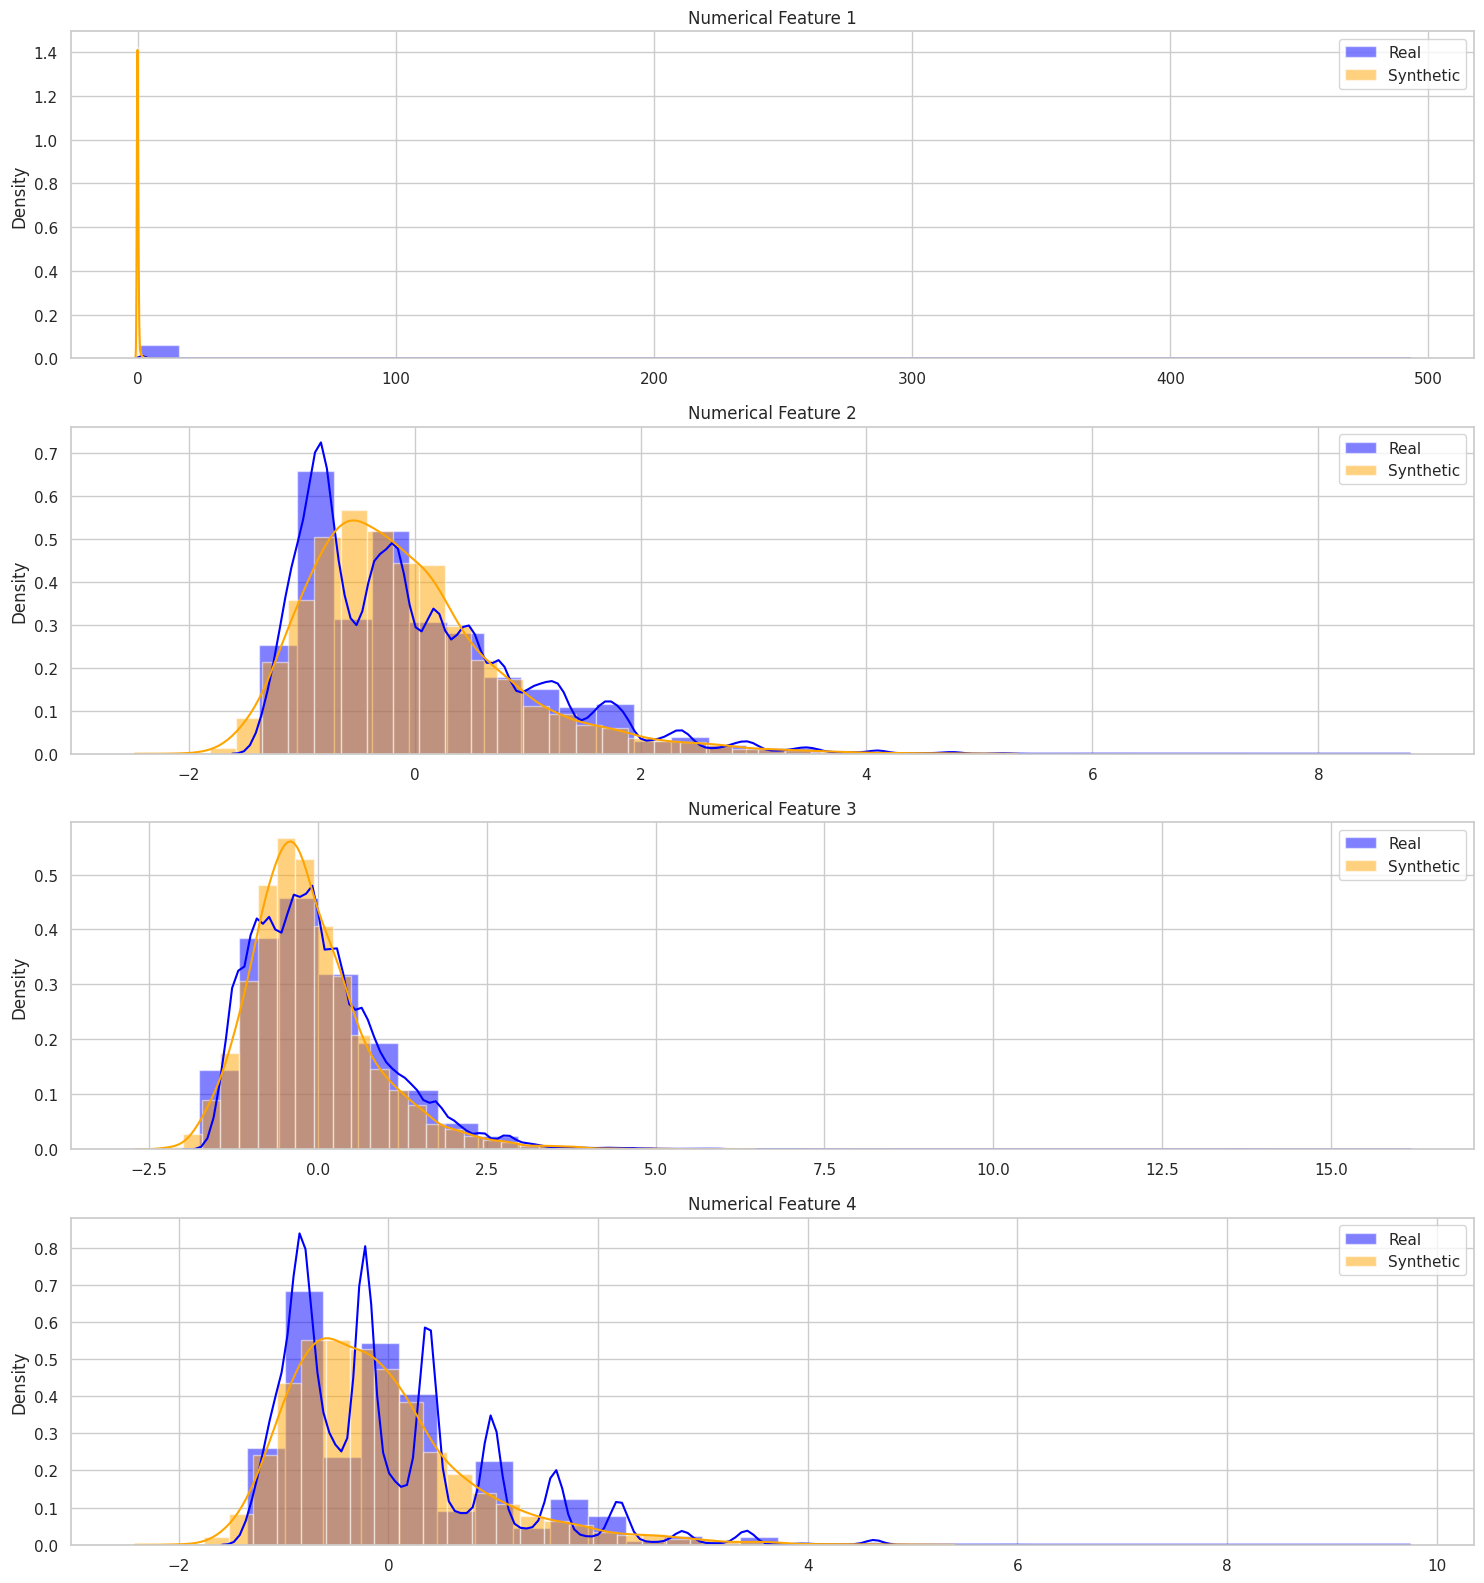

In [ ]:
print("Plotting numerical distributions...")
plot_numerical_distributions(X_real_num, X_fake_num)

Plotting numerical boxplots...


<ipython-input-48-1177407164>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_real_num[:, i], X_fake_num[:, i]], labels=['Real', 'Synthetic'])


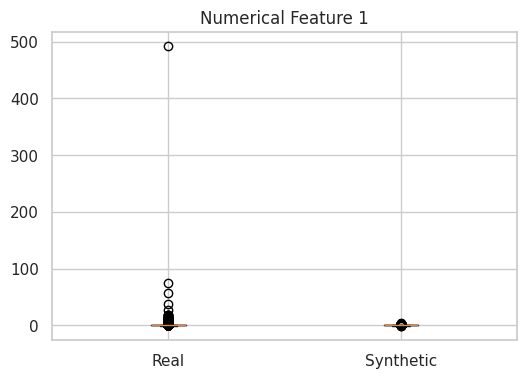

<ipython-input-48-1177407164>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_real_num[:, i], X_fake_num[:, i]], labels=['Real', 'Synthetic'])


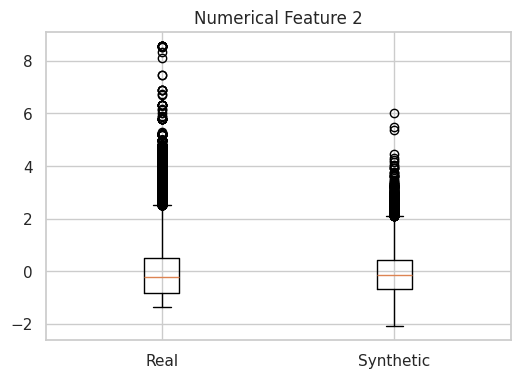

<ipython-input-48-1177407164>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_real_num[:, i], X_fake_num[:, i]], labels=['Real', 'Synthetic'])


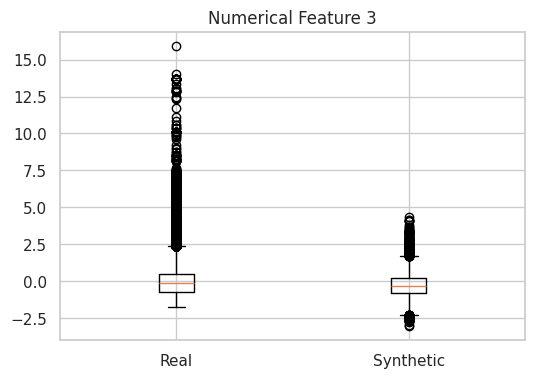

<ipython-input-48-1177407164>:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([X_real_num[:, i], X_fake_num[:, i]], labels=['Real', 'Synthetic'])


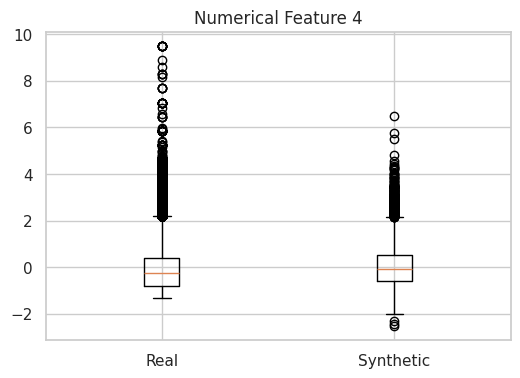

In [50]:
print("Plotting numerical boxplots...")
plot_numerical_boxplots(X_real_num, X_fake_num)

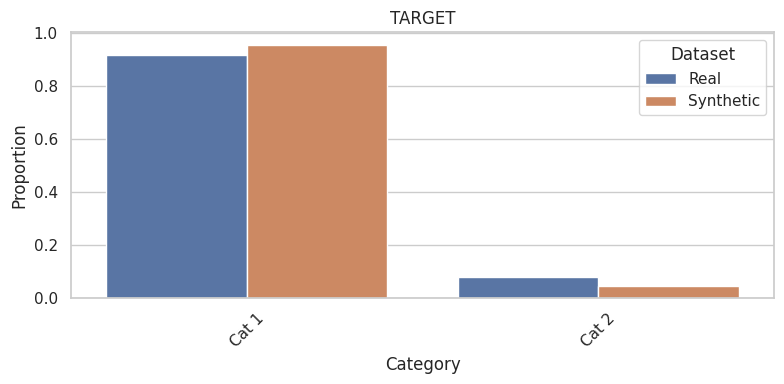

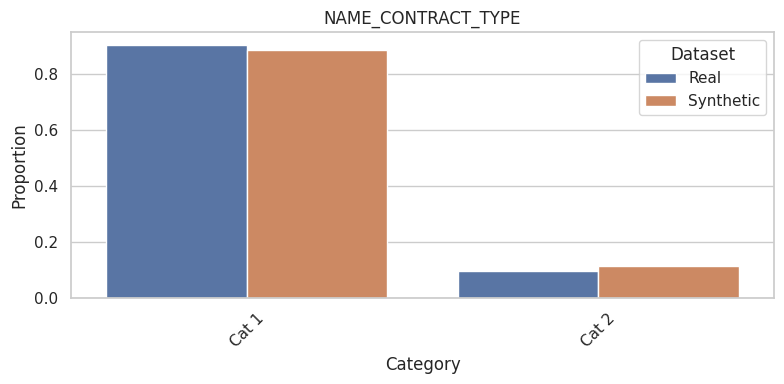

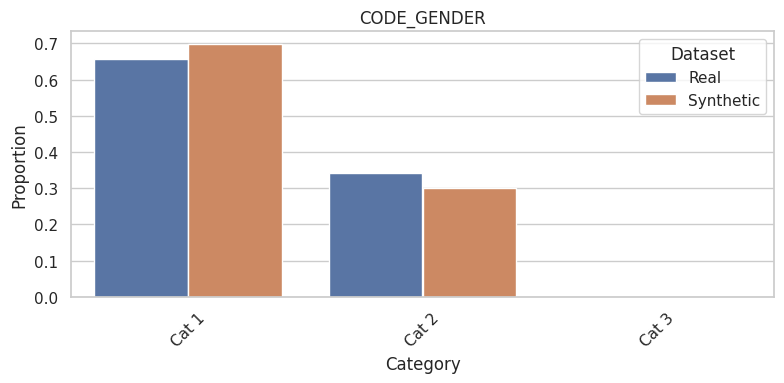

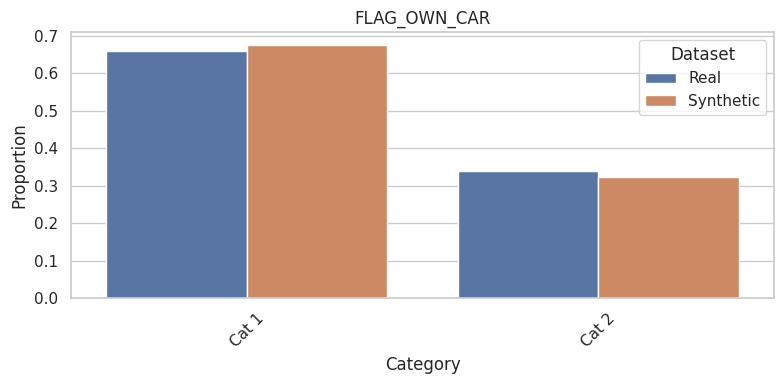

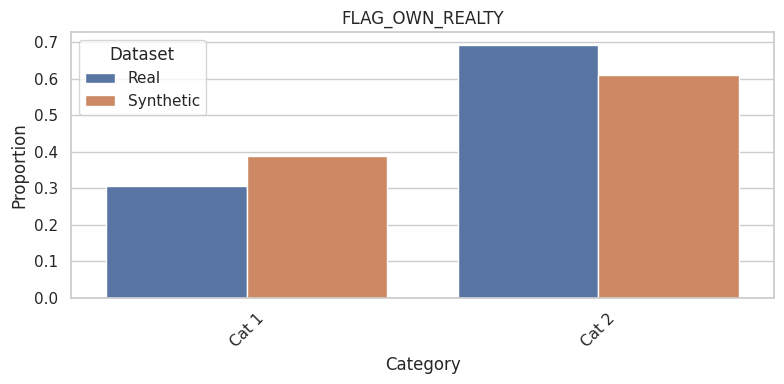

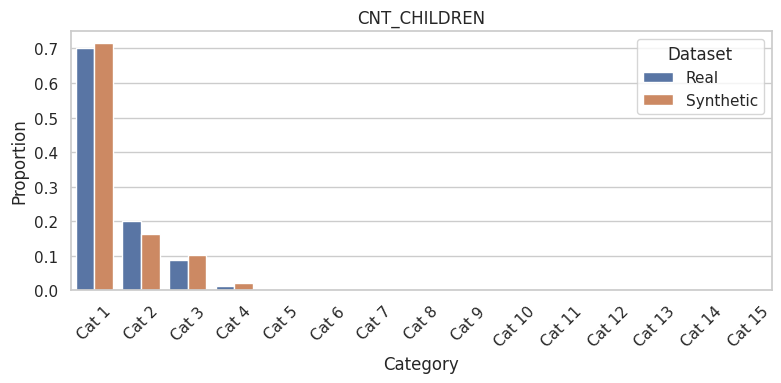

In [54]:
cat_feature_names = [
    'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN'
]


plot_categorical_frequencies(
    X_real_cat_labels,
    X_fake_cat_labels,
    cat_dims,
    cat_feature_names=cat_feature_names
)